In [11]:
import math
import torch
import random
import progressbar
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class KBandit(object):
    def __init__(self, arm_count, nonstationary=False):
        self.arm_count = arm_count
        self.nonstationary = nonstationary

        self.non_stationary_dist = None
        self.arm_values = None

        self.reset()

    def reset(self):
        values_dist = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
        self.non_stationary_dist = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([0.01]))

        values = []
        for i in range(self.arm_count):
            values.append(values_dist.sample().item())

        self.arm_values = torch.tensor(values)

    def play(self, arm):
        mean = torch.tensor([self.arm_values[arm]])
        deviation = torch.tensor([1.0])

        reward_dist = torch.distributions.normal.Normal(mean, deviation)

        if self.nonstationary:
            for i in range(self.arm_count):
                self.arm_values[i] += self.non_stationary_dist.sample().item()

        return reward_dist.sample().item()

    def optimal_action(self):
        return torch.max(torch.tensor(self.arm_values), 0)[1].item()

In [3]:
class Testbed(object):
    def __init__(self, num_tests=2000, num_steps=1000):
        self.num_tests = num_tests
        self.num_steps = num_steps

    def run(self, bandits, algorithm_class, params):
        total_average_rewards = []
        total_optimal_actions = []

        with progressbar.ProgressBar(max_value=self.num_tests) as bar:
            for test in range(0, self.num_tests):
                algorithm = algorithm_class(bandits[test], params)

                for step in range(0, self.num_steps):
                    algorithm.run_step()

                total_average_rewards.append(algorithm.average_rewards)
                total_optimal_actions.append(algorithm.optimal_actions)

                bar.update(test)

        total_average_rewards = torch.tensor(total_average_rewards)
        total_optimal_actions = torch.tensor(total_optimal_actions)

        total_average_rewards = torch.mean(total_average_rewards, 0)
        total_optimal_actions = torch.mean(total_optimal_actions, 0)

        return total_average_rewards, total_optimal_actions

In [4]:
class Algorithm(object):
    def __init__(self, k_bandit, params):
        self.k_bandit = k_bandit
        self.params = params
        self.optimal_action = 0

        self.ucb = self._get_param("ucb", False)
        self.init_value = self._get_param("init_value", 0.0)
        self.epsilon = self._get_param("epsilon", 0.0)
        self.alpha = self._get_param("alpha", 0.1)
        self.confidence = self._get_param("confidence", 0.0)

        self.Q = torch.zeros(self.k_bandit.arm_count) + self.init_value  # + torch.rand(k_bandit.arm_count) / 1000000

        self.current_step = 0

        self.total_rewards = 0
        self.average_rewards = []
        self.optimal_actions = []
        self.rewards_for_action = torch.zeros(self.k_bandit.arm_count)
        self.plays_for_action = torch.zeros(self.k_bandit.arm_count)

        self.rewards_for_action_history = [[] for i in range(self.k_bandit.arm_count)]

        #self.reset_test()

    def reset_test(self):
        self.Q = torch.zeros(self.k_bandit.arm_count) + self.init_value  # + torch.rand(k_bandit.arm_count) / 1000000

        self.current_step = 0

        self.total_rewards = 0
        self.average_rewards = []
        self.optimal_actions = []
        self.rewards_for_action = torch.zeros(self.k_bandit.arm_count)
        self.plays_for_action = torch.zeros(self.k_bandit.arm_count)

        self.rewards_for_action_history = [[] for i in range(self.k_bandit.arm_count)]

    def run_step(self):
        self.optimal_action = self.k_bandit.optimal_action()
        self.current_step += 1

        action = self.get_action()

        reward = self.k_bandit.play(action)

        self.rewards_for_action[action] += reward
        self.plays_for_action[action] += 1
        self.rewards_for_action_history[action].append(reward)

        q = self.compute(reward, action)
        if q is not None:
            self.Q[action] = q

        self.total_rewards += reward

        self.average_rewards.append(self.total_rewards / self.current_step)
        self.optimal_actions.append(self.plays_for_action[self.optimal_action] / self.current_step)

    def get_action(self):
        rand_for_egreedy = torch.rand(1).item()
        if rand_for_egreedy > self.epsilon:
            if self.ucb:
                temp_Q = []

                for i, q in enumerate(self.Q):
                    if self.plays_for_action[i] == 0:
                        c = 0
                    else:
                        c = self.confidence * math.sqrt(math.log(self.current_step) / self.plays_for_action[i])

                    temp_Q.append(q + c)

                action = torch.max(torch.tensor(temp_Q), 0)[1].item()
            else:
                action = torch.max(self.Q, 0)[1].item()
        else:
            action = int(torch.rand(1).item() * self.k_bandit.arm_count)

        return action

    def compute(self):
        return 0.0

    def _get_param(self, key, default=None):
        value = default
        if key in self.params:
            value = self.params[key]
        return value

In [12]:
def draw_graph(title, plots):
    plt.figure(figsize=(12, 5))

    plt.title(title)
    lines = []
    for i, plot in enumerate(plots):
        line, = plt.plot(plot["data"], alpha=0.6, color=plot["color"], label=plot["label"])
        lines.append(line)

    plt.legend(handles=lines, loc=2)

    plt.show()


def run_suite(suite):
    suite_rewards = []
    suite_actions = []

    bandits = []
    for i in range(suite["testbed"]["tests"]):
        bandits.append(KBandit(suite["bandit"]["arms"], suite["bandit"]["nonstationary"]))

    for task in suite["tasks"]:
        testbed = Testbed(num_tests=suite["testbed"]["tests"], num_steps=suite["testbed"]["steps"])
        algorithm = task["algorithm"]["class"]#(task["algorithm"]["params"])

        rewards, actions = testbed.run(bandits, algorithm, task["algorithm"]["params"])

        suite_rewards.append({
            "data": rewards.data.numpy(),
            "label": task["plot"]["label"],
            "color": task["plot"]["color"]
        })

        suite_actions.append({
            "data": actions.data.numpy(),
            "label": task["plot"]["label"],
            "color": task["plot"]["color"]
        })

    draw_graph("Average Reward", suite_rewards)
    draw_graph("Optimal Action", suite_actions)

In [5]:
class SimpleAlgorithm(Algorithm):
    def __init__(self, k_bandit, params):
        Algorithm.__init__(self, k_bandit, params)

    def compute(self, reward, action):
        q = self.Q[action] + (reward - self.Q[action]) * self.alpha

        return q

In [14]:
simple_suite = {
    "name": "Simple",
    "testbed": {
        "tests": 2000,
        "steps": 1000
    },
    "bandit": {
        "arms": 10,
        "nonstationary": False
    },
    "tasks": [
        {
            "algorithm": {
                "class": SimpleAlgorithm,
                "params": {
                    "init_value": 0.0,
                    "epsilon": 0.0,
                    "alpha": 0.1
                }
            },
            "plot": {
                "label": "e=0 (greedy)",
                "color": "green"
            }
        },
        {
            "algorithm": {
                "class": SimpleAlgorithm,
                "params": {
                    "init_value": 0.0,
                    "epsilon": 0.1,
                    "alpha": 0.1
                }
            },
            "plot": {
                "label": "e=0.1",
                "color": "blue"
            }
        },
        {
            "algorithm": {
                "class": SimpleAlgorithm,
                "params": {
                    "init_value": 0.0,
                    "epsilon": 0.01,
                    "alpha": 0.1
                }
            },
            "plot": {
                "label": "e=0.01",
                "color": "red"
            }
        }
    ]
}

/Users/mexxik/Documents/projects/udemy/rl-book/venv/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
N/A% (0 of 2000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

  0% (1 of 2000) |                       | Elapsed Time: 0:00:00 ETA:   0:05:00

  0% (2 of 2000) |                       | Elapsed Time: 0:00:00 ETA:   0:05:03

  0% (3 of 2000) |                       | Elapsed Time: 0:00:00 ETA:   0:04:59

  0% (4 of 2000) |                       | Elapsed Time: 0:00:00 ETA:   0:04:55

  0% (5 of 2000) |                       | Elapsed Time: 0:00:00 ETA:   0:04:52

  0% (6 of 2000) |                       | Elapsed Time: 0:00:00 ETA:   0:04:50

  0% (7 of 2000) |                       | Elapsed Time: 0:00:01 ETA:   0:04:47

  0% (8 of 2000) |                       | Elapsed Time: 0:00:01 ETA:   0:04:46

  0% (9 of 2000) |                       | Elapsed Time: 0:00:01 ETA:   0:04:45

  0% (10 of 2000) |                      | Elapsed Time: 0:00:01 ETA:   0:04:43

  0% (11 of 2000) |                      | Elapsed Time: 0:00:01 ETA:   0:04:41

  0% (12 of 2000) |                      | Elapsed Time: 0:00:01 ETA:   0:04:40

  0% (13 of 2000) |                      | Elapsed Time: 0:00:01 ETA:   0:04:39

  0% (14 of 2000) |                      | Elapsed Time: 0:00:01 ETA:   0:04:38

  0% (15 of 2000) |                      | Elapsed Time: 0:00:02 ETA:   0:04:38

  0% (16 of 2000) |                      | Elapsed Time: 0:00:02 ETA:   0:04:35

  0% (17 of 2000) |                      | Elapsed Time: 0:00:02 ETA:   0:04:33

  0% (18 of 2000) |                      | Elapsed Time: 0:00:02 ETA:   0:04:31

  0% (19 of 2000) |                      | Elapsed Time: 0:00:02 ETA:   0:04:30

  1% (20 of 2000) |                      | Elapsed Time: 0:00:02 ETA:   0:04:30

  1% (21 of 2000) |                      | Elapsed Time: 0:00:02 ETA:   0:04:29

  1% (22 of 2000) |                      | Elapsed Time: 0:00:03 ETA:   0:04:29

  1% (23 of 2000) |                      | Elapsed Time: 0:00:03 ETA:   0:04:29

  1% (24 of 2000) |                      | Elapsed Time: 0:00:03 ETA:   0:04:28

  1% (25 of 2000) |                      | Elapsed Time: 0:00:03 ETA:   0:04:28

  1% (26 of 2000) |                      | Elapsed Time: 0:00:03 ETA:   0:04:28

  1% (27 of 2000) |                      | Elapsed Time: 0:00:03 ETA:   0:04:29

  1% (28 of 2000) |                      | Elapsed Time: 0:00:03 ETA:   0:04:29

  1% (29 of 2000) |                      | Elapsed Time: 0:00:04 ETA:   0:04:29

  1% (30 of 2000) |                      | Elapsed Time: 0:00:04 ETA:   0:04:29

  1% (31 of 2000) |                      | Elapsed Time: 0:00:04 ETA:   0:04:29

  1% (32 of 2000) |                      | Elapsed Time: 0:00:04 ETA:   0:04:29

  1% (33 of 2000) |                      | Elapsed Time: 0:00:04 ETA:   0:04:30

  1% (34 of 2000) |                      | Elapsed Time: 0:00:04 ETA:   0:04:30

  1% (35 of 2000) |                      | Elapsed Time: 0:00:04 ETA:   0:04:30

  1% (36 of 2000) |                      | Elapsed Time: 0:00:04 ETA:   0:04:30

  1% (37 of 2000) |                      | Elapsed Time: 0:00:05 ETA:   0:04:31

  1% (38 of 2000) |                      | Elapsed Time: 0:00:05 ETA:   0:04:30

  1% (39 of 2000) |                      | Elapsed Time: 0:00:05 ETA:   0:04:30

  2% (40 of 2000) |                      | Elapsed Time: 0:00:05 ETA:   0:04:30

  2% (41 of 2000) |                      | Elapsed Time: 0:00:05 ETA:   0:04:31

  2% (42 of 2000) |                      | Elapsed Time: 0:00:05 ETA:   0:04:30

  2% (43 of 2000) |                      | Elapsed Time: 0:00:05 ETA:   0:04:30

  2% (44 of 2000) |                      | Elapsed Time: 0:00:06 ETA:   0:04:30

  2% (45 of 2000) |                      | Elapsed Time: 0:00:06 ETA:   0:04:30

  2% (46 of 2000) |                      | Elapsed Time: 0:00:06 ETA:   0:04:30

  2% (47 of 2000) |                      | Elapsed Time: 0:00:06 ETA:   0:04:30

  2% (48 of 2000) |                      | Elapsed Time: 0:00:06 ETA:   0:04:30

  2% (49 of 2000) |                      | Elapsed Time: 0:00:06 ETA:   0:04:30

  2% (50 of 2000) |                      | Elapsed Time: 0:00:06 ETA:   0:04:30

  2% (51 of 2000) |                      | Elapsed Time: 0:00:07 ETA:   0:04:30

  2% (52 of 2000) |                      | Elapsed Time: 0:00:07 ETA:   0:04:29

  2% (53 of 2000) |                      | Elapsed Time: 0:00:07 ETA:   0:04:29

  2% (54 of 2000) |                      | Elapsed Time: 0:00:07 ETA:   0:04:29

  2% (55 of 2000) |                      | Elapsed Time: 0:00:07 ETA:   0:04:29

  2% (56 of 2000) |                      | Elapsed Time: 0:00:07 ETA:   0:04:29

  2% (57 of 2000) |                      | Elapsed Time: 0:00:07 ETA:   0:04:29

  2% (58 of 2000) |                      | Elapsed Time: 0:00:08 ETA:   0:04:33

  2% (59 of 2000) |                      | Elapsed Time: 0:00:08 ETA:   0:04:32

  3% (60 of 2000) |                      | Elapsed Time: 0:00:08 ETA:   0:04:32

  3% (61 of 2000) |                      | Elapsed Time: 0:00:08 ETA:   0:04:32

  3% (62 of 2000) |                      | Elapsed Time: 0:00:08 ETA:   0:04:31

  3% (63 of 2000) |                      | Elapsed Time: 0:00:08 ETA:   0:04:31

  3% (64 of 2000) |                      | Elapsed Time: 0:00:08 ETA:   0:04:31

  3% (65 of 2000) |                      | Elapsed Time: 0:00:09 ETA:   0:04:31

  3% (66 of 2000) |                      | Elapsed Time: 0:00:09 ETA:   0:04:31

  3% (67 of 2000) |                      | Elapsed Time: 0:00:09 ETA:   0:04:31

  3% (68 of 2000) |                      | Elapsed Time: 0:00:09 ETA:   0:04:31

  3% (69 of 2000) |                      | Elapsed Time: 0:00:09 ETA:   0:04:31

  3% (70 of 2000) |                      | Elapsed Time: 0:00:09 ETA:   0:04:31

  3% (71 of 2000) |                      | Elapsed Time: 0:00:09 ETA:   0:04:30

  3% (72 of 2000) |                      | Elapsed Time: 0:00:09 ETA:   0:04:30

  3% (73 of 2000) |                      | Elapsed Time: 0:00:10 ETA:   0:04:26

  3% (74 of 2000) |                      | Elapsed Time: 0:00:10 ETA:   0:04:26

  3% (75 of 2000) |                      | Elapsed Time: 0:00:10 ETA:   0:04:26

  3% (76 of 2000) |                      | Elapsed Time: 0:00:10 ETA:   0:04:27

  3% (77 of 2000) |                      | Elapsed Time: 0:00:10 ETA:   0:04:26

  3% (78 of 2000) |                      | Elapsed Time: 0:00:10 ETA:   0:04:26

  3% (79 of 2000) |                      | Elapsed Time: 0:00:10 ETA:   0:04:26

  4% (80 of 2000) |                      | Elapsed Time: 0:00:11 ETA:   0:04:26

  4% (81 of 2000) |                      | Elapsed Time: 0:00:11 ETA:   0:04:25

  4% (82 of 2000) |                      | Elapsed Time: 0:00:11 ETA:   0:04:25

  4% (83 of 2000) |                      | Elapsed Time: 0:00:11 ETA:   0:04:25

  4% (84 of 2000) |                      | Elapsed Time: 0:00:11 ETA:   0:04:25

  4% (85 of 2000) |                      | Elapsed Time: 0:00:11 ETA:   0:04:25

  4% (86 of 2000) |                      | Elapsed Time: 0:00:11 ETA:   0:04:25

  4% (87 of 2000) |                      | Elapsed Time: 0:00:12 ETA:   0:04:25

  4% (88 of 2000) |                      | Elapsed Time: 0:00:12 ETA:   0:04:24

  4% (89 of 2000) |                      | Elapsed Time: 0:00:12 ETA:   0:04:24

  4% (90 of 2000) |                      | Elapsed Time: 0:00:12 ETA:   0:04:23

  4% (91 of 2000) |#                     | Elapsed Time: 0:00:12 ETA:   0:04:22

  4% (92 of 2000) |#                     | Elapsed Time: 0:00:12 ETA:   0:04:23

  4% (93 of 2000) |#                     | Elapsed Time: 0:00:12 ETA:   0:04:23

  4% (94 of 2000) |#                     | Elapsed Time: 0:00:13 ETA:   0:04:23

  4% (95 of 2000) |#                     | Elapsed Time: 0:00:13 ETA:   0:04:22

  4% (96 of 2000) |#                     | Elapsed Time: 0:00:13 ETA:   0:04:22

  4% (97 of 2000) |#                     | Elapsed Time: 0:00:13 ETA:   0:04:21

  4% (98 of 2000) |#                     | Elapsed Time: 0:00:13 ETA:   0:04:21

  4% (99 of 2000) |#                     | Elapsed Time: 0:00:13 ETA:   0:04:21

  5% (100 of 2000) |#                    | Elapsed Time: 0:00:13 ETA:   0:04:21

  5% (101 of 2000) |#                    | Elapsed Time: 0:00:14 ETA:   0:04:21

  5% (102 of 2000) |#                    | Elapsed Time: 0:00:14 ETA:   0:04:21

  5% (103 of 2000) |#                    | Elapsed Time: 0:00:14 ETA:   0:04:21

  5% (104 of 2000) |#                    | Elapsed Time: 0:00:14 ETA:   0:04:21

  5% (105 of 2000) |#                    | Elapsed Time: 0:00:14 ETA:   0:04:21

  5% (106 of 2000) |#                    | Elapsed Time: 0:00:14 ETA:   0:04:21

  5% (107 of 2000) |#                    | Elapsed Time: 0:00:14 ETA:   0:04:21

  5% (108 of 2000) |#                    | Elapsed Time: 0:00:14 ETA:   0:04:21

  5% (109 of 2000) |#                    | Elapsed Time: 0:00:15 ETA:   0:04:21

  5% (110 of 2000) |#                    | Elapsed Time: 0:00:15 ETA:   0:04:20

  5% (111 of 2000) |#                    | Elapsed Time: 0:00:15 ETA:   0:04:21

  5% (112 of 2000) |#                    | Elapsed Time: 0:00:15 ETA:   0:04:20

  5% (113 of 2000) |#                    | Elapsed Time: 0:00:15 ETA:   0:04:21

  5% (114 of 2000) |#                    | Elapsed Time: 0:00:15 ETA:   0:04:21

  5% (115 of 2000) |#                    | Elapsed Time: 0:00:15 ETA:   0:04:21

  5% (116 of 2000) |#                    | Elapsed Time: 0:00:16 ETA:   0:04:21

  5% (117 of 2000) |#                    | Elapsed Time: 0:00:16 ETA:   0:04:21

  5% (118 of 2000) |#                    | Elapsed Time: 0:00:16 ETA:   0:04:20

  5% (119 of 2000) |#                    | Elapsed Time: 0:00:16 ETA:   0:04:20

  6% (120 of 2000) |#                    | Elapsed Time: 0:00:16 ETA:   0:04:20

  6% (121 of 2000) |#                    | Elapsed Time: 0:00:16 ETA:   0:04:20

  6% (122 of 2000) |#                    | Elapsed Time: 0:00:16 ETA:   0:04:20

  6% (123 of 2000) |#                    | Elapsed Time: 0:00:17 ETA:   0:04:20

  6% (124 of 2000) |#                    | Elapsed Time: 0:00:17 ETA:   0:04:20

  6% (125 of 2000) |#                    | Elapsed Time: 0:00:17 ETA:   0:04:20

  6% (126 of 2000) |#                    | Elapsed Time: 0:00:17 ETA:   0:04:19

  6% (127 of 2000) |#                    | Elapsed Time: 0:00:17 ETA:   0:04:19

  6% (128 of 2000) |#                    | Elapsed Time: 0:00:17 ETA:   0:04:19

  6% (129 of 2000) |#                    | Elapsed Time: 0:00:17 ETA:   0:04:19

  6% (130 of 2000) |#                    | Elapsed Time: 0:00:18 ETA:   0:04:18

  6% (131 of 2000) |#                    | Elapsed Time: 0:00:18 ETA:   0:04:18

  6% (132 of 2000) |#                    | Elapsed Time: 0:00:18 ETA:   0:04:18

  6% (133 of 2000) |#                    | Elapsed Time: 0:00:18 ETA:   0:04:18

  6% (134 of 2000) |#                    | Elapsed Time: 0:00:18 ETA:   0:04:17

  6% (135 of 2000) |#                    | Elapsed Time: 0:00:18 ETA:   0:04:18

  6% (136 of 2000) |#                    | Elapsed Time: 0:00:18 ETA:   0:04:18

  6% (137 of 2000) |#                    | Elapsed Time: 0:00:18 ETA:   0:04:17

  6% (138 of 2000) |#                    | Elapsed Time: 0:00:19 ETA:   0:04:17

  6% (139 of 2000) |#                    | Elapsed Time: 0:00:19 ETA:   0:04:16

  7% (140 of 2000) |#                    | Elapsed Time: 0:00:19 ETA:   0:04:16

  7% (141 of 2000) |#                    | Elapsed Time: 0:00:19 ETA:   0:04:16

  7% (142 of 2000) |#                    | Elapsed Time: 0:00:19 ETA:   0:04:16

  7% (143 of 2000) |#                    | Elapsed Time: 0:00:19 ETA:   0:04:16

  7% (144 of 2000) |#                    | Elapsed Time: 0:00:19 ETA:   0:04:15

  7% (145 of 2000) |#                    | Elapsed Time: 0:00:20 ETA:   0:04:15

  7% (146 of 2000) |#                    | Elapsed Time: 0:00:20 ETA:   0:04:15

  7% (147 of 2000) |#                    | Elapsed Time: 0:00:20 ETA:   0:04:15

  7% (148 of 2000) |#                    | Elapsed Time: 0:00:20 ETA:   0:04:14

  7% (149 of 2000) |#                    | Elapsed Time: 0:00:20 ETA:   0:04:14

  7% (150 of 2000) |#                    | Elapsed Time: 0:00:20 ETA:   0:04:20

  7% (151 of 2000) |#                    | Elapsed Time: 0:00:20 ETA:   0:04:20

  7% (152 of 2000) |#                    | Elapsed Time: 0:00:21 ETA:   0:04:20

  7% (153 of 2000) |#                    | Elapsed Time: 0:00:21 ETA:   0:04:20

  7% (154 of 2000) |#                    | Elapsed Time: 0:00:21 ETA:   0:04:20

  7% (155 of 2000) |#                    | Elapsed Time: 0:00:21 ETA:   0:04:20

  7% (156 of 2000) |#                    | Elapsed Time: 0:00:21 ETA:   0:04:20

  7% (157 of 2000) |#                    | Elapsed Time: 0:00:21 ETA:   0:04:20

  7% (158 of 2000) |#                    | Elapsed Time: 0:00:21 ETA:   0:04:20

  7% (159 of 2000) |#                    | Elapsed Time: 0:00:22 ETA:   0:04:20

  8% (160 of 2000) |#                    | Elapsed Time: 0:00:22 ETA:   0:04:20

  8% (161 of 2000) |#                    | Elapsed Time: 0:00:22 ETA:   0:04:19

  8% (162 of 2000) |#                    | Elapsed Time: 0:00:22 ETA:   0:04:19

  8% (163 of 2000) |#                    | Elapsed Time: 0:00:22 ETA:   0:04:19

  8% (164 of 2000) |#                    | Elapsed Time: 0:00:22 ETA:   0:04:19

  8% (165 of 2000) |#                    | Elapsed Time: 0:00:22 ETA:   0:04:13

  8% (166 of 2000) |#                    | Elapsed Time: 0:00:23 ETA:   0:04:12

  8% (167 of 2000) |#                    | Elapsed Time: 0:00:23 ETA:   0:04:12

  8% (168 of 2000) |#                    | Elapsed Time: 0:00:23 ETA:   0:04:12

  8% (169 of 2000) |#                    | Elapsed Time: 0:00:23 ETA:   0:04:12

  8% (170 of 2000) |#                    | Elapsed Time: 0:00:23 ETA:   0:04:12

  8% (171 of 2000) |#                    | Elapsed Time: 0:00:23 ETA:   0:04:12

  8% (172 of 2000) |#                    | Elapsed Time: 0:00:23 ETA:   0:04:12

  8% (173 of 2000) |#                    | Elapsed Time: 0:00:24 ETA:   0:04:12

  8% (174 of 2000) |#                    | Elapsed Time: 0:00:24 ETA:   0:04:12

  8% (175 of 2000) |#                    | Elapsed Time: 0:00:24 ETA:   0:04:12

  8% (176 of 2000) |#                    | Elapsed Time: 0:00:24 ETA:   0:04:12

  8% (177 of 2000) |#                    | Elapsed Time: 0:00:24 ETA:   0:04:11

  8% (178 of 2000) |#                    | Elapsed Time: 0:00:24 ETA:   0:04:11

  8% (179 of 2000) |#                    | Elapsed Time: 0:00:24 ETA:   0:04:11

  9% (180 of 2000) |#                    | Elapsed Time: 0:00:24 ETA:   0:04:11

  9% (181 of 2000) |#                    | Elapsed Time: 0:00:25 ETA:   0:04:11

  9% (182 of 2000) |#                    | Elapsed Time: 0:00:25 ETA:   0:04:11

  9% (183 of 2000) |#                    | Elapsed Time: 0:00:25 ETA:   0:04:10

  9% (184 of 2000) |#                    | Elapsed Time: 0:00:25 ETA:   0:04:10

  9% (185 of 2000) |#                    | Elapsed Time: 0:00:25 ETA:   0:04:09

  9% (186 of 2000) |#                    | Elapsed Time: 0:00:25 ETA:   0:04:10

  9% (187 of 2000) |#                    | Elapsed Time: 0:00:25 ETA:   0:04:09

  9% (188 of 2000) |#                    | Elapsed Time: 0:00:26 ETA:   0:04:09

  9% (189 of 2000) |#                    | Elapsed Time: 0:00:26 ETA:   0:04:09

  9% (190 of 2000) |#                    | Elapsed Time: 0:00:26 ETA:   0:04:09

  9% (191 of 2000) |##                   | Elapsed Time: 0:00:26 ETA:   0:04:09

  9% (192 of 2000) |##                   | Elapsed Time: 0:00:26 ETA:   0:04:09

  9% (193 of 2000) |##                   | Elapsed Time: 0:00:26 ETA:   0:04:09

  9% (194 of 2000) |##                   | Elapsed Time: 0:00:26 ETA:   0:04:08

  9% (195 of 2000) |##                   | Elapsed Time: 0:00:27 ETA:   0:04:08

  9% (196 of 2000) |##                   | Elapsed Time: 0:00:27 ETA:   0:04:08

  9% (197 of 2000) |##                   | Elapsed Time: 0:00:27 ETA:   0:04:08

  9% (198 of 2000) |##                   | Elapsed Time: 0:00:27 ETA:   0:04:08

  9% (199 of 2000) |##                   | Elapsed Time: 0:00:27 ETA:   0:04:07

 10% (200 of 2000) |##                   | Elapsed Time: 0:00:27 ETA:   0:04:08

 10% (201 of 2000) |##                   | Elapsed Time: 0:00:27 ETA:   0:04:07

 10% (202 of 2000) |##                   | Elapsed Time: 0:00:27 ETA:   0:04:07

 10% (203 of 2000) |##                   | Elapsed Time: 0:00:28 ETA:   0:04:07

 10% (204 of 2000) |##                   | Elapsed Time: 0:00:28 ETA:   0:04:07

 10% (205 of 2000) |##                   | Elapsed Time: 0:00:28 ETA:   0:04:07

 10% (206 of 2000) |##                   | Elapsed Time: 0:00:28 ETA:   0:04:07

 10% (207 of 2000) |##                   | Elapsed Time: 0:00:28 ETA:   0:04:06

 10% (208 of 2000) |##                   | Elapsed Time: 0:00:28 ETA:   0:04:07

 10% (209 of 2000) |##                   | Elapsed Time: 0:00:28 ETA:   0:04:06

 10% (210 of 2000) |##                   | Elapsed Time: 0:00:29 ETA:   0:04:06

 10% (211 of 2000) |##                   | Elapsed Time: 0:00:29 ETA:   0:04:06

 10% (212 of 2000) |##                   | Elapsed Time: 0:00:29 ETA:   0:04:06

 10% (213 of 2000) |##                   | Elapsed Time: 0:00:29 ETA:   0:04:06

 10% (214 of 2000) |##                   | Elapsed Time: 0:00:29 ETA:   0:04:05

 10% (215 of 2000) |##                   | Elapsed Time: 0:00:29 ETA:   0:04:05

 10% (216 of 2000) |##                   | Elapsed Time: 0:00:29 ETA:   0:04:05

 10% (217 of 2000) |##                   | Elapsed Time: 0:00:30 ETA:   0:04:05

 10% (218 of 2000) |##                   | Elapsed Time: 0:00:30 ETA:   0:04:05

 10% (219 of 2000) |##                   | Elapsed Time: 0:00:30 ETA:   0:04:05

 11% (220 of 2000) |##                   | Elapsed Time: 0:00:30 ETA:   0:04:05

 11% (221 of 2000) |##                   | Elapsed Time: 0:00:30 ETA:   0:04:05

 11% (222 of 2000) |##                   | Elapsed Time: 0:00:30 ETA:   0:04:05

 11% (223 of 2000) |##                   | Elapsed Time: 0:00:30 ETA:   0:04:04

 11% (224 of 2000) |##                   | Elapsed Time: 0:00:31 ETA:   0:04:05

 11% (225 of 2000) |##                   | Elapsed Time: 0:00:31 ETA:   0:04:05

 11% (226 of 2000) |##                   | Elapsed Time: 0:00:31 ETA:   0:04:04

 11% (227 of 2000) |##                   | Elapsed Time: 0:00:31 ETA:   0:04:04

 11% (228 of 2000) |##                   | Elapsed Time: 0:00:31 ETA:   0:04:04

 11% (229 of 2000) |##                   | Elapsed Time: 0:00:31 ETA:   0:04:04

 11% (230 of 2000) |##                   | Elapsed Time: 0:00:31 ETA:   0:04:04

 11% (231 of 2000) |##                   | Elapsed Time: 0:00:31 ETA:   0:04:03

 11% (232 of 2000) |##                   | Elapsed Time: 0:00:32 ETA:   0:04:03

 11% (233 of 2000) |##                   | Elapsed Time: 0:00:32 ETA:   0:04:03

 11% (234 of 2000) |##                   | Elapsed Time: 0:00:32 ETA:   0:04:03

 11% (235 of 2000) |##                   | Elapsed Time: 0:00:32 ETA:   0:04:03

 11% (236 of 2000) |##                   | Elapsed Time: 0:00:32 ETA:   0:04:03

 11% (237 of 2000) |##                   | Elapsed Time: 0:00:32 ETA:   0:04:02

 11% (238 of 2000) |##                   | Elapsed Time: 0:00:32 ETA:   0:04:03

 11% (239 of 2000) |##                   | Elapsed Time: 0:00:33 ETA:   0:04:02

 12% (240 of 2000) |##                   | Elapsed Time: 0:00:33 ETA:   0:04:02

 12% (241 of 2000) |##                   | Elapsed Time: 0:00:33 ETA:   0:04:02

 12% (242 of 2000) |##                   | Elapsed Time: 0:00:33 ETA:   0:04:09

 12% (243 of 2000) |##                   | Elapsed Time: 0:00:33 ETA:   0:04:09

 12% (244 of 2000) |##                   | Elapsed Time: 0:00:33 ETA:   0:04:09

 12% (245 of 2000) |##                   | Elapsed Time: 0:00:33 ETA:   0:04:09

 12% (246 of 2000) |##                   | Elapsed Time: 0:00:34 ETA:   0:04:09

 12% (247 of 2000) |##                   | Elapsed Time: 0:00:34 ETA:   0:04:09

 12% (248 of 2000) |##                   | Elapsed Time: 0:00:34 ETA:   0:04:08

 12% (249 of 2000) |##                   | Elapsed Time: 0:00:34 ETA:   0:04:08

 12% (250 of 2000) |##                   | Elapsed Time: 0:00:34 ETA:   0:04:08

 12% (251 of 2000) |##                   | Elapsed Time: 0:00:34 ETA:   0:04:08

 12% (252 of 2000) |##                   | Elapsed Time: 0:00:34 ETA:   0:04:08

 12% (253 of 2000) |##                   | Elapsed Time: 0:00:35 ETA:   0:04:07

 12% (254 of 2000) |##                   | Elapsed Time: 0:00:35 ETA:   0:04:07

 12% (255 of 2000) |##                   | Elapsed Time: 0:00:35 ETA:   0:04:07

 12% (256 of 2000) |##                   | Elapsed Time: 0:00:35 ETA:   0:04:07

 12% (257 of 2000) |##                   | Elapsed Time: 0:00:35 ETA:   0:03:59

 12% (258 of 2000) |##                   | Elapsed Time: 0:00:35 ETA:   0:04:00

 12% (259 of 2000) |##                   | Elapsed Time: 0:00:35 ETA:   0:04:00

 13% (260 of 2000) |##                   | Elapsed Time: 0:00:36 ETA:   0:03:59

 13% (261 of 2000) |##                   | Elapsed Time: 0:00:36 ETA:   0:03:59

 13% (262 of 2000) |##                   | Elapsed Time: 0:00:36 ETA:   0:03:59

 13% (263 of 2000) |##                   | Elapsed Time: 0:00:36 ETA:   0:03:59

 13% (264 of 2000) |##                   | Elapsed Time: 0:00:36 ETA:   0:03:59

 13% (265 of 2000) |##                   | Elapsed Time: 0:00:36 ETA:   0:03:59

 13% (266 of 2000) |##                   | Elapsed Time: 0:00:36 ETA:   0:03:59

 13% (267 of 2000) |##                   | Elapsed Time: 0:00:37 ETA:   0:03:59

 13% (268 of 2000) |##                   | Elapsed Time: 0:00:37 ETA:   0:03:58

 13% (269 of 2000) |##                   | Elapsed Time: 0:00:37 ETA:   0:03:58

 13% (270 of 2000) |##                   | Elapsed Time: 0:00:37 ETA:   0:03:58

 13% (271 of 2000) |##                   | Elapsed Time: 0:00:37 ETA:   0:03:58

 13% (272 of 2000) |##                   | Elapsed Time: 0:00:37 ETA:   0:03:58

 13% (273 of 2000) |##                   | Elapsed Time: 0:00:37 ETA:   0:03:58

 13% (274 of 2000) |##                   | Elapsed Time: 0:00:37 ETA:   0:03:57

 13% (275 of 2000) |##                   | Elapsed Time: 0:00:38 ETA:   0:03:58

 13% (276 of 2000) |##                   | Elapsed Time: 0:00:38 ETA:   0:03:57

 13% (277 of 2000) |##                   | Elapsed Time: 0:00:38 ETA:   0:03:57

 13% (278 of 2000) |##                   | Elapsed Time: 0:00:38 ETA:   0:03:57

 13% (279 of 2000) |##                   | Elapsed Time: 0:00:38 ETA:   0:03:57

 14% (280 of 2000) |##                   | Elapsed Time: 0:00:38 ETA:   0:03:57

 14% (281 of 2000) |##                   | Elapsed Time: 0:00:38 ETA:   0:03:57

 14% (282 of 2000) |##                   | Elapsed Time: 0:00:39 ETA:   0:03:57

 14% (283 of 2000) |##                   | Elapsed Time: 0:00:39 ETA:   0:03:57

 14% (284 of 2000) |##                   | Elapsed Time: 0:00:39 ETA:   0:03:57

 14% (285 of 2000) |##                   | Elapsed Time: 0:00:39 ETA:   0:03:57

 14% (286 of 2000) |###                  | Elapsed Time: 0:00:39 ETA:   0:03:57

 14% (287 of 2000) |###                  | Elapsed Time: 0:00:39 ETA:   0:03:57

 14% (288 of 2000) |###                  | Elapsed Time: 0:00:39 ETA:   0:03:56

 14% (289 of 2000) |###                  | Elapsed Time: 0:00:40 ETA:   0:03:56

 14% (290 of 2000) |###                  | Elapsed Time: 0:00:40 ETA:   0:03:55

 14% (291 of 2000) |###                  | Elapsed Time: 0:00:40 ETA:   0:03:55

 14% (292 of 2000) |###                  | Elapsed Time: 0:00:40 ETA:   0:03:56

 14% (293 of 2000) |###                  | Elapsed Time: 0:00:40 ETA:   0:03:57

 14% (294 of 2000) |###                  | Elapsed Time: 0:00:40 ETA:   0:03:57

 14% (295 of 2000) |###                  | Elapsed Time: 0:00:40 ETA:   0:03:57

 14% (296 of 2000) |###                  | Elapsed Time: 0:00:41 ETA:   0:03:57

 14% (297 of 2000) |###                  | Elapsed Time: 0:00:41 ETA:   0:03:56

 14% (298 of 2000) |###                  | Elapsed Time: 0:00:41 ETA:   0:03:56

 14% (299 of 2000) |###                  | Elapsed Time: 0:00:41 ETA:   0:03:56

 15% (300 of 2000) |###                  | Elapsed Time: 0:00:41 ETA:   0:03:56

 15% (301 of 2000) |###                  | Elapsed Time: 0:00:41 ETA:   0:03:56

 15% (302 of 2000) |###                  | Elapsed Time: 0:00:41 ETA:   0:03:56

 15% (303 of 2000) |###                  | Elapsed Time: 0:00:42 ETA:   0:03:56

 15% (304 of 2000) |###                  | Elapsed Time: 0:00:42 ETA:   0:03:55

 15% (305 of 2000) |###                  | Elapsed Time: 0:00:42 ETA:   0:03:55

 15% (306 of 2000) |###                  | Elapsed Time: 0:00:42 ETA:   0:03:55

 15% (307 of 2000) |###                  | Elapsed Time: 0:00:42 ETA:   0:03:54

 15% (308 of 2000) |###                  | Elapsed Time: 0:00:42 ETA:   0:03:54

 15% (309 of 2000) |###                  | Elapsed Time: 0:00:42 ETA:   0:03:53

 15% (310 of 2000) |###                  | Elapsed Time: 0:00:42 ETA:   0:03:53

 15% (311 of 2000) |###                  | Elapsed Time: 0:00:43 ETA:   0:03:53

 15% (312 of 2000) |###                  | Elapsed Time: 0:00:43 ETA:   0:03:53

 15% (313 of 2000) |###                  | Elapsed Time: 0:00:43 ETA:   0:03:53

 15% (314 of 2000) |###                  | Elapsed Time: 0:00:43 ETA:   0:03:52

 15% (315 of 2000) |###                  | Elapsed Time: 0:00:43 ETA:   0:03:52

 15% (316 of 2000) |###                  | Elapsed Time: 0:00:43 ETA:   0:03:52

 15% (317 of 2000) |###                  | Elapsed Time: 0:00:43 ETA:   0:03:52

 15% (318 of 2000) |###                  | Elapsed Time: 0:00:44 ETA:   0:03:52

 15% (319 of 2000) |###                  | Elapsed Time: 0:00:44 ETA:   0:03:52

 16% (320 of 2000) |###                  | Elapsed Time: 0:00:44 ETA:   0:03:52

 16% (321 of 2000) |###                  | Elapsed Time: 0:00:44 ETA:   0:03:52

 16% (322 of 2000) |###                  | Elapsed Time: 0:00:44 ETA:   0:03:52

 16% (323 of 2000) |###                  | Elapsed Time: 0:00:44 ETA:   0:03:51

 16% (324 of 2000) |###                  | Elapsed Time: 0:00:44 ETA:   0:03:51

 16% (325 of 2000) |###                  | Elapsed Time: 0:00:45 ETA:   0:03:51

 16% (326 of 2000) |###                  | Elapsed Time: 0:00:45 ETA:   0:03:51

 16% (327 of 2000) |###                  | Elapsed Time: 0:00:45 ETA:   0:03:51

 16% (328 of 2000) |###                  | Elapsed Time: 0:00:45 ETA:   0:03:51

 16% (329 of 2000) |###                  | Elapsed Time: 0:00:45 ETA:   0:03:51

 16% (330 of 2000) |###                  | Elapsed Time: 0:00:45 ETA:   0:03:51

 16% (331 of 2000) |###                  | Elapsed Time: 0:00:45 ETA:   0:03:51

 16% (332 of 2000) |###                  | Elapsed Time: 0:00:46 ETA:   0:03:50

 16% (333 of 2000) |###                  | Elapsed Time: 0:00:46 ETA:   0:03:50

 16% (334 of 2000) |###                  | Elapsed Time: 0:00:46 ETA:   0:03:59

 16% (335 of 2000) |###                  | Elapsed Time: 0:00:46 ETA:   0:03:59

 16% (336 of 2000) |###                  | Elapsed Time: 0:00:46 ETA:   0:03:58

 16% (337 of 2000) |###                  | Elapsed Time: 0:00:46 ETA:   0:03:59

 16% (338 of 2000) |###                  | Elapsed Time: 0:00:46 ETA:   0:03:59

 16% (339 of 2000) |###                  | Elapsed Time: 0:00:47 ETA:   0:03:58

 17% (340 of 2000) |###                  | Elapsed Time: 0:00:47 ETA:   0:03:58

 17% (341 of 2000) |###                  | Elapsed Time: 0:00:47 ETA:   0:03:58

 17% (342 of 2000) |###                  | Elapsed Time: 0:00:47 ETA:   0:03:58

 17% (343 of 2000) |###                  | Elapsed Time: 0:00:47 ETA:   0:03:58

 17% (344 of 2000) |###                  | Elapsed Time: 0:00:47 ETA:   0:03:57

 17% (345 of 2000) |###                  | Elapsed Time: 0:00:47 ETA:   0:03:57

 17% (346 of 2000) |###                  | Elapsed Time: 0:00:48 ETA:   0:03:57

 17% (347 of 2000) |###                  | Elapsed Time: 0:00:48 ETA:   0:03:57

 17% (348 of 2000) |###                  | Elapsed Time: 0:00:48 ETA:   0:03:56

 17% (349 of 2000) |###                  | Elapsed Time: 0:00:48 ETA:   0:03:48

 17% (350 of 2000) |###                  | Elapsed Time: 0:00:48 ETA:   0:03:48

 17% (351 of 2000) |###                  | Elapsed Time: 0:00:48 ETA:   0:03:48

 17% (352 of 2000) |###                  | Elapsed Time: 0:00:48 ETA:   0:03:48

 17% (353 of 2000) |###                  | Elapsed Time: 0:00:49 ETA:   0:03:48

 17% (354 of 2000) |###                  | Elapsed Time: 0:00:49 ETA:   0:03:48

 17% (355 of 2000) |###                  | Elapsed Time: 0:00:49 ETA:   0:03:48

 17% (356 of 2000) |###                  | Elapsed Time: 0:00:49 ETA:   0:03:48

 17% (357 of 2000) |###                  | Elapsed Time: 0:00:49 ETA:   0:03:48

 17% (358 of 2000) |###                  | Elapsed Time: 0:00:49 ETA:   0:03:48

 17% (359 of 2000) |###                  | Elapsed Time: 0:00:49 ETA:   0:03:48

 18% (360 of 2000) |###                  | Elapsed Time: 0:00:49 ETA:   0:03:47

 18% (361 of 2000) |###                  | Elapsed Time: 0:00:50 ETA:   0:03:47

 18% (362 of 2000) |###                  | Elapsed Time: 0:00:50 ETA:   0:03:47

 18% (363 of 2000) |###                  | Elapsed Time: 0:00:50 ETA:   0:03:47

 18% (364 of 2000) |###                  | Elapsed Time: 0:00:50 ETA:   0:03:46

 18% (365 of 2000) |###                  | Elapsed Time: 0:00:50 ETA:   0:03:46

 18% (366 of 2000) |###                  | Elapsed Time: 0:00:50 ETA:   0:03:46

 18% (367 of 2000) |###                  | Elapsed Time: 0:00:50 ETA:   0:03:46

 18% (368 of 2000) |###                  | Elapsed Time: 0:00:51 ETA:   0:03:45

 18% (369 of 2000) |###                  | Elapsed Time: 0:00:51 ETA:   0:03:45

 18% (370 of 2000) |###                  | Elapsed Time: 0:00:51 ETA:   0:03:45

 18% (371 of 2000) |###                  | Elapsed Time: 0:00:51 ETA:   0:03:45

 18% (372 of 2000) |###                  | Elapsed Time: 0:00:51 ETA:   0:03:45

 18% (373 of 2000) |###                  | Elapsed Time: 0:00:51 ETA:   0:03:44

 18% (374 of 2000) |###                  | Elapsed Time: 0:00:51 ETA:   0:03:44

 18% (375 of 2000) |###                  | Elapsed Time: 0:00:52 ETA:   0:03:44

 18% (376 of 2000) |###                  | Elapsed Time: 0:00:52 ETA:   0:03:44

 18% (377 of 2000) |###                  | Elapsed Time: 0:00:52 ETA:   0:03:44

 18% (378 of 2000) |###                  | Elapsed Time: 0:00:52 ETA:   0:03:44

 18% (379 of 2000) |###                  | Elapsed Time: 0:00:52 ETA:   0:03:44

 19% (380 of 2000) |###                  | Elapsed Time: 0:00:52 ETA:   0:03:43

 19% (381 of 2000) |####                 | Elapsed Time: 0:00:52 ETA:   0:03:43

 19% (382 of 2000) |####                 | Elapsed Time: 0:00:53 ETA:   0:03:43

 19% (383 of 2000) |####                 | Elapsed Time: 0:00:53 ETA:   0:03:43

 19% (384 of 2000) |####                 | Elapsed Time: 0:00:53 ETA:   0:03:43

 19% (385 of 2000) |####                 | Elapsed Time: 0:00:53 ETA:   0:03:43

 19% (386 of 2000) |####                 | Elapsed Time: 0:00:53 ETA:   0:03:42

 19% (387 of 2000) |####                 | Elapsed Time: 0:00:53 ETA:   0:03:42

 19% (388 of 2000) |####                 | Elapsed Time: 0:00:53 ETA:   0:03:42

 19% (389 of 2000) |####                 | Elapsed Time: 0:00:53 ETA:   0:03:42

 19% (390 of 2000) |####                 | Elapsed Time: 0:00:54 ETA:   0:03:41

 19% (391 of 2000) |####                 | Elapsed Time: 0:00:54 ETA:   0:03:42

 19% (392 of 2000) |####                 | Elapsed Time: 0:00:54 ETA:   0:03:41

 19% (393 of 2000) |####                 | Elapsed Time: 0:00:54 ETA:   0:03:41

 19% (394 of 2000) |####                 | Elapsed Time: 0:00:54 ETA:   0:03:41

 19% (395 of 2000) |####                 | Elapsed Time: 0:00:54 ETA:   0:03:41

 19% (396 of 2000) |####                 | Elapsed Time: 0:00:54 ETA:   0:03:41

 19% (397 of 2000) |####                 | Elapsed Time: 0:00:55 ETA:   0:03:41

 19% (398 of 2000) |####                 | Elapsed Time: 0:00:55 ETA:   0:03:41

 19% (399 of 2000) |####                 | Elapsed Time: 0:00:55 ETA:   0:03:41

 20% (400 of 2000) |####                 | Elapsed Time: 0:00:55 ETA:   0:03:41

 20% (401 of 2000) |####                 | Elapsed Time: 0:00:55 ETA:   0:03:41

 20% (402 of 2000) |####                 | Elapsed Time: 0:00:55 ETA:   0:03:41

 20% (403 of 2000) |####                 | Elapsed Time: 0:00:55 ETA:   0:03:41

 20% (404 of 2000) |####                 | Elapsed Time: 0:00:56 ETA:   0:03:41

 20% (405 of 2000) |####                 | Elapsed Time: 0:00:56 ETA:   0:03:40

 20% (406 of 2000) |####                 | Elapsed Time: 0:00:56 ETA:   0:03:40

 20% (407 of 2000) |####                 | Elapsed Time: 0:00:56 ETA:   0:03:40

 20% (408 of 2000) |####                 | Elapsed Time: 0:00:56 ETA:   0:03:40

 20% (409 of 2000) |####                 | Elapsed Time: 0:00:56 ETA:   0:03:40

 20% (410 of 2000) |####                 | Elapsed Time: 0:00:56 ETA:   0:03:40

 20% (411 of 2000) |####                 | Elapsed Time: 0:00:57 ETA:   0:03:39

 20% (412 of 2000) |####                 | Elapsed Time: 0:00:57 ETA:   0:03:39

 20% (413 of 2000) |####                 | Elapsed Time: 0:00:57 ETA:   0:03:39

 20% (414 of 2000) |####                 | Elapsed Time: 0:00:57 ETA:   0:03:38

 20% (415 of 2000) |####                 | Elapsed Time: 0:00:57 ETA:   0:03:38

 20% (416 of 2000) |####                 | Elapsed Time: 0:00:57 ETA:   0:03:38

 20% (417 of 2000) |####                 | Elapsed Time: 0:00:57 ETA:   0:03:38

 20% (418 of 2000) |####                 | Elapsed Time: 0:00:57 ETA:   0:03:38

 20% (419 of 2000) |####                 | Elapsed Time: 0:00:58 ETA:   0:03:37

 21% (420 of 2000) |####                 | Elapsed Time: 0:00:58 ETA:   0:03:37

 21% (421 of 2000) |####                 | Elapsed Time: 0:00:58 ETA:   0:03:37

 21% (422 of 2000) |####                 | Elapsed Time: 0:00:58 ETA:   0:03:37

 21% (423 of 2000) |####                 | Elapsed Time: 0:00:58 ETA:   0:03:37

 21% (424 of 2000) |####                 | Elapsed Time: 0:00:58 ETA:   0:03:37

 21% (425 of 2000) |####                 | Elapsed Time: 0:00:58 ETA:   0:03:36

 21% (426 of 2000) |####                 | Elapsed Time: 0:00:59 ETA:   0:03:36

 21% (427 of 2000) |####                 | Elapsed Time: 0:00:59 ETA:   0:03:36

 21% (428 of 2000) |####                 | Elapsed Time: 0:00:59 ETA:   0:03:36

 21% (429 of 2000) |####                 | Elapsed Time: 0:00:59 ETA:   0:03:36

 21% (430 of 2000) |####                 | Elapsed Time: 0:00:59 ETA:   0:03:36

 21% (431 of 2000) |####                 | Elapsed Time: 0:00:59 ETA:   0:03:36

 21% (432 of 2000) |####                 | Elapsed Time: 0:00:59 ETA:   0:03:36

 21% (433 of 2000) |####                 | Elapsed Time: 0:01:00 ETA:   0:03:35

 21% (434 of 2000) |####                 | Elapsed Time: 0:01:00 ETA:   0:03:35

 21% (435 of 2000) |####                 | Elapsed Time: 0:01:00 ETA:   0:03:35

 21% (436 of 2000) |####                 | Elapsed Time: 0:01:00 ETA:   0:03:35

 21% (437 of 2000) |####                 | Elapsed Time: 0:01:00 ETA:   0:03:35

 21% (438 of 2000) |####                 | Elapsed Time: 0:01:00 ETA:   0:03:35

 21% (439 of 2000) |####                 | Elapsed Time: 0:01:00 ETA:   0:03:35

 22% (440 of 2000) |####                 | Elapsed Time: 0:01:01 ETA:   0:03:35

 22% (441 of 2000) |####                 | Elapsed Time: 0:01:01 ETA:   0:03:35

 22% (442 of 2000) |####                 | Elapsed Time: 0:01:01 ETA:   0:03:34

 22% (443 of 2000) |####                 | Elapsed Time: 0:01:01 ETA:   0:03:34

 22% (444 of 2000) |####                 | Elapsed Time: 0:01:01 ETA:   0:03:35

 22% (445 of 2000) |####                 | Elapsed Time: 0:01:01 ETA:   0:03:34

 22% (446 of 2000) |####                 | Elapsed Time: 0:01:01 ETA:   0:03:34

 22% (447 of 2000) |####                 | Elapsed Time: 0:01:01 ETA:   0:03:34

 22% (448 of 2000) |####                 | Elapsed Time: 0:01:02 ETA:   0:03:34

 22% (449 of 2000) |####                 | Elapsed Time: 0:01:02 ETA:   0:03:34

 22% (450 of 2000) |####                 | Elapsed Time: 0:01:02 ETA:   0:03:44

 22% (451 of 2000) |####                 | Elapsed Time: 0:01:02 ETA:   0:03:43

 22% (452 of 2000) |####                 | Elapsed Time: 0:01:02 ETA:   0:03:43

 22% (453 of 2000) |####                 | Elapsed Time: 0:01:02 ETA:   0:03:43

 22% (454 of 2000) |####                 | Elapsed Time: 0:01:03 ETA:   0:03:43

 22% (455 of 2000) |####                 | Elapsed Time: 0:01:03 ETA:   0:03:43

 22% (456 of 2000) |####                 | Elapsed Time: 0:01:03 ETA:   0:03:42

 22% (457 of 2000) |####                 | Elapsed Time: 0:01:03 ETA:   0:03:42

 22% (458 of 2000) |####                 | Elapsed Time: 0:01:03 ETA:   0:03:42

 22% (459 of 2000) |####                 | Elapsed Time: 0:01:03 ETA:   0:03:42

 23% (460 of 2000) |####                 | Elapsed Time: 0:01:03 ETA:   0:03:42

 23% (461 of 2000) |####                 | Elapsed Time: 0:01:04 ETA:   0:03:42

 23% (462 of 2000) |####                 | Elapsed Time: 0:01:04 ETA:   0:03:41

 23% (463 of 2000) |####                 | Elapsed Time: 0:01:04 ETA:   0:03:41

 23% (464 of 2000) |####                 | Elapsed Time: 0:01:04 ETA:   0:03:40

 23% (465 of 2000) |####                 | Elapsed Time: 0:01:04 ETA:   0:03:31

 23% (466 of 2000) |####                 | Elapsed Time: 0:01:04 ETA:   0:03:31

 23% (467 of 2000) |####                 | Elapsed Time: 0:01:04 ETA:   0:03:31

 23% (468 of 2000) |####                 | Elapsed Time: 0:01:04 ETA:   0:03:31

 23% (469 of 2000) |####                 | Elapsed Time: 0:01:05 ETA:   0:03:31

 23% (470 of 2000) |####                 | Elapsed Time: 0:01:05 ETA:   0:03:31

 23% (471 of 2000) |####                 | Elapsed Time: 0:01:05 ETA:   0:03:31

 23% (472 of 2000) |####                 | Elapsed Time: 0:01:05 ETA:   0:03:31

 23% (473 of 2000) |####                 | Elapsed Time: 0:01:05 ETA:   0:03:31

 23% (474 of 2000) |####                 | Elapsed Time: 0:01:05 ETA:   0:03:31

 23% (475 of 2000) |####                 | Elapsed Time: 0:01:05 ETA:   0:03:31

 23% (476 of 2000) |####                 | Elapsed Time: 0:01:06 ETA:   0:03:30

 23% (477 of 2000) |#####                | Elapsed Time: 0:01:06 ETA:   0:03:30

 23% (478 of 2000) |#####                | Elapsed Time: 0:01:06 ETA:   0:03:30

 23% (479 of 2000) |#####                | Elapsed Time: 0:01:06 ETA:   0:03:30

 24% (480 of 2000) |#####                | Elapsed Time: 0:01:06 ETA:   0:03:30

 24% (481 of 2000) |#####                | Elapsed Time: 0:01:06 ETA:   0:03:29

 24% (482 of 2000) |#####                | Elapsed Time: 0:01:06 ETA:   0:03:29

 24% (483 of 2000) |#####                | Elapsed Time: 0:01:07 ETA:   0:03:29

 24% (484 of 2000) |#####                | Elapsed Time: 0:01:07 ETA:   0:03:29

 24% (485 of 2000) |#####                | Elapsed Time: 0:01:07 ETA:   0:03:29

 24% (486 of 2000) |#####                | Elapsed Time: 0:01:07 ETA:   0:03:29

 24% (487 of 2000) |#####                | Elapsed Time: 0:01:07 ETA:   0:03:28

 24% (488 of 2000) |#####                | Elapsed Time: 0:01:07 ETA:   0:03:28

 24% (489 of 2000) |#####                | Elapsed Time: 0:01:07 ETA:   0:03:28

 24% (490 of 2000) |#####                | Elapsed Time: 0:01:08 ETA:   0:03:28

 24% (491 of 2000) |#####                | Elapsed Time: 0:01:08 ETA:   0:03:28

 24% (492 of 2000) |#####                | Elapsed Time: 0:01:08 ETA:   0:03:28

 24% (493 of 2000) |#####                | Elapsed Time: 0:01:08 ETA:   0:03:28

 24% (494 of 2000) |#####                | Elapsed Time: 0:01:08 ETA:   0:03:28

 24% (495 of 2000) |#####                | Elapsed Time: 0:01:08 ETA:   0:03:28

 24% (496 of 2000) |#####                | Elapsed Time: 0:01:08 ETA:   0:03:28

 24% (497 of 2000) |#####                | Elapsed Time: 0:01:08 ETA:   0:03:27

 24% (498 of 2000) |#####                | Elapsed Time: 0:01:09 ETA:   0:03:27

 24% (499 of 2000) |#####                | Elapsed Time: 0:01:09 ETA:   0:03:28

 25% (500 of 2000) |#####                | Elapsed Time: 0:01:09 ETA:   0:03:28

 25% (501 of 2000) |#####                | Elapsed Time: 0:01:09 ETA:   0:03:29

 25% (502 of 2000) |#####                | Elapsed Time: 0:01:09 ETA:   0:03:28

 25% (503 of 2000) |#####                | Elapsed Time: 0:01:09 ETA:   0:03:28

 25% (504 of 2000) |#####                | Elapsed Time: 0:01:09 ETA:   0:03:28

 25% (505 of 2000) |#####                | Elapsed Time: 0:01:10 ETA:   0:03:27

 25% (506 of 2000) |#####                | Elapsed Time: 0:01:10 ETA:   0:03:27

 25% (507 of 2000) |#####                | Elapsed Time: 0:01:10 ETA:   0:03:27

 25% (508 of 2000) |#####                | Elapsed Time: 0:01:10 ETA:   0:03:27

 25% (509 of 2000) |#####                | Elapsed Time: 0:01:10 ETA:   0:03:28

 25% (510 of 2000) |#####                | Elapsed Time: 0:01:10 ETA:   0:03:28

 25% (511 of 2000) |#####                | Elapsed Time: 0:01:10 ETA:   0:03:28

 25% (512 of 2000) |#####                | Elapsed Time: 0:01:11 ETA:   0:03:28

 25% (513 of 2000) |#####                | Elapsed Time: 0:01:11 ETA:   0:03:27

 25% (514 of 2000) |#####                | Elapsed Time: 0:01:11 ETA:   0:03:27

 25% (515 of 2000) |#####                | Elapsed Time: 0:01:11 ETA:   0:03:26

 25% (516 of 2000) |#####                | Elapsed Time: 0:01:11 ETA:   0:03:25

 25% (517 of 2000) |#####                | Elapsed Time: 0:01:11 ETA:   0:03:25

 25% (518 of 2000) |#####                | Elapsed Time: 0:01:11 ETA:   0:03:26

 25% (519 of 2000) |#####                | Elapsed Time: 0:01:12 ETA:   0:03:25

 26% (520 of 2000) |#####                | Elapsed Time: 0:01:12 ETA:   0:03:26

 26% (521 of 2000) |#####                | Elapsed Time: 0:01:12 ETA:   0:03:26

 26% (522 of 2000) |#####                | Elapsed Time: 0:01:12 ETA:   0:03:26

 26% (523 of 2000) |#####                | Elapsed Time: 0:01:12 ETA:   0:03:25

 26% (524 of 2000) |#####                | Elapsed Time: 0:01:12 ETA:   0:03:23

 26% (525 of 2000) |#####                | Elapsed Time: 0:01:12 ETA:   0:03:24

 26% (526 of 2000) |#####                | Elapsed Time: 0:01:13 ETA:   0:03:24

 26% (527 of 2000) |#####                | Elapsed Time: 0:01:13 ETA:   0:03:24

 26% (528 of 2000) |#####                | Elapsed Time: 0:01:13 ETA:   0:03:24

 26% (529 of 2000) |#####                | Elapsed Time: 0:01:13 ETA:   0:03:23

 26% (530 of 2000) |#####                | Elapsed Time: 0:01:13 ETA:   0:03:23

 26% (531 of 2000) |#####                | Elapsed Time: 0:01:13 ETA:   0:03:23

 26% (532 of 2000) |#####                | Elapsed Time: 0:01:13 ETA:   0:03:23

 26% (533 of 2000) |#####                | Elapsed Time: 0:01:13 ETA:   0:03:23

 26% (534 of 2000) |#####                | Elapsed Time: 0:01:14 ETA:   0:03:23

 26% (535 of 2000) |#####                | Elapsed Time: 0:01:14 ETA:   0:03:23

 26% (536 of 2000) |#####                | Elapsed Time: 0:01:14 ETA:   0:03:22

 26% (537 of 2000) |#####                | Elapsed Time: 0:01:14 ETA:   0:03:22

 26% (538 of 2000) |#####                | Elapsed Time: 0:01:14 ETA:   0:03:22

 26% (539 of 2000) |#####                | Elapsed Time: 0:01:14 ETA:   0:03:22

 27% (540 of 2000) |#####                | Elapsed Time: 0:01:14 ETA:   0:03:21

 27% (541 of 2000) |#####                | Elapsed Time: 0:01:15 ETA:   0:03:21

 27% (542 of 2000) |#####                | Elapsed Time: 0:01:15 ETA:   0:03:21

 27% (543 of 2000) |#####                | Elapsed Time: 0:01:15 ETA:   0:03:21

 27% (544 of 2000) |#####                | Elapsed Time: 0:01:15 ETA:   0:03:21

 27% (545 of 2000) |#####                | Elapsed Time: 0:01:15 ETA:   0:03:21

 27% (546 of 2000) |#####                | Elapsed Time: 0:01:15 ETA:   0:03:20

 27% (547 of 2000) |#####                | Elapsed Time: 0:01:15 ETA:   0:03:20

 27% (548 of 2000) |#####                | Elapsed Time: 0:01:16 ETA:   0:03:20

 27% (549 of 2000) |#####                | Elapsed Time: 0:01:16 ETA:   0:03:20

 27% (550 of 2000) |#####                | Elapsed Time: 0:01:16 ETA:   0:03:19

 27% (551 of 2000) |#####                | Elapsed Time: 0:01:16 ETA:   0:03:19

 27% (552 of 2000) |#####                | Elapsed Time: 0:01:16 ETA:   0:03:19

 27% (553 of 2000) |#####                | Elapsed Time: 0:01:16 ETA:   0:03:19

 27% (554 of 2000) |#####                | Elapsed Time: 0:01:16 ETA:   0:03:19

 27% (555 of 2000) |#####                | Elapsed Time: 0:01:17 ETA:   0:03:18

 27% (556 of 2000) |#####                | Elapsed Time: 0:01:17 ETA:   0:03:18

 27% (557 of 2000) |#####                | Elapsed Time: 0:01:17 ETA:   0:03:18

 27% (558 of 2000) |#####                | Elapsed Time: 0:01:17 ETA:   0:03:18

 27% (559 of 2000) |#####                | Elapsed Time: 0:01:17 ETA:   0:03:18

 28% (560 of 2000) |#####                | Elapsed Time: 0:01:17 ETA:   0:03:18

 28% (561 of 2000) |#####                | Elapsed Time: 0:01:17 ETA:   0:03:18

 28% (562 of 2000) |#####                | Elapsed Time: 0:01:18 ETA:   0:03:18

 28% (563 of 2000) |#####                | Elapsed Time: 0:01:18 ETA:   0:03:18

 28% (564 of 2000) |#####                | Elapsed Time: 0:01:18 ETA:   0:03:17

 28% (565 of 2000) |#####                | Elapsed Time: 0:01:18 ETA:   0:03:17

 28% (566 of 2000) |#####                | Elapsed Time: 0:01:18 ETA:   0:03:18

 28% (567 of 2000) |#####                | Elapsed Time: 0:01:18 ETA:   0:03:17

 28% (568 of 2000) |#####                | Elapsed Time: 0:01:18 ETA:   0:03:18

 28% (569 of 2000) |#####                | Elapsed Time: 0:01:18 ETA:   0:03:17

 28% (570 of 2000) |#####                | Elapsed Time: 0:01:19 ETA:   0:03:17

 28% (571 of 2000) |#####                | Elapsed Time: 0:01:19 ETA:   0:03:17

 28% (572 of 2000) |######               | Elapsed Time: 0:01:19 ETA:   0:03:18

 28% (573 of 2000) |######               | Elapsed Time: 0:01:19 ETA:   0:03:18

 28% (574 of 2000) |######               | Elapsed Time: 0:01:19 ETA:   0:03:18

 28% (575 of 2000) |######               | Elapsed Time: 0:01:19 ETA:   0:03:19

 28% (576 of 2000) |######               | Elapsed Time: 0:01:19 ETA:   0:03:18

 28% (577 of 2000) |######               | Elapsed Time: 0:01:20 ETA:   0:03:18

 28% (578 of 2000) |######               | Elapsed Time: 0:01:20 ETA:   0:03:18

 28% (579 of 2000) |######               | Elapsed Time: 0:01:20 ETA:   0:03:18

 28% (580 of 2000) |######               | Elapsed Time: 0:01:20 ETA:   0:03:18

 29% (581 of 2000) |######               | Elapsed Time: 0:01:20 ETA:   0:03:18

 29% (582 of 2000) |######               | Elapsed Time: 0:01:20 ETA:   0:03:18

 29% (583 of 2000) |######               | Elapsed Time: 0:01:20 ETA:   0:03:17

 29% (584 of 2000) |######               | Elapsed Time: 0:01:21 ETA:   0:03:17

 29% (585 of 2000) |######               | Elapsed Time: 0:01:21 ETA:   0:03:17

 29% (586 of 2000) |######               | Elapsed Time: 0:01:21 ETA:   0:03:17

 29% (587 of 2000) |######               | Elapsed Time: 0:01:21 ETA:   0:03:16

 29% (588 of 2000) |######               | Elapsed Time: 0:01:21 ETA:   0:03:16

 29% (589 of 2000) |######               | Elapsed Time: 0:01:21 ETA:   0:03:15

 29% (590 of 2000) |######               | Elapsed Time: 0:01:21 ETA:   0:03:15

 29% (591 of 2000) |######               | Elapsed Time: 0:01:22 ETA:   0:03:14

 29% (592 of 2000) |######               | Elapsed Time: 0:01:22 ETA:   0:03:26

 29% (593 of 2000) |######               | Elapsed Time: 0:01:22 ETA:   0:03:25

 29% (594 of 2000) |######               | Elapsed Time: 0:01:22 ETA:   0:03:25

 29% (595 of 2000) |######               | Elapsed Time: 0:01:22 ETA:   0:03:25

 29% (596 of 2000) |######               | Elapsed Time: 0:01:22 ETA:   0:03:25

 29% (597 of 2000) |######               | Elapsed Time: 0:01:22 ETA:   0:03:25

 29% (598 of 2000) |######               | Elapsed Time: 0:01:23 ETA:   0:03:25

 29% (599 of 2000) |######               | Elapsed Time: 0:01:23 ETA:   0:03:25

 30% (600 of 2000) |######               | Elapsed Time: 0:01:23 ETA:   0:03:24

 30% (601 of 2000) |######               | Elapsed Time: 0:01:23 ETA:   0:03:24

 30% (602 of 2000) |######               | Elapsed Time: 0:01:23 ETA:   0:03:24

 30% (603 of 2000) |######               | Elapsed Time: 0:01:23 ETA:   0:03:24

 30% (604 of 2000) |######               | Elapsed Time: 0:01:23 ETA:   0:03:24

 30% (605 of 2000) |######               | Elapsed Time: 0:01:24 ETA:   0:03:23

 30% (606 of 2000) |######               | Elapsed Time: 0:01:24 ETA:   0:03:23

 30% (607 of 2000) |######               | Elapsed Time: 0:01:24 ETA:   0:03:12

 30% (608 of 2000) |######               | Elapsed Time: 0:01:24 ETA:   0:03:12

 30% (609 of 2000) |######               | Elapsed Time: 0:01:24 ETA:   0:03:12

 30% (610 of 2000) |######               | Elapsed Time: 0:01:24 ETA:   0:03:11

 30% (611 of 2000) |######               | Elapsed Time: 0:01:24 ETA:   0:03:11

 30% (612 of 2000) |######               | Elapsed Time: 0:01:25 ETA:   0:03:11

 30% (613 of 2000) |######               | Elapsed Time: 0:01:25 ETA:   0:03:11

 30% (614 of 2000) |######               | Elapsed Time: 0:01:25 ETA:   0:03:10

 30% (615 of 2000) |######               | Elapsed Time: 0:01:25 ETA:   0:03:10

 30% (616 of 2000) |######               | Elapsed Time: 0:01:25 ETA:   0:03:10

 30% (617 of 2000) |######               | Elapsed Time: 0:01:25 ETA:   0:03:10

 30% (618 of 2000) |######               | Elapsed Time: 0:01:25 ETA:   0:03:10

 30% (619 of 2000) |######               | Elapsed Time: 0:01:26 ETA:   0:03:10

 31% (620 of 2000) |######               | Elapsed Time: 0:01:26 ETA:   0:03:10

 31% (621 of 2000) |######               | Elapsed Time: 0:01:26 ETA:   0:03:10

 31% (622 of 2000) |######               | Elapsed Time: 0:01:26 ETA:   0:03:09

 31% (623 of 2000) |######               | Elapsed Time: 0:01:26 ETA:   0:03:09

 31% (624 of 2000) |######               | Elapsed Time: 0:01:26 ETA:   0:03:09

 31% (625 of 2000) |######               | Elapsed Time: 0:01:26 ETA:   0:03:09

 31% (626 of 2000) |######               | Elapsed Time: 0:01:26 ETA:   0:03:09

 31% (627 of 2000) |######               | Elapsed Time: 0:01:27 ETA:   0:03:09

 31% (628 of 2000) |######               | Elapsed Time: 0:01:27 ETA:   0:03:09

 31% (629 of 2000) |######               | Elapsed Time: 0:01:27 ETA:   0:03:09

 31% (630 of 2000) |######               | Elapsed Time: 0:01:27 ETA:   0:03:09

 31% (631 of 2000) |######               | Elapsed Time: 0:01:27 ETA:   0:03:08

 31% (632 of 2000) |######               | Elapsed Time: 0:01:27 ETA:   0:03:08

 31% (633 of 2000) |######               | Elapsed Time: 0:01:27 ETA:   0:03:08

 31% (634 of 2000) |######               | Elapsed Time: 0:01:28 ETA:   0:03:08

 31% (635 of 2000) |######               | Elapsed Time: 0:01:28 ETA:   0:03:08

 31% (636 of 2000) |######               | Elapsed Time: 0:01:28 ETA:   0:03:08

 31% (637 of 2000) |######               | Elapsed Time: 0:01:28 ETA:   0:03:08

 31% (638 of 2000) |######               | Elapsed Time: 0:01:28 ETA:   0:03:08

 31% (639 of 2000) |######               | Elapsed Time: 0:01:28 ETA:   0:03:08

 32% (640 of 2000) |######               | Elapsed Time: 0:01:28 ETA:   0:03:07

 32% (641 of 2000) |######               | Elapsed Time: 0:01:29 ETA:   0:03:07

 32% (642 of 2000) |######               | Elapsed Time: 0:01:29 ETA:   0:03:07

 32% (643 of 2000) |######               | Elapsed Time: 0:01:29 ETA:   0:03:07

 32% (644 of 2000) |######               | Elapsed Time: 0:01:29 ETA:   0:03:07

 32% (645 of 2000) |######               | Elapsed Time: 0:01:29 ETA:   0:03:06

 32% (646 of 2000) |######               | Elapsed Time: 0:01:29 ETA:   0:03:07

 32% (647 of 2000) |######               | Elapsed Time: 0:01:29 ETA:   0:03:06

 32% (648 of 2000) |######               | Elapsed Time: 0:01:30 ETA:   0:03:06

 32% (649 of 2000) |######               | Elapsed Time: 0:01:30 ETA:   0:03:06

 32% (650 of 2000) |######               | Elapsed Time: 0:01:30 ETA:   0:03:05

 32% (651 of 2000) |######               | Elapsed Time: 0:01:30 ETA:   0:03:05

 32% (652 of 2000) |######               | Elapsed Time: 0:01:30 ETA:   0:03:05

 32% (653 of 2000) |######               | Elapsed Time: 0:01:30 ETA:   0:03:05

 32% (654 of 2000) |######               | Elapsed Time: 0:01:30 ETA:   0:03:05

 32% (655 of 2000) |######               | Elapsed Time: 0:01:30 ETA:   0:03:05

 32% (656 of 2000) |######               | Elapsed Time: 0:01:31 ETA:   0:03:05

 32% (657 of 2000) |######               | Elapsed Time: 0:01:31 ETA:   0:03:05

 32% (658 of 2000) |######               | Elapsed Time: 0:01:31 ETA:   0:03:04

 32% (659 of 2000) |######               | Elapsed Time: 0:01:31 ETA:   0:03:04

 33% (660 of 2000) |######               | Elapsed Time: 0:01:31 ETA:   0:03:04

 33% (661 of 2000) |######               | Elapsed Time: 0:01:31 ETA:   0:03:04

 33% (662 of 2000) |######               | Elapsed Time: 0:01:31 ETA:   0:03:04

 33% (663 of 2000) |######               | Elapsed Time: 0:01:32 ETA:   0:03:04

 33% (664 of 2000) |######               | Elapsed Time: 0:01:32 ETA:   0:03:03

 33% (665 of 2000) |######               | Elapsed Time: 0:01:32 ETA:   0:03:03

 33% (666 of 2000) |######               | Elapsed Time: 0:01:32 ETA:   0:03:03

 33% (667 of 2000) |#######              | Elapsed Time: 0:01:32 ETA:   0:03:03

 33% (668 of 2000) |#######              | Elapsed Time: 0:01:32 ETA:   0:03:03

 33% (669 of 2000) |#######              | Elapsed Time: 0:01:32 ETA:   0:03:03

 33% (670 of 2000) |#######              | Elapsed Time: 0:01:33 ETA:   0:03:03

 33% (671 of 2000) |#######              | Elapsed Time: 0:01:33 ETA:   0:03:03

 33% (672 of 2000) |#######              | Elapsed Time: 0:01:33 ETA:   0:03:03

 33% (673 of 2000) |#######              | Elapsed Time: 0:01:33 ETA:   0:03:03

 33% (674 of 2000) |#######              | Elapsed Time: 0:01:33 ETA:   0:03:02

 33% (675 of 2000) |#######              | Elapsed Time: 0:01:33 ETA:   0:03:02

 33% (676 of 2000) |#######              | Elapsed Time: 0:01:33 ETA:   0:03:02

 33% (677 of 2000) |#######              | Elapsed Time: 0:01:34 ETA:   0:03:02

 33% (678 of 2000) |#######              | Elapsed Time: 0:01:34 ETA:   0:03:02

 33% (679 of 2000) |#######              | Elapsed Time: 0:01:34 ETA:   0:03:02

 34% (680 of 2000) |#######              | Elapsed Time: 0:01:34 ETA:   0:03:01

 34% (681 of 2000) |#######              | Elapsed Time: 0:01:34 ETA:   0:03:01

 34% (682 of 2000) |#######              | Elapsed Time: 0:01:34 ETA:   0:03:01

 34% (683 of 2000) |#######              | Elapsed Time: 0:01:34 ETA:   0:03:01

 34% (684 of 2000) |#######              | Elapsed Time: 0:01:34 ETA:   0:03:01

 34% (685 of 2000) |#######              | Elapsed Time: 0:01:35 ETA:   0:03:00

 34% (686 of 2000) |#######              | Elapsed Time: 0:01:35 ETA:   0:03:00

 34% (687 of 2000) |#######              | Elapsed Time: 0:01:35 ETA:   0:03:00

 34% (688 of 2000) |#######              | Elapsed Time: 0:01:35 ETA:   0:03:00

 34% (689 of 2000) |#######              | Elapsed Time: 0:01:35 ETA:   0:03:00

 34% (690 of 2000) |#######              | Elapsed Time: 0:01:35 ETA:   0:03:00

 34% (691 of 2000) |#######              | Elapsed Time: 0:01:35 ETA:   0:03:00

 34% (692 of 2000) |#######              | Elapsed Time: 0:01:36 ETA:   0:03:00

 34% (693 of 2000) |#######              | Elapsed Time: 0:01:36 ETA:   0:03:00

 34% (694 of 2000) |#######              | Elapsed Time: 0:01:36 ETA:   0:03:00

 34% (695 of 2000) |#######              | Elapsed Time: 0:01:36 ETA:   0:03:00

 34% (696 of 2000) |#######              | Elapsed Time: 0:01:36 ETA:   0:02:59

 34% (697 of 2000) |#######              | Elapsed Time: 0:01:36 ETA:   0:03:00

 34% (698 of 2000) |#######              | Elapsed Time: 0:01:36 ETA:   0:03:00

 34% (699 of 2000) |#######              | Elapsed Time: 0:01:37 ETA:   0:02:59

 35% (700 of 2000) |#######              | Elapsed Time: 0:01:37 ETA:   0:02:59

 35% (701 of 2000) |#######              | Elapsed Time: 0:01:37 ETA:   0:02:59

 35% (702 of 2000) |#######              | Elapsed Time: 0:01:37 ETA:   0:02:59

 35% (703 of 2000) |#######              | Elapsed Time: 0:01:37 ETA:   0:02:59

 35% (704 of 2000) |#######              | Elapsed Time: 0:01:37 ETA:   0:02:59

 35% (705 of 2000) |#######              | Elapsed Time: 0:01:37 ETA:   0:02:59

 35% (706 of 2000) |#######              | Elapsed Time: 0:01:38 ETA:   0:02:59

 35% (707 of 2000) |#######              | Elapsed Time: 0:01:38 ETA:   0:02:58

 35% (708 of 2000) |#######              | Elapsed Time: 0:01:38 ETA:   0:02:58

 35% (709 of 2000) |#######              | Elapsed Time: 0:01:38 ETA:   0:02:58

 35% (710 of 2000) |#######              | Elapsed Time: 0:01:38 ETA:   0:02:58

 35% (711 of 2000) |#######              | Elapsed Time: 0:01:38 ETA:   0:02:58

 35% (712 of 2000) |#######              | Elapsed Time: 0:01:38 ETA:   0:02:58

 35% (713 of 2000) |#######              | Elapsed Time: 0:01:38 ETA:   0:02:58

 35% (714 of 2000) |#######              | Elapsed Time: 0:01:39 ETA:   0:02:58

 35% (715 of 2000) |#######              | Elapsed Time: 0:01:39 ETA:   0:02:57

 35% (716 of 2000) |#######              | Elapsed Time: 0:01:39 ETA:   0:02:58

 35% (717 of 2000) |#######              | Elapsed Time: 0:01:39 ETA:   0:02:57

 35% (718 of 2000) |#######              | Elapsed Time: 0:01:39 ETA:   0:02:57

 35% (719 of 2000) |#######              | Elapsed Time: 0:01:39 ETA:   0:02:57

 36% (720 of 2000) |#######              | Elapsed Time: 0:01:39 ETA:   0:02:57

 36% (721 of 2000) |#######              | Elapsed Time: 0:01:40 ETA:   0:02:57

 36% (722 of 2000) |#######              | Elapsed Time: 0:01:40 ETA:   0:02:56

 36% (723 of 2000) |#######              | Elapsed Time: 0:01:40 ETA:   0:02:56

 36% (724 of 2000) |#######              | Elapsed Time: 0:01:40 ETA:   0:02:56

 36% (725 of 2000) |#######              | Elapsed Time: 0:01:40 ETA:   0:02:57

 36% (726 of 2000) |#######              | Elapsed Time: 0:01:40 ETA:   0:02:57

 36% (727 of 2000) |#######              | Elapsed Time: 0:01:40 ETA:   0:02:57

 36% (728 of 2000) |#######              | Elapsed Time: 0:01:41 ETA:   0:02:56

 36% (729 of 2000) |#######              | Elapsed Time: 0:01:41 ETA:   0:02:56

 36% (730 of 2000) |#######              | Elapsed Time: 0:01:41 ETA:   0:02:56

 36% (731 of 2000) |#######              | Elapsed Time: 0:01:41 ETA:   0:02:56

 36% (732 of 2000) |#######              | Elapsed Time: 0:01:41 ETA:   0:02:56

 36% (733 of 2000) |#######              | Elapsed Time: 0:01:41 ETA:   0:02:56

 36% (734 of 2000) |#######              | Elapsed Time: 0:01:41 ETA:   0:02:56

 36% (735 of 2000) |#######              | Elapsed Time: 0:01:42 ETA:   0:02:55

 36% (736 of 2000) |#######              | Elapsed Time: 0:01:42 ETA:   0:02:55

 36% (737 of 2000) |#######              | Elapsed Time: 0:01:42 ETA:   0:02:55

 36% (738 of 2000) |#######              | Elapsed Time: 0:01:42 ETA:   0:02:55

 36% (739 of 2000) |#######              | Elapsed Time: 0:01:42 ETA:   0:02:55

 37% (740 of 2000) |#######              | Elapsed Time: 0:01:42 ETA:   0:02:54

 37% (741 of 2000) |#######              | Elapsed Time: 0:01:42 ETA:   0:02:54

 37% (742 of 2000) |#######              | Elapsed Time: 0:01:43 ETA:   0:02:53

 37% (743 of 2000) |#######              | Elapsed Time: 0:01:43 ETA:   0:02:53

 37% (744 of 2000) |#######              | Elapsed Time: 0:01:43 ETA:   0:02:53

 37% (745 of 2000) |#######              | Elapsed Time: 0:01:43 ETA:   0:02:53

 37% (746 of 2000) |#######              | Elapsed Time: 0:01:43 ETA:   0:02:53

 37% (747 of 2000) |#######              | Elapsed Time: 0:01:43 ETA:   0:02:52

 37% (748 of 2000) |#######              | Elapsed Time: 0:01:43 ETA:   0:02:52

 37% (749 of 2000) |#######              | Elapsed Time: 0:01:43 ETA:   0:02:53

 37% (750 of 2000) |#######              | Elapsed Time: 0:01:44 ETA:   0:02:52

 37% (751 of 2000) |#######              | Elapsed Time: 0:01:44 ETA:   0:02:52

 37% (752 of 2000) |#######              | Elapsed Time: 0:01:44 ETA:   0:02:52

 37% (753 of 2000) |#######              | Elapsed Time: 0:01:44 ETA:   0:02:52

 37% (754 of 2000) |#######              | Elapsed Time: 0:01:44 ETA:   0:02:52

 37% (755 of 2000) |#######              | Elapsed Time: 0:01:44 ETA:   0:02:52

 37% (756 of 2000) |#######              | Elapsed Time: 0:01:44 ETA:   0:02:52

 37% (757 of 2000) |#######              | Elapsed Time: 0:01:45 ETA:   0:02:52

 37% (758 of 2000) |#######              | Elapsed Time: 0:01:45 ETA:   0:02:51

 37% (759 of 2000) |#######              | Elapsed Time: 0:01:45 ETA:   0:02:52

 38% (760 of 2000) |#######              | Elapsed Time: 0:01:45 ETA:   0:02:51

 38% (761 of 2000) |#######              | Elapsed Time: 0:01:45 ETA:   0:02:51

 38% (762 of 2000) |########             | Elapsed Time: 0:01:45 ETA:   0:02:51

 38% (763 of 2000) |########             | Elapsed Time: 0:01:45 ETA:   0:02:51

 38% (764 of 2000) |########             | Elapsed Time: 0:01:46 ETA:   0:02:50

 38% (765 of 2000) |########             | Elapsed Time: 0:01:46 ETA:   0:02:50

 38% (766 of 2000) |########             | Elapsed Time: 0:01:46 ETA:   0:02:50

 38% (767 of 2000) |########             | Elapsed Time: 0:01:46 ETA:   0:02:50

 38% (768 of 2000) |########             | Elapsed Time: 0:01:46 ETA:   0:02:50

 38% (769 of 2000) |########             | Elapsed Time: 0:01:46 ETA:   0:02:50

 38% (770 of 2000) |########             | Elapsed Time: 0:01:46 ETA:   0:02:49

 38% (771 of 2000) |########             | Elapsed Time: 0:01:47 ETA:   0:02:49

 38% (772 of 2000) |########             | Elapsed Time: 0:01:47 ETA:   0:02:49

 38% (773 of 2000) |########             | Elapsed Time: 0:01:47 ETA:   0:02:49

 38% (774 of 2000) |########             | Elapsed Time: 0:01:47 ETA:   0:03:00

 38% (775 of 2000) |########             | Elapsed Time: 0:01:47 ETA:   0:03:00

 38% (776 of 2000) |########             | Elapsed Time: 0:01:47 ETA:   0:03:00

 38% (777 of 2000) |########             | Elapsed Time: 0:01:47 ETA:   0:03:00

 38% (778 of 2000) |########             | Elapsed Time: 0:01:48 ETA:   0:03:00

 38% (779 of 2000) |########             | Elapsed Time: 0:01:48 ETA:   0:02:59

 39% (780 of 2000) |########             | Elapsed Time: 0:01:48 ETA:   0:02:59

 39% (781 of 2000) |########             | Elapsed Time: 0:01:48 ETA:   0:02:59

 39% (782 of 2000) |########             | Elapsed Time: 0:01:48 ETA:   0:02:59

 39% (783 of 2000) |########             | Elapsed Time: 0:01:48 ETA:   0:02:59

 39% (784 of 2000) |########             | Elapsed Time: 0:01:48 ETA:   0:02:59

 39% (785 of 2000) |########             | Elapsed Time: 0:01:49 ETA:   0:02:59

 39% (786 of 2000) |########             | Elapsed Time: 0:01:49 ETA:   0:02:58

 39% (787 of 2000) |########             | Elapsed Time: 0:01:49 ETA:   0:02:58

 39% (788 of 2000) |########             | Elapsed Time: 0:01:49 ETA:   0:02:57

 39% (789 of 2000) |########             | Elapsed Time: 0:01:49 ETA:   0:02:46

 39% (790 of 2000) |########             | Elapsed Time: 0:01:49 ETA:   0:02:46

 39% (791 of 2000) |########             | Elapsed Time: 0:01:49 ETA:   0:02:46

 39% (792 of 2000) |########             | Elapsed Time: 0:01:50 ETA:   0:02:46

 39% (793 of 2000) |########             | Elapsed Time: 0:01:50 ETA:   0:02:46

 39% (794 of 2000) |########             | Elapsed Time: 0:01:50 ETA:   0:02:46

 39% (795 of 2000) |########             | Elapsed Time: 0:01:50 ETA:   0:02:45

 39% (796 of 2000) |########             | Elapsed Time: 0:01:50 ETA:   0:02:45

 39% (797 of 2000) |########             | Elapsed Time: 0:01:50 ETA:   0:02:45

 39% (798 of 2000) |########             | Elapsed Time: 0:01:50 ETA:   0:02:45

 39% (799 of 2000) |########             | Elapsed Time: 0:01:51 ETA:   0:02:45

 40% (800 of 2000) |########             | Elapsed Time: 0:01:51 ETA:   0:02:47

 40% (801 of 2000) |########             | Elapsed Time: 0:01:51 ETA:   0:02:46

 40% (802 of 2000) |########             | Elapsed Time: 0:01:51 ETA:   0:02:46

 40% (803 of 2000) |########             | Elapsed Time: 0:01:51 ETA:   0:02:46

 40% (804 of 2000) |########             | Elapsed Time: 0:01:51 ETA:   0:02:46

 40% (805 of 2000) |########             | Elapsed Time: 0:01:51 ETA:   0:02:46

 40% (806 of 2000) |########             | Elapsed Time: 0:01:51 ETA:   0:02:46

 40% (807 of 2000) |########             | Elapsed Time: 0:01:52 ETA:   0:02:46

 40% (808 of 2000) |########             | Elapsed Time: 0:01:52 ETA:   0:02:46

 40% (809 of 2000) |########             | Elapsed Time: 0:01:52 ETA:   0:02:46

 40% (810 of 2000) |########             | Elapsed Time: 0:01:52 ETA:   0:02:46

 40% (811 of 2000) |########             | Elapsed Time: 0:01:52 ETA:   0:02:45

 40% (812 of 2000) |########             | Elapsed Time: 0:01:52 ETA:   0:02:45

 40% (813 of 2000) |########             | Elapsed Time: 0:01:52 ETA:   0:02:45

 40% (814 of 2000) |########             | Elapsed Time: 0:01:53 ETA:   0:02:45

 40% (815 of 2000) |########             | Elapsed Time: 0:01:53 ETA:   0:02:44

 40% (816 of 2000) |########             | Elapsed Time: 0:01:53 ETA:   0:02:43

 40% (817 of 2000) |########             | Elapsed Time: 0:01:53 ETA:   0:02:43

 40% (818 of 2000) |########             | Elapsed Time: 0:01:53 ETA:   0:02:44

 40% (819 of 2000) |########             | Elapsed Time: 0:01:53 ETA:   0:02:43

 41% (820 of 2000) |########             | Elapsed Time: 0:01:53 ETA:   0:02:43

 41% (821 of 2000) |########             | Elapsed Time: 0:01:54 ETA:   0:02:43

 41% (822 of 2000) |########             | Elapsed Time: 0:01:54 ETA:   0:02:43

 41% (823 of 2000) |########             | Elapsed Time: 0:01:54 ETA:   0:02:42

 41% (824 of 2000) |########             | Elapsed Time: 0:01:54 ETA:   0:02:43

 41% (825 of 2000) |########             | Elapsed Time: 0:01:54 ETA:   0:02:42

 41% (826 of 2000) |########             | Elapsed Time: 0:01:54 ETA:   0:02:42

 41% (827 of 2000) |########             | Elapsed Time: 0:01:54 ETA:   0:02:42

 41% (828 of 2000) |########             | Elapsed Time: 0:01:55 ETA:   0:02:42

 41% (829 of 2000) |########             | Elapsed Time: 0:01:55 ETA:   0:02:42

 41% (830 of 2000) |########             | Elapsed Time: 0:01:55 ETA:   0:02:41

 41% (831 of 2000) |########             | Elapsed Time: 0:01:55 ETA:   0:02:41

 41% (832 of 2000) |########             | Elapsed Time: 0:01:55 ETA:   0:02:41

 41% (833 of 2000) |########             | Elapsed Time: 0:01:55 ETA:   0:02:41

 41% (834 of 2000) |########             | Elapsed Time: 0:01:55 ETA:   0:02:41

 41% (835 of 2000) |########             | Elapsed Time: 0:01:56 ETA:   0:02:41

 41% (836 of 2000) |########             | Elapsed Time: 0:01:56 ETA:   0:02:41

 41% (837 of 2000) |########             | Elapsed Time: 0:01:56 ETA:   0:02:41

 41% (838 of 2000) |########             | Elapsed Time: 0:01:56 ETA:   0:02:41

 41% (839 of 2000) |########             | Elapsed Time: 0:01:56 ETA:   0:02:40

 42% (840 of 2000) |########             | Elapsed Time: 0:01:56 ETA:   0:02:40

 42% (841 of 2000) |########             | Elapsed Time: 0:01:56 ETA:   0:02:40

 42% (842 of 2000) |########             | Elapsed Time: 0:01:56 ETA:   0:02:40

 42% (843 of 2000) |########             | Elapsed Time: 0:01:57 ETA:   0:02:40

 42% (844 of 2000) |########             | Elapsed Time: 0:01:57 ETA:   0:02:40

 42% (845 of 2000) |########             | Elapsed Time: 0:01:57 ETA:   0:02:40

 42% (846 of 2000) |########             | Elapsed Time: 0:01:57 ETA:   0:02:39

 42% (847 of 2000) |########             | Elapsed Time: 0:01:57 ETA:   0:02:39

 42% (848 of 2000) |########             | Elapsed Time: 0:01:57 ETA:   0:02:39

 42% (849 of 2000) |########             | Elapsed Time: 0:01:57 ETA:   0:02:38

 42% (850 of 2000) |########             | Elapsed Time: 0:01:58 ETA:   0:02:38

 42% (851 of 2000) |########             | Elapsed Time: 0:01:58 ETA:   0:02:38

 42% (852 of 2000) |########             | Elapsed Time: 0:01:58 ETA:   0:02:38

 42% (853 of 2000) |########             | Elapsed Time: 0:01:58 ETA:   0:02:38

 42% (854 of 2000) |########             | Elapsed Time: 0:01:58 ETA:   0:02:38

 42% (855 of 2000) |########             | Elapsed Time: 0:01:58 ETA:   0:02:38

 42% (856 of 2000) |########             | Elapsed Time: 0:01:58 ETA:   0:02:38

 42% (857 of 2000) |########             | Elapsed Time: 0:01:59 ETA:   0:02:37

 42% (858 of 2000) |#########            | Elapsed Time: 0:01:59 ETA:   0:02:37

 42% (859 of 2000) |#########            | Elapsed Time: 0:01:59 ETA:   0:02:37

 43% (860 of 2000) |#########            | Elapsed Time: 0:01:59 ETA:   0:02:37

 43% (861 of 2000) |#########            | Elapsed Time: 0:01:59 ETA:   0:02:37

 43% (862 of 2000) |#########            | Elapsed Time: 0:01:59 ETA:   0:02:37

 43% (863 of 2000) |#########            | Elapsed Time: 0:01:59 ETA:   0:02:36

 43% (864 of 2000) |#########            | Elapsed Time: 0:02:00 ETA:   0:02:36

 43% (865 of 2000) |#########            | Elapsed Time: 0:02:00 ETA:   0:02:36

 43% (866 of 2000) |#########            | Elapsed Time: 0:02:00 ETA:   0:02:36

 43% (867 of 2000) |#########            | Elapsed Time: 0:02:00 ETA:   0:02:36

 43% (868 of 2000) |#########            | Elapsed Time: 0:02:00 ETA:   0:02:36

 43% (869 of 2000) |#########            | Elapsed Time: 0:02:00 ETA:   0:02:36

 43% (870 of 2000) |#########            | Elapsed Time: 0:02:00 ETA:   0:02:36

 43% (871 of 2000) |#########            | Elapsed Time: 0:02:00 ETA:   0:02:36

 43% (872 of 2000) |#########            | Elapsed Time: 0:02:01 ETA:   0:02:35

 43% (873 of 2000) |#########            | Elapsed Time: 0:02:01 ETA:   0:02:35

 43% (874 of 2000) |#########            | Elapsed Time: 0:02:01 ETA:   0:02:35

 43% (875 of 2000) |#########            | Elapsed Time: 0:02:01 ETA:   0:02:35

 43% (876 of 2000) |#########            | Elapsed Time: 0:02:01 ETA:   0:02:35

 43% (877 of 2000) |#########            | Elapsed Time: 0:02:01 ETA:   0:02:35

 43% (878 of 2000) |#########            | Elapsed Time: 0:02:01 ETA:   0:02:35

 43% (879 of 2000) |#########            | Elapsed Time: 0:02:02 ETA:   0:02:35

 44% (880 of 2000) |#########            | Elapsed Time: 0:02:02 ETA:   0:02:34

 44% (881 of 2000) |#########            | Elapsed Time: 0:02:02 ETA:   0:02:34

 44% (882 of 2000) |#########            | Elapsed Time: 0:02:02 ETA:   0:02:34

 44% (883 of 2000) |#########            | Elapsed Time: 0:02:02 ETA:   0:02:34

 44% (884 of 2000) |#########            | Elapsed Time: 0:02:02 ETA:   0:02:34

 44% (885 of 2000) |#########            | Elapsed Time: 0:02:02 ETA:   0:02:34

 44% (886 of 2000) |#########            | Elapsed Time: 0:02:03 ETA:   0:02:33

 44% (887 of 2000) |#########            | Elapsed Time: 0:02:03 ETA:   0:02:33

 44% (888 of 2000) |#########            | Elapsed Time: 0:02:03 ETA:   0:02:33

 44% (889 of 2000) |#########            | Elapsed Time: 0:02:03 ETA:   0:02:33

 44% (890 of 2000) |#########            | Elapsed Time: 0:02:03 ETA:   0:02:33

 44% (891 of 2000) |#########            | Elapsed Time: 0:02:03 ETA:   0:02:33

 44% (892 of 2000) |#########            | Elapsed Time: 0:02:03 ETA:   0:02:33

 44% (893 of 2000) |#########            | Elapsed Time: 0:02:04 ETA:   0:02:33

 44% (894 of 2000) |#########            | Elapsed Time: 0:02:04 ETA:   0:02:33

 44% (895 of 2000) |#########            | Elapsed Time: 0:02:04 ETA:   0:02:32

 44% (896 of 2000) |#########            | Elapsed Time: 0:02:04 ETA:   0:02:32

 44% (897 of 2000) |#########            | Elapsed Time: 0:02:04 ETA:   0:02:32

 44% (898 of 2000) |#########            | Elapsed Time: 0:02:04 ETA:   0:02:32

 44% (899 of 2000) |#########            | Elapsed Time: 0:02:04 ETA:   0:02:32

 45% (900 of 2000) |#########            | Elapsed Time: 0:02:05 ETA:   0:02:32

 45% (901 of 2000) |#########            | Elapsed Time: 0:02:05 ETA:   0:02:32

 45% (902 of 2000) |#########            | Elapsed Time: 0:02:05 ETA:   0:02:31

 45% (903 of 2000) |#########            | Elapsed Time: 0:02:05 ETA:   0:02:31

 45% (904 of 2000) |#########            | Elapsed Time: 0:02:05 ETA:   0:02:31

 45% (905 of 2000) |#########            | Elapsed Time: 0:02:05 ETA:   0:02:31

 45% (906 of 2000) |#########            | Elapsed Time: 0:02:05 ETA:   0:02:30

 45% (907 of 2000) |#########            | Elapsed Time: 0:02:05 ETA:   0:02:30

 45% (908 of 2000) |#########            | Elapsed Time: 0:02:06 ETA:   0:02:30

 45% (909 of 2000) |#########            | Elapsed Time: 0:02:06 ETA:   0:02:30

 45% (910 of 2000) |#########            | Elapsed Time: 0:02:06 ETA:   0:02:30

 45% (911 of 2000) |#########            | Elapsed Time: 0:02:06 ETA:   0:02:30

 45% (912 of 2000) |#########            | Elapsed Time: 0:02:06 ETA:   0:02:30

 45% (913 of 2000) |#########            | Elapsed Time: 0:02:06 ETA:   0:02:30

 45% (914 of 2000) |#########            | Elapsed Time: 0:02:06 ETA:   0:02:29

 45% (915 of 2000) |#########            | Elapsed Time: 0:02:07 ETA:   0:02:29

 45% (916 of 2000) |#########            | Elapsed Time: 0:02:07 ETA:   0:02:29

 45% (917 of 2000) |#########            | Elapsed Time: 0:02:07 ETA:   0:02:29

 45% (918 of 2000) |#########            | Elapsed Time: 0:02:07 ETA:   0:02:29

 45% (919 of 2000) |#########            | Elapsed Time: 0:02:07 ETA:   0:02:29

 46% (920 of 2000) |#########            | Elapsed Time: 0:02:07 ETA:   0:02:29

 46% (921 of 2000) |#########            | Elapsed Time: 0:02:07 ETA:   0:02:29

 46% (922 of 2000) |#########            | Elapsed Time: 0:02:08 ETA:   0:02:28

 46% (923 of 2000) |#########            | Elapsed Time: 0:02:08 ETA:   0:02:28

 46% (924 of 2000) |#########            | Elapsed Time: 0:02:08 ETA:   0:02:28

 46% (925 of 2000) |#########            | Elapsed Time: 0:02:08 ETA:   0:02:28

 46% (926 of 2000) |#########            | Elapsed Time: 0:02:08 ETA:   0:02:28

 46% (927 of 2000) |#########            | Elapsed Time: 0:02:08 ETA:   0:02:28

 46% (928 of 2000) |#########            | Elapsed Time: 0:02:08 ETA:   0:02:28

 46% (929 of 2000) |#########            | Elapsed Time: 0:02:09 ETA:   0:02:28

 46% (930 of 2000) |#########            | Elapsed Time: 0:02:09 ETA:   0:02:27

 46% (931 of 2000) |#########            | Elapsed Time: 0:02:09 ETA:   0:02:27

 46% (932 of 2000) |#########            | Elapsed Time: 0:02:09 ETA:   0:02:27

 46% (933 of 2000) |#########            | Elapsed Time: 0:02:09 ETA:   0:02:27

 46% (934 of 2000) |#########            | Elapsed Time: 0:02:09 ETA:   0:02:27

 46% (935 of 2000) |#########            | Elapsed Time: 0:02:09 ETA:   0:02:27

 46% (936 of 2000) |#########            | Elapsed Time: 0:02:09 ETA:   0:02:27

 46% (937 of 2000) |#########            | Elapsed Time: 0:02:10 ETA:   0:02:27

 46% (938 of 2000) |#########            | Elapsed Time: 0:02:10 ETA:   0:02:26

 46% (939 of 2000) |#########            | Elapsed Time: 0:02:10 ETA:   0:02:26

 47% (940 of 2000) |#########            | Elapsed Time: 0:02:10 ETA:   0:02:26

 47% (941 of 2000) |#########            | Elapsed Time: 0:02:10 ETA:   0:02:27

 47% (942 of 2000) |#########            | Elapsed Time: 0:02:10 ETA:   0:02:27

 47% (943 of 2000) |#########            | Elapsed Time: 0:02:10 ETA:   0:02:26

 47% (944 of 2000) |#########            | Elapsed Time: 0:02:11 ETA:   0:02:26

 47% (945 of 2000) |#########            | Elapsed Time: 0:02:11 ETA:   0:02:26

 47% (946 of 2000) |#########            | Elapsed Time: 0:02:11 ETA:   0:02:26

 47% (947 of 2000) |#########            | Elapsed Time: 0:02:11 ETA:   0:02:26

 47% (948 of 2000) |#########            | Elapsed Time: 0:02:11 ETA:   0:02:26

 47% (949 of 2000) |#########            | Elapsed Time: 0:02:11 ETA:   0:02:25

 47% (950 of 2000) |#########            | Elapsed Time: 0:02:11 ETA:   0:02:25

 47% (951 of 2000) |#########            | Elapsed Time: 0:02:12 ETA:   0:02:25

 47% (952 of 2000) |#########            | Elapsed Time: 0:02:12 ETA:   0:02:25

 47% (953 of 2000) |##########           | Elapsed Time: 0:02:12 ETA:   0:02:25

 47% (954 of 2000) |##########           | Elapsed Time: 0:02:12 ETA:   0:02:24

 47% (955 of 2000) |##########           | Elapsed Time: 0:02:12 ETA:   0:02:24

 47% (956 of 2000) |##########           | Elapsed Time: 0:02:12 ETA:   0:02:24

 47% (957 of 2000) |##########           | Elapsed Time: 0:02:12 ETA:   0:02:24

 47% (958 of 2000) |##########           | Elapsed Time: 0:02:13 ETA:   0:02:24

 47% (959 of 2000) |##########           | Elapsed Time: 0:02:13 ETA:   0:02:24

 48% (960 of 2000) |##########           | Elapsed Time: 0:02:13 ETA:   0:02:23

 48% (961 of 2000) |##########           | Elapsed Time: 0:02:13 ETA:   0:02:23

 48% (962 of 2000) |##########           | Elapsed Time: 0:02:13 ETA:   0:02:23

 48% (963 of 2000) |##########           | Elapsed Time: 0:02:13 ETA:   0:02:23

 48% (964 of 2000) |##########           | Elapsed Time: 0:02:13 ETA:   0:02:23

 48% (965 of 2000) |##########           | Elapsed Time: 0:02:13 ETA:   0:02:23

 48% (966 of 2000) |##########           | Elapsed Time: 0:02:14 ETA:   0:02:23

 48% (967 of 2000) |##########           | Elapsed Time: 0:02:14 ETA:   0:02:22

 48% (968 of 2000) |##########           | Elapsed Time: 0:02:14 ETA:   0:02:23

 48% (969 of 2000) |##########           | Elapsed Time: 0:02:14 ETA:   0:02:23

 48% (970 of 2000) |##########           | Elapsed Time: 0:02:14 ETA:   0:02:22

 48% (971 of 2000) |##########           | Elapsed Time: 0:02:14 ETA:   0:02:22

 48% (972 of 2000) |##########           | Elapsed Time: 0:02:14 ETA:   0:02:22

 48% (973 of 2000) |##########           | Elapsed Time: 0:02:15 ETA:   0:02:22

 48% (974 of 2000) |##########           | Elapsed Time: 0:02:15 ETA:   0:02:21

 48% (975 of 2000) |##########           | Elapsed Time: 0:02:15 ETA:   0:02:21

 48% (976 of 2000) |##########           | Elapsed Time: 0:02:15 ETA:   0:02:21

 48% (977 of 2000) |##########           | Elapsed Time: 0:02:15 ETA:   0:02:21

 48% (978 of 2000) |##########           | Elapsed Time: 0:02:15 ETA:   0:02:21

 48% (979 of 2000) |##########           | Elapsed Time: 0:02:15 ETA:   0:02:21

 49% (980 of 2000) |##########           | Elapsed Time: 0:02:16 ETA:   0:02:20

 49% (981 of 2000) |##########           | Elapsed Time: 0:02:16 ETA:   0:02:20

 49% (982 of 2000) |##########           | Elapsed Time: 0:02:16 ETA:   0:02:20

 49% (983 of 2000) |##########           | Elapsed Time: 0:02:16 ETA:   0:02:20

 49% (984 of 2000) |##########           | Elapsed Time: 0:02:16 ETA:   0:02:20

 49% (985 of 2000) |##########           | Elapsed Time: 0:02:16 ETA:   0:02:20

 49% (986 of 2000) |##########           | Elapsed Time: 0:02:16 ETA:   0:02:20

 49% (987 of 2000) |##########           | Elapsed Time: 0:02:17 ETA:   0:02:19

 49% (988 of 2000) |##########           | Elapsed Time: 0:02:17 ETA:   0:02:19

 49% (989 of 2000) |##########           | Elapsed Time: 0:02:17 ETA:   0:02:19

 49% (990 of 2000) |##########           | Elapsed Time: 0:02:17 ETA:   0:02:19

 49% (991 of 2000) |##########           | Elapsed Time: 0:02:17 ETA:   0:02:19

 49% (992 of 2000) |##########           | Elapsed Time: 0:02:17 ETA:   0:02:18

 49% (993 of 2000) |##########           | Elapsed Time: 0:02:17 ETA:   0:02:18

 49% (994 of 2000) |##########           | Elapsed Time: 0:02:18 ETA:   0:02:18

 49% (995 of 2000) |##########           | Elapsed Time: 0:02:18 ETA:   0:02:18

 49% (996 of 2000) |##########           | Elapsed Time: 0:02:18 ETA:   0:02:18

 49% (997 of 2000) |##########           | Elapsed Time: 0:02:18 ETA:   0:02:18

 49% (998 of 2000) |##########           | Elapsed Time: 0:02:18 ETA:   0:02:18

 49% (999 of 2000) |##########           | Elapsed Time: 0:02:18 ETA:   0:02:30

 50% (1000 of 2000) |##########          | Elapsed Time: 0:02:19 ETA:   0:02:30

 50% (1001 of 2000) |##########          | Elapsed Time: 0:02:19 ETA:   0:02:30

 50% (1002 of 2000) |##########          | Elapsed Time: 0:02:19 ETA:   0:02:29

 50% (1003 of 2000) |##########          | Elapsed Time: 0:02:19 ETA:   0:02:29

 50% (1004 of 2000) |##########          | Elapsed Time: 0:02:19 ETA:   0:02:29

 50% (1005 of 2000) |##########          | Elapsed Time: 0:02:19 ETA:   0:02:29

 50% (1006 of 2000) |##########          | Elapsed Time: 0:02:19 ETA:   0:02:29

 50% (1007 of 2000) |##########          | Elapsed Time: 0:02:19 ETA:   0:02:29

 50% (1008 of 2000) |##########          | Elapsed Time: 0:02:20 ETA:   0:02:29

 50% (1009 of 2000) |##########          | Elapsed Time: 0:02:20 ETA:   0:02:28

 50% (1010 of 2000) |##########          | Elapsed Time: 0:02:20 ETA:   0:02:28

 50% (1011 of 2000) |##########          | Elapsed Time: 0:02:20 ETA:   0:02:28

 50% (1012 of 2000) |##########          | Elapsed Time: 0:02:20 ETA:   0:02:28

 50% (1013 of 2000) |##########          | Elapsed Time: 0:02:20 ETA:   0:02:27

 50% (1014 of 2000) |##########          | Elapsed Time: 0:02:20 ETA:   0:02:15

 50% (1015 of 2000) |##########          | Elapsed Time: 0:02:21 ETA:   0:02:15

 50% (1016 of 2000) |##########          | Elapsed Time: 0:02:21 ETA:   0:02:15

 50% (1017 of 2000) |##########          | Elapsed Time: 0:02:21 ETA:   0:02:15

 50% (1018 of 2000) |##########          | Elapsed Time: 0:02:21 ETA:   0:02:15

 50% (1019 of 2000) |##########          | Elapsed Time: 0:02:21 ETA:   0:02:15

 51% (1020 of 2000) |##########          | Elapsed Time: 0:02:21 ETA:   0:02:15

 51% (1021 of 2000) |##########          | Elapsed Time: 0:02:21 ETA:   0:02:15

 51% (1022 of 2000) |##########          | Elapsed Time: 0:02:22 ETA:   0:02:15

 51% (1023 of 2000) |##########          | Elapsed Time: 0:02:22 ETA:   0:02:15

 51% (1024 of 2000) |##########          | Elapsed Time: 0:02:22 ETA:   0:02:15

 51% (1025 of 2000) |##########          | Elapsed Time: 0:02:22 ETA:   0:02:14

 51% (1026 of 2000) |##########          | Elapsed Time: 0:02:22 ETA:   0:02:14

 51% (1027 of 2000) |##########          | Elapsed Time: 0:02:22 ETA:   0:02:14

 51% (1028 of 2000) |##########          | Elapsed Time: 0:02:22 ETA:   0:02:14

 51% (1029 of 2000) |##########          | Elapsed Time: 0:02:23 ETA:   0:02:14

 51% (1030 of 2000) |##########          | Elapsed Time: 0:02:23 ETA:   0:02:14

 51% (1031 of 2000) |##########          | Elapsed Time: 0:02:23 ETA:   0:02:14

 51% (1032 of 2000) |##########          | Elapsed Time: 0:02:23 ETA:   0:02:14

 51% (1033 of 2000) |##########          | Elapsed Time: 0:02:23 ETA:   0:02:13

 51% (1034 of 2000) |##########          | Elapsed Time: 0:02:23 ETA:   0:02:13

 51% (1035 of 2000) |##########          | Elapsed Time: 0:02:23 ETA:   0:02:13

 51% (1036 of 2000) |##########          | Elapsed Time: 0:02:23 ETA:   0:02:13

 51% (1037 of 2000) |##########          | Elapsed Time: 0:02:24 ETA:   0:02:13

 51% (1038 of 2000) |##########          | Elapsed Time: 0:02:24 ETA:   0:02:12

 51% (1039 of 2000) |##########          | Elapsed Time: 0:02:24 ETA:   0:02:12

 52% (1040 of 2000) |##########          | Elapsed Time: 0:02:24 ETA:   0:02:12

 52% (1041 of 2000) |##########          | Elapsed Time: 0:02:24 ETA:   0:02:12

 52% (1042 of 2000) |##########          | Elapsed Time: 0:02:24 ETA:   0:02:12

 52% (1043 of 2000) |##########          | Elapsed Time: 0:02:24 ETA:   0:02:12

 52% (1044 of 2000) |##########          | Elapsed Time: 0:02:25 ETA:   0:02:12

 52% (1045 of 2000) |##########          | Elapsed Time: 0:02:25 ETA:   0:02:11

 52% (1046 of 2000) |##########          | Elapsed Time: 0:02:25 ETA:   0:02:11

 52% (1047 of 2000) |##########          | Elapsed Time: 0:02:25 ETA:   0:02:11

 52% (1048 of 2000) |##########          | Elapsed Time: 0:02:25 ETA:   0:02:11

 52% (1049 of 2000) |##########          | Elapsed Time: 0:02:25 ETA:   0:02:11

 52% (1050 of 2000) |##########          | Elapsed Time: 0:02:25 ETA:   0:02:11

 52% (1051 of 2000) |##########          | Elapsed Time: 0:02:26 ETA:   0:02:11

 52% (1052 of 2000) |##########          | Elapsed Time: 0:02:26 ETA:   0:02:10

 52% (1053 of 2000) |##########          | Elapsed Time: 0:02:26 ETA:   0:02:10

 52% (1054 of 2000) |##########          | Elapsed Time: 0:02:26 ETA:   0:02:10

 52% (1055 of 2000) |##########          | Elapsed Time: 0:02:26 ETA:   0:02:10

 52% (1056 of 2000) |##########          | Elapsed Time: 0:02:26 ETA:   0:02:10

 52% (1057 of 2000) |##########          | Elapsed Time: 0:02:26 ETA:   0:02:10

 52% (1058 of 2000) |##########          | Elapsed Time: 0:02:27 ETA:   0:02:10

 52% (1059 of 2000) |##########          | Elapsed Time: 0:02:27 ETA:   0:02:09

 53% (1060 of 2000) |##########          | Elapsed Time: 0:02:27 ETA:   0:02:09

 53% (1061 of 2000) |##########          | Elapsed Time: 0:02:27 ETA:   0:02:09

 53% (1062 of 2000) |##########          | Elapsed Time: 0:02:27 ETA:   0:02:09

 53% (1063 of 2000) |##########          | Elapsed Time: 0:02:27 ETA:   0:02:09

 53% (1064 of 2000) |##########          | Elapsed Time: 0:02:27 ETA:   0:02:09

 53% (1065 of 2000) |##########          | Elapsed Time: 0:02:27 ETA:   0:02:08

 53% (1066 of 2000) |##########          | Elapsed Time: 0:02:28 ETA:   0:02:08

 53% (1067 of 2000) |##########          | Elapsed Time: 0:02:28 ETA:   0:02:08

 53% (1068 of 2000) |##########          | Elapsed Time: 0:02:28 ETA:   0:02:08

 53% (1069 of 2000) |##########          | Elapsed Time: 0:02:28 ETA:   0:02:08

 53% (1070 of 2000) |##########          | Elapsed Time: 0:02:28 ETA:   0:02:08

 53% (1071 of 2000) |##########          | Elapsed Time: 0:02:28 ETA:   0:02:08

 53% (1072 of 2000) |##########          | Elapsed Time: 0:02:28 ETA:   0:02:07

 53% (1073 of 2000) |##########          | Elapsed Time: 0:02:29 ETA:   0:02:07

 53% (1074 of 2000) |##########          | Elapsed Time: 0:02:29 ETA:   0:02:07

 53% (1075 of 2000) |##########          | Elapsed Time: 0:02:29 ETA:   0:02:07

 53% (1076 of 2000) |##########          | Elapsed Time: 0:02:29 ETA:   0:02:07

 53% (1077 of 2000) |##########          | Elapsed Time: 0:02:29 ETA:   0:02:07

 53% (1078 of 2000) |##########          | Elapsed Time: 0:02:29 ETA:   0:02:07

 53% (1079 of 2000) |##########          | Elapsed Time: 0:02:29 ETA:   0:02:06

 54% (1080 of 2000) |##########          | Elapsed Time: 0:02:30 ETA:   0:02:06

 54% (1081 of 2000) |##########          | Elapsed Time: 0:02:30 ETA:   0:02:06

 54% (1082 of 2000) |##########          | Elapsed Time: 0:02:30 ETA:   0:02:06

 54% (1083 of 2000) |##########          | Elapsed Time: 0:02:30 ETA:   0:02:06

 54% (1084 of 2000) |##########          | Elapsed Time: 0:02:30 ETA:   0:02:06

 54% (1085 of 2000) |##########          | Elapsed Time: 0:02:30 ETA:   0:02:06

 54% (1086 of 2000) |##########          | Elapsed Time: 0:02:30 ETA:   0:02:06

 54% (1087 of 2000) |##########          | Elapsed Time: 0:02:31 ETA:   0:02:06

 54% (1088 of 2000) |##########          | Elapsed Time: 0:02:31 ETA:   0:02:05

 54% (1089 of 2000) |##########          | Elapsed Time: 0:02:31 ETA:   0:02:05

 54% (1090 of 2000) |##########          | Elapsed Time: 0:02:31 ETA:   0:02:05

 54% (1091 of 2000) |##########          | Elapsed Time: 0:02:31 ETA:   0:02:05

 54% (1092 of 2000) |##########          | Elapsed Time: 0:02:31 ETA:   0:02:05

 54% (1093 of 2000) |##########          | Elapsed Time: 0:02:31 ETA:   0:02:05

 54% (1094 of 2000) |##########          | Elapsed Time: 0:02:31 ETA:   0:02:05

 54% (1095 of 2000) |##########          | Elapsed Time: 0:02:32 ETA:   0:02:04

 54% (1096 of 2000) |##########          | Elapsed Time: 0:02:32 ETA:   0:02:04

 54% (1097 of 2000) |##########          | Elapsed Time: 0:02:32 ETA:   0:02:04

 54% (1098 of 2000) |##########          | Elapsed Time: 0:02:32 ETA:   0:02:04

 54% (1099 of 2000) |##########          | Elapsed Time: 0:02:32 ETA:   0:02:04

 55% (1100 of 2000) |###########         | Elapsed Time: 0:02:32 ETA:   0:02:04

 55% (1101 of 2000) |###########         | Elapsed Time: 0:02:32 ETA:   0:02:03

 55% (1102 of 2000) |###########         | Elapsed Time: 0:02:33 ETA:   0:02:03

 55% (1103 of 2000) |###########         | Elapsed Time: 0:02:33 ETA:   0:02:03

 55% (1104 of 2000) |###########         | Elapsed Time: 0:02:33 ETA:   0:02:03

 55% (1105 of 2000) |###########         | Elapsed Time: 0:02:33 ETA:   0:02:03

 55% (1106 of 2000) |###########         | Elapsed Time: 0:02:33 ETA:   0:02:03

 55% (1107 of 2000) |###########         | Elapsed Time: 0:02:33 ETA:   0:02:03

 55% (1108 of 2000) |###########         | Elapsed Time: 0:02:33 ETA:   0:02:03

 55% (1109 of 2000) |###########         | Elapsed Time: 0:02:34 ETA:   0:02:03

 55% (1110 of 2000) |###########         | Elapsed Time: 0:02:34 ETA:   0:02:02

 55% (1111 of 2000) |###########         | Elapsed Time: 0:02:34 ETA:   0:02:02

 55% (1112 of 2000) |###########         | Elapsed Time: 0:02:34 ETA:   0:02:02

 55% (1113 of 2000) |###########         | Elapsed Time: 0:02:34 ETA:   0:02:02

 55% (1114 of 2000) |###########         | Elapsed Time: 0:02:34 ETA:   0:02:02

 55% (1115 of 2000) |###########         | Elapsed Time: 0:02:34 ETA:   0:02:02

 55% (1116 of 2000) |###########         | Elapsed Time: 0:02:35 ETA:   0:02:01

 55% (1117 of 2000) |###########         | Elapsed Time: 0:02:35 ETA:   0:02:01

 55% (1118 of 2000) |###########         | Elapsed Time: 0:02:35 ETA:   0:02:01

 55% (1119 of 2000) |###########         | Elapsed Time: 0:02:35 ETA:   0:02:01

 56% (1120 of 2000) |###########         | Elapsed Time: 0:02:35 ETA:   0:02:01

 56% (1121 of 2000) |###########         | Elapsed Time: 0:02:35 ETA:   0:02:01

 56% (1122 of 2000) |###########         | Elapsed Time: 0:02:35 ETA:   0:02:01

 56% (1123 of 2000) |###########         | Elapsed Time: 0:02:35 ETA:   0:02:01

 56% (1124 of 2000) |###########         | Elapsed Time: 0:02:36 ETA:   0:02:01

 56% (1125 of 2000) |###########         | Elapsed Time: 0:02:36 ETA:   0:02:01

 56% (1126 of 2000) |###########         | Elapsed Time: 0:02:36 ETA:   0:02:01

 56% (1127 of 2000) |###########         | Elapsed Time: 0:02:36 ETA:   0:02:00

 56% (1128 of 2000) |###########         | Elapsed Time: 0:02:36 ETA:   0:02:00

 56% (1129 of 2000) |###########         | Elapsed Time: 0:02:36 ETA:   0:02:00

 56% (1130 of 2000) |###########         | Elapsed Time: 0:02:36 ETA:   0:02:00

 56% (1131 of 2000) |###########         | Elapsed Time: 0:02:37 ETA:   0:02:00

 56% (1132 of 2000) |###########         | Elapsed Time: 0:02:37 ETA:   0:02:00

 56% (1133 of 2000) |###########         | Elapsed Time: 0:02:37 ETA:   0:02:00

 56% (1134 of 2000) |###########         | Elapsed Time: 0:02:37 ETA:   0:02:00

 56% (1135 of 2000) |###########         | Elapsed Time: 0:02:37 ETA:   0:01:59

 56% (1136 of 2000) |###########         | Elapsed Time: 0:02:37 ETA:   0:01:59

 56% (1137 of 2000) |###########         | Elapsed Time: 0:02:37 ETA:   0:01:59

 56% (1138 of 2000) |###########         | Elapsed Time: 0:02:38 ETA:   0:01:59

 56% (1139 of 2000) |###########         | Elapsed Time: 0:02:38 ETA:   0:01:58

 56% (1140 of 2000) |###########         | Elapsed Time: 0:02:38 ETA:   0:01:58

 57% (1141 of 2000) |###########         | Elapsed Time: 0:02:38 ETA:   0:01:58

 57% (1142 of 2000) |###########         | Elapsed Time: 0:02:38 ETA:   0:01:58

 57% (1143 of 2000) |###########         | Elapsed Time: 0:02:38 ETA:   0:01:58

 57% (1144 of 2000) |###########         | Elapsed Time: 0:02:38 ETA:   0:01:58

 57% (1145 of 2000) |###########         | Elapsed Time: 0:02:39 ETA:   0:01:58

 57% (1146 of 2000) |###########         | Elapsed Time: 0:02:39 ETA:   0:01:58

 57% (1147 of 2000) |###########         | Elapsed Time: 0:02:39 ETA:   0:01:58

 57% (1148 of 2000) |###########         | Elapsed Time: 0:02:39 ETA:   0:01:57

 57% (1149 of 2000) |###########         | Elapsed Time: 0:02:39 ETA:   0:01:57

 57% (1150 of 2000) |###########         | Elapsed Time: 0:02:39 ETA:   0:01:57

 57% (1151 of 2000) |###########         | Elapsed Time: 0:02:39 ETA:   0:01:57

 57% (1152 of 2000) |###########         | Elapsed Time: 0:02:39 ETA:   0:01:57

 57% (1153 of 2000) |###########         | Elapsed Time: 0:02:40 ETA:   0:01:56

 57% (1154 of 2000) |###########         | Elapsed Time: 0:02:40 ETA:   0:01:56

 57% (1155 of 2000) |###########         | Elapsed Time: 0:02:40 ETA:   0:01:56

 57% (1156 of 2000) |###########         | Elapsed Time: 0:02:40 ETA:   0:01:56

 57% (1157 of 2000) |###########         | Elapsed Time: 0:02:40 ETA:   0:01:56

 57% (1158 of 2000) |###########         | Elapsed Time: 0:02:40 ETA:   0:01:56

 57% (1159 of 2000) |###########         | Elapsed Time: 0:02:40 ETA:   0:01:56

 57% (1160 of 2000) |###########         | Elapsed Time: 0:02:41 ETA:   0:01:56

 58% (1161 of 2000) |###########         | Elapsed Time: 0:02:41 ETA:   0:01:56

 58% (1162 of 2000) |###########         | Elapsed Time: 0:02:41 ETA:   0:01:56

 58% (1163 of 2000) |###########         | Elapsed Time: 0:02:41 ETA:   0:01:56

 58% (1164 of 2000) |###########         | Elapsed Time: 0:02:41 ETA:   0:01:56

 58% (1165 of 2000) |###########         | Elapsed Time: 0:02:41 ETA:   0:01:56

 58% (1166 of 2000) |###########         | Elapsed Time: 0:02:41 ETA:   0:01:56

 58% (1167 of 2000) |###########         | Elapsed Time: 0:02:42 ETA:   0:01:56

 58% (1168 of 2000) |###########         | Elapsed Time: 0:02:42 ETA:   0:01:55

 58% (1169 of 2000) |###########         | Elapsed Time: 0:02:42 ETA:   0:01:55

 58% (1170 of 2000) |###########         | Elapsed Time: 0:02:42 ETA:   0:01:55

 58% (1171 of 2000) |###########         | Elapsed Time: 0:02:42 ETA:   0:01:55

 58% (1172 of 2000) |###########         | Elapsed Time: 0:02:42 ETA:   0:01:54

 58% (1173 of 2000) |###########         | Elapsed Time: 0:02:42 ETA:   0:01:54

 58% (1174 of 2000) |###########         | Elapsed Time: 0:02:43 ETA:   0:01:54

 58% (1175 of 2000) |###########         | Elapsed Time: 0:02:43 ETA:   0:01:53

 58% (1176 of 2000) |###########         | Elapsed Time: 0:02:43 ETA:   0:01:53

 58% (1177 of 2000) |###########         | Elapsed Time: 0:02:43 ETA:   0:01:53

 58% (1178 of 2000) |###########         | Elapsed Time: 0:02:43 ETA:   0:01:53

 58% (1179 of 2000) |###########         | Elapsed Time: 0:02:43 ETA:   0:01:52

 59% (1180 of 2000) |###########         | Elapsed Time: 0:02:43 ETA:   0:01:52

 59% (1181 of 2000) |###########         | Elapsed Time: 0:02:44 ETA:   0:01:52

 59% (1182 of 2000) |###########         | Elapsed Time: 0:02:44 ETA:   0:01:52

 59% (1183 of 2000) |###########         | Elapsed Time: 0:02:44 ETA:   0:01:52

 59% (1184 of 2000) |###########         | Elapsed Time: 0:02:44 ETA:   0:01:52

 59% (1185 of 2000) |###########         | Elapsed Time: 0:02:44 ETA:   0:01:52

 59% (1186 of 2000) |###########         | Elapsed Time: 0:02:44 ETA:   0:01:52

 59% (1187 of 2000) |###########         | Elapsed Time: 0:02:44 ETA:   0:01:52

 59% (1188 of 2000) |###########         | Elapsed Time: 0:02:44 ETA:   0:01:51

 59% (1189 of 2000) |###########         | Elapsed Time: 0:02:45 ETA:   0:01:51

 59% (1190 of 2000) |###########         | Elapsed Time: 0:02:45 ETA:   0:01:51

 59% (1191 of 2000) |###########         | Elapsed Time: 0:02:45 ETA:   0:01:51

 59% (1192 of 2000) |###########         | Elapsed Time: 0:02:45 ETA:   0:01:51

 59% (1193 of 2000) |###########         | Elapsed Time: 0:02:45 ETA:   0:01:51

 59% (1194 of 2000) |###########         | Elapsed Time: 0:02:45 ETA:   0:01:51

 59% (1195 of 2000) |###########         | Elapsed Time: 0:02:45 ETA:   0:01:51

 59% (1196 of 2000) |###########         | Elapsed Time: 0:02:46 ETA:   0:01:50

 59% (1197 of 2000) |###########         | Elapsed Time: 0:02:46 ETA:   0:01:50

 59% (1198 of 2000) |###########         | Elapsed Time: 0:02:46 ETA:   0:01:50

 59% (1199 of 2000) |###########         | Elapsed Time: 0:02:46 ETA:   0:01:50

 60% (1200 of 2000) |############        | Elapsed Time: 0:02:46 ETA:   0:01:50

 60% (1201 of 2000) |############        | Elapsed Time: 0:02:46 ETA:   0:01:50

 60% (1202 of 2000) |############        | Elapsed Time: 0:02:46 ETA:   0:01:49

 60% (1203 of 2000) |############        | Elapsed Time: 0:02:47 ETA:   0:01:49

 60% (1204 of 2000) |############        | Elapsed Time: 0:02:47 ETA:   0:01:49

 60% (1205 of 2000) |############        | Elapsed Time: 0:02:47 ETA:   0:01:49

 60% (1206 of 2000) |############        | Elapsed Time: 0:02:47 ETA:   0:01:49

 60% (1207 of 2000) |############        | Elapsed Time: 0:02:47 ETA:   0:01:49

 60% (1208 of 2000) |############        | Elapsed Time: 0:02:47 ETA:   0:01:49

 60% (1209 of 2000) |############        | Elapsed Time: 0:02:47 ETA:   0:01:49

 60% (1210 of 2000) |############        | Elapsed Time: 0:02:48 ETA:   0:01:49

 60% (1211 of 2000) |############        | Elapsed Time: 0:02:48 ETA:   0:01:49

 60% (1212 of 2000) |############        | Elapsed Time: 0:02:48 ETA:   0:01:48

 60% (1213 of 2000) |############        | Elapsed Time: 0:02:48 ETA:   0:01:48

 60% (1214 of 2000) |############        | Elapsed Time: 0:02:48 ETA:   0:01:48

 60% (1215 of 2000) |############        | Elapsed Time: 0:02:48 ETA:   0:01:48

 60% (1216 of 2000) |############        | Elapsed Time: 0:02:48 ETA:   0:01:48

 60% (1217 of 2000) |############        | Elapsed Time: 0:02:48 ETA:   0:01:48

 60% (1218 of 2000) |############        | Elapsed Time: 0:02:49 ETA:   0:01:48

 60% (1219 of 2000) |############        | Elapsed Time: 0:02:49 ETA:   0:01:48

 61% (1220 of 2000) |############        | Elapsed Time: 0:02:49 ETA:   0:01:47

 61% (1221 of 2000) |############        | Elapsed Time: 0:02:49 ETA:   0:01:48

 61% (1222 of 2000) |############        | Elapsed Time: 0:02:49 ETA:   0:01:48

 61% (1223 of 2000) |############        | Elapsed Time: 0:02:49 ETA:   0:01:48

 61% (1224 of 2000) |############        | Elapsed Time: 0:02:49 ETA:   0:01:48

 61% (1225 of 2000) |############        | Elapsed Time: 0:02:50 ETA:   0:01:47

 61% (1226 of 2000) |############        | Elapsed Time: 0:02:50 ETA:   0:01:47

 61% (1227 of 2000) |############        | Elapsed Time: 0:02:50 ETA:   0:01:47

 61% (1228 of 2000) |############        | Elapsed Time: 0:02:50 ETA:   0:01:47

 61% (1229 of 2000) |############        | Elapsed Time: 0:02:50 ETA:   0:01:47

 61% (1230 of 2000) |############        | Elapsed Time: 0:02:50 ETA:   0:01:47

 61% (1231 of 2000) |############        | Elapsed Time: 0:02:50 ETA:   0:01:47

 61% (1232 of 2000) |############        | Elapsed Time: 0:02:51 ETA:   0:01:47

 61% (1233 of 2000) |############        | Elapsed Time: 0:02:51 ETA:   0:01:47

 61% (1234 of 2000) |############        | Elapsed Time: 0:02:51 ETA:   0:01:47

 61% (1235 of 2000) |############        | Elapsed Time: 0:02:51 ETA:   0:01:48

 61% (1236 of 2000) |############        | Elapsed Time: 0:02:51 ETA:   0:01:48

 61% (1237 of 2000) |############        | Elapsed Time: 0:02:51 ETA:   0:01:48

 61% (1238 of 2000) |############        | Elapsed Time: 0:02:51 ETA:   0:01:49

 61% (1239 of 2000) |############        | Elapsed Time: 0:02:52 ETA:   0:01:49

 62% (1240 of 2000) |############        | Elapsed Time: 0:02:52 ETA:   0:01:49

 62% (1241 of 2000) |############        | Elapsed Time: 0:02:52 ETA:   0:01:49

 62% (1242 of 2000) |############        | Elapsed Time: 0:02:52 ETA:   0:01:49

 62% (1243 of 2000) |############        | Elapsed Time: 0:02:52 ETA:   0:01:49

 62% (1244 of 2000) |############        | Elapsed Time: 0:02:52 ETA:   0:01:49

 62% (1245 of 2000) |############        | Elapsed Time: 0:02:52 ETA:   0:01:49

 62% (1246 of 2000) |############        | Elapsed Time: 0:02:53 ETA:   0:01:50

 62% (1247 of 2000) |############        | Elapsed Time: 0:02:53 ETA:   0:01:50

 62% (1248 of 2000) |############        | Elapsed Time: 0:02:53 ETA:   0:01:49

 62% (1249 of 2000) |############        | Elapsed Time: 0:02:53 ETA:   0:01:48

 62% (1250 of 2000) |############        | Elapsed Time: 0:02:53 ETA:   0:01:47

 62% (1251 of 2000) |############        | Elapsed Time: 0:02:53 ETA:   0:01:47

 62% (1252 of 2000) |############        | Elapsed Time: 0:02:53 ETA:   0:01:46

 62% (1253 of 2000) |############        | Elapsed Time: 0:02:54 ETA:   0:01:45

 62% (1254 of 2000) |############        | Elapsed Time: 0:02:54 ETA:   0:01:45

 62% (1255 of 2000) |############        | Elapsed Time: 0:02:54 ETA:   0:01:45

 62% (1256 of 2000) |############        | Elapsed Time: 0:02:54 ETA:   0:01:44

 62% (1257 of 2000) |############        | Elapsed Time: 0:02:54 ETA:   0:01:44

 62% (1258 of 2000) |############        | Elapsed Time: 0:02:54 ETA:   0:01:44

 62% (1259 of 2000) |############        | Elapsed Time: 0:02:54 ETA:   0:01:43

 63% (1260 of 2000) |############        | Elapsed Time: 0:02:55 ETA:   0:01:43

 63% (1261 of 2000) |############        | Elapsed Time: 0:02:55 ETA:   0:01:42

 63% (1262 of 2000) |############        | Elapsed Time: 0:02:55 ETA:   0:01:41

 63% (1263 of 2000) |############        | Elapsed Time: 0:02:55 ETA:   0:01:41

 63% (1264 of 2000) |############        | Elapsed Time: 0:02:55 ETA:   0:01:41

 63% (1265 of 2000) |############        | Elapsed Time: 0:02:55 ETA:   0:01:41

 63% (1266 of 2000) |############        | Elapsed Time: 0:02:55 ETA:   0:01:41

 63% (1267 of 2000) |############        | Elapsed Time: 0:02:56 ETA:   0:01:41

 63% (1268 of 2000) |############        | Elapsed Time: 0:02:56 ETA:   0:01:41

 63% (1269 of 2000) |############        | Elapsed Time: 0:02:56 ETA:   0:01:41

 63% (1270 of 2000) |############        | Elapsed Time: 0:02:56 ETA:   0:01:40

 63% (1271 of 2000) |############        | Elapsed Time: 0:02:56 ETA:   0:01:40

 63% (1272 of 2000) |############        | Elapsed Time: 0:02:56 ETA:   0:01:40

 63% (1273 of 2000) |############        | Elapsed Time: 0:02:56 ETA:   0:01:40

 63% (1274 of 2000) |############        | Elapsed Time: 0:02:57 ETA:   0:01:40

 63% (1275 of 2000) |############        | Elapsed Time: 0:02:57 ETA:   0:01:40

 63% (1276 of 2000) |############        | Elapsed Time: 0:02:57 ETA:   0:01:39

 63% (1277 of 2000) |############        | Elapsed Time: 0:02:57 ETA:   0:01:39

 63% (1278 of 2000) |############        | Elapsed Time: 0:02:57 ETA:   0:01:39

 63% (1279 of 2000) |############        | Elapsed Time: 0:02:57 ETA:   0:01:39

 64% (1280 of 2000) |############        | Elapsed Time: 0:02:57 ETA:   0:01:39

 64% (1281 of 2000) |############        | Elapsed Time: 0:02:58 ETA:   0:01:51

 64% (1282 of 2000) |############        | Elapsed Time: 0:02:58 ETA:   0:01:50

 64% (1283 of 2000) |############        | Elapsed Time: 0:02:58 ETA:   0:01:50

 64% (1284 of 2000) |############        | Elapsed Time: 0:02:58 ETA:   0:01:50

 64% (1285 of 2000) |############        | Elapsed Time: 0:02:58 ETA:   0:01:50

 64% (1286 of 2000) |############        | Elapsed Time: 0:02:58 ETA:   0:01:50

 64% (1287 of 2000) |############        | Elapsed Time: 0:02:59 ETA:   0:01:50

 64% (1288 of 2000) |############        | Elapsed Time: 0:02:59 ETA:   0:01:50

 64% (1289 of 2000) |############        | Elapsed Time: 0:02:59 ETA:   0:01:49

 64% (1290 of 2000) |############        | Elapsed Time: 0:02:59 ETA:   0:01:49

 64% (1291 of 2000) |############        | Elapsed Time: 0:02:59 ETA:   0:01:49

 64% (1292 of 2000) |############        | Elapsed Time: 0:02:59 ETA:   0:01:49

 64% (1293 of 2000) |############        | Elapsed Time: 0:02:59 ETA:   0:01:49

 64% (1294 of 2000) |############        | Elapsed Time: 0:02:59 ETA:   0:01:48

 64% (1295 of 2000) |############        | Elapsed Time: 0:03:00 ETA:   0:01:47

 64% (1296 of 2000) |############        | Elapsed Time: 0:03:00 ETA:   0:01:37

 64% (1297 of 2000) |############        | Elapsed Time: 0:03:00 ETA:   0:01:37

 64% (1298 of 2000) |############        | Elapsed Time: 0:03:00 ETA:   0:01:36

 64% (1299 of 2000) |############        | Elapsed Time: 0:03:00 ETA:   0:01:36

 65% (1300 of 2000) |#############       | Elapsed Time: 0:03:00 ETA:   0:01:36

 65% (1301 of 2000) |#############       | Elapsed Time: 0:03:00 ETA:   0:01:36

 65% (1302 of 2000) |#############       | Elapsed Time: 0:03:01 ETA:   0:01:36

 65% (1303 of 2000) |#############       | Elapsed Time: 0:03:01 ETA:   0:01:36

 65% (1304 of 2000) |#############       | Elapsed Time: 0:03:01 ETA:   0:01:36

 65% (1305 of 2000) |#############       | Elapsed Time: 0:03:01 ETA:   0:01:36

 65% (1306 of 2000) |#############       | Elapsed Time: 0:03:01 ETA:   0:01:36

 65% (1307 of 2000) |#############       | Elapsed Time: 0:03:01 ETA:   0:01:36

 65% (1308 of 2000) |#############       | Elapsed Time: 0:03:01 ETA:   0:01:35

 65% (1309 of 2000) |#############       | Elapsed Time: 0:03:02 ETA:   0:01:35

 65% (1310 of 2000) |#############       | Elapsed Time: 0:03:02 ETA:   0:01:35

 65% (1311 of 2000) |#############       | Elapsed Time: 0:03:02 ETA:   0:01:35

 65% (1312 of 2000) |#############       | Elapsed Time: 0:03:02 ETA:   0:01:35

 65% (1313 of 2000) |#############       | Elapsed Time: 0:03:02 ETA:   0:01:35

 65% (1314 of 2000) |#############       | Elapsed Time: 0:03:02 ETA:   0:01:34

 65% (1315 of 2000) |#############       | Elapsed Time: 0:03:02 ETA:   0:01:34

 65% (1316 of 2000) |#############       | Elapsed Time: 0:03:03 ETA:   0:01:34

 65% (1317 of 2000) |#############       | Elapsed Time: 0:03:03 ETA:   0:01:34

 65% (1318 of 2000) |#############       | Elapsed Time: 0:03:03 ETA:   0:01:34

 65% (1319 of 2000) |#############       | Elapsed Time: 0:03:03 ETA:   0:01:34

 66% (1320 of 2000) |#############       | Elapsed Time: 0:03:03 ETA:   0:01:34

 66% (1321 of 2000) |#############       | Elapsed Time: 0:03:03 ETA:   0:01:33

 66% (1322 of 2000) |#############       | Elapsed Time: 0:03:03 ETA:   0:01:33

 66% (1323 of 2000) |#############       | Elapsed Time: 0:03:03 ETA:   0:01:33

 66% (1324 of 2000) |#############       | Elapsed Time: 0:03:04 ETA:   0:01:33

 66% (1325 of 2000) |#############       | Elapsed Time: 0:03:04 ETA:   0:01:32

 66% (1326 of 2000) |#############       | Elapsed Time: 0:03:04 ETA:   0:01:32

 66% (1327 of 2000) |#############       | Elapsed Time: 0:03:04 ETA:   0:01:32

 66% (1328 of 2000) |#############       | Elapsed Time: 0:03:04 ETA:   0:01:32

 66% (1329 of 2000) |#############       | Elapsed Time: 0:03:04 ETA:   0:01:32

 66% (1330 of 2000) |#############       | Elapsed Time: 0:03:04 ETA:   0:01:32

 66% (1331 of 2000) |#############       | Elapsed Time: 0:03:05 ETA:   0:01:32

 66% (1332 of 2000) |#############       | Elapsed Time: 0:03:05 ETA:   0:01:31

 66% (1333 of 2000) |#############       | Elapsed Time: 0:03:05 ETA:   0:01:31

 66% (1334 of 2000) |#############       | Elapsed Time: 0:03:05 ETA:   0:01:31

 66% (1335 of 2000) |#############       | Elapsed Time: 0:03:05 ETA:   0:01:31

 66% (1336 of 2000) |#############       | Elapsed Time: 0:03:05 ETA:   0:01:31

 66% (1337 of 2000) |#############       | Elapsed Time: 0:03:05 ETA:   0:01:31

 66% (1338 of 2000) |#############       | Elapsed Time: 0:03:06 ETA:   0:01:31

 66% (1339 of 2000) |#############       | Elapsed Time: 0:03:06 ETA:   0:01:31

 67% (1340 of 2000) |#############       | Elapsed Time: 0:03:06 ETA:   0:01:31

 67% (1341 of 2000) |#############       | Elapsed Time: 0:03:06 ETA:   0:01:30

 67% (1342 of 2000) |#############       | Elapsed Time: 0:03:06 ETA:   0:01:30

 67% (1343 of 2000) |#############       | Elapsed Time: 0:03:06 ETA:   0:01:30

 67% (1344 of 2000) |#############       | Elapsed Time: 0:03:06 ETA:   0:01:30

 67% (1345 of 2000) |#############       | Elapsed Time: 0:03:07 ETA:   0:01:30

 67% (1346 of 2000) |#############       | Elapsed Time: 0:03:07 ETA:   0:01:30

 67% (1347 of 2000) |#############       | Elapsed Time: 0:03:07 ETA:   0:01:30

 67% (1348 of 2000) |#############       | Elapsed Time: 0:03:07 ETA:   0:01:30

 67% (1349 of 2000) |#############       | Elapsed Time: 0:03:07 ETA:   0:01:30

 67% (1350 of 2000) |#############       | Elapsed Time: 0:03:07 ETA:   0:01:30

 67% (1351 of 2000) |#############       | Elapsed Time: 0:03:07 ETA:   0:01:29

 67% (1352 of 2000) |#############       | Elapsed Time: 0:03:07 ETA:   0:01:29

 67% (1353 of 2000) |#############       | Elapsed Time: 0:03:08 ETA:   0:01:29

 67% (1354 of 2000) |#############       | Elapsed Time: 0:03:08 ETA:   0:01:29

 67% (1355 of 2000) |#############       | Elapsed Time: 0:03:08 ETA:   0:01:29

 67% (1356 of 2000) |#############       | Elapsed Time: 0:03:08 ETA:   0:01:29

 67% (1357 of 2000) |#############       | Elapsed Time: 0:03:08 ETA:   0:01:29

 67% (1358 of 2000) |#############       | Elapsed Time: 0:03:08 ETA:   0:01:28

 67% (1359 of 2000) |#############       | Elapsed Time: 0:03:08 ETA:   0:01:28

 68% (1360 of 2000) |#############       | Elapsed Time: 0:03:09 ETA:   0:01:28

 68% (1361 of 2000) |#############       | Elapsed Time: 0:03:09 ETA:   0:01:28

 68% (1362 of 2000) |#############       | Elapsed Time: 0:03:09 ETA:   0:01:28

 68% (1363 of 2000) |#############       | Elapsed Time: 0:03:09 ETA:   0:01:28

 68% (1364 of 2000) |#############       | Elapsed Time: 0:03:09 ETA:   0:01:27

 68% (1365 of 2000) |#############       | Elapsed Time: 0:03:09 ETA:   0:01:27

 68% (1366 of 2000) |#############       | Elapsed Time: 0:03:09 ETA:   0:01:27

 68% (1367 of 2000) |#############       | Elapsed Time: 0:03:10 ETA:   0:01:27

 68% (1368 of 2000) |#############       | Elapsed Time: 0:03:10 ETA:   0:01:27

 68% (1369 of 2000) |#############       | Elapsed Time: 0:03:10 ETA:   0:01:27

 68% (1370 of 2000) |#############       | Elapsed Time: 0:03:10 ETA:   0:01:26

 68% (1371 of 2000) |#############       | Elapsed Time: 0:03:10 ETA:   0:01:27

 68% (1372 of 2000) |#############       | Elapsed Time: 0:03:10 ETA:   0:01:27

 68% (1373 of 2000) |#############       | Elapsed Time: 0:03:10 ETA:   0:01:27

 68% (1374 of 2000) |#############       | Elapsed Time: 0:03:11 ETA:   0:01:27

 68% (1375 of 2000) |#############       | Elapsed Time: 0:03:11 ETA:   0:01:26

 68% (1376 of 2000) |#############       | Elapsed Time: 0:03:11 ETA:   0:01:26

 68% (1377 of 2000) |#############       | Elapsed Time: 0:03:11 ETA:   0:01:26

 68% (1378 of 2000) |#############       | Elapsed Time: 0:03:11 ETA:   0:01:26

 68% (1379 of 2000) |#############       | Elapsed Time: 0:03:11 ETA:   0:01:26

 69% (1380 of 2000) |#############       | Elapsed Time: 0:03:11 ETA:   0:01:26

 69% (1381 of 2000) |#############       | Elapsed Time: 0:03:12 ETA:   0:01:26

 69% (1382 of 2000) |#############       | Elapsed Time: 0:03:12 ETA:   0:01:25

 69% (1383 of 2000) |#############       | Elapsed Time: 0:03:12 ETA:   0:01:25

 69% (1384 of 2000) |#############       | Elapsed Time: 0:03:12 ETA:   0:01:25

 69% (1385 of 2000) |#############       | Elapsed Time: 0:03:12 ETA:   0:01:25

 69% (1386 of 2000) |#############       | Elapsed Time: 0:03:12 ETA:   0:01:24

 69% (1387 of 2000) |#############       | Elapsed Time: 0:03:12 ETA:   0:01:24

 69% (1388 of 2000) |#############       | Elapsed Time: 0:03:12 ETA:   0:01:24

 69% (1389 of 2000) |#############       | Elapsed Time: 0:03:13 ETA:   0:01:24

 69% (1390 of 2000) |#############       | Elapsed Time: 0:03:13 ETA:   0:01:24

 69% (1391 of 2000) |#############       | Elapsed Time: 0:03:13 ETA:   0:01:23

 69% (1392 of 2000) |#############       | Elapsed Time: 0:03:13 ETA:   0:01:23

 69% (1393 of 2000) |#############       | Elapsed Time: 0:03:13 ETA:   0:01:23

 69% (1394 of 2000) |#############       | Elapsed Time: 0:03:13 ETA:   0:01:23

 69% (1395 of 2000) |#############       | Elapsed Time: 0:03:13 ETA:   0:01:23

 69% (1396 of 2000) |#############       | Elapsed Time: 0:03:14 ETA:   0:01:23

 69% (1397 of 2000) |#############       | Elapsed Time: 0:03:14 ETA:   0:01:23

 69% (1398 of 2000) |#############       | Elapsed Time: 0:03:14 ETA:   0:01:23

 69% (1399 of 2000) |#############       | Elapsed Time: 0:03:14 ETA:   0:01:22

 70% (1400 of 2000) |##############      | Elapsed Time: 0:03:14 ETA:   0:01:22

 70% (1401 of 2000) |##############      | Elapsed Time: 0:03:14 ETA:   0:01:22

 70% (1402 of 2000) |##############      | Elapsed Time: 0:03:14 ETA:   0:01:22

 70% (1403 of 2000) |##############      | Elapsed Time: 0:03:15 ETA:   0:01:22

 70% (1404 of 2000) |##############      | Elapsed Time: 0:03:15 ETA:   0:01:22

 70% (1405 of 2000) |##############      | Elapsed Time: 0:03:15 ETA:   0:01:22

 70% (1406 of 2000) |##############      | Elapsed Time: 0:03:15 ETA:   0:01:21

 70% (1407 of 2000) |##############      | Elapsed Time: 0:03:15 ETA:   0:01:21

 70% (1408 of 2000) |##############      | Elapsed Time: 0:03:15 ETA:   0:01:21

 70% (1409 of 2000) |##############      | Elapsed Time: 0:03:15 ETA:   0:01:21

 70% (1410 of 2000) |##############      | Elapsed Time: 0:03:16 ETA:   0:01:21

 70% (1411 of 2000) |##############      | Elapsed Time: 0:03:16 ETA:   0:01:21

 70% (1412 of 2000) |##############      | Elapsed Time: 0:03:16 ETA:   0:01:21

 70% (1413 of 2000) |##############      | Elapsed Time: 0:03:16 ETA:   0:01:20

 70% (1414 of 2000) |##############      | Elapsed Time: 0:03:16 ETA:   0:01:20

 70% (1415 of 2000) |##############      | Elapsed Time: 0:03:16 ETA:   0:01:20

 70% (1416 of 2000) |##############      | Elapsed Time: 0:03:16 ETA:   0:01:20

 70% (1417 of 2000) |##############      | Elapsed Time: 0:03:16 ETA:   0:01:20

 70% (1418 of 2000) |##############      | Elapsed Time: 0:03:17 ETA:   0:01:20

 70% (1419 of 2000) |##############      | Elapsed Time: 0:03:17 ETA:   0:01:20

 71% (1420 of 2000) |##############      | Elapsed Time: 0:03:17 ETA:   0:01:20

 71% (1421 of 2000) |##############      | Elapsed Time: 0:03:17 ETA:   0:01:19

 71% (1422 of 2000) |##############      | Elapsed Time: 0:03:17 ETA:   0:01:19

 71% (1423 of 2000) |##############      | Elapsed Time: 0:03:17 ETA:   0:01:19

 71% (1424 of 2000) |##############      | Elapsed Time: 0:03:17 ETA:   0:01:19

 71% (1425 of 2000) |##############      | Elapsed Time: 0:03:18 ETA:   0:01:19

 71% (1426 of 2000) |##############      | Elapsed Time: 0:03:18 ETA:   0:01:19

 71% (1427 of 2000) |##############      | Elapsed Time: 0:03:18 ETA:   0:01:19

 71% (1428 of 2000) |##############      | Elapsed Time: 0:03:18 ETA:   0:01:18

 71% (1429 of 2000) |##############      | Elapsed Time: 0:03:18 ETA:   0:01:18

 71% (1430 of 2000) |##############      | Elapsed Time: 0:03:18 ETA:   0:01:18

 71% (1431 of 2000) |##############      | Elapsed Time: 0:03:18 ETA:   0:01:18

 71% (1432 of 2000) |##############      | Elapsed Time: 0:03:19 ETA:   0:01:18

 71% (1433 of 2000) |##############      | Elapsed Time: 0:03:19 ETA:   0:01:18

 71% (1434 of 2000) |##############      | Elapsed Time: 0:03:19 ETA:   0:01:17

 71% (1435 of 2000) |##############      | Elapsed Time: 0:03:19 ETA:   0:01:17

 71% (1436 of 2000) |##############      | Elapsed Time: 0:03:19 ETA:   0:01:17

 71% (1437 of 2000) |##############      | Elapsed Time: 0:03:19 ETA:   0:01:17

 71% (1438 of 2000) |##############      | Elapsed Time: 0:03:19 ETA:   0:01:17

 71% (1439 of 2000) |##############      | Elapsed Time: 0:03:20 ETA:   0:01:17

 72% (1440 of 2000) |##############      | Elapsed Time: 0:03:20 ETA:   0:01:16

 72% (1441 of 2000) |##############      | Elapsed Time: 0:03:20 ETA:   0:01:16

 72% (1442 of 2000) |##############      | Elapsed Time: 0:03:20 ETA:   0:01:16

 72% (1443 of 2000) |##############      | Elapsed Time: 0:03:20 ETA:   0:01:16

 72% (1444 of 2000) |##############      | Elapsed Time: 0:03:20 ETA:   0:01:16

 72% (1445 of 2000) |##############      | Elapsed Time: 0:03:20 ETA:   0:01:16

 72% (1446 of 2000) |##############      | Elapsed Time: 0:03:20 ETA:   0:01:16

 72% (1447 of 2000) |##############      | Elapsed Time: 0:03:21 ETA:   0:01:16

 72% (1448 of 2000) |##############      | Elapsed Time: 0:03:21 ETA:   0:01:15

 72% (1449 of 2000) |##############      | Elapsed Time: 0:03:21 ETA:   0:01:16

 72% (1450 of 2000) |##############      | Elapsed Time: 0:03:21 ETA:   0:01:16

 72% (1451 of 2000) |##############      | Elapsed Time: 0:03:21 ETA:   0:01:16

 72% (1452 of 2000) |##############      | Elapsed Time: 0:03:21 ETA:   0:01:16

 72% (1453 of 2000) |##############      | Elapsed Time: 0:03:21 ETA:   0:01:16

 72% (1454 of 2000) |##############      | Elapsed Time: 0:03:22 ETA:   0:01:16

 72% (1455 of 2000) |##############      | Elapsed Time: 0:03:22 ETA:   0:01:16

 72% (1456 of 2000) |##############      | Elapsed Time: 0:03:22 ETA:   0:01:16

 72% (1457 of 2000) |##############      | Elapsed Time: 0:03:22 ETA:   0:01:16

 72% (1458 of 2000) |##############      | Elapsed Time: 0:03:22 ETA:   0:01:16

 72% (1459 of 2000) |##############      | Elapsed Time: 0:03:22 ETA:   0:01:16

 73% (1460 of 2000) |##############      | Elapsed Time: 0:03:22 ETA:   0:01:16

 73% (1461 of 2000) |##############      | Elapsed Time: 0:03:23 ETA:   0:01:16

 73% (1462 of 2000) |##############      | Elapsed Time: 0:03:23 ETA:   0:01:16

 73% (1463 of 2000) |##############      | Elapsed Time: 0:03:23 ETA:   0:01:16

 73% (1464 of 2000) |##############      | Elapsed Time: 0:03:23 ETA:   0:01:16

 73% (1465 of 2000) |##############      | Elapsed Time: 0:03:23 ETA:   0:01:16

 73% (1466 of 2000) |##############      | Elapsed Time: 0:03:23 ETA:   0:01:16

 73% (1467 of 2000) |##############      | Elapsed Time: 0:03:23 ETA:   0:01:16

 73% (1468 of 2000) |##############      | Elapsed Time: 0:03:24 ETA:   0:01:16

 73% (1469 of 2000) |##############      | Elapsed Time: 0:03:24 ETA:   0:01:16

 73% (1470 of 2000) |##############      | Elapsed Time: 0:03:24 ETA:   0:01:16

 73% (1471 of 2000) |##############      | Elapsed Time: 0:03:24 ETA:   0:01:16

 73% (1472 of 2000) |##############      | Elapsed Time: 0:03:24 ETA:   0:01:15

 73% (1473 of 2000) |##############      | Elapsed Time: 0:03:24 ETA:   0:01:15

 73% (1474 of 2000) |##############      | Elapsed Time: 0:03:24 ETA:   0:01:15

 73% (1475 of 2000) |##############      | Elapsed Time: 0:03:25 ETA:   0:01:15

 73% (1476 of 2000) |##############      | Elapsed Time: 0:03:25 ETA:   0:01:15

 73% (1477 of 2000) |##############      | Elapsed Time: 0:03:25 ETA:   0:01:14

 73% (1478 of 2000) |##############      | Elapsed Time: 0:03:25 ETA:   0:01:14

 73% (1479 of 2000) |##############      | Elapsed Time: 0:03:25 ETA:   0:01:14

 74% (1480 of 2000) |##############      | Elapsed Time: 0:03:25 ETA:   0:01:14

 74% (1481 of 2000) |##############      | Elapsed Time: 0:03:25 ETA:   0:01:14

 74% (1482 of 2000) |##############      | Elapsed Time: 0:03:26 ETA:   0:01:14

 74% (1483 of 2000) |##############      | Elapsed Time: 0:03:26 ETA:   0:01:14

 74% (1484 of 2000) |##############      | Elapsed Time: 0:03:26 ETA:   0:01:14

 74% (1485 of 2000) |##############      | Elapsed Time: 0:03:26 ETA:   0:01:14

 74% (1486 of 2000) |##############      | Elapsed Time: 0:03:26 ETA:   0:01:14

 74% (1487 of 2000) |##############      | Elapsed Time: 0:03:26 ETA:   0:01:13

 74% (1488 of 2000) |##############      | Elapsed Time: 0:03:26 ETA:   0:01:13

 74% (1489 of 2000) |##############      | Elapsed Time: 0:03:27 ETA:   0:01:13

 74% (1490 of 2000) |##############      | Elapsed Time: 0:03:27 ETA:   0:01:13

 74% (1491 of 2000) |##############      | Elapsed Time: 0:03:27 ETA:   0:01:13

 74% (1492 of 2000) |##############      | Elapsed Time: 0:03:27 ETA:   0:01:13

 74% (1493 of 2000) |##############      | Elapsed Time: 0:03:27 ETA:   0:01:12

 74% (1494 of 2000) |##############      | Elapsed Time: 0:03:27 ETA:   0:01:12

 74% (1495 of 2000) |##############      | Elapsed Time: 0:03:28 ETA:   0:01:12

 74% (1496 of 2000) |##############      | Elapsed Time: 0:03:28 ETA:   0:01:12

 74% (1497 of 2000) |##############      | Elapsed Time: 0:03:28 ETA:   0:01:12

 74% (1498 of 2000) |##############      | Elapsed Time: 0:03:28 ETA:   0:01:12

 74% (1499 of 2000) |##############      | Elapsed Time: 0:03:28 ETA:   0:01:12

 75% (1500 of 2000) |###############     | Elapsed Time: 0:03:28 ETA:   0:01:12

 75% (1501 of 2000) |###############     | Elapsed Time: 0:03:28 ETA:   0:01:11

 75% (1502 of 2000) |###############     | Elapsed Time: 0:03:29 ETA:   0:01:11

 75% (1503 of 2000) |###############     | Elapsed Time: 0:03:29 ETA:   0:01:11

 75% (1504 of 2000) |###############     | Elapsed Time: 0:03:29 ETA:   0:01:11

 75% (1505 of 2000) |###############     | Elapsed Time: 0:03:29 ETA:   0:01:11

 75% (1506 of 2000) |###############     | Elapsed Time: 0:03:29 ETA:   0:01:11

 75% (1507 of 2000) |###############     | Elapsed Time: 0:03:29 ETA:   0:01:11

 75% (1508 of 2000) |###############     | Elapsed Time: 0:03:29 ETA:   0:01:10

 75% (1509 of 2000) |###############     | Elapsed Time: 0:03:30 ETA:   0:01:10

 75% (1510 of 2000) |###############     | Elapsed Time: 0:03:30 ETA:   0:01:10

 75% (1511 of 2000) |###############     | Elapsed Time: 0:03:30 ETA:   0:01:10

 75% (1512 of 2000) |###############     | Elapsed Time: 0:03:30 ETA:   0:01:09

 75% (1513 of 2000) |###############     | Elapsed Time: 0:03:30 ETA:   0:01:09

 75% (1514 of 2000) |###############     | Elapsed Time: 0:03:30 ETA:   0:01:09

 75% (1515 of 2000) |###############     | Elapsed Time: 0:03:30 ETA:   0:01:09

 75% (1516 of 2000) |###############     | Elapsed Time: 0:03:31 ETA:   0:01:09

 75% (1517 of 2000) |###############     | Elapsed Time: 0:03:31 ETA:   0:01:09

 75% (1518 of 2000) |###############     | Elapsed Time: 0:03:31 ETA:   0:01:09

 75% (1519 of 2000) |###############     | Elapsed Time: 0:03:31 ETA:   0:01:09

 76% (1520 of 2000) |###############     | Elapsed Time: 0:03:31 ETA:   0:01:09

 76% (1521 of 2000) |###############     | Elapsed Time: 0:03:31 ETA:   0:01:09

 76% (1522 of 2000) |###############     | Elapsed Time: 0:03:31 ETA:   0:01:09

 76% (1523 of 2000) |###############     | Elapsed Time: 0:03:32 ETA:   0:01:09

 76% (1524 of 2000) |###############     | Elapsed Time: 0:03:32 ETA:   0:01:09

 76% (1525 of 2000) |###############     | Elapsed Time: 0:03:32 ETA:   0:01:08

 76% (1526 of 2000) |###############     | Elapsed Time: 0:03:32 ETA:   0:01:08

 76% (1527 of 2000) |###############     | Elapsed Time: 0:03:32 ETA:   0:01:08

 76% (1528 of 2000) |###############     | Elapsed Time: 0:03:32 ETA:   0:01:08

 76% (1529 of 2000) |###############     | Elapsed Time: 0:03:32 ETA:   0:01:08

 76% (1530 of 2000) |###############     | Elapsed Time: 0:03:33 ETA:   0:01:07

 76% (1531 of 2000) |###############     | Elapsed Time: 0:03:33 ETA:   0:01:07

 76% (1532 of 2000) |###############     | Elapsed Time: 0:03:33 ETA:   0:01:07

 76% (1533 of 2000) |###############     | Elapsed Time: 0:03:33 ETA:   0:01:07

 76% (1534 of 2000) |###############     | Elapsed Time: 0:03:33 ETA:   0:01:07

 76% (1535 of 2000) |###############     | Elapsed Time: 0:03:33 ETA:   0:01:07

 76% (1536 of 2000) |###############     | Elapsed Time: 0:03:33 ETA:   0:01:06

 76% (1537 of 2000) |###############     | Elapsed Time: 0:03:34 ETA:   0:01:06

 76% (1538 of 2000) |###############     | Elapsed Time: 0:03:34 ETA:   0:01:06

 76% (1539 of 2000) |###############     | Elapsed Time: 0:03:34 ETA:   0:01:06

 77% (1540 of 2000) |###############     | Elapsed Time: 0:03:34 ETA:   0:01:06

 77% (1541 of 2000) |###############     | Elapsed Time: 0:03:34 ETA:   0:01:06

 77% (1542 of 2000) |###############     | Elapsed Time: 0:03:34 ETA:   0:01:06

 77% (1543 of 2000) |###############     | Elapsed Time: 0:03:34 ETA:   0:01:05

 77% (1544 of 2000) |###############     | Elapsed Time: 0:03:35 ETA:   0:01:05

 77% (1545 of 2000) |###############     | Elapsed Time: 0:03:35 ETA:   0:01:05

 77% (1546 of 2000) |###############     | Elapsed Time: 0:03:35 ETA:   0:01:05

 77% (1547 of 2000) |###############     | Elapsed Time: 0:03:35 ETA:   0:01:05

 77% (1548 of 2000) |###############     | Elapsed Time: 0:03:35 ETA:   0:01:05

 77% (1549 of 2000) |###############     | Elapsed Time: 0:03:35 ETA:   0:01:05

 77% (1550 of 2000) |###############     | Elapsed Time: 0:03:35 ETA:   0:01:05

 77% (1551 of 2000) |###############     | Elapsed Time: 0:03:36 ETA:   0:01:04

 77% (1552 of 2000) |###############     | Elapsed Time: 0:03:36 ETA:   0:01:04

 77% (1553 of 2000) |###############     | Elapsed Time: 0:03:36 ETA:   0:01:04

 77% (1554 of 2000) |###############     | Elapsed Time: 0:03:36 ETA:   0:01:04

 77% (1555 of 2000) |###############     | Elapsed Time: 0:03:36 ETA:   0:01:04

 77% (1556 of 2000) |###############     | Elapsed Time: 0:03:36 ETA:   0:01:04

 77% (1557 of 2000) |###############     | Elapsed Time: 0:03:36 ETA:   0:01:04

 77% (1558 of 2000) |###############     | Elapsed Time: 0:03:37 ETA:   0:01:04

 77% (1559 of 2000) |###############     | Elapsed Time: 0:03:37 ETA:   0:01:03

 78% (1560 of 2000) |###############     | Elapsed Time: 0:03:37 ETA:   0:01:03

 78% (1561 of 2000) |###############     | Elapsed Time: 0:03:37 ETA:   0:01:03

 78% (1562 of 2000) |###############     | Elapsed Time: 0:03:37 ETA:   0:01:03

 78% (1563 of 2000) |###############     | Elapsed Time: 0:03:37 ETA:   0:01:03

 78% (1564 of 2000) |###############     | Elapsed Time: 0:03:37 ETA:   0:01:02

 78% (1565 of 2000) |###############     | Elapsed Time: 0:03:38 ETA:   0:01:02

 78% (1566 of 2000) |###############     | Elapsed Time: 0:03:38 ETA:   0:01:02

 78% (1567 of 2000) |###############     | Elapsed Time: 0:03:38 ETA:   0:01:02

 78% (1568 of 2000) |###############     | Elapsed Time: 0:03:38 ETA:   0:01:02

 78% (1569 of 2000) |###############     | Elapsed Time: 0:03:38 ETA:   0:01:02

 78% (1570 of 2000) |###############     | Elapsed Time: 0:03:38 ETA:   0:01:02

 78% (1571 of 2000) |###############     | Elapsed Time: 0:03:38 ETA:   0:01:01

 78% (1572 of 2000) |###############     | Elapsed Time: 0:03:39 ETA:   0:01:01

 78% (1573 of 2000) |###############     | Elapsed Time: 0:03:39 ETA:   0:01:01

 78% (1574 of 2000) |###############     | Elapsed Time: 0:03:39 ETA:   0:01:01

 78% (1575 of 2000) |###############     | Elapsed Time: 0:03:39 ETA:   0:01:01

 78% (1576 of 2000) |###############     | Elapsed Time: 0:03:39 ETA:   0:01:01

 78% (1577 of 2000) |###############     | Elapsed Time: 0:03:39 ETA:   0:01:00

 78% (1578 of 2000) |###############     | Elapsed Time: 0:03:39 ETA:   0:01:00

 78% (1579 of 2000) |###############     | Elapsed Time: 0:03:40 ETA:   0:01:00

 79% (1580 of 2000) |###############     | Elapsed Time: 0:03:40 ETA:   0:01:00

 79% (1581 of 2000) |###############     | Elapsed Time: 0:03:40 ETA:   0:00:59

 79% (1582 of 2000) |###############     | Elapsed Time: 0:03:40 ETA:   0:00:59

 79% (1583 of 2000) |###############     | Elapsed Time: 0:03:40 ETA:   0:00:59

 79% (1584 of 2000) |###############     | Elapsed Time: 0:03:40 ETA:   0:00:59

 79% (1585 of 2000) |###############     | Elapsed Time: 0:03:40 ETA:   0:00:58

 79% (1586 of 2000) |###############     | Elapsed Time: 0:03:41 ETA:   0:00:58

 79% (1587 of 2000) |###############     | Elapsed Time: 0:03:41 ETA:   0:00:58

 79% (1588 of 2000) |###############     | Elapsed Time: 0:03:41 ETA:   0:00:58

 79% (1589 of 2000) |###############     | Elapsed Time: 0:03:41 ETA:   0:00:58

 79% (1590 of 2000) |###############     | Elapsed Time: 0:03:41 ETA:   0:00:57

 79% (1591 of 2000) |###############     | Elapsed Time: 0:03:41 ETA:   0:00:57

 79% (1592 of 2000) |###############     | Elapsed Time: 0:03:41 ETA:   0:00:57

 79% (1593 of 2000) |###############     | Elapsed Time: 0:03:42 ETA:   0:00:57

 79% (1594 of 2000) |###############     | Elapsed Time: 0:03:42 ETA:   0:00:56

 79% (1595 of 2000) |###############     | Elapsed Time: 0:03:42 ETA:   0:00:56

 79% (1596 of 2000) |###############     | Elapsed Time: 0:03:42 ETA:   0:00:56

 79% (1597 of 2000) |###############     | Elapsed Time: 0:03:42 ETA:   0:00:56

 79% (1598 of 2000) |###############     | Elapsed Time: 0:03:42 ETA:   0:00:55

 79% (1599 of 2000) |###############     | Elapsed Time: 0:03:42 ETA:   0:00:55

 80% (1600 of 2000) |################    | Elapsed Time: 0:03:43 ETA:   0:00:55

 80% (1601 of 2000) |################    | Elapsed Time: 0:03:43 ETA:   0:00:55

 80% (1602 of 2000) |################    | Elapsed Time: 0:03:43 ETA:   0:00:55

 80% (1603 of 2000) |################    | Elapsed Time: 0:03:43 ETA:   0:00:54

 80% (1604 of 2000) |################    | Elapsed Time: 0:03:43 ETA:   0:00:54

 80% (1605 of 2000) |################    | Elapsed Time: 0:03:43 ETA:   0:00:54

 80% (1606 of 2000) |################    | Elapsed Time: 0:03:43 ETA:   0:00:54

 80% (1607 of 2000) |################    | Elapsed Time: 0:03:44 ETA:   0:00:54

 80% (1608 of 2000) |################    | Elapsed Time: 0:03:44 ETA:   0:00:54

 80% (1609 of 2000) |################    | Elapsed Time: 0:03:44 ETA:   0:00:54

 80% (1610 of 2000) |################    | Elapsed Time: 0:03:44 ETA:   0:00:54

 80% (1611 of 2000) |################    | Elapsed Time: 0:03:44 ETA:   0:00:54

 80% (1612 of 2000) |################    | Elapsed Time: 0:03:44 ETA:   0:00:54

 80% (1613 of 2000) |################    | Elapsed Time: 0:03:44 ETA:   0:00:54

 80% (1614 of 2000) |################    | Elapsed Time: 0:03:45 ETA:   0:00:54

 80% (1615 of 2000) |################    | Elapsed Time: 0:03:45 ETA:   0:00:54

 80% (1616 of 2000) |################    | Elapsed Time: 0:03:45 ETA:   0:00:54

 80% (1617 of 2000) |################    | Elapsed Time: 0:03:45 ETA:   0:00:53

 80% (1618 of 2000) |################    | Elapsed Time: 0:03:45 ETA:   0:00:53

 80% (1619 of 2000) |################    | Elapsed Time: 0:03:45 ETA:   0:00:53

 81% (1620 of 2000) |################    | Elapsed Time: 0:03:45 ETA:   0:00:53

 81% (1621 of 2000) |################    | Elapsed Time: 0:03:45 ETA:   0:00:53

 81% (1622 of 2000) |################    | Elapsed Time: 0:03:46 ETA:   0:00:53

 81% (1623 of 2000) |################    | Elapsed Time: 0:03:46 ETA:   0:00:52

 81% (1624 of 2000) |################    | Elapsed Time: 0:03:46 ETA:   0:00:52

 81% (1625 of 2000) |################    | Elapsed Time: 0:03:46 ETA:   0:00:52

 81% (1626 of 2000) |################    | Elapsed Time: 0:03:46 ETA:   0:00:52

 81% (1627 of 2000) |################    | Elapsed Time: 0:03:46 ETA:   0:00:52

 81% (1628 of 2000) |################    | Elapsed Time: 0:03:46 ETA:   0:00:51

 81% (1629 of 2000) |################    | Elapsed Time: 0:03:47 ETA:   0:00:51

 81% (1630 of 2000) |################    | Elapsed Time: 0:03:47 ETA:   0:00:59

 81% (1631 of 2000) |################    | Elapsed Time: 0:03:47 ETA:   0:00:58

 81% (1632 of 2000) |################    | Elapsed Time: 0:03:47 ETA:   0:00:58

 81% (1633 of 2000) |################    | Elapsed Time: 0:03:47 ETA:   0:00:58

 81% (1634 of 2000) |################    | Elapsed Time: 0:03:48 ETA:   0:00:58

 81% (1635 of 2000) |################    | Elapsed Time: 0:03:48 ETA:   0:00:58

 81% (1636 of 2000) |################    | Elapsed Time: 0:03:48 ETA:   0:00:58

 81% (1637 of 2000) |################    | Elapsed Time: 0:03:48 ETA:   0:00:57

 81% (1638 of 2000) |################    | Elapsed Time: 0:03:48 ETA:   0:00:57

 81% (1639 of 2000) |################    | Elapsed Time: 0:03:48 ETA:   0:00:57

 82% (1640 of 2000) |################    | Elapsed Time: 0:03:48 ETA:   0:00:57

 82% (1641 of 2000) |################    | Elapsed Time: 0:03:49 ETA:   0:00:57

 82% (1642 of 2000) |################    | Elapsed Time: 0:03:49 ETA:   0:00:57

 82% (1643 of 2000) |################    | Elapsed Time: 0:03:49 ETA:   0:00:56

 82% (1644 of 2000) |################    | Elapsed Time: 0:03:49 ETA:   0:00:55

 82% (1645 of 2000) |################    | Elapsed Time: 0:03:49 ETA:   0:00:49

 82% (1646 of 2000) |################    | Elapsed Time: 0:03:49 ETA:   0:00:49

 82% (1647 of 2000) |################    | Elapsed Time: 0:03:49 ETA:   0:00:48

 82% (1648 of 2000) |################    | Elapsed Time: 0:03:49 ETA:   0:00:48

 82% (1649 of 2000) |################    | Elapsed Time: 0:03:50 ETA:   0:00:48

 82% (1650 of 2000) |################    | Elapsed Time: 0:03:50 ETA:   0:00:48

 82% (1651 of 2000) |################    | Elapsed Time: 0:03:50 ETA:   0:00:48

 82% (1652 of 2000) |################    | Elapsed Time: 0:03:50 ETA:   0:00:48

 82% (1653 of 2000) |################    | Elapsed Time: 0:03:50 ETA:   0:00:48

 82% (1654 of 2000) |################    | Elapsed Time: 0:03:50 ETA:   0:00:47

 82% (1655 of 2000) |################    | Elapsed Time: 0:03:50 ETA:   0:00:47

 82% (1656 of 2000) |################    | Elapsed Time: 0:03:51 ETA:   0:00:47

 82% (1657 of 2000) |################    | Elapsed Time: 0:03:51 ETA:   0:00:47

 82% (1658 of 2000) |################    | Elapsed Time: 0:03:51 ETA:   0:00:47

 82% (1659 of 2000) |################    | Elapsed Time: 0:03:51 ETA:   0:00:47

 83% (1660 of 2000) |################    | Elapsed Time: 0:03:51 ETA:   0:00:47

 83% (1661 of 2000) |################    | Elapsed Time: 0:03:51 ETA:   0:00:46

 83% (1662 of 2000) |################    | Elapsed Time: 0:03:51 ETA:   0:00:46

 83% (1663 of 2000) |################    | Elapsed Time: 0:03:52 ETA:   0:00:46

 83% (1664 of 2000) |################    | Elapsed Time: 0:03:52 ETA:   0:00:46

 83% (1665 of 2000) |################    | Elapsed Time: 0:03:52 ETA:   0:00:46

 83% (1666 of 2000) |################    | Elapsed Time: 0:03:52 ETA:   0:00:46

 83% (1667 of 2000) |################    | Elapsed Time: 0:03:52 ETA:   0:00:46

 83% (1668 of 2000) |################    | Elapsed Time: 0:03:52 ETA:   0:00:45

 83% (1669 of 2000) |################    | Elapsed Time: 0:03:52 ETA:   0:00:45

 83% (1670 of 2000) |################    | Elapsed Time: 0:03:53 ETA:   0:00:45

 83% (1671 of 2000) |################    | Elapsed Time: 0:03:53 ETA:   0:00:45

 83% (1672 of 2000) |################    | Elapsed Time: 0:03:53 ETA:   0:00:45

 83% (1673 of 2000) |################    | Elapsed Time: 0:03:53 ETA:   0:00:45

 83% (1674 of 2000) |################    | Elapsed Time: 0:03:53 ETA:   0:00:45

 83% (1675 of 2000) |################    | Elapsed Time: 0:03:53 ETA:   0:00:44

 83% (1676 of 2000) |################    | Elapsed Time: 0:03:53 ETA:   0:00:44

 83% (1677 of 2000) |################    | Elapsed Time: 0:03:54 ETA:   0:00:44

 83% (1678 of 2000) |################    | Elapsed Time: 0:03:54 ETA:   0:00:44

 83% (1679 of 2000) |################    | Elapsed Time: 0:03:54 ETA:   0:00:44

 84% (1680 of 2000) |################    | Elapsed Time: 0:03:54 ETA:   0:00:44

 84% (1681 of 2000) |################    | Elapsed Time: 0:03:54 ETA:   0:00:44

 84% (1682 of 2000) |################    | Elapsed Time: 0:03:54 ETA:   0:00:43

 84% (1683 of 2000) |################    | Elapsed Time: 0:03:54 ETA:   0:00:43

 84% (1684 of 2000) |################    | Elapsed Time: 0:03:54 ETA:   0:00:43

 84% (1685 of 2000) |################    | Elapsed Time: 0:03:55 ETA:   0:00:43

 84% (1686 of 2000) |################    | Elapsed Time: 0:03:55 ETA:   0:00:43

 84% (1687 of 2000) |################    | Elapsed Time: 0:03:55 ETA:   0:00:43

 84% (1688 of 2000) |################    | Elapsed Time: 0:03:55 ETA:   0:00:43

 84% (1689 of 2000) |################    | Elapsed Time: 0:03:55 ETA:   0:00:42

 84% (1690 of 2000) |################    | Elapsed Time: 0:03:55 ETA:   0:00:42

 84% (1691 of 2000) |################    | Elapsed Time: 0:03:55 ETA:   0:00:42

 84% (1692 of 2000) |################    | Elapsed Time: 0:03:56 ETA:   0:00:42

 84% (1693 of 2000) |################    | Elapsed Time: 0:03:56 ETA:   0:00:42

 84% (1694 of 2000) |################    | Elapsed Time: 0:03:56 ETA:   0:00:42

 84% (1695 of 2000) |################    | Elapsed Time: 0:03:56 ETA:   0:00:42

 84% (1696 of 2000) |################    | Elapsed Time: 0:03:56 ETA:   0:00:42

 84% (1697 of 2000) |################    | Elapsed Time: 0:03:56 ETA:   0:00:41

 84% (1698 of 2000) |################    | Elapsed Time: 0:03:56 ETA:   0:00:41

 84% (1699 of 2000) |################    | Elapsed Time: 0:03:57 ETA:   0:00:41

 85% (1700 of 2000) |#################   | Elapsed Time: 0:03:57 ETA:   0:00:41

 85% (1701 of 2000) |#################   | Elapsed Time: 0:03:57 ETA:   0:00:41

 85% (1702 of 2000) |#################   | Elapsed Time: 0:03:57 ETA:   0:00:41

 85% (1703 of 2000) |#################   | Elapsed Time: 0:03:57 ETA:   0:00:41

 85% (1704 of 2000) |#################   | Elapsed Time: 0:03:57 ETA:   0:00:40

 85% (1705 of 2000) |#################   | Elapsed Time: 0:03:57 ETA:   0:00:40

 85% (1706 of 2000) |#################   | Elapsed Time: 0:03:58 ETA:   0:00:40

 85% (1707 of 2000) |#################   | Elapsed Time: 0:03:58 ETA:   0:00:40

 85% (1708 of 2000) |#################   | Elapsed Time: 0:03:58 ETA:   0:00:40

 85% (1709 of 2000) |#################   | Elapsed Time: 0:03:58 ETA:   0:00:40

 85% (1710 of 2000) |#################   | Elapsed Time: 0:03:58 ETA:   0:00:40

 85% (1711 of 2000) |#################   | Elapsed Time: 0:03:58 ETA:   0:00:39

 85% (1712 of 2000) |#################   | Elapsed Time: 0:03:58 ETA:   0:00:39

 85% (1713 of 2000) |#################   | Elapsed Time: 0:03:58 ETA:   0:00:39

 85% (1714 of 2000) |#################   | Elapsed Time: 0:03:59 ETA:   0:00:39

 85% (1715 of 2000) |#################   | Elapsed Time: 0:03:59 ETA:   0:00:39

 85% (1716 of 2000) |#################   | Elapsed Time: 0:03:59 ETA:   0:00:39

 85% (1717 of 2000) |#################   | Elapsed Time: 0:03:59 ETA:   0:00:39

 85% (1718 of 2000) |#################   | Elapsed Time: 0:03:59 ETA:   0:00:39

 85% (1719 of 2000) |#################   | Elapsed Time: 0:03:59 ETA:   0:00:38

 86% (1720 of 2000) |#################   | Elapsed Time: 0:03:59 ETA:   0:00:38

 86% (1721 of 2000) |#################   | Elapsed Time: 0:04:00 ETA:   0:00:38

 86% (1722 of 2000) |#################   | Elapsed Time: 0:04:00 ETA:   0:00:38

 86% (1723 of 2000) |#################   | Elapsed Time: 0:04:00 ETA:   0:00:38

 86% (1724 of 2000) |#################   | Elapsed Time: 0:04:00 ETA:   0:00:38

 86% (1725 of 2000) |#################   | Elapsed Time: 0:04:00 ETA:   0:00:38

 86% (1726 of 2000) |#################   | Elapsed Time: 0:04:00 ETA:   0:00:37

 86% (1727 of 2000) |#################   | Elapsed Time: 0:04:00 ETA:   0:00:37

 86% (1728 of 2000) |#################   | Elapsed Time: 0:04:01 ETA:   0:00:37

 86% (1729 of 2000) |#################   | Elapsed Time: 0:04:01 ETA:   0:00:37

 86% (1730 of 2000) |#################   | Elapsed Time: 0:04:01 ETA:   0:00:37

 86% (1731 of 2000) |#################   | Elapsed Time: 0:04:01 ETA:   0:00:37

 86% (1732 of 2000) |#################   | Elapsed Time: 0:04:01 ETA:   0:00:37

 86% (1733 of 2000) |#################   | Elapsed Time: 0:04:01 ETA:   0:00:37

 86% (1734 of 2000) |#################   | Elapsed Time: 0:04:01 ETA:   0:00:36

 86% (1735 of 2000) |#################   | Elapsed Time: 0:04:02 ETA:   0:00:36

 86% (1736 of 2000) |#################   | Elapsed Time: 0:04:02 ETA:   0:00:36

 86% (1737 of 2000) |#################   | Elapsed Time: 0:04:02 ETA:   0:00:36

 86% (1738 of 2000) |#################   | Elapsed Time: 0:04:02 ETA:   0:00:36

 86% (1739 of 2000) |#################   | Elapsed Time: 0:04:02 ETA:   0:00:36

 87% (1740 of 2000) |#################   | Elapsed Time: 0:04:02 ETA:   0:00:36

 87% (1741 of 2000) |#################   | Elapsed Time: 0:04:02 ETA:   0:00:35

 87% (1742 of 2000) |#################   | Elapsed Time: 0:04:03 ETA:   0:00:35

 87% (1743 of 2000) |#################   | Elapsed Time: 0:04:03 ETA:   0:00:35

 87% (1744 of 2000) |#################   | Elapsed Time: 0:04:03 ETA:   0:00:35

 87% (1745 of 2000) |#################   | Elapsed Time: 0:04:03 ETA:   0:00:35

 87% (1746 of 2000) |#################   | Elapsed Time: 0:04:03 ETA:   0:00:35

 87% (1747 of 2000) |#################   | Elapsed Time: 0:04:03 ETA:   0:00:34

 87% (1748 of 2000) |#################   | Elapsed Time: 0:04:03 ETA:   0:00:34

 87% (1749 of 2000) |#################   | Elapsed Time: 0:04:03 ETA:   0:00:34

 87% (1750 of 2000) |#################   | Elapsed Time: 0:04:04 ETA:   0:00:34

 87% (1751 of 2000) |#################   | Elapsed Time: 0:04:04 ETA:   0:00:34

 87% (1752 of 2000) |#################   | Elapsed Time: 0:04:04 ETA:   0:00:34

 87% (1753 of 2000) |#################   | Elapsed Time: 0:04:04 ETA:   0:00:34

 87% (1754 of 2000) |#################   | Elapsed Time: 0:04:04 ETA:   0:00:34

 87% (1755 of 2000) |#################   | Elapsed Time: 0:04:04 ETA:   0:00:33

 87% (1756 of 2000) |#################   | Elapsed Time: 0:04:04 ETA:   0:00:33

 87% (1757 of 2000) |#################   | Elapsed Time: 0:04:05 ETA:   0:00:33

 87% (1758 of 2000) |#################   | Elapsed Time: 0:04:05 ETA:   0:00:33

 87% (1759 of 2000) |#################   | Elapsed Time: 0:04:05 ETA:   0:00:33

 88% (1760 of 2000) |#################   | Elapsed Time: 0:04:05 ETA:   0:00:33

 88% (1761 of 2000) |#################   | Elapsed Time: 0:04:05 ETA:   0:00:33

 88% (1762 of 2000) |#################   | Elapsed Time: 0:04:05 ETA:   0:00:32

 88% (1763 of 2000) |#################   | Elapsed Time: 0:04:05 ETA:   0:00:32

 88% (1764 of 2000) |#################   | Elapsed Time: 0:04:06 ETA:   0:00:32

 88% (1765 of 2000) |#################   | Elapsed Time: 0:04:06 ETA:   0:00:32

 88% (1766 of 2000) |#################   | Elapsed Time: 0:04:06 ETA:   0:00:32

 88% (1767 of 2000) |#################   | Elapsed Time: 0:04:06 ETA:   0:00:32

 88% (1768 of 2000) |#################   | Elapsed Time: 0:04:06 ETA:   0:00:32

 88% (1769 of 2000) |#################   | Elapsed Time: 0:04:06 ETA:   0:00:32

 88% (1770 of 2000) |#################   | Elapsed Time: 0:04:06 ETA:   0:00:31

 88% (1771 of 2000) |#################   | Elapsed Time: 0:04:07 ETA:   0:00:31

 88% (1772 of 2000) |#################   | Elapsed Time: 0:04:07 ETA:   0:00:31

 88% (1773 of 2000) |#################   | Elapsed Time: 0:04:07 ETA:   0:00:31

 88% (1774 of 2000) |#################   | Elapsed Time: 0:04:07 ETA:   0:00:31

 88% (1775 of 2000) |#################   | Elapsed Time: 0:04:07 ETA:   0:00:31

 88% (1776 of 2000) |#################   | Elapsed Time: 0:04:07 ETA:   0:00:31

 88% (1777 of 2000) |#################   | Elapsed Time: 0:04:07 ETA:   0:00:30

 88% (1778 of 2000) |#################   | Elapsed Time: 0:04:07 ETA:   0:00:30

 88% (1779 of 2000) |#################   | Elapsed Time: 0:04:08 ETA:   0:00:30

 89% (1780 of 2000) |#################   | Elapsed Time: 0:04:08 ETA:   0:00:30

 89% (1781 of 2000) |#################   | Elapsed Time: 0:04:08 ETA:   0:00:30

 89% (1782 of 2000) |#################   | Elapsed Time: 0:04:08 ETA:   0:00:30

 89% (1783 of 2000) |#################   | Elapsed Time: 0:04:08 ETA:   0:00:30

 89% (1784 of 2000) |#################   | Elapsed Time: 0:04:08 ETA:   0:00:29

 89% (1785 of 2000) |#################   | Elapsed Time: 0:04:08 ETA:   0:00:29

 89% (1786 of 2000) |#################   | Elapsed Time: 0:04:09 ETA:   0:00:29

 89% (1787 of 2000) |#################   | Elapsed Time: 0:04:09 ETA:   0:00:29

 89% (1788 of 2000) |#################   | Elapsed Time: 0:04:09 ETA:   0:00:29

 89% (1789 of 2000) |#################   | Elapsed Time: 0:04:09 ETA:   0:00:29

 89% (1790 of 2000) |#################   | Elapsed Time: 0:04:09 ETA:   0:00:29

 89% (1791 of 2000) |#################   | Elapsed Time: 0:04:09 ETA:   0:00:28

 89% (1792 of 2000) |#################   | Elapsed Time: 0:04:09 ETA:   0:00:28

 89% (1793 of 2000) |#################   | Elapsed Time: 0:04:10 ETA:   0:00:28

 89% (1794 of 2000) |#################   | Elapsed Time: 0:04:10 ETA:   0:00:28

 89% (1795 of 2000) |#################   | Elapsed Time: 0:04:10 ETA:   0:00:28

 89% (1796 of 2000) |#################   | Elapsed Time: 0:04:10 ETA:   0:00:28

 89% (1797 of 2000) |#################   | Elapsed Time: 0:04:10 ETA:   0:00:28

 89% (1798 of 2000) |#################   | Elapsed Time: 0:04:10 ETA:   0:00:28

 89% (1799 of 2000) |#################   | Elapsed Time: 0:04:10 ETA:   0:00:27

 90% (1800 of 2000) |##################  | Elapsed Time: 0:04:11 ETA:   0:00:27

 90% (1801 of 2000) |##################  | Elapsed Time: 0:04:11 ETA:   0:00:27

 90% (1802 of 2000) |##################  | Elapsed Time: 0:04:11 ETA:   0:00:27

 90% (1803 of 2000) |##################  | Elapsed Time: 0:04:11 ETA:   0:00:27

 90% (1804 of 2000) |##################  | Elapsed Time: 0:04:11 ETA:   0:00:27

 90% (1805 of 2000) |##################  | Elapsed Time: 0:04:11 ETA:   0:00:27

 90% (1806 of 2000) |##################  | Elapsed Time: 0:04:11 ETA:   0:00:27

 90% (1807 of 2000) |##################  | Elapsed Time: 0:04:12 ETA:   0:00:26

 90% (1808 of 2000) |##################  | Elapsed Time: 0:04:12 ETA:   0:00:26

 90% (1809 of 2000) |##################  | Elapsed Time: 0:04:12 ETA:   0:00:26

 90% (1810 of 2000) |##################  | Elapsed Time: 0:04:12 ETA:   0:00:26

 90% (1811 of 2000) |##################  | Elapsed Time: 0:04:12 ETA:   0:00:26

 90% (1812 of 2000) |##################  | Elapsed Time: 0:04:12 ETA:   0:00:26

 90% (1813 of 2000) |##################  | Elapsed Time: 0:04:12 ETA:   0:00:25

 90% (1814 of 2000) |##################  | Elapsed Time: 0:04:12 ETA:   0:00:25

 90% (1815 of 2000) |##################  | Elapsed Time: 0:04:13 ETA:   0:00:25

 90% (1816 of 2000) |##################  | Elapsed Time: 0:04:13 ETA:   0:00:25

 90% (1817 of 2000) |##################  | Elapsed Time: 0:04:13 ETA:   0:00:25

 90% (1818 of 2000) |##################  | Elapsed Time: 0:04:13 ETA:   0:00:25

 90% (1819 of 2000) |##################  | Elapsed Time: 0:04:13 ETA:   0:00:25

 91% (1820 of 2000) |##################  | Elapsed Time: 0:04:13 ETA:   0:00:24

 91% (1821 of 2000) |##################  | Elapsed Time: 0:04:13 ETA:   0:00:24

 91% (1822 of 2000) |##################  | Elapsed Time: 0:04:14 ETA:   0:00:24

 91% (1823 of 2000) |##################  | Elapsed Time: 0:04:14 ETA:   0:00:24

 91% (1824 of 2000) |##################  | Elapsed Time: 0:04:14 ETA:   0:00:24

 91% (1825 of 2000) |##################  | Elapsed Time: 0:04:14 ETA:   0:00:24

 91% (1826 of 2000) |##################  | Elapsed Time: 0:04:14 ETA:   0:00:24

 91% (1827 of 2000) |##################  | Elapsed Time: 0:04:14 ETA:   0:00:23

 91% (1828 of 2000) |##################  | Elapsed Time: 0:04:14 ETA:   0:00:23

 91% (1829 of 2000) |##################  | Elapsed Time: 0:04:15 ETA:   0:00:23

 91% (1830 of 2000) |##################  | Elapsed Time: 0:04:15 ETA:   0:00:23

 91% (1831 of 2000) |##################  | Elapsed Time: 0:04:15 ETA:   0:00:23

 91% (1832 of 2000) |##################  | Elapsed Time: 0:04:15 ETA:   0:00:23

 91% (1833 of 2000) |##################  | Elapsed Time: 0:04:15 ETA:   0:00:23

 91% (1834 of 2000) |##################  | Elapsed Time: 0:04:15 ETA:   0:00:22

 91% (1835 of 2000) |##################  | Elapsed Time: 0:04:15 ETA:   0:00:22

 91% (1836 of 2000) |##################  | Elapsed Time: 0:04:16 ETA:   0:00:22

 91% (1837 of 2000) |##################  | Elapsed Time: 0:04:16 ETA:   0:00:22

 91% (1838 of 2000) |##################  | Elapsed Time: 0:04:16 ETA:   0:00:22

 91% (1839 of 2000) |##################  | Elapsed Time: 0:04:16 ETA:   0:00:22

 92% (1840 of 2000) |##################  | Elapsed Time: 0:04:16 ETA:   0:00:22

 92% (1841 of 2000) |##################  | Elapsed Time: 0:04:16 ETA:   0:00:22

 92% (1842 of 2000) |##################  | Elapsed Time: 0:04:16 ETA:   0:00:21

 92% (1843 of 2000) |##################  | Elapsed Time: 0:04:16 ETA:   0:00:21

 92% (1844 of 2000) |##################  | Elapsed Time: 0:04:17 ETA:   0:00:21

 92% (1845 of 2000) |##################  | Elapsed Time: 0:04:17 ETA:   0:00:21

 92% (1846 of 2000) |##################  | Elapsed Time: 0:04:17 ETA:   0:00:21

 92% (1847 of 2000) |##################  | Elapsed Time: 0:04:17 ETA:   0:00:21

 92% (1848 of 2000) |##################  | Elapsed Time: 0:04:17 ETA:   0:00:21

 92% (1849 of 2000) |##################  | Elapsed Time: 0:04:17 ETA:   0:00:20

 92% (1850 of 2000) |##################  | Elapsed Time: 0:04:17 ETA:   0:00:20

 92% (1851 of 2000) |##################  | Elapsed Time: 0:04:18 ETA:   0:00:20

 92% (1852 of 2000) |##################  | Elapsed Time: 0:04:18 ETA:   0:00:20

 92% (1853 of 2000) |##################  | Elapsed Time: 0:04:18 ETA:   0:00:20

 92% (1854 of 2000) |##################  | Elapsed Time: 0:04:18 ETA:   0:00:20

 92% (1855 of 2000) |##################  | Elapsed Time: 0:04:18 ETA:   0:00:19

 92% (1856 of 2000) |##################  | Elapsed Time: 0:04:18 ETA:   0:00:19

 92% (1857 of 2000) |##################  | Elapsed Time: 0:04:18 ETA:   0:00:19

 92% (1858 of 2000) |##################  | Elapsed Time: 0:04:19 ETA:   0:00:19

 92% (1859 of 2000) |##################  | Elapsed Time: 0:04:19 ETA:   0:00:19

 93% (1860 of 2000) |##################  | Elapsed Time: 0:04:19 ETA:   0:00:19

 93% (1861 of 2000) |##################  | Elapsed Time: 0:04:19 ETA:   0:00:19

 93% (1862 of 2000) |##################  | Elapsed Time: 0:04:19 ETA:   0:00:19

 93% (1863 of 2000) |##################  | Elapsed Time: 0:04:19 ETA:   0:00:18

 93% (1864 of 2000) |##################  | Elapsed Time: 0:04:19 ETA:   0:00:18

 93% (1865 of 2000) |##################  | Elapsed Time: 0:04:20 ETA:   0:00:18

 93% (1866 of 2000) |##################  | Elapsed Time: 0:04:20 ETA:   0:00:18

 93% (1867 of 2000) |##################  | Elapsed Time: 0:04:20 ETA:   0:00:18

 93% (1868 of 2000) |##################  | Elapsed Time: 0:04:20 ETA:   0:00:18

 93% (1869 of 2000) |##################  | Elapsed Time: 0:04:20 ETA:   0:00:18

 93% (1870 of 2000) |##################  | Elapsed Time: 0:04:20 ETA:   0:00:17

 93% (1871 of 2000) |##################  | Elapsed Time: 0:04:20 ETA:   0:00:17

 93% (1872 of 2000) |##################  | Elapsed Time: 0:04:20 ETA:   0:00:17

 93% (1873 of 2000) |##################  | Elapsed Time: 0:04:21 ETA:   0:00:17

 93% (1874 of 2000) |##################  | Elapsed Time: 0:04:21 ETA:   0:00:17

 93% (1875 of 2000) |##################  | Elapsed Time: 0:04:21 ETA:   0:00:17

 93% (1876 of 2000) |##################  | Elapsed Time: 0:04:21 ETA:   0:00:17

 93% (1877 of 2000) |##################  | Elapsed Time: 0:04:21 ETA:   0:00:17

 93% (1878 of 2000) |##################  | Elapsed Time: 0:04:21 ETA:   0:00:16

 93% (1879 of 2000) |##################  | Elapsed Time: 0:04:21 ETA:   0:00:16

 94% (1880 of 2000) |##################  | Elapsed Time: 0:04:22 ETA:   0:00:16

 94% (1881 of 2000) |##################  | Elapsed Time: 0:04:22 ETA:   0:00:16

 94% (1882 of 2000) |##################  | Elapsed Time: 0:04:22 ETA:   0:00:16

 94% (1883 of 2000) |##################  | Elapsed Time: 0:04:22 ETA:   0:00:16

 94% (1884 of 2000) |##################  | Elapsed Time: 0:04:22 ETA:   0:00:16

 94% (1885 of 2000) |##################  | Elapsed Time: 0:04:22 ETA:   0:00:15

 94% (1886 of 2000) |##################  | Elapsed Time: 0:04:22 ETA:   0:00:15

 94% (1887 of 2000) |##################  | Elapsed Time: 0:04:23 ETA:   0:00:15

 94% (1888 of 2000) |##################  | Elapsed Time: 0:04:23 ETA:   0:00:15

 94% (1889 of 2000) |##################  | Elapsed Time: 0:04:23 ETA:   0:00:15

 94% (1890 of 2000) |##################  | Elapsed Time: 0:04:23 ETA:   0:00:15

 94% (1891 of 2000) |##################  | Elapsed Time: 0:04:23 ETA:   0:00:15

 94% (1892 of 2000) |##################  | Elapsed Time: 0:04:23 ETA:   0:00:14

 94% (1893 of 2000) |##################  | Elapsed Time: 0:04:23 ETA:   0:00:14

 94% (1894 of 2000) |##################  | Elapsed Time: 0:04:24 ETA:   0:00:14

 94% (1895 of 2000) |##################  | Elapsed Time: 0:04:24 ETA:   0:00:14

 94% (1896 of 2000) |##################  | Elapsed Time: 0:04:24 ETA:   0:00:14

 94% (1897 of 2000) |##################  | Elapsed Time: 0:04:24 ETA:   0:00:14

 94% (1898 of 2000) |##################  | Elapsed Time: 0:04:24 ETA:   0:00:14

 94% (1899 of 2000) |##################  | Elapsed Time: 0:04:24 ETA:   0:00:14

 95% (1900 of 2000) |################### | Elapsed Time: 0:04:24 ETA:   0:00:13

 95% (1901 of 2000) |################### | Elapsed Time: 0:04:25 ETA:   0:00:13

 95% (1902 of 2000) |################### | Elapsed Time: 0:04:25 ETA:   0:00:13

 95% (1903 of 2000) |################### | Elapsed Time: 0:04:25 ETA:   0:00:13

 95% (1904 of 2000) |################### | Elapsed Time: 0:04:25 ETA:   0:00:13

 95% (1905 of 2000) |################### | Elapsed Time: 0:04:25 ETA:   0:00:13

 95% (1906 of 2000) |################### | Elapsed Time: 0:04:25 ETA:   0:00:13

 95% (1907 of 2000) |################### | Elapsed Time: 0:04:25 ETA:   0:00:12

 95% (1908 of 2000) |################### | Elapsed Time: 0:04:25 ETA:   0:00:12

 95% (1909 of 2000) |################### | Elapsed Time: 0:04:26 ETA:   0:00:12

 95% (1910 of 2000) |################### | Elapsed Time: 0:04:26 ETA:   0:00:12

 95% (1911 of 2000) |################### | Elapsed Time: 0:04:26 ETA:   0:00:12

 95% (1912 of 2000) |################### | Elapsed Time: 0:04:26 ETA:   0:00:12

 95% (1913 of 2000) |################### | Elapsed Time: 0:04:26 ETA:   0:00:12

 95% (1914 of 2000) |################### | Elapsed Time: 0:04:26 ETA:   0:00:11

 95% (1915 of 2000) |################### | Elapsed Time: 0:04:26 ETA:   0:00:11

 95% (1916 of 2000) |################### | Elapsed Time: 0:04:27 ETA:   0:00:11

 95% (1917 of 2000) |################### | Elapsed Time: 0:04:27 ETA:   0:00:11

 95% (1918 of 2000) |################### | Elapsed Time: 0:04:27 ETA:   0:00:11

 95% (1919 of 2000) |################### | Elapsed Time: 0:04:27 ETA:   0:00:11

 96% (1920 of 2000) |################### | Elapsed Time: 0:04:27 ETA:   0:00:11

 96% (1921 of 2000) |################### | Elapsed Time: 0:04:27 ETA:   0:00:10

 96% (1922 of 2000) |################### | Elapsed Time: 0:04:27 ETA:   0:00:10

 96% (1923 of 2000) |################### | Elapsed Time: 0:04:28 ETA:   0:00:10

 96% (1924 of 2000) |################### | Elapsed Time: 0:04:28 ETA:   0:00:10

 96% (1925 of 2000) |################### | Elapsed Time: 0:04:28 ETA:   0:00:10

 96% (1926 of 2000) |################### | Elapsed Time: 0:04:28 ETA:   0:00:10

 96% (1927 of 2000) |################### | Elapsed Time: 0:04:28 ETA:   0:00:10

 96% (1928 of 2000) |################### | Elapsed Time: 0:04:28 ETA:   0:00:09

 96% (1929 of 2000) |################### | Elapsed Time: 0:04:28 ETA:   0:00:09

 96% (1930 of 2000) |################### | Elapsed Time: 0:04:29 ETA:   0:00:09

 96% (1931 of 2000) |################### | Elapsed Time: 0:04:29 ETA:   0:00:09

 96% (1932 of 2000) |################### | Elapsed Time: 0:04:29 ETA:   0:00:09

 96% (1933 of 2000) |################### | Elapsed Time: 0:04:29 ETA:   0:00:09

 96% (1934 of 2000) |################### | Elapsed Time: 0:04:29 ETA:   0:00:09

 96% (1935 of 2000) |################### | Elapsed Time: 0:04:29 ETA:   0:00:08

 96% (1936 of 2000) |################### | Elapsed Time: 0:04:29 ETA:   0:00:08

 96% (1937 of 2000) |################### | Elapsed Time: 0:04:29 ETA:   0:00:08

 96% (1938 of 2000) |################### | Elapsed Time: 0:04:30 ETA:   0:00:08

 96% (1939 of 2000) |################### | Elapsed Time: 0:04:30 ETA:   0:00:08

 97% (1940 of 2000) |################### | Elapsed Time: 0:04:30 ETA:   0:00:08

 97% (1941 of 2000) |################### | Elapsed Time: 0:04:30 ETA:   0:00:08

 97% (1942 of 2000) |################### | Elapsed Time: 0:04:30 ETA:   0:00:08

 97% (1943 of 2000) |################### | Elapsed Time: 0:04:30 ETA:   0:00:07

 97% (1944 of 2000) |################### | Elapsed Time: 0:04:30 ETA:   0:00:07

 97% (1945 of 2000) |################### | Elapsed Time: 0:04:31 ETA:   0:00:07

 97% (1946 of 2000) |################### | Elapsed Time: 0:04:31 ETA:   0:00:07

 97% (1947 of 2000) |################### | Elapsed Time: 0:04:31 ETA:   0:00:07

 97% (1948 of 2000) |################### | Elapsed Time: 0:04:31 ETA:   0:00:07

 97% (1949 of 2000) |################### | Elapsed Time: 0:04:31 ETA:   0:00:07

 97% (1950 of 2000) |################### | Elapsed Time: 0:04:31 ETA:   0:00:06

 97% (1951 of 2000) |################### | Elapsed Time: 0:04:31 ETA:   0:00:06

 97% (1952 of 2000) |################### | Elapsed Time: 0:04:32 ETA:   0:00:06

 97% (1953 of 2000) |################### | Elapsed Time: 0:04:32 ETA:   0:00:06

 97% (1954 of 2000) |################### | Elapsed Time: 0:04:32 ETA:   0:00:06

 97% (1955 of 2000) |################### | Elapsed Time: 0:04:32 ETA:   0:00:06

 97% (1956 of 2000) |################### | Elapsed Time: 0:04:32 ETA:   0:00:06

 97% (1957 of 2000) |################### | Elapsed Time: 0:04:32 ETA:   0:00:05

 97% (1958 of 2000) |################### | Elapsed Time: 0:04:32 ETA:   0:00:05

 97% (1959 of 2000) |################### | Elapsed Time: 0:04:33 ETA:   0:00:05

 98% (1960 of 2000) |################### | Elapsed Time: 0:04:33 ETA:   0:00:05

 98% (1961 of 2000) |################### | Elapsed Time: 0:04:33 ETA:   0:00:05

 98% (1962 of 2000) |################### | Elapsed Time: 0:04:33 ETA:   0:00:05

 98% (1963 of 2000) |################### | Elapsed Time: 0:04:33 ETA:   0:00:05

 98% (1964 of 2000) |################### | Elapsed Time: 0:04:33 ETA:   0:00:04

 98% (1965 of 2000) |################### | Elapsed Time: 0:04:33 ETA:   0:00:04

 98% (1966 of 2000) |################### | Elapsed Time: 0:04:33 ETA:   0:00:04

 98% (1967 of 2000) |################### | Elapsed Time: 0:04:34 ETA:   0:00:04

 98% (1968 of 2000) |################### | Elapsed Time: 0:04:34 ETA:   0:00:04

 98% (1969 of 2000) |################### | Elapsed Time: 0:04:34 ETA:   0:00:04

 98% (1970 of 2000) |################### | Elapsed Time: 0:04:34 ETA:   0:00:04

 98% (1971 of 2000) |################### | Elapsed Time: 0:04:34 ETA:   0:00:04

 98% (1972 of 2000) |################### | Elapsed Time: 0:04:34 ETA:   0:00:03

 98% (1973 of 2000) |################### | Elapsed Time: 0:04:34 ETA:   0:00:03

 98% (1974 of 2000) |################### | Elapsed Time: 0:04:35 ETA:   0:00:03

 98% (1975 of 2000) |################### | Elapsed Time: 0:04:35 ETA:   0:00:03

 98% (1976 of 2000) |################### | Elapsed Time: 0:04:35 ETA:   0:00:03

 98% (1977 of 2000) |################### | Elapsed Time: 0:04:35 ETA:   0:00:03

 98% (1978 of 2000) |################### | Elapsed Time: 0:04:35 ETA:   0:00:03

 98% (1979 of 2000) |################### | Elapsed Time: 0:04:35 ETA:   0:00:02

 99% (1980 of 2000) |################### | Elapsed Time: 0:04:35 ETA:   0:00:02

 99% (1981 of 2000) |################### | Elapsed Time: 0:04:36 ETA:   0:00:02

 99% (1982 of 2000) |################### | Elapsed Time: 0:04:36 ETA:   0:00:02

 99% (1983 of 2000) |################### | Elapsed Time: 0:04:36 ETA:   0:00:02

 99% (1984 of 2000) |################### | Elapsed Time: 0:04:36 ETA:   0:00:02

 99% (1985 of 2000) |################### | Elapsed Time: 0:04:36 ETA:   0:00:02

 99% (1986 of 2000) |################### | Elapsed Time: 0:04:36 ETA:   0:00:01

 99% (1987 of 2000) |################### | Elapsed Time: 0:04:36 ETA:   0:00:01

 99% (1988 of 2000) |################### | Elapsed Time: 0:04:37 ETA:   0:00:01

 99% (1989 of 2000) |################### | Elapsed Time: 0:04:37 ETA:   0:00:01

 99% (1990 of 2000) |################### | Elapsed Time: 0:04:37 ETA:   0:00:01

 99% (1991 of 2000) |################### | Elapsed Time: 0:04:37 ETA:   0:00:01

 99% (1992 of 2000) |################### | Elapsed Time: 0:04:37 ETA:   0:00:01

 99% (1993 of 2000) |################### | Elapsed Time: 0:04:37 ETA:   0:00:00

 99% (1994 of 2000) |################### | Elapsed Time: 0:04:37 ETA:   0:00:00

 99% (1995 of 2000) |################### | Elapsed Time: 0:04:38 ETA:   0:00:00

 99% (1996 of 2000) |################### | Elapsed Time: 0:04:38 ETA:   0:00:00

 99% (1997 of 2000) |################### | Elapsed Time: 0:04:38 ETA:   0:00:00

 99% (1998 of 2000) |################### | Elapsed Time: 0:04:38 ETA:   0:00:00

 99% (1999 of 2000) |################### | Elapsed Time: 0:04:38 ETA:   0:00:00

100% (2000 of 2000) |####################| Elapsed Time: 0:04:38 Time:  0:04:38

N/A% (0 of 2000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

  0% (1 of 2000) |                       | Elapsed Time: 0:00:00 ETA:   0:04:31

  0% (2 of 2000) |                       | Elapsed Time: 0:00:00 ETA:   0:04:32

  0% (3 of 2000) |                       | Elapsed Time: 0:00:00 ETA:   0:04:32

  0% (4 of 2000) |                       | Elapsed Time: 0:00:00 ETA:   0:04:32

  0% (5 of 2000) |                       | Elapsed Time: 0:00:00 ETA:   0:04:33

  0% (6 of 2000) |                       | Elapsed Time: 0:00:00 ETA:   0:04:37

  0% (7 of 2000) |                       | Elapsed Time: 0:00:00 ETA:   0:04:40

  0% (8 of 2000) |                       | Elapsed Time: 0:00:01 ETA:   0:04:40

  0% (9 of 2000) |                       | Elapsed Time: 0:00:01 ETA:   0:04:41

  0% (10 of 2000) |                      | Elapsed Time: 0:00:01 ETA:   0:04:41

  0% (11 of 2000) |                      | Elapsed Time: 0:00:01 ETA:   0:04:41

  0% (12 of 2000) |                      | Elapsed Time: 0:00:01 ETA:   0:04:43

  0% (13 of 2000) |                      | Elapsed Time: 0:00:01 ETA:   0:04:42

  0% (14 of 2000) |                      | Elapsed Time: 0:00:01 ETA:   0:04:43

  0% (15 of 2000) |                      | Elapsed Time: 0:00:02 ETA:   0:04:41

  0% (16 of 2000) |                      | Elapsed Time: 0:00:02 ETA:   0:04:41

  0% (17 of 2000) |                      | Elapsed Time: 0:00:02 ETA:   0:04:41

  0% (18 of 2000) |                      | Elapsed Time: 0:00:02 ETA:   0:04:41

  0% (19 of 2000) |                      | Elapsed Time: 0:00:02 ETA:   0:04:41

  1% (20 of 2000) |                      | Elapsed Time: 0:00:02 ETA:   0:04:41

  1% (21 of 2000) |                      | Elapsed Time: 0:00:02 ETA:   0:04:39

  1% (22 of 2000) |                      | Elapsed Time: 0:00:03 ETA:   0:04:37

  1% (23 of 2000) |                      | Elapsed Time: 0:00:03 ETA:   0:04:36

  1% (24 of 2000) |                      | Elapsed Time: 0:00:03 ETA:   0:04:34

  1% (25 of 2000) |                      | Elapsed Time: 0:00:03 ETA:   0:04:34

  1% (26 of 2000) |                      | Elapsed Time: 0:00:03 ETA:   0:04:33

  1% (27 of 2000) |                      | Elapsed Time: 0:00:03 ETA:   0:04:30

  1% (28 of 2000) |                      | Elapsed Time: 0:00:03 ETA:   0:04:29

  1% (29 of 2000) |                      | Elapsed Time: 0:00:04 ETA:   0:04:28

  1% (30 of 2000) |                      | Elapsed Time: 0:00:04 ETA:   0:04:28

  1% (31 of 2000) |                      | Elapsed Time: 0:00:04 ETA:   0:04:28

  1% (32 of 2000) |                      | Elapsed Time: 0:00:04 ETA:   0:04:27

  1% (33 of 2000) |                      | Elapsed Time: 0:00:04 ETA:   0:04:26

  1% (34 of 2000) |                      | Elapsed Time: 0:00:04 ETA:   0:04:26

  1% (35 of 2000) |                      | Elapsed Time: 0:00:04 ETA:   0:04:26

  1% (36 of 2000) |                      | Elapsed Time: 0:00:04 ETA:   0:04:26

  1% (37 of 2000) |                      | Elapsed Time: 0:00:05 ETA:   0:04:26

  1% (38 of 2000) |                      | Elapsed Time: 0:00:05 ETA:   0:04:25

  1% (39 of 2000) |                      | Elapsed Time: 0:00:05 ETA:   0:04:25

  2% (40 of 2000) |                      | Elapsed Time: 0:00:05 ETA:   0:04:25

  2% (41 of 2000) |                      | Elapsed Time: 0:00:05 ETA:   0:04:25

  2% (42 of 2000) |                      | Elapsed Time: 0:00:05 ETA:   0:04:25

  2% (43 of 2000) |                      | Elapsed Time: 0:00:05 ETA:   0:04:24

  2% (44 of 2000) |                      | Elapsed Time: 0:00:06 ETA:   0:04:24

  2% (45 of 2000) |                      | Elapsed Time: 0:00:06 ETA:   0:04:25

  2% (46 of 2000) |                      | Elapsed Time: 0:00:06 ETA:   0:04:24

  2% (47 of 2000) |                      | Elapsed Time: 0:00:06 ETA:   0:04:24

  2% (48 of 2000) |                      | Elapsed Time: 0:00:06 ETA:   0:04:24

  2% (49 of 2000) |                      | Elapsed Time: 0:00:06 ETA:   0:04:24

  2% (50 of 2000) |                      | Elapsed Time: 0:00:06 ETA:   0:04:24

  2% (51 of 2000) |                      | Elapsed Time: 0:00:07 ETA:   0:04:23

  2% (52 of 2000) |                      | Elapsed Time: 0:00:07 ETA:   0:04:23

  2% (53 of 2000) |                      | Elapsed Time: 0:00:07 ETA:   0:04:23

  2% (54 of 2000) |                      | Elapsed Time: 0:00:07 ETA:   0:04:23

  2% (55 of 2000) |                      | Elapsed Time: 0:00:07 ETA:   0:04:22

  2% (56 of 2000) |                      | Elapsed Time: 0:00:07 ETA:   0:04:22

  2% (57 of 2000) |                      | Elapsed Time: 0:00:07 ETA:   0:04:22

  2% (58 of 2000) |                      | Elapsed Time: 0:00:07 ETA:   0:04:22

  2% (59 of 2000) |                      | Elapsed Time: 0:00:08 ETA:   0:04:22

  3% (60 of 2000) |                      | Elapsed Time: 0:00:08 ETA:   0:04:22

  3% (61 of 2000) |                      | Elapsed Time: 0:00:08 ETA:   0:04:23

  3% (62 of 2000) |                      | Elapsed Time: 0:00:08 ETA:   0:04:23

  3% (63 of 2000) |                      | Elapsed Time: 0:00:08 ETA:   0:04:24

  3% (64 of 2000) |                      | Elapsed Time: 0:00:08 ETA:   0:04:24

  3% (65 of 2000) |                      | Elapsed Time: 0:00:08 ETA:   0:04:24

  3% (66 of 2000) |                      | Elapsed Time: 0:00:09 ETA:   0:04:24

  3% (67 of 2000) |                      | Elapsed Time: 0:00:09 ETA:   0:04:24

  3% (68 of 2000) |                      | Elapsed Time: 0:00:09 ETA:   0:04:24

  3% (69 of 2000) |                      | Elapsed Time: 0:00:09 ETA:   0:04:24

  3% (70 of 2000) |                      | Elapsed Time: 0:00:09 ETA:   0:04:28

  3% (71 of 2000) |                      | Elapsed Time: 0:00:09 ETA:   0:04:28

  3% (72 of 2000) |                      | Elapsed Time: 0:00:09 ETA:   0:04:28

  3% (73 of 2000) |                      | Elapsed Time: 0:00:10 ETA:   0:04:27

  3% (74 of 2000) |                      | Elapsed Time: 0:00:10 ETA:   0:04:27

  3% (75 of 2000) |                      | Elapsed Time: 0:00:10 ETA:   0:04:27

  3% (76 of 2000) |                      | Elapsed Time: 0:00:10 ETA:   0:04:26

  3% (77 of 2000) |                      | Elapsed Time: 0:00:10 ETA:   0:04:25

  3% (78 of 2000) |                      | Elapsed Time: 0:00:10 ETA:   0:04:25

  3% (79 of 2000) |                      | Elapsed Time: 0:00:10 ETA:   0:04:25

  4% (80 of 2000) |                      | Elapsed Time: 0:00:10 ETA:   0:04:25

  4% (81 of 2000) |                      | Elapsed Time: 0:00:11 ETA:   0:04:24

  4% (82 of 2000) |                      | Elapsed Time: 0:00:11 ETA:   0:04:24

  4% (83 of 2000) |                      | Elapsed Time: 0:00:11 ETA:   0:04:24

  4% (84 of 2000) |                      | Elapsed Time: 0:00:11 ETA:   0:04:23

  4% (85 of 2000) |                      | Elapsed Time: 0:00:11 ETA:   0:04:19

  4% (86 of 2000) |                      | Elapsed Time: 0:00:11 ETA:   0:04:19

  4% (87 of 2000) |                      | Elapsed Time: 0:00:11 ETA:   0:04:19

  4% (88 of 2000) |                      | Elapsed Time: 0:00:12 ETA:   0:04:18

  4% (89 of 2000) |                      | Elapsed Time: 0:00:12 ETA:   0:04:18

  4% (90 of 2000) |                      | Elapsed Time: 0:00:12 ETA:   0:04:18

  4% (91 of 2000) |#                     | Elapsed Time: 0:00:12 ETA:   0:04:18

  4% (92 of 2000) |#                     | Elapsed Time: 0:00:12 ETA:   0:04:18

  4% (93 of 2000) |#                     | Elapsed Time: 0:00:12 ETA:   0:04:17

  4% (94 of 2000) |#                     | Elapsed Time: 0:00:12 ETA:   0:04:17

  4% (95 of 2000) |#                     | Elapsed Time: 0:00:13 ETA:   0:04:17

  4% (96 of 2000) |#                     | Elapsed Time: 0:00:13 ETA:   0:04:17

  4% (97 of 2000) |#                     | Elapsed Time: 0:00:13 ETA:   0:04:16

  4% (98 of 2000) |#                     | Elapsed Time: 0:00:13 ETA:   0:04:16

  4% (99 of 2000) |#                     | Elapsed Time: 0:00:13 ETA:   0:04:16

  5% (100 of 2000) |#                    | Elapsed Time: 0:00:13 ETA:   0:04:16

  5% (101 of 2000) |#                    | Elapsed Time: 0:00:13 ETA:   0:04:16

  5% (102 of 2000) |#                    | Elapsed Time: 0:00:13 ETA:   0:04:16

  5% (103 of 2000) |#                    | Elapsed Time: 0:00:14 ETA:   0:04:16

  5% (104 of 2000) |#                    | Elapsed Time: 0:00:14 ETA:   0:04:16

  5% (105 of 2000) |#                    | Elapsed Time: 0:00:14 ETA:   0:04:16

  5% (106 of 2000) |#                    | Elapsed Time: 0:00:14 ETA:   0:04:16

  5% (107 of 2000) |#                    | Elapsed Time: 0:00:14 ETA:   0:04:16

  5% (108 of 2000) |#                    | Elapsed Time: 0:00:14 ETA:   0:04:15

  5% (109 of 2000) |#                    | Elapsed Time: 0:00:14 ETA:   0:04:15

  5% (110 of 2000) |#                    | Elapsed Time: 0:00:15 ETA:   0:04:16

  5% (111 of 2000) |#                    | Elapsed Time: 0:00:15 ETA:   0:04:20

  5% (112 of 2000) |#                    | Elapsed Time: 0:00:15 ETA:   0:04:22

  5% (113 of 2000) |#                    | Elapsed Time: 0:00:15 ETA:   0:04:24

  5% (114 of 2000) |#                    | Elapsed Time: 0:00:15 ETA:   0:04:29

  5% (115 of 2000) |#                    | Elapsed Time: 0:00:15 ETA:   0:04:30

  5% (116 of 2000) |#                    | Elapsed Time: 0:00:15 ETA:   0:04:31

  5% (117 of 2000) |#                    | Elapsed Time: 0:00:16 ETA:   0:04:31

  5% (118 of 2000) |#                    | Elapsed Time: 0:00:16 ETA:   0:04:32

  5% (119 of 2000) |#                    | Elapsed Time: 0:00:16 ETA:   0:04:35

  6% (120 of 2000) |#                    | Elapsed Time: 0:00:16 ETA:   0:04:36

  6% (121 of 2000) |#                    | Elapsed Time: 0:00:16 ETA:   0:04:40

  6% (122 of 2000) |#                    | Elapsed Time: 0:00:16 ETA:   0:04:57

  6% (123 of 2000) |#                    | Elapsed Time: 0:00:17 ETA:   0:04:58

  6% (124 of 2000) |#                    | Elapsed Time: 0:00:17 ETA:   0:04:54

  6% (125 of 2000) |#                    | Elapsed Time: 0:00:17 ETA:   0:04:57

  6% (126 of 2000) |#                    | Elapsed Time: 0:00:17 ETA:   0:05:07

  6% (127 of 2000) |#                    | Elapsed Time: 0:00:17 ETA:   0:05:12

  6% (128 of 2000) |#                    | Elapsed Time: 0:00:18 ETA:   0:05:16

  6% (129 of 2000) |#                    | Elapsed Time: 0:00:18 ETA:   0:05:18

  6% (130 of 2000) |#                    | Elapsed Time: 0:00:18 ETA:   0:05:17

  6% (131 of 2000) |#                    | Elapsed Time: 0:00:18 ETA:   0:05:14

  6% (132 of 2000) |#                    | Elapsed Time: 0:00:18 ETA:   0:05:17

  6% (133 of 2000) |#                    | Elapsed Time: 0:00:18 ETA:   0:05:15

  6% (134 of 2000) |#                    | Elapsed Time: 0:00:18 ETA:   0:05:11

  6% (135 of 2000) |#                    | Elapsed Time: 0:00:19 ETA:   0:04:57

  6% (136 of 2000) |#                    | Elapsed Time: 0:00:19 ETA:   0:04:54

  6% (137 of 2000) |#                    | Elapsed Time: 0:00:19 ETA:   0:04:53

  6% (138 of 2000) |#                    | Elapsed Time: 0:00:19 ETA:   0:04:47

  6% (139 of 2000) |#                    | Elapsed Time: 0:00:19 ETA:   0:04:45

  7% (140 of 2000) |#                    | Elapsed Time: 0:00:19 ETA:   0:04:35

  7% (141 of 2000) |#                    | Elapsed Time: 0:00:19 ETA:   0:04:28

  7% (142 of 2000) |#                    | Elapsed Time: 0:00:20 ETA:   0:04:27

  7% (143 of 2000) |#                    | Elapsed Time: 0:00:20 ETA:   0:04:24

  7% (144 of 2000) |#                    | Elapsed Time: 0:00:20 ETA:   0:04:22

  7% (145 of 2000) |#                    | Elapsed Time: 0:00:20 ETA:   0:04:22

  7% (146 of 2000) |#                    | Elapsed Time: 0:00:20 ETA:   0:04:22

  7% (147 of 2000) |#                    | Elapsed Time: 0:00:20 ETA:   0:04:19

  7% (148 of 2000) |#                    | Elapsed Time: 0:00:20 ETA:   0:04:17

  7% (149 of 2000) |#                    | Elapsed Time: 0:00:20 ETA:   0:04:17

  7% (150 of 2000) |#                    | Elapsed Time: 0:00:21 ETA:   0:04:16

  7% (151 of 2000) |#                    | Elapsed Time: 0:00:21 ETA:   0:04:16

  7% (152 of 2000) |#                    | Elapsed Time: 0:00:21 ETA:   0:04:17

  7% (153 of 2000) |#                    | Elapsed Time: 0:00:21 ETA:   0:04:17

  7% (154 of 2000) |#                    | Elapsed Time: 0:00:21 ETA:   0:04:19

  7% (155 of 2000) |#                    | Elapsed Time: 0:00:21 ETA:   0:04:27

  7% (156 of 2000) |#                    | Elapsed Time: 0:00:22 ETA:   0:04:31

  7% (157 of 2000) |#                    | Elapsed Time: 0:00:22 ETA:   0:04:34

  7% (158 of 2000) |#                    | Elapsed Time: 0:00:22 ETA:   0:04:34

  7% (159 of 2000) |#                    | Elapsed Time: 0:00:22 ETA:   0:04:35

  8% (160 of 2000) |#                    | Elapsed Time: 0:00:22 ETA:   0:04:37

  8% (161 of 2000) |#                    | Elapsed Time: 0:00:22 ETA:   0:04:43

  8% (162 of 2000) |#                    | Elapsed Time: 0:00:23 ETA:   0:04:52

  8% (163 of 2000) |#                    | Elapsed Time: 0:00:23 ETA:   0:04:52

  8% (164 of 2000) |#                    | Elapsed Time: 0:00:23 ETA:   0:04:57

  8% (165 of 2000) |#                    | Elapsed Time: 0:00:23 ETA:   0:05:07

  8% (166 of 2000) |#                    | Elapsed Time: 0:00:23 ETA:   0:05:03

  8% (167 of 2000) |#                    | Elapsed Time: 0:00:23 ETA:   0:05:06

  8% (168 of 2000) |#                    | Elapsed Time: 0:00:24 ETA:   0:05:00

  8% (169 of 2000) |#                    | Elapsed Time: 0:00:24 ETA:   0:04:57

  8% (170 of 2000) |#                    | Elapsed Time: 0:00:24 ETA:   0:04:55

  8% (171 of 2000) |#                    | Elapsed Time: 0:00:24 ETA:   0:04:54

  8% (172 of 2000) |#                    | Elapsed Time: 0:00:24 ETA:   0:04:53

  8% (173 of 2000) |#                    | Elapsed Time: 0:00:24 ETA:   0:04:50

  8% (174 of 2000) |#                    | Elapsed Time: 0:00:24 ETA:   0:04:45

  8% (175 of 2000) |#                    | Elapsed Time: 0:00:25 ETA:   0:04:42

  8% (176 of 2000) |#                    | Elapsed Time: 0:00:25 ETA:   0:04:48

  8% (177 of 2000) |#                    | Elapsed Time: 0:00:25 ETA:   0:04:47

  8% (178 of 2000) |#                    | Elapsed Time: 0:00:25 ETA:   0:04:48

  8% (179 of 2000) |#                    | Elapsed Time: 0:00:25 ETA:   0:04:50

  9% (180 of 2000) |#                    | Elapsed Time: 0:00:25 ETA:   0:04:46

  9% (181 of 2000) |#                    | Elapsed Time: 0:00:26 ETA:   0:04:43

  9% (182 of 2000) |#                    | Elapsed Time: 0:00:26 ETA:   0:04:41

  9% (183 of 2000) |#                    | Elapsed Time: 0:00:26 ETA:   0:04:43

  9% (184 of 2000) |#                    | Elapsed Time: 0:00:26 ETA:   0:04:46

  9% (185 of 2000) |#                    | Elapsed Time: 0:00:26 ETA:   0:04:45

  9% (186 of 2000) |#                    | Elapsed Time: 0:00:26 ETA:   0:04:49

  9% (187 of 2000) |#                    | Elapsed Time: 0:00:27 ETA:   0:04:54

  9% (188 of 2000) |#                    | Elapsed Time: 0:00:27 ETA:   0:04:54

  9% (189 of 2000) |#                    | Elapsed Time: 0:00:27 ETA:   0:04:51

  9% (190 of 2000) |#                    | Elapsed Time: 0:00:27 ETA:   0:04:51

  9% (191 of 2000) |##                   | Elapsed Time: 0:00:27 ETA:   0:04:48

  9% (192 of 2000) |##                   | Elapsed Time: 0:00:27 ETA:   0:04:47

  9% (193 of 2000) |##                   | Elapsed Time: 0:00:27 ETA:   0:04:47

  9% (194 of 2000) |##                   | Elapsed Time: 0:00:28 ETA:   0:04:48

  9% (195 of 2000) |##                   | Elapsed Time: 0:00:28 ETA:   0:04:50

  9% (196 of 2000) |##                   | Elapsed Time: 0:00:28 ETA:   0:04:50

  9% (197 of 2000) |##                   | Elapsed Time: 0:00:28 ETA:   0:04:49

  9% (198 of 2000) |##                   | Elapsed Time: 0:00:28 ETA:   0:04:52

  9% (199 of 2000) |##                   | Elapsed Time: 0:00:28 ETA:   0:04:55

 10% (200 of 2000) |##                   | Elapsed Time: 0:00:29 ETA:   0:04:54

 10% (201 of 2000) |##                   | Elapsed Time: 0:00:29 ETA:   0:04:50

 10% (202 of 2000) |##                   | Elapsed Time: 0:00:29 ETA:   0:04:48

 10% (203 of 2000) |##                   | Elapsed Time: 0:00:29 ETA:   0:04:42

 10% (204 of 2000) |##                   | Elapsed Time: 0:00:29 ETA:   0:04:40

 10% (205 of 2000) |##                   | Elapsed Time: 0:00:29 ETA:   0:04:38

 10% (206 of 2000) |##                   | Elapsed Time: 0:00:30 ETA:   0:04:39

 10% (207 of 2000) |##                   | Elapsed Time: 0:00:30 ETA:   0:04:38

 10% (208 of 2000) |##                   | Elapsed Time: 0:00:30 ETA:   0:04:35

 10% (209 of 2000) |##                   | Elapsed Time: 0:00:30 ETA:   0:04:36

 10% (210 of 2000) |##                   | Elapsed Time: 0:00:30 ETA:   0:04:36

 10% (211 of 2000) |##                   | Elapsed Time: 0:00:30 ETA:   0:04:36

 10% (212 of 2000) |##                   | Elapsed Time: 0:00:30 ETA:   0:04:36

 10% (213 of 2000) |##                   | Elapsed Time: 0:00:31 ETA:   0:04:35

 10% (214 of 2000) |##                   | Elapsed Time: 0:00:31 ETA:   0:04:34

 10% (215 of 2000) |##                   | Elapsed Time: 0:00:31 ETA:   0:04:37

 10% (216 of 2000) |##                   | Elapsed Time: 0:00:31 ETA:   0:04:41

 10% (217 of 2000) |##                   | Elapsed Time: 0:00:31 ETA:   0:04:41

 10% (218 of 2000) |##                   | Elapsed Time: 0:00:31 ETA:   0:04:41

 10% (219 of 2000) |##                   | Elapsed Time: 0:00:32 ETA:   0:04:42

 11% (220 of 2000) |##                   | Elapsed Time: 0:00:32 ETA:   0:04:43

 11% (221 of 2000) |##                   | Elapsed Time: 0:00:32 ETA:   0:04:42

 11% (222 of 2000) |##                   | Elapsed Time: 0:00:32 ETA:   0:04:39

 11% (223 of 2000) |##                   | Elapsed Time: 0:00:32 ETA:   0:04:37

 11% (224 of 2000) |##                   | Elapsed Time: 0:00:32 ETA:   0:04:35

 11% (225 of 2000) |##                   | Elapsed Time: 0:00:32 ETA:   0:04:35

 11% (226 of 2000) |##                   | Elapsed Time: 0:00:33 ETA:   0:04:33

 11% (227 of 2000) |##                   | Elapsed Time: 0:00:33 ETA:   0:04:31

 11% (228 of 2000) |##                   | Elapsed Time: 0:00:33 ETA:   0:04:27

 11% (229 of 2000) |##                   | Elapsed Time: 0:00:33 ETA:   0:04:22

 11% (230 of 2000) |##                   | Elapsed Time: 0:00:33 ETA:   0:04:18

 11% (231 of 2000) |##                   | Elapsed Time: 0:00:33 ETA:   0:04:17

 11% (232 of 2000) |##                   | Elapsed Time: 0:00:33 ETA:   0:04:15

 11% (233 of 2000) |##                   | Elapsed Time: 0:00:34 ETA:   0:04:13

 11% (234 of 2000) |##                   | Elapsed Time: 0:00:34 ETA:   0:04:12

 11% (235 of 2000) |##                   | Elapsed Time: 0:00:34 ETA:   0:04:11

 11% (236 of 2000) |##                   | Elapsed Time: 0:00:34 ETA:   0:04:11

 11% (237 of 2000) |##                   | Elapsed Time: 0:00:34 ETA:   0:04:11

 11% (238 of 2000) |##                   | Elapsed Time: 0:00:34 ETA:   0:04:11

 11% (239 of 2000) |##                   | Elapsed Time: 0:00:34 ETA:   0:04:09

 12% (240 of 2000) |##                   | Elapsed Time: 0:00:35 ETA:   0:04:06

 12% (241 of 2000) |##                   | Elapsed Time: 0:00:35 ETA:   0:04:04

 12% (242 of 2000) |##                   | Elapsed Time: 0:00:35 ETA:   0:04:04

 12% (243 of 2000) |##                   | Elapsed Time: 0:00:35 ETA:   0:04:05

 12% (244 of 2000) |##                   | Elapsed Time: 0:00:35 ETA:   0:04:05

 12% (245 of 2000) |##                   | Elapsed Time: 0:00:35 ETA:   0:04:08

 12% (246 of 2000) |##                   | Elapsed Time: 0:00:35 ETA:   0:04:16

 12% (247 of 2000) |##                   | Elapsed Time: 0:00:36 ETA:   0:04:18

 12% (248 of 2000) |##                   | Elapsed Time: 0:00:36 ETA:   0:04:23

 12% (249 of 2000) |##                   | Elapsed Time: 0:00:36 ETA:   0:04:23

 12% (250 of 2000) |##                   | Elapsed Time: 0:00:36 ETA:   0:04:27

 12% (251 of 2000) |##                   | Elapsed Time: 0:00:36 ETA:   0:04:34

 12% (252 of 2000) |##                   | Elapsed Time: 0:00:36 ETA:   0:04:35

 12% (253 of 2000) |##                   | Elapsed Time: 0:00:37 ETA:   0:04:46

 12% (254 of 2000) |##                   | Elapsed Time: 0:00:37 ETA:   0:04:46

 12% (255 of 2000) |##                   | Elapsed Time: 0:00:37 ETA:   0:04:46

 12% (256 of 2000) |##                   | Elapsed Time: 0:00:37 ETA:   0:04:46

 12% (257 of 2000) |##                   | Elapsed Time: 0:00:37 ETA:   0:04:47

 12% (258 of 2000) |##                   | Elapsed Time: 0:00:37 ETA:   0:04:46

 12% (259 of 2000) |##                   | Elapsed Time: 0:00:38 ETA:   0:04:41

 13% (260 of 2000) |##                   | Elapsed Time: 0:00:38 ETA:   0:04:43

 13% (261 of 2000) |##                   | Elapsed Time: 0:00:38 ETA:   0:04:44

 13% (262 of 2000) |##                   | Elapsed Time: 0:00:38 ETA:   0:04:46

 13% (263 of 2000) |##                   | Elapsed Time: 0:00:38 ETA:   0:04:45

 13% (264 of 2000) |##                   | Elapsed Time: 0:00:38 ETA:   0:04:41

 13% (265 of 2000) |##                   | Elapsed Time: 0:00:39 ETA:   0:04:40

 13% (266 of 2000) |##                   | Elapsed Time: 0:00:39 ETA:   0:04:29

 13% (267 of 2000) |##                   | Elapsed Time: 0:00:39 ETA:   0:04:29

 13% (268 of 2000) |##                   | Elapsed Time: 0:00:39 ETA:   0:04:29

 13% (269 of 2000) |##                   | Elapsed Time: 0:00:39 ETA:   0:04:30

 13% (270 of 2000) |##                   | Elapsed Time: 0:00:39 ETA:   0:04:29

 13% (271 of 2000) |##                   | Elapsed Time: 0:00:39 ETA:   0:04:26

 13% (272 of 2000) |##                   | Elapsed Time: 0:00:40 ETA:   0:04:24

 13% (273 of 2000) |##                   | Elapsed Time: 0:00:40 ETA:   0:04:21

 13% (274 of 2000) |##                   | Elapsed Time: 0:00:40 ETA:   0:04:17

 13% (275 of 2000) |##                   | Elapsed Time: 0:00:40 ETA:   0:04:13

 13% (276 of 2000) |##                   | Elapsed Time: 0:00:40 ETA:   0:04:11

 13% (277 of 2000) |##                   | Elapsed Time: 0:00:40 ETA:   0:04:09

 13% (278 of 2000) |##                   | Elapsed Time: 0:00:40 ETA:   0:04:07

 13% (279 of 2000) |##                   | Elapsed Time: 0:00:41 ETA:   0:04:06

 14% (280 of 2000) |##                   | Elapsed Time: 0:00:41 ETA:   0:04:07

 14% (281 of 2000) |##                   | Elapsed Time: 0:00:41 ETA:   0:04:06

 14% (282 of 2000) |##                   | Elapsed Time: 0:00:41 ETA:   0:04:06

 14% (283 of 2000) |##                   | Elapsed Time: 0:00:41 ETA:   0:04:07

 14% (284 of 2000) |##                   | Elapsed Time: 0:00:41 ETA:   0:04:08

 14% (285 of 2000) |##                   | Elapsed Time: 0:00:41 ETA:   0:04:13

 14% (286 of 2000) |###                  | Elapsed Time: 0:00:42 ETA:   0:04:14

 14% (287 of 2000) |###                  | Elapsed Time: 0:00:42 ETA:   0:04:13

 14% (288 of 2000) |###                  | Elapsed Time: 0:00:42 ETA:   0:04:12

 14% (289 of 2000) |###                  | Elapsed Time: 0:00:42 ETA:   0:04:11

 14% (290 of 2000) |###                  | Elapsed Time: 0:00:42 ETA:   0:04:10

 14% (291 of 2000) |###                  | Elapsed Time: 0:00:42 ETA:   0:04:10

 14% (292 of 2000) |###                  | Elapsed Time: 0:00:42 ETA:   0:04:09

 14% (293 of 2000) |###                  | Elapsed Time: 0:00:43 ETA:   0:04:10

 14% (294 of 2000) |###                  | Elapsed Time: 0:00:43 ETA:   0:04:09

 14% (295 of 2000) |###                  | Elapsed Time: 0:00:43 ETA:   0:04:09

 14% (296 of 2000) |###                  | Elapsed Time: 0:00:43 ETA:   0:04:08

 14% (297 of 2000) |###                  | Elapsed Time: 0:00:43 ETA:   0:04:06

 14% (298 of 2000) |###                  | Elapsed Time: 0:00:43 ETA:   0:04:04

 14% (299 of 2000) |###                  | Elapsed Time: 0:00:43 ETA:   0:04:03

 15% (300 of 2000) |###                  | Elapsed Time: 0:00:44 ETA:   0:03:59

 15% (301 of 2000) |###                  | Elapsed Time: 0:00:44 ETA:   0:03:57

 15% (302 of 2000) |###                  | Elapsed Time: 0:00:44 ETA:   0:03:56

 15% (303 of 2000) |###                  | Elapsed Time: 0:00:44 ETA:   0:03:56

 15% (304 of 2000) |###                  | Elapsed Time: 0:00:44 ETA:   0:03:55

 15% (305 of 2000) |###                  | Elapsed Time: 0:00:44 ETA:   0:03:55

 15% (306 of 2000) |###                  | Elapsed Time: 0:00:44 ETA:   0:03:55

 15% (307 of 2000) |###                  | Elapsed Time: 0:00:45 ETA:   0:03:55

 15% (308 of 2000) |###                  | Elapsed Time: 0:00:45 ETA:   0:03:54

 15% (309 of 2000) |###                  | Elapsed Time: 0:00:45 ETA:   0:03:53

 15% (310 of 2000) |###                  | Elapsed Time: 0:00:45 ETA:   0:03:53

 15% (311 of 2000) |###                  | Elapsed Time: 0:00:45 ETA:   0:03:53

 15% (312 of 2000) |###                  | Elapsed Time: 0:00:45 ETA:   0:03:53

 15% (313 of 2000) |###                  | Elapsed Time: 0:00:45 ETA:   0:03:53

 15% (314 of 2000) |###                  | Elapsed Time: 0:00:46 ETA:   0:03:52

 15% (315 of 2000) |###                  | Elapsed Time: 0:00:46 ETA:   0:03:52

 15% (316 of 2000) |###                  | Elapsed Time: 0:00:46 ETA:   0:03:55

 15% (317 of 2000) |###                  | Elapsed Time: 0:00:46 ETA:   0:04:03

 15% (318 of 2000) |###                  | Elapsed Time: 0:00:46 ETA:   0:04:09

 15% (319 of 2000) |###                  | Elapsed Time: 0:00:46 ETA:   0:04:12

 16% (320 of 2000) |###                  | Elapsed Time: 0:00:47 ETA:   0:04:15

 16% (321 of 2000) |###                  | Elapsed Time: 0:00:47 ETA:   0:04:21

 16% (322 of 2000) |###                  | Elapsed Time: 0:00:47 ETA:   0:04:22

 16% (323 of 2000) |###                  | Elapsed Time: 0:00:47 ETA:   0:04:23

 16% (324 of 2000) |###                  | Elapsed Time: 0:00:47 ETA:   0:04:22

 16% (325 of 2000) |###                  | Elapsed Time: 0:00:47 ETA:   0:04:22

 16% (326 of 2000) |###                  | Elapsed Time: 0:00:47 ETA:   0:04:22

 16% (327 of 2000) |###                  | Elapsed Time: 0:00:48 ETA:   0:04:22

 16% (328 of 2000) |###                  | Elapsed Time: 0:00:48 ETA:   0:04:22

 16% (329 of 2000) |###                  | Elapsed Time: 0:00:48 ETA:   0:04:19

 16% (330 of 2000) |###                  | Elapsed Time: 0:00:48 ETA:   0:04:17

 16% (331 of 2000) |###                  | Elapsed Time: 0:00:48 ETA:   0:04:08

 16% (332 of 2000) |###                  | Elapsed Time: 0:00:48 ETA:   0:04:02

 16% (333 of 2000) |###                  | Elapsed Time: 0:00:48 ETA:   0:03:59

 16% (334 of 2000) |###                  | Elapsed Time: 0:00:49 ETA:   0:03:58

 16% (335 of 2000) |###                  | Elapsed Time: 0:00:49 ETA:   0:03:55

 16% (336 of 2000) |###                  | Elapsed Time: 0:00:49 ETA:   0:03:51

 16% (337 of 2000) |###                  | Elapsed Time: 0:00:49 ETA:   0:03:51

 16% (338 of 2000) |###                  | Elapsed Time: 0:00:49 ETA:   0:03:52

 16% (339 of 2000) |###                  | Elapsed Time: 0:00:49 ETA:   0:03:53

 17% (340 of 2000) |###                  | Elapsed Time: 0:00:49 ETA:   0:03:54

 17% (341 of 2000) |###                  | Elapsed Time: 0:00:50 ETA:   0:03:55

 17% (342 of 2000) |###                  | Elapsed Time: 0:00:50 ETA:   0:03:55

 17% (343 of 2000) |###                  | Elapsed Time: 0:00:50 ETA:   0:03:56

 17% (344 of 2000) |###                  | Elapsed Time: 0:00:50 ETA:   0:03:59

 17% (345 of 2000) |###                  | Elapsed Time: 0:00:50 ETA:   0:04:13

 17% (346 of 2000) |###                  | Elapsed Time: 0:00:50 ETA:   0:04:18

 17% (347 of 2000) |###                  | Elapsed Time: 0:00:51 ETA:   0:04:20

 17% (348 of 2000) |###                  | Elapsed Time: 0:00:51 ETA:   0:04:21

 17% (349 of 2000) |###                  | Elapsed Time: 0:00:51 ETA:   0:04:21

 17% (350 of 2000) |###                  | Elapsed Time: 0:00:51 ETA:   0:04:24

 17% (351 of 2000) |###                  | Elapsed Time: 0:00:51 ETA:   0:04:25

 17% (352 of 2000) |###                  | Elapsed Time: 0:00:51 ETA:   0:04:25

 17% (353 of 2000) |###                  | Elapsed Time: 0:00:52 ETA:   0:04:25

 17% (354 of 2000) |###                  | Elapsed Time: 0:00:52 ETA:   0:04:25

 17% (355 of 2000) |###                  | Elapsed Time: 0:00:52 ETA:   0:04:25

 17% (356 of 2000) |###                  | Elapsed Time: 0:00:52 ETA:   0:04:24

 17% (357 of 2000) |###                  | Elapsed Time: 0:00:52 ETA:   0:04:22

 17% (358 of 2000) |###                  | Elapsed Time: 0:00:52 ETA:   0:04:20

 17% (359 of 2000) |###                  | Elapsed Time: 0:00:52 ETA:   0:04:07

 18% (360 of 2000) |###                  | Elapsed Time: 0:00:53 ETA:   0:04:06

 18% (361 of 2000) |###                  | Elapsed Time: 0:00:53 ETA:   0:04:07

 18% (362 of 2000) |###                  | Elapsed Time: 0:00:53 ETA:   0:04:12

 18% (363 of 2000) |###                  | Elapsed Time: 0:00:53 ETA:   0:04:12

 18% (364 of 2000) |###                  | Elapsed Time: 0:00:53 ETA:   0:04:12

 18% (365 of 2000) |###                  | Elapsed Time: 0:00:53 ETA:   0:04:12

 18% (366 of 2000) |###                  | Elapsed Time: 0:00:54 ETA:   0:04:11

 18% (367 of 2000) |###                  | Elapsed Time: 0:00:54 ETA:   0:04:11

 18% (368 of 2000) |###                  | Elapsed Time: 0:00:54 ETA:   0:04:11

 18% (369 of 2000) |###                  | Elapsed Time: 0:00:54 ETA:   0:04:11

 18% (370 of 2000) |###                  | Elapsed Time: 0:00:54 ETA:   0:04:11

 18% (371 of 2000) |###                  | Elapsed Time: 0:00:54 ETA:   0:04:11

 18% (372 of 2000) |###                  | Elapsed Time: 0:00:54 ETA:   0:04:11

 18% (373 of 2000) |###                  | Elapsed Time: 0:00:55 ETA:   0:04:10

 18% (374 of 2000) |###                  | Elapsed Time: 0:00:55 ETA:   0:04:08

 18% (375 of 2000) |###                  | Elapsed Time: 0:00:55 ETA:   0:04:06

 18% (376 of 2000) |###                  | Elapsed Time: 0:00:55 ETA:   0:04:03

 18% (377 of 2000) |###                  | Elapsed Time: 0:00:55 ETA:   0:04:00

 18% (378 of 2000) |###                  | Elapsed Time: 0:00:55 ETA:   0:03:58

 18% (379 of 2000) |###                  | Elapsed Time: 0:00:55 ETA:   0:03:58

 19% (380 of 2000) |###                  | Elapsed Time: 0:00:56 ETA:   0:03:58

 19% (381 of 2000) |####                 | Elapsed Time: 0:00:56 ETA:   0:03:57

 19% (382 of 2000) |####                 | Elapsed Time: 0:00:56 ETA:   0:03:56

 19% (383 of 2000) |####                 | Elapsed Time: 0:00:56 ETA:   0:03:56

 19% (384 of 2000) |####                 | Elapsed Time: 0:00:56 ETA:   0:03:55

 19% (385 of 2000) |####                 | Elapsed Time: 0:00:56 ETA:   0:03:55

 19% (386 of 2000) |####                 | Elapsed Time: 0:00:56 ETA:   0:03:54

 19% (387 of 2000) |####                 | Elapsed Time: 0:00:57 ETA:   0:03:53

 19% (388 of 2000) |####                 | Elapsed Time: 0:00:57 ETA:   0:03:52

 19% (389 of 2000) |####                 | Elapsed Time: 0:00:57 ETA:   0:03:51

 19% (390 of 2000) |####                 | Elapsed Time: 0:00:57 ETA:   0:03:50

 19% (391 of 2000) |####                 | Elapsed Time: 0:00:57 ETA:   0:03:49

 19% (392 of 2000) |####                 | Elapsed Time: 0:00:57 ETA:   0:03:49

 19% (393 of 2000) |####                 | Elapsed Time: 0:00:57 ETA:   0:03:48

 19% (394 of 2000) |####                 | Elapsed Time: 0:00:58 ETA:   0:03:47

 19% (395 of 2000) |####                 | Elapsed Time: 0:00:58 ETA:   0:03:46

 19% (396 of 2000) |####                 | Elapsed Time: 0:00:58 ETA:   0:03:47

 19% (397 of 2000) |####                 | Elapsed Time: 0:00:58 ETA:   0:03:47

 19% (398 of 2000) |####                 | Elapsed Time: 0:00:58 ETA:   0:03:47

 19% (399 of 2000) |####                 | Elapsed Time: 0:00:58 ETA:   0:03:46

 20% (400 of 2000) |####                 | Elapsed Time: 0:00:58 ETA:   0:03:45

 20% (401 of 2000) |####                 | Elapsed Time: 0:00:59 ETA:   0:03:45

 20% (402 of 2000) |####                 | Elapsed Time: 0:00:59 ETA:   0:03:45

 20% (403 of 2000) |####                 | Elapsed Time: 0:00:59 ETA:   0:03:45

 20% (404 of 2000) |####                 | Elapsed Time: 0:00:59 ETA:   0:03:45

 20% (405 of 2000) |####                 | Elapsed Time: 0:00:59 ETA:   0:03:45

 20% (406 of 2000) |####                 | Elapsed Time: 0:00:59 ETA:   0:03:45

 20% (407 of 2000) |####                 | Elapsed Time: 0:00:59 ETA:   0:03:45

 20% (408 of 2000) |####                 | Elapsed Time: 0:01:00 ETA:   0:03:45

 20% (409 of 2000) |####                 | Elapsed Time: 0:01:00 ETA:   0:03:45

 20% (410 of 2000) |####                 | Elapsed Time: 0:01:00 ETA:   0:03:44

 20% (411 of 2000) |####                 | Elapsed Time: 0:01:00 ETA:   0:03:43

 20% (412 of 2000) |####                 | Elapsed Time: 0:01:00 ETA:   0:03:43

 20% (413 of 2000) |####                 | Elapsed Time: 0:01:00 ETA:   0:03:43

 20% (414 of 2000) |####                 | Elapsed Time: 0:01:00 ETA:   0:03:43

 20% (415 of 2000) |####                 | Elapsed Time: 0:01:01 ETA:   0:03:43

 20% (416 of 2000) |####                 | Elapsed Time: 0:01:01 ETA:   0:03:43

 20% (417 of 2000) |####                 | Elapsed Time: 0:01:01 ETA:   0:03:42

 20% (418 of 2000) |####                 | Elapsed Time: 0:01:01 ETA:   0:03:42

 20% (419 of 2000) |####                 | Elapsed Time: 0:01:01 ETA:   0:03:42

 21% (420 of 2000) |####                 | Elapsed Time: 0:01:01 ETA:   0:03:42

 21% (421 of 2000) |####                 | Elapsed Time: 0:01:01 ETA:   0:03:41

 21% (422 of 2000) |####                 | Elapsed Time: 0:01:02 ETA:   0:03:41

 21% (423 of 2000) |####                 | Elapsed Time: 0:01:02 ETA:   0:03:41

 21% (424 of 2000) |####                 | Elapsed Time: 0:01:02 ETA:   0:03:41

 21% (425 of 2000) |####                 | Elapsed Time: 0:01:02 ETA:   0:03:41

 21% (426 of 2000) |####                 | Elapsed Time: 0:01:02 ETA:   0:03:40

 21% (427 of 2000) |####                 | Elapsed Time: 0:01:02 ETA:   0:03:41

 21% (428 of 2000) |####                 | Elapsed Time: 0:01:02 ETA:   0:03:40

 21% (429 of 2000) |####                 | Elapsed Time: 0:01:02 ETA:   0:03:40

 21% (430 of 2000) |####                 | Elapsed Time: 0:01:03 ETA:   0:03:40

 21% (431 of 2000) |####                 | Elapsed Time: 0:01:03 ETA:   0:03:39

 21% (432 of 2000) |####                 | Elapsed Time: 0:01:03 ETA:   0:03:39

 21% (433 of 2000) |####                 | Elapsed Time: 0:01:03 ETA:   0:03:39

 21% (434 of 2000) |####                 | Elapsed Time: 0:01:03 ETA:   0:03:40

 21% (435 of 2000) |####                 | Elapsed Time: 0:01:03 ETA:   0:03:39

 21% (436 of 2000) |####                 | Elapsed Time: 0:01:03 ETA:   0:03:39

 21% (437 of 2000) |####                 | Elapsed Time: 0:01:04 ETA:   0:03:38

 21% (438 of 2000) |####                 | Elapsed Time: 0:01:04 ETA:   0:03:38

 21% (439 of 2000) |####                 | Elapsed Time: 0:01:04 ETA:   0:03:38

 22% (440 of 2000) |####                 | Elapsed Time: 0:01:04 ETA:   0:03:37

 22% (441 of 2000) |####                 | Elapsed Time: 0:01:04 ETA:   0:03:38

 22% (442 of 2000) |####                 | Elapsed Time: 0:01:04 ETA:   0:03:37

 22% (443 of 2000) |####                 | Elapsed Time: 0:01:04 ETA:   0:03:37

 22% (444 of 2000) |####                 | Elapsed Time: 0:01:05 ETA:   0:03:37

 22% (445 of 2000) |####                 | Elapsed Time: 0:01:05 ETA:   0:03:36

 22% (446 of 2000) |####                 | Elapsed Time: 0:01:05 ETA:   0:03:36

 22% (447 of 2000) |####                 | Elapsed Time: 0:01:05 ETA:   0:03:36

 22% (448 of 2000) |####                 | Elapsed Time: 0:01:05 ETA:   0:03:36

 22% (449 of 2000) |####                 | Elapsed Time: 0:01:05 ETA:   0:03:35

 22% (450 of 2000) |####                 | Elapsed Time: 0:01:05 ETA:   0:03:35

 22% (451 of 2000) |####                 | Elapsed Time: 0:01:06 ETA:   0:03:35

 22% (452 of 2000) |####                 | Elapsed Time: 0:01:06 ETA:   0:03:35

 22% (453 of 2000) |####                 | Elapsed Time: 0:01:06 ETA:   0:03:36

 22% (454 of 2000) |####                 | Elapsed Time: 0:01:06 ETA:   0:03:36

 22% (455 of 2000) |####                 | Elapsed Time: 0:01:06 ETA:   0:03:36

 22% (456 of 2000) |####                 | Elapsed Time: 0:01:06 ETA:   0:03:35

 22% (457 of 2000) |####                 | Elapsed Time: 0:01:06 ETA:   0:03:35

 22% (458 of 2000) |####                 | Elapsed Time: 0:01:07 ETA:   0:03:35

 22% (459 of 2000) |####                 | Elapsed Time: 0:01:07 ETA:   0:03:35

 23% (460 of 2000) |####                 | Elapsed Time: 0:01:07 ETA:   0:03:35

 23% (461 of 2000) |####                 | Elapsed Time: 0:01:07 ETA:   0:03:35

 23% (462 of 2000) |####                 | Elapsed Time: 0:01:07 ETA:   0:03:45

 23% (463 of 2000) |####                 | Elapsed Time: 0:01:07 ETA:   0:03:45

 23% (464 of 2000) |####                 | Elapsed Time: 0:01:07 ETA:   0:03:45

 23% (465 of 2000) |####                 | Elapsed Time: 0:01:08 ETA:   0:03:45

 23% (466 of 2000) |####                 | Elapsed Time: 0:01:08 ETA:   0:03:44

 23% (467 of 2000) |####                 | Elapsed Time: 0:01:08 ETA:   0:03:44

 23% (468 of 2000) |####                 | Elapsed Time: 0:01:08 ETA:   0:03:44

 23% (469 of 2000) |####                 | Elapsed Time: 0:01:08 ETA:   0:03:44

 23% (470 of 2000) |####                 | Elapsed Time: 0:01:08 ETA:   0:03:44

 23% (471 of 2000) |####                 | Elapsed Time: 0:01:08 ETA:   0:03:44

 23% (472 of 2000) |####                 | Elapsed Time: 0:01:09 ETA:   0:03:44

 23% (473 of 2000) |####                 | Elapsed Time: 0:01:09 ETA:   0:03:44

 23% (474 of 2000) |####                 | Elapsed Time: 0:01:09 ETA:   0:03:43

 23% (475 of 2000) |####                 | Elapsed Time: 0:01:09 ETA:   0:03:43

 23% (476 of 2000) |####                 | Elapsed Time: 0:01:09 ETA:   0:03:43

 23% (477 of 2000) |#####                | Elapsed Time: 0:01:09 ETA:   0:03:34

 23% (478 of 2000) |#####                | Elapsed Time: 0:01:09 ETA:   0:03:34

 23% (479 of 2000) |#####                | Elapsed Time: 0:01:10 ETA:   0:03:33

 24% (480 of 2000) |#####                | Elapsed Time: 0:01:10 ETA:   0:03:33

 24% (481 of 2000) |#####                | Elapsed Time: 0:01:10 ETA:   0:03:33

 24% (482 of 2000) |#####                | Elapsed Time: 0:01:10 ETA:   0:03:33

 24% (483 of 2000) |#####                | Elapsed Time: 0:01:10 ETA:   0:03:33

 24% (484 of 2000) |#####                | Elapsed Time: 0:01:10 ETA:   0:03:32

 24% (485 of 2000) |#####                | Elapsed Time: 0:01:10 ETA:   0:03:32

 24% (486 of 2000) |#####                | Elapsed Time: 0:01:11 ETA:   0:03:32

 24% (487 of 2000) |#####                | Elapsed Time: 0:01:11 ETA:   0:03:31

 24% (488 of 2000) |#####                | Elapsed Time: 0:01:11 ETA:   0:03:31

 24% (489 of 2000) |#####                | Elapsed Time: 0:01:11 ETA:   0:03:31

 24% (490 of 2000) |#####                | Elapsed Time: 0:01:11 ETA:   0:03:31

 24% (491 of 2000) |#####                | Elapsed Time: 0:01:11 ETA:   0:03:31

 24% (492 of 2000) |#####                | Elapsed Time: 0:01:11 ETA:   0:03:30

 24% (493 of 2000) |#####                | Elapsed Time: 0:01:12 ETA:   0:03:30

 24% (494 of 2000) |#####                | Elapsed Time: 0:01:12 ETA:   0:03:29

 24% (495 of 2000) |#####                | Elapsed Time: 0:01:12 ETA:   0:03:29

 24% (496 of 2000) |#####                | Elapsed Time: 0:01:12 ETA:   0:03:29

 24% (497 of 2000) |#####                | Elapsed Time: 0:01:12 ETA:   0:03:29

 24% (498 of 2000) |#####                | Elapsed Time: 0:01:12 ETA:   0:03:29

 24% (499 of 2000) |#####                | Elapsed Time: 0:01:12 ETA:   0:03:29

 25% (500 of 2000) |#####                | Elapsed Time: 0:01:13 ETA:   0:03:29

 25% (501 of 2000) |#####                | Elapsed Time: 0:01:13 ETA:   0:03:29

 25% (502 of 2000) |#####                | Elapsed Time: 0:01:13 ETA:   0:03:28

 25% (503 of 2000) |#####                | Elapsed Time: 0:01:13 ETA:   0:03:29

 25% (504 of 2000) |#####                | Elapsed Time: 0:01:13 ETA:   0:03:30

 25% (505 of 2000) |#####                | Elapsed Time: 0:01:13 ETA:   0:03:31

 25% (506 of 2000) |#####                | Elapsed Time: 0:01:13 ETA:   0:03:31

 25% (507 of 2000) |#####                | Elapsed Time: 0:01:14 ETA:   0:03:32

 25% (508 of 2000) |#####                | Elapsed Time: 0:01:14 ETA:   0:03:33

 25% (509 of 2000) |#####                | Elapsed Time: 0:01:14 ETA:   0:03:33

 25% (510 of 2000) |#####                | Elapsed Time: 0:01:14 ETA:   0:03:34

 25% (511 of 2000) |#####                | Elapsed Time: 0:01:14 ETA:   0:03:35

 25% (512 of 2000) |#####                | Elapsed Time: 0:01:14 ETA:   0:03:35

 25% (513 of 2000) |#####                | Elapsed Time: 0:01:14 ETA:   0:03:35

 25% (514 of 2000) |#####                | Elapsed Time: 0:01:15 ETA:   0:03:36

 25% (515 of 2000) |#####                | Elapsed Time: 0:01:15 ETA:   0:03:36

 25% (516 of 2000) |#####                | Elapsed Time: 0:01:15 ETA:   0:03:37

 25% (517 of 2000) |#####                | Elapsed Time: 0:01:15 ETA:   0:03:37

 25% (518 of 2000) |#####                | Elapsed Time: 0:01:15 ETA:   0:03:36

 25% (519 of 2000) |#####                | Elapsed Time: 0:01:15 ETA:   0:03:36

 26% (520 of 2000) |#####                | Elapsed Time: 0:01:15 ETA:   0:03:35

 26% (521 of 2000) |#####                | Elapsed Time: 0:01:16 ETA:   0:03:35

 26% (522 of 2000) |#####                | Elapsed Time: 0:01:16 ETA:   0:03:35

 26% (523 of 2000) |#####                | Elapsed Time: 0:01:16 ETA:   0:03:34

 26% (524 of 2000) |#####                | Elapsed Time: 0:01:16 ETA:   0:03:35

 26% (525 of 2000) |#####                | Elapsed Time: 0:01:16 ETA:   0:03:35

 26% (526 of 2000) |#####                | Elapsed Time: 0:01:16 ETA:   0:03:35

 26% (527 of 2000) |#####                | Elapsed Time: 0:01:16 ETA:   0:03:35

 26% (528 of 2000) |#####                | Elapsed Time: 0:01:17 ETA:   0:03:35

 26% (529 of 2000) |#####                | Elapsed Time: 0:01:17 ETA:   0:03:35

 26% (530 of 2000) |#####                | Elapsed Time: 0:01:17 ETA:   0:03:34

 26% (531 of 2000) |#####                | Elapsed Time: 0:01:17 ETA:   0:03:34

 26% (532 of 2000) |#####                | Elapsed Time: 0:01:17 ETA:   0:03:35

 26% (533 of 2000) |#####                | Elapsed Time: 0:01:17 ETA:   0:03:36

 26% (534 of 2000) |#####                | Elapsed Time: 0:01:18 ETA:   0:03:38

 26% (535 of 2000) |#####                | Elapsed Time: 0:01:18 ETA:   0:03:37

 26% (536 of 2000) |#####                | Elapsed Time: 0:01:18 ETA:   0:03:37

 26% (537 of 2000) |#####                | Elapsed Time: 0:01:18 ETA:   0:03:37

 26% (538 of 2000) |#####                | Elapsed Time: 0:01:18 ETA:   0:03:37

 26% (539 of 2000) |#####                | Elapsed Time: 0:01:18 ETA:   0:03:38

 27% (540 of 2000) |#####                | Elapsed Time: 0:01:18 ETA:   0:03:37

 27% (541 of 2000) |#####                | Elapsed Time: 0:01:19 ETA:   0:03:37

 27% (542 of 2000) |#####                | Elapsed Time: 0:01:19 ETA:   0:03:36

 27% (543 of 2000) |#####                | Elapsed Time: 0:01:19 ETA:   0:03:36

 27% (544 of 2000) |#####                | Elapsed Time: 0:01:19 ETA:   0:03:36

 27% (545 of 2000) |#####                | Elapsed Time: 0:01:19 ETA:   0:03:36

 27% (546 of 2000) |#####                | Elapsed Time: 0:01:19 ETA:   0:03:35

 27% (547 of 2000) |#####                | Elapsed Time: 0:01:19 ETA:   0:03:33

 27% (548 of 2000) |#####                | Elapsed Time: 0:01:20 ETA:   0:03:31

 27% (549 of 2000) |#####                | Elapsed Time: 0:01:20 ETA:   0:03:30

 27% (550 of 2000) |#####                | Elapsed Time: 0:01:20 ETA:   0:03:29

 27% (551 of 2000) |#####                | Elapsed Time: 0:01:20 ETA:   0:03:29

 27% (552 of 2000) |#####                | Elapsed Time: 0:01:20 ETA:   0:03:28

 27% (553 of 2000) |#####                | Elapsed Time: 0:01:20 ETA:   0:03:28

 27% (554 of 2000) |#####                | Elapsed Time: 0:01:20 ETA:   0:03:26

 27% (555 of 2000) |#####                | Elapsed Time: 0:01:21 ETA:   0:03:25

 27% (556 of 2000) |#####                | Elapsed Time: 0:01:21 ETA:   0:03:24

 27% (557 of 2000) |#####                | Elapsed Time: 0:01:21 ETA:   0:03:24

 27% (558 of 2000) |#####                | Elapsed Time: 0:01:21 ETA:   0:03:23

 27% (559 of 2000) |#####                | Elapsed Time: 0:01:21 ETA:   0:03:22

 28% (560 of 2000) |#####                | Elapsed Time: 0:01:21 ETA:   0:03:22

 28% (561 of 2000) |#####                | Elapsed Time: 0:01:21 ETA:   0:03:21

 28% (562 of 2000) |#####                | Elapsed Time: 0:01:22 ETA:   0:03:21

 28% (563 of 2000) |#####                | Elapsed Time: 0:01:22 ETA:   0:03:21

 28% (564 of 2000) |#####                | Elapsed Time: 0:01:22 ETA:   0:03:20

 28% (565 of 2000) |#####                | Elapsed Time: 0:01:22 ETA:   0:03:20

 28% (566 of 2000) |#####                | Elapsed Time: 0:01:22 ETA:   0:03:20

 28% (567 of 2000) |#####                | Elapsed Time: 0:01:22 ETA:   0:03:20

 28% (568 of 2000) |#####                | Elapsed Time: 0:01:22 ETA:   0:03:19

 28% (569 of 2000) |#####                | Elapsed Time: 0:01:22 ETA:   0:03:19

 28% (570 of 2000) |#####                | Elapsed Time: 0:01:23 ETA:   0:03:19

 28% (571 of 2000) |#####                | Elapsed Time: 0:01:23 ETA:   0:03:19

 28% (572 of 2000) |######               | Elapsed Time: 0:01:23 ETA:   0:03:19

 28% (573 of 2000) |######               | Elapsed Time: 0:01:23 ETA:   0:03:19

 28% (574 of 2000) |######               | Elapsed Time: 0:01:23 ETA:   0:03:18

 28% (575 of 2000) |######               | Elapsed Time: 0:01:23 ETA:   0:03:18

 28% (576 of 2000) |######               | Elapsed Time: 0:01:23 ETA:   0:03:18

 28% (577 of 2000) |######               | Elapsed Time: 0:01:24 ETA:   0:03:18

 28% (578 of 2000) |######               | Elapsed Time: 0:01:24 ETA:   0:03:18

 28% (579 of 2000) |######               | Elapsed Time: 0:01:24 ETA:   0:03:18

 28% (580 of 2000) |######               | Elapsed Time: 0:01:24 ETA:   0:03:18

 29% (581 of 2000) |######               | Elapsed Time: 0:01:24 ETA:   0:03:18

 29% (582 of 2000) |######               | Elapsed Time: 0:01:24 ETA:   0:03:18

 29% (583 of 2000) |######               | Elapsed Time: 0:01:24 ETA:   0:03:17

 29% (584 of 2000) |######               | Elapsed Time: 0:01:25 ETA:   0:03:17

 29% (585 of 2000) |######               | Elapsed Time: 0:01:25 ETA:   0:03:17

 29% (586 of 2000) |######               | Elapsed Time: 0:01:25 ETA:   0:03:17

 29% (587 of 2000) |######               | Elapsed Time: 0:01:25 ETA:   0:03:17

 29% (588 of 2000) |######               | Elapsed Time: 0:01:25 ETA:   0:03:17

 29% (589 of 2000) |######               | Elapsed Time: 0:01:25 ETA:   0:03:17

 29% (590 of 2000) |######               | Elapsed Time: 0:01:25 ETA:   0:03:17

 29% (591 of 2000) |######               | Elapsed Time: 0:01:26 ETA:   0:03:17

 29% (592 of 2000) |######               | Elapsed Time: 0:01:26 ETA:   0:03:17

 29% (593 of 2000) |######               | Elapsed Time: 0:01:26 ETA:   0:03:16

 29% (594 of 2000) |######               | Elapsed Time: 0:01:26 ETA:   0:03:16

 29% (595 of 2000) |######               | Elapsed Time: 0:01:26 ETA:   0:03:16

 29% (596 of 2000) |######               | Elapsed Time: 0:01:26 ETA:   0:03:16

 29% (597 of 2000) |######               | Elapsed Time: 0:01:26 ETA:   0:03:16

 29% (598 of 2000) |######               | Elapsed Time: 0:01:27 ETA:   0:03:17

 29% (599 of 2000) |######               | Elapsed Time: 0:01:27 ETA:   0:03:16

 30% (600 of 2000) |######               | Elapsed Time: 0:01:27 ETA:   0:03:16

 30% (601 of 2000) |######               | Elapsed Time: 0:01:27 ETA:   0:03:16

 30% (602 of 2000) |######               | Elapsed Time: 0:01:27 ETA:   0:03:16

 30% (603 of 2000) |######               | Elapsed Time: 0:01:27 ETA:   0:03:16

 30% (604 of 2000) |######               | Elapsed Time: 0:01:27 ETA:   0:03:15

 30% (605 of 2000) |######               | Elapsed Time: 0:01:28 ETA:   0:03:15

 30% (606 of 2000) |######               | Elapsed Time: 0:01:28 ETA:   0:03:14

 30% (607 of 2000) |######               | Elapsed Time: 0:01:28 ETA:   0:03:15

 30% (608 of 2000) |######               | Elapsed Time: 0:01:28 ETA:   0:03:16

 30% (609 of 2000) |######               | Elapsed Time: 0:01:28 ETA:   0:03:15

 30% (610 of 2000) |######               | Elapsed Time: 0:01:28 ETA:   0:03:15

 30% (611 of 2000) |######               | Elapsed Time: 0:01:28 ETA:   0:03:26

 30% (612 of 2000) |######               | Elapsed Time: 0:01:29 ETA:   0:03:26

 30% (613 of 2000) |######               | Elapsed Time: 0:01:29 ETA:   0:03:26

 30% (614 of 2000) |######               | Elapsed Time: 0:01:29 ETA:   0:03:26

 30% (615 of 2000) |######               | Elapsed Time: 0:01:29 ETA:   0:03:26

 30% (616 of 2000) |######               | Elapsed Time: 0:01:29 ETA:   0:03:26

 30% (617 of 2000) |######               | Elapsed Time: 0:01:29 ETA:   0:03:25

 30% (618 of 2000) |######               | Elapsed Time: 0:01:29 ETA:   0:03:25

 30% (619 of 2000) |######               | Elapsed Time: 0:01:30 ETA:   0:03:25

 31% (620 of 2000) |######               | Elapsed Time: 0:01:30 ETA:   0:03:25

 31% (621 of 2000) |######               | Elapsed Time: 0:01:30 ETA:   0:03:25

 31% (622 of 2000) |######               | Elapsed Time: 0:01:30 ETA:   0:03:24

 31% (623 of 2000) |######               | Elapsed Time: 0:01:30 ETA:   0:03:24

 31% (624 of 2000) |######               | Elapsed Time: 0:01:30 ETA:   0:03:24

 31% (625 of 2000) |######               | Elapsed Time: 0:01:30 ETA:   0:03:23

 31% (626 of 2000) |######               | Elapsed Time: 0:01:31 ETA:   0:03:12

 31% (627 of 2000) |######               | Elapsed Time: 0:01:31 ETA:   0:03:12

 31% (628 of 2000) |######               | Elapsed Time: 0:01:31 ETA:   0:03:12

 31% (629 of 2000) |######               | Elapsed Time: 0:01:31 ETA:   0:03:12

 31% (630 of 2000) |######               | Elapsed Time: 0:01:31 ETA:   0:03:12

 31% (631 of 2000) |######               | Elapsed Time: 0:01:31 ETA:   0:03:11

 31% (632 of 2000) |######               | Elapsed Time: 0:01:31 ETA:   0:03:11

 31% (633 of 2000) |######               | Elapsed Time: 0:01:32 ETA:   0:03:11

 31% (634 of 2000) |######               | Elapsed Time: 0:01:32 ETA:   0:03:11

 31% (635 of 2000) |######               | Elapsed Time: 0:01:32 ETA:   0:03:10

 31% (636 of 2000) |######               | Elapsed Time: 0:01:32 ETA:   0:03:10

 31% (637 of 2000) |######               | Elapsed Time: 0:01:32 ETA:   0:03:09

 31% (638 of 2000) |######               | Elapsed Time: 0:01:32 ETA:   0:03:09

 31% (639 of 2000) |######               | Elapsed Time: 0:01:32 ETA:   0:03:09

 32% (640 of 2000) |######               | Elapsed Time: 0:01:33 ETA:   0:03:08

 32% (641 of 2000) |######               | Elapsed Time: 0:01:33 ETA:   0:03:08

 32% (642 of 2000) |######               | Elapsed Time: 0:01:33 ETA:   0:03:08

 32% (643 of 2000) |######               | Elapsed Time: 0:01:33 ETA:   0:03:08

 32% (644 of 2000) |######               | Elapsed Time: 0:01:33 ETA:   0:03:08

 32% (645 of 2000) |######               | Elapsed Time: 0:01:33 ETA:   0:03:08

 32% (646 of 2000) |######               | Elapsed Time: 0:01:33 ETA:   0:03:10

 32% (647 of 2000) |######               | Elapsed Time: 0:01:34 ETA:   0:03:10

 32% (648 of 2000) |######               | Elapsed Time: 0:01:34 ETA:   0:03:09

 32% (649 of 2000) |######               | Elapsed Time: 0:01:34 ETA:   0:03:09

 32% (650 of 2000) |######               | Elapsed Time: 0:01:34 ETA:   0:03:09

 32% (651 of 2000) |######               | Elapsed Time: 0:01:34 ETA:   0:03:09

 32% (652 of 2000) |######               | Elapsed Time: 0:01:34 ETA:   0:03:09

 32% (653 of 2000) |######               | Elapsed Time: 0:01:34 ETA:   0:03:09

 32% (654 of 2000) |######               | Elapsed Time: 0:01:35 ETA:   0:03:09

 32% (655 of 2000) |######               | Elapsed Time: 0:01:35 ETA:   0:03:09

 32% (656 of 2000) |######               | Elapsed Time: 0:01:35 ETA:   0:03:09

 32% (657 of 2000) |######               | Elapsed Time: 0:01:35 ETA:   0:03:08

 32% (658 of 2000) |######               | Elapsed Time: 0:01:35 ETA:   0:03:08

 32% (659 of 2000) |######               | Elapsed Time: 0:01:35 ETA:   0:03:08

 33% (660 of 2000) |######               | Elapsed Time: 0:01:35 ETA:   0:03:08

 33% (661 of 2000) |######               | Elapsed Time: 0:01:35 ETA:   0:03:06

 33% (662 of 2000) |######               | Elapsed Time: 0:01:36 ETA:   0:03:06

 33% (663 of 2000) |######               | Elapsed Time: 0:01:36 ETA:   0:03:06

 33% (664 of 2000) |######               | Elapsed Time: 0:01:36 ETA:   0:03:05

 33% (665 of 2000) |######               | Elapsed Time: 0:01:36 ETA:   0:03:05

 33% (666 of 2000) |######               | Elapsed Time: 0:01:36 ETA:   0:03:05

 33% (667 of 2000) |#######              | Elapsed Time: 0:01:36 ETA:   0:03:05

 33% (668 of 2000) |#######              | Elapsed Time: 0:01:36 ETA:   0:03:05

 33% (669 of 2000) |#######              | Elapsed Time: 0:01:37 ETA:   0:03:05

 33% (670 of 2000) |#######              | Elapsed Time: 0:01:37 ETA:   0:03:05

 33% (671 of 2000) |#######              | Elapsed Time: 0:01:37 ETA:   0:03:05

 33% (672 of 2000) |#######              | Elapsed Time: 0:01:37 ETA:   0:03:05

 33% (673 of 2000) |#######              | Elapsed Time: 0:01:37 ETA:   0:03:05

 33% (674 of 2000) |#######              | Elapsed Time: 0:01:37 ETA:   0:03:05

 33% (675 of 2000) |#######              | Elapsed Time: 0:01:37 ETA:   0:03:04

 33% (676 of 2000) |#######              | Elapsed Time: 0:01:38 ETA:   0:03:04

 33% (677 of 2000) |#######              | Elapsed Time: 0:01:38 ETA:   0:03:04

 33% (678 of 2000) |#######              | Elapsed Time: 0:01:38 ETA:   0:03:04

 33% (679 of 2000) |#######              | Elapsed Time: 0:01:38 ETA:   0:03:04

 34% (680 of 2000) |#######              | Elapsed Time: 0:01:38 ETA:   0:03:04

 34% (681 of 2000) |#######              | Elapsed Time: 0:01:38 ETA:   0:03:04

 34% (682 of 2000) |#######              | Elapsed Time: 0:01:38 ETA:   0:03:04

 34% (683 of 2000) |#######              | Elapsed Time: 0:01:39 ETA:   0:03:04

 34% (684 of 2000) |#######              | Elapsed Time: 0:01:39 ETA:   0:03:04

 34% (685 of 2000) |#######              | Elapsed Time: 0:01:39 ETA:   0:03:03

 34% (686 of 2000) |#######              | Elapsed Time: 0:01:39 ETA:   0:03:03

 34% (687 of 2000) |#######              | Elapsed Time: 0:01:39 ETA:   0:03:03

 34% (688 of 2000) |#######              | Elapsed Time: 0:01:39 ETA:   0:03:03

 34% (689 of 2000) |#######              | Elapsed Time: 0:01:39 ETA:   0:03:03

 34% (690 of 2000) |#######              | Elapsed Time: 0:01:40 ETA:   0:03:03

 34% (691 of 2000) |#######              | Elapsed Time: 0:01:40 ETA:   0:03:02

 34% (692 of 2000) |#######              | Elapsed Time: 0:01:40 ETA:   0:03:02

 34% (693 of 2000) |#######              | Elapsed Time: 0:01:40 ETA:   0:03:02

 34% (694 of 2000) |#######              | Elapsed Time: 0:01:40 ETA:   0:03:02

 34% (695 of 2000) |#######              | Elapsed Time: 0:01:40 ETA:   0:03:02

 34% (696 of 2000) |#######              | Elapsed Time: 0:01:40 ETA:   0:03:02

 34% (697 of 2000) |#######              | Elapsed Time: 0:01:41 ETA:   0:03:01

 34% (698 of 2000) |#######              | Elapsed Time: 0:01:41 ETA:   0:03:01

 34% (699 of 2000) |#######              | Elapsed Time: 0:01:41 ETA:   0:03:01

 35% (700 of 2000) |#######              | Elapsed Time: 0:01:41 ETA:   0:03:01

 35% (701 of 2000) |#######              | Elapsed Time: 0:01:41 ETA:   0:03:00

 35% (702 of 2000) |#######              | Elapsed Time: 0:01:41 ETA:   0:03:00

 35% (703 of 2000) |#######              | Elapsed Time: 0:01:41 ETA:   0:03:00

 35% (704 of 2000) |#######              | Elapsed Time: 0:01:41 ETA:   0:03:00

 35% (705 of 2000) |#######              | Elapsed Time: 0:01:42 ETA:   0:03:00

 35% (706 of 2000) |#######              | Elapsed Time: 0:01:42 ETA:   0:02:59

 35% (707 of 2000) |#######              | Elapsed Time: 0:01:42 ETA:   0:02:59

 35% (708 of 2000) |#######              | Elapsed Time: 0:01:42 ETA:   0:02:59

 35% (709 of 2000) |#######              | Elapsed Time: 0:01:42 ETA:   0:02:59

 35% (710 of 2000) |#######              | Elapsed Time: 0:01:42 ETA:   0:02:59

 35% (711 of 2000) |#######              | Elapsed Time: 0:01:42 ETA:   0:02:59

 35% (712 of 2000) |#######              | Elapsed Time: 0:01:43 ETA:   0:02:59

 35% (713 of 2000) |#######              | Elapsed Time: 0:01:43 ETA:   0:02:59

 35% (714 of 2000) |#######              | Elapsed Time: 0:01:43 ETA:   0:02:59

 35% (715 of 2000) |#######              | Elapsed Time: 0:01:43 ETA:   0:02:59

 35% (716 of 2000) |#######              | Elapsed Time: 0:01:43 ETA:   0:02:59

 35% (717 of 2000) |#######              | Elapsed Time: 0:01:43 ETA:   0:02:58

 35% (718 of 2000) |#######              | Elapsed Time: 0:01:43 ETA:   0:02:59

 35% (719 of 2000) |#######              | Elapsed Time: 0:01:44 ETA:   0:02:59

 36% (720 of 2000) |#######              | Elapsed Time: 0:01:44 ETA:   0:02:58

 36% (721 of 2000) |#######              | Elapsed Time: 0:01:44 ETA:   0:02:58

 36% (722 of 2000) |#######              | Elapsed Time: 0:01:44 ETA:   0:02:58

 36% (723 of 2000) |#######              | Elapsed Time: 0:01:44 ETA:   0:02:58

 36% (724 of 2000) |#######              | Elapsed Time: 0:01:44 ETA:   0:02:58

 36% (725 of 2000) |#######              | Elapsed Time: 0:01:44 ETA:   0:02:58

 36% (726 of 2000) |#######              | Elapsed Time: 0:01:45 ETA:   0:02:57

 36% (727 of 2000) |#######              | Elapsed Time: 0:01:45 ETA:   0:02:57

 36% (728 of 2000) |#######              | Elapsed Time: 0:01:45 ETA:   0:02:57

 36% (729 of 2000) |#######              | Elapsed Time: 0:01:45 ETA:   0:02:57

 36% (730 of 2000) |#######              | Elapsed Time: 0:01:45 ETA:   0:02:57

 36% (731 of 2000) |#######              | Elapsed Time: 0:01:45 ETA:   0:02:57

 36% (732 of 2000) |#######              | Elapsed Time: 0:01:45 ETA:   0:02:57

 36% (733 of 2000) |#######              | Elapsed Time: 0:01:46 ETA:   0:02:56

 36% (734 of 2000) |#######              | Elapsed Time: 0:01:46 ETA:   0:02:56

 36% (735 of 2000) |#######              | Elapsed Time: 0:01:46 ETA:   0:02:56

 36% (736 of 2000) |#######              | Elapsed Time: 0:01:46 ETA:   0:02:56

 36% (737 of 2000) |#######              | Elapsed Time: 0:01:46 ETA:   0:02:56

 36% (738 of 2000) |#######              | Elapsed Time: 0:01:46 ETA:   0:02:56

 36% (739 of 2000) |#######              | Elapsed Time: 0:01:46 ETA:   0:02:56

 37% (740 of 2000) |#######              | Elapsed Time: 0:01:47 ETA:   0:02:56

 37% (741 of 2000) |#######              | Elapsed Time: 0:01:47 ETA:   0:02:55

 37% (742 of 2000) |#######              | Elapsed Time: 0:01:47 ETA:   0:02:55

 37% (743 of 2000) |#######              | Elapsed Time: 0:01:47 ETA:   0:02:55

 37% (744 of 2000) |#######              | Elapsed Time: 0:01:47 ETA:   0:02:55

 37% (745 of 2000) |#######              | Elapsed Time: 0:01:47 ETA:   0:02:55

 37% (746 of 2000) |#######              | Elapsed Time: 0:01:47 ETA:   0:02:54

 37% (747 of 2000) |#######              | Elapsed Time: 0:01:47 ETA:   0:02:54

 37% (748 of 2000) |#######              | Elapsed Time: 0:01:48 ETA:   0:02:54

 37% (749 of 2000) |#######              | Elapsed Time: 0:01:48 ETA:   0:02:54

 37% (750 of 2000) |#######              | Elapsed Time: 0:01:48 ETA:   0:02:54

 37% (751 of 2000) |#######              | Elapsed Time: 0:01:48 ETA:   0:02:54

 37% (752 of 2000) |#######              | Elapsed Time: 0:01:48 ETA:   0:02:53

 37% (753 of 2000) |#######              | Elapsed Time: 0:01:48 ETA:   0:02:53

 37% (754 of 2000) |#######              | Elapsed Time: 0:01:48 ETA:   0:02:53

 37% (755 of 2000) |#######              | Elapsed Time: 0:01:49 ETA:   0:02:53

 37% (756 of 2000) |#######              | Elapsed Time: 0:01:49 ETA:   0:02:53

 37% (757 of 2000) |#######              | Elapsed Time: 0:01:49 ETA:   0:02:53

 37% (758 of 2000) |#######              | Elapsed Time: 0:01:49 ETA:   0:02:53

 37% (759 of 2000) |#######              | Elapsed Time: 0:01:49 ETA:   0:02:53

 38% (760 of 2000) |#######              | Elapsed Time: 0:01:49 ETA:   0:02:53

 38% (761 of 2000) |#######              | Elapsed Time: 0:01:49 ETA:   0:02:53

 38% (762 of 2000) |########             | Elapsed Time: 0:01:50 ETA:   0:02:53

 38% (763 of 2000) |########             | Elapsed Time: 0:01:50 ETA:   0:02:53

 38% (764 of 2000) |########             | Elapsed Time: 0:01:50 ETA:   0:02:52

 38% (765 of 2000) |########             | Elapsed Time: 0:01:50 ETA:   0:02:53

 38% (766 of 2000) |########             | Elapsed Time: 0:01:50 ETA:   0:02:53

 38% (767 of 2000) |########             | Elapsed Time: 0:01:50 ETA:   0:02:52

 38% (768 of 2000) |########             | Elapsed Time: 0:01:50 ETA:   0:02:52

 38% (769 of 2000) |########             | Elapsed Time: 0:01:51 ETA:   0:02:52

 38% (770 of 2000) |########             | Elapsed Time: 0:01:51 ETA:   0:02:52

 38% (771 of 2000) |########             | Elapsed Time: 0:01:51 ETA:   0:02:52

 38% (772 of 2000) |########             | Elapsed Time: 0:01:51 ETA:   0:02:52

 38% (773 of 2000) |########             | Elapsed Time: 0:01:51 ETA:   0:02:51

 38% (774 of 2000) |########             | Elapsed Time: 0:01:51 ETA:   0:02:51

 38% (775 of 2000) |########             | Elapsed Time: 0:01:51 ETA:   0:02:51

 38% (776 of 2000) |########             | Elapsed Time: 0:01:52 ETA:   0:02:50

 38% (777 of 2000) |########             | Elapsed Time: 0:01:52 ETA:   0:02:50

 38% (778 of 2000) |########             | Elapsed Time: 0:01:52 ETA:   0:02:50

 38% (779 of 2000) |########             | Elapsed Time: 0:01:52 ETA:   0:02:50

 39% (780 of 2000) |########             | Elapsed Time: 0:01:52 ETA:   0:02:50

 39% (781 of 2000) |########             | Elapsed Time: 0:01:52 ETA:   0:02:49

 39% (782 of 2000) |########             | Elapsed Time: 0:01:52 ETA:   0:02:49

 39% (783 of 2000) |########             | Elapsed Time: 0:01:53 ETA:   0:02:49

 39% (784 of 2000) |########             | Elapsed Time: 0:01:53 ETA:   0:02:49

 39% (785 of 2000) |########             | Elapsed Time: 0:01:53 ETA:   0:02:49

 39% (786 of 2000) |########             | Elapsed Time: 0:01:53 ETA:   0:02:49

 39% (787 of 2000) |########             | Elapsed Time: 0:01:53 ETA:   0:02:48

 39% (788 of 2000) |########             | Elapsed Time: 0:01:53 ETA:   0:02:48

 39% (789 of 2000) |########             | Elapsed Time: 0:01:53 ETA:   0:02:48

 39% (790 of 2000) |########             | Elapsed Time: 0:01:53 ETA:   0:02:48

 39% (791 of 2000) |########             | Elapsed Time: 0:01:54 ETA:   0:02:48

 39% (792 of 2000) |########             | Elapsed Time: 0:01:54 ETA:   0:02:48

 39% (793 of 2000) |########             | Elapsed Time: 0:01:54 ETA:   0:02:48

 39% (794 of 2000) |########             | Elapsed Time: 0:01:54 ETA:   0:03:00

 39% (795 of 2000) |########             | Elapsed Time: 0:01:54 ETA:   0:03:00

 39% (796 of 2000) |########             | Elapsed Time: 0:01:54 ETA:   0:03:00

 39% (797 of 2000) |########             | Elapsed Time: 0:01:55 ETA:   0:03:00

 39% (798 of 2000) |########             | Elapsed Time: 0:01:55 ETA:   0:03:00

 39% (799 of 2000) |########             | Elapsed Time: 0:01:55 ETA:   0:03:00

 40% (800 of 2000) |########             | Elapsed Time: 0:01:55 ETA:   0:02:59

 40% (801 of 2000) |########             | Elapsed Time: 0:01:55 ETA:   0:02:59

 40% (802 of 2000) |########             | Elapsed Time: 0:01:55 ETA:   0:02:59

 40% (803 of 2000) |########             | Elapsed Time: 0:01:55 ETA:   0:02:59

 40% (804 of 2000) |########             | Elapsed Time: 0:01:56 ETA:   0:02:59

 40% (805 of 2000) |########             | Elapsed Time: 0:01:56 ETA:   0:02:59

 40% (806 of 2000) |########             | Elapsed Time: 0:01:56 ETA:   0:02:59

 40% (807 of 2000) |########             | Elapsed Time: 0:01:56 ETA:   0:02:59

 40% (808 of 2000) |########             | Elapsed Time: 0:01:56 ETA:   0:02:58

 40% (809 of 2000) |########             | Elapsed Time: 0:01:56 ETA:   0:02:46

 40% (810 of 2000) |########             | Elapsed Time: 0:01:56 ETA:   0:02:46

 40% (811 of 2000) |########             | Elapsed Time: 0:01:57 ETA:   0:02:46

 40% (812 of 2000) |########             | Elapsed Time: 0:01:57 ETA:   0:02:46

 40% (813 of 2000) |########             | Elapsed Time: 0:01:57 ETA:   0:02:46

 40% (814 of 2000) |########             | Elapsed Time: 0:01:57 ETA:   0:02:46

 40% (815 of 2000) |########             | Elapsed Time: 0:01:57 ETA:   0:02:46

 40% (816 of 2000) |########             | Elapsed Time: 0:01:57 ETA:   0:02:46

 40% (817 of 2000) |########             | Elapsed Time: 0:01:57 ETA:   0:02:45

 40% (818 of 2000) |########             | Elapsed Time: 0:01:58 ETA:   0:02:45

 40% (819 of 2000) |########             | Elapsed Time: 0:01:58 ETA:   0:02:45

 41% (820 of 2000) |########             | Elapsed Time: 0:01:58 ETA:   0:02:45

 41% (821 of 2000) |########             | Elapsed Time: 0:01:58 ETA:   0:02:45

 41% (822 of 2000) |########             | Elapsed Time: 0:01:58 ETA:   0:02:45

 41% (823 of 2000) |########             | Elapsed Time: 0:01:58 ETA:   0:02:45

 41% (824 of 2000) |########             | Elapsed Time: 0:01:58 ETA:   0:02:45

 41% (825 of 2000) |########             | Elapsed Time: 0:01:59 ETA:   0:02:45

 41% (826 of 2000) |########             | Elapsed Time: 0:01:59 ETA:   0:02:45

 41% (827 of 2000) |########             | Elapsed Time: 0:01:59 ETA:   0:02:45

 41% (828 of 2000) |########             | Elapsed Time: 0:01:59 ETA:   0:02:45

 41% (829 of 2000) |########             | Elapsed Time: 0:01:59 ETA:   0:02:44

 41% (830 of 2000) |########             | Elapsed Time: 0:01:59 ETA:   0:02:44

 41% (831 of 2000) |########             | Elapsed Time: 0:01:59 ETA:   0:02:44

 41% (832 of 2000) |########             | Elapsed Time: 0:02:00 ETA:   0:02:44

 41% (833 of 2000) |########             | Elapsed Time: 0:02:00 ETA:   0:02:43

 41% (834 of 2000) |########             | Elapsed Time: 0:02:00 ETA:   0:02:43

 41% (835 of 2000) |########             | Elapsed Time: 0:02:00 ETA:   0:02:43

 41% (836 of 2000) |########             | Elapsed Time: 0:02:00 ETA:   0:02:42

 41% (837 of 2000) |########             | Elapsed Time: 0:02:00 ETA:   0:02:43

 41% (838 of 2000) |########             | Elapsed Time: 0:02:00 ETA:   0:02:42

 41% (839 of 2000) |########             | Elapsed Time: 0:02:01 ETA:   0:02:42

 42% (840 of 2000) |########             | Elapsed Time: 0:02:01 ETA:   0:02:42

 42% (841 of 2000) |########             | Elapsed Time: 0:02:01 ETA:   0:02:42

 42% (842 of 2000) |########             | Elapsed Time: 0:02:01 ETA:   0:02:41

 42% (843 of 2000) |########             | Elapsed Time: 0:02:01 ETA:   0:02:41

 42% (844 of 2000) |########             | Elapsed Time: 0:02:01 ETA:   0:02:41

 42% (845 of 2000) |########             | Elapsed Time: 0:02:01 ETA:   0:02:42

 42% (846 of 2000) |########             | Elapsed Time: 0:02:01 ETA:   0:02:42

 42% (847 of 2000) |########             | Elapsed Time: 0:02:02 ETA:   0:02:42

 42% (848 of 2000) |########             | Elapsed Time: 0:02:02 ETA:   0:02:42

 42% (849 of 2000) |########             | Elapsed Time: 0:02:02 ETA:   0:02:42

 42% (850 of 2000) |########             | Elapsed Time: 0:02:02 ETA:   0:02:41

 42% (851 of 2000) |########             | Elapsed Time: 0:02:02 ETA:   0:02:41

 42% (852 of 2000) |########             | Elapsed Time: 0:02:02 ETA:   0:02:41

 42% (853 of 2000) |########             | Elapsed Time: 0:02:02 ETA:   0:02:41

 42% (854 of 2000) |########             | Elapsed Time: 0:02:03 ETA:   0:02:41

 42% (855 of 2000) |########             | Elapsed Time: 0:02:03 ETA:   0:02:41

 42% (856 of 2000) |########             | Elapsed Time: 0:02:03 ETA:   0:02:41

 42% (857 of 2000) |########             | Elapsed Time: 0:02:03 ETA:   0:02:41

 42% (858 of 2000) |#########            | Elapsed Time: 0:02:03 ETA:   0:02:41

 42% (859 of 2000) |#########            | Elapsed Time: 0:02:03 ETA:   0:02:40

 43% (860 of 2000) |#########            | Elapsed Time: 0:02:03 ETA:   0:02:39

 43% (861 of 2000) |#########            | Elapsed Time: 0:02:04 ETA:   0:02:39

 43% (862 of 2000) |#########            | Elapsed Time: 0:02:04 ETA:   0:02:39

 43% (863 of 2000) |#########            | Elapsed Time: 0:02:04 ETA:   0:02:39

 43% (864 of 2000) |#########            | Elapsed Time: 0:02:04 ETA:   0:02:40

 43% (865 of 2000) |#########            | Elapsed Time: 0:02:04 ETA:   0:02:40

 43% (866 of 2000) |#########            | Elapsed Time: 0:02:04 ETA:   0:02:40

 43% (867 of 2000) |#########            | Elapsed Time: 0:02:04 ETA:   0:02:40

 43% (868 of 2000) |#########            | Elapsed Time: 0:02:05 ETA:   0:02:40

 43% (869 of 2000) |#########            | Elapsed Time: 0:02:05 ETA:   0:02:40

 43% (870 of 2000) |#########            | Elapsed Time: 0:02:05 ETA:   0:02:40

 43% (871 of 2000) |#########            | Elapsed Time: 0:02:05 ETA:   0:02:39

 43% (872 of 2000) |#########            | Elapsed Time: 0:02:05 ETA:   0:02:39

 43% (873 of 2000) |#########            | Elapsed Time: 0:02:05 ETA:   0:02:39

 43% (874 of 2000) |#########            | Elapsed Time: 0:02:05 ETA:   0:02:39

 43% (875 of 2000) |#########            | Elapsed Time: 0:02:06 ETA:   0:02:39

 43% (876 of 2000) |#########            | Elapsed Time: 0:02:06 ETA:   0:02:39

 43% (877 of 2000) |#########            | Elapsed Time: 0:02:06 ETA:   0:02:38

 43% (878 of 2000) |#########            | Elapsed Time: 0:02:06 ETA:   0:02:38

 43% (879 of 2000) |#########            | Elapsed Time: 0:02:06 ETA:   0:02:37

 44% (880 of 2000) |#########            | Elapsed Time: 0:02:06 ETA:   0:02:37

 44% (881 of 2000) |#########            | Elapsed Time: 0:02:06 ETA:   0:02:36

 44% (882 of 2000) |#########            | Elapsed Time: 0:02:07 ETA:   0:02:36

 44% (883 of 2000) |#########            | Elapsed Time: 0:02:07 ETA:   0:02:36

 44% (884 of 2000) |#########            | Elapsed Time: 0:02:07 ETA:   0:02:36

 44% (885 of 2000) |#########            | Elapsed Time: 0:02:07 ETA:   0:02:36

 44% (886 of 2000) |#########            | Elapsed Time: 0:02:07 ETA:   0:02:36

 44% (887 of 2000) |#########            | Elapsed Time: 0:02:07 ETA:   0:02:35

 44% (888 of 2000) |#########            | Elapsed Time: 0:02:07 ETA:   0:02:35

 44% (889 of 2000) |#########            | Elapsed Time: 0:02:08 ETA:   0:02:35

 44% (890 of 2000) |#########            | Elapsed Time: 0:02:08 ETA:   0:02:35

 44% (891 of 2000) |#########            | Elapsed Time: 0:02:08 ETA:   0:02:35

 44% (892 of 2000) |#########            | Elapsed Time: 0:02:08 ETA:   0:02:35

 44% (893 of 2000) |#########            | Elapsed Time: 0:02:08 ETA:   0:02:35

 44% (894 of 2000) |#########            | Elapsed Time: 0:02:08 ETA:   0:02:35

 44% (895 of 2000) |#########            | Elapsed Time: 0:02:08 ETA:   0:02:34

 44% (896 of 2000) |#########            | Elapsed Time: 0:02:09 ETA:   0:02:34

 44% (897 of 2000) |#########            | Elapsed Time: 0:02:09 ETA:   0:02:34

 44% (898 of 2000) |#########            | Elapsed Time: 0:02:09 ETA:   0:02:35

 44% (899 of 2000) |#########            | Elapsed Time: 0:02:09 ETA:   0:02:35

 45% (900 of 2000) |#########            | Elapsed Time: 0:02:09 ETA:   0:02:35

 45% (901 of 2000) |#########            | Elapsed Time: 0:02:09 ETA:   0:02:35

 45% (902 of 2000) |#########            | Elapsed Time: 0:02:09 ETA:   0:02:36

 45% (903 of 2000) |#########            | Elapsed Time: 0:02:10 ETA:   0:02:38

 45% (904 of 2000) |#########            | Elapsed Time: 0:02:10 ETA:   0:02:39

 45% (905 of 2000) |#########            | Elapsed Time: 0:02:10 ETA:   0:02:39

 45% (906 of 2000) |#########            | Elapsed Time: 0:02:10 ETA:   0:02:39

 45% (907 of 2000) |#########            | Elapsed Time: 0:02:10 ETA:   0:02:40

 45% (908 of 2000) |#########            | Elapsed Time: 0:02:10 ETA:   0:02:41

 45% (909 of 2000) |#########            | Elapsed Time: 0:02:10 ETA:   0:02:42

 45% (910 of 2000) |#########            | Elapsed Time: 0:02:11 ETA:   0:02:42

 45% (911 of 2000) |#########            | Elapsed Time: 0:02:11 ETA:   0:02:43

 45% (912 of 2000) |#########            | Elapsed Time: 0:02:11 ETA:   0:02:41

 45% (913 of 2000) |#########            | Elapsed Time: 0:02:11 ETA:   0:02:41

 45% (914 of 2000) |#########            | Elapsed Time: 0:02:11 ETA:   0:02:41

 45% (915 of 2000) |#########            | Elapsed Time: 0:02:11 ETA:   0:02:41

 45% (916 of 2000) |#########            | Elapsed Time: 0:02:11 ETA:   0:02:40

 45% (917 of 2000) |#########            | Elapsed Time: 0:02:12 ETA:   0:02:38

 45% (918 of 2000) |#########            | Elapsed Time: 0:02:12 ETA:   0:02:37

 45% (919 of 2000) |#########            | Elapsed Time: 0:02:12 ETA:   0:02:35

 46% (920 of 2000) |#########            | Elapsed Time: 0:02:12 ETA:   0:02:35

 46% (921 of 2000) |#########            | Elapsed Time: 0:02:12 ETA:   0:02:34

 46% (922 of 2000) |#########            | Elapsed Time: 0:02:12 ETA:   0:02:34

 46% (923 of 2000) |#########            | Elapsed Time: 0:02:12 ETA:   0:02:33

 46% (924 of 2000) |#########            | Elapsed Time: 0:02:13 ETA:   0:02:32

 46% (925 of 2000) |#########            | Elapsed Time: 0:02:13 ETA:   0:02:31

 46% (926 of 2000) |#########            | Elapsed Time: 0:02:13 ETA:   0:02:30

 46% (927 of 2000) |#########            | Elapsed Time: 0:02:13 ETA:   0:02:30

 46% (928 of 2000) |#########            | Elapsed Time: 0:02:13 ETA:   0:02:30

 46% (929 of 2000) |#########            | Elapsed Time: 0:02:13 ETA:   0:02:30

 46% (930 of 2000) |#########            | Elapsed Time: 0:02:13 ETA:   0:02:30

 46% (931 of 2000) |#########            | Elapsed Time: 0:02:14 ETA:   0:02:29

 46% (932 of 2000) |#########            | Elapsed Time: 0:02:14 ETA:   0:02:29

 46% (933 of 2000) |#########            | Elapsed Time: 0:02:14 ETA:   0:02:29

 46% (934 of 2000) |#########            | Elapsed Time: 0:02:14 ETA:   0:02:28

 46% (935 of 2000) |#########            | Elapsed Time: 0:02:14 ETA:   0:02:28

 46% (936 of 2000) |#########            | Elapsed Time: 0:02:14 ETA:   0:02:28

 46% (937 of 2000) |#########            | Elapsed Time: 0:02:14 ETA:   0:02:28

 46% (938 of 2000) |#########            | Elapsed Time: 0:02:15 ETA:   0:02:28

 46% (939 of 2000) |#########            | Elapsed Time: 0:02:15 ETA:   0:02:28

 47% (940 of 2000) |#########            | Elapsed Time: 0:02:15 ETA:   0:02:28

 47% (941 of 2000) |#########            | Elapsed Time: 0:02:15 ETA:   0:02:28

 47% (942 of 2000) |#########            | Elapsed Time: 0:02:15 ETA:   0:02:27

 47% (943 of 2000) |#########            | Elapsed Time: 0:02:15 ETA:   0:02:27

 47% (944 of 2000) |#########            | Elapsed Time: 0:02:15 ETA:   0:02:27

 47% (945 of 2000) |#########            | Elapsed Time: 0:02:16 ETA:   0:02:27

 47% (946 of 2000) |#########            | Elapsed Time: 0:02:16 ETA:   0:02:27

 47% (947 of 2000) |#########            | Elapsed Time: 0:02:16 ETA:   0:02:27

 47% (948 of 2000) |#########            | Elapsed Time: 0:02:16 ETA:   0:02:27

 47% (949 of 2000) |#########            | Elapsed Time: 0:02:16 ETA:   0:02:27

 47% (950 of 2000) |#########            | Elapsed Time: 0:02:16 ETA:   0:02:26

 47% (951 of 2000) |#########            | Elapsed Time: 0:02:16 ETA:   0:02:26

 47% (952 of 2000) |#########            | Elapsed Time: 0:02:17 ETA:   0:02:26

 47% (953 of 2000) |##########           | Elapsed Time: 0:02:17 ETA:   0:02:26

 47% (954 of 2000) |##########           | Elapsed Time: 0:02:17 ETA:   0:02:26

 47% (955 of 2000) |##########           | Elapsed Time: 0:02:17 ETA:   0:02:25

 47% (956 of 2000) |##########           | Elapsed Time: 0:02:17 ETA:   0:02:25

 47% (957 of 2000) |##########           | Elapsed Time: 0:02:17 ETA:   0:02:25

 47% (958 of 2000) |##########           | Elapsed Time: 0:02:17 ETA:   0:02:25

 47% (959 of 2000) |##########           | Elapsed Time: 0:02:17 ETA:   0:02:25

 48% (960 of 2000) |##########           | Elapsed Time: 0:02:18 ETA:   0:02:25

 48% (961 of 2000) |##########           | Elapsed Time: 0:02:18 ETA:   0:02:25

 48% (962 of 2000) |##########           | Elapsed Time: 0:02:18 ETA:   0:02:25

 48% (963 of 2000) |##########           | Elapsed Time: 0:02:18 ETA:   0:02:25

 48% (964 of 2000) |##########           | Elapsed Time: 0:02:18 ETA:   0:02:25

 48% (965 of 2000) |##########           | Elapsed Time: 0:02:18 ETA:   0:02:25

 48% (966 of 2000) |##########           | Elapsed Time: 0:02:18 ETA:   0:02:24

 48% (967 of 2000) |##########           | Elapsed Time: 0:02:19 ETA:   0:02:24

 48% (968 of 2000) |##########           | Elapsed Time: 0:02:19 ETA:   0:02:24

 48% (969 of 2000) |##########           | Elapsed Time: 0:02:19 ETA:   0:02:24

 48% (970 of 2000) |##########           | Elapsed Time: 0:02:19 ETA:   0:02:24

 48% (971 of 2000) |##########           | Elapsed Time: 0:02:19 ETA:   0:02:24

 48% (972 of 2000) |##########           | Elapsed Time: 0:02:19 ETA:   0:02:24

 48% (973 of 2000) |##########           | Elapsed Time: 0:02:19 ETA:   0:02:24

 48% (974 of 2000) |##########           | Elapsed Time: 0:02:20 ETA:   0:02:24

 48% (975 of 2000) |##########           | Elapsed Time: 0:02:20 ETA:   0:02:23

 48% (976 of 2000) |##########           | Elapsed Time: 0:02:20 ETA:   0:02:23

 48% (977 of 2000) |##########           | Elapsed Time: 0:02:20 ETA:   0:02:23

 48% (978 of 2000) |##########           | Elapsed Time: 0:02:20 ETA:   0:02:23

 48% (979 of 2000) |##########           | Elapsed Time: 0:02:20 ETA:   0:02:23

 49% (980 of 2000) |##########           | Elapsed Time: 0:02:20 ETA:   0:02:23

 49% (981 of 2000) |##########           | Elapsed Time: 0:02:21 ETA:   0:02:23

 49% (982 of 2000) |##########           | Elapsed Time: 0:02:21 ETA:   0:02:22

 49% (983 of 2000) |##########           | Elapsed Time: 0:02:21 ETA:   0:02:22

 49% (984 of 2000) |##########           | Elapsed Time: 0:02:21 ETA:   0:02:22

 49% (985 of 2000) |##########           | Elapsed Time: 0:02:21 ETA:   0:02:22

 49% (986 of 2000) |##########           | Elapsed Time: 0:02:21 ETA:   0:02:22

 49% (987 of 2000) |##########           | Elapsed Time: 0:02:21 ETA:   0:02:21

 49% (988 of 2000) |##########           | Elapsed Time: 0:02:22 ETA:   0:02:21

 49% (989 of 2000) |##########           | Elapsed Time: 0:02:22 ETA:   0:02:21

 49% (990 of 2000) |##########           | Elapsed Time: 0:02:22 ETA:   0:02:21

 49% (991 of 2000) |##########           | Elapsed Time: 0:02:22 ETA:   0:02:21

 49% (992 of 2000) |##########           | Elapsed Time: 0:02:22 ETA:   0:02:20

 49% (993 of 2000) |##########           | Elapsed Time: 0:02:22 ETA:   0:02:21

 49% (994 of 2000) |##########           | Elapsed Time: 0:02:22 ETA:   0:02:20

 49% (995 of 2000) |##########           | Elapsed Time: 0:02:23 ETA:   0:02:20

 49% (996 of 2000) |##########           | Elapsed Time: 0:02:23 ETA:   0:02:20

 49% (997 of 2000) |##########           | Elapsed Time: 0:02:23 ETA:   0:02:20

 49% (998 of 2000) |##########           | Elapsed Time: 0:02:23 ETA:   0:02:20

 49% (999 of 2000) |##########           | Elapsed Time: 0:02:23 ETA:   0:02:20

 50% (1000 of 2000) |##########          | Elapsed Time: 0:02:23 ETA:   0:02:19

 50% (1001 of 2000) |##########          | Elapsed Time: 0:02:23 ETA:   0:02:19

 50% (1002 of 2000) |##########          | Elapsed Time: 0:02:24 ETA:   0:02:19

 50% (1003 of 2000) |##########          | Elapsed Time: 0:02:24 ETA:   0:02:19

 50% (1004 of 2000) |##########          | Elapsed Time: 0:02:24 ETA:   0:02:19

 50% (1005 of 2000) |##########          | Elapsed Time: 0:02:24 ETA:   0:02:19

 50% (1006 of 2000) |##########          | Elapsed Time: 0:02:24 ETA:   0:02:19

 50% (1007 of 2000) |##########          | Elapsed Time: 0:02:24 ETA:   0:02:19

 50% (1008 of 2000) |##########          | Elapsed Time: 0:02:24 ETA:   0:02:18

 50% (1009 of 2000) |##########          | Elapsed Time: 0:02:24 ETA:   0:02:18

 50% (1010 of 2000) |##########          | Elapsed Time: 0:02:25 ETA:   0:02:18

 50% (1011 of 2000) |##########          | Elapsed Time: 0:02:25 ETA:   0:02:18

 50% (1012 of 2000) |##########          | Elapsed Time: 0:02:25 ETA:   0:02:18

 50% (1013 of 2000) |##########          | Elapsed Time: 0:02:25 ETA:   0:02:18

 50% (1014 of 2000) |##########          | Elapsed Time: 0:02:25 ETA:   0:02:18

 50% (1015 of 2000) |##########          | Elapsed Time: 0:02:25 ETA:   0:02:18

 50% (1016 of 2000) |##########          | Elapsed Time: 0:02:25 ETA:   0:02:17

 50% (1017 of 2000) |##########          | Elapsed Time: 0:02:26 ETA:   0:02:17

 50% (1018 of 2000) |##########          | Elapsed Time: 0:02:26 ETA:   0:02:17

 50% (1019 of 2000) |##########          | Elapsed Time: 0:02:26 ETA:   0:02:17

 51% (1020 of 2000) |##########          | Elapsed Time: 0:02:26 ETA:   0:02:17

 51% (1021 of 2000) |##########          | Elapsed Time: 0:02:26 ETA:   0:02:16

 51% (1022 of 2000) |##########          | Elapsed Time: 0:02:26 ETA:   0:02:16

 51% (1023 of 2000) |##########          | Elapsed Time: 0:02:26 ETA:   0:02:16

 51% (1024 of 2000) |##########          | Elapsed Time: 0:02:27 ETA:   0:02:16

 51% (1025 of 2000) |##########          | Elapsed Time: 0:02:27 ETA:   0:02:16

 51% (1026 of 2000) |##########          | Elapsed Time: 0:02:27 ETA:   0:02:16

 51% (1027 of 2000) |##########          | Elapsed Time: 0:02:27 ETA:   0:02:29

 51% (1028 of 2000) |##########          | Elapsed Time: 0:02:27 ETA:   0:02:30

 51% (1029 of 2000) |##########          | Elapsed Time: 0:02:27 ETA:   0:02:29

 51% (1030 of 2000) |##########          | Elapsed Time: 0:02:28 ETA:   0:02:29

 51% (1031 of 2000) |##########          | Elapsed Time: 0:02:28 ETA:   0:02:29

 51% (1032 of 2000) |##########          | Elapsed Time: 0:02:28 ETA:   0:02:30

 51% (1033 of 2000) |##########          | Elapsed Time: 0:02:28 ETA:   0:02:30

 51% (1034 of 2000) |##########          | Elapsed Time: 0:02:28 ETA:   0:02:30

 51% (1035 of 2000) |##########          | Elapsed Time: 0:02:28 ETA:   0:02:29

 51% (1036 of 2000) |##########          | Elapsed Time: 0:02:28 ETA:   0:02:29

 51% (1037 of 2000) |##########          | Elapsed Time: 0:02:29 ETA:   0:02:29

 51% (1038 of 2000) |##########          | Elapsed Time: 0:02:29 ETA:   0:02:29

 51% (1039 of 2000) |##########          | Elapsed Time: 0:02:29 ETA:   0:02:31

 52% (1040 of 2000) |##########          | Elapsed Time: 0:02:29 ETA:   0:02:34

 52% (1041 of 2000) |##########          | Elapsed Time: 0:02:29 ETA:   0:02:24

 52% (1042 of 2000) |##########          | Elapsed Time: 0:02:29 ETA:   0:02:24

 52% (1043 of 2000) |##########          | Elapsed Time: 0:02:30 ETA:   0:02:24

 52% (1044 of 2000) |##########          | Elapsed Time: 0:02:30 ETA:   0:02:24

 52% (1045 of 2000) |##########          | Elapsed Time: 0:02:30 ETA:   0:02:24

 52% (1046 of 2000) |##########          | Elapsed Time: 0:02:30 ETA:   0:02:24

 52% (1047 of 2000) |##########          | Elapsed Time: 0:02:30 ETA:   0:02:24

 52% (1048 of 2000) |##########          | Elapsed Time: 0:02:30 ETA:   0:02:25

 52% (1049 of 2000) |##########          | Elapsed Time: 0:02:30 ETA:   0:02:26

 52% (1050 of 2000) |##########          | Elapsed Time: 0:02:31 ETA:   0:02:26

 52% (1051 of 2000) |##########          | Elapsed Time: 0:02:31 ETA:   0:02:27

 52% (1052 of 2000) |##########          | Elapsed Time: 0:02:31 ETA:   0:02:26

 52% (1053 of 2000) |##########          | Elapsed Time: 0:02:31 ETA:   0:02:24

 52% (1054 of 2000) |##########          | Elapsed Time: 0:02:31 ETA:   0:02:21

 52% (1055 of 2000) |##########          | Elapsed Time: 0:02:31 ETA:   0:02:18

 52% (1056 of 2000) |##########          | Elapsed Time: 0:02:32 ETA:   0:02:18

 52% (1057 of 2000) |##########          | Elapsed Time: 0:02:32 ETA:   0:02:18

 52% (1058 of 2000) |##########          | Elapsed Time: 0:02:32 ETA:   0:02:18

 52% (1059 of 2000) |##########          | Elapsed Time: 0:02:32 ETA:   0:02:18

 53% (1060 of 2000) |##########          | Elapsed Time: 0:02:32 ETA:   0:02:17

 53% (1061 of 2000) |##########          | Elapsed Time: 0:02:32 ETA:   0:02:17

 53% (1062 of 2000) |##########          | Elapsed Time: 0:02:32 ETA:   0:02:17

 53% (1063 of 2000) |##########          | Elapsed Time: 0:02:33 ETA:   0:02:17

 53% (1064 of 2000) |##########          | Elapsed Time: 0:02:33 ETA:   0:02:16

 53% (1065 of 2000) |##########          | Elapsed Time: 0:02:33 ETA:   0:02:16

 53% (1066 of 2000) |##########          | Elapsed Time: 0:02:33 ETA:   0:02:15

 53% (1067 of 2000) |##########          | Elapsed Time: 0:02:33 ETA:   0:02:15

 53% (1068 of 2000) |##########          | Elapsed Time: 0:02:33 ETA:   0:02:14

 53% (1069 of 2000) |##########          | Elapsed Time: 0:02:33 ETA:   0:02:14

 53% (1070 of 2000) |##########          | Elapsed Time: 0:02:34 ETA:   0:02:13

 53% (1071 of 2000) |##########          | Elapsed Time: 0:02:34 ETA:   0:02:12

 53% (1072 of 2000) |##########          | Elapsed Time: 0:02:34 ETA:   0:02:12

 53% (1073 of 2000) |##########          | Elapsed Time: 0:02:34 ETA:   0:02:11

 53% (1074 of 2000) |##########          | Elapsed Time: 0:02:34 ETA:   0:02:11

 53% (1075 of 2000) |##########          | Elapsed Time: 0:02:34 ETA:   0:02:10

 53% (1076 of 2000) |##########          | Elapsed Time: 0:02:34 ETA:   0:02:10

 53% (1077 of 2000) |##########          | Elapsed Time: 0:02:34 ETA:   0:02:09

 53% (1078 of 2000) |##########          | Elapsed Time: 0:02:35 ETA:   0:02:09

 53% (1079 of 2000) |##########          | Elapsed Time: 0:02:35 ETA:   0:02:09

 54% (1080 of 2000) |##########          | Elapsed Time: 0:02:35 ETA:   0:02:08

 54% (1081 of 2000) |##########          | Elapsed Time: 0:02:35 ETA:   0:02:08

 54% (1082 of 2000) |##########          | Elapsed Time: 0:02:35 ETA:   0:02:08

 54% (1083 of 2000) |##########          | Elapsed Time: 0:02:35 ETA:   0:02:08

 54% (1084 of 2000) |##########          | Elapsed Time: 0:02:35 ETA:   0:02:08

 54% (1085 of 2000) |##########          | Elapsed Time: 0:02:36 ETA:   0:02:07

 54% (1086 of 2000) |##########          | Elapsed Time: 0:02:36 ETA:   0:02:07

 54% (1087 of 2000) |##########          | Elapsed Time: 0:02:36 ETA:   0:02:07

 54% (1088 of 2000) |##########          | Elapsed Time: 0:02:36 ETA:   0:02:07

 54% (1089 of 2000) |##########          | Elapsed Time: 0:02:36 ETA:   0:02:07

 54% (1090 of 2000) |##########          | Elapsed Time: 0:02:36 ETA:   0:02:07

 54% (1091 of 2000) |##########          | Elapsed Time: 0:02:36 ETA:   0:02:06

 54% (1092 of 2000) |##########          | Elapsed Time: 0:02:37 ETA:   0:02:06

 54% (1093 of 2000) |##########          | Elapsed Time: 0:02:37 ETA:   0:02:06

 54% (1094 of 2000) |##########          | Elapsed Time: 0:02:37 ETA:   0:02:06

 54% (1095 of 2000) |##########          | Elapsed Time: 0:02:37 ETA:   0:02:06

 54% (1096 of 2000) |##########          | Elapsed Time: 0:02:37 ETA:   0:02:06

 54% (1097 of 2000) |##########          | Elapsed Time: 0:02:37 ETA:   0:02:06

 54% (1098 of 2000) |##########          | Elapsed Time: 0:02:37 ETA:   0:02:05

 54% (1099 of 2000) |##########          | Elapsed Time: 0:02:38 ETA:   0:02:05

 55% (1100 of 2000) |###########         | Elapsed Time: 0:02:38 ETA:   0:02:05

 55% (1101 of 2000) |###########         | Elapsed Time: 0:02:38 ETA:   0:02:05

 55% (1102 of 2000) |###########         | Elapsed Time: 0:02:38 ETA:   0:02:04

 55% (1103 of 2000) |###########         | Elapsed Time: 0:02:38 ETA:   0:02:05

 55% (1104 of 2000) |###########         | Elapsed Time: 0:02:38 ETA:   0:02:04

 55% (1105 of 2000) |###########         | Elapsed Time: 0:02:38 ETA:   0:02:04

 55% (1106 of 2000) |###########         | Elapsed Time: 0:02:39 ETA:   0:02:04

 55% (1107 of 2000) |###########         | Elapsed Time: 0:02:39 ETA:   0:02:04

 55% (1108 of 2000) |###########         | Elapsed Time: 0:02:39 ETA:   0:02:06

 55% (1109 of 2000) |###########         | Elapsed Time: 0:02:39 ETA:   0:02:08

 55% (1110 of 2000) |###########         | Elapsed Time: 0:02:39 ETA:   0:02:10

 55% (1111 of 2000) |###########         | Elapsed Time: 0:02:39 ETA:   0:02:10

 55% (1112 of 2000) |###########         | Elapsed Time: 0:02:39 ETA:   0:02:11

 55% (1113 of 2000) |###########         | Elapsed Time: 0:02:40 ETA:   0:02:11

 55% (1114 of 2000) |###########         | Elapsed Time: 0:02:40 ETA:   0:02:11

 55% (1115 of 2000) |###########         | Elapsed Time: 0:02:40 ETA:   0:02:11

 55% (1116 of 2000) |###########         | Elapsed Time: 0:02:40 ETA:   0:02:12

 55% (1117 of 2000) |###########         | Elapsed Time: 0:02:40 ETA:   0:02:12

 55% (1118 of 2000) |###########         | Elapsed Time: 0:02:40 ETA:   0:02:12

 55% (1119 of 2000) |###########         | Elapsed Time: 0:02:41 ETA:   0:02:12

 56% (1120 of 2000) |###########         | Elapsed Time: 0:02:41 ETA:   0:02:12

 56% (1121 of 2000) |###########         | Elapsed Time: 0:02:41 ETA:   0:02:13

 56% (1122 of 2000) |###########         | Elapsed Time: 0:02:41 ETA:   0:02:11

 56% (1123 of 2000) |###########         | Elapsed Time: 0:02:41 ETA:   0:02:09

 56% (1124 of 2000) |###########         | Elapsed Time: 0:02:41 ETA:   0:02:08

 56% (1125 of 2000) |###########         | Elapsed Time: 0:02:41 ETA:   0:02:08

 56% (1126 of 2000) |###########         | Elapsed Time: 0:02:42 ETA:   0:02:08

 56% (1127 of 2000) |###########         | Elapsed Time: 0:02:42 ETA:   0:02:08

 56% (1128 of 2000) |###########         | Elapsed Time: 0:02:42 ETA:   0:02:07

 56% (1129 of 2000) |###########         | Elapsed Time: 0:02:42 ETA:   0:02:07

 56% (1130 of 2000) |###########         | Elapsed Time: 0:02:42 ETA:   0:02:07

 56% (1131 of 2000) |###########         | Elapsed Time: 0:02:42 ETA:   0:02:07

 56% (1132 of 2000) |###########         | Elapsed Time: 0:02:42 ETA:   0:02:06

 56% (1133 of 2000) |###########         | Elapsed Time: 0:02:43 ETA:   0:02:06

 56% (1134 of 2000) |###########         | Elapsed Time: 0:02:43 ETA:   0:02:06

 56% (1135 of 2000) |###########         | Elapsed Time: 0:02:43 ETA:   0:02:05

 56% (1136 of 2000) |###########         | Elapsed Time: 0:02:43 ETA:   0:02:05

 56% (1137 of 2000) |###########         | Elapsed Time: 0:02:43 ETA:   0:02:04

 56% (1138 of 2000) |###########         | Elapsed Time: 0:02:43 ETA:   0:02:04

 56% (1139 of 2000) |###########         | Elapsed Time: 0:02:43 ETA:   0:02:03

 56% (1140 of 2000) |###########         | Elapsed Time: 0:02:44 ETA:   0:02:03

 57% (1141 of 2000) |###########         | Elapsed Time: 0:02:44 ETA:   0:02:06

 57% (1142 of 2000) |###########         | Elapsed Time: 0:02:44 ETA:   0:02:06

 57% (1143 of 2000) |###########         | Elapsed Time: 0:02:44 ETA:   0:02:08

 57% (1144 of 2000) |###########         | Elapsed Time: 0:02:44 ETA:   0:02:11

 57% (1145 of 2000) |###########         | Elapsed Time: 0:02:44 ETA:   0:02:11

 57% (1146 of 2000) |###########         | Elapsed Time: 0:02:45 ETA:   0:02:11

 57% (1147 of 2000) |###########         | Elapsed Time: 0:02:45 ETA:   0:02:12

 57% (1148 of 2000) |###########         | Elapsed Time: 0:02:45 ETA:   0:02:12

 57% (1149 of 2000) |###########         | Elapsed Time: 0:02:45 ETA:   0:02:12

 57% (1150 of 2000) |###########         | Elapsed Time: 0:02:45 ETA:   0:02:13

 57% (1151 of 2000) |###########         | Elapsed Time: 0:02:45 ETA:   0:02:14

 57% (1152 of 2000) |###########         | Elapsed Time: 0:02:45 ETA:   0:02:14

 57% (1153 of 2000) |###########         | Elapsed Time: 0:02:46 ETA:   0:02:15

 57% (1154 of 2000) |###########         | Elapsed Time: 0:02:46 ETA:   0:02:11

 57% (1155 of 2000) |###########         | Elapsed Time: 0:02:46 ETA:   0:02:13

 57% (1156 of 2000) |###########         | Elapsed Time: 0:02:46 ETA:   0:02:12

 57% (1157 of 2000) |###########         | Elapsed Time: 0:02:46 ETA:   0:02:11

 57% (1158 of 2000) |###########         | Elapsed Time: 0:02:46 ETA:   0:02:09

 57% (1159 of 2000) |###########         | Elapsed Time: 0:02:47 ETA:   0:02:09

 57% (1160 of 2000) |###########         | Elapsed Time: 0:02:47 ETA:   0:02:09

 58% (1161 of 2000) |###########         | Elapsed Time: 0:02:47 ETA:   0:02:09

 58% (1162 of 2000) |###########         | Elapsed Time: 0:02:47 ETA:   0:02:09

 58% (1163 of 2000) |###########         | Elapsed Time: 0:02:47 ETA:   0:02:10

 58% (1164 of 2000) |###########         | Elapsed Time: 0:02:47 ETA:   0:02:09

 58% (1165 of 2000) |###########         | Elapsed Time: 0:02:47 ETA:   0:02:09

 58% (1166 of 2000) |###########         | Elapsed Time: 0:02:48 ETA:   0:02:08

 58% (1167 of 2000) |###########         | Elapsed Time: 0:02:48 ETA:   0:02:08

 58% (1168 of 2000) |###########         | Elapsed Time: 0:02:48 ETA:   0:02:07

 58% (1169 of 2000) |###########         | Elapsed Time: 0:02:48 ETA:   0:02:06

 58% (1170 of 2000) |###########         | Elapsed Time: 0:02:48 ETA:   0:02:06

 58% (1171 of 2000) |###########         | Elapsed Time: 0:02:48 ETA:   0:02:07

 58% (1172 of 2000) |###########         | Elapsed Time: 0:02:49 ETA:   0:02:09

 58% (1173 of 2000) |###########         | Elapsed Time: 0:02:49 ETA:   0:02:09

 58% (1174 of 2000) |###########         | Elapsed Time: 0:02:49 ETA:   0:02:10

 58% (1175 of 2000) |###########         | Elapsed Time: 0:02:49 ETA:   0:02:09

 58% (1176 of 2000) |###########         | Elapsed Time: 0:02:49 ETA:   0:02:08

 58% (1177 of 2000) |###########         | Elapsed Time: 0:02:49 ETA:   0:02:08

 58% (1178 of 2000) |###########         | Elapsed Time: 0:02:50 ETA:   0:02:08

 58% (1179 of 2000) |###########         | Elapsed Time: 0:02:50 ETA:   0:02:08

 59% (1180 of 2000) |###########         | Elapsed Time: 0:02:50 ETA:   0:02:08

 59% (1181 of 2000) |###########         | Elapsed Time: 0:02:50 ETA:   0:02:07

 59% (1182 of 2000) |###########         | Elapsed Time: 0:02:50 ETA:   0:02:06

 59% (1183 of 2000) |###########         | Elapsed Time: 0:02:50 ETA:   0:02:05

 59% (1184 of 2000) |###########         | Elapsed Time: 0:02:50 ETA:   0:02:04

 59% (1185 of 2000) |###########         | Elapsed Time: 0:02:51 ETA:   0:02:03

 59% (1186 of 2000) |###########         | Elapsed Time: 0:02:51 ETA:   0:02:00

 59% (1187 of 2000) |###########         | Elapsed Time: 0:02:51 ETA:   0:02:00

 59% (1188 of 2000) |###########         | Elapsed Time: 0:02:51 ETA:   0:02:00

 59% (1189 of 2000) |###########         | Elapsed Time: 0:02:51 ETA:   0:02:00

 59% (1190 of 2000) |###########         | Elapsed Time: 0:02:51 ETA:   0:02:00

 59% (1191 of 2000) |###########         | Elapsed Time: 0:02:51 ETA:   0:02:00

 59% (1192 of 2000) |###########         | Elapsed Time: 0:02:52 ETA:   0:02:00

 59% (1193 of 2000) |###########         | Elapsed Time: 0:02:52 ETA:   0:01:59

 59% (1194 of 2000) |###########         | Elapsed Time: 0:02:52 ETA:   0:01:59

 59% (1195 of 2000) |###########         | Elapsed Time: 0:02:52 ETA:   0:01:59

 59% (1196 of 2000) |###########         | Elapsed Time: 0:02:52 ETA:   0:01:59

 59% (1197 of 2000) |###########         | Elapsed Time: 0:02:52 ETA:   0:01:58

 59% (1198 of 2000) |###########         | Elapsed Time: 0:02:52 ETA:   0:01:58

 59% (1199 of 2000) |###########         | Elapsed Time: 0:02:53 ETA:   0:01:58

 60% (1200 of 2000) |############        | Elapsed Time: 0:02:53 ETA:   0:01:58

 60% (1201 of 2000) |############        | Elapsed Time: 0:02:53 ETA:   0:01:58

 60% (1202 of 2000) |############        | Elapsed Time: 0:02:53 ETA:   0:01:57

 60% (1203 of 2000) |############        | Elapsed Time: 0:02:53 ETA:   0:01:56

 60% (1204 of 2000) |############        | Elapsed Time: 0:02:53 ETA:   0:01:57

 60% (1205 of 2000) |############        | Elapsed Time: 0:02:54 ETA:   0:01:58

 60% (1206 of 2000) |############        | Elapsed Time: 0:02:54 ETA:   0:01:57

 60% (1207 of 2000) |############        | Elapsed Time: 0:02:54 ETA:   0:01:57

 60% (1208 of 2000) |############        | Elapsed Time: 0:02:54 ETA:   0:01:58

 60% (1209 of 2000) |############        | Elapsed Time: 0:02:54 ETA:   0:01:58

 60% (1210 of 2000) |############        | Elapsed Time: 0:02:54 ETA:   0:01:57

 60% (1211 of 2000) |############        | Elapsed Time: 0:02:54 ETA:   0:01:57

 60% (1212 of 2000) |############        | Elapsed Time: 0:02:55 ETA:   0:01:57

 60% (1213 of 2000) |############        | Elapsed Time: 0:02:55 ETA:   0:01:57

 60% (1214 of 2000) |############        | Elapsed Time: 0:02:55 ETA:   0:01:57

 60% (1215 of 2000) |############        | Elapsed Time: 0:02:55 ETA:   0:01:57

 60% (1216 of 2000) |############        | Elapsed Time: 0:02:55 ETA:   0:01:57

 60% (1217 of 2000) |############        | Elapsed Time: 0:02:55 ETA:   0:01:56

 60% (1218 of 2000) |############        | Elapsed Time: 0:02:55 ETA:   0:01:55

 60% (1219 of 2000) |############        | Elapsed Time: 0:02:56 ETA:   0:01:54

 61% (1220 of 2000) |############        | Elapsed Time: 0:02:56 ETA:   0:01:53

 61% (1221 of 2000) |############        | Elapsed Time: 0:02:56 ETA:   0:01:53

 61% (1222 of 2000) |############        | Elapsed Time: 0:02:56 ETA:   0:01:52

 61% (1223 of 2000) |############        | Elapsed Time: 0:02:56 ETA:   0:01:52

 61% (1224 of 2000) |############        | Elapsed Time: 0:02:56 ETA:   0:01:52

 61% (1225 of 2000) |############        | Elapsed Time: 0:02:56 ETA:   0:01:52

 61% (1226 of 2000) |############        | Elapsed Time: 0:02:57 ETA:   0:01:52

 61% (1227 of 2000) |############        | Elapsed Time: 0:02:57 ETA:   0:01:51

 61% (1228 of 2000) |############        | Elapsed Time: 0:02:57 ETA:   0:01:51

 61% (1229 of 2000) |############        | Elapsed Time: 0:02:57 ETA:   0:01:50

 61% (1230 of 2000) |############        | Elapsed Time: 0:02:57 ETA:   0:01:50

 61% (1231 of 2000) |############        | Elapsed Time: 0:02:57 ETA:   0:01:49

 61% (1232 of 2000) |############        | Elapsed Time: 0:02:57 ETA:   0:01:49

 61% (1233 of 2000) |############        | Elapsed Time: 0:02:58 ETA:   0:01:49

 61% (1234 of 2000) |############        | Elapsed Time: 0:02:58 ETA:   0:01:49

 61% (1235 of 2000) |############        | Elapsed Time: 0:02:58 ETA:   0:01:49

 61% (1236 of 2000) |############        | Elapsed Time: 0:02:58 ETA:   0:01:49

 61% (1237 of 2000) |############        | Elapsed Time: 0:02:58 ETA:   0:01:48

 61% (1238 of 2000) |############        | Elapsed Time: 0:02:58 ETA:   0:01:48

 61% (1239 of 2000) |############        | Elapsed Time: 0:02:58 ETA:   0:01:47

 62% (1240 of 2000) |############        | Elapsed Time: 0:02:59 ETA:   0:01:47

 62% (1241 of 2000) |############        | Elapsed Time: 0:02:59 ETA:   0:01:47

 62% (1242 of 2000) |############        | Elapsed Time: 0:02:59 ETA:   0:01:47

 62% (1243 of 2000) |############        | Elapsed Time: 0:02:59 ETA:   0:01:46

 62% (1244 of 2000) |############        | Elapsed Time: 0:02:59 ETA:   0:01:46

 62% (1245 of 2000) |############        | Elapsed Time: 0:02:59 ETA:   0:01:46

 62% (1246 of 2000) |############        | Elapsed Time: 0:02:59 ETA:   0:01:46

 62% (1247 of 2000) |############        | Elapsed Time: 0:03:00 ETA:   0:01:46

 62% (1248 of 2000) |############        | Elapsed Time: 0:03:00 ETA:   0:01:46

 62% (1249 of 2000) |############        | Elapsed Time: 0:03:00 ETA:   0:01:46

 62% (1250 of 2000) |############        | Elapsed Time: 0:03:00 ETA:   0:01:45

 62% (1251 of 2000) |############        | Elapsed Time: 0:03:00 ETA:   0:01:45

 62% (1252 of 2000) |############        | Elapsed Time: 0:03:00 ETA:   0:01:45

 62% (1253 of 2000) |############        | Elapsed Time: 0:03:00 ETA:   0:01:45

 62% (1254 of 2000) |############        | Elapsed Time: 0:03:01 ETA:   0:01:44

 62% (1255 of 2000) |############        | Elapsed Time: 0:03:01 ETA:   0:01:44

 62% (1256 of 2000) |############        | Elapsed Time: 0:03:01 ETA:   0:01:44

 62% (1257 of 2000) |############        | Elapsed Time: 0:03:01 ETA:   0:01:44

 62% (1258 of 2000) |############        | Elapsed Time: 0:03:01 ETA:   0:01:44

 62% (1259 of 2000) |############        | Elapsed Time: 0:03:01 ETA:   0:01:44

 63% (1260 of 2000) |############        | Elapsed Time: 0:03:01 ETA:   0:01:44

 63% (1261 of 2000) |############        | Elapsed Time: 0:03:02 ETA:   0:01:43

 63% (1262 of 2000) |############        | Elapsed Time: 0:03:02 ETA:   0:01:43

 63% (1263 of 2000) |############        | Elapsed Time: 0:03:02 ETA:   0:01:43

 63% (1264 of 2000) |############        | Elapsed Time: 0:03:02 ETA:   0:01:43

 63% (1265 of 2000) |############        | Elapsed Time: 0:03:02 ETA:   0:01:43

 63% (1266 of 2000) |############        | Elapsed Time: 0:03:02 ETA:   0:01:43

 63% (1267 of 2000) |############        | Elapsed Time: 0:03:02 ETA:   0:01:43

 63% (1268 of 2000) |############        | Elapsed Time: 0:03:02 ETA:   0:01:43

 63% (1269 of 2000) |############        | Elapsed Time: 0:03:03 ETA:   0:01:43

 63% (1270 of 2000) |############        | Elapsed Time: 0:03:03 ETA:   0:01:42

 63% (1271 of 2000) |############        | Elapsed Time: 0:03:03 ETA:   0:01:42

 63% (1272 of 2000) |############        | Elapsed Time: 0:03:03 ETA:   0:01:42

 63% (1273 of 2000) |############        | Elapsed Time: 0:03:03 ETA:   0:01:42

 63% (1274 of 2000) |############        | Elapsed Time: 0:03:03 ETA:   0:01:41

 63% (1275 of 2000) |############        | Elapsed Time: 0:03:03 ETA:   0:01:41

 63% (1276 of 2000) |############        | Elapsed Time: 0:03:04 ETA:   0:01:41

 63% (1277 of 2000) |############        | Elapsed Time: 0:03:04 ETA:   0:01:41

 63% (1278 of 2000) |############        | Elapsed Time: 0:03:04 ETA:   0:01:41

 63% (1279 of 2000) |############        | Elapsed Time: 0:03:04 ETA:   0:01:41

 64% (1280 of 2000) |############        | Elapsed Time: 0:03:04 ETA:   0:01:41

 64% (1281 of 2000) |############        | Elapsed Time: 0:03:04 ETA:   0:01:40

 64% (1282 of 2000) |############        | Elapsed Time: 0:03:04 ETA:   0:01:40

 64% (1283 of 2000) |############        | Elapsed Time: 0:03:05 ETA:   0:01:40

 64% (1284 of 2000) |############        | Elapsed Time: 0:03:05 ETA:   0:01:40

 64% (1285 of 2000) |############        | Elapsed Time: 0:03:05 ETA:   0:01:40

 64% (1286 of 2000) |############        | Elapsed Time: 0:03:05 ETA:   0:01:40

 64% (1287 of 2000) |############        | Elapsed Time: 0:03:05 ETA:   0:01:39

 64% (1288 of 2000) |############        | Elapsed Time: 0:03:05 ETA:   0:01:39

 64% (1289 of 2000) |############        | Elapsed Time: 0:03:05 ETA:   0:01:39

 64% (1290 of 2000) |############        | Elapsed Time: 0:03:06 ETA:   0:01:39

 64% (1291 of 2000) |############        | Elapsed Time: 0:03:06 ETA:   0:01:39

 64% (1292 of 2000) |############        | Elapsed Time: 0:03:06 ETA:   0:01:39

 64% (1293 of 2000) |############        | Elapsed Time: 0:03:06 ETA:   0:01:39

 64% (1294 of 2000) |############        | Elapsed Time: 0:03:06 ETA:   0:01:38

 64% (1295 of 2000) |############        | Elapsed Time: 0:03:06 ETA:   0:01:38

 64% (1296 of 2000) |############        | Elapsed Time: 0:03:06 ETA:   0:01:38

 64% (1297 of 2000) |############        | Elapsed Time: 0:03:07 ETA:   0:01:38

 64% (1298 of 2000) |############        | Elapsed Time: 0:03:07 ETA:   0:01:38

 64% (1299 of 2000) |############        | Elapsed Time: 0:03:07 ETA:   0:01:38

 65% (1300 of 2000) |#############       | Elapsed Time: 0:03:07 ETA:   0:01:37

 65% (1301 of 2000) |#############       | Elapsed Time: 0:03:07 ETA:   0:01:37

 65% (1302 of 2000) |#############       | Elapsed Time: 0:03:07 ETA:   0:01:37

 65% (1303 of 2000) |#############       | Elapsed Time: 0:03:07 ETA:   0:01:37

 65% (1304 of 2000) |#############       | Elapsed Time: 0:03:08 ETA:   0:01:37

 65% (1305 of 2000) |#############       | Elapsed Time: 0:03:08 ETA:   0:01:37

 65% (1306 of 2000) |#############       | Elapsed Time: 0:03:08 ETA:   0:01:37

 65% (1307 of 2000) |#############       | Elapsed Time: 0:03:08 ETA:   0:01:37

 65% (1308 of 2000) |#############       | Elapsed Time: 0:03:08 ETA:   0:01:37

 65% (1309 of 2000) |#############       | Elapsed Time: 0:03:08 ETA:   0:01:37

 65% (1310 of 2000) |#############       | Elapsed Time: 0:03:08 ETA:   0:01:37

 65% (1311 of 2000) |#############       | Elapsed Time: 0:03:09 ETA:   0:01:37

 65% (1312 of 2000) |#############       | Elapsed Time: 0:03:09 ETA:   0:01:37

 65% (1313 of 2000) |#############       | Elapsed Time: 0:03:09 ETA:   0:01:37

 65% (1314 of 2000) |#############       | Elapsed Time: 0:03:09 ETA:   0:01:37

 65% (1315 of 2000) |#############       | Elapsed Time: 0:03:09 ETA:   0:01:37

 65% (1316 of 2000) |#############       | Elapsed Time: 0:03:09 ETA:   0:01:37

 65% (1317 of 2000) |#############       | Elapsed Time: 0:03:10 ETA:   0:01:49

 65% (1318 of 2000) |#############       | Elapsed Time: 0:03:10 ETA:   0:01:49

 65% (1319 of 2000) |#############       | Elapsed Time: 0:03:10 ETA:   0:01:48

 66% (1320 of 2000) |#############       | Elapsed Time: 0:03:10 ETA:   0:01:48

 66% (1321 of 2000) |#############       | Elapsed Time: 0:03:10 ETA:   0:01:48

 66% (1322 of 2000) |#############       | Elapsed Time: 0:03:10 ETA:   0:01:48

 66% (1323 of 2000) |#############       | Elapsed Time: 0:03:10 ETA:   0:01:48

 66% (1324 of 2000) |#############       | Elapsed Time: 0:03:11 ETA:   0:01:48

 66% (1325 of 2000) |#############       | Elapsed Time: 0:03:11 ETA:   0:01:48

 66% (1326 of 2000) |#############       | Elapsed Time: 0:03:11 ETA:   0:01:48

 66% (1327 of 2000) |#############       | Elapsed Time: 0:03:11 ETA:   0:01:47

 66% (1328 of 2000) |#############       | Elapsed Time: 0:03:11 ETA:   0:01:47

 66% (1329 of 2000) |#############       | Elapsed Time: 0:03:11 ETA:   0:01:47

 66% (1330 of 2000) |#############       | Elapsed Time: 0:03:11 ETA:   0:01:46

 66% (1331 of 2000) |#############       | Elapsed Time: 0:03:12 ETA:   0:01:45

 66% (1332 of 2000) |#############       | Elapsed Time: 0:03:12 ETA:   0:01:34

 66% (1333 of 2000) |#############       | Elapsed Time: 0:03:12 ETA:   0:01:34

 66% (1334 of 2000) |#############       | Elapsed Time: 0:03:12 ETA:   0:01:34

 66% (1335 of 2000) |#############       | Elapsed Time: 0:03:12 ETA:   0:01:34

 66% (1336 of 2000) |#############       | Elapsed Time: 0:03:12 ETA:   0:01:33

 66% (1337 of 2000) |#############       | Elapsed Time: 0:03:12 ETA:   0:01:33

 66% (1338 of 2000) |#############       | Elapsed Time: 0:03:13 ETA:   0:01:33

 66% (1339 of 2000) |#############       | Elapsed Time: 0:03:13 ETA:   0:01:33

 67% (1340 of 2000) |#############       | Elapsed Time: 0:03:13 ETA:   0:01:33

 67% (1341 of 2000) |#############       | Elapsed Time: 0:03:13 ETA:   0:01:32

 67% (1342 of 2000) |#############       | Elapsed Time: 0:03:13 ETA:   0:01:32

 67% (1343 of 2000) |#############       | Elapsed Time: 0:03:13 ETA:   0:01:32

 67% (1344 of 2000) |#############       | Elapsed Time: 0:03:13 ETA:   0:01:32

 67% (1345 of 2000) |#############       | Elapsed Time: 0:03:14 ETA:   0:01:32

 67% (1346 of 2000) |#############       | Elapsed Time: 0:03:14 ETA:   0:01:32

 67% (1347 of 2000) |#############       | Elapsed Time: 0:03:14 ETA:   0:01:32

 67% (1348 of 2000) |#############       | Elapsed Time: 0:03:14 ETA:   0:01:32

 67% (1349 of 2000) |#############       | Elapsed Time: 0:03:14 ETA:   0:01:32

 67% (1350 of 2000) |#############       | Elapsed Time: 0:03:14 ETA:   0:01:31

 67% (1351 of 2000) |#############       | Elapsed Time: 0:03:14 ETA:   0:01:31

 67% (1352 of 2000) |#############       | Elapsed Time: 0:03:15 ETA:   0:01:31

 67% (1353 of 2000) |#############       | Elapsed Time: 0:03:15 ETA:   0:01:31

 67% (1354 of 2000) |#############       | Elapsed Time: 0:03:15 ETA:   0:01:31

 67% (1355 of 2000) |#############       | Elapsed Time: 0:03:15 ETA:   0:01:30

 67% (1356 of 2000) |#############       | Elapsed Time: 0:03:15 ETA:   0:01:30

 67% (1357 of 2000) |#############       | Elapsed Time: 0:03:15 ETA:   0:01:30

 67% (1358 of 2000) |#############       | Elapsed Time: 0:03:15 ETA:   0:01:30

 67% (1359 of 2000) |#############       | Elapsed Time: 0:03:16 ETA:   0:01:30

 68% (1360 of 2000) |#############       | Elapsed Time: 0:03:16 ETA:   0:01:30

 68% (1361 of 2000) |#############       | Elapsed Time: 0:03:16 ETA:   0:01:30

 68% (1362 of 2000) |#############       | Elapsed Time: 0:03:16 ETA:   0:01:29

 68% (1363 of 2000) |#############       | Elapsed Time: 0:03:16 ETA:   0:01:29

 68% (1364 of 2000) |#############       | Elapsed Time: 0:03:16 ETA:   0:01:29

 68% (1365 of 2000) |#############       | Elapsed Time: 0:03:16 ETA:   0:01:29

 68% (1366 of 2000) |#############       | Elapsed Time: 0:03:17 ETA:   0:01:29

 68% (1367 of 2000) |#############       | Elapsed Time: 0:03:17 ETA:   0:01:29

 68% (1368 of 2000) |#############       | Elapsed Time: 0:03:17 ETA:   0:01:29

 68% (1369 of 2000) |#############       | Elapsed Time: 0:03:17 ETA:   0:01:29

 68% (1370 of 2000) |#############       | Elapsed Time: 0:03:17 ETA:   0:01:29

 68% (1371 of 2000) |#############       | Elapsed Time: 0:03:17 ETA:   0:01:29

 68% (1372 of 2000) |#############       | Elapsed Time: 0:03:17 ETA:   0:01:29

 68% (1373 of 2000) |#############       | Elapsed Time: 0:03:18 ETA:   0:01:28

 68% (1374 of 2000) |#############       | Elapsed Time: 0:03:18 ETA:   0:01:28

 68% (1375 of 2000) |#############       | Elapsed Time: 0:03:18 ETA:   0:01:28

 68% (1376 of 2000) |#############       | Elapsed Time: 0:03:18 ETA:   0:01:28

 68% (1377 of 2000) |#############       | Elapsed Time: 0:03:18 ETA:   0:01:28

 68% (1378 of 2000) |#############       | Elapsed Time: 0:03:18 ETA:   0:01:28

 68% (1379 of 2000) |#############       | Elapsed Time: 0:03:18 ETA:   0:01:28

 69% (1380 of 2000) |#############       | Elapsed Time: 0:03:19 ETA:   0:01:28

 69% (1381 of 2000) |#############       | Elapsed Time: 0:03:19 ETA:   0:01:28

 69% (1382 of 2000) |#############       | Elapsed Time: 0:03:19 ETA:   0:01:27

 69% (1383 of 2000) |#############       | Elapsed Time: 0:03:19 ETA:   0:01:27

 69% (1384 of 2000) |#############       | Elapsed Time: 0:03:19 ETA:   0:01:27

 69% (1385 of 2000) |#############       | Elapsed Time: 0:03:19 ETA:   0:01:26

 69% (1386 of 2000) |#############       | Elapsed Time: 0:03:19 ETA:   0:01:26

 69% (1387 of 2000) |#############       | Elapsed Time: 0:03:20 ETA:   0:01:26

 69% (1388 of 2000) |#############       | Elapsed Time: 0:03:20 ETA:   0:01:26

 69% (1389 of 2000) |#############       | Elapsed Time: 0:03:20 ETA:   0:01:26

 69% (1390 of 2000) |#############       | Elapsed Time: 0:03:20 ETA:   0:01:25

 69% (1391 of 2000) |#############       | Elapsed Time: 0:03:20 ETA:   0:01:25

 69% (1392 of 2000) |#############       | Elapsed Time: 0:03:20 ETA:   0:01:25

 69% (1393 of 2000) |#############       | Elapsed Time: 0:03:20 ETA:   0:01:25

 69% (1394 of 2000) |#############       | Elapsed Time: 0:03:21 ETA:   0:01:24

 69% (1395 of 2000) |#############       | Elapsed Time: 0:03:21 ETA:   0:01:24

 69% (1396 of 2000) |#############       | Elapsed Time: 0:03:21 ETA:   0:01:24

 69% (1397 of 2000) |#############       | Elapsed Time: 0:03:21 ETA:   0:01:24

 69% (1398 of 2000) |#############       | Elapsed Time: 0:03:21 ETA:   0:01:24

 69% (1399 of 2000) |#############       | Elapsed Time: 0:03:21 ETA:   0:01:24

 70% (1400 of 2000) |##############      | Elapsed Time: 0:03:21 ETA:   0:01:24

 70% (1401 of 2000) |##############      | Elapsed Time: 0:03:21 ETA:   0:01:24

 70% (1402 of 2000) |##############      | Elapsed Time: 0:03:22 ETA:   0:01:23

 70% (1403 of 2000) |##############      | Elapsed Time: 0:03:22 ETA:   0:01:23

 70% (1404 of 2000) |##############      | Elapsed Time: 0:03:22 ETA:   0:01:23

 70% (1405 of 2000) |##############      | Elapsed Time: 0:03:22 ETA:   0:01:23

 70% (1406 of 2000) |##############      | Elapsed Time: 0:03:22 ETA:   0:01:23

 70% (1407 of 2000) |##############      | Elapsed Time: 0:03:22 ETA:   0:01:23

 70% (1408 of 2000) |##############      | Elapsed Time: 0:03:22 ETA:   0:01:22

 70% (1409 of 2000) |##############      | Elapsed Time: 0:03:23 ETA:   0:01:22

 70% (1410 of 2000) |##############      | Elapsed Time: 0:03:23 ETA:   0:01:22

 70% (1411 of 2000) |##############      | Elapsed Time: 0:03:23 ETA:   0:01:22

 70% (1412 of 2000) |##############      | Elapsed Time: 0:03:23 ETA:   0:01:22

 70% (1413 of 2000) |##############      | Elapsed Time: 0:03:23 ETA:   0:01:22

 70% (1414 of 2000) |##############      | Elapsed Time: 0:03:23 ETA:   0:01:22

 70% (1415 of 2000) |##############      | Elapsed Time: 0:03:23 ETA:   0:01:21

 70% (1416 of 2000) |##############      | Elapsed Time: 0:03:24 ETA:   0:01:22

 70% (1417 of 2000) |##############      | Elapsed Time: 0:03:24 ETA:   0:01:22

 70% (1418 of 2000) |##############      | Elapsed Time: 0:03:24 ETA:   0:01:22

 70% (1419 of 2000) |##############      | Elapsed Time: 0:03:24 ETA:   0:01:21

 71% (1420 of 2000) |##############      | Elapsed Time: 0:03:24 ETA:   0:01:21

 71% (1421 of 2000) |##############      | Elapsed Time: 0:03:24 ETA:   0:01:21

 71% (1422 of 2000) |##############      | Elapsed Time: 0:03:24 ETA:   0:01:21

 71% (1423 of 2000) |##############      | Elapsed Time: 0:03:25 ETA:   0:01:21

 71% (1424 of 2000) |##############      | Elapsed Time: 0:03:25 ETA:   0:01:20

 71% (1425 of 2000) |##############      | Elapsed Time: 0:03:25 ETA:   0:01:20

 71% (1426 of 2000) |##############      | Elapsed Time: 0:03:25 ETA:   0:01:20

 71% (1427 of 2000) |##############      | Elapsed Time: 0:03:25 ETA:   0:01:20

 71% (1428 of 2000) |##############      | Elapsed Time: 0:03:25 ETA:   0:01:20

 71% (1429 of 2000) |##############      | Elapsed Time: 0:03:25 ETA:   0:01:20

 71% (1430 of 2000) |##############      | Elapsed Time: 0:03:26 ETA:   0:01:20

 71% (1431 of 2000) |##############      | Elapsed Time: 0:03:26 ETA:   0:01:19

 71% (1432 of 2000) |##############      | Elapsed Time: 0:03:26 ETA:   0:01:19

 71% (1433 of 2000) |##############      | Elapsed Time: 0:03:26 ETA:   0:01:19

 71% (1434 of 2000) |##############      | Elapsed Time: 0:03:26 ETA:   0:01:19

 71% (1435 of 2000) |##############      | Elapsed Time: 0:03:26 ETA:   0:01:18

 71% (1436 of 2000) |##############      | Elapsed Time: 0:03:26 ETA:   0:01:18

 71% (1437 of 2000) |##############      | Elapsed Time: 0:03:27 ETA:   0:01:18

 71% (1438 of 2000) |##############      | Elapsed Time: 0:03:27 ETA:   0:01:18

 71% (1439 of 2000) |##############      | Elapsed Time: 0:03:27 ETA:   0:01:18

 72% (1440 of 2000) |##############      | Elapsed Time: 0:03:27 ETA:   0:01:18

 72% (1441 of 2000) |##############      | Elapsed Time: 0:03:27 ETA:   0:01:18

 72% (1442 of 2000) |##############      | Elapsed Time: 0:03:27 ETA:   0:01:18

 72% (1443 of 2000) |##############      | Elapsed Time: 0:03:27 ETA:   0:01:18

 72% (1444 of 2000) |##############      | Elapsed Time: 0:03:28 ETA:   0:01:18

 72% (1445 of 2000) |##############      | Elapsed Time: 0:03:28 ETA:   0:01:18

 72% (1446 of 2000) |##############      | Elapsed Time: 0:03:28 ETA:   0:01:18

 72% (1447 of 2000) |##############      | Elapsed Time: 0:03:28 ETA:   0:01:18

 72% (1448 of 2000) |##############      | Elapsed Time: 0:03:28 ETA:   0:01:18

 72% (1449 of 2000) |##############      | Elapsed Time: 0:03:28 ETA:   0:01:18

 72% (1450 of 2000) |##############      | Elapsed Time: 0:03:28 ETA:   0:01:18

 72% (1451 of 2000) |##############      | Elapsed Time: 0:03:29 ETA:   0:01:18

 72% (1452 of 2000) |##############      | Elapsed Time: 0:03:29 ETA:   0:01:18

 72% (1453 of 2000) |##############      | Elapsed Time: 0:03:29 ETA:   0:01:17

 72% (1454 of 2000) |##############      | Elapsed Time: 0:03:29 ETA:   0:01:17

 72% (1455 of 2000) |##############      | Elapsed Time: 0:03:29 ETA:   0:01:17

 72% (1456 of 2000) |##############      | Elapsed Time: 0:03:29 ETA:   0:01:17

 72% (1457 of 2000) |##############      | Elapsed Time: 0:03:29 ETA:   0:01:16

 72% (1458 of 2000) |##############      | Elapsed Time: 0:03:30 ETA:   0:01:16

 72% (1459 of 2000) |##############      | Elapsed Time: 0:03:30 ETA:   0:01:16

 73% (1460 of 2000) |##############      | Elapsed Time: 0:03:30 ETA:   0:01:16

 73% (1461 of 2000) |##############      | Elapsed Time: 0:03:30 ETA:   0:01:15

 73% (1462 of 2000) |##############      | Elapsed Time: 0:03:30 ETA:   0:01:16

 73% (1463 of 2000) |##############      | Elapsed Time: 0:03:30 ETA:   0:01:16

 73% (1464 of 2000) |##############      | Elapsed Time: 0:03:30 ETA:   0:01:15

 73% (1465 of 2000) |##############      | Elapsed Time: 0:03:31 ETA:   0:01:15

 73% (1466 of 2000) |##############      | Elapsed Time: 0:03:31 ETA:   0:01:15

 73% (1467 of 2000) |##############      | Elapsed Time: 0:03:31 ETA:   0:01:15

 73% (1468 of 2000) |##############      | Elapsed Time: 0:03:31 ETA:   0:01:15

 73% (1469 of 2000) |##############      | Elapsed Time: 0:03:31 ETA:   0:01:15

 73% (1470 of 2000) |##############      | Elapsed Time: 0:03:31 ETA:   0:01:15

 73% (1471 of 2000) |##############      | Elapsed Time: 0:03:31 ETA:   0:01:15

 73% (1472 of 2000) |##############      | Elapsed Time: 0:03:32 ETA:   0:01:15

 73% (1473 of 2000) |##############      | Elapsed Time: 0:03:32 ETA:   0:01:14

 73% (1474 of 2000) |##############      | Elapsed Time: 0:03:32 ETA:   0:01:14

 73% (1475 of 2000) |##############      | Elapsed Time: 0:03:32 ETA:   0:01:14

 73% (1476 of 2000) |##############      | Elapsed Time: 0:03:32 ETA:   0:01:14

 73% (1477 of 2000) |##############      | Elapsed Time: 0:03:32 ETA:   0:01:13

 73% (1478 of 2000) |##############      | Elapsed Time: 0:03:32 ETA:   0:01:13

 73% (1479 of 2000) |##############      | Elapsed Time: 0:03:32 ETA:   0:01:13

 74% (1480 of 2000) |##############      | Elapsed Time: 0:03:33 ETA:   0:01:13

 74% (1481 of 2000) |##############      | Elapsed Time: 0:03:33 ETA:   0:01:12

 74% (1482 of 2000) |##############      | Elapsed Time: 0:03:33 ETA:   0:01:12

 74% (1483 of 2000) |##############      | Elapsed Time: 0:03:33 ETA:   0:01:12

 74% (1484 of 2000) |##############      | Elapsed Time: 0:03:33 ETA:   0:01:12

 74% (1485 of 2000) |##############      | Elapsed Time: 0:03:33 ETA:   0:01:12

 74% (1486 of 2000) |##############      | Elapsed Time: 0:03:33 ETA:   0:01:12

 74% (1487 of 2000) |##############      | Elapsed Time: 0:03:34 ETA:   0:01:12

 74% (1488 of 2000) |##############      | Elapsed Time: 0:03:34 ETA:   0:01:12

 74% (1489 of 2000) |##############      | Elapsed Time: 0:03:34 ETA:   0:01:12

 74% (1490 of 2000) |##############      | Elapsed Time: 0:03:34 ETA:   0:01:11

 74% (1491 of 2000) |##############      | Elapsed Time: 0:03:34 ETA:   0:01:11

 74% (1492 of 2000) |##############      | Elapsed Time: 0:03:34 ETA:   0:01:11

 74% (1493 of 2000) |##############      | Elapsed Time: 0:03:34 ETA:   0:01:11

 74% (1494 of 2000) |##############      | Elapsed Time: 0:03:35 ETA:   0:01:11

 74% (1495 of 2000) |##############      | Elapsed Time: 0:03:35 ETA:   0:01:11

 74% (1496 of 2000) |##############      | Elapsed Time: 0:03:35 ETA:   0:01:10

 74% (1497 of 2000) |##############      | Elapsed Time: 0:03:35 ETA:   0:01:10

 74% (1498 of 2000) |##############      | Elapsed Time: 0:03:35 ETA:   0:01:10

 74% (1499 of 2000) |##############      | Elapsed Time: 0:03:35 ETA:   0:01:10

 75% (1500 of 2000) |###############     | Elapsed Time: 0:03:35 ETA:   0:01:10

 75% (1501 of 2000) |###############     | Elapsed Time: 0:03:36 ETA:   0:01:10

 75% (1502 of 2000) |###############     | Elapsed Time: 0:03:36 ETA:   0:01:09

 75% (1503 of 2000) |###############     | Elapsed Time: 0:03:36 ETA:   0:01:09

 75% (1504 of 2000) |###############     | Elapsed Time: 0:03:36 ETA:   0:01:09

 75% (1505 of 2000) |###############     | Elapsed Time: 0:03:36 ETA:   0:01:09

 75% (1506 of 2000) |###############     | Elapsed Time: 0:03:36 ETA:   0:01:09

 75% (1507 of 2000) |###############     | Elapsed Time: 0:03:36 ETA:   0:01:08

 75% (1508 of 2000) |###############     | Elapsed Time: 0:03:37 ETA:   0:01:08

 75% (1509 of 2000) |###############     | Elapsed Time: 0:03:37 ETA:   0:01:08

 75% (1510 of 2000) |###############     | Elapsed Time: 0:03:37 ETA:   0:01:08

 75% (1511 of 2000) |###############     | Elapsed Time: 0:03:37 ETA:   0:01:08

 75% (1512 of 2000) |###############     | Elapsed Time: 0:03:37 ETA:   0:01:08

 75% (1513 of 2000) |###############     | Elapsed Time: 0:03:37 ETA:   0:01:08

 75% (1514 of 2000) |###############     | Elapsed Time: 0:03:37 ETA:   0:01:07

 75% (1515 of 2000) |###############     | Elapsed Time: 0:03:38 ETA:   0:01:07

 75% (1516 of 2000) |###############     | Elapsed Time: 0:03:38 ETA:   0:01:07

 75% (1517 of 2000) |###############     | Elapsed Time: 0:03:38 ETA:   0:01:07

 75% (1518 of 2000) |###############     | Elapsed Time: 0:03:38 ETA:   0:01:07

 75% (1519 of 2000) |###############     | Elapsed Time: 0:03:38 ETA:   0:01:07

 76% (1520 of 2000) |###############     | Elapsed Time: 0:03:38 ETA:   0:01:07

 76% (1521 of 2000) |###############     | Elapsed Time: 0:03:38 ETA:   0:01:07

 76% (1522 of 2000) |###############     | Elapsed Time: 0:03:39 ETA:   0:01:07

 76% (1523 of 2000) |###############     | Elapsed Time: 0:03:39 ETA:   0:01:07

 76% (1524 of 2000) |###############     | Elapsed Time: 0:03:39 ETA:   0:01:08

 76% (1525 of 2000) |###############     | Elapsed Time: 0:03:39 ETA:   0:01:08

 76% (1526 of 2000) |###############     | Elapsed Time: 0:03:39 ETA:   0:01:08

 76% (1527 of 2000) |###############     | Elapsed Time: 0:03:39 ETA:   0:01:08

 76% (1528 of 2000) |###############     | Elapsed Time: 0:03:39 ETA:   0:01:08

 76% (1529 of 2000) |###############     | Elapsed Time: 0:03:40 ETA:   0:01:09

 76% (1530 of 2000) |###############     | Elapsed Time: 0:03:40 ETA:   0:01:09

 76% (1531 of 2000) |###############     | Elapsed Time: 0:03:40 ETA:   0:01:09

 76% (1532 of 2000) |###############     | Elapsed Time: 0:03:40 ETA:   0:01:09

 76% (1533 of 2000) |###############     | Elapsed Time: 0:03:40 ETA:   0:01:10

 76% (1534 of 2000) |###############     | Elapsed Time: 0:03:40 ETA:   0:01:10

 76% (1535 of 2000) |###############     | Elapsed Time: 0:03:40 ETA:   0:01:09

 76% (1536 of 2000) |###############     | Elapsed Time: 0:03:41 ETA:   0:01:09

 76% (1537 of 2000) |###############     | Elapsed Time: 0:03:41 ETA:   0:01:09

 76% (1538 of 2000) |###############     | Elapsed Time: 0:03:41 ETA:   0:01:08

 76% (1539 of 2000) |###############     | Elapsed Time: 0:03:41 ETA:   0:01:08

 77% (1540 of 2000) |###############     | Elapsed Time: 0:03:41 ETA:   0:01:08

 77% (1541 of 2000) |###############     | Elapsed Time: 0:03:41 ETA:   0:01:07

 77% (1542 of 2000) |###############     | Elapsed Time: 0:03:42 ETA:   0:01:07

 77% (1543 of 2000) |###############     | Elapsed Time: 0:03:42 ETA:   0:01:06

 77% (1544 of 2000) |###############     | Elapsed Time: 0:03:42 ETA:   0:01:06

 77% (1545 of 2000) |###############     | Elapsed Time: 0:03:42 ETA:   0:01:05

 77% (1546 of 2000) |###############     | Elapsed Time: 0:03:42 ETA:   0:01:04

 77% (1547 of 2000) |###############     | Elapsed Time: 0:03:42 ETA:   0:01:04

 77% (1548 of 2000) |###############     | Elapsed Time: 0:03:42 ETA:   0:01:04

 77% (1549 of 2000) |###############     | Elapsed Time: 0:03:42 ETA:   0:01:03

 77% (1550 of 2000) |###############     | Elapsed Time: 0:03:43 ETA:   0:01:03

 77% (1551 of 2000) |###############     | Elapsed Time: 0:03:43 ETA:   0:01:03

 77% (1552 of 2000) |###############     | Elapsed Time: 0:03:43 ETA:   0:01:03

 77% (1553 of 2000) |###############     | Elapsed Time: 0:03:43 ETA:   0:01:02

 77% (1554 of 2000) |###############     | Elapsed Time: 0:03:43 ETA:   0:01:02

 77% (1555 of 2000) |###############     | Elapsed Time: 0:03:43 ETA:   0:01:02

 77% (1556 of 2000) |###############     | Elapsed Time: 0:03:43 ETA:   0:01:02

 77% (1557 of 2000) |###############     | Elapsed Time: 0:03:44 ETA:   0:01:01

 77% (1558 of 2000) |###############     | Elapsed Time: 0:03:44 ETA:   0:01:01

 77% (1559 of 2000) |###############     | Elapsed Time: 0:03:44 ETA:   0:01:01

 78% (1560 of 2000) |###############     | Elapsed Time: 0:03:44 ETA:   0:01:01

 78% (1561 of 2000) |###############     | Elapsed Time: 0:03:44 ETA:   0:01:01

 78% (1562 of 2000) |###############     | Elapsed Time: 0:03:44 ETA:   0:01:01

 78% (1563 of 2000) |###############     | Elapsed Time: 0:03:44 ETA:   0:01:01

 78% (1564 of 2000) |###############     | Elapsed Time: 0:03:45 ETA:   0:01:01

 78% (1565 of 2000) |###############     | Elapsed Time: 0:03:45 ETA:   0:01:01

 78% (1566 of 2000) |###############     | Elapsed Time: 0:03:45 ETA:   0:01:00

 78% (1567 of 2000) |###############     | Elapsed Time: 0:03:45 ETA:   0:01:00

 78% (1568 of 2000) |###############     | Elapsed Time: 0:03:45 ETA:   0:01:00

 78% (1569 of 2000) |###############     | Elapsed Time: 0:03:45 ETA:   0:01:00

 78% (1570 of 2000) |###############     | Elapsed Time: 0:03:45 ETA:   0:01:00

 78% (1571 of 2000) |###############     | Elapsed Time: 0:03:46 ETA:   0:01:00

 78% (1572 of 2000) |###############     | Elapsed Time: 0:03:46 ETA:   0:00:59

 78% (1573 of 2000) |###############     | Elapsed Time: 0:03:46 ETA:   0:00:59

 78% (1574 of 2000) |###############     | Elapsed Time: 0:03:46 ETA:   0:00:59

 78% (1575 of 2000) |###############     | Elapsed Time: 0:03:46 ETA:   0:00:59

 78% (1576 of 2000) |###############     | Elapsed Time: 0:03:46 ETA:   0:00:59

 78% (1577 of 2000) |###############     | Elapsed Time: 0:03:46 ETA:   0:00:59

 78% (1578 of 2000) |###############     | Elapsed Time: 0:03:47 ETA:   0:00:59

 78% (1579 of 2000) |###############     | Elapsed Time: 0:03:47 ETA:   0:00:59

 79% (1580 of 2000) |###############     | Elapsed Time: 0:03:47 ETA:   0:00:59

 79% (1581 of 2000) |###############     | Elapsed Time: 0:03:47 ETA:   0:00:59

 79% (1582 of 2000) |###############     | Elapsed Time: 0:03:47 ETA:   0:00:59

 79% (1583 of 2000) |###############     | Elapsed Time: 0:03:47 ETA:   0:00:58

 79% (1584 of 2000) |###############     | Elapsed Time: 0:03:47 ETA:   0:00:58

 79% (1585 of 2000) |###############     | Elapsed Time: 0:03:48 ETA:   0:00:58

 79% (1586 of 2000) |###############     | Elapsed Time: 0:03:48 ETA:   0:00:58

 79% (1587 of 2000) |###############     | Elapsed Time: 0:03:48 ETA:   0:00:58

 79% (1588 of 2000) |###############     | Elapsed Time: 0:03:48 ETA:   0:00:58

 79% (1589 of 2000) |###############     | Elapsed Time: 0:03:48 ETA:   0:00:57

 79% (1590 of 2000) |###############     | Elapsed Time: 0:03:48 ETA:   0:00:57

 79% (1591 of 2000) |###############     | Elapsed Time: 0:03:48 ETA:   0:00:57

 79% (1592 of 2000) |###############     | Elapsed Time: 0:03:49 ETA:   0:00:57

 79% (1593 of 2000) |###############     | Elapsed Time: 0:03:49 ETA:   0:00:57

 79% (1594 of 2000) |###############     | Elapsed Time: 0:03:49 ETA:   0:00:56

 79% (1595 of 2000) |###############     | Elapsed Time: 0:03:49 ETA:   0:00:56

 79% (1596 of 2000) |###############     | Elapsed Time: 0:03:49 ETA:   0:00:56

 79% (1597 of 2000) |###############     | Elapsed Time: 0:03:49 ETA:   0:00:56

 79% (1598 of 2000) |###############     | Elapsed Time: 0:03:49 ETA:   0:00:56

 79% (1599 of 2000) |###############     | Elapsed Time: 0:03:50 ETA:   0:00:56

 80% (1600 of 2000) |################    | Elapsed Time: 0:03:50 ETA:   0:00:56

 80% (1601 of 2000) |################    | Elapsed Time: 0:03:50 ETA:   0:00:55

 80% (1602 of 2000) |################    | Elapsed Time: 0:03:50 ETA:   0:00:55

 80% (1603 of 2000) |################    | Elapsed Time: 0:03:50 ETA:   0:00:56

 80% (1604 of 2000) |################    | Elapsed Time: 0:03:50 ETA:   0:00:56

 80% (1605 of 2000) |################    | Elapsed Time: 0:03:50 ETA:   0:00:56

 80% (1606 of 2000) |################    | Elapsed Time: 0:03:51 ETA:   0:00:56

 80% (1607 of 2000) |################    | Elapsed Time: 0:03:51 ETA:   0:00:55

 80% (1608 of 2000) |################    | Elapsed Time: 0:03:51 ETA:   0:00:55

 80% (1609 of 2000) |################    | Elapsed Time: 0:03:51 ETA:   0:00:55

 80% (1610 of 2000) |################    | Elapsed Time: 0:03:51 ETA:   0:00:55

 80% (1611 of 2000) |################    | Elapsed Time: 0:03:51 ETA:   0:00:55

 80% (1612 of 2000) |################    | Elapsed Time: 0:03:51 ETA:   0:00:55

 80% (1613 of 2000) |################    | Elapsed Time: 0:03:51 ETA:   0:00:55

 80% (1614 of 2000) |################    | Elapsed Time: 0:03:52 ETA:   0:00:54

 80% (1615 of 2000) |################    | Elapsed Time: 0:03:52 ETA:   0:00:54

 80% (1616 of 2000) |################    | Elapsed Time: 0:03:52 ETA:   0:00:54

 80% (1617 of 2000) |################    | Elapsed Time: 0:03:52 ETA:   0:00:54

 80% (1618 of 2000) |################    | Elapsed Time: 0:03:52 ETA:   0:00:53

 80% (1619 of 2000) |################    | Elapsed Time: 0:03:52 ETA:   0:00:53

 81% (1620 of 2000) |################    | Elapsed Time: 0:03:52 ETA:   0:00:53

 81% (1621 of 2000) |################    | Elapsed Time: 0:03:53 ETA:   0:00:52

 81% (1622 of 2000) |################    | Elapsed Time: 0:03:53 ETA:   0:00:52

 81% (1623 of 2000) |################    | Elapsed Time: 0:03:53 ETA:   0:00:52

 81% (1624 of 2000) |################    | Elapsed Time: 0:03:53 ETA:   0:00:52

 81% (1625 of 2000) |################    | Elapsed Time: 0:03:53 ETA:   0:00:52

 81% (1626 of 2000) |################    | Elapsed Time: 0:03:53 ETA:   0:00:52

 81% (1627 of 2000) |################    | Elapsed Time: 0:03:53 ETA:   0:00:52

 81% (1628 of 2000) |################    | Elapsed Time: 0:03:54 ETA:   0:00:51

 81% (1629 of 2000) |################    | Elapsed Time: 0:03:54 ETA:   0:00:51

 81% (1630 of 2000) |################    | Elapsed Time: 0:03:54 ETA:   0:00:51

 81% (1631 of 2000) |################    | Elapsed Time: 0:03:54 ETA:   0:00:51

 81% (1632 of 2000) |################    | Elapsed Time: 0:03:54 ETA:   0:00:51

 81% (1633 of 2000) |################    | Elapsed Time: 0:03:54 ETA:   0:00:51

 81% (1634 of 2000) |################    | Elapsed Time: 0:03:54 ETA:   0:00:51

 81% (1635 of 2000) |################    | Elapsed Time: 0:03:55 ETA:   0:00:51

 81% (1636 of 2000) |################    | Elapsed Time: 0:03:55 ETA:   0:00:51

 81% (1637 of 2000) |################    | Elapsed Time: 0:03:55 ETA:   0:00:50

 81% (1638 of 2000) |################    | Elapsed Time: 0:03:55 ETA:   0:00:50

 81% (1639 of 2000) |################    | Elapsed Time: 0:03:55 ETA:   0:00:50

 82% (1640 of 2000) |################    | Elapsed Time: 0:03:55 ETA:   0:00:50

 82% (1641 of 2000) |################    | Elapsed Time: 0:03:55 ETA:   0:00:50

 82% (1642 of 2000) |################    | Elapsed Time: 0:03:56 ETA:   0:00:50

 82% (1643 of 2000) |################    | Elapsed Time: 0:03:56 ETA:   0:00:49

 82% (1644 of 2000) |################    | Elapsed Time: 0:03:56 ETA:   0:00:49

 82% (1645 of 2000) |################    | Elapsed Time: 0:03:56 ETA:   0:00:49

 82% (1646 of 2000) |################    | Elapsed Time: 0:03:56 ETA:   0:00:49

 82% (1647 of 2000) |################    | Elapsed Time: 0:03:56 ETA:   0:00:49

 82% (1648 of 2000) |################    | Elapsed Time: 0:03:56 ETA:   0:00:49

 82% (1649 of 2000) |################    | Elapsed Time: 0:03:57 ETA:   0:00:49

 82% (1650 of 2000) |################    | Elapsed Time: 0:03:57 ETA:   0:00:48

 82% (1651 of 2000) |################    | Elapsed Time: 0:03:57 ETA:   0:00:48

 82% (1652 of 2000) |################    | Elapsed Time: 0:03:57 ETA:   0:00:48

 82% (1653 of 2000) |################    | Elapsed Time: 0:03:57 ETA:   0:00:48

 82% (1654 of 2000) |################    | Elapsed Time: 0:03:57 ETA:   0:00:48

 82% (1655 of 2000) |################    | Elapsed Time: 0:03:57 ETA:   0:00:48

 82% (1656 of 2000) |################    | Elapsed Time: 0:03:58 ETA:   0:00:48

 82% (1657 of 2000) |################    | Elapsed Time: 0:03:58 ETA:   0:00:48

 82% (1658 of 2000) |################    | Elapsed Time: 0:03:58 ETA:   0:00:48

 82% (1659 of 2000) |################    | Elapsed Time: 0:03:58 ETA:   0:00:48

 83% (1660 of 2000) |################    | Elapsed Time: 0:03:58 ETA:   0:00:47

 83% (1661 of 2000) |################    | Elapsed Time: 0:03:58 ETA:   0:00:47

 83% (1662 of 2000) |################    | Elapsed Time: 0:03:58 ETA:   0:00:47

 83% (1663 of 2000) |################    | Elapsed Time: 0:03:58 ETA:   0:00:47

 83% (1664 of 2000) |################    | Elapsed Time: 0:03:59 ETA:   0:00:47

 83% (1665 of 2000) |################    | Elapsed Time: 0:03:59 ETA:   0:00:47

 83% (1666 of 2000) |################    | Elapsed Time: 0:03:59 ETA:   0:00:46

 83% (1667 of 2000) |################    | Elapsed Time: 0:03:59 ETA:   0:00:46

 83% (1668 of 2000) |################    | Elapsed Time: 0:03:59 ETA:   0:00:46

 83% (1669 of 2000) |################    | Elapsed Time: 0:03:59 ETA:   0:00:46

 83% (1670 of 2000) |################    | Elapsed Time: 0:03:59 ETA:   0:00:46

 83% (1671 of 2000) |################    | Elapsed Time: 0:04:00 ETA:   0:00:46

 83% (1672 of 2000) |################    | Elapsed Time: 0:04:00 ETA:   0:00:46

 83% (1673 of 2000) |################    | Elapsed Time: 0:04:00 ETA:   0:00:46

 83% (1674 of 2000) |################    | Elapsed Time: 0:04:00 ETA:   0:00:53

 83% (1675 of 2000) |################    | Elapsed Time: 0:04:00 ETA:   0:00:54

 83% (1676 of 2000) |################    | Elapsed Time: 0:04:01 ETA:   0:00:54

 83% (1677 of 2000) |################    | Elapsed Time: 0:04:01 ETA:   0:00:54

 83% (1678 of 2000) |################    | Elapsed Time: 0:04:01 ETA:   0:00:54

 83% (1679 of 2000) |################    | Elapsed Time: 0:04:01 ETA:   0:00:55

 84% (1680 of 2000) |################    | Elapsed Time: 0:04:01 ETA:   0:00:55

 84% (1681 of 2000) |################    | Elapsed Time: 0:04:01 ETA:   0:00:55

 84% (1682 of 2000) |################    | Elapsed Time: 0:04:02 ETA:   0:00:56

 84% (1683 of 2000) |################    | Elapsed Time: 0:04:02 ETA:   0:00:56

 84% (1684 of 2000) |################    | Elapsed Time: 0:04:02 ETA:   0:00:55

 84% (1685 of 2000) |################    | Elapsed Time: 0:04:02 ETA:   0:00:55

 84% (1686 of 2000) |################    | Elapsed Time: 0:04:02 ETA:   0:00:55

 84% (1687 of 2000) |################    | Elapsed Time: 0:04:02 ETA:   0:00:54

 84% (1688 of 2000) |################    | Elapsed Time: 0:04:02 ETA:   0:00:47

 84% (1689 of 2000) |################    | Elapsed Time: 0:04:03 ETA:   0:00:47

 84% (1690 of 2000) |################    | Elapsed Time: 0:04:03 ETA:   0:00:46

 84% (1691 of 2000) |################    | Elapsed Time: 0:04:03 ETA:   0:00:46

 84% (1692 of 2000) |################    | Elapsed Time: 0:04:03 ETA:   0:00:46

 84% (1693 of 2000) |################    | Elapsed Time: 0:04:03 ETA:   0:00:45

 84% (1694 of 2000) |################    | Elapsed Time: 0:04:03 ETA:   0:00:45

 84% (1695 of 2000) |################    | Elapsed Time: 0:04:04 ETA:   0:00:44

 84% (1696 of 2000) |################    | Elapsed Time: 0:04:04 ETA:   0:00:44

 84% (1697 of 2000) |################    | Elapsed Time: 0:04:04 ETA:   0:00:44

 84% (1698 of 2000) |################    | Elapsed Time: 0:04:04 ETA:   0:00:44

 84% (1699 of 2000) |################    | Elapsed Time: 0:04:04 ETA:   0:00:43

 85% (1700 of 2000) |#################   | Elapsed Time: 0:04:04 ETA:   0:00:43

 85% (1701 of 2000) |#################   | Elapsed Time: 0:04:04 ETA:   0:00:43

 85% (1702 of 2000) |#################   | Elapsed Time: 0:04:04 ETA:   0:00:43

 85% (1703 of 2000) |#################   | Elapsed Time: 0:04:05 ETA:   0:00:42

 85% (1704 of 2000) |#################   | Elapsed Time: 0:04:05 ETA:   0:00:42

 85% (1705 of 2000) |#################   | Elapsed Time: 0:04:05 ETA:   0:00:42

 85% (1706 of 2000) |#################   | Elapsed Time: 0:04:05 ETA:   0:00:41

 85% (1707 of 2000) |#################   | Elapsed Time: 0:04:05 ETA:   0:00:41

 85% (1708 of 2000) |#################   | Elapsed Time: 0:04:05 ETA:   0:00:41

 85% (1709 of 2000) |#################   | Elapsed Time: 0:04:05 ETA:   0:00:41

 85% (1710 of 2000) |#################   | Elapsed Time: 0:04:06 ETA:   0:00:40

 85% (1711 of 2000) |#################   | Elapsed Time: 0:04:06 ETA:   0:00:40

 85% (1712 of 2000) |#################   | Elapsed Time: 0:04:06 ETA:   0:00:40

 85% (1713 of 2000) |#################   | Elapsed Time: 0:04:06 ETA:   0:00:40

 85% (1714 of 2000) |#################   | Elapsed Time: 0:04:06 ETA:   0:00:40

 85% (1715 of 2000) |#################   | Elapsed Time: 0:04:06 ETA:   0:00:40

 85% (1716 of 2000) |#################   | Elapsed Time: 0:04:06 ETA:   0:00:40

 85% (1717 of 2000) |#################   | Elapsed Time: 0:04:07 ETA:   0:00:40

 85% (1718 of 2000) |#################   | Elapsed Time: 0:04:07 ETA:   0:00:39

 85% (1719 of 2000) |#################   | Elapsed Time: 0:04:07 ETA:   0:00:39

 86% (1720 of 2000) |#################   | Elapsed Time: 0:04:07 ETA:   0:00:39

 86% (1721 of 2000) |#################   | Elapsed Time: 0:04:07 ETA:   0:00:39

 86% (1722 of 2000) |#################   | Elapsed Time: 0:04:07 ETA:   0:00:39

 86% (1723 of 2000) |#################   | Elapsed Time: 0:04:07 ETA:   0:00:39

 86% (1724 of 2000) |#################   | Elapsed Time: 0:04:08 ETA:   0:00:38

 86% (1725 of 2000) |#################   | Elapsed Time: 0:04:08 ETA:   0:00:38

 86% (1726 of 2000) |#################   | Elapsed Time: 0:04:08 ETA:   0:00:38

 86% (1727 of 2000) |#################   | Elapsed Time: 0:04:08 ETA:   0:00:38

 86% (1728 of 2000) |#################   | Elapsed Time: 0:04:08 ETA:   0:00:38

 86% (1729 of 2000) |#################   | Elapsed Time: 0:04:08 ETA:   0:00:38

 86% (1730 of 2000) |#################   | Elapsed Time: 0:04:08 ETA:   0:00:38

 86% (1731 of 2000) |#################   | Elapsed Time: 0:04:09 ETA:   0:00:38

 86% (1732 of 2000) |#################   | Elapsed Time: 0:04:09 ETA:   0:00:38

 86% (1733 of 2000) |#################   | Elapsed Time: 0:04:09 ETA:   0:00:38

 86% (1734 of 2000) |#################   | Elapsed Time: 0:04:09 ETA:   0:00:38

 86% (1735 of 2000) |#################   | Elapsed Time: 0:04:09 ETA:   0:00:39

 86% (1736 of 2000) |#################   | Elapsed Time: 0:04:09 ETA:   0:00:39

 86% (1737 of 2000) |#################   | Elapsed Time: 0:04:10 ETA:   0:00:39

 86% (1738 of 2000) |#################   | Elapsed Time: 0:04:10 ETA:   0:00:39

 86% (1739 of 2000) |#################   | Elapsed Time: 0:04:10 ETA:   0:00:39

 87% (1740 of 2000) |#################   | Elapsed Time: 0:04:10 ETA:   0:00:40

 87% (1741 of 2000) |#################   | Elapsed Time: 0:04:10 ETA:   0:00:40

 87% (1742 of 2000) |#################   | Elapsed Time: 0:04:10 ETA:   0:00:40

 87% (1743 of 2000) |#################   | Elapsed Time: 0:04:10 ETA:   0:00:40

 87% (1744 of 2000) |#################   | Elapsed Time: 0:04:11 ETA:   0:00:40

 87% (1745 of 2000) |#################   | Elapsed Time: 0:04:11 ETA:   0:00:39

 87% (1746 of 2000) |#################   | Elapsed Time: 0:04:11 ETA:   0:00:39

 87% (1747 of 2000) |#################   | Elapsed Time: 0:04:11 ETA:   0:00:39

 87% (1748 of 2000) |#################   | Elapsed Time: 0:04:11 ETA:   0:00:39

 87% (1749 of 2000) |#################   | Elapsed Time: 0:04:11 ETA:   0:00:39

 87% (1750 of 2000) |#################   | Elapsed Time: 0:04:12 ETA:   0:00:39

 87% (1751 of 2000) |#################   | Elapsed Time: 0:04:12 ETA:   0:00:38

 87% (1752 of 2000) |#################   | Elapsed Time: 0:04:12 ETA:   0:00:38

 87% (1753 of 2000) |#################   | Elapsed Time: 0:04:12 ETA:   0:00:37

 87% (1754 of 2000) |#################   | Elapsed Time: 0:04:12 ETA:   0:00:37

 87% (1755 of 2000) |#################   | Elapsed Time: 0:04:12 ETA:   0:00:37

 87% (1756 of 2000) |#################   | Elapsed Time: 0:04:12 ETA:   0:00:36

 87% (1757 of 2000) |#################   | Elapsed Time: 0:04:13 ETA:   0:00:36

 87% (1758 of 2000) |#################   | Elapsed Time: 0:04:13 ETA:   0:00:36

 87% (1759 of 2000) |#################   | Elapsed Time: 0:04:13 ETA:   0:00:36

 88% (1760 of 2000) |#################   | Elapsed Time: 0:04:13 ETA:   0:00:35

 88% (1761 of 2000) |#################   | Elapsed Time: 0:04:13 ETA:   0:00:35

 88% (1762 of 2000) |#################   | Elapsed Time: 0:04:13 ETA:   0:00:35

 88% (1763 of 2000) |#################   | Elapsed Time: 0:04:13 ETA:   0:00:34

 88% (1764 of 2000) |#################   | Elapsed Time: 0:04:14 ETA:   0:00:34

 88% (1765 of 2000) |#################   | Elapsed Time: 0:04:14 ETA:   0:00:34

 88% (1766 of 2000) |#################   | Elapsed Time: 0:04:14 ETA:   0:00:34

 88% (1767 of 2000) |#################   | Elapsed Time: 0:04:14 ETA:   0:00:34

 88% (1768 of 2000) |#################   | Elapsed Time: 0:04:14 ETA:   0:00:34

 88% (1769 of 2000) |#################   | Elapsed Time: 0:04:14 ETA:   0:00:33

 88% (1770 of 2000) |#################   | Elapsed Time: 0:04:15 ETA:   0:00:33

 88% (1771 of 2000) |#################   | Elapsed Time: 0:04:15 ETA:   0:00:33

 88% (1772 of 2000) |#################   | Elapsed Time: 0:04:15 ETA:   0:00:33

 88% (1773 of 2000) |#################   | Elapsed Time: 0:04:15 ETA:   0:00:33

 88% (1774 of 2000) |#################   | Elapsed Time: 0:04:15 ETA:   0:00:33

 88% (1775 of 2000) |#################   | Elapsed Time: 0:04:15 ETA:   0:00:32

 88% (1776 of 2000) |#################   | Elapsed Time: 0:04:15 ETA:   0:00:32

 88% (1777 of 2000) |#################   | Elapsed Time: 0:04:16 ETA:   0:00:32

 88% (1778 of 2000) |#################   | Elapsed Time: 0:04:16 ETA:   0:00:32

 88% (1779 of 2000) |#################   | Elapsed Time: 0:04:16 ETA:   0:00:32

 89% (1780 of 2000) |#################   | Elapsed Time: 0:04:16 ETA:   0:00:32

 89% (1781 of 2000) |#################   | Elapsed Time: 0:04:16 ETA:   0:00:32

 89% (1782 of 2000) |#################   | Elapsed Time: 0:04:16 ETA:   0:00:31

 89% (1783 of 2000) |#################   | Elapsed Time: 0:04:16 ETA:   0:00:31

 89% (1784 of 2000) |#################   | Elapsed Time: 0:04:17 ETA:   0:00:31

 89% (1785 of 2000) |#################   | Elapsed Time: 0:04:17 ETA:   0:00:31

 89% (1786 of 2000) |#################   | Elapsed Time: 0:04:17 ETA:   0:00:31

 89% (1787 of 2000) |#################   | Elapsed Time: 0:04:17 ETA:   0:00:31

 89% (1788 of 2000) |#################   | Elapsed Time: 0:04:17 ETA:   0:00:31

 89% (1789 of 2000) |#################   | Elapsed Time: 0:04:17 ETA:   0:00:30

 89% (1790 of 2000) |#################   | Elapsed Time: 0:04:17 ETA:   0:00:30

 89% (1791 of 2000) |#################   | Elapsed Time: 0:04:18 ETA:   0:00:30

 89% (1792 of 2000) |#################   | Elapsed Time: 0:04:18 ETA:   0:00:30

 89% (1793 of 2000) |#################   | Elapsed Time: 0:04:18 ETA:   0:00:30

 89% (1794 of 2000) |#################   | Elapsed Time: 0:04:18 ETA:   0:00:30

 89% (1795 of 2000) |#################   | Elapsed Time: 0:04:18 ETA:   0:00:30

 89% (1796 of 2000) |#################   | Elapsed Time: 0:04:18 ETA:   0:00:29

 89% (1797 of 2000) |#################   | Elapsed Time: 0:04:18 ETA:   0:00:29

 89% (1798 of 2000) |#################   | Elapsed Time: 0:04:19 ETA:   0:00:29

 89% (1799 of 2000) |#################   | Elapsed Time: 0:04:19 ETA:   0:00:29

 90% (1800 of 2000) |##################  | Elapsed Time: 0:04:19 ETA:   0:00:29

 90% (1801 of 2000) |##################  | Elapsed Time: 0:04:19 ETA:   0:00:29

 90% (1802 of 2000) |##################  | Elapsed Time: 0:04:19 ETA:   0:00:29

 90% (1803 of 2000) |##################  | Elapsed Time: 0:04:19 ETA:   0:00:28

 90% (1804 of 2000) |##################  | Elapsed Time: 0:04:20 ETA:   0:00:28

 90% (1805 of 2000) |##################  | Elapsed Time: 0:04:20 ETA:   0:00:28

 90% (1806 of 2000) |##################  | Elapsed Time: 0:04:20 ETA:   0:00:28

 90% (1807 of 2000) |##################  | Elapsed Time: 0:04:20 ETA:   0:00:28

 90% (1808 of 2000) |##################  | Elapsed Time: 0:04:20 ETA:   0:00:28

 90% (1809 of 2000) |##################  | Elapsed Time: 0:04:20 ETA:   0:00:28

 90% (1810 of 2000) |##################  | Elapsed Time: 0:04:20 ETA:   0:00:28

 90% (1811 of 2000) |##################  | Elapsed Time: 0:04:21 ETA:   0:00:27

 90% (1812 of 2000) |##################  | Elapsed Time: 0:04:21 ETA:   0:00:27

 90% (1813 of 2000) |##################  | Elapsed Time: 0:04:21 ETA:   0:00:27

 90% (1814 of 2000) |##################  | Elapsed Time: 0:04:21 ETA:   0:00:27

 90% (1815 of 2000) |##################  | Elapsed Time: 0:04:21 ETA:   0:00:27

 90% (1816 of 2000) |##################  | Elapsed Time: 0:04:21 ETA:   0:00:27

 90% (1817 of 2000) |##################  | Elapsed Time: 0:04:21 ETA:   0:00:27

 90% (1818 of 2000) |##################  | Elapsed Time: 0:04:22 ETA:   0:00:26

 90% (1819 of 2000) |##################  | Elapsed Time: 0:04:22 ETA:   0:00:26

 91% (1820 of 2000) |##################  | Elapsed Time: 0:04:22 ETA:   0:00:26

 91% (1821 of 2000) |##################  | Elapsed Time: 0:04:22 ETA:   0:00:26

 91% (1822 of 2000) |##################  | Elapsed Time: 0:04:22 ETA:   0:00:26

 91% (1823 of 2000) |##################  | Elapsed Time: 0:04:22 ETA:   0:00:25

 91% (1824 of 2000) |##################  | Elapsed Time: 0:04:22 ETA:   0:00:25

 91% (1825 of 2000) |##################  | Elapsed Time: 0:04:23 ETA:   0:00:25

 91% (1826 of 2000) |##################  | Elapsed Time: 0:04:23 ETA:   0:00:25

 91% (1827 of 2000) |##################  | Elapsed Time: 0:04:23 ETA:   0:00:25

 91% (1828 of 2000) |##################  | Elapsed Time: 0:04:23 ETA:   0:00:25

 91% (1829 of 2000) |##################  | Elapsed Time: 0:04:23 ETA:   0:00:25

 91% (1830 of 2000) |##################  | Elapsed Time: 0:04:23 ETA:   0:00:24

 91% (1831 of 2000) |##################  | Elapsed Time: 0:04:23 ETA:   0:00:24

 91% (1832 of 2000) |##################  | Elapsed Time: 0:04:24 ETA:   0:00:24

 91% (1833 of 2000) |##################  | Elapsed Time: 0:04:24 ETA:   0:00:24

 91% (1834 of 2000) |##################  | Elapsed Time: 0:04:24 ETA:   0:00:24

 91% (1835 of 2000) |##################  | Elapsed Time: 0:04:24 ETA:   0:00:24

 91% (1836 of 2000) |##################  | Elapsed Time: 0:04:24 ETA:   0:00:23

 91% (1837 of 2000) |##################  | Elapsed Time: 0:04:24 ETA:   0:00:23

 91% (1838 of 2000) |##################  | Elapsed Time: 0:04:25 ETA:   0:00:23

 91% (1839 of 2000) |##################  | Elapsed Time: 0:04:25 ETA:   0:00:23

 92% (1840 of 2000) |##################  | Elapsed Time: 0:04:25 ETA:   0:00:23

 92% (1841 of 2000) |##################  | Elapsed Time: 0:04:25 ETA:   0:00:23

 92% (1842 of 2000) |##################  | Elapsed Time: 0:04:25 ETA:   0:00:22

 92% (1843 of 2000) |##################  | Elapsed Time: 0:04:25 ETA:   0:00:22

 92% (1844 of 2000) |##################  | Elapsed Time: 0:04:25 ETA:   0:00:22

 92% (1845 of 2000) |##################  | Elapsed Time: 0:04:26 ETA:   0:00:22

 92% (1846 of 2000) |##################  | Elapsed Time: 0:04:26 ETA:   0:00:22

 92% (1847 of 2000) |##################  | Elapsed Time: 0:04:26 ETA:   0:00:22

 92% (1848 of 2000) |##################  | Elapsed Time: 0:04:26 ETA:   0:00:22

 92% (1849 of 2000) |##################  | Elapsed Time: 0:04:26 ETA:   0:00:22

 92% (1850 of 2000) |##################  | Elapsed Time: 0:04:26 ETA:   0:00:21

 92% (1851 of 2000) |##################  | Elapsed Time: 0:04:26 ETA:   0:00:21

 92% (1852 of 2000) |##################  | Elapsed Time: 0:04:27 ETA:   0:00:21

 92% (1853 of 2000) |##################  | Elapsed Time: 0:04:27 ETA:   0:00:21

 92% (1854 of 2000) |##################  | Elapsed Time: 0:04:27 ETA:   0:00:21

 92% (1855 of 2000) |##################  | Elapsed Time: 0:04:27 ETA:   0:00:21

 92% (1856 of 2000) |##################  | Elapsed Time: 0:04:27 ETA:   0:00:21

 92% (1857 of 2000) |##################  | Elapsed Time: 0:04:27 ETA:   0:00:21

 92% (1858 of 2000) |##################  | Elapsed Time: 0:04:27 ETA:   0:00:20

 92% (1859 of 2000) |##################  | Elapsed Time: 0:04:28 ETA:   0:00:20

 93% (1860 of 2000) |##################  | Elapsed Time: 0:04:28 ETA:   0:00:20

 93% (1861 of 2000) |##################  | Elapsed Time: 0:04:28 ETA:   0:00:20

 93% (1862 of 2000) |##################  | Elapsed Time: 0:04:28 ETA:   0:00:20

 93% (1863 of 2000) |##################  | Elapsed Time: 0:04:28 ETA:   0:00:19

 93% (1864 of 2000) |##################  | Elapsed Time: 0:04:28 ETA:   0:00:19

 93% (1865 of 2000) |##################  | Elapsed Time: 0:04:28 ETA:   0:00:19

 93% (1866 of 2000) |##################  | Elapsed Time: 0:04:29 ETA:   0:00:19

 93% (1867 of 2000) |##################  | Elapsed Time: 0:04:29 ETA:   0:00:19

 93% (1868 of 2000) |##################  | Elapsed Time: 0:04:29 ETA:   0:00:19

 93% (1869 of 2000) |##################  | Elapsed Time: 0:04:29 ETA:   0:00:18

 93% (1870 of 2000) |##################  | Elapsed Time: 0:04:29 ETA:   0:00:18

 93% (1871 of 2000) |##################  | Elapsed Time: 0:04:29 ETA:   0:00:18

 93% (1872 of 2000) |##################  | Elapsed Time: 0:04:29 ETA:   0:00:18

 93% (1873 of 2000) |##################  | Elapsed Time: 0:04:30 ETA:   0:00:17

 93% (1874 of 2000) |##################  | Elapsed Time: 0:04:30 ETA:   0:00:17

 93% (1875 of 2000) |##################  | Elapsed Time: 0:04:30 ETA:   0:00:17

 93% (1876 of 2000) |##################  | Elapsed Time: 0:04:30 ETA:   0:00:17

 93% (1877 of 2000) |##################  | Elapsed Time: 0:04:30 ETA:   0:00:17

 93% (1878 of 2000) |##################  | Elapsed Time: 0:04:30 ETA:   0:00:17

 93% (1879 of 2000) |##################  | Elapsed Time: 0:04:30 ETA:   0:00:16

 94% (1880 of 2000) |##################  | Elapsed Time: 0:04:31 ETA:   0:00:16

 94% (1881 of 2000) |##################  | Elapsed Time: 0:04:31 ETA:   0:00:16

 94% (1882 of 2000) |##################  | Elapsed Time: 0:04:31 ETA:   0:00:16

 94% (1883 of 2000) |##################  | Elapsed Time: 0:04:31 ETA:   0:00:16

 94% (1884 of 2000) |##################  | Elapsed Time: 0:04:31 ETA:   0:00:16

 94% (1885 of 2000) |##################  | Elapsed Time: 0:04:31 ETA:   0:00:16

 94% (1886 of 2000) |##################  | Elapsed Time: 0:04:31 ETA:   0:00:15

 94% (1887 of 2000) |##################  | Elapsed Time: 0:04:32 ETA:   0:00:15

 94% (1888 of 2000) |##################  | Elapsed Time: 0:04:32 ETA:   0:00:15

 94% (1889 of 2000) |##################  | Elapsed Time: 0:04:32 ETA:   0:00:15

 94% (1890 of 2000) |##################  | Elapsed Time: 0:04:32 ETA:   0:00:15

 94% (1891 of 2000) |##################  | Elapsed Time: 0:04:32 ETA:   0:00:15

 94% (1892 of 2000) |##################  | Elapsed Time: 0:04:32 ETA:   0:00:15

 94% (1893 of 2000) |##################  | Elapsed Time: 0:04:32 ETA:   0:00:14

 94% (1894 of 2000) |##################  | Elapsed Time: 0:04:32 ETA:   0:00:14

 94% (1895 of 2000) |##################  | Elapsed Time: 0:04:33 ETA:   0:00:14

 94% (1896 of 2000) |##################  | Elapsed Time: 0:04:33 ETA:   0:00:14

 94% (1897 of 2000) |##################  | Elapsed Time: 0:04:33 ETA:   0:00:14

 94% (1898 of 2000) |##################  | Elapsed Time: 0:04:33 ETA:   0:00:14

 94% (1899 of 2000) |##################  | Elapsed Time: 0:04:33 ETA:   0:00:14

 95% (1900 of 2000) |################### | Elapsed Time: 0:04:33 ETA:   0:00:14

 95% (1901 of 2000) |################### | Elapsed Time: 0:04:33 ETA:   0:00:13

 95% (1902 of 2000) |################### | Elapsed Time: 0:04:34 ETA:   0:00:13

 95% (1903 of 2000) |################### | Elapsed Time: 0:04:34 ETA:   0:00:13

 95% (1904 of 2000) |################### | Elapsed Time: 0:04:34 ETA:   0:00:13

 95% (1905 of 2000) |################### | Elapsed Time: 0:04:34 ETA:   0:00:13

 95% (1906 of 2000) |################### | Elapsed Time: 0:04:34 ETA:   0:00:13

 95% (1907 of 2000) |################### | Elapsed Time: 0:04:34 ETA:   0:00:13

 95% (1908 of 2000) |################### | Elapsed Time: 0:04:34 ETA:   0:00:12

 95% (1909 of 2000) |################### | Elapsed Time: 0:04:35 ETA:   0:00:12

 95% (1910 of 2000) |################### | Elapsed Time: 0:04:35 ETA:   0:00:12

 95% (1911 of 2000) |################### | Elapsed Time: 0:04:35 ETA:   0:00:12

 95% (1912 of 2000) |################### | Elapsed Time: 0:04:35 ETA:   0:00:12

 95% (1913 of 2000) |################### | Elapsed Time: 0:04:35 ETA:   0:00:12

 95% (1914 of 2000) |################### | Elapsed Time: 0:04:35 ETA:   0:00:12

 95% (1915 of 2000) |################### | Elapsed Time: 0:04:35 ETA:   0:00:11

 95% (1916 of 2000) |################### | Elapsed Time: 0:04:36 ETA:   0:00:11

 95% (1917 of 2000) |################### | Elapsed Time: 0:04:36 ETA:   0:00:11

 95% (1918 of 2000) |################### | Elapsed Time: 0:04:36 ETA:   0:00:11

 95% (1919 of 2000) |################### | Elapsed Time: 0:04:36 ETA:   0:00:11

 96% (1920 of 2000) |################### | Elapsed Time: 0:04:36 ETA:   0:00:11

 96% (1921 of 2000) |################### | Elapsed Time: 0:04:36 ETA:   0:00:11

 96% (1922 of 2000) |################### | Elapsed Time: 0:04:36 ETA:   0:00:10

 96% (1923 of 2000) |################### | Elapsed Time: 0:04:37 ETA:   0:00:10

 96% (1924 of 2000) |################### | Elapsed Time: 0:04:37 ETA:   0:00:10

 96% (1925 of 2000) |################### | Elapsed Time: 0:04:37 ETA:   0:00:10

 96% (1926 of 2000) |################### | Elapsed Time: 0:04:37 ETA:   0:00:10

 96% (1927 of 2000) |################### | Elapsed Time: 0:04:37 ETA:   0:00:10

 96% (1928 of 2000) |################### | Elapsed Time: 0:04:37 ETA:   0:00:10

 96% (1929 of 2000) |################### | Elapsed Time: 0:04:37 ETA:   0:00:09

 96% (1930 of 2000) |################### | Elapsed Time: 0:04:38 ETA:   0:00:09

 96% (1931 of 2000) |################### | Elapsed Time: 0:04:38 ETA:   0:00:09

 96% (1932 of 2000) |################### | Elapsed Time: 0:04:38 ETA:   0:00:09

 96% (1933 of 2000) |################### | Elapsed Time: 0:04:38 ETA:   0:00:09

 96% (1934 of 2000) |################### | Elapsed Time: 0:04:38 ETA:   0:00:09

 96% (1935 of 2000) |################### | Elapsed Time: 0:04:38 ETA:   0:00:09

 96% (1936 of 2000) |################### | Elapsed Time: 0:04:38 ETA:   0:00:08

 96% (1937 of 2000) |################### | Elapsed Time: 0:04:39 ETA:   0:00:08

 96% (1938 of 2000) |################### | Elapsed Time: 0:04:39 ETA:   0:00:08

 96% (1939 of 2000) |################### | Elapsed Time: 0:04:39 ETA:   0:00:08

 97% (1940 of 2000) |################### | Elapsed Time: 0:04:39 ETA:   0:00:08

 97% (1941 of 2000) |################### | Elapsed Time: 0:04:39 ETA:   0:00:08

 97% (1942 of 2000) |################### | Elapsed Time: 0:04:39 ETA:   0:00:08

 97% (1943 of 2000) |################### | Elapsed Time: 0:04:39 ETA:   0:00:07

 97% (1944 of 2000) |################### | Elapsed Time: 0:04:39 ETA:   0:00:07

 97% (1945 of 2000) |################### | Elapsed Time: 0:04:40 ETA:   0:00:07

 97% (1946 of 2000) |################### | Elapsed Time: 0:04:40 ETA:   0:00:07

 97% (1947 of 2000) |################### | Elapsed Time: 0:04:40 ETA:   0:00:07

 97% (1948 of 2000) |################### | Elapsed Time: 0:04:40 ETA:   0:00:07

 97% (1949 of 2000) |################### | Elapsed Time: 0:04:40 ETA:   0:00:07

 97% (1950 of 2000) |################### | Elapsed Time: 0:04:40 ETA:   0:00:07

 97% (1951 of 2000) |################### | Elapsed Time: 0:04:40 ETA:   0:00:06

 97% (1952 of 2000) |################### | Elapsed Time: 0:04:41 ETA:   0:00:06

 97% (1953 of 2000) |################### | Elapsed Time: 0:04:41 ETA:   0:00:06

 97% (1954 of 2000) |################### | Elapsed Time: 0:04:41 ETA:   0:00:06

 97% (1955 of 2000) |################### | Elapsed Time: 0:04:41 ETA:   0:00:06

 97% (1956 of 2000) |################### | Elapsed Time: 0:04:41 ETA:   0:00:06

 97% (1957 of 2000) |################### | Elapsed Time: 0:04:41 ETA:   0:00:06

 97% (1958 of 2000) |################### | Elapsed Time: 0:04:41 ETA:   0:00:05

 97% (1959 of 2000) |################### | Elapsed Time: 0:04:42 ETA:   0:00:05

 98% (1960 of 2000) |################### | Elapsed Time: 0:04:42 ETA:   0:00:05

 98% (1961 of 2000) |################### | Elapsed Time: 0:04:42 ETA:   0:00:05

 98% (1962 of 2000) |################### | Elapsed Time: 0:04:42 ETA:   0:00:05

 98% (1963 of 2000) |################### | Elapsed Time: 0:04:42 ETA:   0:00:05

 98% (1964 of 2000) |################### | Elapsed Time: 0:04:42 ETA:   0:00:05

 98% (1965 of 2000) |################### | Elapsed Time: 0:04:42 ETA:   0:00:04

 98% (1966 of 2000) |################### | Elapsed Time: 0:04:43 ETA:   0:00:04

 98% (1967 of 2000) |################### | Elapsed Time: 0:04:43 ETA:   0:00:04

 98% (1968 of 2000) |################### | Elapsed Time: 0:04:43 ETA:   0:00:04

 98% (1969 of 2000) |################### | Elapsed Time: 0:04:43 ETA:   0:00:04

 98% (1970 of 2000) |################### | Elapsed Time: 0:04:43 ETA:   0:00:04

 98% (1971 of 2000) |################### | Elapsed Time: 0:04:43 ETA:   0:00:04

 98% (1972 of 2000) |################### | Elapsed Time: 0:04:43 ETA:   0:00:03

 98% (1973 of 2000) |################### | Elapsed Time: 0:04:44 ETA:   0:00:03

 98% (1974 of 2000) |################### | Elapsed Time: 0:04:44 ETA:   0:00:03

 98% (1975 of 2000) |################### | Elapsed Time: 0:04:44 ETA:   0:00:03

 98% (1976 of 2000) |################### | Elapsed Time: 0:04:44 ETA:   0:00:03

 98% (1977 of 2000) |################### | Elapsed Time: 0:04:44 ETA:   0:00:03

 98% (1978 of 2000) |################### | Elapsed Time: 0:04:44 ETA:   0:00:03

 98% (1979 of 2000) |################### | Elapsed Time: 0:04:44 ETA:   0:00:02

 99% (1980 of 2000) |################### | Elapsed Time: 0:04:45 ETA:   0:00:02

 99% (1981 of 2000) |################### | Elapsed Time: 0:04:45 ETA:   0:00:02

 99% (1982 of 2000) |################### | Elapsed Time: 0:04:45 ETA:   0:00:02

 99% (1983 of 2000) |################### | Elapsed Time: 0:04:45 ETA:   0:00:02

 99% (1984 of 2000) |################### | Elapsed Time: 0:04:45 ETA:   0:00:02

 99% (1985 of 2000) |################### | Elapsed Time: 0:04:45 ETA:   0:00:02

 99% (1986 of 2000) |################### | Elapsed Time: 0:04:45 ETA:   0:00:01

 99% (1987 of 2000) |################### | Elapsed Time: 0:04:46 ETA:   0:00:01

 99% (1988 of 2000) |################### | Elapsed Time: 0:04:46 ETA:   0:00:01

 99% (1989 of 2000) |################### | Elapsed Time: 0:04:46 ETA:   0:00:01

 99% (1990 of 2000) |################### | Elapsed Time: 0:04:46 ETA:   0:00:01

 99% (1991 of 2000) |################### | Elapsed Time: 0:04:46 ETA:   0:00:01

 99% (1992 of 2000) |################### | Elapsed Time: 0:04:46 ETA:   0:00:01

 99% (1993 of 2000) |################### | Elapsed Time: 0:04:46 ETA:   0:00:00

 99% (1994 of 2000) |################### | Elapsed Time: 0:04:47 ETA:   0:00:00

 99% (1995 of 2000) |################### | Elapsed Time: 0:04:47 ETA:   0:00:00

 99% (1996 of 2000) |################### | Elapsed Time: 0:04:47 ETA:   0:00:00

 99% (1997 of 2000) |################### | Elapsed Time: 0:04:47 ETA:   0:00:00

 99% (1998 of 2000) |################### | Elapsed Time: 0:04:47 ETA:   0:00:00

 99% (1999 of 2000) |################### | Elapsed Time: 0:04:47 ETA:   0:00:00

100% (2000 of 2000) |####################| Elapsed Time: 0:04:47 Time:  0:04:47

N/A% (0 of 2000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

  0% (1 of 2000) |                       | Elapsed Time: 0:00:00 ETA:   0:04:38

  0% (2 of 2000) |                       | Elapsed Time: 0:00:00 ETA:   0:04:38

  0% (3 of 2000) |                       | Elapsed Time: 0:00:00 ETA:   0:04:37

  0% (4 of 2000) |                       | Elapsed Time: 0:00:00 ETA:   0:04:36

  0% (5 of 2000) |                       | Elapsed Time: 0:00:00 ETA:   0:04:35

  0% (6 of 2000) |                       | Elapsed Time: 0:00:00 ETA:   0:04:35

  0% (7 of 2000) |                       | Elapsed Time: 0:00:00 ETA:   0:04:34

  0% (8 of 2000) |                       | Elapsed Time: 0:00:01 ETA:   0:04:35

  0% (9 of 2000) |                       | Elapsed Time: 0:00:01 ETA:   0:04:34

  0% (10 of 2000) |                      | Elapsed Time: 0:00:01 ETA:   0:04:34

  0% (11 of 2000) |                      | Elapsed Time: 0:00:01 ETA:   0:04:33

  0% (12 of 2000) |                      | Elapsed Time: 0:00:01 ETA:   0:04:33

  0% (13 of 2000) |                      | Elapsed Time: 0:00:01 ETA:   0:04:33

  0% (14 of 2000) |                      | Elapsed Time: 0:00:01 ETA:   0:04:32

  0% (15 of 2000) |                      | Elapsed Time: 0:00:02 ETA:   0:04:32

  0% (16 of 2000) |                      | Elapsed Time: 0:00:02 ETA:   0:04:31

  0% (17 of 2000) |                      | Elapsed Time: 0:00:02 ETA:   0:04:31

  0% (18 of 2000) |                      | Elapsed Time: 0:00:02 ETA:   0:04:31

  0% (19 of 2000) |                      | Elapsed Time: 0:00:02 ETA:   0:04:30

  1% (20 of 2000) |                      | Elapsed Time: 0:00:02 ETA:   0:04:30

  1% (21 of 2000) |                      | Elapsed Time: 0:00:02 ETA:   0:04:30

  1% (22 of 2000) |                      | Elapsed Time: 0:00:03 ETA:   0:04:29

  1% (23 of 2000) |                      | Elapsed Time: 0:00:03 ETA:   0:04:29

  1% (24 of 2000) |                      | Elapsed Time: 0:00:03 ETA:   0:04:29

  1% (25 of 2000) |                      | Elapsed Time: 0:00:03 ETA:   0:04:29

  1% (26 of 2000) |                      | Elapsed Time: 0:00:03 ETA:   0:04:29

  1% (27 of 2000) |                      | Elapsed Time: 0:00:03 ETA:   0:04:29

  1% (28 of 2000) |                      | Elapsed Time: 0:00:03 ETA:   0:04:29

  1% (29 of 2000) |                      | Elapsed Time: 0:00:03 ETA:   0:04:28

  1% (30 of 2000) |                      | Elapsed Time: 0:00:04 ETA:   0:04:28

  1% (31 of 2000) |                      | Elapsed Time: 0:00:04 ETA:   0:04:29

  1% (32 of 2000) |                      | Elapsed Time: 0:00:04 ETA:   0:04:28

  1% (33 of 2000) |                      | Elapsed Time: 0:00:04 ETA:   0:04:28

  1% (34 of 2000) |                      | Elapsed Time: 0:00:04 ETA:   0:04:28

  1% (35 of 2000) |                      | Elapsed Time: 0:00:04 ETA:   0:04:27

  1% (36 of 2000) |                      | Elapsed Time: 0:00:04 ETA:   0:04:27

  1% (37 of 2000) |                      | Elapsed Time: 0:00:05 ETA:   0:04:28

  1% (38 of 2000) |                      | Elapsed Time: 0:00:05 ETA:   0:04:28

  1% (39 of 2000) |                      | Elapsed Time: 0:00:05 ETA:   0:04:29

  2% (40 of 2000) |                      | Elapsed Time: 0:00:05 ETA:   0:04:29

  2% (41 of 2000) |                      | Elapsed Time: 0:00:05 ETA:   0:04:29

  2% (42 of 2000) |                      | Elapsed Time: 0:00:05 ETA:   0:04:29

  2% (43 of 2000) |                      | Elapsed Time: 0:00:05 ETA:   0:04:29

  2% (44 of 2000) |                      | Elapsed Time: 0:00:06 ETA:   0:04:29

  2% (45 of 2000) |                      | Elapsed Time: 0:00:06 ETA:   0:04:29

  2% (46 of 2000) |                      | Elapsed Time: 0:00:06 ETA:   0:04:28

  2% (47 of 2000) |                      | Elapsed Time: 0:00:06 ETA:   0:04:28

  2% (48 of 2000) |                      | Elapsed Time: 0:00:06 ETA:   0:04:28

  2% (49 of 2000) |                      | Elapsed Time: 0:00:06 ETA:   0:04:28

  2% (50 of 2000) |                      | Elapsed Time: 0:00:06 ETA:   0:04:29

  2% (51 of 2000) |                      | Elapsed Time: 0:00:07 ETA:   0:04:30

  2% (52 of 2000) |                      | Elapsed Time: 0:00:07 ETA:   0:04:30

  2% (53 of 2000) |                      | Elapsed Time: 0:00:07 ETA:   0:04:28

  2% (54 of 2000) |                      | Elapsed Time: 0:00:07 ETA:   0:04:28

  2% (55 of 2000) |                      | Elapsed Time: 0:00:07 ETA:   0:04:28

  2% (56 of 2000) |                      | Elapsed Time: 0:00:07 ETA:   0:04:28

  2% (57 of 2000) |                      | Elapsed Time: 0:00:07 ETA:   0:04:27

  2% (58 of 2000) |                      | Elapsed Time: 0:00:07 ETA:   0:04:27

  2% (59 of 2000) |                      | Elapsed Time: 0:00:08 ETA:   0:04:27

  3% (60 of 2000) |                      | Elapsed Time: 0:00:08 ETA:   0:04:27

  3% (61 of 2000) |                      | Elapsed Time: 0:00:08 ETA:   0:04:27

  3% (62 of 2000) |                      | Elapsed Time: 0:00:08 ETA:   0:04:27

  3% (63 of 2000) |                      | Elapsed Time: 0:00:08 ETA:   0:04:26

  3% (64 of 2000) |                      | Elapsed Time: 0:00:08 ETA:   0:04:26

  3% (65 of 2000) |                      | Elapsed Time: 0:00:08 ETA:   0:04:26

  3% (66 of 2000) |                      | Elapsed Time: 0:00:09 ETA:   0:04:24

  3% (67 of 2000) |                      | Elapsed Time: 0:00:09 ETA:   0:04:24

  3% (68 of 2000) |                      | Elapsed Time: 0:00:09 ETA:   0:04:24

  3% (69 of 2000) |                      | Elapsed Time: 0:00:09 ETA:   0:04:24

  3% (70 of 2000) |                      | Elapsed Time: 0:00:09 ETA:   0:04:23

  3% (71 of 2000) |                      | Elapsed Time: 0:00:09 ETA:   0:04:23

  3% (72 of 2000) |                      | Elapsed Time: 0:00:09 ETA:   0:04:23

  3% (73 of 2000) |                      | Elapsed Time: 0:00:10 ETA:   0:04:23

  3% (74 of 2000) |                      | Elapsed Time: 0:00:10 ETA:   0:04:23

  3% (75 of 2000) |                      | Elapsed Time: 0:00:10 ETA:   0:04:23

  3% (76 of 2000) |                      | Elapsed Time: 0:00:10 ETA:   0:04:23

  3% (77 of 2000) |                      | Elapsed Time: 0:00:10 ETA:   0:04:22

  3% (78 of 2000) |                      | Elapsed Time: 0:00:10 ETA:   0:04:22

  3% (79 of 2000) |                      | Elapsed Time: 0:00:10 ETA:   0:04:22

  4% (80 of 2000) |                      | Elapsed Time: 0:00:10 ETA:   0:04:22

  4% (81 of 2000) |                      | Elapsed Time: 0:00:11 ETA:   0:04:22

  4% (82 of 2000) |                      | Elapsed Time: 0:00:11 ETA:   0:04:22

  4% (83 of 2000) |                      | Elapsed Time: 0:00:11 ETA:   0:04:22

  4% (84 of 2000) |                      | Elapsed Time: 0:00:11 ETA:   0:04:21

  4% (85 of 2000) |                      | Elapsed Time: 0:00:11 ETA:   0:04:21

  4% (86 of 2000) |                      | Elapsed Time: 0:00:11 ETA:   0:04:21

  4% (87 of 2000) |                      | Elapsed Time: 0:00:11 ETA:   0:04:21

  4% (88 of 2000) |                      | Elapsed Time: 0:00:12 ETA:   0:04:21

  4% (89 of 2000) |                      | Elapsed Time: 0:00:12 ETA:   0:04:20

  4% (90 of 2000) |                      | Elapsed Time: 0:00:12 ETA:   0:04:20

  4% (91 of 2000) |#                     | Elapsed Time: 0:00:12 ETA:   0:04:20

  4% (92 of 2000) |#                     | Elapsed Time: 0:00:12 ETA:   0:04:19

  4% (93 of 2000) |#                     | Elapsed Time: 0:00:12 ETA:   0:04:20

  4% (94 of 2000) |#                     | Elapsed Time: 0:00:12 ETA:   0:04:20

  4% (95 of 2000) |#                     | Elapsed Time: 0:00:13 ETA:   0:04:20

  4% (96 of 2000) |#                     | Elapsed Time: 0:00:13 ETA:   0:04:19

  4% (97 of 2000) |#                     | Elapsed Time: 0:00:13 ETA:   0:04:19

  4% (98 of 2000) |#                     | Elapsed Time: 0:00:13 ETA:   0:04:19

  4% (99 of 2000) |#                     | Elapsed Time: 0:00:13 ETA:   0:04:19

  5% (100 of 2000) |#                    | Elapsed Time: 0:00:13 ETA:   0:04:19

  5% (101 of 2000) |#                    | Elapsed Time: 0:00:13 ETA:   0:04:19

  5% (102 of 2000) |#                    | Elapsed Time: 0:00:13 ETA:   0:04:19

  5% (103 of 2000) |#                    | Elapsed Time: 0:00:14 ETA:   0:04:19

  5% (104 of 2000) |#                    | Elapsed Time: 0:00:14 ETA:   0:04:19

  5% (105 of 2000) |#                    | Elapsed Time: 0:00:14 ETA:   0:04:19

  5% (106 of 2000) |#                    | Elapsed Time: 0:00:14 ETA:   0:04:20

  5% (107 of 2000) |#                    | Elapsed Time: 0:00:14 ETA:   0:04:19

  5% (108 of 2000) |#                    | Elapsed Time: 0:00:14 ETA:   0:04:19

  5% (109 of 2000) |#                    | Elapsed Time: 0:00:14 ETA:   0:04:19

  5% (110 of 2000) |#                    | Elapsed Time: 0:00:15 ETA:   0:04:19

  5% (111 of 2000) |#                    | Elapsed Time: 0:00:15 ETA:   0:04:19

  5% (112 of 2000) |#                    | Elapsed Time: 0:00:15 ETA:   0:04:18

  5% (113 of 2000) |#                    | Elapsed Time: 0:00:15 ETA:   0:04:19

  5% (114 of 2000) |#                    | Elapsed Time: 0:00:15 ETA:   0:04:18

  5% (115 of 2000) |#                    | Elapsed Time: 0:00:15 ETA:   0:04:18

  5% (116 of 2000) |#                    | Elapsed Time: 0:00:15 ETA:   0:04:18

  5% (117 of 2000) |#                    | Elapsed Time: 0:00:16 ETA:   0:04:17

  5% (118 of 2000) |#                    | Elapsed Time: 0:00:16 ETA:   0:04:19

  5% (119 of 2000) |#                    | Elapsed Time: 0:00:16 ETA:   0:04:19

  6% (120 of 2000) |#                    | Elapsed Time: 0:00:16 ETA:   0:04:19

  6% (121 of 2000) |#                    | Elapsed Time: 0:00:16 ETA:   0:04:18

  6% (122 of 2000) |#                    | Elapsed Time: 0:00:16 ETA:   0:04:23

  6% (123 of 2000) |#                    | Elapsed Time: 0:00:16 ETA:   0:04:23

  6% (124 of 2000) |#                    | Elapsed Time: 0:00:17 ETA:   0:04:23

  6% (125 of 2000) |#                    | Elapsed Time: 0:00:17 ETA:   0:04:23

  6% (126 of 2000) |#                    | Elapsed Time: 0:00:17 ETA:   0:04:23

  6% (127 of 2000) |#                    | Elapsed Time: 0:00:17 ETA:   0:04:23

  6% (128 of 2000) |#                    | Elapsed Time: 0:00:17 ETA:   0:04:22

  6% (129 of 2000) |#                    | Elapsed Time: 0:00:17 ETA:   0:04:23

  6% (130 of 2000) |#                    | Elapsed Time: 0:00:17 ETA:   0:04:23

  6% (131 of 2000) |#                    | Elapsed Time: 0:00:18 ETA:   0:04:23

  6% (132 of 2000) |#                    | Elapsed Time: 0:00:18 ETA:   0:04:23

  6% (133 of 2000) |#                    | Elapsed Time: 0:00:18 ETA:   0:04:21

  6% (134 of 2000) |#                    | Elapsed Time: 0:00:18 ETA:   0:04:20

  6% (135 of 2000) |#                    | Elapsed Time: 0:00:18 ETA:   0:04:20

  6% (136 of 2000) |#                    | Elapsed Time: 0:00:18 ETA:   0:04:20

  6% (137 of 2000) |#                    | Elapsed Time: 0:00:18 ETA:   0:04:15

  6% (138 of 2000) |#                    | Elapsed Time: 0:00:18 ETA:   0:04:14

  6% (139 of 2000) |#                    | Elapsed Time: 0:00:19 ETA:   0:04:14

  7% (140 of 2000) |#                    | Elapsed Time: 0:00:19 ETA:   0:04:15

  7% (141 of 2000) |#                    | Elapsed Time: 0:00:19 ETA:   0:04:15

  7% (142 of 2000) |#                    | Elapsed Time: 0:00:19 ETA:   0:04:14

  7% (143 of 2000) |#                    | Elapsed Time: 0:00:19 ETA:   0:04:14

  7% (144 of 2000) |#                    | Elapsed Time: 0:00:19 ETA:   0:04:14

  7% (145 of 2000) |#                    | Elapsed Time: 0:00:19 ETA:   0:04:13

  7% (146 of 2000) |#                    | Elapsed Time: 0:00:20 ETA:   0:04:13

  7% (147 of 2000) |#                    | Elapsed Time: 0:00:20 ETA:   0:04:13

  7% (148 of 2000) |#                    | Elapsed Time: 0:00:20 ETA:   0:04:13

  7% (149 of 2000) |#                    | Elapsed Time: 0:00:20 ETA:   0:04:13

  7% (150 of 2000) |#                    | Elapsed Time: 0:00:20 ETA:   0:04:13

  7% (151 of 2000) |#                    | Elapsed Time: 0:00:20 ETA:   0:04:13

  7% (152 of 2000) |#                    | Elapsed Time: 0:00:20 ETA:   0:04:13

  7% (153 of 2000) |#                    | Elapsed Time: 0:00:21 ETA:   0:04:13

  7% (154 of 2000) |#                    | Elapsed Time: 0:00:21 ETA:   0:04:13

  7% (155 of 2000) |#                    | Elapsed Time: 0:00:21 ETA:   0:04:12

  7% (156 of 2000) |#                    | Elapsed Time: 0:00:21 ETA:   0:04:12

  7% (157 of 2000) |#                    | Elapsed Time: 0:00:21 ETA:   0:04:12

  7% (158 of 2000) |#                    | Elapsed Time: 0:00:21 ETA:   0:04:12

  7% (159 of 2000) |#                    | Elapsed Time: 0:00:21 ETA:   0:04:12

  8% (160 of 2000) |#                    | Elapsed Time: 0:00:21 ETA:   0:04:12

  8% (161 of 2000) |#                    | Elapsed Time: 0:00:22 ETA:   0:04:11

  8% (162 of 2000) |#                    | Elapsed Time: 0:00:22 ETA:   0:04:11

  8% (163 of 2000) |#                    | Elapsed Time: 0:00:22 ETA:   0:04:11

  8% (164 of 2000) |#                    | Elapsed Time: 0:00:22 ETA:   0:04:11

  8% (165 of 2000) |#                    | Elapsed Time: 0:00:22 ETA:   0:04:11

  8% (166 of 2000) |#                    | Elapsed Time: 0:00:22 ETA:   0:04:11

  8% (167 of 2000) |#                    | Elapsed Time: 0:00:22 ETA:   0:04:10

  8% (168 of 2000) |#                    | Elapsed Time: 0:00:23 ETA:   0:04:11

  8% (169 of 2000) |#                    | Elapsed Time: 0:00:23 ETA:   0:04:11

  8% (170 of 2000) |#                    | Elapsed Time: 0:00:23 ETA:   0:04:10

  8% (171 of 2000) |#                    | Elapsed Time: 0:00:23 ETA:   0:04:10

  8% (172 of 2000) |#                    | Elapsed Time: 0:00:23 ETA:   0:04:10

  8% (173 of 2000) |#                    | Elapsed Time: 0:00:23 ETA:   0:04:10

  8% (174 of 2000) |#                    | Elapsed Time: 0:00:23 ETA:   0:04:10

  8% (175 of 2000) |#                    | Elapsed Time: 0:00:24 ETA:   0:04:09

  8% (176 of 2000) |#                    | Elapsed Time: 0:00:24 ETA:   0:04:10

  8% (177 of 2000) |#                    | Elapsed Time: 0:00:24 ETA:   0:04:09

  8% (178 of 2000) |#                    | Elapsed Time: 0:00:24 ETA:   0:04:09

  8% (179 of 2000) |#                    | Elapsed Time: 0:00:24 ETA:   0:04:09

  9% (180 of 2000) |#                    | Elapsed Time: 0:00:24 ETA:   0:04:09

  9% (181 of 2000) |#                    | Elapsed Time: 0:00:24 ETA:   0:04:09

  9% (182 of 2000) |#                    | Elapsed Time: 0:00:24 ETA:   0:04:09

  9% (183 of 2000) |#                    | Elapsed Time: 0:00:25 ETA:   0:04:09

  9% (184 of 2000) |#                    | Elapsed Time: 0:00:25 ETA:   0:04:09

  9% (185 of 2000) |#                    | Elapsed Time: 0:00:25 ETA:   0:04:09

  9% (186 of 2000) |#                    | Elapsed Time: 0:00:25 ETA:   0:04:09

  9% (187 of 2000) |#                    | Elapsed Time: 0:00:25 ETA:   0:04:09

  9% (188 of 2000) |#                    | Elapsed Time: 0:00:25 ETA:   0:04:09

  9% (189 of 2000) |#                    | Elapsed Time: 0:00:25 ETA:   0:04:09

  9% (190 of 2000) |#                    | Elapsed Time: 0:00:26 ETA:   0:04:09

  9% (191 of 2000) |##                   | Elapsed Time: 0:00:26 ETA:   0:04:08

  9% (192 of 2000) |##                   | Elapsed Time: 0:00:26 ETA:   0:04:08

  9% (193 of 2000) |##                   | Elapsed Time: 0:00:26 ETA:   0:04:08

  9% (194 of 2000) |##                   | Elapsed Time: 0:00:26 ETA:   0:04:08

  9% (195 of 2000) |##                   | Elapsed Time: 0:00:26 ETA:   0:04:08

  9% (196 of 2000) |##                   | Elapsed Time: 0:00:26 ETA:   0:04:07

  9% (197 of 2000) |##                   | Elapsed Time: 0:00:27 ETA:   0:04:07

  9% (198 of 2000) |##                   | Elapsed Time: 0:00:27 ETA:   0:04:07

  9% (199 of 2000) |##                   | Elapsed Time: 0:00:27 ETA:   0:04:08

 10% (200 of 2000) |##                   | Elapsed Time: 0:00:27 ETA:   0:04:08

 10% (201 of 2000) |##                   | Elapsed Time: 0:00:27 ETA:   0:04:08

 10% (202 of 2000) |##                   | Elapsed Time: 0:00:27 ETA:   0:04:08

 10% (203 of 2000) |##                   | Elapsed Time: 0:00:27 ETA:   0:04:08

 10% (204 of 2000) |##                   | Elapsed Time: 0:00:28 ETA:   0:04:08

 10% (205 of 2000) |##                   | Elapsed Time: 0:00:28 ETA:   0:04:09

 10% (206 of 2000) |##                   | Elapsed Time: 0:00:28 ETA:   0:04:09

 10% (207 of 2000) |##                   | Elapsed Time: 0:00:28 ETA:   0:04:09

 10% (208 of 2000) |##                   | Elapsed Time: 0:00:28 ETA:   0:04:09

 10% (209 of 2000) |##                   | Elapsed Time: 0:00:28 ETA:   0:04:09

 10% (210 of 2000) |##                   | Elapsed Time: 0:00:28 ETA:   0:04:09

 10% (211 of 2000) |##                   | Elapsed Time: 0:00:29 ETA:   0:04:09

 10% (212 of 2000) |##                   | Elapsed Time: 0:00:29 ETA:   0:04:08

 10% (213 of 2000) |##                   | Elapsed Time: 0:00:29 ETA:   0:04:08

 10% (214 of 2000) |##                   | Elapsed Time: 0:00:29 ETA:   0:04:14

 10% (215 of 2000) |##                   | Elapsed Time: 0:00:29 ETA:   0:04:14

 10% (216 of 2000) |##                   | Elapsed Time: 0:00:29 ETA:   0:04:14

 10% (217 of 2000) |##                   | Elapsed Time: 0:00:29 ETA:   0:04:13

 10% (218 of 2000) |##                   | Elapsed Time: 0:00:30 ETA:   0:04:13

 10% (219 of 2000) |##                   | Elapsed Time: 0:00:30 ETA:   0:04:13

 11% (220 of 2000) |##                   | Elapsed Time: 0:00:30 ETA:   0:04:12

 11% (221 of 2000) |##                   | Elapsed Time: 0:00:30 ETA:   0:04:11

 11% (222 of 2000) |##                   | Elapsed Time: 0:00:30 ETA:   0:04:11

 11% (223 of 2000) |##                   | Elapsed Time: 0:00:30 ETA:   0:04:11

 11% (224 of 2000) |##                   | Elapsed Time: 0:00:30 ETA:   0:04:11

 11% (225 of 2000) |##                   | Elapsed Time: 0:00:30 ETA:   0:04:11

 11% (226 of 2000) |##                   | Elapsed Time: 0:00:31 ETA:   0:04:11

 11% (227 of 2000) |##                   | Elapsed Time: 0:00:31 ETA:   0:04:11

 11% (228 of 2000) |##                   | Elapsed Time: 0:00:31 ETA:   0:04:11

 11% (229 of 2000) |##                   | Elapsed Time: 0:00:31 ETA:   0:04:04

 11% (230 of 2000) |##                   | Elapsed Time: 0:00:31 ETA:   0:04:03

 11% (231 of 2000) |##                   | Elapsed Time: 0:00:31 ETA:   0:04:03

 11% (232 of 2000) |##                   | Elapsed Time: 0:00:31 ETA:   0:04:03

 11% (233 of 2000) |##                   | Elapsed Time: 0:00:32 ETA:   0:04:04

 11% (234 of 2000) |##                   | Elapsed Time: 0:00:32 ETA:   0:04:07

 11% (235 of 2000) |##                   | Elapsed Time: 0:00:32 ETA:   0:04:07

 11% (236 of 2000) |##                   | Elapsed Time: 0:00:32 ETA:   0:04:07

 11% (237 of 2000) |##                   | Elapsed Time: 0:00:32 ETA:   0:04:06

 11% (238 of 2000) |##                   | Elapsed Time: 0:00:32 ETA:   0:04:06

 11% (239 of 2000) |##                   | Elapsed Time: 0:00:32 ETA:   0:04:06

 12% (240 of 2000) |##                   | Elapsed Time: 0:00:33 ETA:   0:04:06

 12% (241 of 2000) |##                   | Elapsed Time: 0:00:33 ETA:   0:04:06

 12% (242 of 2000) |##                   | Elapsed Time: 0:00:33 ETA:   0:04:06

 12% (243 of 2000) |##                   | Elapsed Time: 0:00:33 ETA:   0:04:06

 12% (244 of 2000) |##                   | Elapsed Time: 0:00:33 ETA:   0:04:06

 12% (245 of 2000) |##                   | Elapsed Time: 0:00:33 ETA:   0:04:05

 12% (246 of 2000) |##                   | Elapsed Time: 0:00:33 ETA:   0:04:05

 12% (247 of 2000) |##                   | Elapsed Time: 0:00:34 ETA:   0:04:05

 12% (248 of 2000) |##                   | Elapsed Time: 0:00:34 ETA:   0:04:05

 12% (249 of 2000) |##                   | Elapsed Time: 0:00:34 ETA:   0:04:02

 12% (250 of 2000) |##                   | Elapsed Time: 0:00:34 ETA:   0:04:02

 12% (251 of 2000) |##                   | Elapsed Time: 0:00:34 ETA:   0:04:02

 12% (252 of 2000) |##                   | Elapsed Time: 0:00:34 ETA:   0:04:02

 12% (253 of 2000) |##                   | Elapsed Time: 0:00:34 ETA:   0:04:02

 12% (254 of 2000) |##                   | Elapsed Time: 0:00:35 ETA:   0:04:03

 12% (255 of 2000) |##                   | Elapsed Time: 0:00:35 ETA:   0:04:04

 12% (256 of 2000) |##                   | Elapsed Time: 0:00:35 ETA:   0:04:04

 12% (257 of 2000) |##                   | Elapsed Time: 0:00:35 ETA:   0:04:04

 12% (258 of 2000) |##                   | Elapsed Time: 0:00:35 ETA:   0:04:04

 12% (259 of 2000) |##                   | Elapsed Time: 0:00:35 ETA:   0:04:05

 13% (260 of 2000) |##                   | Elapsed Time: 0:00:35 ETA:   0:04:05

 13% (261 of 2000) |##                   | Elapsed Time: 0:00:36 ETA:   0:04:05

 13% (262 of 2000) |##                   | Elapsed Time: 0:00:36 ETA:   0:04:05

 13% (263 of 2000) |##                   | Elapsed Time: 0:00:36 ETA:   0:04:05

 13% (264 of 2000) |##                   | Elapsed Time: 0:00:36 ETA:   0:04:05

 13% (265 of 2000) |##                   | Elapsed Time: 0:00:36 ETA:   0:04:05

 13% (266 of 2000) |##                   | Elapsed Time: 0:00:36 ETA:   0:04:04

 13% (267 of 2000) |##                   | Elapsed Time: 0:00:36 ETA:   0:04:06

 13% (268 of 2000) |##                   | Elapsed Time: 0:00:37 ETA:   0:04:07

 13% (269 of 2000) |##                   | Elapsed Time: 0:00:37 ETA:   0:04:07

 13% (270 of 2000) |##                   | Elapsed Time: 0:00:37 ETA:   0:04:05

 13% (271 of 2000) |##                   | Elapsed Time: 0:00:37 ETA:   0:04:05

 13% (272 of 2000) |##                   | Elapsed Time: 0:00:37 ETA:   0:04:05

 13% (273 of 2000) |##                   | Elapsed Time: 0:00:37 ETA:   0:04:05

 13% (274 of 2000) |##                   | Elapsed Time: 0:00:37 ETA:   0:04:05

 13% (275 of 2000) |##                   | Elapsed Time: 0:00:38 ETA:   0:04:05

 13% (276 of 2000) |##                   | Elapsed Time: 0:00:38 ETA:   0:04:05

 13% (277 of 2000) |##                   | Elapsed Time: 0:00:38 ETA:   0:04:04

 13% (278 of 2000) |##                   | Elapsed Time: 0:00:38 ETA:   0:04:04

 13% (279 of 2000) |##                   | Elapsed Time: 0:00:38 ETA:   0:04:04

 14% (280 of 2000) |##                   | Elapsed Time: 0:00:38 ETA:   0:04:04

 14% (281 of 2000) |##                   | Elapsed Time: 0:00:38 ETA:   0:04:04

 14% (282 of 2000) |##                   | Elapsed Time: 0:00:39 ETA:   0:04:02

 14% (283 of 2000) |##                   | Elapsed Time: 0:00:39 ETA:   0:04:01

 14% (284 of 2000) |##                   | Elapsed Time: 0:00:39 ETA:   0:04:01

 14% (285 of 2000) |##                   | Elapsed Time: 0:00:39 ETA:   0:04:00

 14% (286 of 2000) |###                  | Elapsed Time: 0:00:39 ETA:   0:04:00

 14% (287 of 2000) |###                  | Elapsed Time: 0:00:39 ETA:   0:03:59

 14% (288 of 2000) |###                  | Elapsed Time: 0:00:39 ETA:   0:03:59

 14% (289 of 2000) |###                  | Elapsed Time: 0:00:39 ETA:   0:03:59

 14% (290 of 2000) |###                  | Elapsed Time: 0:00:40 ETA:   0:03:59

 14% (291 of 2000) |###                  | Elapsed Time: 0:00:40 ETA:   0:03:59

 14% (292 of 2000) |###                  | Elapsed Time: 0:00:40 ETA:   0:03:59

 14% (293 of 2000) |###                  | Elapsed Time: 0:00:40 ETA:   0:03:58

 14% (294 of 2000) |###                  | Elapsed Time: 0:00:40 ETA:   0:03:58

 14% (295 of 2000) |###                  | Elapsed Time: 0:00:40 ETA:   0:03:58

 14% (296 of 2000) |###                  | Elapsed Time: 0:00:40 ETA:   0:03:58

 14% (297 of 2000) |###                  | Elapsed Time: 0:00:41 ETA:   0:03:58

 14% (298 of 2000) |###                  | Elapsed Time: 0:00:41 ETA:   0:03:58

 14% (299 of 2000) |###                  | Elapsed Time: 0:00:41 ETA:   0:03:57

 15% (300 of 2000) |###                  | Elapsed Time: 0:00:41 ETA:   0:03:57

 15% (301 of 2000) |###                  | Elapsed Time: 0:00:41 ETA:   0:03:57

 15% (302 of 2000) |###                  | Elapsed Time: 0:00:41 ETA:   0:03:56

 15% (303 of 2000) |###                  | Elapsed Time: 0:00:41 ETA:   0:03:56

 15% (304 of 2000) |###                  | Elapsed Time: 0:00:42 ETA:   0:03:56

 15% (305 of 2000) |###                  | Elapsed Time: 0:00:42 ETA:   0:03:56

 15% (306 of 2000) |###                  | Elapsed Time: 0:00:42 ETA:   0:04:04

 15% (307 of 2000) |###                  | Elapsed Time: 0:00:42 ETA:   0:04:04

 15% (308 of 2000) |###                  | Elapsed Time: 0:00:42 ETA:   0:04:04

 15% (309 of 2000) |###                  | Elapsed Time: 0:00:42 ETA:   0:04:04

 15% (310 of 2000) |###                  | Elapsed Time: 0:00:42 ETA:   0:04:04

 15% (311 of 2000) |###                  | Elapsed Time: 0:00:43 ETA:   0:04:04

 15% (312 of 2000) |###                  | Elapsed Time: 0:00:43 ETA:   0:04:04

 15% (313 of 2000) |###                  | Elapsed Time: 0:00:43 ETA:   0:04:04

 15% (314 of 2000) |###                  | Elapsed Time: 0:00:43 ETA:   0:04:04

 15% (315 of 2000) |###                  | Elapsed Time: 0:00:43 ETA:   0:04:04

 15% (316 of 2000) |###                  | Elapsed Time: 0:00:43 ETA:   0:04:04

 15% (317 of 2000) |###                  | Elapsed Time: 0:00:43 ETA:   0:04:04

 15% (318 of 2000) |###                  | Elapsed Time: 0:00:44 ETA:   0:04:03

 15% (319 of 2000) |###                  | Elapsed Time: 0:00:44 ETA:   0:04:03

 16% (320 of 2000) |###                  | Elapsed Time: 0:00:44 ETA:   0:04:03

 16% (321 of 2000) |###                  | Elapsed Time: 0:00:44 ETA:   0:03:55

 16% (322 of 2000) |###                  | Elapsed Time: 0:00:44 ETA:   0:03:55

 16% (323 of 2000) |###                  | Elapsed Time: 0:00:44 ETA:   0:03:55

 16% (324 of 2000) |###                  | Elapsed Time: 0:00:44 ETA:   0:03:55

 16% (325 of 2000) |###                  | Elapsed Time: 0:00:45 ETA:   0:03:54

 16% (326 of 2000) |###                  | Elapsed Time: 0:00:45 ETA:   0:03:54

 16% (327 of 2000) |###                  | Elapsed Time: 0:00:45 ETA:   0:03:54

 16% (328 of 2000) |###                  | Elapsed Time: 0:00:45 ETA:   0:03:54

 16% (329 of 2000) |###                  | Elapsed Time: 0:00:45 ETA:   0:03:54

 16% (330 of 2000) |###                  | Elapsed Time: 0:00:45 ETA:   0:03:53

 16% (331 of 2000) |###                  | Elapsed Time: 0:00:45 ETA:   0:03:53

 16% (332 of 2000) |###                  | Elapsed Time: 0:00:46 ETA:   0:03:53

 16% (333 of 2000) |###                  | Elapsed Time: 0:00:46 ETA:   0:03:53

 16% (334 of 2000) |###                  | Elapsed Time: 0:00:46 ETA:   0:03:53

 16% (335 of 2000) |###                  | Elapsed Time: 0:00:46 ETA:   0:03:52

 16% (336 of 2000) |###                  | Elapsed Time: 0:00:46 ETA:   0:03:52

 16% (337 of 2000) |###                  | Elapsed Time: 0:00:46 ETA:   0:03:52

 16% (338 of 2000) |###                  | Elapsed Time: 0:00:46 ETA:   0:03:52

 16% (339 of 2000) |###                  | Elapsed Time: 0:00:47 ETA:   0:03:52

 17% (340 of 2000) |###                  | Elapsed Time: 0:00:47 ETA:   0:03:53

 17% (341 of 2000) |###                  | Elapsed Time: 0:00:47 ETA:   0:03:53

 17% (342 of 2000) |###                  | Elapsed Time: 0:00:47 ETA:   0:03:54

 17% (343 of 2000) |###                  | Elapsed Time: 0:00:47 ETA:   0:03:53

 17% (344 of 2000) |###                  | Elapsed Time: 0:00:47 ETA:   0:03:54

 17% (345 of 2000) |###                  | Elapsed Time: 0:00:47 ETA:   0:03:54

 17% (346 of 2000) |###                  | Elapsed Time: 0:00:48 ETA:   0:03:54

 17% (347 of 2000) |###                  | Elapsed Time: 0:00:48 ETA:   0:03:53

 17% (348 of 2000) |###                  | Elapsed Time: 0:00:48 ETA:   0:03:53

 17% (349 of 2000) |###                  | Elapsed Time: 0:00:48 ETA:   0:03:53

 17% (350 of 2000) |###                  | Elapsed Time: 0:00:48 ETA:   0:03:53

 17% (351 of 2000) |###                  | Elapsed Time: 0:00:48 ETA:   0:03:53

 17% (352 of 2000) |###                  | Elapsed Time: 0:00:48 ETA:   0:03:52

 17% (353 of 2000) |###                  | Elapsed Time: 0:00:49 ETA:   0:03:52

 17% (354 of 2000) |###                  | Elapsed Time: 0:00:49 ETA:   0:03:52

 17% (355 of 2000) |###                  | Elapsed Time: 0:00:49 ETA:   0:03:51

 17% (356 of 2000) |###                  | Elapsed Time: 0:00:49 ETA:   0:03:50

 17% (357 of 2000) |###                  | Elapsed Time: 0:00:49 ETA:   0:03:49

 17% (358 of 2000) |###                  | Elapsed Time: 0:00:49 ETA:   0:03:49

 17% (359 of 2000) |###                  | Elapsed Time: 0:00:49 ETA:   0:03:49

 18% (360 of 2000) |###                  | Elapsed Time: 0:00:50 ETA:   0:03:48

 18% (361 of 2000) |###                  | Elapsed Time: 0:00:50 ETA:   0:03:49

 18% (362 of 2000) |###                  | Elapsed Time: 0:00:50 ETA:   0:03:49

 18% (363 of 2000) |###                  | Elapsed Time: 0:00:50 ETA:   0:03:49

 18% (364 of 2000) |###                  | Elapsed Time: 0:00:50 ETA:   0:03:49

 18% (365 of 2000) |###                  | Elapsed Time: 0:00:50 ETA:   0:03:49

 18% (366 of 2000) |###                  | Elapsed Time: 0:00:50 ETA:   0:03:49

 18% (367 of 2000) |###                  | Elapsed Time: 0:00:51 ETA:   0:03:49

 18% (368 of 2000) |###                  | Elapsed Time: 0:00:51 ETA:   0:03:49

 18% (369 of 2000) |###                  | Elapsed Time: 0:00:51 ETA:   0:03:49

 18% (370 of 2000) |###                  | Elapsed Time: 0:00:51 ETA:   0:03:49

 18% (371 of 2000) |###                  | Elapsed Time: 0:00:51 ETA:   0:03:49

 18% (372 of 2000) |###                  | Elapsed Time: 0:00:51 ETA:   0:03:49

 18% (373 of 2000) |###                  | Elapsed Time: 0:00:51 ETA:   0:03:49

 18% (374 of 2000) |###                  | Elapsed Time: 0:00:51 ETA:   0:03:49

 18% (375 of 2000) |###                  | Elapsed Time: 0:00:52 ETA:   0:03:49

 18% (376 of 2000) |###                  | Elapsed Time: 0:00:52 ETA:   0:03:48

 18% (377 of 2000) |###                  | Elapsed Time: 0:00:52 ETA:   0:03:48

 18% (378 of 2000) |###                  | Elapsed Time: 0:00:52 ETA:   0:03:47

 18% (379 of 2000) |###                  | Elapsed Time: 0:00:52 ETA:   0:03:47

 19% (380 of 2000) |###                  | Elapsed Time: 0:00:52 ETA:   0:03:47

 19% (381 of 2000) |####                 | Elapsed Time: 0:00:52 ETA:   0:03:47

 19% (382 of 2000) |####                 | Elapsed Time: 0:00:53 ETA:   0:03:47

 19% (383 of 2000) |####                 | Elapsed Time: 0:00:53 ETA:   0:03:47

 19% (384 of 2000) |####                 | Elapsed Time: 0:00:53 ETA:   0:03:46

 19% (385 of 2000) |####                 | Elapsed Time: 0:00:53 ETA:   0:03:46

 19% (386 of 2000) |####                 | Elapsed Time: 0:00:53 ETA:   0:03:46

 19% (387 of 2000) |####                 | Elapsed Time: 0:00:53 ETA:   0:03:45

 19% (388 of 2000) |####                 | Elapsed Time: 0:00:53 ETA:   0:03:45

 19% (389 of 2000) |####                 | Elapsed Time: 0:00:54 ETA:   0:03:45

 19% (390 of 2000) |####                 | Elapsed Time: 0:00:54 ETA:   0:03:45

 19% (391 of 2000) |####                 | Elapsed Time: 0:00:54 ETA:   0:03:46

 19% (392 of 2000) |####                 | Elapsed Time: 0:00:54 ETA:   0:03:45

 19% (393 of 2000) |####                 | Elapsed Time: 0:00:54 ETA:   0:03:45

 19% (394 of 2000) |####                 | Elapsed Time: 0:00:54 ETA:   0:03:45

 19% (395 of 2000) |####                 | Elapsed Time: 0:00:54 ETA:   0:03:45

 19% (396 of 2000) |####                 | Elapsed Time: 0:00:55 ETA:   0:03:45

 19% (397 of 2000) |####                 | Elapsed Time: 0:00:55 ETA:   0:03:45

 19% (398 of 2000) |####                 | Elapsed Time: 0:00:55 ETA:   0:03:44

 19% (399 of 2000) |####                 | Elapsed Time: 0:00:55 ETA:   0:03:44

 20% (400 of 2000) |####                 | Elapsed Time: 0:00:55 ETA:   0:03:44

 20% (401 of 2000) |####                 | Elapsed Time: 0:00:55 ETA:   0:03:44

 20% (402 of 2000) |####                 | Elapsed Time: 0:00:55 ETA:   0:03:44

 20% (403 of 2000) |####                 | Elapsed Time: 0:00:56 ETA:   0:03:43

 20% (404 of 2000) |####                 | Elapsed Time: 0:00:56 ETA:   0:03:43

 20% (405 of 2000) |####                 | Elapsed Time: 0:00:56 ETA:   0:03:43

 20% (406 of 2000) |####                 | Elapsed Time: 0:00:56 ETA:   0:03:42

 20% (407 of 2000) |####                 | Elapsed Time: 0:00:56 ETA:   0:03:42

 20% (408 of 2000) |####                 | Elapsed Time: 0:00:56 ETA:   0:03:42

 20% (409 of 2000) |####                 | Elapsed Time: 0:00:56 ETA:   0:03:42

 20% (410 of 2000) |####                 | Elapsed Time: 0:00:57 ETA:   0:03:43

 20% (411 of 2000) |####                 | Elapsed Time: 0:00:57 ETA:   0:03:42

 20% (412 of 2000) |####                 | Elapsed Time: 0:00:57 ETA:   0:03:42

 20% (413 of 2000) |####                 | Elapsed Time: 0:00:57 ETA:   0:03:42

 20% (414 of 2000) |####                 | Elapsed Time: 0:00:57 ETA:   0:03:51

 20% (415 of 2000) |####                 | Elapsed Time: 0:00:57 ETA:   0:03:51

 20% (416 of 2000) |####                 | Elapsed Time: 0:00:57 ETA:   0:03:51

 20% (417 of 2000) |####                 | Elapsed Time: 0:00:58 ETA:   0:03:51

 20% (418 of 2000) |####                 | Elapsed Time: 0:00:58 ETA:   0:03:51

 20% (419 of 2000) |####                 | Elapsed Time: 0:00:58 ETA:   0:03:51

 21% (420 of 2000) |####                 | Elapsed Time: 0:00:58 ETA:   0:03:51

 21% (421 of 2000) |####                 | Elapsed Time: 0:00:58 ETA:   0:03:50

 21% (422 of 2000) |####                 | Elapsed Time: 0:00:58 ETA:   0:03:50

 21% (423 of 2000) |####                 | Elapsed Time: 0:00:58 ETA:   0:03:50

 21% (424 of 2000) |####                 | Elapsed Time: 0:00:59 ETA:   0:03:50

 21% (425 of 2000) |####                 | Elapsed Time: 0:00:59 ETA:   0:03:50

 21% (426 of 2000) |####                 | Elapsed Time: 0:00:59 ETA:   0:03:49

 21% (427 of 2000) |####                 | Elapsed Time: 0:00:59 ETA:   0:03:49

 21% (428 of 2000) |####                 | Elapsed Time: 0:00:59 ETA:   0:03:49

 21% (429 of 2000) |####                 | Elapsed Time: 0:00:59 ETA:   0:03:40

 21% (430 of 2000) |####                 | Elapsed Time: 0:00:59 ETA:   0:03:40

 21% (431 of 2000) |####                 | Elapsed Time: 0:01:00 ETA:   0:03:40

 21% (432 of 2000) |####                 | Elapsed Time: 0:01:00 ETA:   0:03:40

 21% (433 of 2000) |####                 | Elapsed Time: 0:01:00 ETA:   0:03:39

 21% (434 of 2000) |####                 | Elapsed Time: 0:01:00 ETA:   0:03:39

 21% (435 of 2000) |####                 | Elapsed Time: 0:01:00 ETA:   0:03:38

 21% (436 of 2000) |####                 | Elapsed Time: 0:01:00 ETA:   0:03:38

 21% (437 of 2000) |####                 | Elapsed Time: 0:01:00 ETA:   0:03:38

 21% (438 of 2000) |####                 | Elapsed Time: 0:01:01 ETA:   0:03:38

 21% (439 of 2000) |####                 | Elapsed Time: 0:01:01 ETA:   0:03:38

 22% (440 of 2000) |####                 | Elapsed Time: 0:01:01 ETA:   0:03:38

 22% (441 of 2000) |####                 | Elapsed Time: 0:01:01 ETA:   0:03:37

 22% (442 of 2000) |####                 | Elapsed Time: 0:01:01 ETA:   0:03:37

 22% (443 of 2000) |####                 | Elapsed Time: 0:01:01 ETA:   0:03:37

 22% (444 of 2000) |####                 | Elapsed Time: 0:01:01 ETA:   0:03:37

 22% (445 of 2000) |####                 | Elapsed Time: 0:01:02 ETA:   0:03:36

 22% (446 of 2000) |####                 | Elapsed Time: 0:01:02 ETA:   0:03:36

 22% (447 of 2000) |####                 | Elapsed Time: 0:01:02 ETA:   0:03:36

 22% (448 of 2000) |####                 | Elapsed Time: 0:01:02 ETA:   0:03:36

 22% (449 of 2000) |####                 | Elapsed Time: 0:01:02 ETA:   0:03:36

 22% (450 of 2000) |####                 | Elapsed Time: 0:01:02 ETA:   0:03:36

 22% (451 of 2000) |####                 | Elapsed Time: 0:01:02 ETA:   0:03:36

 22% (452 of 2000) |####                 | Elapsed Time: 0:01:02 ETA:   0:03:36

 22% (453 of 2000) |####                 | Elapsed Time: 0:01:03 ETA:   0:03:36

 22% (454 of 2000) |####                 | Elapsed Time: 0:01:03 ETA:   0:03:38

 22% (455 of 2000) |####                 | Elapsed Time: 0:01:03 ETA:   0:03:38

 22% (456 of 2000) |####                 | Elapsed Time: 0:01:03 ETA:   0:03:38

 22% (457 of 2000) |####                 | Elapsed Time: 0:01:03 ETA:   0:03:37

 22% (458 of 2000) |####                 | Elapsed Time: 0:01:03 ETA:   0:03:37

 22% (459 of 2000) |####                 | Elapsed Time: 0:01:03 ETA:   0:03:37

 23% (460 of 2000) |####                 | Elapsed Time: 0:01:04 ETA:   0:03:37

 23% (461 of 2000) |####                 | Elapsed Time: 0:01:04 ETA:   0:03:37

 23% (462 of 2000) |####                 | Elapsed Time: 0:01:04 ETA:   0:03:36

 23% (463 of 2000) |####                 | Elapsed Time: 0:01:04 ETA:   0:03:36

 23% (464 of 2000) |####                 | Elapsed Time: 0:01:04 ETA:   0:03:36

 23% (465 of 2000) |####                 | Elapsed Time: 0:01:04 ETA:   0:03:36

 23% (466 of 2000) |####                 | Elapsed Time: 0:01:04 ETA:   0:03:37

 23% (467 of 2000) |####                 | Elapsed Time: 0:01:05 ETA:   0:03:37

 23% (468 of 2000) |####                 | Elapsed Time: 0:01:05 ETA:   0:03:37

 23% (469 of 2000) |####                 | Elapsed Time: 0:01:05 ETA:   0:03:35

 23% (470 of 2000) |####                 | Elapsed Time: 0:01:05 ETA:   0:03:35

 23% (471 of 2000) |####                 | Elapsed Time: 0:01:05 ETA:   0:03:35

 23% (472 of 2000) |####                 | Elapsed Time: 0:01:05 ETA:   0:03:35

 23% (473 of 2000) |####                 | Elapsed Time: 0:01:05 ETA:   0:03:35

 23% (474 of 2000) |####                 | Elapsed Time: 0:01:06 ETA:   0:03:35

 23% (475 of 2000) |####                 | Elapsed Time: 0:01:06 ETA:   0:03:35

 23% (476 of 2000) |####                 | Elapsed Time: 0:01:06 ETA:   0:03:34

 23% (477 of 2000) |#####                | Elapsed Time: 0:01:06 ETA:   0:03:34

 23% (478 of 2000) |#####                | Elapsed Time: 0:01:06 ETA:   0:03:34

 23% (479 of 2000) |#####                | Elapsed Time: 0:01:06 ETA:   0:03:34

 24% (480 of 2000) |#####                | Elapsed Time: 0:01:06 ETA:   0:03:35

 24% (481 of 2000) |#####                | Elapsed Time: 0:01:07 ETA:   0:03:35

 24% (482 of 2000) |#####                | Elapsed Time: 0:01:07 ETA:   0:03:36

 24% (483 of 2000) |#####                | Elapsed Time: 0:01:07 ETA:   0:03:36

 24% (484 of 2000) |#####                | Elapsed Time: 0:01:07 ETA:   0:03:35

 24% (485 of 2000) |#####                | Elapsed Time: 0:01:07 ETA:   0:03:35

 24% (486 of 2000) |#####                | Elapsed Time: 0:01:07 ETA:   0:03:34

 24% (487 of 2000) |#####                | Elapsed Time: 0:01:07 ETA:   0:03:34

 24% (488 of 2000) |#####                | Elapsed Time: 0:01:08 ETA:   0:03:34

 24% (489 of 2000) |#####                | Elapsed Time: 0:01:08 ETA:   0:03:34

 24% (490 of 2000) |#####                | Elapsed Time: 0:01:08 ETA:   0:03:34

 24% (491 of 2000) |#####                | Elapsed Time: 0:01:08 ETA:   0:03:33

 24% (492 of 2000) |#####                | Elapsed Time: 0:01:08 ETA:   0:03:33

 24% (493 of 2000) |#####                | Elapsed Time: 0:01:08 ETA:   0:03:33

 24% (494 of 2000) |#####                | Elapsed Time: 0:01:08 ETA:   0:03:32

 24% (495 of 2000) |#####                | Elapsed Time: 0:01:09 ETA:   0:03:31

 24% (496 of 2000) |#####                | Elapsed Time: 0:01:09 ETA:   0:03:30

 24% (497 of 2000) |#####                | Elapsed Time: 0:01:09 ETA:   0:03:30

 24% (498 of 2000) |#####                | Elapsed Time: 0:01:09 ETA:   0:03:29

 24% (499 of 2000) |#####                | Elapsed Time: 0:01:09 ETA:   0:03:29

 25% (500 of 2000) |#####                | Elapsed Time: 0:01:09 ETA:   0:03:29

 25% (501 of 2000) |#####                | Elapsed Time: 0:01:09 ETA:   0:03:29

 25% (502 of 2000) |#####                | Elapsed Time: 0:01:10 ETA:   0:03:29

 25% (503 of 2000) |#####                | Elapsed Time: 0:01:10 ETA:   0:03:29

 25% (504 of 2000) |#####                | Elapsed Time: 0:01:10 ETA:   0:03:29

 25% (505 of 2000) |#####                | Elapsed Time: 0:01:10 ETA:   0:03:29

 25% (506 of 2000) |#####                | Elapsed Time: 0:01:10 ETA:   0:03:29

 25% (507 of 2000) |#####                | Elapsed Time: 0:01:10 ETA:   0:03:29

 25% (508 of 2000) |#####                | Elapsed Time: 0:01:10 ETA:   0:03:28

 25% (509 of 2000) |#####                | Elapsed Time: 0:01:11 ETA:   0:03:28

 25% (510 of 2000) |#####                | Elapsed Time: 0:01:11 ETA:   0:03:28

 25% (511 of 2000) |#####                | Elapsed Time: 0:01:11 ETA:   0:03:28

 25% (512 of 2000) |#####                | Elapsed Time: 0:01:11 ETA:   0:03:28

 25% (513 of 2000) |#####                | Elapsed Time: 0:01:11 ETA:   0:03:27

 25% (514 of 2000) |#####                | Elapsed Time: 0:01:11 ETA:   0:03:28

 25% (515 of 2000) |#####                | Elapsed Time: 0:01:11 ETA:   0:03:27

 25% (516 of 2000) |#####                | Elapsed Time: 0:01:12 ETA:   0:03:27

 25% (517 of 2000) |#####                | Elapsed Time: 0:01:12 ETA:   0:03:27

 25% (518 of 2000) |#####                | Elapsed Time: 0:01:12 ETA:   0:03:27

 25% (519 of 2000) |#####                | Elapsed Time: 0:01:12 ETA:   0:03:26

 26% (520 of 2000) |#####                | Elapsed Time: 0:01:12 ETA:   0:03:26

 26% (521 of 2000) |#####                | Elapsed Time: 0:01:12 ETA:   0:03:26

 26% (522 of 2000) |#####                | Elapsed Time: 0:01:12 ETA:   0:03:26

 26% (523 of 2000) |#####                | Elapsed Time: 0:01:12 ETA:   0:03:26

 26% (524 of 2000) |#####                | Elapsed Time: 0:01:13 ETA:   0:03:26

 26% (525 of 2000) |#####                | Elapsed Time: 0:01:13 ETA:   0:03:25

 26% (526 of 2000) |#####                | Elapsed Time: 0:01:13 ETA:   0:03:25

 26% (527 of 2000) |#####                | Elapsed Time: 0:01:13 ETA:   0:03:25

 26% (528 of 2000) |#####                | Elapsed Time: 0:01:13 ETA:   0:03:25

 26% (529 of 2000) |#####                | Elapsed Time: 0:01:13 ETA:   0:03:25

 26% (530 of 2000) |#####                | Elapsed Time: 0:01:13 ETA:   0:03:25

 26% (531 of 2000) |#####                | Elapsed Time: 0:01:14 ETA:   0:03:25

 26% (532 of 2000) |#####                | Elapsed Time: 0:01:14 ETA:   0:03:25

 26% (533 of 2000) |#####                | Elapsed Time: 0:01:14 ETA:   0:03:25

 26% (534 of 2000) |#####                | Elapsed Time: 0:01:14 ETA:   0:03:25

 26% (535 of 2000) |#####                | Elapsed Time: 0:01:14 ETA:   0:03:25

 26% (536 of 2000) |#####                | Elapsed Time: 0:01:14 ETA:   0:03:25

 26% (537 of 2000) |#####                | Elapsed Time: 0:01:14 ETA:   0:03:24

 26% (538 of 2000) |#####                | Elapsed Time: 0:01:15 ETA:   0:03:24

 26% (539 of 2000) |#####                | Elapsed Time: 0:01:15 ETA:   0:03:24

 27% (540 of 2000) |#####                | Elapsed Time: 0:01:15 ETA:   0:03:24

 27% (541 of 2000) |#####                | Elapsed Time: 0:01:15 ETA:   0:03:24

 27% (542 of 2000) |#####                | Elapsed Time: 0:01:15 ETA:   0:03:23

 27% (543 of 2000) |#####                | Elapsed Time: 0:01:15 ETA:   0:03:23

 27% (544 of 2000) |#####                | Elapsed Time: 0:01:15 ETA:   0:03:23

 27% (545 of 2000) |#####                | Elapsed Time: 0:01:16 ETA:   0:03:23

 27% (546 of 2000) |#####                | Elapsed Time: 0:01:16 ETA:   0:03:23

 27% (547 of 2000) |#####                | Elapsed Time: 0:01:16 ETA:   0:03:34

 27% (548 of 2000) |#####                | Elapsed Time: 0:01:16 ETA:   0:03:33

 27% (549 of 2000) |#####                | Elapsed Time: 0:01:16 ETA:   0:03:34

 27% (550 of 2000) |#####                | Elapsed Time: 0:01:16 ETA:   0:03:33

 27% (551 of 2000) |#####                | Elapsed Time: 0:01:17 ETA:   0:03:33

 27% (552 of 2000) |#####                | Elapsed Time: 0:01:17 ETA:   0:03:33

 27% (553 of 2000) |#####                | Elapsed Time: 0:01:17 ETA:   0:03:33

 27% (554 of 2000) |#####                | Elapsed Time: 0:01:17 ETA:   0:03:33

 27% (555 of 2000) |#####                | Elapsed Time: 0:01:17 ETA:   0:03:33

 27% (556 of 2000) |#####                | Elapsed Time: 0:01:17 ETA:   0:03:33

 27% (557 of 2000) |#####                | Elapsed Time: 0:01:17 ETA:   0:03:33

 27% (558 of 2000) |#####                | Elapsed Time: 0:01:17 ETA:   0:03:33

 27% (559 of 2000) |#####                | Elapsed Time: 0:01:18 ETA:   0:03:33

 28% (560 of 2000) |#####                | Elapsed Time: 0:01:18 ETA:   0:03:33

 28% (561 of 2000) |#####                | Elapsed Time: 0:01:18 ETA:   0:03:32

 28% (562 of 2000) |#####                | Elapsed Time: 0:01:18 ETA:   0:03:21

 28% (563 of 2000) |#####                | Elapsed Time: 0:01:18 ETA:   0:03:21

 28% (564 of 2000) |#####                | Elapsed Time: 0:01:18 ETA:   0:03:21

 28% (565 of 2000) |#####                | Elapsed Time: 0:01:18 ETA:   0:03:21

 28% (566 of 2000) |#####                | Elapsed Time: 0:01:19 ETA:   0:03:20

 28% (567 of 2000) |#####                | Elapsed Time: 0:01:19 ETA:   0:03:20

 28% (568 of 2000) |#####                | Elapsed Time: 0:01:19 ETA:   0:03:20

 28% (569 of 2000) |#####                | Elapsed Time: 0:01:19 ETA:   0:03:20

 28% (570 of 2000) |#####                | Elapsed Time: 0:01:19 ETA:   0:03:20

 28% (571 of 2000) |#####                | Elapsed Time: 0:01:19 ETA:   0:03:20

 28% (572 of 2000) |######               | Elapsed Time: 0:01:19 ETA:   0:03:19

 28% (573 of 2000) |######               | Elapsed Time: 0:01:20 ETA:   0:03:19

 28% (574 of 2000) |######               | Elapsed Time: 0:01:20 ETA:   0:03:20

 28% (575 of 2000) |######               | Elapsed Time: 0:01:20 ETA:   0:03:20

 28% (576 of 2000) |######               | Elapsed Time: 0:01:20 ETA:   0:03:20

 28% (577 of 2000) |######               | Elapsed Time: 0:01:20 ETA:   0:03:20

 28% (578 of 2000) |######               | Elapsed Time: 0:01:20 ETA:   0:03:20

 28% (579 of 2000) |######               | Elapsed Time: 0:01:20 ETA:   0:03:20

 28% (580 of 2000) |######               | Elapsed Time: 0:01:21 ETA:   0:03:20

 29% (581 of 2000) |######               | Elapsed Time: 0:01:21 ETA:   0:03:20

 29% (582 of 2000) |######               | Elapsed Time: 0:01:21 ETA:   0:03:20

 29% (583 of 2000) |######               | Elapsed Time: 0:01:21 ETA:   0:03:19

 29% (584 of 2000) |######               | Elapsed Time: 0:01:21 ETA:   0:03:19

 29% (585 of 2000) |######               | Elapsed Time: 0:01:21 ETA:   0:03:19

 29% (586 of 2000) |######               | Elapsed Time: 0:01:21 ETA:   0:03:19

 29% (587 of 2000) |######               | Elapsed Time: 0:01:22 ETA:   0:03:19

 29% (588 of 2000) |######               | Elapsed Time: 0:01:22 ETA:   0:03:19

 29% (589 of 2000) |######               | Elapsed Time: 0:01:22 ETA:   0:03:18

 29% (590 of 2000) |######               | Elapsed Time: 0:01:22 ETA:   0:03:17

 29% (591 of 2000) |######               | Elapsed Time: 0:01:22 ETA:   0:03:17

 29% (592 of 2000) |######               | Elapsed Time: 0:01:22 ETA:   0:03:17

 29% (593 of 2000) |######               | Elapsed Time: 0:01:22 ETA:   0:03:17

 29% (594 of 2000) |######               | Elapsed Time: 0:01:23 ETA:   0:03:16

 29% (595 of 2000) |######               | Elapsed Time: 0:01:23 ETA:   0:03:16

 29% (596 of 2000) |######               | Elapsed Time: 0:01:23 ETA:   0:03:16

 29% (597 of 2000) |######               | Elapsed Time: 0:01:23 ETA:   0:03:16

 29% (598 of 2000) |######               | Elapsed Time: 0:01:23 ETA:   0:03:16

 29% (599 of 2000) |######               | Elapsed Time: 0:01:23 ETA:   0:03:16

 30% (600 of 2000) |######               | Elapsed Time: 0:01:23 ETA:   0:03:16

 30% (601 of 2000) |######               | Elapsed Time: 0:01:24 ETA:   0:03:16

 30% (602 of 2000) |######               | Elapsed Time: 0:01:24 ETA:   0:03:16

 30% (603 of 2000) |######               | Elapsed Time: 0:01:24 ETA:   0:03:16

 30% (604 of 2000) |######               | Elapsed Time: 0:01:24 ETA:   0:03:15

 30% (605 of 2000) |######               | Elapsed Time: 0:01:24 ETA:   0:03:15

 30% (606 of 2000) |######               | Elapsed Time: 0:01:24 ETA:   0:03:15

 30% (607 of 2000) |######               | Elapsed Time: 0:01:24 ETA:   0:03:15

 30% (608 of 2000) |######               | Elapsed Time: 0:01:25 ETA:   0:03:15

 30% (609 of 2000) |######               | Elapsed Time: 0:01:25 ETA:   0:03:15

 30% (610 of 2000) |######               | Elapsed Time: 0:01:25 ETA:   0:03:14

 30% (611 of 2000) |######               | Elapsed Time: 0:01:25 ETA:   0:03:14

 30% (612 of 2000) |######               | Elapsed Time: 0:01:25 ETA:   0:03:14

 30% (613 of 2000) |######               | Elapsed Time: 0:01:25 ETA:   0:03:14

 30% (614 of 2000) |######               | Elapsed Time: 0:01:25 ETA:   0:03:14

 30% (615 of 2000) |######               | Elapsed Time: 0:01:25 ETA:   0:03:13

 30% (616 of 2000) |######               | Elapsed Time: 0:01:26 ETA:   0:03:13

 30% (617 of 2000) |######               | Elapsed Time: 0:01:26 ETA:   0:03:13

 30% (618 of 2000) |######               | Elapsed Time: 0:01:26 ETA:   0:03:13

 30% (619 of 2000) |######               | Elapsed Time: 0:01:26 ETA:   0:03:13

 31% (620 of 2000) |######               | Elapsed Time: 0:01:26 ETA:   0:03:13

 31% (621 of 2000) |######               | Elapsed Time: 0:01:26 ETA:   0:03:12

 31% (622 of 2000) |######               | Elapsed Time: 0:01:26 ETA:   0:03:12

 31% (623 of 2000) |######               | Elapsed Time: 0:01:27 ETA:   0:03:12

 31% (624 of 2000) |######               | Elapsed Time: 0:01:27 ETA:   0:03:12

 31% (625 of 2000) |######               | Elapsed Time: 0:01:27 ETA:   0:03:12

 31% (626 of 2000) |######               | Elapsed Time: 0:01:27 ETA:   0:03:12

 31% (627 of 2000) |######               | Elapsed Time: 0:01:27 ETA:   0:03:11

 31% (628 of 2000) |######               | Elapsed Time: 0:01:27 ETA:   0:03:11

 31% (629 of 2000) |######               | Elapsed Time: 0:01:27 ETA:   0:03:11

 31% (630 of 2000) |######               | Elapsed Time: 0:01:28 ETA:   0:03:12

 31% (631 of 2000) |######               | Elapsed Time: 0:01:28 ETA:   0:03:12

 31% (632 of 2000) |######               | Elapsed Time: 0:01:28 ETA:   0:03:11

 31% (633 of 2000) |######               | Elapsed Time: 0:01:28 ETA:   0:03:11

 31% (634 of 2000) |######               | Elapsed Time: 0:01:28 ETA:   0:03:11

 31% (635 of 2000) |######               | Elapsed Time: 0:01:28 ETA:   0:03:11

 31% (636 of 2000) |######               | Elapsed Time: 0:01:28 ETA:   0:03:10

 31% (637 of 2000) |######               | Elapsed Time: 0:01:29 ETA:   0:03:10

 31% (638 of 2000) |######               | Elapsed Time: 0:01:29 ETA:   0:03:10

 31% (639 of 2000) |######               | Elapsed Time: 0:01:29 ETA:   0:03:10

 32% (640 of 2000) |######               | Elapsed Time: 0:01:29 ETA:   0:03:10

 32% (641 of 2000) |######               | Elapsed Time: 0:01:29 ETA:   0:03:10

 32% (642 of 2000) |######               | Elapsed Time: 0:01:29 ETA:   0:03:10

 32% (643 of 2000) |######               | Elapsed Time: 0:01:29 ETA:   0:03:10

 32% (644 of 2000) |######               | Elapsed Time: 0:01:30 ETA:   0:03:09

 32% (645 of 2000) |######               | Elapsed Time: 0:01:30 ETA:   0:03:09

 32% (646 of 2000) |######               | Elapsed Time: 0:01:30 ETA:   0:03:09

 32% (647 of 2000) |######               | Elapsed Time: 0:01:30 ETA:   0:03:09

 32% (648 of 2000) |######               | Elapsed Time: 0:01:30 ETA:   0:03:09

 32% (649 of 2000) |######               | Elapsed Time: 0:01:30 ETA:   0:03:08

 32% (650 of 2000) |######               | Elapsed Time: 0:01:30 ETA:   0:03:08

 32% (651 of 2000) |######               | Elapsed Time: 0:01:31 ETA:   0:03:08

 32% (652 of 2000) |######               | Elapsed Time: 0:01:31 ETA:   0:03:08

 32% (653 of 2000) |######               | Elapsed Time: 0:01:31 ETA:   0:03:08

 32% (654 of 2000) |######               | Elapsed Time: 0:01:31 ETA:   0:03:07

 32% (655 of 2000) |######               | Elapsed Time: 0:01:31 ETA:   0:03:07

 32% (656 of 2000) |######               | Elapsed Time: 0:01:31 ETA:   0:03:07

 32% (657 of 2000) |######               | Elapsed Time: 0:01:31 ETA:   0:03:07

 32% (658 of 2000) |######               | Elapsed Time: 0:01:32 ETA:   0:03:07

 32% (659 of 2000) |######               | Elapsed Time: 0:01:32 ETA:   0:03:07

 33% (660 of 2000) |######               | Elapsed Time: 0:01:32 ETA:   0:03:07

 33% (661 of 2000) |######               | Elapsed Time: 0:01:32 ETA:   0:03:07

 33% (662 of 2000) |######               | Elapsed Time: 0:01:32 ETA:   0:03:07

 33% (663 of 2000) |######               | Elapsed Time: 0:01:32 ETA:   0:03:07

 33% (664 of 2000) |######               | Elapsed Time: 0:01:32 ETA:   0:03:07

 33% (665 of 2000) |######               | Elapsed Time: 0:01:33 ETA:   0:03:07

 33% (666 of 2000) |######               | Elapsed Time: 0:01:33 ETA:   0:03:07

 33% (667 of 2000) |#######              | Elapsed Time: 0:01:33 ETA:   0:03:07

 33% (668 of 2000) |#######              | Elapsed Time: 0:01:33 ETA:   0:03:06

 33% (669 of 2000) |#######              | Elapsed Time: 0:01:33 ETA:   0:03:06

 33% (670 of 2000) |#######              | Elapsed Time: 0:01:33 ETA:   0:03:06

 33% (671 of 2000) |#######              | Elapsed Time: 0:01:33 ETA:   0:03:05

 33% (672 of 2000) |#######              | Elapsed Time: 0:01:33 ETA:   0:03:05

 33% (673 of 2000) |#######              | Elapsed Time: 0:01:34 ETA:   0:03:05

 33% (674 of 2000) |#######              | Elapsed Time: 0:01:34 ETA:   0:03:05

 33% (675 of 2000) |#######              | Elapsed Time: 0:01:34 ETA:   0:03:04

 33% (676 of 2000) |#######              | Elapsed Time: 0:01:34 ETA:   0:03:04

 33% (677 of 2000) |#######              | Elapsed Time: 0:01:34 ETA:   0:03:04

 33% (678 of 2000) |#######              | Elapsed Time: 0:01:34 ETA:   0:03:04

 33% (679 of 2000) |#######              | Elapsed Time: 0:01:34 ETA:   0:03:04

 34% (680 of 2000) |#######              | Elapsed Time: 0:01:35 ETA:   0:03:03

 34% (681 of 2000) |#######              | Elapsed Time: 0:01:35 ETA:   0:03:03

 34% (682 of 2000) |#######              | Elapsed Time: 0:01:35 ETA:   0:03:03

 34% (683 of 2000) |#######              | Elapsed Time: 0:01:35 ETA:   0:03:03

 34% (684 of 2000) |#######              | Elapsed Time: 0:01:35 ETA:   0:03:03

 34% (685 of 2000) |#######              | Elapsed Time: 0:01:35 ETA:   0:03:03

 34% (686 of 2000) |#######              | Elapsed Time: 0:01:35 ETA:   0:03:03

 34% (687 of 2000) |#######              | Elapsed Time: 0:01:36 ETA:   0:03:03

 34% (688 of 2000) |#######              | Elapsed Time: 0:01:36 ETA:   0:03:03

 34% (689 of 2000) |#######              | Elapsed Time: 0:01:36 ETA:   0:03:03

 34% (690 of 2000) |#######              | Elapsed Time: 0:01:36 ETA:   0:03:03

 34% (691 of 2000) |#######              | Elapsed Time: 0:01:36 ETA:   0:03:02

 34% (692 of 2000) |#######              | Elapsed Time: 0:01:36 ETA:   0:03:02

 34% (693 of 2000) |#######              | Elapsed Time: 0:01:36 ETA:   0:03:02

 34% (694 of 2000) |#######              | Elapsed Time: 0:01:37 ETA:   0:03:03

 34% (695 of 2000) |#######              | Elapsed Time: 0:01:37 ETA:   0:03:03

 34% (696 of 2000) |#######              | Elapsed Time: 0:01:37 ETA:   0:03:03

 34% (697 of 2000) |#######              | Elapsed Time: 0:01:37 ETA:   0:03:03

 34% (698 of 2000) |#######              | Elapsed Time: 0:01:37 ETA:   0:03:03

 34% (699 of 2000) |#######              | Elapsed Time: 0:01:37 ETA:   0:03:03

 35% (700 of 2000) |#######              | Elapsed Time: 0:01:37 ETA:   0:03:03

 35% (701 of 2000) |#######              | Elapsed Time: 0:01:38 ETA:   0:03:02

 35% (702 of 2000) |#######              | Elapsed Time: 0:01:38 ETA:   0:03:02

 35% (703 of 2000) |#######              | Elapsed Time: 0:01:38 ETA:   0:03:02

 35% (704 of 2000) |#######              | Elapsed Time: 0:01:38 ETA:   0:03:02

 35% (705 of 2000) |#######              | Elapsed Time: 0:01:38 ETA:   0:03:02

 35% (706 of 2000) |#######              | Elapsed Time: 0:01:38 ETA:   0:03:02

 35% (707 of 2000) |#######              | Elapsed Time: 0:01:38 ETA:   0:03:02

 35% (708 of 2000) |#######              | Elapsed Time: 0:01:39 ETA:   0:03:01

 35% (709 of 2000) |#######              | Elapsed Time: 0:01:39 ETA:   0:03:01

 35% (710 of 2000) |#######              | Elapsed Time: 0:01:39 ETA:   0:03:02

 35% (711 of 2000) |#######              | Elapsed Time: 0:01:39 ETA:   0:03:01

 35% (712 of 2000) |#######              | Elapsed Time: 0:01:39 ETA:   0:03:01

 35% (713 of 2000) |#######              | Elapsed Time: 0:01:39 ETA:   0:03:00

 35% (714 of 2000) |#######              | Elapsed Time: 0:01:40 ETA:   0:03:12

 35% (715 of 2000) |#######              | Elapsed Time: 0:01:40 ETA:   0:03:12

 35% (716 of 2000) |#######              | Elapsed Time: 0:01:40 ETA:   0:03:12

 35% (717 of 2000) |#######              | Elapsed Time: 0:01:40 ETA:   0:03:11

 35% (718 of 2000) |#######              | Elapsed Time: 0:01:40 ETA:   0:03:11

 35% (719 of 2000) |#######              | Elapsed Time: 0:01:40 ETA:   0:03:11

 36% (720 of 2000) |#######              | Elapsed Time: 0:01:40 ETA:   0:03:11

 36% (721 of 2000) |#######              | Elapsed Time: 0:01:40 ETA:   0:03:11

 36% (722 of 2000) |#######              | Elapsed Time: 0:01:41 ETA:   0:03:11

 36% (723 of 2000) |#######              | Elapsed Time: 0:01:41 ETA:   0:03:11

 36% (724 of 2000) |#######              | Elapsed Time: 0:01:41 ETA:   0:03:09

 36% (725 of 2000) |#######              | Elapsed Time: 0:01:41 ETA:   0:03:09

 36% (726 of 2000) |#######              | Elapsed Time: 0:01:41 ETA:   0:03:09

 36% (727 of 2000) |#######              | Elapsed Time: 0:01:41 ETA:   0:03:09

 36% (728 of 2000) |#######              | Elapsed Time: 0:01:41 ETA:   0:03:08

 36% (729 of 2000) |#######              | Elapsed Time: 0:01:42 ETA:   0:02:57

 36% (730 of 2000) |#######              | Elapsed Time: 0:01:42 ETA:   0:02:57

 36% (731 of 2000) |#######              | Elapsed Time: 0:01:42 ETA:   0:02:56

 36% (732 of 2000) |#######              | Elapsed Time: 0:01:42 ETA:   0:02:56

 36% (733 of 2000) |#######              | Elapsed Time: 0:01:42 ETA:   0:02:56

 36% (734 of 2000) |#######              | Elapsed Time: 0:01:42 ETA:   0:02:56

 36% (735 of 2000) |#######              | Elapsed Time: 0:01:42 ETA:   0:02:56

 36% (736 of 2000) |#######              | Elapsed Time: 0:01:43 ETA:   0:02:56

 36% (737 of 2000) |#######              | Elapsed Time: 0:01:43 ETA:   0:02:55

 36% (738 of 2000) |#######              | Elapsed Time: 0:01:43 ETA:   0:02:55

 36% (739 of 2000) |#######              | Elapsed Time: 0:01:43 ETA:   0:02:55

 37% (740 of 2000) |#######              | Elapsed Time: 0:01:43 ETA:   0:02:55

 37% (741 of 2000) |#######              | Elapsed Time: 0:01:43 ETA:   0:02:55

 37% (742 of 2000) |#######              | Elapsed Time: 0:01:43 ETA:   0:02:54

 37% (743 of 2000) |#######              | Elapsed Time: 0:01:44 ETA:   0:02:54

 37% (744 of 2000) |#######              | Elapsed Time: 0:01:44 ETA:   0:02:54

 37% (745 of 2000) |#######              | Elapsed Time: 0:01:44 ETA:   0:02:54

 37% (746 of 2000) |#######              | Elapsed Time: 0:01:44 ETA:   0:02:54

 37% (747 of 2000) |#######              | Elapsed Time: 0:01:44 ETA:   0:02:54

 37% (748 of 2000) |#######              | Elapsed Time: 0:01:44 ETA:   0:02:54

 37% (749 of 2000) |#######              | Elapsed Time: 0:01:44 ETA:   0:02:54

 37% (750 of 2000) |#######              | Elapsed Time: 0:01:45 ETA:   0:02:54

 37% (751 of 2000) |#######              | Elapsed Time: 0:01:45 ETA:   0:02:54

 37% (752 of 2000) |#######              | Elapsed Time: 0:01:45 ETA:   0:02:53

 37% (753 of 2000) |#######              | Elapsed Time: 0:01:45 ETA:   0:02:53

 37% (754 of 2000) |#######              | Elapsed Time: 0:01:45 ETA:   0:02:53

 37% (755 of 2000) |#######              | Elapsed Time: 0:01:45 ETA:   0:02:53

 37% (756 of 2000) |#######              | Elapsed Time: 0:01:45 ETA:   0:02:53

 37% (757 of 2000) |#######              | Elapsed Time: 0:01:45 ETA:   0:02:53

 37% (758 of 2000) |#######              | Elapsed Time: 0:01:46 ETA:   0:02:53

 37% (759 of 2000) |#######              | Elapsed Time: 0:01:46 ETA:   0:02:53

 38% (760 of 2000) |#######              | Elapsed Time: 0:01:46 ETA:   0:02:53

 38% (761 of 2000) |#######              | Elapsed Time: 0:01:46 ETA:   0:02:53

 38% (762 of 2000) |########             | Elapsed Time: 0:01:46 ETA:   0:02:52

 38% (763 of 2000) |########             | Elapsed Time: 0:01:46 ETA:   0:02:52

 38% (764 of 2000) |########             | Elapsed Time: 0:01:46 ETA:   0:02:52

 38% (765 of 2000) |########             | Elapsed Time: 0:01:47 ETA:   0:02:52

 38% (766 of 2000) |########             | Elapsed Time: 0:01:47 ETA:   0:02:52

 38% (767 of 2000) |########             | Elapsed Time: 0:01:47 ETA:   0:02:52

 38% (768 of 2000) |########             | Elapsed Time: 0:01:47 ETA:   0:02:52

 38% (769 of 2000) |########             | Elapsed Time: 0:01:47 ETA:   0:02:52

 38% (770 of 2000) |########             | Elapsed Time: 0:01:47 ETA:   0:02:52

 38% (771 of 2000) |########             | Elapsed Time: 0:01:47 ETA:   0:02:51

 38% (772 of 2000) |########             | Elapsed Time: 0:01:48 ETA:   0:02:51

 38% (773 of 2000) |########             | Elapsed Time: 0:01:48 ETA:   0:02:51

 38% (774 of 2000) |########             | Elapsed Time: 0:01:48 ETA:   0:02:51

 38% (775 of 2000) |########             | Elapsed Time: 0:01:48 ETA:   0:02:51

 38% (776 of 2000) |########             | Elapsed Time: 0:01:48 ETA:   0:02:51

 38% (777 of 2000) |########             | Elapsed Time: 0:01:48 ETA:   0:02:51

 38% (778 of 2000) |########             | Elapsed Time: 0:01:48 ETA:   0:02:50

 38% (779 of 2000) |########             | Elapsed Time: 0:01:49 ETA:   0:02:50

 39% (780 of 2000) |########             | Elapsed Time: 0:01:49 ETA:   0:02:50

 39% (781 of 2000) |########             | Elapsed Time: 0:01:49 ETA:   0:02:50

 39% (782 of 2000) |########             | Elapsed Time: 0:01:49 ETA:   0:02:49

 39% (783 of 2000) |########             | Elapsed Time: 0:01:49 ETA:   0:02:49

 39% (784 of 2000) |########             | Elapsed Time: 0:01:49 ETA:   0:02:49

 39% (785 of 2000) |########             | Elapsed Time: 0:01:49 ETA:   0:02:49

 39% (786 of 2000) |########             | Elapsed Time: 0:01:50 ETA:   0:02:48

 39% (787 of 2000) |########             | Elapsed Time: 0:01:50 ETA:   0:02:49

 39% (788 of 2000) |########             | Elapsed Time: 0:01:50 ETA:   0:02:49

 39% (789 of 2000) |########             | Elapsed Time: 0:01:50 ETA:   0:02:49

 39% (790 of 2000) |########             | Elapsed Time: 0:01:50 ETA:   0:02:48

 39% (791 of 2000) |########             | Elapsed Time: 0:01:50 ETA:   0:02:48

 39% (792 of 2000) |########             | Elapsed Time: 0:01:50 ETA:   0:02:48

 39% (793 of 2000) |########             | Elapsed Time: 0:01:51 ETA:   0:02:47

 39% (794 of 2000) |########             | Elapsed Time: 0:01:51 ETA:   0:02:47

 39% (795 of 2000) |########             | Elapsed Time: 0:01:51 ETA:   0:02:47

 39% (796 of 2000) |########             | Elapsed Time: 0:01:51 ETA:   0:02:47

 39% (797 of 2000) |########             | Elapsed Time: 0:01:51 ETA:   0:02:47

 39% (798 of 2000) |########             | Elapsed Time: 0:01:51 ETA:   0:02:47

 39% (799 of 2000) |########             | Elapsed Time: 0:01:51 ETA:   0:02:47

 40% (800 of 2000) |########             | Elapsed Time: 0:01:51 ETA:   0:02:47

 40% (801 of 2000) |########             | Elapsed Time: 0:01:52 ETA:   0:02:47

 40% (802 of 2000) |########             | Elapsed Time: 0:01:52 ETA:   0:02:47

 40% (803 of 2000) |########             | Elapsed Time: 0:01:52 ETA:   0:02:47

 40% (804 of 2000) |########             | Elapsed Time: 0:01:52 ETA:   0:02:47

 40% (805 of 2000) |########             | Elapsed Time: 0:01:52 ETA:   0:02:47

 40% (806 of 2000) |########             | Elapsed Time: 0:01:52 ETA:   0:02:48

 40% (807 of 2000) |########             | Elapsed Time: 0:01:52 ETA:   0:02:48

 40% (808 of 2000) |########             | Elapsed Time: 0:01:53 ETA:   0:02:48

 40% (809 of 2000) |########             | Elapsed Time: 0:01:53 ETA:   0:02:47

 40% (810 of 2000) |########             | Elapsed Time: 0:01:53 ETA:   0:02:47

 40% (811 of 2000) |########             | Elapsed Time: 0:01:53 ETA:   0:02:47

 40% (812 of 2000) |########             | Elapsed Time: 0:01:53 ETA:   0:02:46

 40% (813 of 2000) |########             | Elapsed Time: 0:01:53 ETA:   0:02:47

 40% (814 of 2000) |########             | Elapsed Time: 0:01:53 ETA:   0:02:46

 40% (815 of 2000) |########             | Elapsed Time: 0:01:54 ETA:   0:02:47

 40% (816 of 2000) |########             | Elapsed Time: 0:01:54 ETA:   0:02:47

 40% (817 of 2000) |########             | Elapsed Time: 0:01:54 ETA:   0:02:46

 40% (818 of 2000) |########             | Elapsed Time: 0:01:54 ETA:   0:02:45

 40% (819 of 2000) |########             | Elapsed Time: 0:01:54 ETA:   0:02:45

 41% (820 of 2000) |########             | Elapsed Time: 0:01:54 ETA:   0:02:44

 41% (821 of 2000) |########             | Elapsed Time: 0:01:54 ETA:   0:02:44

 41% (822 of 2000) |########             | Elapsed Time: 0:01:55 ETA:   0:02:44

 41% (823 of 2000) |########             | Elapsed Time: 0:01:55 ETA:   0:02:44

 41% (824 of 2000) |########             | Elapsed Time: 0:01:55 ETA:   0:02:44

 41% (825 of 2000) |########             | Elapsed Time: 0:01:55 ETA:   0:02:44

 41% (826 of 2000) |########             | Elapsed Time: 0:01:55 ETA:   0:02:44

 41% (827 of 2000) |########             | Elapsed Time: 0:01:55 ETA:   0:02:44

 41% (828 of 2000) |########             | Elapsed Time: 0:01:55 ETA:   0:02:43

 41% (829 of 2000) |########             | Elapsed Time: 0:01:56 ETA:   0:02:43

 41% (830 of 2000) |########             | Elapsed Time: 0:01:56 ETA:   0:02:43

 41% (831 of 2000) |########             | Elapsed Time: 0:01:56 ETA:   0:02:42

 41% (832 of 2000) |########             | Elapsed Time: 0:01:56 ETA:   0:02:42

 41% (833 of 2000) |########             | Elapsed Time: 0:01:56 ETA:   0:02:42

 41% (834 of 2000) |########             | Elapsed Time: 0:01:56 ETA:   0:02:42

 41% (835 of 2000) |########             | Elapsed Time: 0:01:56 ETA:   0:02:42

 41% (836 of 2000) |########             | Elapsed Time: 0:01:57 ETA:   0:02:42

 41% (837 of 2000) |########             | Elapsed Time: 0:01:57 ETA:   0:02:42

 41% (838 of 2000) |########             | Elapsed Time: 0:01:57 ETA:   0:02:42

 41% (839 of 2000) |########             | Elapsed Time: 0:01:57 ETA:   0:02:41

 42% (840 of 2000) |########             | Elapsed Time: 0:01:57 ETA:   0:02:41

 42% (841 of 2000) |########             | Elapsed Time: 0:01:57 ETA:   0:02:41

 42% (842 of 2000) |########             | Elapsed Time: 0:01:57 ETA:   0:02:41

 42% (843 of 2000) |########             | Elapsed Time: 0:01:58 ETA:   0:02:41

 42% (844 of 2000) |########             | Elapsed Time: 0:01:58 ETA:   0:02:41

 42% (845 of 2000) |########             | Elapsed Time: 0:01:58 ETA:   0:02:41

 42% (846 of 2000) |########             | Elapsed Time: 0:01:58 ETA:   0:02:40

 42% (847 of 2000) |########             | Elapsed Time: 0:01:58 ETA:   0:02:40

 42% (848 of 2000) |########             | Elapsed Time: 0:01:58 ETA:   0:02:40

 42% (849 of 2000) |########             | Elapsed Time: 0:01:58 ETA:   0:02:40

 42% (850 of 2000) |########             | Elapsed Time: 0:01:58 ETA:   0:02:40

 42% (851 of 2000) |########             | Elapsed Time: 0:01:59 ETA:   0:02:40

 42% (852 of 2000) |########             | Elapsed Time: 0:01:59 ETA:   0:02:40

 42% (853 of 2000) |########             | Elapsed Time: 0:01:59 ETA:   0:02:39

 42% (854 of 2000) |########             | Elapsed Time: 0:01:59 ETA:   0:02:39

 42% (855 of 2000) |########             | Elapsed Time: 0:01:59 ETA:   0:02:39

 42% (856 of 2000) |########             | Elapsed Time: 0:01:59 ETA:   0:02:39

 42% (857 of 2000) |########             | Elapsed Time: 0:01:59 ETA:   0:02:39

 42% (858 of 2000) |#########            | Elapsed Time: 0:02:00 ETA:   0:02:39

 42% (859 of 2000) |#########            | Elapsed Time: 0:02:00 ETA:   0:02:39

 43% (860 of 2000) |#########            | Elapsed Time: 0:02:00 ETA:   0:02:39

 43% (861 of 2000) |#########            | Elapsed Time: 0:02:00 ETA:   0:02:39

 43% (862 of 2000) |#########            | Elapsed Time: 0:02:00 ETA:   0:02:39

 43% (863 of 2000) |#########            | Elapsed Time: 0:02:00 ETA:   0:02:39

 43% (864 of 2000) |#########            | Elapsed Time: 0:02:00 ETA:   0:02:38

 43% (865 of 2000) |#########            | Elapsed Time: 0:02:01 ETA:   0:02:38

 43% (866 of 2000) |#########            | Elapsed Time: 0:02:01 ETA:   0:02:38

 43% (867 of 2000) |#########            | Elapsed Time: 0:02:01 ETA:   0:02:38

 43% (868 of 2000) |#########            | Elapsed Time: 0:02:01 ETA:   0:02:37

 43% (869 of 2000) |#########            | Elapsed Time: 0:02:01 ETA:   0:02:37

 43% (870 of 2000) |#########            | Elapsed Time: 0:02:01 ETA:   0:02:37

 43% (871 of 2000) |#########            | Elapsed Time: 0:02:01 ETA:   0:02:37

 43% (872 of 2000) |#########            | Elapsed Time: 0:02:02 ETA:   0:02:37

 43% (873 of 2000) |#########            | Elapsed Time: 0:02:02 ETA:   0:02:37

 43% (874 of 2000) |#########            | Elapsed Time: 0:02:02 ETA:   0:02:37

 43% (875 of 2000) |#########            | Elapsed Time: 0:02:02 ETA:   0:02:36

 43% (876 of 2000) |#########            | Elapsed Time: 0:02:02 ETA:   0:02:36

 43% (877 of 2000) |#########            | Elapsed Time: 0:02:02 ETA:   0:02:36

 43% (878 of 2000) |#########            | Elapsed Time: 0:02:02 ETA:   0:02:35

 43% (879 of 2000) |#########            | Elapsed Time: 0:02:03 ETA:   0:02:35

 44% (880 of 2000) |#########            | Elapsed Time: 0:02:03 ETA:   0:02:35

 44% (881 of 2000) |#########            | Elapsed Time: 0:02:03 ETA:   0:02:35

 44% (882 of 2000) |#########            | Elapsed Time: 0:02:03 ETA:   0:02:35

 44% (883 of 2000) |#########            | Elapsed Time: 0:02:03 ETA:   0:02:35

 44% (884 of 2000) |#########            | Elapsed Time: 0:02:03 ETA:   0:02:35

 44% (885 of 2000) |#########            | Elapsed Time: 0:02:03 ETA:   0:02:35

 44% (886 of 2000) |#########            | Elapsed Time: 0:02:04 ETA:   0:02:34

 44% (887 of 2000) |#########            | Elapsed Time: 0:02:04 ETA:   0:02:34

 44% (888 of 2000) |#########            | Elapsed Time: 0:02:04 ETA:   0:02:34

 44% (889 of 2000) |#########            | Elapsed Time: 0:02:04 ETA:   0:02:34

 44% (890 of 2000) |#########            | Elapsed Time: 0:02:04 ETA:   0:02:34

 44% (891 of 2000) |#########            | Elapsed Time: 0:02:04 ETA:   0:02:34

 44% (892 of 2000) |#########            | Elapsed Time: 0:02:04 ETA:   0:02:34

 44% (893 of 2000) |#########            | Elapsed Time: 0:02:04 ETA:   0:02:34

 44% (894 of 2000) |#########            | Elapsed Time: 0:02:05 ETA:   0:02:34

 44% (895 of 2000) |#########            | Elapsed Time: 0:02:05 ETA:   0:02:33

 44% (896 of 2000) |#########            | Elapsed Time: 0:02:05 ETA:   0:02:33

 44% (897 of 2000) |#########            | Elapsed Time: 0:02:05 ETA:   0:02:33

 44% (898 of 2000) |#########            | Elapsed Time: 0:02:05 ETA:   0:02:33

 44% (899 of 2000) |#########            | Elapsed Time: 0:02:05 ETA:   0:02:33

 45% (900 of 2000) |#########            | Elapsed Time: 0:02:05 ETA:   0:02:33

 45% (901 of 2000) |#########            | Elapsed Time: 0:02:06 ETA:   0:02:33

 45% (902 of 2000) |#########            | Elapsed Time: 0:02:06 ETA:   0:02:33

 45% (903 of 2000) |#########            | Elapsed Time: 0:02:06 ETA:   0:02:33

 45% (904 of 2000) |#########            | Elapsed Time: 0:02:06 ETA:   0:02:33

 45% (905 of 2000) |#########            | Elapsed Time: 0:02:06 ETA:   0:02:32

 45% (906 of 2000) |#########            | Elapsed Time: 0:02:06 ETA:   0:02:32

 45% (907 of 2000) |#########            | Elapsed Time: 0:02:06 ETA:   0:02:32

 45% (908 of 2000) |#########            | Elapsed Time: 0:02:07 ETA:   0:02:32

 45% (909 of 2000) |#########            | Elapsed Time: 0:02:07 ETA:   0:02:33

 45% (910 of 2000) |#########            | Elapsed Time: 0:02:07 ETA:   0:02:33

 45% (911 of 2000) |#########            | Elapsed Time: 0:02:07 ETA:   0:02:33

 45% (912 of 2000) |#########            | Elapsed Time: 0:02:07 ETA:   0:02:33

 45% (913 of 2000) |#########            | Elapsed Time: 0:02:07 ETA:   0:02:33

 45% (914 of 2000) |#########            | Elapsed Time: 0:02:07 ETA:   0:02:33

 45% (915 of 2000) |#########            | Elapsed Time: 0:02:08 ETA:   0:02:33

 45% (916 of 2000) |#########            | Elapsed Time: 0:02:08 ETA:   0:02:32

 45% (917 of 2000) |#########            | Elapsed Time: 0:02:08 ETA:   0:02:32

 45% (918 of 2000) |#########            | Elapsed Time: 0:02:08 ETA:   0:02:32

 45% (919 of 2000) |#########            | Elapsed Time: 0:02:08 ETA:   0:02:32

 46% (920 of 2000) |#########            | Elapsed Time: 0:02:08 ETA:   0:02:31

 46% (921 of 2000) |#########            | Elapsed Time: 0:02:09 ETA:   0:02:44

 46% (922 of 2000) |#########            | Elapsed Time: 0:02:09 ETA:   0:02:44

 46% (923 of 2000) |#########            | Elapsed Time: 0:02:09 ETA:   0:02:42

 46% (924 of 2000) |#########            | Elapsed Time: 0:02:09 ETA:   0:02:42

 46% (925 of 2000) |#########            | Elapsed Time: 0:02:09 ETA:   0:02:42

 46% (926 of 2000) |#########            | Elapsed Time: 0:02:09 ETA:   0:02:42

 46% (927 of 2000) |#########            | Elapsed Time: 0:02:09 ETA:   0:02:41

 46% (928 of 2000) |#########            | Elapsed Time: 0:02:10 ETA:   0:02:41

 46% (929 of 2000) |#########            | Elapsed Time: 0:02:10 ETA:   0:02:41

 46% (930 of 2000) |#########            | Elapsed Time: 0:02:10 ETA:   0:02:41

 46% (931 of 2000) |#########            | Elapsed Time: 0:02:10 ETA:   0:02:41

 46% (932 of 2000) |#########            | Elapsed Time: 0:02:10 ETA:   0:02:41

 46% (933 of 2000) |#########            | Elapsed Time: 0:02:10 ETA:   0:02:41

 46% (934 of 2000) |#########            | Elapsed Time: 0:02:10 ETA:   0:02:40

 46% (935 of 2000) |#########            | Elapsed Time: 0:02:11 ETA:   0:02:39

 46% (936 of 2000) |#########            | Elapsed Time: 0:02:11 ETA:   0:02:28

 46% (937 of 2000) |#########            | Elapsed Time: 0:02:11 ETA:   0:02:28

 46% (938 of 2000) |#########            | Elapsed Time: 0:02:11 ETA:   0:02:28

 46% (939 of 2000) |#########            | Elapsed Time: 0:02:11 ETA:   0:02:27

 47% (940 of 2000) |#########            | Elapsed Time: 0:02:11 ETA:   0:02:27

 47% (941 of 2000) |#########            | Elapsed Time: 0:02:11 ETA:   0:02:27

 47% (942 of 2000) |#########            | Elapsed Time: 0:02:11 ETA:   0:02:27

 47% (943 of 2000) |#########            | Elapsed Time: 0:02:12 ETA:   0:02:27

 47% (944 of 2000) |#########            | Elapsed Time: 0:02:12 ETA:   0:02:27

 47% (945 of 2000) |#########            | Elapsed Time: 0:02:12 ETA:   0:02:27

 47% (946 of 2000) |#########            | Elapsed Time: 0:02:12 ETA:   0:02:26

 47% (947 of 2000) |#########            | Elapsed Time: 0:02:12 ETA:   0:02:26

 47% (948 of 2000) |#########            | Elapsed Time: 0:02:12 ETA:   0:02:26

 47% (949 of 2000) |#########            | Elapsed Time: 0:02:12 ETA:   0:02:26

 47% (950 of 2000) |#########            | Elapsed Time: 0:02:13 ETA:   0:02:26

 47% (951 of 2000) |#########            | Elapsed Time: 0:02:13 ETA:   0:02:26

 47% (952 of 2000) |#########            | Elapsed Time: 0:02:13 ETA:   0:02:25

 47% (953 of 2000) |##########           | Elapsed Time: 0:02:13 ETA:   0:02:25

 47% (954 of 2000) |##########           | Elapsed Time: 0:02:13 ETA:   0:02:25

 47% (955 of 2000) |##########           | Elapsed Time: 0:02:13 ETA:   0:02:25

 47% (956 of 2000) |##########           | Elapsed Time: 0:02:13 ETA:   0:02:25

 47% (957 of 2000) |##########           | Elapsed Time: 0:02:14 ETA:   0:02:25

 47% (958 of 2000) |##########           | Elapsed Time: 0:02:14 ETA:   0:02:25

 47% (959 of 2000) |##########           | Elapsed Time: 0:02:14 ETA:   0:02:24

 48% (960 of 2000) |##########           | Elapsed Time: 0:02:14 ETA:   0:02:24

 48% (961 of 2000) |##########           | Elapsed Time: 0:02:14 ETA:   0:02:24

 48% (962 of 2000) |##########           | Elapsed Time: 0:02:14 ETA:   0:02:24

 48% (963 of 2000) |##########           | Elapsed Time: 0:02:14 ETA:   0:02:24

 48% (964 of 2000) |##########           | Elapsed Time: 0:02:15 ETA:   0:02:24

 48% (965 of 2000) |##########           | Elapsed Time: 0:02:15 ETA:   0:02:23

 48% (966 of 2000) |##########           | Elapsed Time: 0:02:15 ETA:   0:02:23

 48% (967 of 2000) |##########           | Elapsed Time: 0:02:15 ETA:   0:02:23

 48% (968 of 2000) |##########           | Elapsed Time: 0:02:15 ETA:   0:02:23

 48% (969 of 2000) |##########           | Elapsed Time: 0:02:15 ETA:   0:02:23

 48% (970 of 2000) |##########           | Elapsed Time: 0:02:15 ETA:   0:02:22

 48% (971 of 2000) |##########           | Elapsed Time: 0:02:16 ETA:   0:02:23

 48% (972 of 2000) |##########           | Elapsed Time: 0:02:16 ETA:   0:02:23

 48% (973 of 2000) |##########           | Elapsed Time: 0:02:16 ETA:   0:02:23

 48% (974 of 2000) |##########           | Elapsed Time: 0:02:16 ETA:   0:02:23

 48% (975 of 2000) |##########           | Elapsed Time: 0:02:16 ETA:   0:02:23

 48% (976 of 2000) |##########           | Elapsed Time: 0:02:16 ETA:   0:02:22

 48% (977 of 2000) |##########           | Elapsed Time: 0:02:16 ETA:   0:02:22

 48% (978 of 2000) |##########           | Elapsed Time: 0:02:17 ETA:   0:02:22

 48% (979 of 2000) |##########           | Elapsed Time: 0:02:17 ETA:   0:02:22

 49% (980 of 2000) |##########           | Elapsed Time: 0:02:17 ETA:   0:02:22

 49% (981 of 2000) |##########           | Elapsed Time: 0:02:17 ETA:   0:02:22

 49% (982 of 2000) |##########           | Elapsed Time: 0:02:17 ETA:   0:02:22

 49% (983 of 2000) |##########           | Elapsed Time: 0:02:17 ETA:   0:02:22

 49% (984 of 2000) |##########           | Elapsed Time: 0:02:17 ETA:   0:02:22

 49% (985 of 2000) |##########           | Elapsed Time: 0:02:17 ETA:   0:02:22

 49% (986 of 2000) |##########           | Elapsed Time: 0:02:18 ETA:   0:02:21

 49% (987 of 2000) |##########           | Elapsed Time: 0:02:18 ETA:   0:02:21

 49% (988 of 2000) |##########           | Elapsed Time: 0:02:18 ETA:   0:02:21

 49% (989 of 2000) |##########           | Elapsed Time: 0:02:18 ETA:   0:02:21

 49% (990 of 2000) |##########           | Elapsed Time: 0:02:18 ETA:   0:02:20

 49% (991 of 2000) |##########           | Elapsed Time: 0:02:18 ETA:   0:02:20

 49% (992 of 2000) |##########           | Elapsed Time: 0:02:18 ETA:   0:02:20

 49% (993 of 2000) |##########           | Elapsed Time: 0:02:19 ETA:   0:02:20

 49% (994 of 2000) |##########           | Elapsed Time: 0:02:19 ETA:   0:02:20

 49% (995 of 2000) |##########           | Elapsed Time: 0:02:19 ETA:   0:02:19

 49% (996 of 2000) |##########           | Elapsed Time: 0:02:19 ETA:   0:02:19

 49% (997 of 2000) |##########           | Elapsed Time: 0:02:19 ETA:   0:02:19

 49% (998 of 2000) |##########           | Elapsed Time: 0:02:19 ETA:   0:02:19

 49% (999 of 2000) |##########           | Elapsed Time: 0:02:19 ETA:   0:02:19

 50% (1000 of 2000) |##########          | Elapsed Time: 0:02:20 ETA:   0:02:19

 50% (1001 of 2000) |##########          | Elapsed Time: 0:02:20 ETA:   0:02:19

 50% (1002 of 2000) |##########          | Elapsed Time: 0:02:20 ETA:   0:02:18

 50% (1003 of 2000) |##########          | Elapsed Time: 0:02:20 ETA:   0:02:18

 50% (1004 of 2000) |##########          | Elapsed Time: 0:02:20 ETA:   0:02:18

 50% (1005 of 2000) |##########          | Elapsed Time: 0:02:20 ETA:   0:02:18

 50% (1006 of 2000) |##########          | Elapsed Time: 0:02:20 ETA:   0:02:18

 50% (1007 of 2000) |##########          | Elapsed Time: 0:02:21 ETA:   0:02:18

 50% (1008 of 2000) |##########          | Elapsed Time: 0:02:21 ETA:   0:02:18

 50% (1009 of 2000) |##########          | Elapsed Time: 0:02:21 ETA:   0:02:18

 50% (1010 of 2000) |##########          | Elapsed Time: 0:02:21 ETA:   0:02:18

 50% (1011 of 2000) |##########          | Elapsed Time: 0:02:21 ETA:   0:02:18

 50% (1012 of 2000) |##########          | Elapsed Time: 0:02:21 ETA:   0:02:18

 50% (1013 of 2000) |##########          | Elapsed Time: 0:02:21 ETA:   0:02:17

 50% (1014 of 2000) |##########          | Elapsed Time: 0:02:22 ETA:   0:02:17

 50% (1015 of 2000) |##########          | Elapsed Time: 0:02:22 ETA:   0:02:17

 50% (1016 of 2000) |##########          | Elapsed Time: 0:02:22 ETA:   0:02:17

 50% (1017 of 2000) |##########          | Elapsed Time: 0:02:22 ETA:   0:02:17

 50% (1018 of 2000) |##########          | Elapsed Time: 0:02:22 ETA:   0:02:17

 50% (1019 of 2000) |##########          | Elapsed Time: 0:02:22 ETA:   0:02:17

 51% (1020 of 2000) |##########          | Elapsed Time: 0:02:22 ETA:   0:02:17

 51% (1021 of 2000) |##########          | Elapsed Time: 0:02:23 ETA:   0:02:17

 51% (1022 of 2000) |##########          | Elapsed Time: 0:02:23 ETA:   0:02:17

 51% (1023 of 2000) |##########          | Elapsed Time: 0:02:23 ETA:   0:02:16

 51% (1024 of 2000) |##########          | Elapsed Time: 0:02:23 ETA:   0:02:16

 51% (1025 of 2000) |##########          | Elapsed Time: 0:02:23 ETA:   0:02:16

 51% (1026 of 2000) |##########          | Elapsed Time: 0:02:23 ETA:   0:02:16

 51% (1027 of 2000) |##########          | Elapsed Time: 0:02:23 ETA:   0:02:16

 51% (1028 of 2000) |##########          | Elapsed Time: 0:02:24 ETA:   0:02:16

 51% (1029 of 2000) |##########          | Elapsed Time: 0:02:24 ETA:   0:02:16

 51% (1030 of 2000) |##########          | Elapsed Time: 0:02:24 ETA:   0:02:16

 51% (1031 of 2000) |##########          | Elapsed Time: 0:02:24 ETA:   0:02:17

 51% (1032 of 2000) |##########          | Elapsed Time: 0:02:24 ETA:   0:02:16

 51% (1033 of 2000) |##########          | Elapsed Time: 0:02:24 ETA:   0:02:16

 51% (1034 of 2000) |##########          | Elapsed Time: 0:02:24 ETA:   0:02:16

 51% (1035 of 2000) |##########          | Elapsed Time: 0:02:24 ETA:   0:02:16

 51% (1036 of 2000) |##########          | Elapsed Time: 0:02:25 ETA:   0:02:16

 51% (1037 of 2000) |##########          | Elapsed Time: 0:02:25 ETA:   0:02:16

 51% (1038 of 2000) |##########          | Elapsed Time: 0:02:25 ETA:   0:02:15

 51% (1039 of 2000) |##########          | Elapsed Time: 0:02:25 ETA:   0:02:15

 52% (1040 of 2000) |##########          | Elapsed Time: 0:02:25 ETA:   0:02:15

 52% (1041 of 2000) |##########          | Elapsed Time: 0:02:25 ETA:   0:02:15

 52% (1042 of 2000) |##########          | Elapsed Time: 0:02:25 ETA:   0:02:14

 52% (1043 of 2000) |##########          | Elapsed Time: 0:02:26 ETA:   0:02:14

 52% (1044 of 2000) |##########          | Elapsed Time: 0:02:26 ETA:   0:02:14

 52% (1045 of 2000) |##########          | Elapsed Time: 0:02:26 ETA:   0:02:14

 52% (1046 of 2000) |##########          | Elapsed Time: 0:02:26 ETA:   0:02:12

 52% (1047 of 2000) |##########          | Elapsed Time: 0:02:26 ETA:   0:02:12

 52% (1048 of 2000) |##########          | Elapsed Time: 0:02:26 ETA:   0:02:12

 52% (1049 of 2000) |##########          | Elapsed Time: 0:02:26 ETA:   0:02:12

 52% (1050 of 2000) |##########          | Elapsed Time: 0:02:27 ETA:   0:02:12

 52% (1051 of 2000) |##########          | Elapsed Time: 0:02:27 ETA:   0:02:12

 52% (1052 of 2000) |##########          | Elapsed Time: 0:02:27 ETA:   0:02:12

 52% (1053 of 2000) |##########          | Elapsed Time: 0:02:27 ETA:   0:02:11

 52% (1054 of 2000) |##########          | Elapsed Time: 0:02:27 ETA:   0:02:11

 52% (1055 of 2000) |##########          | Elapsed Time: 0:02:27 ETA:   0:02:11

 52% (1056 of 2000) |##########          | Elapsed Time: 0:02:27 ETA:   0:02:11

 52% (1057 of 2000) |##########          | Elapsed Time: 0:02:28 ETA:   0:02:11

 52% (1058 of 2000) |##########          | Elapsed Time: 0:02:28 ETA:   0:02:11

 52% (1059 of 2000) |##########          | Elapsed Time: 0:02:28 ETA:   0:02:11

 53% (1060 of 2000) |##########          | Elapsed Time: 0:02:28 ETA:   0:02:11

 53% (1061 of 2000) |##########          | Elapsed Time: 0:02:28 ETA:   0:02:10

 53% (1062 of 2000) |##########          | Elapsed Time: 0:02:28 ETA:   0:02:10

 53% (1063 of 2000) |##########          | Elapsed Time: 0:02:28 ETA:   0:02:10

 53% (1064 of 2000) |##########          | Elapsed Time: 0:02:29 ETA:   0:02:10

 53% (1065 of 2000) |##########          | Elapsed Time: 0:02:29 ETA:   0:02:10

 53% (1066 of 2000) |##########          | Elapsed Time: 0:02:29 ETA:   0:02:10

 53% (1067 of 2000) |##########          | Elapsed Time: 0:02:29 ETA:   0:02:09

 53% (1068 of 2000) |##########          | Elapsed Time: 0:02:29 ETA:   0:02:09

 53% (1069 of 2000) |##########          | Elapsed Time: 0:02:29 ETA:   0:02:09

 53% (1070 of 2000) |##########          | Elapsed Time: 0:02:29 ETA:   0:02:09

 53% (1071 of 2000) |##########          | Elapsed Time: 0:02:30 ETA:   0:02:09

 53% (1072 of 2000) |##########          | Elapsed Time: 0:02:30 ETA:   0:02:09

 53% (1073 of 2000) |##########          | Elapsed Time: 0:02:30 ETA:   0:02:09

 53% (1074 of 2000) |##########          | Elapsed Time: 0:02:30 ETA:   0:02:09

 53% (1075 of 2000) |##########          | Elapsed Time: 0:02:30 ETA:   0:02:09

 53% (1076 of 2000) |##########          | Elapsed Time: 0:02:30 ETA:   0:02:08

 53% (1077 of 2000) |##########          | Elapsed Time: 0:02:30 ETA:   0:02:08

 53% (1078 of 2000) |##########          | Elapsed Time: 0:02:30 ETA:   0:02:08

 53% (1079 of 2000) |##########          | Elapsed Time: 0:02:31 ETA:   0:02:08

 54% (1080 of 2000) |##########          | Elapsed Time: 0:02:31 ETA:   0:02:08

 54% (1081 of 2000) |##########          | Elapsed Time: 0:02:31 ETA:   0:02:07

 54% (1082 of 2000) |##########          | Elapsed Time: 0:02:31 ETA:   0:02:07

 54% (1083 of 2000) |##########          | Elapsed Time: 0:02:31 ETA:   0:02:07

 54% (1084 of 2000) |##########          | Elapsed Time: 0:02:31 ETA:   0:02:07

 54% (1085 of 2000) |##########          | Elapsed Time: 0:02:31 ETA:   0:02:07

 54% (1086 of 2000) |##########          | Elapsed Time: 0:02:32 ETA:   0:02:07

 54% (1087 of 2000) |##########          | Elapsed Time: 0:02:32 ETA:   0:02:07

 54% (1088 of 2000) |##########          | Elapsed Time: 0:02:32 ETA:   0:02:07

 54% (1089 of 2000) |##########          | Elapsed Time: 0:02:32 ETA:   0:02:07

 54% (1090 of 2000) |##########          | Elapsed Time: 0:02:32 ETA:   0:02:06

 54% (1091 of 2000) |##########          | Elapsed Time: 0:02:32 ETA:   0:02:06

 54% (1092 of 2000) |##########          | Elapsed Time: 0:02:32 ETA:   0:02:06

 54% (1093 of 2000) |##########          | Elapsed Time: 0:02:33 ETA:   0:02:06

 54% (1094 of 2000) |##########          | Elapsed Time: 0:02:33 ETA:   0:02:06

 54% (1095 of 2000) |##########          | Elapsed Time: 0:02:33 ETA:   0:02:06

 54% (1096 of 2000) |##########          | Elapsed Time: 0:02:33 ETA:   0:02:06

 54% (1097 of 2000) |##########          | Elapsed Time: 0:02:33 ETA:   0:02:06

 54% (1098 of 2000) |##########          | Elapsed Time: 0:02:33 ETA:   0:02:05

 54% (1099 of 2000) |##########          | Elapsed Time: 0:02:33 ETA:   0:02:05

 55% (1100 of 2000) |###########         | Elapsed Time: 0:02:34 ETA:   0:02:05

 55% (1101 of 2000) |###########         | Elapsed Time: 0:02:34 ETA:   0:02:05

 55% (1102 of 2000) |###########         | Elapsed Time: 0:02:34 ETA:   0:02:05

 55% (1103 of 2000) |###########         | Elapsed Time: 0:02:34 ETA:   0:02:05

 55% (1104 of 2000) |###########         | Elapsed Time: 0:02:34 ETA:   0:02:04

 55% (1105 of 2000) |###########         | Elapsed Time: 0:02:34 ETA:   0:02:04

 55% (1106 of 2000) |###########         | Elapsed Time: 0:02:34 ETA:   0:02:04

 55% (1107 of 2000) |###########         | Elapsed Time: 0:02:35 ETA:   0:02:04

 55% (1108 of 2000) |###########         | Elapsed Time: 0:02:35 ETA:   0:02:04

 55% (1109 of 2000) |###########         | Elapsed Time: 0:02:35 ETA:   0:02:04

 55% (1110 of 2000) |###########         | Elapsed Time: 0:02:35 ETA:   0:02:03

 55% (1111 of 2000) |###########         | Elapsed Time: 0:02:35 ETA:   0:02:03

 55% (1112 of 2000) |###########         | Elapsed Time: 0:02:35 ETA:   0:02:03

 55% (1113 of 2000) |###########         | Elapsed Time: 0:02:35 ETA:   0:02:03

 55% (1114 of 2000) |###########         | Elapsed Time: 0:02:36 ETA:   0:02:03

 55% (1115 of 2000) |###########         | Elapsed Time: 0:02:36 ETA:   0:02:03

 55% (1116 of 2000) |###########         | Elapsed Time: 0:02:36 ETA:   0:02:03

 55% (1117 of 2000) |###########         | Elapsed Time: 0:02:36 ETA:   0:02:03

 55% (1118 of 2000) |###########         | Elapsed Time: 0:02:36 ETA:   0:02:04

 55% (1119 of 2000) |###########         | Elapsed Time: 0:02:36 ETA:   0:02:06

 56% (1120 of 2000) |###########         | Elapsed Time: 0:02:36 ETA:   0:02:08

 56% (1121 of 2000) |###########         | Elapsed Time: 0:02:37 ETA:   0:02:09

 56% (1122 of 2000) |###########         | Elapsed Time: 0:02:37 ETA:   0:02:10

 56% (1123 of 2000) |###########         | Elapsed Time: 0:02:37 ETA:   0:02:10

 56% (1124 of 2000) |###########         | Elapsed Time: 0:02:37 ETA:   0:02:11

 56% (1125 of 2000) |###########         | Elapsed Time: 0:02:37 ETA:   0:02:11

 56% (1126 of 2000) |###########         | Elapsed Time: 0:02:37 ETA:   0:02:11

 56% (1127 of 2000) |###########         | Elapsed Time: 0:02:37 ETA:   0:02:11

 56% (1128 of 2000) |###########         | Elapsed Time: 0:02:38 ETA:   0:02:11

 56% (1129 of 2000) |###########         | Elapsed Time: 0:02:38 ETA:   0:02:11

 56% (1130 of 2000) |###########         | Elapsed Time: 0:02:38 ETA:   0:02:10

 56% (1131 of 2000) |###########         | Elapsed Time: 0:02:38 ETA:   0:02:10

 56% (1132 of 2000) |###########         | Elapsed Time: 0:02:38 ETA:   0:02:08

 56% (1133 of 2000) |###########         | Elapsed Time: 0:02:38 ETA:   0:02:07

 56% (1134 of 2000) |###########         | Elapsed Time: 0:02:38 ETA:   0:02:04

 56% (1135 of 2000) |###########         | Elapsed Time: 0:02:39 ETA:   0:02:03

 56% (1136 of 2000) |###########         | Elapsed Time: 0:02:39 ETA:   0:02:03

 56% (1137 of 2000) |###########         | Elapsed Time: 0:02:39 ETA:   0:02:02

 56% (1138 of 2000) |###########         | Elapsed Time: 0:02:39 ETA:   0:02:01

 56% (1139 of 2000) |###########         | Elapsed Time: 0:02:39 ETA:   0:02:00

 56% (1140 of 2000) |###########         | Elapsed Time: 0:02:39 ETA:   0:02:00

 57% (1141 of 2000) |###########         | Elapsed Time: 0:02:39 ETA:   0:02:00

 57% (1142 of 2000) |###########         | Elapsed Time: 0:02:40 ETA:   0:02:00

 57% (1143 of 2000) |###########         | Elapsed Time: 0:02:40 ETA:   0:02:00

 57% (1144 of 2000) |###########         | Elapsed Time: 0:02:40 ETA:   0:01:59

 57% (1145 of 2000) |###########         | Elapsed Time: 0:02:40 ETA:   0:01:59

 57% (1146 of 2000) |###########         | Elapsed Time: 0:02:40 ETA:   0:01:59

 57% (1147 of 2000) |###########         | Elapsed Time: 0:02:40 ETA:   0:01:59

 57% (1148 of 2000) |###########         | Elapsed Time: 0:02:40 ETA:   0:01:59

 57% (1149 of 2000) |###########         | Elapsed Time: 0:02:41 ETA:   0:01:59

 57% (1150 of 2000) |###########         | Elapsed Time: 0:02:41 ETA:   0:01:59

 57% (1151 of 2000) |###########         | Elapsed Time: 0:02:41 ETA:   0:01:59

 57% (1152 of 2000) |###########         | Elapsed Time: 0:02:41 ETA:   0:01:58

 57% (1153 of 2000) |###########         | Elapsed Time: 0:02:41 ETA:   0:01:58

 57% (1154 of 2000) |###########         | Elapsed Time: 0:02:41 ETA:   0:01:58

 57% (1155 of 2000) |###########         | Elapsed Time: 0:02:41 ETA:   0:01:58

 57% (1156 of 2000) |###########         | Elapsed Time: 0:02:42 ETA:   0:01:57

 57% (1157 of 2000) |###########         | Elapsed Time: 0:02:42 ETA:   0:01:57

 57% (1158 of 2000) |###########         | Elapsed Time: 0:02:42 ETA:   0:01:57

 57% (1159 of 2000) |###########         | Elapsed Time: 0:02:42 ETA:   0:01:57

 57% (1160 of 2000) |###########         | Elapsed Time: 0:02:42 ETA:   0:01:57

 58% (1161 of 2000) |###########         | Elapsed Time: 0:02:42 ETA:   0:01:57

 58% (1162 of 2000) |###########         | Elapsed Time: 0:02:42 ETA:   0:01:58

 58% (1163 of 2000) |###########         | Elapsed Time: 0:02:43 ETA:   0:01:58

 58% (1164 of 2000) |###########         | Elapsed Time: 0:02:43 ETA:   0:02:00

 58% (1165 of 2000) |###########         | Elapsed Time: 0:02:43 ETA:   0:02:00

 58% (1166 of 2000) |###########         | Elapsed Time: 0:02:43 ETA:   0:02:00

 58% (1167 of 2000) |###########         | Elapsed Time: 0:02:43 ETA:   0:02:01

 58% (1168 of 2000) |###########         | Elapsed Time: 0:02:43 ETA:   0:02:01

 58% (1169 of 2000) |###########         | Elapsed Time: 0:02:43 ETA:   0:02:01

 58% (1170 of 2000) |###########         | Elapsed Time: 0:02:44 ETA:   0:02:01

 58% (1171 of 2000) |###########         | Elapsed Time: 0:02:44 ETA:   0:02:01

 58% (1172 of 2000) |###########         | Elapsed Time: 0:02:44 ETA:   0:02:01

 58% (1173 of 2000) |###########         | Elapsed Time: 0:02:44 ETA:   0:02:02

 58% (1174 of 2000) |###########         | Elapsed Time: 0:02:44 ETA:   0:02:01

 58% (1175 of 2000) |###########         | Elapsed Time: 0:02:44 ETA:   0:02:01

 58% (1176 of 2000) |###########         | Elapsed Time: 0:02:44 ETA:   0:02:00

 58% (1177 of 2000) |###########         | Elapsed Time: 0:02:45 ETA:   0:01:59

 58% (1178 of 2000) |###########         | Elapsed Time: 0:02:45 ETA:   0:01:57

 58% (1179 of 2000) |###########         | Elapsed Time: 0:02:45 ETA:   0:02:09

 59% (1180 of 2000) |###########         | Elapsed Time: 0:02:45 ETA:   0:02:08

 59% (1181 of 2000) |###########         | Elapsed Time: 0:02:45 ETA:   0:02:08

 59% (1182 of 2000) |###########         | Elapsed Time: 0:02:45 ETA:   0:02:08

 59% (1183 of 2000) |###########         | Elapsed Time: 0:02:46 ETA:   0:02:08

 59% (1184 of 2000) |###########         | Elapsed Time: 0:02:46 ETA:   0:02:08

 59% (1185 of 2000) |###########         | Elapsed Time: 0:02:46 ETA:   0:02:08

 59% (1186 of 2000) |###########         | Elapsed Time: 0:02:46 ETA:   0:02:06

 59% (1187 of 2000) |###########         | Elapsed Time: 0:02:46 ETA:   0:02:06

 59% (1188 of 2000) |###########         | Elapsed Time: 0:02:46 ETA:   0:02:06

 59% (1189 of 2000) |###########         | Elapsed Time: 0:02:46 ETA:   0:02:06

 59% (1190 of 2000) |###########         | Elapsed Time: 0:02:47 ETA:   0:02:06

 59% (1191 of 2000) |###########         | Elapsed Time: 0:02:47 ETA:   0:02:05

 59% (1192 of 2000) |###########         | Elapsed Time: 0:02:47 ETA:   0:02:04

 59% (1193 of 2000) |###########         | Elapsed Time: 0:02:47 ETA:   0:02:03

 59% (1194 of 2000) |###########         | Elapsed Time: 0:02:47 ETA:   0:01:52

 59% (1195 of 2000) |###########         | Elapsed Time: 0:02:47 ETA:   0:01:53

 59% (1196 of 2000) |###########         | Elapsed Time: 0:02:47 ETA:   0:01:53

 59% (1197 of 2000) |###########         | Elapsed Time: 0:02:48 ETA:   0:01:53

 59% (1198 of 2000) |###########         | Elapsed Time: 0:02:48 ETA:   0:01:53

 59% (1199 of 2000) |###########         | Elapsed Time: 0:02:48 ETA:   0:01:52

 60% (1200 of 2000) |############        | Elapsed Time: 0:02:48 ETA:   0:01:52

 60% (1201 of 2000) |############        | Elapsed Time: 0:02:48 ETA:   0:01:52

 60% (1202 of 2000) |############        | Elapsed Time: 0:02:48 ETA:   0:01:52

 60% (1203 of 2000) |############        | Elapsed Time: 0:02:48 ETA:   0:01:51

 60% (1204 of 2000) |############        | Elapsed Time: 0:02:49 ETA:   0:01:51

 60% (1205 of 2000) |############        | Elapsed Time: 0:02:49 ETA:   0:01:51

 60% (1206 of 2000) |############        | Elapsed Time: 0:02:49 ETA:   0:01:51

 60% (1207 of 2000) |############        | Elapsed Time: 0:02:49 ETA:   0:01:51

 60% (1208 of 2000) |############        | Elapsed Time: 0:02:49 ETA:   0:01:51

 60% (1209 of 2000) |############        | Elapsed Time: 0:02:49 ETA:   0:01:50

 60% (1210 of 2000) |############        | Elapsed Time: 0:02:49 ETA:   0:01:49

 60% (1211 of 2000) |############        | Elapsed Time: 0:02:50 ETA:   0:01:49

 60% (1212 of 2000) |############        | Elapsed Time: 0:02:50 ETA:   0:01:49

 60% (1213 of 2000) |############        | Elapsed Time: 0:02:50 ETA:   0:01:49

 60% (1214 of 2000) |############        | Elapsed Time: 0:02:50 ETA:   0:01:49

 60% (1215 of 2000) |############        | Elapsed Time: 0:02:50 ETA:   0:01:49

 60% (1216 of 2000) |############        | Elapsed Time: 0:02:50 ETA:   0:01:49

 60% (1217 of 2000) |############        | Elapsed Time: 0:02:50 ETA:   0:01:49

 60% (1218 of 2000) |############        | Elapsed Time: 0:02:51 ETA:   0:01:48

 60% (1219 of 2000) |############        | Elapsed Time: 0:02:51 ETA:   0:01:48

 61% (1220 of 2000) |############        | Elapsed Time: 0:02:51 ETA:   0:01:48

 61% (1221 of 2000) |############        | Elapsed Time: 0:02:51 ETA:   0:01:48

 61% (1222 of 2000) |############        | Elapsed Time: 0:02:51 ETA:   0:01:48

 61% (1223 of 2000) |############        | Elapsed Time: 0:02:51 ETA:   0:01:48

 61% (1224 of 2000) |############        | Elapsed Time: 0:02:51 ETA:   0:01:48

 61% (1225 of 2000) |############        | Elapsed Time: 0:02:51 ETA:   0:01:47

 61% (1226 of 2000) |############        | Elapsed Time: 0:02:52 ETA:   0:01:47

 61% (1227 of 2000) |############        | Elapsed Time: 0:02:52 ETA:   0:01:47

 61% (1228 of 2000) |############        | Elapsed Time: 0:02:52 ETA:   0:01:47

 61% (1229 of 2000) |############        | Elapsed Time: 0:02:52 ETA:   0:01:47

 61% (1230 of 2000) |############        | Elapsed Time: 0:02:52 ETA:   0:01:47

 61% (1231 of 2000) |############        | Elapsed Time: 0:02:52 ETA:   0:01:46

 61% (1232 of 2000) |############        | Elapsed Time: 0:02:52 ETA:   0:01:46

 61% (1233 of 2000) |############        | Elapsed Time: 0:02:53 ETA:   0:01:46

 61% (1234 of 2000) |############        | Elapsed Time: 0:02:53 ETA:   0:01:46

 61% (1235 of 2000) |############        | Elapsed Time: 0:02:53 ETA:   0:01:46

 61% (1236 of 2000) |############        | Elapsed Time: 0:02:53 ETA:   0:01:46

 61% (1237 of 2000) |############        | Elapsed Time: 0:02:53 ETA:   0:01:46

 61% (1238 of 2000) |############        | Elapsed Time: 0:02:53 ETA:   0:01:46

 61% (1239 of 2000) |############        | Elapsed Time: 0:02:53 ETA:   0:01:46

 62% (1240 of 2000) |############        | Elapsed Time: 0:02:54 ETA:   0:01:46

 62% (1241 of 2000) |############        | Elapsed Time: 0:02:54 ETA:   0:01:46

 62% (1242 of 2000) |############        | Elapsed Time: 0:02:54 ETA:   0:01:46

 62% (1243 of 2000) |############        | Elapsed Time: 0:02:54 ETA:   0:01:45

 62% (1244 of 2000) |############        | Elapsed Time: 0:02:54 ETA:   0:01:45

 62% (1245 of 2000) |############        | Elapsed Time: 0:02:54 ETA:   0:01:45

 62% (1246 of 2000) |############        | Elapsed Time: 0:02:54 ETA:   0:01:45

 62% (1247 of 2000) |############        | Elapsed Time: 0:02:55 ETA:   0:01:45

 62% (1248 of 2000) |############        | Elapsed Time: 0:02:55 ETA:   0:01:45

 62% (1249 of 2000) |############        | Elapsed Time: 0:02:55 ETA:   0:01:44

 62% (1250 of 2000) |############        | Elapsed Time: 0:02:55 ETA:   0:01:44

 62% (1251 of 2000) |############        | Elapsed Time: 0:02:55 ETA:   0:01:44

 62% (1252 of 2000) |############        | Elapsed Time: 0:02:55 ETA:   0:01:44

 62% (1253 of 2000) |############        | Elapsed Time: 0:02:55 ETA:   0:01:44

 62% (1254 of 2000) |############        | Elapsed Time: 0:02:56 ETA:   0:01:44

 62% (1255 of 2000) |############        | Elapsed Time: 0:02:56 ETA:   0:01:43

 62% (1256 of 2000) |############        | Elapsed Time: 0:02:56 ETA:   0:01:43

 62% (1257 of 2000) |############        | Elapsed Time: 0:02:56 ETA:   0:01:43

 62% (1258 of 2000) |############        | Elapsed Time: 0:02:56 ETA:   0:01:43

 62% (1259 of 2000) |############        | Elapsed Time: 0:02:56 ETA:   0:01:43

 63% (1260 of 2000) |############        | Elapsed Time: 0:02:56 ETA:   0:01:43

 63% (1261 of 2000) |############        | Elapsed Time: 0:02:57 ETA:   0:01:43

 63% (1262 of 2000) |############        | Elapsed Time: 0:02:57 ETA:   0:01:43

 63% (1263 of 2000) |############        | Elapsed Time: 0:02:57 ETA:   0:01:43

 63% (1264 of 2000) |############        | Elapsed Time: 0:02:57 ETA:   0:01:43

 63% (1265 of 2000) |############        | Elapsed Time: 0:02:57 ETA:   0:01:42

 63% (1266 of 2000) |############        | Elapsed Time: 0:02:57 ETA:   0:01:42

 63% (1267 of 2000) |############        | Elapsed Time: 0:02:57 ETA:   0:01:42

 63% (1268 of 2000) |############        | Elapsed Time: 0:02:58 ETA:   0:01:42

 63% (1269 of 2000) |############        | Elapsed Time: 0:02:58 ETA:   0:01:42

 63% (1270 of 2000) |############        | Elapsed Time: 0:02:58 ETA:   0:01:42

 63% (1271 of 2000) |############        | Elapsed Time: 0:02:58 ETA:   0:01:42

 63% (1272 of 2000) |############        | Elapsed Time: 0:02:58 ETA:   0:01:42

 63% (1273 of 2000) |############        | Elapsed Time: 0:02:58 ETA:   0:01:41

 63% (1274 of 2000) |############        | Elapsed Time: 0:02:58 ETA:   0:01:41

 63% (1275 of 2000) |############        | Elapsed Time: 0:02:58 ETA:   0:01:41

 63% (1276 of 2000) |############        | Elapsed Time: 0:02:59 ETA:   0:01:41

 63% (1277 of 2000) |############        | Elapsed Time: 0:02:59 ETA:   0:01:41

 63% (1278 of 2000) |############        | Elapsed Time: 0:02:59 ETA:   0:01:41

 63% (1279 of 2000) |############        | Elapsed Time: 0:02:59 ETA:   0:01:41

 64% (1280 of 2000) |############        | Elapsed Time: 0:02:59 ETA:   0:01:40

 64% (1281 of 2000) |############        | Elapsed Time: 0:02:59 ETA:   0:01:40

 64% (1282 of 2000) |############        | Elapsed Time: 0:02:59 ETA:   0:01:40

 64% (1283 of 2000) |############        | Elapsed Time: 0:03:00 ETA:   0:01:40

 64% (1284 of 2000) |############        | Elapsed Time: 0:03:00 ETA:   0:01:39

 64% (1285 of 2000) |############        | Elapsed Time: 0:03:00 ETA:   0:01:39

 64% (1286 of 2000) |############        | Elapsed Time: 0:03:00 ETA:   0:01:39

 64% (1287 of 2000) |############        | Elapsed Time: 0:03:00 ETA:   0:01:39

 64% (1288 of 2000) |############        | Elapsed Time: 0:03:00 ETA:   0:01:39

 64% (1289 of 2000) |############        | Elapsed Time: 0:03:00 ETA:   0:01:39

 64% (1290 of 2000) |############        | Elapsed Time: 0:03:01 ETA:   0:01:38

 64% (1291 of 2000) |############        | Elapsed Time: 0:03:01 ETA:   0:01:38

 64% (1292 of 2000) |############        | Elapsed Time: 0:03:01 ETA:   0:01:38

 64% (1293 of 2000) |############        | Elapsed Time: 0:03:01 ETA:   0:01:39

 64% (1294 of 2000) |############        | Elapsed Time: 0:03:01 ETA:   0:01:38

 64% (1295 of 2000) |############        | Elapsed Time: 0:03:01 ETA:   0:01:38

 64% (1296 of 2000) |############        | Elapsed Time: 0:03:01 ETA:   0:01:38

 64% (1297 of 2000) |############        | Elapsed Time: 0:03:02 ETA:   0:01:38

 64% (1298 of 2000) |############        | Elapsed Time: 0:03:02 ETA:   0:01:38

 64% (1299 of 2000) |############        | Elapsed Time: 0:03:02 ETA:   0:01:38

 65% (1300 of 2000) |#############       | Elapsed Time: 0:03:02 ETA:   0:01:38

 65% (1301 of 2000) |#############       | Elapsed Time: 0:03:02 ETA:   0:01:38

 65% (1302 of 2000) |#############       | Elapsed Time: 0:03:02 ETA:   0:01:38

 65% (1303 of 2000) |#############       | Elapsed Time: 0:03:02 ETA:   0:01:38

 65% (1304 of 2000) |#############       | Elapsed Time: 0:03:03 ETA:   0:01:38

 65% (1305 of 2000) |#############       | Elapsed Time: 0:03:03 ETA:   0:01:38

 65% (1306 of 2000) |#############       | Elapsed Time: 0:03:03 ETA:   0:01:38

 65% (1307 of 2000) |#############       | Elapsed Time: 0:03:03 ETA:   0:01:38

 65% (1308 of 2000) |#############       | Elapsed Time: 0:03:03 ETA:   0:01:38

 65% (1309 of 2000) |#############       | Elapsed Time: 0:03:03 ETA:   0:01:38

 65% (1310 of 2000) |#############       | Elapsed Time: 0:03:03 ETA:   0:01:38

 65% (1311 of 2000) |#############       | Elapsed Time: 0:03:04 ETA:   0:01:38

 65% (1312 of 2000) |#############       | Elapsed Time: 0:03:04 ETA:   0:01:38

 65% (1313 of 2000) |#############       | Elapsed Time: 0:03:04 ETA:   0:01:38

 65% (1314 of 2000) |#############       | Elapsed Time: 0:03:04 ETA:   0:01:38

 65% (1315 of 2000) |#############       | Elapsed Time: 0:03:04 ETA:   0:01:38

 65% (1316 of 2000) |#############       | Elapsed Time: 0:03:04 ETA:   0:01:38

 65% (1317 of 2000) |#############       | Elapsed Time: 0:03:04 ETA:   0:01:38

 65% (1318 of 2000) |#############       | Elapsed Time: 0:03:05 ETA:   0:01:40

 65% (1319 of 2000) |#############       | Elapsed Time: 0:03:05 ETA:   0:01:40

 66% (1320 of 2000) |#############       | Elapsed Time: 0:03:05 ETA:   0:01:41

 66% (1321 of 2000) |#############       | Elapsed Time: 0:03:05 ETA:   0:01:44

 66% (1322 of 2000) |#############       | Elapsed Time: 0:03:05 ETA:   0:01:45

 66% (1323 of 2000) |#############       | Elapsed Time: 0:03:06 ETA:   0:01:48

 66% (1324 of 2000) |#############       | Elapsed Time: 0:03:06 ETA:   0:01:49

 66% (1325 of 2000) |#############       | Elapsed Time: 0:03:06 ETA:   0:01:49

 66% (1326 of 2000) |#############       | Elapsed Time: 0:03:06 ETA:   0:01:49

 66% (1327 of 2000) |#############       | Elapsed Time: 0:03:06 ETA:   0:01:49

 66% (1328 of 2000) |#############       | Elapsed Time: 0:03:06 ETA:   0:01:49

 66% (1329 of 2000) |#############       | Elapsed Time: 0:03:06 ETA:   0:01:49

 66% (1330 of 2000) |#############       | Elapsed Time: 0:03:07 ETA:   0:01:49

 66% (1331 of 2000) |#############       | Elapsed Time: 0:03:07 ETA:   0:01:47

 66% (1332 of 2000) |#############       | Elapsed Time: 0:03:07 ETA:   0:01:46

 66% (1333 of 2000) |#############       | Elapsed Time: 0:03:07 ETA:   0:01:45

 66% (1334 of 2000) |#############       | Elapsed Time: 0:03:07 ETA:   0:01:44

 66% (1335 of 2000) |#############       | Elapsed Time: 0:03:07 ETA:   0:01:41

 66% (1336 of 2000) |#############       | Elapsed Time: 0:03:07 ETA:   0:01:38

 66% (1337 of 2000) |#############       | Elapsed Time: 0:03:08 ETA:   0:01:36

 66% (1338 of 2000) |#############       | Elapsed Time: 0:03:08 ETA:   0:01:35

 66% (1339 of 2000) |#############       | Elapsed Time: 0:03:08 ETA:   0:01:34

 67% (1340 of 2000) |#############       | Elapsed Time: 0:03:08 ETA:   0:01:34

 67% (1341 of 2000) |#############       | Elapsed Time: 0:03:08 ETA:   0:01:33

 67% (1342 of 2000) |#############       | Elapsed Time: 0:03:08 ETA:   0:01:33

 67% (1343 of 2000) |#############       | Elapsed Time: 0:03:08 ETA:   0:01:32

 67% (1344 of 2000) |#############       | Elapsed Time: 0:03:09 ETA:   0:01:32

 67% (1345 of 2000) |#############       | Elapsed Time: 0:03:09 ETA:   0:01:32

 67% (1346 of 2000) |#############       | Elapsed Time: 0:03:09 ETA:   0:01:31

 67% (1347 of 2000) |#############       | Elapsed Time: 0:03:09 ETA:   0:01:31

 67% (1348 of 2000) |#############       | Elapsed Time: 0:03:09 ETA:   0:01:31

 67% (1349 of 2000) |#############       | Elapsed Time: 0:03:09 ETA:   0:01:31

 67% (1350 of 2000) |#############       | Elapsed Time: 0:03:09 ETA:   0:01:31

 67% (1351 of 2000) |#############       | Elapsed Time: 0:03:10 ETA:   0:01:31

 67% (1352 of 2000) |#############       | Elapsed Time: 0:03:10 ETA:   0:01:31

 67% (1353 of 2000) |#############       | Elapsed Time: 0:03:10 ETA:   0:01:30

 67% (1354 of 2000) |#############       | Elapsed Time: 0:03:10 ETA:   0:01:30

 67% (1355 of 2000) |#############       | Elapsed Time: 0:03:10 ETA:   0:01:30

 67% (1356 of 2000) |#############       | Elapsed Time: 0:03:10 ETA:   0:01:30

 67% (1357 of 2000) |#############       | Elapsed Time: 0:03:10 ETA:   0:01:30

 67% (1358 of 2000) |#############       | Elapsed Time: 0:03:10 ETA:   0:01:30

 67% (1359 of 2000) |#############       | Elapsed Time: 0:03:11 ETA:   0:01:29

 68% (1360 of 2000) |#############       | Elapsed Time: 0:03:11 ETA:   0:01:29

 68% (1361 of 2000) |#############       | Elapsed Time: 0:03:11 ETA:   0:01:29

 68% (1362 of 2000) |#############       | Elapsed Time: 0:03:11 ETA:   0:01:29

 68% (1363 of 2000) |#############       | Elapsed Time: 0:03:11 ETA:   0:01:29

 68% (1364 of 2000) |#############       | Elapsed Time: 0:03:11 ETA:   0:01:28

 68% (1365 of 2000) |#############       | Elapsed Time: 0:03:11 ETA:   0:01:28

 68% (1366 of 2000) |#############       | Elapsed Time: 0:03:12 ETA:   0:01:28

 68% (1367 of 2000) |#############       | Elapsed Time: 0:03:12 ETA:   0:01:28

 68% (1368 of 2000) |#############       | Elapsed Time: 0:03:12 ETA:   0:01:28

 68% (1369 of 2000) |#############       | Elapsed Time: 0:03:12 ETA:   0:01:28

 68% (1370 of 2000) |#############       | Elapsed Time: 0:03:12 ETA:   0:01:27

 68% (1371 of 2000) |#############       | Elapsed Time: 0:03:12 ETA:   0:01:27

 68% (1372 of 2000) |#############       | Elapsed Time: 0:03:12 ETA:   0:01:27

 68% (1373 of 2000) |#############       | Elapsed Time: 0:03:13 ETA:   0:01:27

 68% (1374 of 2000) |#############       | Elapsed Time: 0:03:13 ETA:   0:01:27

 68% (1375 of 2000) |#############       | Elapsed Time: 0:03:13 ETA:   0:01:27

 68% (1376 of 2000) |#############       | Elapsed Time: 0:03:13 ETA:   0:01:26

 68% (1377 of 2000) |#############       | Elapsed Time: 0:03:13 ETA:   0:01:26

 68% (1378 of 2000) |#############       | Elapsed Time: 0:03:13 ETA:   0:01:26

 68% (1379 of 2000) |#############       | Elapsed Time: 0:03:13 ETA:   0:01:26

 69% (1380 of 2000) |#############       | Elapsed Time: 0:03:14 ETA:   0:01:26

 69% (1381 of 2000) |#############       | Elapsed Time: 0:03:14 ETA:   0:01:26

 69% (1382 of 2000) |#############       | Elapsed Time: 0:03:14 ETA:   0:01:26

 69% (1383 of 2000) |#############       | Elapsed Time: 0:03:14 ETA:   0:01:25

 69% (1384 of 2000) |#############       | Elapsed Time: 0:03:14 ETA:   0:01:25

 69% (1385 of 2000) |#############       | Elapsed Time: 0:03:14 ETA:   0:01:25

 69% (1386 of 2000) |#############       | Elapsed Time: 0:03:14 ETA:   0:01:25

 69% (1387 of 2000) |#############       | Elapsed Time: 0:03:15 ETA:   0:01:25

 69% (1388 of 2000) |#############       | Elapsed Time: 0:03:15 ETA:   0:01:25

 69% (1389 of 2000) |#############       | Elapsed Time: 0:03:15 ETA:   0:01:25

 69% (1390 of 2000) |#############       | Elapsed Time: 0:03:15 ETA:   0:01:24

 69% (1391 of 2000) |#############       | Elapsed Time: 0:03:15 ETA:   0:01:24

 69% (1392 of 2000) |#############       | Elapsed Time: 0:03:15 ETA:   0:01:24

 69% (1393 of 2000) |#############       | Elapsed Time: 0:03:15 ETA:   0:01:24

 69% (1394 of 2000) |#############       | Elapsed Time: 0:03:16 ETA:   0:01:24

 69% (1395 of 2000) |#############       | Elapsed Time: 0:03:16 ETA:   0:01:24

 69% (1396 of 2000) |#############       | Elapsed Time: 0:03:16 ETA:   0:01:24

 69% (1397 of 2000) |#############       | Elapsed Time: 0:03:16 ETA:   0:01:24

 69% (1398 of 2000) |#############       | Elapsed Time: 0:03:16 ETA:   0:01:23

 69% (1399 of 2000) |#############       | Elapsed Time: 0:03:16 ETA:   0:01:23

 70% (1400 of 2000) |##############      | Elapsed Time: 0:03:16 ETA:   0:01:23

 70% (1401 of 2000) |##############      | Elapsed Time: 0:03:16 ETA:   0:01:23

 70% (1402 of 2000) |##############      | Elapsed Time: 0:03:17 ETA:   0:01:23

 70% (1403 of 2000) |##############      | Elapsed Time: 0:03:17 ETA:   0:01:23

 70% (1404 of 2000) |##############      | Elapsed Time: 0:03:17 ETA:   0:01:22

 70% (1405 of 2000) |##############      | Elapsed Time: 0:03:17 ETA:   0:01:23

 70% (1406 of 2000) |##############      | Elapsed Time: 0:03:17 ETA:   0:01:23

 70% (1407 of 2000) |##############      | Elapsed Time: 0:03:17 ETA:   0:01:23

 70% (1408 of 2000) |##############      | Elapsed Time: 0:03:17 ETA:   0:01:23

 70% (1409 of 2000) |##############      | Elapsed Time: 0:03:18 ETA:   0:01:23

 70% (1410 of 2000) |##############      | Elapsed Time: 0:03:18 ETA:   0:01:23

 70% (1411 of 2000) |##############      | Elapsed Time: 0:03:18 ETA:   0:01:23

 70% (1412 of 2000) |##############      | Elapsed Time: 0:03:18 ETA:   0:01:23

 70% (1413 of 2000) |##############      | Elapsed Time: 0:03:18 ETA:   0:01:22

 70% (1414 of 2000) |##############      | Elapsed Time: 0:03:18 ETA:   0:01:22

 70% (1415 of 2000) |##############      | Elapsed Time: 0:03:18 ETA:   0:01:22

 70% (1416 of 2000) |##############      | Elapsed Time: 0:03:19 ETA:   0:01:22

 70% (1417 of 2000) |##############      | Elapsed Time: 0:03:19 ETA:   0:01:22

 70% (1418 of 2000) |##############      | Elapsed Time: 0:03:19 ETA:   0:01:22

 70% (1419 of 2000) |##############      | Elapsed Time: 0:03:19 ETA:   0:01:22

 71% (1420 of 2000) |##############      | Elapsed Time: 0:03:19 ETA:   0:01:22

 71% (1421 of 2000) |##############      | Elapsed Time: 0:03:19 ETA:   0:01:21

 71% (1422 of 2000) |##############      | Elapsed Time: 0:03:19 ETA:   0:01:21

 71% (1423 of 2000) |##############      | Elapsed Time: 0:03:20 ETA:   0:01:21

 71% (1424 of 2000) |##############      | Elapsed Time: 0:03:20 ETA:   0:01:21

 71% (1425 of 2000) |##############      | Elapsed Time: 0:03:20 ETA:   0:01:20

 71% (1426 of 2000) |##############      | Elapsed Time: 0:03:20 ETA:   0:01:20

 71% (1427 of 2000) |##############      | Elapsed Time: 0:03:20 ETA:   0:01:20

 71% (1428 of 2000) |##############      | Elapsed Time: 0:03:20 ETA:   0:01:20

 71% (1429 of 2000) |##############      | Elapsed Time: 0:03:20 ETA:   0:01:20

 71% (1430 of 2000) |##############      | Elapsed Time: 0:03:21 ETA:   0:01:20

 71% (1431 of 2000) |##############      | Elapsed Time: 0:03:21 ETA:   0:01:20

 71% (1432 of 2000) |##############      | Elapsed Time: 0:03:21 ETA:   0:01:20

 71% (1433 of 2000) |##############      | Elapsed Time: 0:03:21 ETA:   0:01:20

 71% (1434 of 2000) |##############      | Elapsed Time: 0:03:21 ETA:   0:01:20

 71% (1435 of 2000) |##############      | Elapsed Time: 0:03:21 ETA:   0:01:21

 71% (1436 of 2000) |##############      | Elapsed Time: 0:03:21 ETA:   0:01:20

 71% (1437 of 2000) |##############      | Elapsed Time: 0:03:22 ETA:   0:01:20

 71% (1438 of 2000) |##############      | Elapsed Time: 0:03:22 ETA:   0:01:20

 71% (1439 of 2000) |##############      | Elapsed Time: 0:03:22 ETA:   0:01:20

 72% (1440 of 2000) |##############      | Elapsed Time: 0:03:22 ETA:   0:01:20

 72% (1441 of 2000) |##############      | Elapsed Time: 0:03:22 ETA:   0:01:20

 72% (1442 of 2000) |##############      | Elapsed Time: 0:03:22 ETA:   0:01:20

 72% (1443 of 2000) |##############      | Elapsed Time: 0:03:22 ETA:   0:01:19

 72% (1444 of 2000) |##############      | Elapsed Time: 0:03:23 ETA:   0:01:19

 72% (1445 of 2000) |##############      | Elapsed Time: 0:03:23 ETA:   0:01:19

 72% (1446 of 2000) |##############      | Elapsed Time: 0:03:23 ETA:   0:01:18

 72% (1447 of 2000) |##############      | Elapsed Time: 0:03:23 ETA:   0:01:18

 72% (1448 of 2000) |##############      | Elapsed Time: 0:03:23 ETA:   0:01:18

 72% (1449 of 2000) |##############      | Elapsed Time: 0:03:23 ETA:   0:01:18

 72% (1450 of 2000) |##############      | Elapsed Time: 0:03:23 ETA:   0:01:17

 72% (1451 of 2000) |##############      | Elapsed Time: 0:03:24 ETA:   0:01:17

 72% (1452 of 2000) |##############      | Elapsed Time: 0:03:24 ETA:   0:01:17

 72% (1453 of 2000) |##############      | Elapsed Time: 0:03:24 ETA:   0:01:16

 72% (1454 of 2000) |##############      | Elapsed Time: 0:03:24 ETA:   0:01:16

 72% (1455 of 2000) |##############      | Elapsed Time: 0:03:24 ETA:   0:01:16

 72% (1456 of 2000) |##############      | Elapsed Time: 0:03:24 ETA:   0:01:16

 72% (1457 of 2000) |##############      | Elapsed Time: 0:03:24 ETA:   0:01:15

 72% (1458 of 2000) |##############      | Elapsed Time: 0:03:25 ETA:   0:01:15

 72% (1459 of 2000) |##############      | Elapsed Time: 0:03:25 ETA:   0:01:15

 73% (1460 of 2000) |##############      | Elapsed Time: 0:03:25 ETA:   0:01:15

 73% (1461 of 2000) |##############      | Elapsed Time: 0:03:25 ETA:   0:01:15

 73% (1462 of 2000) |##############      | Elapsed Time: 0:03:25 ETA:   0:01:15

 73% (1463 of 2000) |##############      | Elapsed Time: 0:03:25 ETA:   0:01:15

 73% (1464 of 2000) |##############      | Elapsed Time: 0:03:25 ETA:   0:01:15

 73% (1465 of 2000) |##############      | Elapsed Time: 0:03:26 ETA:   0:01:14

 73% (1466 of 2000) |##############      | Elapsed Time: 0:03:26 ETA:   0:01:14

 73% (1467 of 2000) |##############      | Elapsed Time: 0:03:26 ETA:   0:01:14

 73% (1468 of 2000) |##############      | Elapsed Time: 0:03:26 ETA:   0:01:14

 73% (1469 of 2000) |##############      | Elapsed Time: 0:03:26 ETA:   0:01:14

 73% (1470 of 2000) |##############      | Elapsed Time: 0:03:26 ETA:   0:01:14

 73% (1471 of 2000) |##############      | Elapsed Time: 0:03:26 ETA:   0:01:14

 73% (1472 of 2000) |##############      | Elapsed Time: 0:03:27 ETA:   0:01:14

 73% (1473 of 2000) |##############      | Elapsed Time: 0:03:27 ETA:   0:01:14

 73% (1474 of 2000) |##############      | Elapsed Time: 0:03:27 ETA:   0:01:13

 73% (1475 of 2000) |##############      | Elapsed Time: 0:03:27 ETA:   0:01:13

 73% (1476 of 2000) |##############      | Elapsed Time: 0:03:27 ETA:   0:01:13

 73% (1477 of 2000) |##############      | Elapsed Time: 0:03:27 ETA:   0:01:13

 73% (1478 of 2000) |##############      | Elapsed Time: 0:03:27 ETA:   0:01:13

 73% (1479 of 2000) |##############      | Elapsed Time: 0:03:27 ETA:   0:01:13

 74% (1480 of 2000) |##############      | Elapsed Time: 0:03:28 ETA:   0:01:12

 74% (1481 of 2000) |##############      | Elapsed Time: 0:03:28 ETA:   0:01:12

 74% (1482 of 2000) |##############      | Elapsed Time: 0:03:28 ETA:   0:01:12

 74% (1483 of 2000) |##############      | Elapsed Time: 0:03:28 ETA:   0:01:12

 74% (1484 of 2000) |##############      | Elapsed Time: 0:03:28 ETA:   0:01:12

 74% (1485 of 2000) |##############      | Elapsed Time: 0:03:28 ETA:   0:01:12

 74% (1486 of 2000) |##############      | Elapsed Time: 0:03:28 ETA:   0:01:11

 74% (1487 of 2000) |##############      | Elapsed Time: 0:03:29 ETA:   0:01:11

 74% (1488 of 2000) |##############      | Elapsed Time: 0:03:29 ETA:   0:01:11

 74% (1489 of 2000) |##############      | Elapsed Time: 0:03:29 ETA:   0:01:11

 74% (1490 of 2000) |##############      | Elapsed Time: 0:03:29 ETA:   0:01:11

 74% (1491 of 2000) |##############      | Elapsed Time: 0:03:29 ETA:   0:01:11

 74% (1492 of 2000) |##############      | Elapsed Time: 0:03:29 ETA:   0:01:10

 74% (1493 of 2000) |##############      | Elapsed Time: 0:03:29 ETA:   0:01:10

 74% (1494 of 2000) |##############      | Elapsed Time: 0:03:30 ETA:   0:01:10

 74% (1495 of 2000) |##############      | Elapsed Time: 0:03:30 ETA:   0:01:10

 74% (1496 of 2000) |##############      | Elapsed Time: 0:03:30 ETA:   0:01:10

 74% (1497 of 2000) |##############      | Elapsed Time: 0:03:30 ETA:   0:01:10

 74% (1498 of 2000) |##############      | Elapsed Time: 0:03:30 ETA:   0:01:10

 74% (1499 of 2000) |##############      | Elapsed Time: 0:03:30 ETA:   0:01:09

 75% (1500 of 2000) |###############     | Elapsed Time: 0:03:30 ETA:   0:01:09

 75% (1501 of 2000) |###############     | Elapsed Time: 0:03:31 ETA:   0:01:09

 75% (1502 of 2000) |###############     | Elapsed Time: 0:03:31 ETA:   0:01:18

 75% (1503 of 2000) |###############     | Elapsed Time: 0:03:31 ETA:   0:01:18

 75% (1504 of 2000) |###############     | Elapsed Time: 0:03:31 ETA:   0:01:18

 75% (1505 of 2000) |###############     | Elapsed Time: 0:03:31 ETA:   0:01:18

 75% (1506 of 2000) |###############     | Elapsed Time: 0:03:32 ETA:   0:01:18

 75% (1507 of 2000) |###############     | Elapsed Time: 0:03:32 ETA:   0:01:18

 75% (1508 of 2000) |###############     | Elapsed Time: 0:03:32 ETA:   0:01:18

 75% (1509 of 2000) |###############     | Elapsed Time: 0:03:32 ETA:   0:01:17

 75% (1510 of 2000) |###############     | Elapsed Time: 0:03:32 ETA:   0:01:17

 75% (1511 of 2000) |###############     | Elapsed Time: 0:03:32 ETA:   0:01:17

 75% (1512 of 2000) |###############     | Elapsed Time: 0:03:32 ETA:   0:01:17

 75% (1513 of 2000) |###############     | Elapsed Time: 0:03:32 ETA:   0:01:17

 75% (1514 of 2000) |###############     | Elapsed Time: 0:03:33 ETA:   0:01:17

 75% (1515 of 2000) |###############     | Elapsed Time: 0:03:33 ETA:   0:01:16

 75% (1516 of 2000) |###############     | Elapsed Time: 0:03:33 ETA:   0:01:15

 75% (1517 of 2000) |###############     | Elapsed Time: 0:03:33 ETA:   0:01:07

 75% (1518 of 2000) |###############     | Elapsed Time: 0:03:33 ETA:   0:01:07

 75% (1519 of 2000) |###############     | Elapsed Time: 0:03:33 ETA:   0:01:07

 76% (1520 of 2000) |###############     | Elapsed Time: 0:03:33 ETA:   0:01:07

 76% (1521 of 2000) |###############     | Elapsed Time: 0:03:34 ETA:   0:01:07

 76% (1522 of 2000) |###############     | Elapsed Time: 0:03:34 ETA:   0:01:07

 76% (1523 of 2000) |###############     | Elapsed Time: 0:03:34 ETA:   0:01:07

 76% (1524 of 2000) |###############     | Elapsed Time: 0:03:34 ETA:   0:01:07

 76% (1525 of 2000) |###############     | Elapsed Time: 0:03:34 ETA:   0:01:06

 76% (1526 of 2000) |###############     | Elapsed Time: 0:03:34 ETA:   0:01:06

 76% (1527 of 2000) |###############     | Elapsed Time: 0:03:34 ETA:   0:01:06

 76% (1528 of 2000) |###############     | Elapsed Time: 0:03:35 ETA:   0:01:06

 76% (1529 of 2000) |###############     | Elapsed Time: 0:03:35 ETA:   0:01:06

 76% (1530 of 2000) |###############     | Elapsed Time: 0:03:35 ETA:   0:01:06

 76% (1531 of 2000) |###############     | Elapsed Time: 0:03:35 ETA:   0:01:06

 76% (1532 of 2000) |###############     | Elapsed Time: 0:03:35 ETA:   0:01:05

 76% (1533 of 2000) |###############     | Elapsed Time: 0:03:35 ETA:   0:01:05

 76% (1534 of 2000) |###############     | Elapsed Time: 0:03:35 ETA:   0:01:05

 76% (1535 of 2000) |###############     | Elapsed Time: 0:03:36 ETA:   0:01:05

 76% (1536 of 2000) |###############     | Elapsed Time: 0:03:36 ETA:   0:01:04

 76% (1537 of 2000) |###############     | Elapsed Time: 0:03:36 ETA:   0:01:04

 76% (1538 of 2000) |###############     | Elapsed Time: 0:03:36 ETA:   0:01:04

 76% (1539 of 2000) |###############     | Elapsed Time: 0:03:36 ETA:   0:01:04

 77% (1540 of 2000) |###############     | Elapsed Time: 0:03:36 ETA:   0:01:04

 77% (1541 of 2000) |###############     | Elapsed Time: 0:03:36 ETA:   0:01:04

 77% (1542 of 2000) |###############     | Elapsed Time: 0:03:37 ETA:   0:01:04

 77% (1543 of 2000) |###############     | Elapsed Time: 0:03:37 ETA:   0:01:04

 77% (1544 of 2000) |###############     | Elapsed Time: 0:03:37 ETA:   0:01:04

 77% (1545 of 2000) |###############     | Elapsed Time: 0:03:37 ETA:   0:01:04

 77% (1546 of 2000) |###############     | Elapsed Time: 0:03:37 ETA:   0:01:03

 77% (1547 of 2000) |###############     | Elapsed Time: 0:03:37 ETA:   0:01:03

 77% (1548 of 2000) |###############     | Elapsed Time: 0:03:37 ETA:   0:01:03

 77% (1549 of 2000) |###############     | Elapsed Time: 0:03:38 ETA:   0:01:03

 77% (1550 of 2000) |###############     | Elapsed Time: 0:03:38 ETA:   0:01:03

 77% (1551 of 2000) |###############     | Elapsed Time: 0:03:38 ETA:   0:01:03

 77% (1552 of 2000) |###############     | Elapsed Time: 0:03:38 ETA:   0:01:03

 77% (1553 of 2000) |###############     | Elapsed Time: 0:03:38 ETA:   0:01:03

 77% (1554 of 2000) |###############     | Elapsed Time: 0:03:38 ETA:   0:01:03

 77% (1555 of 2000) |###############     | Elapsed Time: 0:03:38 ETA:   0:01:03

 77% (1556 of 2000) |###############     | Elapsed Time: 0:03:39 ETA:   0:01:02

 77% (1557 of 2000) |###############     | Elapsed Time: 0:03:39 ETA:   0:01:02

 77% (1558 of 2000) |###############     | Elapsed Time: 0:03:39 ETA:   0:01:02

 77% (1559 of 2000) |###############     | Elapsed Time: 0:03:39 ETA:   0:01:02

 78% (1560 of 2000) |###############     | Elapsed Time: 0:03:39 ETA:   0:01:01

 78% (1561 of 2000) |###############     | Elapsed Time: 0:03:39 ETA:   0:01:01

 78% (1562 of 2000) |###############     | Elapsed Time: 0:03:39 ETA:   0:01:01

 78% (1563 of 2000) |###############     | Elapsed Time: 0:03:40 ETA:   0:01:01

 78% (1564 of 2000) |###############     | Elapsed Time: 0:03:40 ETA:   0:01:01

 78% (1565 of 2000) |###############     | Elapsed Time: 0:03:40 ETA:   0:01:01

 78% (1566 of 2000) |###############     | Elapsed Time: 0:03:40 ETA:   0:01:01

 78% (1567 of 2000) |###############     | Elapsed Time: 0:03:40 ETA:   0:01:01

 78% (1568 of 2000) |###############     | Elapsed Time: 0:03:40 ETA:   0:01:00

 78% (1569 of 2000) |###############     | Elapsed Time: 0:03:40 ETA:   0:01:00

 78% (1570 of 2000) |###############     | Elapsed Time: 0:03:41 ETA:   0:01:00

 78% (1571 of 2000) |###############     | Elapsed Time: 0:03:41 ETA:   0:01:00

 78% (1572 of 2000) |###############     | Elapsed Time: 0:03:41 ETA:   0:01:00

 78% (1573 of 2000) |###############     | Elapsed Time: 0:03:41 ETA:   0:00:59

 78% (1574 of 2000) |###############     | Elapsed Time: 0:03:41 ETA:   0:00:59

 78% (1575 of 2000) |###############     | Elapsed Time: 0:03:41 ETA:   0:00:59

 78% (1576 of 2000) |###############     | Elapsed Time: 0:03:41 ETA:   0:00:59

 78% (1577 of 2000) |###############     | Elapsed Time: 0:03:41 ETA:   0:00:59

 78% (1578 of 2000) |###############     | Elapsed Time: 0:03:42 ETA:   0:00:59

 78% (1579 of 2000) |###############     | Elapsed Time: 0:03:42 ETA:   0:00:59

 79% (1580 of 2000) |###############     | Elapsed Time: 0:03:42 ETA:   0:00:58

 79% (1581 of 2000) |###############     | Elapsed Time: 0:03:42 ETA:   0:00:58

 79% (1582 of 2000) |###############     | Elapsed Time: 0:03:42 ETA:   0:00:58

 79% (1583 of 2000) |###############     | Elapsed Time: 0:03:42 ETA:   0:00:58

 79% (1584 of 2000) |###############     | Elapsed Time: 0:03:42 ETA:   0:00:58

 79% (1585 of 2000) |###############     | Elapsed Time: 0:03:43 ETA:   0:00:58

 79% (1586 of 2000) |###############     | Elapsed Time: 0:03:43 ETA:   0:00:58

 79% (1587 of 2000) |###############     | Elapsed Time: 0:03:43 ETA:   0:00:58

 79% (1588 of 2000) |###############     | Elapsed Time: 0:03:43 ETA:   0:00:58

 79% (1589 of 2000) |###############     | Elapsed Time: 0:03:43 ETA:   0:00:57

 79% (1590 of 2000) |###############     | Elapsed Time: 0:03:43 ETA:   0:00:57

 79% (1591 of 2000) |###############     | Elapsed Time: 0:03:43 ETA:   0:00:57

 79% (1592 of 2000) |###############     | Elapsed Time: 0:03:44 ETA:   0:00:57

 79% (1593 of 2000) |###############     | Elapsed Time: 0:03:44 ETA:   0:00:56

 79% (1594 of 2000) |###############     | Elapsed Time: 0:03:44 ETA:   0:00:56

 79% (1595 of 2000) |###############     | Elapsed Time: 0:03:44 ETA:   0:00:56

 79% (1596 of 2000) |###############     | Elapsed Time: 0:03:44 ETA:   0:00:56

 79% (1597 of 2000) |###############     | Elapsed Time: 0:03:44 ETA:   0:00:56

 79% (1598 of 2000) |###############     | Elapsed Time: 0:03:44 ETA:   0:00:56

 79% (1599 of 2000) |###############     | Elapsed Time: 0:03:45 ETA:   0:00:56

 80% (1600 of 2000) |################    | Elapsed Time: 0:03:45 ETA:   0:00:56

 80% (1601 of 2000) |################    | Elapsed Time: 0:03:45 ETA:   0:00:55

 80% (1602 of 2000) |################    | Elapsed Time: 0:03:45 ETA:   0:00:55

 80% (1603 of 2000) |################    | Elapsed Time: 0:03:45 ETA:   0:00:55

 80% (1604 of 2000) |################    | Elapsed Time: 0:03:45 ETA:   0:00:55

 80% (1605 of 2000) |################    | Elapsed Time: 0:03:45 ETA:   0:00:55

 80% (1606 of 2000) |################    | Elapsed Time: 0:03:46 ETA:   0:00:54

 80% (1607 of 2000) |################    | Elapsed Time: 0:03:46 ETA:   0:00:54

 80% (1608 of 2000) |################    | Elapsed Time: 0:03:46 ETA:   0:00:54

 80% (1609 of 2000) |################    | Elapsed Time: 0:03:46 ETA:   0:00:54

 80% (1610 of 2000) |################    | Elapsed Time: 0:03:46 ETA:   0:00:54

 80% (1611 of 2000) |################    | Elapsed Time: 0:03:46 ETA:   0:00:54

 80% (1612 of 2000) |################    | Elapsed Time: 0:03:46 ETA:   0:00:54

 80% (1613 of 2000) |################    | Elapsed Time: 0:03:47 ETA:   0:00:54

 80% (1614 of 2000) |################    | Elapsed Time: 0:03:47 ETA:   0:00:54

 80% (1615 of 2000) |################    | Elapsed Time: 0:03:47 ETA:   0:00:53

 80% (1616 of 2000) |################    | Elapsed Time: 0:03:47 ETA:   0:00:53

 80% (1617 of 2000) |################    | Elapsed Time: 0:03:47 ETA:   0:00:53

 80% (1618 of 2000) |################    | Elapsed Time: 0:03:47 ETA:   0:00:53

 80% (1619 of 2000) |################    | Elapsed Time: 0:03:47 ETA:   0:00:53

 81% (1620 of 2000) |################    | Elapsed Time: 0:03:48 ETA:   0:00:53

 81% (1621 of 2000) |################    | Elapsed Time: 0:03:48 ETA:   0:00:53

 81% (1622 of 2000) |################    | Elapsed Time: 0:03:48 ETA:   0:00:52

 81% (1623 of 2000) |################    | Elapsed Time: 0:03:48 ETA:   0:00:52

 81% (1624 of 2000) |################    | Elapsed Time: 0:03:48 ETA:   0:00:52

 81% (1625 of 2000) |################    | Elapsed Time: 0:03:48 ETA:   0:00:52

 81% (1626 of 2000) |################    | Elapsed Time: 0:03:48 ETA:   0:00:52

 81% (1627 of 2000) |################    | Elapsed Time: 0:03:48 ETA:   0:00:52

 81% (1628 of 2000) |################    | Elapsed Time: 0:03:49 ETA:   0:00:52

 81% (1629 of 2000) |################    | Elapsed Time: 0:03:49 ETA:   0:00:51

 81% (1630 of 2000) |################    | Elapsed Time: 0:03:49 ETA:   0:00:51

 81% (1631 of 2000) |################    | Elapsed Time: 0:03:49 ETA:   0:00:51

 81% (1632 of 2000) |################    | Elapsed Time: 0:03:49 ETA:   0:00:51

 81% (1633 of 2000) |################    | Elapsed Time: 0:03:49 ETA:   0:00:51

 81% (1634 of 2000) |################    | Elapsed Time: 0:03:49 ETA:   0:00:51

 81% (1635 of 2000) |################    | Elapsed Time: 0:03:50 ETA:   0:00:51

 81% (1636 of 2000) |################    | Elapsed Time: 0:03:50 ETA:   0:00:50

 81% (1637 of 2000) |################    | Elapsed Time: 0:03:50 ETA:   0:00:50

 81% (1638 of 2000) |################    | Elapsed Time: 0:03:50 ETA:   0:00:50

 81% (1639 of 2000) |################    | Elapsed Time: 0:03:50 ETA:   0:00:50

 82% (1640 of 2000) |################    | Elapsed Time: 0:03:50 ETA:   0:00:50

 82% (1641 of 2000) |################    | Elapsed Time: 0:03:50 ETA:   0:00:50

 82% (1642 of 2000) |################    | Elapsed Time: 0:03:51 ETA:   0:00:50

 82% (1643 of 2000) |################    | Elapsed Time: 0:03:51 ETA:   0:00:49

 82% (1644 of 2000) |################    | Elapsed Time: 0:03:51 ETA:   0:00:49

 82% (1645 of 2000) |################    | Elapsed Time: 0:03:51 ETA:   0:00:49

 82% (1646 of 2000) |################    | Elapsed Time: 0:03:51 ETA:   0:00:49

 82% (1647 of 2000) |################    | Elapsed Time: 0:03:51 ETA:   0:00:49

 82% (1648 of 2000) |################    | Elapsed Time: 0:03:51 ETA:   0:00:49

 82% (1649 of 2000) |################    | Elapsed Time: 0:03:52 ETA:   0:00:49

 82% (1650 of 2000) |################    | Elapsed Time: 0:03:52 ETA:   0:00:48

 82% (1651 of 2000) |################    | Elapsed Time: 0:03:52 ETA:   0:00:48

 82% (1652 of 2000) |################    | Elapsed Time: 0:03:52 ETA:   0:00:48

 82% (1653 of 2000) |################    | Elapsed Time: 0:03:52 ETA:   0:00:48

 82% (1654 of 2000) |################    | Elapsed Time: 0:03:52 ETA:   0:00:48

 82% (1655 of 2000) |################    | Elapsed Time: 0:03:52 ETA:   0:00:48

 82% (1656 of 2000) |################    | Elapsed Time: 0:03:53 ETA:   0:00:48

 82% (1657 of 2000) |################    | Elapsed Time: 0:03:53 ETA:   0:00:47

 82% (1658 of 2000) |################    | Elapsed Time: 0:03:53 ETA:   0:00:47

 82% (1659 of 2000) |################    | Elapsed Time: 0:03:53 ETA:   0:00:47

 83% (1660 of 2000) |################    | Elapsed Time: 0:03:53 ETA:   0:00:47

 83% (1661 of 2000) |################    | Elapsed Time: 0:03:53 ETA:   0:00:47

 83% (1662 of 2000) |################    | Elapsed Time: 0:03:53 ETA:   0:00:47

 83% (1663 of 2000) |################    | Elapsed Time: 0:03:54 ETA:   0:00:47

 83% (1664 of 2000) |################    | Elapsed Time: 0:03:54 ETA:   0:00:46

 83% (1665 of 2000) |################    | Elapsed Time: 0:03:54 ETA:   0:00:46

 83% (1666 of 2000) |################    | Elapsed Time: 0:03:54 ETA:   0:00:46

 83% (1667 of 2000) |################    | Elapsed Time: 0:03:54 ETA:   0:00:46

 83% (1668 of 2000) |################    | Elapsed Time: 0:03:54 ETA:   0:00:46

 83% (1669 of 2000) |################    | Elapsed Time: 0:03:54 ETA:   0:00:46

 83% (1670 of 2000) |################    | Elapsed Time: 0:03:55 ETA:   0:00:46

 83% (1671 of 2000) |################    | Elapsed Time: 0:03:55 ETA:   0:00:45

 83% (1672 of 2000) |################    | Elapsed Time: 0:03:55 ETA:   0:00:45

 83% (1673 of 2000) |################    | Elapsed Time: 0:03:55 ETA:   0:00:45

 83% (1674 of 2000) |################    | Elapsed Time: 0:03:55 ETA:   0:00:45

 83% (1675 of 2000) |################    | Elapsed Time: 0:03:55 ETA:   0:00:45

 83% (1676 of 2000) |################    | Elapsed Time: 0:03:55 ETA:   0:00:45

 83% (1677 of 2000) |################    | Elapsed Time: 0:03:55 ETA:   0:00:44

 83% (1678 of 2000) |################    | Elapsed Time: 0:03:56 ETA:   0:00:44

 83% (1679 of 2000) |################    | Elapsed Time: 0:03:56 ETA:   0:00:44

 84% (1680 of 2000) |################    | Elapsed Time: 0:03:56 ETA:   0:00:44

 84% (1681 of 2000) |################    | Elapsed Time: 0:03:56 ETA:   0:00:44

 84% (1682 of 2000) |################    | Elapsed Time: 0:03:56 ETA:   0:00:44

 84% (1683 of 2000) |################    | Elapsed Time: 0:03:56 ETA:   0:00:44

 84% (1684 of 2000) |################    | Elapsed Time: 0:03:56 ETA:   0:00:44

 84% (1685 of 2000) |################    | Elapsed Time: 0:03:57 ETA:   0:00:44

 84% (1686 of 2000) |################    | Elapsed Time: 0:03:57 ETA:   0:00:43

 84% (1687 of 2000) |################    | Elapsed Time: 0:03:57 ETA:   0:00:43

 84% (1688 of 2000) |################    | Elapsed Time: 0:03:57 ETA:   0:00:43

 84% (1689 of 2000) |################    | Elapsed Time: 0:03:57 ETA:   0:00:43

 84% (1690 of 2000) |################    | Elapsed Time: 0:03:57 ETA:   0:00:43

 84% (1691 of 2000) |################    | Elapsed Time: 0:03:57 ETA:   0:00:43

 84% (1692 of 2000) |################    | Elapsed Time: 0:03:58 ETA:   0:00:43

 84% (1693 of 2000) |################    | Elapsed Time: 0:03:58 ETA:   0:00:43

 84% (1694 of 2000) |################    | Elapsed Time: 0:03:58 ETA:   0:00:42

 84% (1695 of 2000) |################    | Elapsed Time: 0:03:58 ETA:   0:00:42

 84% (1696 of 2000) |################    | Elapsed Time: 0:03:58 ETA:   0:00:42

 84% (1697 of 2000) |################    | Elapsed Time: 0:03:58 ETA:   0:00:42

 84% (1698 of 2000) |################    | Elapsed Time: 0:03:58 ETA:   0:00:42

 84% (1699 of 2000) |################    | Elapsed Time: 0:03:59 ETA:   0:00:42

 85% (1700 of 2000) |#################   | Elapsed Time: 0:03:59 ETA:   0:00:41

 85% (1701 of 2000) |#################   | Elapsed Time: 0:03:59 ETA:   0:00:41

 85% (1702 of 2000) |#################   | Elapsed Time: 0:03:59 ETA:   0:00:41

 85% (1703 of 2000) |#################   | Elapsed Time: 0:03:59 ETA:   0:00:41

 85% (1704 of 2000) |#################   | Elapsed Time: 0:03:59 ETA:   0:00:41

 85% (1705 of 2000) |#################   | Elapsed Time: 0:03:59 ETA:   0:00:41

 85% (1706 of 2000) |#################   | Elapsed Time: 0:04:00 ETA:   0:00:41

 85% (1707 of 2000) |#################   | Elapsed Time: 0:04:00 ETA:   0:00:40

 85% (1708 of 2000) |#################   | Elapsed Time: 0:04:00 ETA:   0:00:40

 85% (1709 of 2000) |#################   | Elapsed Time: 0:04:00 ETA:   0:00:40

 85% (1710 of 2000) |#################   | Elapsed Time: 0:04:00 ETA:   0:00:40

 85% (1711 of 2000) |#################   | Elapsed Time: 0:04:00 ETA:   0:00:40

 85% (1712 of 2000) |#################   | Elapsed Time: 0:04:00 ETA:   0:00:40

 85% (1713 of 2000) |#################   | Elapsed Time: 0:04:01 ETA:   0:00:39

 85% (1714 of 2000) |#################   | Elapsed Time: 0:04:01 ETA:   0:00:39

 85% (1715 of 2000) |#################   | Elapsed Time: 0:04:01 ETA:   0:00:39

 85% (1716 of 2000) |#################   | Elapsed Time: 0:04:01 ETA:   0:00:39

 85% (1717 of 2000) |#################   | Elapsed Time: 0:04:01 ETA:   0:00:39

 85% (1718 of 2000) |#################   | Elapsed Time: 0:04:01 ETA:   0:00:39

 85% (1719 of 2000) |#################   | Elapsed Time: 0:04:01 ETA:   0:00:39

 86% (1720 of 2000) |#################   | Elapsed Time: 0:04:01 ETA:   0:00:39

 86% (1721 of 2000) |#################   | Elapsed Time: 0:04:02 ETA:   0:00:38

 86% (1722 of 2000) |#################   | Elapsed Time: 0:04:02 ETA:   0:00:38

 86% (1723 of 2000) |#################   | Elapsed Time: 0:04:02 ETA:   0:00:38

 86% (1724 of 2000) |#################   | Elapsed Time: 0:04:02 ETA:   0:00:38

 86% (1725 of 2000) |#################   | Elapsed Time: 0:04:02 ETA:   0:00:38

 86% (1726 of 2000) |#################   | Elapsed Time: 0:04:02 ETA:   0:00:38

 86% (1727 of 2000) |#################   | Elapsed Time: 0:04:02 ETA:   0:00:38

 86% (1728 of 2000) |#################   | Elapsed Time: 0:04:03 ETA:   0:00:38

 86% (1729 of 2000) |#################   | Elapsed Time: 0:04:03 ETA:   0:00:37

 86% (1730 of 2000) |#################   | Elapsed Time: 0:04:03 ETA:   0:00:37

 86% (1731 of 2000) |#################   | Elapsed Time: 0:04:03 ETA:   0:00:37

 86% (1732 of 2000) |#################   | Elapsed Time: 0:04:03 ETA:   0:00:37

 86% (1733 of 2000) |#################   | Elapsed Time: 0:04:03 ETA:   0:00:37

 86% (1734 of 2000) |#################   | Elapsed Time: 0:04:03 ETA:   0:00:37

 86% (1735 of 2000) |#################   | Elapsed Time: 0:04:04 ETA:   0:00:37

 86% (1736 of 2000) |#################   | Elapsed Time: 0:04:04 ETA:   0:00:36

 86% (1737 of 2000) |#################   | Elapsed Time: 0:04:04 ETA:   0:00:36

 86% (1738 of 2000) |#################   | Elapsed Time: 0:04:04 ETA:   0:00:36

 86% (1739 of 2000) |#################   | Elapsed Time: 0:04:04 ETA:   0:00:36

 87% (1740 of 2000) |#################   | Elapsed Time: 0:04:04 ETA:   0:00:36

 87% (1741 of 2000) |#################   | Elapsed Time: 0:04:04 ETA:   0:00:36

 87% (1742 of 2000) |#################   | Elapsed Time: 0:04:05 ETA:   0:00:36

 87% (1743 of 2000) |#################   | Elapsed Time: 0:04:05 ETA:   0:00:35

 87% (1744 of 2000) |#################   | Elapsed Time: 0:04:05 ETA:   0:00:35

 87% (1745 of 2000) |#################   | Elapsed Time: 0:04:05 ETA:   0:00:35

 87% (1746 of 2000) |#################   | Elapsed Time: 0:04:05 ETA:   0:00:35

 87% (1747 of 2000) |#################   | Elapsed Time: 0:04:05 ETA:   0:00:35

 87% (1748 of 2000) |#################   | Elapsed Time: 0:04:05 ETA:   0:00:35

 87% (1749 of 2000) |#################   | Elapsed Time: 0:04:06 ETA:   0:00:35

 87% (1750 of 2000) |#################   | Elapsed Time: 0:04:06 ETA:   0:00:34

 87% (1751 of 2000) |#################   | Elapsed Time: 0:04:06 ETA:   0:00:34

 87% (1752 of 2000) |#################   | Elapsed Time: 0:04:06 ETA:   0:00:34

 87% (1753 of 2000) |#################   | Elapsed Time: 0:04:06 ETA:   0:00:34

 87% (1754 of 2000) |#################   | Elapsed Time: 0:04:06 ETA:   0:00:34

 87% (1755 of 2000) |#################   | Elapsed Time: 0:04:06 ETA:   0:00:34

 87% (1756 of 2000) |#################   | Elapsed Time: 0:04:07 ETA:   0:00:34

 87% (1757 of 2000) |#################   | Elapsed Time: 0:04:07 ETA:   0:00:34

 87% (1758 of 2000) |#################   | Elapsed Time: 0:04:07 ETA:   0:00:34

 87% (1759 of 2000) |#################   | Elapsed Time: 0:04:07 ETA:   0:00:33

 88% (1760 of 2000) |#################   | Elapsed Time: 0:04:07 ETA:   0:00:33

 88% (1761 of 2000) |#################   | Elapsed Time: 0:04:07 ETA:   0:00:33

 88% (1762 of 2000) |#################   | Elapsed Time: 0:04:07 ETA:   0:00:33

 88% (1763 of 2000) |#################   | Elapsed Time: 0:04:08 ETA:   0:00:33

 88% (1764 of 2000) |#################   | Elapsed Time: 0:04:08 ETA:   0:00:33

 88% (1765 of 2000) |#################   | Elapsed Time: 0:04:08 ETA:   0:00:33

 88% (1766 of 2000) |#################   | Elapsed Time: 0:04:08 ETA:   0:00:33

 88% (1767 of 2000) |#################   | Elapsed Time: 0:04:08 ETA:   0:00:33

 88% (1768 of 2000) |#################   | Elapsed Time: 0:04:08 ETA:   0:00:32

 88% (1769 of 2000) |#################   | Elapsed Time: 0:04:08 ETA:   0:00:32

 88% (1770 of 2000) |#################   | Elapsed Time: 0:04:09 ETA:   0:00:32

 88% (1771 of 2000) |#################   | Elapsed Time: 0:04:09 ETA:   0:00:32

 88% (1772 of 2000) |#################   | Elapsed Time: 0:04:09 ETA:   0:00:32

 88% (1773 of 2000) |#################   | Elapsed Time: 0:04:09 ETA:   0:00:31

 88% (1774 of 2000) |#################   | Elapsed Time: 0:04:09 ETA:   0:00:31

 88% (1775 of 2000) |#################   | Elapsed Time: 0:04:09 ETA:   0:00:31

 88% (1776 of 2000) |#################   | Elapsed Time: 0:04:09 ETA:   0:00:31

 88% (1777 of 2000) |#################   | Elapsed Time: 0:04:09 ETA:   0:00:31

 88% (1778 of 2000) |#################   | Elapsed Time: 0:04:10 ETA:   0:00:31

 88% (1779 of 2000) |#################   | Elapsed Time: 0:04:10 ETA:   0:00:31

 89% (1780 of 2000) |#################   | Elapsed Time: 0:04:10 ETA:   0:00:30

 89% (1781 of 2000) |#################   | Elapsed Time: 0:04:10 ETA:   0:00:30

 89% (1782 of 2000) |#################   | Elapsed Time: 0:04:10 ETA:   0:00:30

 89% (1783 of 2000) |#################   | Elapsed Time: 0:04:10 ETA:   0:00:30

 89% (1784 of 2000) |#################   | Elapsed Time: 0:04:10 ETA:   0:00:30

 89% (1785 of 2000) |#################   | Elapsed Time: 0:04:11 ETA:   0:00:30

 89% (1786 of 2000) |#################   | Elapsed Time: 0:04:11 ETA:   0:00:30

 89% (1787 of 2000) |#################   | Elapsed Time: 0:04:11 ETA:   0:00:29

 89% (1788 of 2000) |#################   | Elapsed Time: 0:04:11 ETA:   0:00:29

 89% (1789 of 2000) |#################   | Elapsed Time: 0:04:11 ETA:   0:00:29

 89% (1790 of 2000) |#################   | Elapsed Time: 0:04:11 ETA:   0:00:29

 89% (1791 of 2000) |#################   | Elapsed Time: 0:04:11 ETA:   0:00:29

 89% (1792 of 2000) |#################   | Elapsed Time: 0:04:12 ETA:   0:00:29

 89% (1793 of 2000) |#################   | Elapsed Time: 0:04:12 ETA:   0:00:29

 89% (1794 of 2000) |#################   | Elapsed Time: 0:04:12 ETA:   0:00:28

 89% (1795 of 2000) |#################   | Elapsed Time: 0:04:12 ETA:   0:00:28

 89% (1796 of 2000) |#################   | Elapsed Time: 0:04:12 ETA:   0:00:28

 89% (1797 of 2000) |#################   | Elapsed Time: 0:04:12 ETA:   0:00:28

 89% (1798 of 2000) |#################   | Elapsed Time: 0:04:12 ETA:   0:00:28

 89% (1799 of 2000) |#################   | Elapsed Time: 0:04:13 ETA:   0:00:28

 90% (1800 of 2000) |##################  | Elapsed Time: 0:04:13 ETA:   0:00:28

 90% (1801 of 2000) |##################  | Elapsed Time: 0:04:13 ETA:   0:00:28

 90% (1802 of 2000) |##################  | Elapsed Time: 0:04:13 ETA:   0:00:28

 90% (1803 of 2000) |##################  | Elapsed Time: 0:04:13 ETA:   0:00:28

 90% (1804 of 2000) |##################  | Elapsed Time: 0:04:13 ETA:   0:00:27

 90% (1805 of 2000) |##################  | Elapsed Time: 0:04:13 ETA:   0:00:27

 90% (1806 of 2000) |##################  | Elapsed Time: 0:04:14 ETA:   0:00:27

 90% (1807 of 2000) |##################  | Elapsed Time: 0:04:14 ETA:   0:00:27

 90% (1808 of 2000) |##################  | Elapsed Time: 0:04:14 ETA:   0:00:27

 90% (1809 of 2000) |##################  | Elapsed Time: 0:04:14 ETA:   0:00:27

 90% (1810 of 2000) |##################  | Elapsed Time: 0:04:14 ETA:   0:00:27

 90% (1811 of 2000) |##################  | Elapsed Time: 0:04:14 ETA:   0:00:26

 90% (1812 of 2000) |##################  | Elapsed Time: 0:04:14 ETA:   0:00:26

 90% (1813 of 2000) |##################  | Elapsed Time: 0:04:15 ETA:   0:00:26

 90% (1814 of 2000) |##################  | Elapsed Time: 0:04:15 ETA:   0:00:26

 90% (1815 of 2000) |##################  | Elapsed Time: 0:04:15 ETA:   0:00:26

 90% (1816 of 2000) |##################  | Elapsed Time: 0:04:15 ETA:   0:00:25

 90% (1817 of 2000) |##################  | Elapsed Time: 0:04:15 ETA:   0:00:25

 90% (1818 of 2000) |##################  | Elapsed Time: 0:04:15 ETA:   0:00:25

 90% (1819 of 2000) |##################  | Elapsed Time: 0:04:15 ETA:   0:00:25

 91% (1820 of 2000) |##################  | Elapsed Time: 0:04:16 ETA:   0:00:25

 91% (1821 of 2000) |##################  | Elapsed Time: 0:04:16 ETA:   0:00:25

 91% (1822 of 2000) |##################  | Elapsed Time: 0:04:16 ETA:   0:00:24

 91% (1823 of 2000) |##################  | Elapsed Time: 0:04:16 ETA:   0:00:24

 91% (1824 of 2000) |##################  | Elapsed Time: 0:04:16 ETA:   0:00:24

 91% (1825 of 2000) |##################  | Elapsed Time: 0:04:16 ETA:   0:00:24

 91% (1826 of 2000) |##################  | Elapsed Time: 0:04:16 ETA:   0:00:24

 91% (1827 of 2000) |##################  | Elapsed Time: 0:04:17 ETA:   0:00:24

 91% (1828 of 2000) |##################  | Elapsed Time: 0:04:17 ETA:   0:00:24

 91% (1829 of 2000) |##################  | Elapsed Time: 0:04:17 ETA:   0:00:23

 91% (1830 of 2000) |##################  | Elapsed Time: 0:04:17 ETA:   0:00:23

 91% (1831 of 2000) |##################  | Elapsed Time: 0:04:17 ETA:   0:00:23

 91% (1832 of 2000) |##################  | Elapsed Time: 0:04:17 ETA:   0:00:23

 91% (1833 of 2000) |##################  | Elapsed Time: 0:04:17 ETA:   0:00:23

 91% (1834 of 2000) |##################  | Elapsed Time: 0:04:18 ETA:   0:00:23

 91% (1835 of 2000) |##################  | Elapsed Time: 0:04:18 ETA:   0:00:23

 91% (1836 of 2000) |##################  | Elapsed Time: 0:04:18 ETA:   0:00:23

 91% (1837 of 2000) |##################  | Elapsed Time: 0:04:18 ETA:   0:00:23

 91% (1838 of 2000) |##################  | Elapsed Time: 0:04:18 ETA:   0:00:23

 91% (1839 of 2000) |##################  | Elapsed Time: 0:04:18 ETA:   0:00:23

 92% (1840 of 2000) |##################  | Elapsed Time: 0:04:18 ETA:   0:00:23

 92% (1841 of 2000) |##################  | Elapsed Time: 0:04:19 ETA:   0:00:23

 92% (1842 of 2000) |##################  | Elapsed Time: 0:04:19 ETA:   0:00:23

 92% (1843 of 2000) |##################  | Elapsed Time: 0:04:19 ETA:   0:00:22

 92% (1844 of 2000) |##################  | Elapsed Time: 0:04:19 ETA:   0:00:22

 92% (1845 of 2000) |##################  | Elapsed Time: 0:04:19 ETA:   0:00:22

 92% (1846 of 2000) |##################  | Elapsed Time: 0:04:19 ETA:   0:00:22

 92% (1847 of 2000) |##################  | Elapsed Time: 0:04:19 ETA:   0:00:22

 92% (1848 of 2000) |##################  | Elapsed Time: 0:04:20 ETA:   0:00:21

 92% (1849 of 2000) |##################  | Elapsed Time: 0:04:20 ETA:   0:00:21

 92% (1850 of 2000) |##################  | Elapsed Time: 0:04:20 ETA:   0:00:21

 92% (1851 of 2000) |##################  | Elapsed Time: 0:04:20 ETA:   0:00:21

 92% (1852 of 2000) |##################  | Elapsed Time: 0:04:20 ETA:   0:00:21

 92% (1853 of 2000) |##################  | Elapsed Time: 0:04:20 ETA:   0:00:21

 92% (1854 of 2000) |##################  | Elapsed Time: 0:04:20 ETA:   0:00:20

 92% (1855 of 2000) |##################  | Elapsed Time: 0:04:21 ETA:   0:00:20

 92% (1856 of 2000) |##################  | Elapsed Time: 0:04:21 ETA:   0:00:20

 92% (1857 of 2000) |##################  | Elapsed Time: 0:04:21 ETA:   0:00:20

 92% (1858 of 2000) |##################  | Elapsed Time: 0:04:21 ETA:   0:00:20

 92% (1859 of 2000) |##################  | Elapsed Time: 0:04:21 ETA:   0:00:20

 93% (1860 of 2000) |##################  | Elapsed Time: 0:04:21 ETA:   0:00:19

 93% (1861 of 2000) |##################  | Elapsed Time: 0:04:21 ETA:   0:00:19

 93% (1862 of 2000) |##################  | Elapsed Time: 0:04:22 ETA:   0:00:19

 93% (1863 of 2000) |##################  | Elapsed Time: 0:04:22 ETA:   0:00:19

 93% (1864 of 2000) |##################  | Elapsed Time: 0:04:22 ETA:   0:00:19

 93% (1865 of 2000) |##################  | Elapsed Time: 0:04:22 ETA:   0:00:18

 93% (1866 of 2000) |##################  | Elapsed Time: 0:04:22 ETA:   0:00:18

 93% (1867 of 2000) |##################  | Elapsed Time: 0:04:22 ETA:   0:00:18

 93% (1868 of 2000) |##################  | Elapsed Time: 0:04:22 ETA:   0:00:18

 93% (1869 of 2000) |##################  | Elapsed Time: 0:04:23 ETA:   0:00:18

 93% (1870 of 2000) |##################  | Elapsed Time: 0:04:23 ETA:   0:00:18

 93% (1871 of 2000) |##################  | Elapsed Time: 0:04:23 ETA:   0:00:18

 93% (1872 of 2000) |##################  | Elapsed Time: 0:04:23 ETA:   0:00:17

 93% (1873 of 2000) |##################  | Elapsed Time: 0:04:23 ETA:   0:00:17

 93% (1874 of 2000) |##################  | Elapsed Time: 0:04:23 ETA:   0:00:17

 93% (1875 of 2000) |##################  | Elapsed Time: 0:04:23 ETA:   0:00:17

 93% (1876 of 2000) |##################  | Elapsed Time: 0:04:23 ETA:   0:00:17

 93% (1877 of 2000) |##################  | Elapsed Time: 0:04:24 ETA:   0:00:17

 93% (1878 of 2000) |##################  | Elapsed Time: 0:04:24 ETA:   0:00:17

 93% (1879 of 2000) |##################  | Elapsed Time: 0:04:24 ETA:   0:00:16

 94% (1880 of 2000) |##################  | Elapsed Time: 0:04:24 ETA:   0:00:16

 94% (1881 of 2000) |##################  | Elapsed Time: 0:04:24 ETA:   0:00:16

 94% (1882 of 2000) |##################  | Elapsed Time: 0:04:24 ETA:   0:00:16

 94% (1883 of 2000) |##################  | Elapsed Time: 0:04:24 ETA:   0:00:16

 94% (1884 of 2000) |##################  | Elapsed Time: 0:04:25 ETA:   0:00:16

 94% (1885 of 2000) |##################  | Elapsed Time: 0:04:25 ETA:   0:00:16

 94% (1886 of 2000) |##################  | Elapsed Time: 0:04:25 ETA:   0:00:15

 94% (1887 of 2000) |##################  | Elapsed Time: 0:04:25 ETA:   0:00:15

 94% (1888 of 2000) |##################  | Elapsed Time: 0:04:25 ETA:   0:00:15

 94% (1889 of 2000) |##################  | Elapsed Time: 0:04:25 ETA:   0:00:15

 94% (1890 of 2000) |##################  | Elapsed Time: 0:04:25 ETA:   0:00:15

 94% (1891 of 2000) |##################  | Elapsed Time: 0:04:26 ETA:   0:00:15

 94% (1892 of 2000) |##################  | Elapsed Time: 0:04:26 ETA:   0:00:15

 94% (1893 of 2000) |##################  | Elapsed Time: 0:04:26 ETA:   0:00:14

 94% (1894 of 2000) |##################  | Elapsed Time: 0:04:26 ETA:   0:00:14

 94% (1895 of 2000) |##################  | Elapsed Time: 0:04:26 ETA:   0:00:14

 94% (1896 of 2000) |##################  | Elapsed Time: 0:04:26 ETA:   0:00:14

 94% (1897 of 2000) |##################  | Elapsed Time: 0:04:26 ETA:   0:00:14

 94% (1898 of 2000) |##################  | Elapsed Time: 0:04:27 ETA:   0:00:14

 94% (1899 of 2000) |##################  | Elapsed Time: 0:04:27 ETA:   0:00:14

 95% (1900 of 2000) |################### | Elapsed Time: 0:04:27 ETA:   0:00:14

 95% (1901 of 2000) |################### | Elapsed Time: 0:04:27 ETA:   0:00:13

 95% (1902 of 2000) |################### | Elapsed Time: 0:04:27 ETA:   0:00:13

 95% (1903 of 2000) |################### | Elapsed Time: 0:04:27 ETA:   0:00:13

 95% (1904 of 2000) |################### | Elapsed Time: 0:04:27 ETA:   0:00:13

 95% (1905 of 2000) |################### | Elapsed Time: 0:04:28 ETA:   0:00:13

 95% (1906 of 2000) |################### | Elapsed Time: 0:04:28 ETA:   0:00:13

 95% (1907 of 2000) |################### | Elapsed Time: 0:04:28 ETA:   0:00:13

 95% (1908 of 2000) |################### | Elapsed Time: 0:04:28 ETA:   0:00:12

 95% (1909 of 2000) |################### | Elapsed Time: 0:04:28 ETA:   0:00:15

 95% (1910 of 2000) |################### | Elapsed Time: 0:04:29 ETA:   0:00:15

 95% (1911 of 2000) |################### | Elapsed Time: 0:04:29 ETA:   0:00:14

 95% (1912 of 2000) |################### | Elapsed Time: 0:04:29 ETA:   0:00:14

 95% (1913 of 2000) |################### | Elapsed Time: 0:04:29 ETA:   0:00:14

 95% (1914 of 2000) |################### | Elapsed Time: 0:04:29 ETA:   0:00:14

 95% (1915 of 2000) |################### | Elapsed Time: 0:04:29 ETA:   0:00:13

 95% (1916 of 2000) |################### | Elapsed Time: 0:04:29 ETA:   0:00:14

 95% (1917 of 2000) |################### | Elapsed Time: 0:04:30 ETA:   0:00:13

 95% (1918 of 2000) |################### | Elapsed Time: 0:04:30 ETA:   0:00:13

 95% (1919 of 2000) |################### | Elapsed Time: 0:04:30 ETA:   0:00:13

 96% (1920 of 2000) |################### | Elapsed Time: 0:04:30 ETA:   0:00:13

 96% (1921 of 2000) |################### | Elapsed Time: 0:04:30 ETA:   0:00:12

 96% (1922 of 2000) |################### | Elapsed Time: 0:04:30 ETA:   0:00:12

 96% (1923 of 2000) |################### | Elapsed Time: 0:04:30 ETA:   0:00:12

 96% (1924 of 2000) |################### | Elapsed Time: 0:04:31 ETA:   0:00:10

 96% (1925 of 2000) |################### | Elapsed Time: 0:04:31 ETA:   0:00:10

 96% (1926 of 2000) |################### | Elapsed Time: 0:04:31 ETA:   0:00:10

 96% (1927 of 2000) |################### | Elapsed Time: 0:04:31 ETA:   0:00:10

 96% (1928 of 2000) |################### | Elapsed Time: 0:04:31 ETA:   0:00:10

 96% (1929 of 2000) |################### | Elapsed Time: 0:04:31 ETA:   0:00:09

 96% (1930 of 2000) |################### | Elapsed Time: 0:04:31 ETA:   0:00:09

 96% (1931 of 2000) |################### | Elapsed Time: 0:04:32 ETA:   0:00:09

 96% (1932 of 2000) |################### | Elapsed Time: 0:04:32 ETA:   0:00:09

 96% (1933 of 2000) |################### | Elapsed Time: 0:04:32 ETA:   0:00:09

 96% (1934 of 2000) |################### | Elapsed Time: 0:04:32 ETA:   0:00:09

 96% (1935 of 2000) |################### | Elapsed Time: 0:04:32 ETA:   0:00:09

 96% (1936 of 2000) |################### | Elapsed Time: 0:04:32 ETA:   0:00:08

 96% (1937 of 2000) |################### | Elapsed Time: 0:04:32 ETA:   0:00:08

 96% (1938 of 2000) |################### | Elapsed Time: 0:04:32 ETA:   0:00:08

 96% (1939 of 2000) |################### | Elapsed Time: 0:04:33 ETA:   0:00:08

 97% (1940 of 2000) |################### | Elapsed Time: 0:04:33 ETA:   0:00:08

 97% (1941 of 2000) |################### | Elapsed Time: 0:04:33 ETA:   0:00:08

 97% (1942 of 2000) |################### | Elapsed Time: 0:04:33 ETA:   0:00:08

 97% (1943 of 2000) |################### | Elapsed Time: 0:04:33 ETA:   0:00:07

 97% (1944 of 2000) |################### | Elapsed Time: 0:04:33 ETA:   0:00:07

 97% (1945 of 2000) |################### | Elapsed Time: 0:04:33 ETA:   0:00:07

 97% (1946 of 2000) |################### | Elapsed Time: 0:04:34 ETA:   0:00:07

 97% (1947 of 2000) |################### | Elapsed Time: 0:04:34 ETA:   0:00:07

 97% (1948 of 2000) |################### | Elapsed Time: 0:04:34 ETA:   0:00:07

 97% (1949 of 2000) |################### | Elapsed Time: 0:04:34 ETA:   0:00:07

 97% (1950 of 2000) |################### | Elapsed Time: 0:04:34 ETA:   0:00:07

 97% (1951 of 2000) |################### | Elapsed Time: 0:04:34 ETA:   0:00:06

 97% (1952 of 2000) |################### | Elapsed Time: 0:04:34 ETA:   0:00:06

 97% (1953 of 2000) |################### | Elapsed Time: 0:04:35 ETA:   0:00:06

 97% (1954 of 2000) |################### | Elapsed Time: 0:04:35 ETA:   0:00:06

 97% (1955 of 2000) |################### | Elapsed Time: 0:04:35 ETA:   0:00:06

 97% (1956 of 2000) |################### | Elapsed Time: 0:04:35 ETA:   0:00:06

 97% (1957 of 2000) |################### | Elapsed Time: 0:04:35 ETA:   0:00:06

 97% (1958 of 2000) |################### | Elapsed Time: 0:04:35 ETA:   0:00:05

 97% (1959 of 2000) |################### | Elapsed Time: 0:04:35 ETA:   0:00:05

 98% (1960 of 2000) |################### | Elapsed Time: 0:04:36 ETA:   0:00:05

 98% (1961 of 2000) |################### | Elapsed Time: 0:04:36 ETA:   0:00:05

 98% (1962 of 2000) |################### | Elapsed Time: 0:04:36 ETA:   0:00:05

 98% (1963 of 2000) |################### | Elapsed Time: 0:04:36 ETA:   0:00:05

 98% (1964 of 2000) |################### | Elapsed Time: 0:04:36 ETA:   0:00:05

 98% (1965 of 2000) |################### | Elapsed Time: 0:04:36 ETA:   0:00:04

 98% (1966 of 2000) |################### | Elapsed Time: 0:04:36 ETA:   0:00:04

 98% (1967 of 2000) |################### | Elapsed Time: 0:04:37 ETA:   0:00:04

 98% (1968 of 2000) |################### | Elapsed Time: 0:04:37 ETA:   0:00:04

 98% (1969 of 2000) |################### | Elapsed Time: 0:04:37 ETA:   0:00:04

 98% (1970 of 2000) |################### | Elapsed Time: 0:04:37 ETA:   0:00:04

 98% (1971 of 2000) |################### | Elapsed Time: 0:04:37 ETA:   0:00:04

 98% (1972 of 2000) |################### | Elapsed Time: 0:04:37 ETA:   0:00:03

 98% (1973 of 2000) |################### | Elapsed Time: 0:04:37 ETA:   0:00:03

 98% (1974 of 2000) |################### | Elapsed Time: 0:04:38 ETA:   0:00:03

 98% (1975 of 2000) |################### | Elapsed Time: 0:04:38 ETA:   0:00:03

 98% (1976 of 2000) |################### | Elapsed Time: 0:04:38 ETA:   0:00:03

 98% (1977 of 2000) |################### | Elapsed Time: 0:04:38 ETA:   0:00:03

 98% (1978 of 2000) |################### | Elapsed Time: 0:04:38 ETA:   0:00:03

 98% (1979 of 2000) |################### | Elapsed Time: 0:04:38 ETA:   0:00:02

 99% (1980 of 2000) |################### | Elapsed Time: 0:04:38 ETA:   0:00:02

 99% (1981 of 2000) |################### | Elapsed Time: 0:04:39 ETA:   0:00:02

 99% (1982 of 2000) |################### | Elapsed Time: 0:04:39 ETA:   0:00:02

 99% (1983 of 2000) |################### | Elapsed Time: 0:04:39 ETA:   0:00:02

 99% (1984 of 2000) |################### | Elapsed Time: 0:04:39 ETA:   0:00:02

 99% (1985 of 2000) |################### | Elapsed Time: 0:04:39 ETA:   0:00:02

 99% (1986 of 2000) |################### | Elapsed Time: 0:04:39 ETA:   0:00:01

 99% (1987 of 2000) |################### | Elapsed Time: 0:04:39 ETA:   0:00:01

 99% (1988 of 2000) |################### | Elapsed Time: 0:04:40 ETA:   0:00:01

 99% (1989 of 2000) |################### | Elapsed Time: 0:04:40 ETA:   0:00:01

 99% (1990 of 2000) |################### | Elapsed Time: 0:04:40 ETA:   0:00:01

 99% (1991 of 2000) |################### | Elapsed Time: 0:04:40 ETA:   0:00:01

 99% (1992 of 2000) |################### | Elapsed Time: 0:04:40 ETA:   0:00:01

 99% (1993 of 2000) |################### | Elapsed Time: 0:04:40 ETA:   0:00:00

 99% (1994 of 2000) |################### | Elapsed Time: 0:04:40 ETA:   0:00:00

 99% (1995 of 2000) |################### | Elapsed Time: 0:04:41 ETA:   0:00:00

 99% (1996 of 2000) |################### | Elapsed Time: 0:04:41 ETA:   0:00:00

 99% (1997 of 2000) |################### | Elapsed Time: 0:04:41 ETA:   0:00:00

 99% (1998 of 2000) |################### | Elapsed Time: 0:04:41 ETA:   0:00:00

 99% (1999 of 2000) |################### | Elapsed Time: 0:04:41 ETA:   0:00:00

100% (2000 of 2000) |####################| Elapsed Time: 0:04:41 Time:  0:04:41

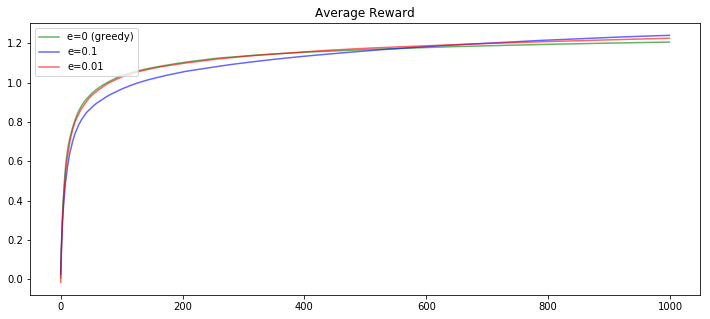

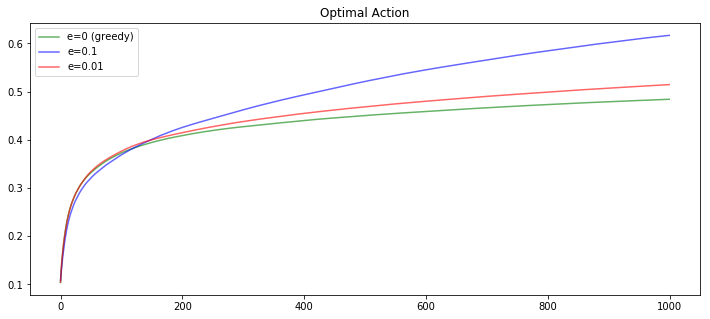

In [15]:
run_suite(simple_suite)

In [16]:
class WeightedAlgorithm(Algorithm):
    def __init__(self, k_bandit, params):
        Algorithm.__init__(self, k_bandit, params)

        self.reward_history = []

    def reset_test(self):
        Algorithm.reset_test(self)

        self.reward_history = []

    def compute(self, reward, action):
        #self.reward_history.append(reward)
        n = len(self.rewards_for_action_history[action])

        if n == 0:
            q = self.Q[action].item() + reward
            self.rewards_for_action_history[action].append(q)

        q = math.pow(1 - self.alpha, n) * self.rewards_for_action_history[action][0]

        for i in range(0, n):
            q += self.alpha * math.pow(1 - self.alpha, n - i - 1) * self.rewards_for_action_history[action][i]

        return q

In [19]:
nonstationary_suite = {
    "name": "Simple",
    "testbed": {
        "tests": 2000,
        "steps": 10000
    },
    "bandit": {
        "arms": 10,
        "nonstationary": True
    },
    "tasks": [
        {

            "algorithm": {
                "class": SimpleAlgorithm,
                "params": {
                    "init_value": 0.0,
                    "epsilon": 0.1,
                    "alpha": 0.1
                }
            },
            "plot": {
                "label": "basic",
                "color": "red"
            }
        },
        {
            "algorithm": {
                "class": WeightedAlgorithm,
                "params": {
                    "init_value": 0.0,
                    "epsilon": 0.1,
                    "alpha": 0.1
                }
            },
            "plot": {
                "label": "weighted",
                "color": "green"
            }
        }
    ]
}

In [20]:
run_suite(nonstationary_suite)

/Users/mexxik/Documents/projects/udemy/rl-book/venv/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


N/A% (0 of 2000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

  0% (1 of 2000) |                       | Elapsed Time: 0:00:04 ETA:   2:15:28

  0% (2 of 2000) |                       | Elapsed Time: 0:00:08 ETA:   2:12:44

  0% (3 of 2000) |                       | Elapsed Time: 0:00:12 ETA:   2:11:45

  0% (4 of 2000) |                       | Elapsed Time: 0:00:15 ETA:   2:11:48

  0% (5 of 2000) |                       | Elapsed Time: 0:00:19 ETA:   2:10:31

  0% (6 of 2000) |                       | Elapsed Time: 0:00:23 ETA:   2:12:15

  0% (7 of 2000) |                       | Elapsed Time: 0:00:27 ETA:   2:09:36

  0% (8 of 2000) |                       | Elapsed Time: 0:00:31 ETA:   2:09:15

  0% (9 of 2000) |                       | Elapsed Time: 0:00:35 ETA:   2:08:39

  0% (10 of 2000) |                      | Elapsed Time: 0:00:39 ETA:   2:08:34

  0% (11 of 2000) |                      | Elapsed Time: 0:00:43 ETA:   2:08:38

  0% (12 of 2000) |                      | Elapsed Time: 0:00:47 ETA:   2:09:11

  0% (13 of 2000) |                      | Elapsed Time: 0:00:51 ETA:   2:08:47

  0% (14 of 2000) |                      | Elapsed Time: 0:00:54 ETA:   2:08:25

  0% (15 of 2000) |                      | Elapsed Time: 0:00:58 ETA:   2:08:34

  0% (16 of 2000) |                      | Elapsed Time: 0:01:02 ETA:   2:08:32

  0% (17 of 2000) |                      | Elapsed Time: 0:01:06 ETA:   2:08:31

  0% (18 of 2000) |                      | Elapsed Time: 0:01:10 ETA:   2:08:20

  0% (19 of 2000) |                      | Elapsed Time: 0:01:14 ETA:   2:08:48

  1% (20 of 2000) |                      | Elapsed Time: 0:01:18 ETA:   2:08:37

  1% (21 of 2000) |                      | Elapsed Time: 0:01:22 ETA:   2:08:24

  1% (22 of 2000) |                      | Elapsed Time: 0:01:26 ETA:   2:09:46

  1% (23 of 2000) |                      | Elapsed Time: 0:01:30 ETA:   2:07:48

  1% (24 of 2000) |                      | Elapsed Time: 0:01:33 ETA:   2:08:11

  1% (25 of 2000) |                      | Elapsed Time: 0:01:37 ETA:   2:08:13

  1% (26 of 2000) |                      | Elapsed Time: 0:01:41 ETA:   2:08:12

  1% (27 of 2000) |                      | Elapsed Time: 0:01:45 ETA:   2:09:14

  1% (28 of 2000) |                      | Elapsed Time: 0:01:49 ETA:   2:07:57

  1% (29 of 2000) |                      | Elapsed Time: 0:01:53 ETA:   2:08:02

  1% (30 of 2000) |                      | Elapsed Time: 0:01:57 ETA:   2:10:56

  1% (31 of 2000) |                      | Elapsed Time: 0:02:01 ETA:   2:12:58

  1% (32 of 2000) |                      | Elapsed Time: 0:02:05 ETA:   2:12:35

  1% (33 of 2000) |                      | Elapsed Time: 0:02:09 ETA:   2:12:49

  1% (34 of 2000) |                      | Elapsed Time: 0:02:13 ETA:   2:12:39

  1% (35 of 2000) |                      | Elapsed Time: 0:02:17 ETA:   2:08:45

  1% (36 of 2000) |                      | Elapsed Time: 0:02:21 ETA:   2:09:13

  1% (37 of 2000) |                      | Elapsed Time: 0:02:25 ETA:   2:09:18

  1% (38 of 2000) |                      | Elapsed Time: 0:02:29 ETA:   2:09:03

  1% (39 of 2000) |                      | Elapsed Time: 0:02:33 ETA:   2:08:40

  2% (40 of 2000) |                      | Elapsed Time: 0:02:37 ETA:   2:11:11

  2% (41 of 2000) |                      | Elapsed Time: 0:02:41 ETA:   2:09:05

  2% (42 of 2000) |                      | Elapsed Time: 0:02:45 ETA:   2:08:35

  2% (43 of 2000) |                      | Elapsed Time: 0:02:49 ETA:   2:08:38

  2% (44 of 2000) |                      | Elapsed Time: 0:02:53 ETA:   2:08:27

  2% (45 of 2000) |                      | Elapsed Time: 0:02:57 ETA:   2:08:43

  2% (46 of 2000) |                      | Elapsed Time: 0:03:01 ETA:   2:07:58

  2% (47 of 2000) |                      | Elapsed Time: 0:03:04 ETA:   2:07:57

  2% (48 of 2000) |                      | Elapsed Time: 0:03:08 ETA:   2:07:59

  2% (49 of 2000) |                      | Elapsed Time: 0:03:12 ETA:   2:07:36

  2% (50 of 2000) |                      | Elapsed Time: 0:03:16 ETA:   2:08:00

  2% (51 of 2000) |                      | Elapsed Time: 0:03:20 ETA:   2:07:41

  2% (52 of 2000) |                      | Elapsed Time: 0:03:24 ETA:   2:07:35

  2% (53 of 2000) |                      | Elapsed Time: 0:03:28 ETA:   2:10:49

  2% (54 of 2000) |                      | Elapsed Time: 0:03:32 ETA:   2:07:35

  2% (55 of 2000) |                      | Elapsed Time: 0:03:36 ETA:   2:07:18

  2% (56 of 2000) |                      | Elapsed Time: 0:03:40 ETA:   2:07:07

  2% (57 of 2000) |                      | Elapsed Time: 0:03:44 ETA:   2:07:38

  2% (58 of 2000) |                      | Elapsed Time: 0:03:48 ETA:   2:07:19

  2% (59 of 2000) |                      | Elapsed Time: 0:03:52 ETA:   2:07:22

  3% (60 of 2000) |                      | Elapsed Time: 0:03:56 ETA:   2:07:24

  3% (61 of 2000) |                      | Elapsed Time: 0:04:00 ETA:   2:07:24

  3% (62 of 2000) |                      | Elapsed Time: 0:04:04 ETA:   2:07:13

  3% (63 of 2000) |                      | Elapsed Time: 0:04:07 ETA:   2:06:55

  3% (64 of 2000) |                      | Elapsed Time: 0:04:11 ETA:   2:07:06

  3% (65 of 2000) |                      | Elapsed Time: 0:04:15 ETA:   2:09:42

  3% (66 of 2000) |                      | Elapsed Time: 0:04:19 ETA:   2:08:40

  3% (67 of 2000) |                      | Elapsed Time: 0:04:23 ETA:   2:06:58

  3% (68 of 2000) |                      | Elapsed Time: 0:04:27 ETA:   2:08:00

  3% (69 of 2000) |                      | Elapsed Time: 0:04:31 ETA:   2:09:00

  3% (70 of 2000) |                      | Elapsed Time: 0:04:35 ETA:   2:11:11

  3% (71 of 2000) |                      | Elapsed Time: 0:04:39 ETA:   2:07:12

  3% (72 of 2000) |                      | Elapsed Time: 0:04:43 ETA:   2:06:35

  3% (73 of 2000) |                      | Elapsed Time: 0:04:47 ETA:   2:07:35

  3% (74 of 2000) |                      | Elapsed Time: 0:04:51 ETA:   2:07:01

  3% (75 of 2000) |                      | Elapsed Time: 0:04:55 ETA:   2:07:50

  3% (76 of 2000) |                      | Elapsed Time: 0:04:59 ETA:   2:06:39

  3% (77 of 2000) |                      | Elapsed Time: 0:05:03 ETA:   2:06:17

  3% (78 of 2000) |                      | Elapsed Time: 0:05:07 ETA:   2:06:03

  3% (79 of 2000) |                      | Elapsed Time: 0:05:11 ETA:   2:06:16

  4% (80 of 2000) |                      | Elapsed Time: 0:05:15 ETA:   2:06:56

  4% (81 of 2000) |                      | Elapsed Time: 0:05:19 ETA:   2:08:41

  4% (82 of 2000) |                      | Elapsed Time: 0:05:23 ETA:   2:06:42

  4% (83 of 2000) |                      | Elapsed Time: 0:05:27 ETA:   2:06:18

  4% (84 of 2000) |                      | Elapsed Time: 0:05:31 ETA:   2:06:41

  4% (85 of 2000) |                      | Elapsed Time: 0:05:35 ETA:   2:06:45

  4% (86 of 2000) |                      | Elapsed Time: 0:05:39 ETA:   2:06:49

  4% (87 of 2000) |                      | Elapsed Time: 0:05:43 ETA:   2:06:24

  4% (88 of 2000) |                      | Elapsed Time: 0:05:47 ETA:   2:12:39

  4% (89 of 2000) |                      | Elapsed Time: 0:05:51 ETA:   2:10:19

  4% (90 of 2000) |                      | Elapsed Time: 0:05:55 ETA:   2:16:28

  4% (91 of 2000) |#                     | Elapsed Time: 0:06:00 ETA:   2:12:57

  4% (92 of 2000) |#                     | Elapsed Time: 0:06:04 ETA:   2:11:04

  4% (93 of 2000) |#                     | Elapsed Time: 0:06:08 ETA:   2:11:58

  4% (94 of 2000) |#                     | Elapsed Time: 0:06:12 ETA:   2:12:44

  4% (95 of 2000) |#                     | Elapsed Time: 0:06:16 ETA:   2:14:16

  4% (96 of 2000) |#                     | Elapsed Time: 0:06:20 ETA:   2:12:22

  4% (97 of 2000) |#                     | Elapsed Time: 0:06:25 ETA:   2:11:02

  4% (98 of 2000) |#                     | Elapsed Time: 0:06:29 ETA:   2:12:56

  4% (99 of 2000) |#                     | Elapsed Time: 0:06:33 ETA:   2:11:31

  5% (100 of 2000) |#                    | Elapsed Time: 0:06:37 ETA:   2:12:03

  5% (101 of 2000) |#                    | Elapsed Time: 0:06:41 ETA:   2:12:37

  5% (102 of 2000) |#                    | Elapsed Time: 0:06:45 ETA:   2:15:03

  5% (103 of 2000) |#                    | Elapsed Time: 0:06:50 ETA:   2:12:12

  5% (104 of 2000) |#                    | Elapsed Time: 0:06:54 ETA:   2:11:25

  5% (105 of 2000) |#                    | Elapsed Time: 0:06:58 ETA:   2:14:44

  5% (106 of 2000) |#                    | Elapsed Time: 0:07:02 ETA:   2:05:27

  5% (107 of 2000) |#                    | Elapsed Time: 0:07:06 ETA:   2:06:27

  5% (108 of 2000) |#                    | Elapsed Time: 0:07:10 ETA:   2:05:33

  5% (109 of 2000) |#                    | Elapsed Time: 0:07:14 ETA:   2:05:26

  5% (110 of 2000) |#                    | Elapsed Time: 0:07:18 ETA:   2:04:06

  5% (111 of 2000) |#                    | Elapsed Time: 0:07:22 ETA:   2:04:26

  5% (112 of 2000) |#                    | Elapsed Time: 0:07:26 ETA:   2:05:33

  5% (113 of 2000) |#                    | Elapsed Time: 0:07:30 ETA:   2:08:53

  5% (114 of 2000) |#                    | Elapsed Time: 0:07:34 ETA:   2:09:03

  5% (115 of 2000) |#                    | Elapsed Time: 0:07:38 ETA:   2:08:19

  5% (116 of 2000) |#                    | Elapsed Time: 0:07:42 ETA:   2:14:10

  5% (117 of 2000) |#                    | Elapsed Time: 0:07:46 ETA:   2:04:04

  5% (118 of 2000) |#                    | Elapsed Time: 0:07:50 ETA:   2:03:39

  5% (119 of 2000) |#                    | Elapsed Time: 0:07:54 ETA:   2:03:32

  6% (120 of 2000) |#                    | Elapsed Time: 0:07:58 ETA:   2:03:44

  6% (121 of 2000) |#                    | Elapsed Time: 0:08:02 ETA:   2:03:40

  6% (122 of 2000) |#                    | Elapsed Time: 0:08:06 ETA:   2:05:28

  6% (123 of 2000) |#                    | Elapsed Time: 0:08:10 ETA:   2:03:40

  6% (124 of 2000) |#                    | Elapsed Time: 0:08:14 ETA:   2:04:04

  6% (125 of 2000) |#                    | Elapsed Time: 0:08:18 ETA:   2:03:11

  6% (126 of 2000) |#                    | Elapsed Time: 0:08:22 ETA:   2:03:43

  6% (127 of 2000) |#                    | Elapsed Time: 0:08:26 ETA:   2:03:13

  6% (128 of 2000) |#                    | Elapsed Time: 0:08:30 ETA:   2:03:27

  6% (129 of 2000) |#                    | Elapsed Time: 0:08:34 ETA:   2:16:52

  6% (130 of 2000) |#                    | Elapsed Time: 0:08:39 ETA:   2:18:49

  6% (131 of 2000) |#                    | Elapsed Time: 0:08:43 ETA:   2:02:46

  6% (132 of 2000) |#                    | Elapsed Time: 0:08:47 ETA:   2:03:47

  6% (133 of 2000) |#                    | Elapsed Time: 0:08:51 ETA:   2:02:18

  6% (134 of 2000) |#                    | Elapsed Time: 0:08:55 ETA:   2:02:29

  6% (135 of 2000) |#                    | Elapsed Time: 0:08:59 ETA:   2:02:57

  6% (136 of 2000) |#                    | Elapsed Time: 0:09:02 ETA:   2:02:04

  6% (137 of 2000) |#                    | Elapsed Time: 0:09:06 ETA:   2:02:18

  6% (138 of 2000) |#                    | Elapsed Time: 0:09:10 ETA:   2:02:31

  6% (139 of 2000) |#                    | Elapsed Time: 0:09:14 ETA:   2:02:44

  7% (140 of 2000) |#                    | Elapsed Time: 0:09:18 ETA:   2:02:38

  7% (141 of 2000) |#                    | Elapsed Time: 0:09:22 ETA:   2:01:46

  7% (142 of 2000) |#                    | Elapsed Time: 0:09:26 ETA:   2:01:45

  7% (143 of 2000) |#                    | Elapsed Time: 0:09:30 ETA:   2:03:02

  7% (144 of 2000) |#                    | Elapsed Time: 0:09:34 ETA:   2:02:02

  7% (145 of 2000) |#                    | Elapsed Time: 0:09:38 ETA:   2:01:20

  7% (146 of 2000) |#                    | Elapsed Time: 0:09:42 ETA:   2:01:18

  7% (147 of 2000) |#                    | Elapsed Time: 0:09:46 ETA:   2:01:39

  7% (148 of 2000) |#                    | Elapsed Time: 0:09:50 ETA:   2:01:09

  7% (149 of 2000) |#                    | Elapsed Time: 0:09:54 ETA:   2:08:18

  7% (150 of 2000) |#                    | Elapsed Time: 0:09:58 ETA:   2:01:17

  7% (151 of 2000) |#                    | Elapsed Time: 0:10:02 ETA:   2:00:39

  7% (152 of 2000) |#                    | Elapsed Time: 0:10:06 ETA:   2:00:38

  7% (153 of 2000) |#                    | Elapsed Time: 0:10:10 ETA:   2:00:13

  7% (154 of 2000) |#                    | Elapsed Time: 0:10:14 ETA:   2:00:47

  7% (155 of 2000) |#                    | Elapsed Time: 0:10:17 ETA:   2:01:15

  7% (156 of 2000) |#                    | Elapsed Time: 0:10:21 ETA:   2:00:21

  7% (157 of 2000) |#                    | Elapsed Time: 0:10:25 ETA:   2:00:52

  7% (158 of 2000) |#                    | Elapsed Time: 0:10:29 ETA:   2:02:05

  7% (159 of 2000) |#                    | Elapsed Time: 0:10:33 ETA:   2:00:26

  8% (160 of 2000) |#                    | Elapsed Time: 0:10:37 ETA:   1:59:57

  8% (161 of 2000) |#                    | Elapsed Time: 0:10:41 ETA:   2:00:19

  8% (162 of 2000) |#                    | Elapsed Time: 0:10:45 ETA:   2:01:00

  8% (163 of 2000) |#                    | Elapsed Time: 0:10:49 ETA:   2:00:07

  8% (164 of 2000) |#                    | Elapsed Time: 0:10:53 ETA:   2:00:12

  8% (165 of 2000) |#                    | Elapsed Time: 0:10:57 ETA:   2:00:21

  8% (166 of 2000) |#                    | Elapsed Time: 0:11:01 ETA:   1:59:50

  8% (167 of 2000) |#                    | Elapsed Time: 0:11:05 ETA:   1:59:44

  8% (168 of 2000) |#                    | Elapsed Time: 0:11:09 ETA:   1:59:41

  8% (169 of 2000) |#                    | Elapsed Time: 0:11:12 ETA:   1:59:29

  8% (170 of 2000) |#                    | Elapsed Time: 0:11:16 ETA:   1:59:40

  8% (171 of 2000) |#                    | Elapsed Time: 0:11:20 ETA:   1:59:39

  8% (172 of 2000) |#                    | Elapsed Time: 0:11:24 ETA:   2:00:09

  8% (173 of 2000) |#                    | Elapsed Time: 0:11:28 ETA:   1:59:50

  8% (174 of 2000) |#                    | Elapsed Time: 0:11:32 ETA:   1:59:26

  8% (175 of 2000) |#                    | Elapsed Time: 0:11:36 ETA:   1:59:13

  8% (176 of 2000) |#                    | Elapsed Time: 0:11:40 ETA:   1:58:55

  8% (177 of 2000) |#                    | Elapsed Time: 0:11:44 ETA:   1:59:21

  8% (178 of 2000) |#                    | Elapsed Time: 0:11:48 ETA:   1:59:08

  8% (179 of 2000) |#                    | Elapsed Time: 0:11:52 ETA:   1:59:20

  9% (180 of 2000) |#                    | Elapsed Time: 0:11:56 ETA:   1:59:01

  9% (181 of 2000) |#                    | Elapsed Time: 0:12:00 ETA:   1:58:55

  9% (182 of 2000) |#                    | Elapsed Time: 0:12:04 ETA:   1:59:17

  9% (183 of 2000) |#                    | Elapsed Time: 0:12:07 ETA:   1:58:36

  9% (184 of 2000) |#                    | Elapsed Time: 0:12:11 ETA:   1:58:38

  9% (185 of 2000) |#                    | Elapsed Time: 0:12:15 ETA:   1:59:22

  9% (186 of 2000) |#                    | Elapsed Time: 0:12:19 ETA:   1:59:06

  9% (187 of 2000) |#                    | Elapsed Time: 0:12:23 ETA:   1:58:47

  9% (188 of 2000) |#                    | Elapsed Time: 0:12:27 ETA:   2:00:42

  9% (189 of 2000) |#                    | Elapsed Time: 0:12:31 ETA:   2:06:38

  9% (190 of 2000) |#                    | Elapsed Time: 0:12:35 ETA:   1:58:23

  9% (191 of 2000) |##                   | Elapsed Time: 0:12:39 ETA:   1:58:26

  9% (192 of 2000) |##                   | Elapsed Time: 0:12:43 ETA:   1:58:22

  9% (193 of 2000) |##                   | Elapsed Time: 0:12:47 ETA:   1:58:36

  9% (194 of 2000) |##                   | Elapsed Time: 0:12:51 ETA:   1:58:16

  9% (195 of 2000) |##                   | Elapsed Time: 0:12:55 ETA:   1:58:08

  9% (196 of 2000) |##                   | Elapsed Time: 0:12:59 ETA:   2:02:28

  9% (197 of 2000) |##                   | Elapsed Time: 0:13:03 ETA:   2:02:01

  9% (198 of 2000) |##                   | Elapsed Time: 0:13:07 ETA:   2:01:45

  9% (199 of 2000) |##                   | Elapsed Time: 0:13:11 ETA:   2:01:32

 10% (200 of 2000) |##                   | Elapsed Time: 0:13:15 ETA:   1:59:11

 10% (201 of 2000) |##                   | Elapsed Time: 0:13:19 ETA:   1:57:35

 10% (202 of 2000) |##                   | Elapsed Time: 0:13:23 ETA:   1:57:20

 10% (203 of 2000) |##                   | Elapsed Time: 0:13:27 ETA:   1:57:39

 10% (204 of 2000) |##                   | Elapsed Time: 0:13:31 ETA:   1:57:27

 10% (205 of 2000) |##                   | Elapsed Time: 0:13:35 ETA:   1:57:12

 10% (206 of 2000) |##                   | Elapsed Time: 0:13:39 ETA:   1:57:40

 10% (207 of 2000) |##                   | Elapsed Time: 0:13:43 ETA:   1:57:17

 10% (208 of 2000) |##                   | Elapsed Time: 0:13:47 ETA:   1:57:45

 10% (209 of 2000) |##                   | Elapsed Time: 0:13:51 ETA:   1:57:29

 10% (210 of 2000) |##                   | Elapsed Time: 0:13:54 ETA:   1:57:01

 10% (211 of 2000) |##                   | Elapsed Time: 0:13:58 ETA:   1:57:03

 10% (212 of 2000) |##                   | Elapsed Time: 0:14:02 ETA:   1:56:32

 10% (213 of 2000) |##                   | Elapsed Time: 0:14:06 ETA:   1:56:43

 10% (214 of 2000) |##                   | Elapsed Time: 0:14:10 ETA:   1:57:11

 10% (215 of 2000) |##                   | Elapsed Time: 0:14:14 ETA:   1:56:55

 10% (216 of 2000) |##                   | Elapsed Time: 0:14:18 ETA:   1:56:23

 10% (217 of 2000) |##                   | Elapsed Time: 0:14:22 ETA:   1:56:39

 10% (218 of 2000) |##                   | Elapsed Time: 0:14:26 ETA:   1:56:30

 10% (219 of 2000) |##                   | Elapsed Time: 0:14:30 ETA:   1:57:36

 11% (220 of 2000) |##                   | Elapsed Time: 0:14:34 ETA:   1:56:41

 11% (221 of 2000) |##                   | Elapsed Time: 0:14:38 ETA:   1:56:22

 11% (222 of 2000) |##                   | Elapsed Time: 0:14:42 ETA:   1:56:48

 11% (223 of 2000) |##                   | Elapsed Time: 0:14:46 ETA:   1:56:34

 11% (224 of 2000) |##                   | Elapsed Time: 0:14:49 ETA:   1:56:06

 11% (225 of 2000) |##                   | Elapsed Time: 0:14:53 ETA:   1:56:21

 11% (226 of 2000) |##                   | Elapsed Time: 0:14:57 ETA:   1:56:08

 11% (227 of 2000) |##                   | Elapsed Time: 0:15:01 ETA:   1:56:26

 11% (228 of 2000) |##                   | Elapsed Time: 0:15:05 ETA:   1:56:21

 11% (229 of 2000) |##                   | Elapsed Time: 0:15:09 ETA:   1:56:11

 11% (230 of 2000) |##                   | Elapsed Time: 0:15:13 ETA:   1:55:39

 11% (231 of 2000) |##                   | Elapsed Time: 0:15:17 ETA:   1:56:30

 11% (232 of 2000) |##                   | Elapsed Time: 0:15:21 ETA:   1:55:39

 11% (233 of 2000) |##                   | Elapsed Time: 0:15:25 ETA:   1:56:06

 11% (234 of 2000) |##                   | Elapsed Time: 0:15:29 ETA:   1:55:51

 11% (235 of 2000) |##                   | Elapsed Time: 0:15:33 ETA:   1:55:59

 11% (236 of 2000) |##                   | Elapsed Time: 0:15:37 ETA:   1:55:59

 11% (237 of 2000) |##                   | Elapsed Time: 0:15:41 ETA:   1:55:26

 11% (238 of 2000) |##                   | Elapsed Time: 0:15:45 ETA:   1:56:10

 11% (239 of 2000) |##                   | Elapsed Time: 0:15:49 ETA:   1:56:00

 12% (240 of 2000) |##                   | Elapsed Time: 0:15:53 ETA:   2:05:35

 12% (241 of 2000) |##                   | Elapsed Time: 0:15:57 ETA:   1:55:40

 12% (242 of 2000) |##                   | Elapsed Time: 0:16:01 ETA:   1:56:07

 12% (243 of 2000) |##                   | Elapsed Time: 0:16:05 ETA:   1:55:21

 12% (244 of 2000) |##                   | Elapsed Time: 0:16:09 ETA:   1:55:10

 12% (245 of 2000) |##                   | Elapsed Time: 0:16:13 ETA:   1:55:27

 12% (246 of 2000) |##                   | Elapsed Time: 0:16:17 ETA:   1:56:17

 12% (247 of 2000) |##                   | Elapsed Time: 0:16:20 ETA:   1:55:15

 12% (248 of 2000) |##                   | Elapsed Time: 0:16:24 ETA:   1:55:07

 12% (249 of 2000) |##                   | Elapsed Time: 0:16:28 ETA:   1:55:09

 12% (250 of 2000) |##                   | Elapsed Time: 0:16:32 ETA:   1:55:12

 12% (251 of 2000) |##                   | Elapsed Time: 0:16:36 ETA:   1:54:44

 12% (252 of 2000) |##                   | Elapsed Time: 0:16:40 ETA:   1:54:58

 12% (253 of 2000) |##                   | Elapsed Time: 0:16:44 ETA:   1:55:16

 12% (254 of 2000) |##                   | Elapsed Time: 0:16:48 ETA:   1:54:44

 12% (255 of 2000) |##                   | Elapsed Time: 0:16:52 ETA:   1:54:46

 12% (256 of 2000) |##                   | Elapsed Time: 0:16:56 ETA:   1:54:14

 12% (257 of 2000) |##                   | Elapsed Time: 0:17:00 ETA:   1:54:27

 12% (258 of 2000) |##                   | Elapsed Time: 0:17:04 ETA:   1:54:18

 12% (259 of 2000) |##                   | Elapsed Time: 0:17:08 ETA:   1:53:49

 13% (260 of 2000) |##                   | Elapsed Time: 0:17:12 ETA:   1:53:56

 13% (261 of 2000) |##                   | Elapsed Time: 0:17:16 ETA:   1:54:50

 13% (262 of 2000) |##                   | Elapsed Time: 0:17:20 ETA:   1:55:40

 13% (263 of 2000) |##                   | Elapsed Time: 0:17:24 ETA:   1:53:42

 13% (264 of 2000) |##                   | Elapsed Time: 0:17:28 ETA:   1:53:55

 13% (265 of 2000) |##                   | Elapsed Time: 0:17:31 ETA:   1:53:35

 13% (266 of 2000) |##                   | Elapsed Time: 0:17:35 ETA:   1:53:32

 13% (267 of 2000) |##                   | Elapsed Time: 0:17:39 ETA:   1:53:33

 13% (268 of 2000) |##                   | Elapsed Time: 0:17:43 ETA:   1:53:30

 13% (269 of 2000) |##                   | Elapsed Time: 0:17:47 ETA:   1:53:28

 13% (270 of 2000) |##                   | Elapsed Time: 0:17:51 ETA:   1:53:32

 13% (271 of 2000) |##                   | Elapsed Time: 0:17:55 ETA:   1:55:59

 13% (272 of 2000) |##                   | Elapsed Time: 0:17:59 ETA:   1:53:35

 13% (273 of 2000) |##                   | Elapsed Time: 0:18:03 ETA:   1:53:25

 13% (274 of 2000) |##                   | Elapsed Time: 0:18:07 ETA:   1:52:41

 13% (275 of 2000) |##                   | Elapsed Time: 0:18:11 ETA:   1:52:49

 13% (276 of 2000) |##                   | Elapsed Time: 0:18:15 ETA:   1:53:09

 13% (277 of 2000) |##                   | Elapsed Time: 0:18:19 ETA:   1:52:46

 13% (278 of 2000) |##                   | Elapsed Time: 0:18:23 ETA:   1:52:49

 13% (279 of 2000) |##                   | Elapsed Time: 0:18:27 ETA:   1:54:36

 14% (280 of 2000) |##                   | Elapsed Time: 0:18:31 ETA:   1:56:21

 14% (281 of 2000) |##                   | Elapsed Time: 0:18:35 ETA:   1:56:39

 14% (282 of 2000) |##                   | Elapsed Time: 0:18:39 ETA:   1:57:37

 14% (283 of 2000) |##                   | Elapsed Time: 0:18:43 ETA:   1:55:18

 14% (284 of 2000) |##                   | Elapsed Time: 0:18:47 ETA:   1:52:42

 14% (285 of 2000) |##                   | Elapsed Time: 0:18:51 ETA:   1:52:41

 14% (286 of 2000) |###                  | Elapsed Time: 0:18:55 ETA:   1:51:59

 14% (287 of 2000) |###                  | Elapsed Time: 0:18:59 ETA:   1:51:56

 14% (288 of 2000) |###                  | Elapsed Time: 0:19:03 ETA:   1:55:26

 14% (289 of 2000) |###                  | Elapsed Time: 0:19:07 ETA:   2:10:37

 14% (290 of 2000) |###                  | Elapsed Time: 0:19:11 ETA:   1:53:20

 14% (291 of 2000) |###                  | Elapsed Time: 0:19:15 ETA:   1:53:04

 14% (292 of 2000) |###                  | Elapsed Time: 0:19:19 ETA:   1:53:09

 14% (293 of 2000) |###                  | Elapsed Time: 0:19:23 ETA:   1:53:03

 14% (294 of 2000) |###                  | Elapsed Time: 0:19:27 ETA:   1:52:32

 14% (295 of 2000) |###                  | Elapsed Time: 0:19:31 ETA:   1:53:50

 14% (296 of 2000) |###                  | Elapsed Time: 0:19:35 ETA:   1:53:15

 14% (297 of 2000) |###                  | Elapsed Time: 0:19:39 ETA:   1:52:30

 14% (298 of 2000) |###                  | Elapsed Time: 0:19:43 ETA:   1:52:38

 14% (299 of 2000) |###                  | Elapsed Time: 0:19:47 ETA:   1:52:47

 15% (300 of 2000) |###                  | Elapsed Time: 0:19:51 ETA:   1:52:17

 15% (301 of 2000) |###                  | Elapsed Time: 0:19:55 ETA:   1:52:21

 15% (302 of 2000) |###                  | Elapsed Time: 0:19:59 ETA:   1:52:10

 15% (303 of 2000) |###                  | Elapsed Time: 0:20:03 ETA:   2:04:25

 15% (304 of 2000) |###                  | Elapsed Time: 0:20:07 ETA:   1:52:29

 15% (305 of 2000) |###                  | Elapsed Time: 0:20:11 ETA:   1:52:10

 15% (306 of 2000) |###                  | Elapsed Time: 0:20:15 ETA:   1:52:25

 15% (307 of 2000) |###                  | Elapsed Time: 0:20:19 ETA:   1:52:38

 15% (308 of 2000) |###                  | Elapsed Time: 0:20:23 ETA:   1:51:54

 15% (309 of 2000) |###                  | Elapsed Time: 0:20:27 ETA:   1:51:37

 15% (310 of 2000) |###                  | Elapsed Time: 0:20:31 ETA:   1:51:38

 15% (311 of 2000) |###                  | Elapsed Time: 0:20:35 ETA:   1:52:30

 15% (312 of 2000) |###                  | Elapsed Time: 0:20:39 ETA:   1:51:27

 15% (313 of 2000) |###                  | Elapsed Time: 0:20:43 ETA:   1:52:41

 15% (314 of 2000) |###                  | Elapsed Time: 0:20:47 ETA:   1:52:47

 15% (315 of 2000) |###                  | Elapsed Time: 0:20:51 ETA:   1:51:59

 15% (316 of 2000) |###                  | Elapsed Time: 0:20:55 ETA:   1:51:51

 15% (317 of 2000) |###                  | Elapsed Time: 0:20:59 ETA:   1:51:15

 15% (318 of 2000) |###                  | Elapsed Time: 0:21:03 ETA:   1:52:27

 15% (319 of 2000) |###                  | Elapsed Time: 0:21:07 ETA:   1:51:51

 16% (320 of 2000) |###                  | Elapsed Time: 0:21:11 ETA:   1:51:11

 16% (321 of 2000) |###                  | Elapsed Time: 0:21:15 ETA:   1:51:42

 16% (322 of 2000) |###                  | Elapsed Time: 0:21:19 ETA:   1:50:48

 16% (323 of 2000) |###                  | Elapsed Time: 0:21:23 ETA:   1:51:51

 16% (324 of 2000) |###                  | Elapsed Time: 0:21:27 ETA:   1:50:50

 16% (325 of 2000) |###                  | Elapsed Time: 0:21:31 ETA:   1:51:21

 16% (326 of 2000) |###                  | Elapsed Time: 0:21:35 ETA:   1:50:36

 16% (327 of 2000) |###                  | Elapsed Time: 0:21:39 ETA:   1:50:32

 16% (328 of 2000) |###                  | Elapsed Time: 0:21:43 ETA:   1:50:39

 16% (329 of 2000) |###                  | Elapsed Time: 0:21:47 ETA:   1:51:27

 16% (330 of 2000) |###                  | Elapsed Time: 0:21:51 ETA:   1:51:03

 16% (331 of 2000) |###                  | Elapsed Time: 0:21:55 ETA:   1:50:56

 16% (332 of 2000) |###                  | Elapsed Time: 0:21:59 ETA:   1:50:11

 16% (333 of 2000) |###                  | Elapsed Time: 0:22:03 ETA:   1:51:15

 16% (334 of 2000) |###                  | Elapsed Time: 0:22:07 ETA:   1:50:43

 16% (335 of 2000) |###                  | Elapsed Time: 0:22:11 ETA:   1:50:25

 16% (336 of 2000) |###                  | Elapsed Time: 0:22:15 ETA:   1:50:48

 16% (337 of 2000) |###                  | Elapsed Time: 0:22:19 ETA:   1:49:38

 16% (338 of 2000) |###                  | Elapsed Time: 0:22:23 ETA:   1:50:14

 16% (339 of 2000) |###                  | Elapsed Time: 0:22:27 ETA:   1:50:15

 17% (340 of 2000) |###                  | Elapsed Time: 0:22:31 ETA:   1:50:19

 17% (341 of 2000) |###                  | Elapsed Time: 0:22:35 ETA:   1:49:45

 17% (342 of 2000) |###                  | Elapsed Time: 0:22:39 ETA:   1:49:39

 17% (343 of 2000) |###                  | Elapsed Time: 0:22:43 ETA:   1:50:26

 17% (344 of 2000) |###                  | Elapsed Time: 0:22:47 ETA:   1:50:10

 17% (345 of 2000) |###                  | Elapsed Time: 0:22:51 ETA:   1:49:47

 17% (346 of 2000) |###                  | Elapsed Time: 0:22:55 ETA:   1:49:54

 17% (347 of 2000) |###                  | Elapsed Time: 0:22:59 ETA:   1:49:31

 17% (348 of 2000) |###                  | Elapsed Time: 0:23:03 ETA:   1:49:32

 17% (349 of 2000) |###                  | Elapsed Time: 0:23:06 ETA:   1:49:15

 17% (350 of 2000) |###                  | Elapsed Time: 0:23:10 ETA:   1:49:15

 17% (351 of 2000) |###                  | Elapsed Time: 0:23:14 ETA:   1:49:54

 17% (352 of 2000) |###                  | Elapsed Time: 0:23:18 ETA:   1:48:49

 17% (353 of 2000) |###                  | Elapsed Time: 0:23:22 ETA:   1:49:42

 17% (354 of 2000) |###                  | Elapsed Time: 0:23:27 ETA:   1:52:14

 17% (355 of 2000) |###                  | Elapsed Time: 0:23:30 ETA:   1:49:33

 17% (356 of 2000) |###                  | Elapsed Time: 0:23:34 ETA:   1:48:57

 17% (357 of 2000) |###                  | Elapsed Time: 0:23:39 ETA:   1:50:52

 17% (358 of 2000) |###                  | Elapsed Time: 0:23:43 ETA:   1:49:27

 17% (359 of 2000) |###                  | Elapsed Time: 0:23:47 ETA:   1:49:20

 18% (360 of 2000) |###                  | Elapsed Time: 0:23:50 ETA:   1:48:36

 18% (361 of 2000) |###                  | Elapsed Time: 0:23:54 ETA:   1:48:26

 18% (362 of 2000) |###                  | Elapsed Time: 0:23:59 ETA:   1:53:29

 18% (363 of 2000) |###                  | Elapsed Time: 0:24:03 ETA:   1:53:41

 18% (364 of 2000) |###                  | Elapsed Time: 0:24:07 ETA:   2:01:53

 18% (365 of 2000) |###                  | Elapsed Time: 0:24:12 ETA:   1:59:10

 18% (366 of 2000) |###                  | Elapsed Time: 0:24:16 ETA:   1:50:24

 18% (367 of 2000) |###                  | Elapsed Time: 0:24:20 ETA:   1:48:10

 18% (368 of 2000) |###                  | Elapsed Time: 0:24:24 ETA:   1:48:37

 18% (369 of 2000) |###                  | Elapsed Time: 0:24:28 ETA:   1:48:03

 18% (370 of 2000) |###                  | Elapsed Time: 0:24:32 ETA:   1:48:39

 18% (371 of 2000) |###                  | Elapsed Time: 0:24:36 ETA:   1:48:02

 18% (372 of 2000) |###                  | Elapsed Time: 0:24:40 ETA:   1:47:48

 18% (373 of 2000) |###                  | Elapsed Time: 0:24:44 ETA:   1:47:36

 18% (374 of 2000) |###                  | Elapsed Time: 0:24:48 ETA:   1:48:24

 18% (375 of 2000) |###                  | Elapsed Time: 0:24:52 ETA:   1:48:02

 18% (376 of 2000) |###                  | Elapsed Time: 0:24:56 ETA:   1:47:42

 18% (377 of 2000) |###                  | Elapsed Time: 0:24:59 ETA:   1:47:25

 18% (378 of 2000) |###                  | Elapsed Time: 0:25:03 ETA:   1:47:43

 18% (379 of 2000) |###                  | Elapsed Time: 0:25:07 ETA:   1:47:21

 19% (380 of 2000) |###                  | Elapsed Time: 0:25:11 ETA:   1:47:09

 19% (381 of 2000) |####                 | Elapsed Time: 0:25:15 ETA:   1:47:34

 19% (382 of 2000) |####                 | Elapsed Time: 0:25:20 ETA:   2:02:18

 19% (383 of 2000) |####                 | Elapsed Time: 0:25:24 ETA:   1:48:27

 19% (384 of 2000) |####                 | Elapsed Time: 0:25:28 ETA:   1:59:35

 19% (385 of 2000) |####                 | Elapsed Time: 0:25:32 ETA:   1:45:52

 19% (386 of 2000) |####                 | Elapsed Time: 0:25:36 ETA:   1:46:00

 19% (387 of 2000) |####                 | Elapsed Time: 0:25:40 ETA:   1:45:53

 19% (388 of 2000) |####                 | Elapsed Time: 0:25:44 ETA:   1:45:42

 19% (389 of 2000) |####                 | Elapsed Time: 0:25:49 ETA:   1:56:56

 19% (390 of 2000) |####                 | Elapsed Time: 0:25:52 ETA:   1:45:42

 19% (391 of 2000) |####                 | Elapsed Time: 0:25:56 ETA:   1:45:44

 19% (392 of 2000) |####                 | Elapsed Time: 0:26:00 ETA:   1:45:52

 19% (393 of 2000) |####                 | Elapsed Time: 0:26:04 ETA:   1:46:26

 19% (394 of 2000) |####                 | Elapsed Time: 0:26:08 ETA:   1:48:07

 19% (395 of 2000) |####                 | Elapsed Time: 0:26:12 ETA:   1:47:12

 19% (396 of 2000) |####                 | Elapsed Time: 0:26:17 ETA:   1:59:32

 19% (397 of 2000) |####                 | Elapsed Time: 0:26:21 ETA:   1:56:16

 19% (398 of 2000) |####                 | Elapsed Time: 0:26:25 ETA:   1:46:10

 19% (399 of 2000) |####                 | Elapsed Time: 0:26:29 ETA:   1:45:13

 20% (400 of 2000) |####                 | Elapsed Time: 0:26:33 ETA:   1:45:19

 20% (401 of 2000) |####                 | Elapsed Time: 0:26:37 ETA:   1:45:26

 20% (402 of 2000) |####                 | Elapsed Time: 0:26:41 ETA:   1:44:47

 20% (403 of 2000) |####                 | Elapsed Time: 0:26:45 ETA:   1:45:46

 20% (404 of 2000) |####                 | Elapsed Time: 0:26:49 ETA:   1:45:03

 20% (405 of 2000) |####                 | Elapsed Time: 0:26:53 ETA:   1:45:21

 20% (406 of 2000) |####                 | Elapsed Time: 0:26:57 ETA:   1:44:58

 20% (407 of 2000) |####                 | Elapsed Time: 0:27:01 ETA:   1:44:18

 20% (408 of 2000) |####                 | Elapsed Time: 0:27:05 ETA:   1:44:24

 20% (409 of 2000) |####                 | Elapsed Time: 0:27:09 ETA:   1:44:45

 20% (410 of 2000) |####                 | Elapsed Time: 0:27:13 ETA:   1:44:22

 20% (411 of 2000) |####                 | Elapsed Time: 0:27:16 ETA:   1:44:29

 20% (412 of 2000) |####                 | Elapsed Time: 0:27:20 ETA:   1:44:35

 20% (413 of 2000) |####                 | Elapsed Time: 0:27:24 ETA:   1:44:38

 20% (414 of 2000) |####                 | Elapsed Time: 0:27:28 ETA:   1:44:08

 20% (415 of 2000) |####                 | Elapsed Time: 0:27:32 ETA:   1:44:22

 20% (416 of 2000) |####                 | Elapsed Time: 0:27:36 ETA:   1:43:51

 20% (417 of 2000) |####                 | Elapsed Time: 0:27:40 ETA:   1:43:43

 20% (418 of 2000) |####                 | Elapsed Time: 0:27:44 ETA:   1:44:21

 20% (419 of 2000) |####                 | Elapsed Time: 0:27:48 ETA:   1:44:12

 21% (420 of 2000) |####                 | Elapsed Time: 0:27:52 ETA:   1:44:09

 21% (421 of 2000) |####                 | Elapsed Time: 0:27:56 ETA:   1:44:06

 21% (422 of 2000) |####                 | Elapsed Time: 0:28:00 ETA:   1:44:01

 21% (423 of 2000) |####                 | Elapsed Time: 0:28:04 ETA:   1:43:52

 21% (424 of 2000) |####                 | Elapsed Time: 0:28:08 ETA:   1:43:42

 21% (425 of 2000) |####                 | Elapsed Time: 0:28:12 ETA:   1:43:59

 21% (426 of 2000) |####                 | Elapsed Time: 0:28:16 ETA:   1:44:37

 21% (427 of 2000) |####                 | Elapsed Time: 0:28:20 ETA:   1:43:16

 21% (428 of 2000) |####                 | Elapsed Time: 0:28:24 ETA:   1:43:39

 21% (429 of 2000) |####                 | Elapsed Time: 0:28:28 ETA:   1:43:22

 21% (430 of 2000) |####                 | Elapsed Time: 0:28:32 ETA:   1:43:26

 21% (431 of 2000) |####                 | Elapsed Time: 0:28:36 ETA:   1:43:12

 21% (432 of 2000) |####                 | Elapsed Time: 0:28:39 ETA:   1:43:23

 21% (433 of 2000) |####                 | Elapsed Time: 0:28:43 ETA:   1:43:01

 21% (434 of 2000) |####                 | Elapsed Time: 0:28:47 ETA:   1:43:07

 21% (435 of 2000) |####                 | Elapsed Time: 0:28:51 ETA:   1:42:44

 21% (436 of 2000) |####                 | Elapsed Time: 0:28:55 ETA:   1:44:05

 21% (437 of 2000) |####                 | Elapsed Time: 0:28:59 ETA:   1:43:32

 21% (438 of 2000) |####                 | Elapsed Time: 0:29:03 ETA:   1:42:54

 21% (439 of 2000) |####                 | Elapsed Time: 0:29:07 ETA:   1:42:30

 22% (440 of 2000) |####                 | Elapsed Time: 0:29:11 ETA:   1:42:40

 22% (441 of 2000) |####                 | Elapsed Time: 0:29:15 ETA:   1:42:26

 22% (442 of 2000) |####                 | Elapsed Time: 0:29:19 ETA:   1:42:20

 22% (443 of 2000) |####                 | Elapsed Time: 0:29:23 ETA:   1:42:50

 22% (444 of 2000) |####                 | Elapsed Time: 0:29:27 ETA:   1:44:21

 22% (445 of 2000) |####                 | Elapsed Time: 0:29:31 ETA:   1:46:26

 22% (446 of 2000) |####                 | Elapsed Time: 0:29:35 ETA:   1:47:06

 22% (447 of 2000) |####                 | Elapsed Time: 0:29:39 ETA:   1:48:00

 22% (448 of 2000) |####                 | Elapsed Time: 0:29:43 ETA:   1:44:23

 22% (449 of 2000) |####                 | Elapsed Time: 0:29:47 ETA:   1:42:21

 22% (450 of 2000) |####                 | Elapsed Time: 0:29:51 ETA:   1:41:47

 22% (451 of 2000) |####                 | Elapsed Time: 0:29:55 ETA:   1:41:44

 22% (452 of 2000) |####                 | Elapsed Time: 0:29:59 ETA:   1:42:03

 22% (453 of 2000) |####                 | Elapsed Time: 0:30:03 ETA:   1:41:49

 22% (454 of 2000) |####                 | Elapsed Time: 0:30:07 ETA:   1:41:24

 22% (455 of 2000) |####                 | Elapsed Time: 0:30:11 ETA:   1:41:15

 22% (456 of 2000) |####                 | Elapsed Time: 0:30:15 ETA:   1:41:37

 22% (457 of 2000) |####                 | Elapsed Time: 0:30:19 ETA:   1:42:10

 22% (458 of 2000) |####                 | Elapsed Time: 0:30:23 ETA:   1:40:53

 22% (459 of 2000) |####                 | Elapsed Time: 0:30:27 ETA:   1:41:12

 23% (460 of 2000) |####                 | Elapsed Time: 0:30:31 ETA:   1:40:51

 23% (461 of 2000) |####                 | Elapsed Time: 0:30:35 ETA:   1:40:34

 23% (462 of 2000) |####                 | Elapsed Time: 0:30:39 ETA:   1:40:37

 23% (463 of 2000) |####                 | Elapsed Time: 0:30:43 ETA:   1:40:37

 23% (464 of 2000) |####                 | Elapsed Time: 0:30:46 ETA:   1:40:41

 23% (465 of 2000) |####                 | Elapsed Time: 0:30:50 ETA:   1:40:43

 23% (466 of 2000) |####                 | Elapsed Time: 0:30:54 ETA:   1:40:32

 23% (467 of 2000) |####                 | Elapsed Time: 0:30:58 ETA:   1:40:10

 23% (468 of 2000) |####                 | Elapsed Time: 0:31:02 ETA:   1:41:57

 23% (469 of 2000) |####                 | Elapsed Time: 0:31:06 ETA:   1:40:25

 23% (470 of 2000) |####                 | Elapsed Time: 0:31:10 ETA:   1:40:25

 23% (471 of 2000) |####                 | Elapsed Time: 0:31:14 ETA:   1:40:32

 23% (472 of 2000) |####                 | Elapsed Time: 0:31:18 ETA:   1:40:19

 23% (473 of 2000) |####                 | Elapsed Time: 0:31:22 ETA:   1:40:04

 23% (474 of 2000) |####                 | Elapsed Time: 0:31:26 ETA:   1:40:29

 23% (475 of 2000) |####                 | Elapsed Time: 0:31:30 ETA:   1:39:52

 23% (476 of 2000) |####                 | Elapsed Time: 0:31:34 ETA:   1:39:44

 23% (477 of 2000) |#####                | Elapsed Time: 0:31:38 ETA:   1:39:35

 23% (478 of 2000) |#####                | Elapsed Time: 0:31:42 ETA:   1:39:25

 23% (479 of 2000) |#####                | Elapsed Time: 0:31:46 ETA:   1:39:44

 24% (480 of 2000) |#####                | Elapsed Time: 0:31:50 ETA:   1:57:49

 24% (481 of 2000) |#####                | Elapsed Time: 0:31:54 ETA:   1:39:26

 24% (482 of 2000) |#####                | Elapsed Time: 0:31:58 ETA:   1:40:14

 24% (483 of 2000) |#####                | Elapsed Time: 0:32:02 ETA:   1:39:37

 24% (484 of 2000) |#####                | Elapsed Time: 0:32:06 ETA:   1:39:43

 24% (485 of 2000) |#####                | Elapsed Time: 0:32:10 ETA:   1:39:26

 24% (486 of 2000) |#####                | Elapsed Time: 0:32:14 ETA:   1:39:22

 24% (487 of 2000) |#####                | Elapsed Time: 0:32:18 ETA:   1:39:25

 24% (488 of 2000) |#####                | Elapsed Time: 0:32:22 ETA:   1:39:07

 24% (489 of 2000) |#####                | Elapsed Time: 0:32:26 ETA:   1:39:19

 24% (490 of 2000) |#####                | Elapsed Time: 0:32:30 ETA:   1:38:53

 24% (491 of 2000) |#####                | Elapsed Time: 0:32:34 ETA:   1:39:02

 24% (492 of 2000) |#####                | Elapsed Time: 0:32:37 ETA:   1:39:16

 24% (493 of 2000) |#####                | Elapsed Time: 0:32:41 ETA:   1:38:42

 24% (494 of 2000) |#####                | Elapsed Time: 0:32:45 ETA:   1:39:25

 24% (495 of 2000) |#####                | Elapsed Time: 0:32:49 ETA:   1:38:28

 24% (496 of 2000) |#####                | Elapsed Time: 0:32:53 ETA:   1:38:27

 24% (497 of 2000) |#####                | Elapsed Time: 0:32:57 ETA:   1:38:34

 24% (498 of 2000) |#####                | Elapsed Time: 0:33:01 ETA:   1:38:19

 24% (499 of 2000) |#####                | Elapsed Time: 0:33:05 ETA:   1:37:57

 25% (500 of 2000) |#####                | Elapsed Time: 0:33:09 ETA:   1:38:07

 25% (501 of 2000) |#####                | Elapsed Time: 0:33:13 ETA:   1:38:09

 25% (502 of 2000) |#####                | Elapsed Time: 0:33:17 ETA:   1:38:06

 25% (503 of 2000) |#####                | Elapsed Time: 0:33:21 ETA:   1:54:05

 25% (504 of 2000) |#####                | Elapsed Time: 0:33:26 ETA:   1:44:52

 25% (505 of 2000) |#####                | Elapsed Time: 0:33:30 ETA:   1:52:37

 25% (506 of 2000) |#####                | Elapsed Time: 0:33:34 ETA:   1:43:25

 25% (507 of 2000) |#####                | Elapsed Time: 0:33:39 ETA:   1:49:18

 25% (508 of 2000) |#####                | Elapsed Time: 0:33:43 ETA:   1:44:43

 25% (509 of 2000) |#####                | Elapsed Time: 0:33:47 ETA:   1:47:33

 25% (510 of 2000) |#####                | Elapsed Time: 0:33:51 ETA:   1:45:38

 25% (511 of 2000) |#####                | Elapsed Time: 0:33:55 ETA:   1:36:13

 25% (512 of 2000) |#####                | Elapsed Time: 0:33:59 ETA:   1:35:42

 25% (513 of 2000) |#####                | Elapsed Time: 0:34:03 ETA:   1:35:55

 25% (514 of 2000) |#####                | Elapsed Time: 0:34:07 ETA:   1:35:33

 25% (515 of 2000) |#####                | Elapsed Time: 0:34:11 ETA:   1:35:35

 25% (516 of 2000) |#####                | Elapsed Time: 0:34:15 ETA:   1:36:48

 25% (517 of 2000) |#####                | Elapsed Time: 0:34:19 ETA:   1:36:03

 25% (518 of 2000) |#####                | Elapsed Time: 0:34:22 ETA:   1:35:42

 25% (519 of 2000) |#####                | Elapsed Time: 0:34:26 ETA:   1:38:00

 26% (520 of 2000) |#####                | Elapsed Time: 0:34:30 ETA:   1:36:47

 26% (521 of 2000) |#####                | Elapsed Time: 0:34:34 ETA:   1:35:54

 26% (522 of 2000) |#####                | Elapsed Time: 0:34:38 ETA:   1:35:26

 26% (523 of 2000) |#####                | Elapsed Time: 0:34:42 ETA:   1:35:19

 26% (524 of 2000) |#####                | Elapsed Time: 0:34:46 ETA:   1:35:17

 26% (525 of 2000) |#####                | Elapsed Time: 0:34:50 ETA:   1:39:46

 26% (526 of 2000) |#####                | Elapsed Time: 0:34:54 ETA:   1:35:01

 26% (527 of 2000) |#####                | Elapsed Time: 0:34:58 ETA:   1:35:49

 26% (528 of 2000) |#####                | Elapsed Time: 0:35:02 ETA:   1:36:25

 26% (529 of 2000) |#####                | Elapsed Time: 0:35:06 ETA:   1:35:36

 26% (530 of 2000) |#####                | Elapsed Time: 0:35:09 ETA:   1:36:10

 26% (531 of 2000) |#####                | Elapsed Time: 0:35:13 ETA:   1:35:27

 26% (532 of 2000) |#####                | Elapsed Time: 0:35:17 ETA:   1:34:35

 26% (533 of 2000) |#####                | Elapsed Time: 0:35:21 ETA:   1:33:56

 26% (534 of 2000) |#####                | Elapsed Time: 0:35:25 ETA:   1:34:01

 26% (535 of 2000) |#####                | Elapsed Time: 0:35:29 ETA:   1:33:35

 26% (536 of 2000) |#####                | Elapsed Time: 0:35:33 ETA:   1:33:58

 26% (537 of 2000) |#####                | Elapsed Time: 0:35:36 ETA:   1:34:07

 26% (538 of 2000) |#####                | Elapsed Time: 0:35:40 ETA:   1:34:05

 26% (539 of 2000) |#####                | Elapsed Time: 0:35:44 ETA:   1:33:42

 27% (540 of 2000) |#####                | Elapsed Time: 0:35:48 ETA:   1:34:04

 27% (541 of 2000) |#####                | Elapsed Time: 0:35:52 ETA:   1:33:23

 27% (542 of 2000) |#####                | Elapsed Time: 0:35:56 ETA:   1:33:44

 27% (543 of 2000) |#####                | Elapsed Time: 0:36:00 ETA:   1:33:50

 27% (544 of 2000) |#####                | Elapsed Time: 0:36:03 ETA:   1:33:31

 27% (545 of 2000) |#####                | Elapsed Time: 0:36:07 ETA:   1:33:16

 27% (546 of 2000) |#####                | Elapsed Time: 0:36:11 ETA:   1:33:12

 27% (547 of 2000) |#####                | Elapsed Time: 0:36:15 ETA:   1:33:10

 27% (548 of 2000) |#####                | Elapsed Time: 0:36:19 ETA:   1:33:23

 27% (549 of 2000) |#####                | Elapsed Time: 0:36:23 ETA:   1:33:03

 27% (550 of 2000) |#####                | Elapsed Time: 0:36:27 ETA:   1:33:03

 27% (551 of 2000) |#####                | Elapsed Time: 0:36:30 ETA:   1:32:40

 27% (552 of 2000) |#####                | Elapsed Time: 0:36:34 ETA:   1:33:10

 27% (553 of 2000) |#####                | Elapsed Time: 0:36:38 ETA:   1:39:10

 27% (554 of 2000) |#####                | Elapsed Time: 0:36:42 ETA:   1:35:36

 27% (555 of 2000) |#####                | Elapsed Time: 0:36:46 ETA:   1:39:57

 27% (556 of 2000) |#####                | Elapsed Time: 0:36:50 ETA:   1:35:57

 27% (557 of 2000) |#####                | Elapsed Time: 0:36:55 ETA:   1:50:21

 27% (558 of 2000) |#####                | Elapsed Time: 0:36:59 ETA:   1:41:35

 27% (559 of 2000) |#####                | Elapsed Time: 0:37:03 ETA:   1:40:34

 28% (560 of 2000) |#####                | Elapsed Time: 0:37:07 ETA:   1:32:34

 28% (561 of 2000) |#####                | Elapsed Time: 0:37:11 ETA:   1:32:43

 28% (562 of 2000) |#####                | Elapsed Time: 0:37:15 ETA:   1:37:48

 28% (563 of 2000) |#####                | Elapsed Time: 0:37:19 ETA:   1:34:17

 28% (564 of 2000) |#####                | Elapsed Time: 0:37:23 ETA:   1:32:13

 28% (565 of 2000) |#####                | Elapsed Time: 0:37:27 ETA:   1:32:27

 28% (566 of 2000) |#####                | Elapsed Time: 0:37:31 ETA:   1:31:48

 28% (567 of 2000) |#####                | Elapsed Time: 0:37:35 ETA:   1:32:10

 28% (568 of 2000) |#####                | Elapsed Time: 0:37:38 ETA:   1:32:23

 28% (569 of 2000) |#####                | Elapsed Time: 0:37:42 ETA:   1:32:18

 28% (570 of 2000) |#####                | Elapsed Time: 0:37:46 ETA:   1:31:43

 28% (571 of 2000) |#####                | Elapsed Time: 0:37:50 ETA:   1:32:11

 28% (572 of 2000) |######               | Elapsed Time: 0:37:54 ETA:   1:31:50

 28% (573 of 2000) |######               | Elapsed Time: 0:37:58 ETA:   1:32:11

 28% (574 of 2000) |######               | Elapsed Time: 0:38:02 ETA:   1:31:53

 28% (575 of 2000) |######               | Elapsed Time: 0:38:06 ETA:   1:31:34

 28% (576 of 2000) |######               | Elapsed Time: 0:38:09 ETA:   1:31:19

 28% (577 of 2000) |######               | Elapsed Time: 0:38:13 ETA:   1:31:16

 28% (578 of 2000) |######               | Elapsed Time: 0:38:17 ETA:   1:31:07

 28% (579 of 2000) |######               | Elapsed Time: 0:38:21 ETA:   1:31:24

 28% (580 of 2000) |######               | Elapsed Time: 0:38:25 ETA:   1:33:11

 29% (581 of 2000) |######               | Elapsed Time: 0:38:29 ETA:   1:31:32

 29% (582 of 2000) |######               | Elapsed Time: 0:38:33 ETA:   1:31:17

 29% (583 of 2000) |######               | Elapsed Time: 0:38:36 ETA:   1:31:02

 29% (584 of 2000) |######               | Elapsed Time: 0:38:40 ETA:   1:30:41

 29% (585 of 2000) |######               | Elapsed Time: 0:38:44 ETA:   1:31:25

 29% (586 of 2000) |######               | Elapsed Time: 0:38:48 ETA:   1:30:25

 29% (587 of 2000) |######               | Elapsed Time: 0:38:52 ETA:   1:30:38

 29% (588 of 2000) |######               | Elapsed Time: 0:38:56 ETA:   1:31:00

 29% (589 of 2000) |######               | Elapsed Time: 0:39:00 ETA:   1:31:02

 29% (590 of 2000) |######               | Elapsed Time: 0:39:03 ETA:   1:30:35

 29% (591 of 2000) |######               | Elapsed Time: 0:39:07 ETA:   1:30:37

 29% (592 of 2000) |######               | Elapsed Time: 0:39:11 ETA:   1:30:10

 29% (593 of 2000) |######               | Elapsed Time: 0:39:15 ETA:   1:30:25

 29% (594 of 2000) |######               | Elapsed Time: 0:39:19 ETA:   1:30:32

 29% (595 of 2000) |######               | Elapsed Time: 0:39:23 ETA:   1:30:07

 29% (596 of 2000) |######               | Elapsed Time: 0:39:27 ETA:   1:30:18

 29% (597 of 2000) |######               | Elapsed Time: 0:39:30 ETA:   1:30:11

 29% (598 of 2000) |######               | Elapsed Time: 0:39:34 ETA:   1:30:32

 29% (599 of 2000) |######               | Elapsed Time: 0:39:38 ETA:   1:30:07

 30% (600 of 2000) |######               | Elapsed Time: 0:39:42 ETA:   1:30:15

 30% (601 of 2000) |######               | Elapsed Time: 0:39:46 ETA:   1:29:49

 30% (602 of 2000) |######               | Elapsed Time: 0:39:50 ETA:   1:29:49

 30% (603 of 2000) |######               | Elapsed Time: 0:39:55 ETA:   2:00:59

 30% (604 of 2000) |######               | Elapsed Time: 0:39:59 ETA:   1:31:16

 30% (605 of 2000) |######               | Elapsed Time: 0:40:03 ETA:   1:29:32

 30% (606 of 2000) |######               | Elapsed Time: 0:40:07 ETA:   1:29:43

 30% (607 of 2000) |######               | Elapsed Time: 0:40:10 ETA:   1:29:35

 30% (608 of 2000) |######               | Elapsed Time: 0:40:14 ETA:   1:29:22

 30% (609 of 2000) |######               | Elapsed Time: 0:40:18 ETA:   1:29:04

 30% (610 of 2000) |######               | Elapsed Time: 0:40:22 ETA:   1:29:19

 30% (611 of 2000) |######               | Elapsed Time: 0:40:26 ETA:   1:29:56

 30% (612 of 2000) |######               | Elapsed Time: 0:40:30 ETA:   1:30:22

 30% (613 of 2000) |######               | Elapsed Time: 0:40:34 ETA:   1:30:31

 30% (614 of 2000) |######               | Elapsed Time: 0:40:38 ETA:   1:30:16

 30% (615 of 2000) |######               | Elapsed Time: 0:40:42 ETA:   1:29:56

 30% (616 of 2000) |######               | Elapsed Time: 0:40:45 ETA:   1:29:14

 30% (617 of 2000) |######               | Elapsed Time: 0:40:49 ETA:   1:28:45

 30% (618 of 2000) |######               | Elapsed Time: 0:40:53 ETA:   1:28:27

 30% (619 of 2000) |######               | Elapsed Time: 0:40:57 ETA:   1:28:31

 31% (620 of 2000) |######               | Elapsed Time: 0:41:01 ETA:   1:28:51

 31% (621 of 2000) |######               | Elapsed Time: 0:41:05 ETA:   1:28:40

 31% (622 of 2000) |######               | Elapsed Time: 0:41:08 ETA:   1:28:32

 31% (623 of 2000) |######               | Elapsed Time: 0:41:12 ETA:   1:27:59

 31% (624 of 2000) |######               | Elapsed Time: 0:41:16 ETA:   1:28:30

 31% (625 of 2000) |######               | Elapsed Time: 0:41:20 ETA:   1:28:24

 31% (626 of 2000) |######               | Elapsed Time: 0:41:24 ETA:   1:28:25

 31% (627 of 2000) |######               | Elapsed Time: 0:41:28 ETA:   1:28:13

 31% (628 of 2000) |######               | Elapsed Time: 0:41:32 ETA:   1:28:05

 31% (629 of 2000) |######               | Elapsed Time: 0:41:35 ETA:   1:28:05

 31% (630 of 2000) |######               | Elapsed Time: 0:41:39 ETA:   1:29:10

 31% (631 of 2000) |######               | Elapsed Time: 0:41:43 ETA:   1:27:28

 31% (632 of 2000) |######               | Elapsed Time: 0:41:47 ETA:   1:28:13

 31% (633 of 2000) |######               | Elapsed Time: 0:41:51 ETA:   1:27:36

 31% (634 of 2000) |######               | Elapsed Time: 0:41:55 ETA:   1:28:07

 31% (635 of 2000) |######               | Elapsed Time: 0:41:59 ETA:   1:27:24

 31% (636 of 2000) |######               | Elapsed Time: 0:42:02 ETA:   1:27:35

 31% (637 of 2000) |######               | Elapsed Time: 0:42:06 ETA:   1:27:31

 31% (638 of 2000) |######               | Elapsed Time: 0:42:10 ETA:   1:27:45

 31% (639 of 2000) |######               | Elapsed Time: 0:42:14 ETA:   1:27:23

 32% (640 of 2000) |######               | Elapsed Time: 0:42:18 ETA:   1:27:26

 32% (641 of 2000) |######               | Elapsed Time: 0:42:22 ETA:   1:27:02

 32% (642 of 2000) |######               | Elapsed Time: 0:42:26 ETA:   1:27:19

 32% (643 of 2000) |######               | Elapsed Time: 0:42:29 ETA:   1:27:26

 32% (644 of 2000) |######               | Elapsed Time: 0:42:33 ETA:   1:26:52

 32% (645 of 2000) |######               | Elapsed Time: 0:42:37 ETA:   1:26:42

 32% (646 of 2000) |######               | Elapsed Time: 0:42:41 ETA:   1:26:52

 32% (647 of 2000) |######               | Elapsed Time: 0:42:45 ETA:   1:27:06

 32% (648 of 2000) |######               | Elapsed Time: 0:42:49 ETA:   1:26:55

 32% (649 of 2000) |######               | Elapsed Time: 0:42:53 ETA:   1:26:56

 32% (650 of 2000) |######               | Elapsed Time: 0:42:56 ETA:   1:26:36

 32% (651 of 2000) |######               | Elapsed Time: 0:43:00 ETA:   1:26:33

 32% (652 of 2000) |######               | Elapsed Time: 0:43:04 ETA:   1:26:22

 32% (653 of 2000) |######               | Elapsed Time: 0:43:08 ETA:   1:26:23

 32% (654 of 2000) |######               | Elapsed Time: 0:43:12 ETA:   1:26:05

 32% (655 of 2000) |######               | Elapsed Time: 0:43:16 ETA:   1:26:24

 32% (656 of 2000) |######               | Elapsed Time: 0:43:20 ETA:   1:26:51

 32% (657 of 2000) |######               | Elapsed Time: 0:43:23 ETA:   1:26:45

 32% (658 of 2000) |######               | Elapsed Time: 0:43:27 ETA:   1:26:19

 32% (659 of 2000) |######               | Elapsed Time: 0:43:31 ETA:   1:25:56

 33% (660 of 2000) |######               | Elapsed Time: 0:43:36 ETA:   1:53:21

 33% (661 of 2000) |######               | Elapsed Time: 0:43:40 ETA:   1:33:28

 33% (662 of 2000) |######               | Elapsed Time: 0:43:44 ETA:   1:29:31

 33% (663 of 2000) |######               | Elapsed Time: 0:43:48 ETA:   1:27:27

 33% (664 of 2000) |######               | Elapsed Time: 0:43:52 ETA:   1:27:07

 33% (665 of 2000) |######               | Elapsed Time: 0:43:56 ETA:   1:29:03

 33% (666 of 2000) |######               | Elapsed Time: 0:44:00 ETA:   1:26:10

 33% (667 of 2000) |#######              | Elapsed Time: 0:44:04 ETA:   1:25:45

 33% (668 of 2000) |#######              | Elapsed Time: 0:44:08 ETA:   1:25:48

 33% (669 of 2000) |#######              | Elapsed Time: 0:44:12 ETA:   1:26:36

 33% (670 of 2000) |#######              | Elapsed Time: 0:44:16 ETA:   1:26:10

 33% (671 of 2000) |#######              | Elapsed Time: 0:44:20 ETA:   1:25:30

 33% (672 of 2000) |#######              | Elapsed Time: 0:44:23 ETA:   1:25:36

 33% (673 of 2000) |#######              | Elapsed Time: 0:44:27 ETA:   1:25:37

 33% (674 of 2000) |#######              | Elapsed Time: 0:44:31 ETA:   1:26:11

 33% (675 of 2000) |#######              | Elapsed Time: 0:44:35 ETA:   1:26:30

 33% (676 of 2000) |#######              | Elapsed Time: 0:44:39 ETA:   1:25:35

 33% (677 of 2000) |#######              | Elapsed Time: 0:44:43 ETA:   1:24:57

 33% (678 of 2000) |#######              | Elapsed Time: 0:44:47 ETA:   1:25:44

 33% (679 of 2000) |#######              | Elapsed Time: 0:44:51 ETA:   1:25:25

 34% (680 of 2000) |#######              | Elapsed Time: 0:44:54 ETA:   1:25:04

 34% (681 of 2000) |#######              | Elapsed Time: 0:44:58 ETA:   1:25:01

 34% (682 of 2000) |#######              | Elapsed Time: 0:45:02 ETA:   1:24:33

 34% (683 of 2000) |#######              | Elapsed Time: 0:45:06 ETA:   1:24:53

 34% (684 of 2000) |#######              | Elapsed Time: 0:45:10 ETA:   1:24:33

 34% (685 of 2000) |#######              | Elapsed Time: 0:45:14 ETA:   1:25:00

 34% (686 of 2000) |#######              | Elapsed Time: 0:45:18 ETA:   1:24:35

 34% (687 of 2000) |#######              | Elapsed Time: 0:45:21 ETA:   1:24:32

 34% (688 of 2000) |#######              | Elapsed Time: 0:45:26 ETA:   1:31:08

 34% (689 of 2000) |#######              | Elapsed Time: 0:45:30 ETA:   1:30:28

 34% (690 of 2000) |#######              | Elapsed Time: 0:45:34 ETA:   1:24:35

 34% (691 of 2000) |#######              | Elapsed Time: 0:45:38 ETA:   1:23:59

 34% (692 of 2000) |#######              | Elapsed Time: 0:45:41 ETA:   1:23:55

 34% (693 of 2000) |#######              | Elapsed Time: 0:45:45 ETA:   1:24:00

 34% (694 of 2000) |#######              | Elapsed Time: 0:45:49 ETA:   1:23:54

 34% (695 of 2000) |#######              | Elapsed Time: 0:45:53 ETA:   1:23:45

 34% (696 of 2000) |#######              | Elapsed Time: 0:45:57 ETA:   1:24:10

 34% (697 of 2000) |#######              | Elapsed Time: 0:46:01 ETA:   1:24:29

 34% (698 of 2000) |#######              | Elapsed Time: 0:46:05 ETA:   1:24:52

 34% (699 of 2000) |#######              | Elapsed Time: 0:46:09 ETA:   1:24:48

 35% (700 of 2000) |#######              | Elapsed Time: 0:46:12 ETA:   1:26:04

 35% (701 of 2000) |#######              | Elapsed Time: 0:46:16 ETA:   1:23:26

 35% (702 of 2000) |#######              | Elapsed Time: 0:46:20 ETA:   1:23:28

 35% (703 of 2000) |#######              | Elapsed Time: 0:46:24 ETA:   1:23:31

 35% (704 of 2000) |#######              | Elapsed Time: 0:46:28 ETA:   1:24:34

 35% (705 of 2000) |#######              | Elapsed Time: 0:46:32 ETA:   1:23:29

 35% (706 of 2000) |#######              | Elapsed Time: 0:46:36 ETA:   1:23:07

 35% (707 of 2000) |#######              | Elapsed Time: 0:46:40 ETA:   1:23:10

 35% (708 of 2000) |#######              | Elapsed Time: 0:46:43 ETA:   1:22:55

 35% (709 of 2000) |#######              | Elapsed Time: 0:46:47 ETA:   1:23:13

 35% (710 of 2000) |#######              | Elapsed Time: 0:46:51 ETA:   1:22:39

 35% (711 of 2000) |#######              | Elapsed Time: 0:46:55 ETA:   1:23:05

 35% (712 of 2000) |#######              | Elapsed Time: 0:46:59 ETA:   1:22:40

 35% (713 of 2000) |#######              | Elapsed Time: 0:47:03 ETA:   1:22:43

 35% (714 of 2000) |#######              | Elapsed Time: 0:47:07 ETA:   1:22:27

 35% (715 of 2000) |#######              | Elapsed Time: 0:47:10 ETA:   1:22:26

 35% (716 of 2000) |#######              | Elapsed Time: 0:47:14 ETA:   1:22:27

 35% (717 of 2000) |#######              | Elapsed Time: 0:47:18 ETA:   1:22:23

 35% (718 of 2000) |#######              | Elapsed Time: 0:47:22 ETA:   1:22:20

 35% (719 of 2000) |#######              | Elapsed Time: 0:47:26 ETA:   1:22:20

 36% (720 of 2000) |#######              | Elapsed Time: 0:47:30 ETA:   1:22:16

 36% (721 of 2000) |#######              | Elapsed Time: 0:47:34 ETA:   1:22:05

 36% (722 of 2000) |#######              | Elapsed Time: 0:47:37 ETA:   1:21:58

 36% (723 of 2000) |#######              | Elapsed Time: 0:47:41 ETA:   1:21:47

 36% (724 of 2000) |#######              | Elapsed Time: 0:47:45 ETA:   1:22:13

 36% (725 of 2000) |#######              | Elapsed Time: 0:47:49 ETA:   1:22:20

 36% (726 of 2000) |#######              | Elapsed Time: 0:47:53 ETA:   1:21:50

 36% (727 of 2000) |#######              | Elapsed Time: 0:47:57 ETA:   1:21:47

 36% (728 of 2000) |#######              | Elapsed Time: 0:48:01 ETA:   1:21:47

 36% (729 of 2000) |#######              | Elapsed Time: 0:48:04 ETA:   1:21:31

 36% (730 of 2000) |#######              | Elapsed Time: 0:48:08 ETA:   1:21:44

 36% (731 of 2000) |#######              | Elapsed Time: 0:48:12 ETA:   1:21:09

 36% (732 of 2000) |#######              | Elapsed Time: 0:48:16 ETA:   1:21:21

 36% (733 of 2000) |#######              | Elapsed Time: 0:48:20 ETA:   1:21:34

 36% (734 of 2000) |#######              | Elapsed Time: 0:48:24 ETA:   1:21:43

 36% (735 of 2000) |#######              | Elapsed Time: 0:48:28 ETA:   1:21:29

 36% (736 of 2000) |#######              | Elapsed Time: 0:48:31 ETA:   1:21:13

 36% (737 of 2000) |#######              | Elapsed Time: 0:48:35 ETA:   1:21:09

 36% (738 of 2000) |#######              | Elapsed Time: 0:48:39 ETA:   1:20:52

 36% (739 of 2000) |#######              | Elapsed Time: 0:48:43 ETA:   1:20:56

 37% (740 of 2000) |#######              | Elapsed Time: 0:48:47 ETA:   1:21:13

 37% (741 of 2000) |#######              | Elapsed Time: 0:48:51 ETA:   1:20:38

 37% (742 of 2000) |#######              | Elapsed Time: 0:48:54 ETA:   1:20:57

 37% (743 of 2000) |#######              | Elapsed Time: 0:48:58 ETA:   1:20:42

 37% (744 of 2000) |#######              | Elapsed Time: 0:49:02 ETA:   1:20:48

 37% (745 of 2000) |#######              | Elapsed Time: 0:49:06 ETA:   1:20:41

 37% (746 of 2000) |#######              | Elapsed Time: 0:49:10 ETA:   1:20:33

 37% (747 of 2000) |#######              | Elapsed Time: 0:49:14 ETA:   1:20:37

 37% (748 of 2000) |#######              | Elapsed Time: 0:49:18 ETA:   1:20:29

 37% (749 of 2000) |#######              | Elapsed Time: 0:49:21 ETA:   1:20:24

 37% (750 of 2000) |#######              | Elapsed Time: 0:49:25 ETA:   1:20:49

 37% (751 of 2000) |#######              | Elapsed Time: 0:49:29 ETA:   1:20:13

 37% (752 of 2000) |#######              | Elapsed Time: 0:49:33 ETA:   1:20:30

 37% (753 of 2000) |#######              | Elapsed Time: 0:49:37 ETA:   1:20:32

 37% (754 of 2000) |#######              | Elapsed Time: 0:49:41 ETA:   1:20:04

 37% (755 of 2000) |#######              | Elapsed Time: 0:49:45 ETA:   1:20:23

 37% (756 of 2000) |#######              | Elapsed Time: 0:49:49 ETA:   1:20:54

 37% (757 of 2000) |#######              | Elapsed Time: 0:50:18 ETA:  10:18:25

 37% (758 of 2000) |#######              | Elapsed Time: 0:50:22 ETA:   1:19:46

 37% (759 of 2000) |#######              | Elapsed Time: 0:50:26 ETA:   1:19:48

 38% (760 of 2000) |#######              | Elapsed Time: 0:50:30 ETA:   1:19:54

 38% (761 of 2000) |#######              | Elapsed Time: 0:50:34 ETA:   1:19:34

 38% (762 of 2000) |########             | Elapsed Time: 0:50:38 ETA:   1:19:43

 38% (763 of 2000) |########             | Elapsed Time: 0:50:42 ETA:   1:19:25

 38% (764 of 2000) |########             | Elapsed Time: 0:50:45 ETA:   1:19:23

 38% (765 of 2000) |########             | Elapsed Time: 0:50:49 ETA:   1:19:30

 38% (766 of 2000) |########             | Elapsed Time: 0:50:53 ETA:   1:19:21

 38% (767 of 2000) |########             | Elapsed Time: 0:50:57 ETA:   1:21:40

 38% (768 of 2000) |########             | Elapsed Time: 0:51:01 ETA:   1:19:41

 38% (769 of 2000) |########             | Elapsed Time: 0:51:05 ETA:   1:18:53

 38% (770 of 2000) |########             | Elapsed Time: 0:51:09 ETA:   1:19:10

 38% (771 of 2000) |########             | Elapsed Time: 0:51:13 ETA:   1:19:05

 38% (772 of 2000) |########             | Elapsed Time: 0:51:16 ETA:   1:19:00

 38% (773 of 2000) |########             | Elapsed Time: 0:51:20 ETA:   1:19:07

 38% (774 of 2000) |########             | Elapsed Time: 0:51:24 ETA:   1:18:54

 38% (775 of 2000) |########             | Elapsed Time: 0:51:28 ETA:   1:19:42

 38% (776 of 2000) |########             | Elapsed Time: 0:51:32 ETA:   1:19:52

 38% (777 of 2000) |########             | Elapsed Time: 0:51:36 ETA:   1:19:35

 38% (778 of 2000) |########             | Elapsed Time: 0:51:40 ETA:   1:19:45

 38% (779 of 2000) |########             | Elapsed Time: 0:51:44 ETA:   1:19:03

 39% (780 of 2000) |########             | Elapsed Time: 0:51:48 ETA:   1:18:39

 39% (781 of 2000) |########             | Elapsed Time: 0:51:51 ETA:   1:18:33

 39% (782 of 2000) |########             | Elapsed Time: 0:51:55 ETA:   1:18:25

 39% (783 of 2000) |########             | Elapsed Time: 0:51:59 ETA:   1:17:59

 39% (784 of 2000) |########             | Elapsed Time: 0:52:03 ETA:   1:18:01

 39% (785 of 2000) |########             | Elapsed Time: 0:52:07 ETA:   1:18:26

 39% (786 of 2000) |########             | Elapsed Time: 0:52:11 ETA:   1:17:54

 39% (787 of 2000) |########             | Elapsed Time: 0:52:15 ETA:   1:17:55

 39% (788 of 2000) |########             | Elapsed Time: 0:52:18 ETA:   1:17:51

 39% (789 of 2000) |########             | Elapsed Time: 0:52:22 ETA:   1:17:55

 39% (790 of 2000) |########             | Elapsed Time: 0:52:26 ETA:   1:17:46

 39% (791 of 2000) |########             | Elapsed Time: 0:52:30 ETA:   1:17:44

 39% (792 of 2000) |########             | Elapsed Time: 0:52:34 ETA:   1:17:22

 39% (793 of 2000) |########             | Elapsed Time: 0:52:38 ETA:   1:17:38

 39% (794 of 2000) |########             | Elapsed Time: 0:52:42 ETA:   1:17:27

 39% (795 of 2000) |########             | Elapsed Time: 0:52:45 ETA:   1:17:19

 39% (796 of 2000) |########             | Elapsed Time: 0:52:49 ETA:   1:17:17

 39% (797 of 2000) |########             | Elapsed Time: 0:52:53 ETA:   1:17:17

 39% (798 of 2000) |########             | Elapsed Time: 0:52:57 ETA:   1:17:21

 39% (799 of 2000) |########             | Elapsed Time: 0:53:01 ETA:   1:16:53

 40% (800 of 2000) |########             | Elapsed Time: 0:53:05 ETA:   1:17:26

 40% (801 of 2000) |########             | Elapsed Time: 0:53:09 ETA:   1:17:16

 40% (802 of 2000) |########             | Elapsed Time: 0:53:12 ETA:   1:17:33

 40% (803 of 2000) |########             | Elapsed Time: 0:53:16 ETA:   1:17:00

 40% (804 of 2000) |########             | Elapsed Time: 0:53:20 ETA:   1:16:54

 40% (805 of 2000) |########             | Elapsed Time: 0:53:24 ETA:   1:18:05

 40% (806 of 2000) |########             | Elapsed Time: 0:53:28 ETA:   1:17:08

 40% (807 of 2000) |########             | Elapsed Time: 0:53:32 ETA:   1:16:44

 40% (808 of 2000) |########             | Elapsed Time: 0:53:36 ETA:   1:16:37

 40% (809 of 2000) |########             | Elapsed Time: 0:53:40 ETA:   1:16:23

 40% (810 of 2000) |########             | Elapsed Time: 0:53:43 ETA:   1:16:32

 40% (811 of 2000) |########             | Elapsed Time: 0:53:47 ETA:   1:16:25

 40% (812 of 2000) |########             | Elapsed Time: 0:53:51 ETA:   1:17:01

 40% (813 of 2000) |########             | Elapsed Time: 0:53:55 ETA:   1:18:34

 40% (814 of 2000) |########             | Elapsed Time: 0:53:59 ETA:   1:16:28

 40% (815 of 2000) |########             | Elapsed Time: 0:54:03 ETA:   1:15:56

 40% (816 of 2000) |########             | Elapsed Time: 0:54:07 ETA:   1:15:56

 40% (817 of 2000) |########             | Elapsed Time: 0:54:11 ETA:   1:15:51

 40% (818 of 2000) |########             | Elapsed Time: 0:54:14 ETA:   1:16:25

 40% (819 of 2000) |########             | Elapsed Time: 0:54:18 ETA:   1:15:48

 41% (820 of 2000) |########             | Elapsed Time: 0:54:22 ETA:   1:15:51

 41% (821 of 2000) |########             | Elapsed Time: 0:54:26 ETA:   1:15:48

 41% (822 of 2000) |########             | Elapsed Time: 0:54:30 ETA:   1:16:21

 41% (823 of 2000) |########             | Elapsed Time: 0:54:34 ETA:   1:15:41

 41% (824 of 2000) |########             | Elapsed Time: 0:54:38 ETA:   1:16:23

 41% (825 of 2000) |########             | Elapsed Time: 0:54:41 ETA:   1:15:17

 41% (826 of 2000) |########             | Elapsed Time: 0:54:45 ETA:   1:15:31

 41% (827 of 2000) |########             | Elapsed Time: 0:54:49 ETA:   1:15:04

 41% (828 of 2000) |########             | Elapsed Time: 0:54:53 ETA:   1:15:25

 41% (829 of 2000) |########             | Elapsed Time: 0:54:57 ETA:   1:15:31

 41% (830 of 2000) |########             | Elapsed Time: 0:55:01 ETA:   1:15:01

 41% (831 of 2000) |########             | Elapsed Time: 0:55:05 ETA:   1:15:22

 41% (832 of 2000) |########             | Elapsed Time: 0:55:08 ETA:   1:15:01

 41% (833 of 2000) |########             | Elapsed Time: 0:55:12 ETA:   1:15:05

 41% (834 of 2000) |########             | Elapsed Time: 0:55:16 ETA:   1:15:00

 41% (835 of 2000) |########             | Elapsed Time: 0:55:20 ETA:   1:14:54

 41% (836 of 2000) |########             | Elapsed Time: 0:55:24 ETA:   1:15:12

 41% (837 of 2000) |########             | Elapsed Time: 0:55:28 ETA:   1:14:40

 41% (838 of 2000) |########             | Elapsed Time: 0:55:32 ETA:   1:14:53

 41% (839 of 2000) |########             | Elapsed Time: 0:55:35 ETA:   1:14:32

 42% (840 of 2000) |########             | Elapsed Time: 0:55:39 ETA:   1:14:43

 42% (841 of 2000) |########             | Elapsed Time: 0:55:43 ETA:   1:14:31

 42% (842 of 2000) |########             | Elapsed Time: 0:55:47 ETA:   1:14:24

 42% (843 of 2000) |########             | Elapsed Time: 0:55:51 ETA:   1:14:13

 42% (844 of 2000) |########             | Elapsed Time: 0:55:55 ETA:   1:14:33

 42% (845 of 2000) |########             | Elapsed Time: 0:55:59 ETA:   1:14:28

 42% (846 of 2000) |########             | Elapsed Time: 0:56:03 ETA:   1:14:05

 42% (847 of 2000) |########             | Elapsed Time: 0:56:06 ETA:   1:14:01

 42% (848 of 2000) |########             | Elapsed Time: 0:56:10 ETA:   1:14:19

 42% (849 of 2000) |########             | Elapsed Time: 0:56:14 ETA:   1:13:48

 42% (850 of 2000) |########             | Elapsed Time: 0:56:18 ETA:   1:13:58

 42% (851 of 2000) |########             | Elapsed Time: 0:56:22 ETA:   1:15:19

 42% (852 of 2000) |########             | Elapsed Time: 0:56:26 ETA:   1:16:28

 42% (853 of 2000) |########             | Elapsed Time: 0:56:30 ETA:   1:14:19

 42% (854 of 2000) |########             | Elapsed Time: 0:56:34 ETA:   1:13:23

 42% (855 of 2000) |########             | Elapsed Time: 0:56:37 ETA:   1:13:19

 42% (856 of 2000) |########             | Elapsed Time: 0:56:41 ETA:   1:13:17

 42% (857 of 2000) |########             | Elapsed Time: 0:56:45 ETA:   1:13:22

 42% (858 of 2000) |#########            | Elapsed Time: 0:56:49 ETA:   1:13:25

 42% (859 of 2000) |#########            | Elapsed Time: 0:56:53 ETA:   1:13:19

 43% (860 of 2000) |#########            | Elapsed Time: 0:56:57 ETA:   1:13:21

 43% (861 of 2000) |#########            | Elapsed Time: 0:57:01 ETA:   1:14:14

 43% (862 of 2000) |#########            | Elapsed Time: 0:57:05 ETA:   1:14:10

 43% (863 of 2000) |#########            | Elapsed Time: 0:57:08 ETA:   1:14:10

 43% (864 of 2000) |#########            | Elapsed Time: 0:57:12 ETA:   1:14:23

 43% (865 of 2000) |#########            | Elapsed Time: 0:57:16 ETA:   1:12:55

 43% (866 of 2000) |#########            | Elapsed Time: 0:57:20 ETA:   1:12:40

 43% (867 of 2000) |#########            | Elapsed Time: 0:57:24 ETA:   1:12:56

 43% (868 of 2000) |#########            | Elapsed Time: 0:57:28 ETA:   1:12:52

 43% (869 of 2000) |#########            | Elapsed Time: 0:57:32 ETA:   1:12:45

 43% (870 of 2000) |#########            | Elapsed Time: 0:57:36 ETA:   1:12:43

 43% (871 of 2000) |#########            | Elapsed Time: 0:57:39 ETA:   1:12:44

 43% (872 of 2000) |#########            | Elapsed Time: 0:57:43 ETA:   1:12:29

 43% (873 of 2000) |#########            | Elapsed Time: 0:57:47 ETA:   1:12:19

 43% (874 of 2000) |#########            | Elapsed Time: 0:57:51 ETA:   1:12:22

 43% (875 of 2000) |#########            | Elapsed Time: 0:57:55 ETA:   1:12:16

 43% (876 of 2000) |#########            | Elapsed Time: 0:57:59 ETA:   1:12:12

 43% (877 of 2000) |#########            | Elapsed Time: 0:58:03 ETA:   1:12:57

 43% (878 of 2000) |#########            | Elapsed Time: 0:58:06 ETA:   1:12:05

 43% (879 of 2000) |#########            | Elapsed Time: 0:58:10 ETA:   1:12:02

 44% (880 of 2000) |#########            | Elapsed Time: 0:58:14 ETA:   1:11:57

 44% (881 of 2000) |#########            | Elapsed Time: 0:58:18 ETA:   1:11:32

 44% (882 of 2000) |#########            | Elapsed Time: 0:58:22 ETA:   1:11:55

 44% (883 of 2000) |#########            | Elapsed Time: 0:58:26 ETA:   1:12:04

 44% (884 of 2000) |#########            | Elapsed Time: 0:58:30 ETA:   1:11:35

 44% (885 of 2000) |#########            | Elapsed Time: 0:58:33 ETA:   1:11:49

 44% (886 of 2000) |#########            | Elapsed Time: 0:58:37 ETA:   1:11:30

 44% (887 of 2000) |#########            | Elapsed Time: 0:58:41 ETA:   1:11:22

 44% (888 of 2000) |#########            | Elapsed Time: 0:58:45 ETA:   1:11:29

 44% (889 of 2000) |#########            | Elapsed Time: 0:58:49 ETA:   1:11:23

 44% (890 of 2000) |#########            | Elapsed Time: 0:58:53 ETA:   1:11:45

 44% (891 of 2000) |#########            | Elapsed Time: 0:58:57 ETA:   1:11:06

 44% (892 of 2000) |#########            | Elapsed Time: 0:59:00 ETA:   1:11:04

 44% (893 of 2000) |#########            | Elapsed Time: 0:59:04 ETA:   1:11:02

 44% (894 of 2000) |#########            | Elapsed Time: 0:59:08 ETA:   1:11:09

 44% (895 of 2000) |#########            | Elapsed Time: 0:59:12 ETA:   1:10:56

 44% (896 of 2000) |#########            | Elapsed Time: 0:59:16 ETA:   1:10:49

 44% (897 of 2000) |#########            | Elapsed Time: 0:59:20 ETA:   1:10:49

 44% (898 of 2000) |#########            | Elapsed Time: 0:59:24 ETA:   1:11:06

 44% (899 of 2000) |#########            | Elapsed Time: 0:59:27 ETA:   1:10:51

 45% (900 of 2000) |#########            | Elapsed Time: 0:59:31 ETA:   1:11:08

 45% (901 of 2000) |#########            | Elapsed Time: 0:59:35 ETA:   1:10:35

 45% (902 of 2000) |#########            | Elapsed Time: 0:59:39 ETA:   1:11:14

 45% (903 of 2000) |#########            | Elapsed Time: 0:59:43 ETA:   1:10:22

 45% (904 of 2000) |#########            | Elapsed Time: 0:59:47 ETA:   1:10:35

 45% (905 of 2000) |#########            | Elapsed Time: 0:59:51 ETA:   1:10:34

 45% (906 of 2000) |#########            | Elapsed Time: 0:59:54 ETA:   1:10:30

 45% (907 of 2000) |#########            | Elapsed Time: 0:59:58 ETA:   1:10:15

 45% (908 of 2000) |#########            | Elapsed Time: 1:00:02 ETA:   1:10:19

 45% (909 of 2000) |#########            | Elapsed Time: 1:00:06 ETA:   1:10:04

 45% (910 of 2000) |#########            | Elapsed Time: 1:00:10 ETA:   1:10:40

 45% (911 of 2000) |#########            | Elapsed Time: 1:00:14 ETA:   1:10:01

 45% (912 of 2000) |#########            | Elapsed Time: 1:00:18 ETA:   1:09:43

 45% (913 of 2000) |#########            | Elapsed Time: 1:00:22 ETA:   1:09:58

 45% (914 of 2000) |#########            | Elapsed Time: 1:00:25 ETA:   1:09:49

 45% (915 of 2000) |#########            | Elapsed Time: 1:00:29 ETA:   1:09:48

 45% (916 of 2000) |#########            | Elapsed Time: 1:00:33 ETA:   1:09:42

 45% (917 of 2000) |#########            | Elapsed Time: 1:00:37 ETA:   1:09:39

 45% (918 of 2000) |#########            | Elapsed Time: 1:00:41 ETA:   1:09:33

 45% (919 of 2000) |#########            | Elapsed Time: 1:00:45 ETA:   1:09:25

 46% (920 of 2000) |#########            | Elapsed Time: 1:00:48 ETA:   1:09:18

 46% (921 of 2000) |#########            | Elapsed Time: 1:00:52 ETA:   1:09:20

 46% (922 of 2000) |#########            | Elapsed Time: 1:00:56 ETA:   1:09:06

 46% (923 of 2000) |#########            | Elapsed Time: 1:01:00 ETA:   1:09:06

 46% (924 of 2000) |#########            | Elapsed Time: 1:01:04 ETA:   1:09:04

 46% (925 of 2000) |#########            | Elapsed Time: 1:01:08 ETA:   1:09:16

 46% (926 of 2000) |#########            | Elapsed Time: 1:01:12 ETA:   1:09:09

 46% (927 of 2000) |#########            | Elapsed Time: 1:01:15 ETA:   1:08:54

 46% (928 of 2000) |#########            | Elapsed Time: 1:01:19 ETA:   1:08:50

 46% (929 of 2000) |#########            | Elapsed Time: 1:01:23 ETA:   1:08:47

 46% (930 of 2000) |#########            | Elapsed Time: 1:01:27 ETA:   1:08:39

 46% (931 of 2000) |#########            | Elapsed Time: 1:01:31 ETA:   1:08:46

 46% (932 of 2000) |#########            | Elapsed Time: 1:01:35 ETA:   1:08:55

 46% (933 of 2000) |#########            | Elapsed Time: 1:01:39 ETA:   1:08:42

 46% (934 of 2000) |#########            | Elapsed Time: 1:01:42 ETA:   1:08:29

 46% (935 of 2000) |#########            | Elapsed Time: 1:01:46 ETA:   1:08:34

 46% (936 of 2000) |#########            | Elapsed Time: 1:01:50 ETA:   1:08:29

 46% (937 of 2000) |#########            | Elapsed Time: 1:01:54 ETA:   1:08:04

 46% (938 of 2000) |#########            | Elapsed Time: 1:01:58 ETA:   1:10:02

 46% (939 of 2000) |#########            | Elapsed Time: 1:02:02 ETA:   1:07:47

 47% (940 of 2000) |#########            | Elapsed Time: 1:02:06 ETA:   1:08:04

 47% (941 of 2000) |#########            | Elapsed Time: 1:02:10 ETA:   1:08:06

 47% (942 of 2000) |#########            | Elapsed Time: 1:02:13 ETA:   1:08:01

 47% (943 of 2000) |#########            | Elapsed Time: 1:02:17 ETA:   1:07:47

 47% (944 of 2000) |#########            | Elapsed Time: 1:02:21 ETA:   1:07:41

 47% (945 of 2000) |#########            | Elapsed Time: 1:02:25 ETA:   1:07:37

 47% (946 of 2000) |#########            | Elapsed Time: 1:02:29 ETA:   1:08:22

 47% (947 of 2000) |#########            | Elapsed Time: 1:02:33 ETA:   1:08:26

 47% (948 of 2000) |#########            | Elapsed Time: 1:02:40 ETA:   2:11:58

 47% (949 of 2000) |#########            | Elapsed Time: 1:02:44 ETA:   1:10:38

 47% (950 of 2000) |#########            | Elapsed Time: 1:02:48 ETA:   1:07:42

 47% (951 of 2000) |#########            | Elapsed Time: 1:02:52 ETA:   1:07:30

 47% (952 of 2000) |#########            | Elapsed Time: 1:02:56 ETA:   1:07:14

 47% (953 of 2000) |##########           | Elapsed Time: 1:03:00 ETA:   1:07:43

 47% (954 of 2000) |##########           | Elapsed Time: 1:03:04 ETA:   1:07:16

 47% (955 of 2000) |##########           | Elapsed Time: 1:03:07 ETA:   1:07:16

 47% (956 of 2000) |##########           | Elapsed Time: 1:03:11 ETA:   1:07:03

 47% (957 of 2000) |##########           | Elapsed Time: 1:03:15 ETA:   1:06:56

 47% (958 of 2000) |##########           | Elapsed Time: 1:03:19 ETA:   1:06:52

 47% (959 of 2000) |##########           | Elapsed Time: 1:03:23 ETA:   1:07:13

 48% (960 of 2000) |##########           | Elapsed Time: 1:03:27 ETA:   1:07:01

 48% (961 of 2000) |##########           | Elapsed Time: 1:03:31 ETA:   1:06:38

 48% (962 of 2000) |##########           | Elapsed Time: 1:03:34 ETA:   1:06:44

 48% (963 of 2000) |##########           | Elapsed Time: 1:03:38 ETA:   1:06:40

 48% (964 of 2000) |##########           | Elapsed Time: 1:03:42 ETA:   1:06:35

 48% (965 of 2000) |##########           | Elapsed Time: 1:03:46 ETA:   1:06:24

 48% (966 of 2000) |##########           | Elapsed Time: 1:03:50 ETA:   1:06:15

 48% (967 of 2000) |##########           | Elapsed Time: 1:03:55 ETA:   1:20:18

 48% (968 of 2000) |##########           | Elapsed Time: 1:03:58 ETA:   1:07:17

 48% (969 of 2000) |##########           | Elapsed Time: 1:04:02 ETA:   1:06:43

 48% (970 of 2000) |##########           | Elapsed Time: 1:04:06 ETA:   1:05:54

 48% (971 of 2000) |##########           | Elapsed Time: 1:04:10 ETA:   1:05:57

 48% (972 of 2000) |##########           | Elapsed Time: 1:04:14 ETA:   1:06:24

 48% (973 of 2000) |##########           | Elapsed Time: 1:04:18 ETA:   1:06:19

 48% (974 of 2000) |##########           | Elapsed Time: 1:04:22 ETA:   1:06:00

 48% (975 of 2000) |##########           | Elapsed Time: 1:04:26 ETA:   1:06:50

 48% (976 of 2000) |##########           | Elapsed Time: 1:04:29 ETA:   1:06:00

 48% (977 of 2000) |##########           | Elapsed Time: 1:04:33 ETA:   1:05:45

 48% (978 of 2000) |##########           | Elapsed Time: 1:04:37 ETA:   1:06:05

 48% (979 of 2000) |##########           | Elapsed Time: 1:04:41 ETA:   1:05:56

 49% (980 of 2000) |##########           | Elapsed Time: 1:04:45 ETA:   1:06:23

 49% (981 of 2000) |##########           | Elapsed Time: 1:04:49 ETA:   1:06:04

 49% (982 of 2000) |##########           | Elapsed Time: 1:04:53 ETA:   1:05:22

 49% (983 of 2000) |##########           | Elapsed Time: 1:04:57 ETA:   1:05:35

 49% (984 of 2000) |##########           | Elapsed Time: 1:05:00 ETA:   1:05:10

 49% (985 of 2000) |##########           | Elapsed Time: 1:05:04 ETA:   1:04:56

 49% (986 of 2000) |##########           | Elapsed Time: 1:05:08 ETA:   1:05:18

 49% (987 of 2000) |##########           | Elapsed Time: 1:05:12 ETA:   1:05:11

 49% (988 of 2000) |##########           | Elapsed Time: 1:05:16 ETA:   1:04:47

 49% (989 of 2000) |##########           | Elapsed Time: 1:05:20 ETA:   1:04:47

 49% (990 of 2000) |##########           | Elapsed Time: 1:05:24 ETA:   1:04:57

 49% (991 of 2000) |##########           | Elapsed Time: 1:05:27 ETA:   1:05:01

 49% (992 of 2000) |##########           | Elapsed Time: 1:05:31 ETA:   1:04:31

 49% (993 of 2000) |##########           | Elapsed Time: 1:05:35 ETA:   1:04:18

 49% (994 of 2000) |##########           | Elapsed Time: 1:05:39 ETA:   1:05:28

 49% (995 of 2000) |##########           | Elapsed Time: 1:05:43 ETA:   1:04:29

 49% (996 of 2000) |##########           | Elapsed Time: 1:05:47 ETA:   1:04:16

 49% (997 of 2000) |##########           | Elapsed Time: 1:05:51 ETA:   1:04:08

 49% (998 of 2000) |##########           | Elapsed Time: 1:05:54 ETA:   1:04:05

 49% (999 of 2000) |##########           | Elapsed Time: 1:05:58 ETA:   1:04:17

 50% (1000 of 2000) |##########          | Elapsed Time: 1:06:02 ETA:   1:04:13

 50% (1001 of 2000) |##########          | Elapsed Time: 1:06:06 ETA:   1:03:36

 50% (1002 of 2000) |##########          | Elapsed Time: 1:06:10 ETA:   1:03:49

 50% (1003 of 2000) |##########          | Elapsed Time: 1:06:14 ETA:   1:03:53

 50% (1004 of 2000) |##########          | Elapsed Time: 1:06:17 ETA:   1:03:48

 50% (1005 of 2000) |##########          | Elapsed Time: 1:06:21 ETA:   1:03:43

 50% (1006 of 2000) |##########          | Elapsed Time: 1:06:25 ETA:   1:03:30

 50% (1007 of 2000) |##########          | Elapsed Time: 1:06:29 ETA:   1:03:17

 50% (1008 of 2000) |##########          | Elapsed Time: 1:06:33 ETA:   1:03:31

 50% (1009 of 2000) |##########          | Elapsed Time: 1:06:37 ETA:   1:03:37

 50% (1010 of 2000) |##########          | Elapsed Time: 1:06:40 ETA:   1:03:01

 50% (1011 of 2000) |##########          | Elapsed Time: 1:06:44 ETA:   1:03:49

 50% (1012 of 2000) |##########          | Elapsed Time: 1:06:48 ETA:   1:03:12

 50% (1013 of 2000) |##########          | Elapsed Time: 1:06:52 ETA:   1:02:56

 50% (1014 of 2000) |##########          | Elapsed Time: 1:06:56 ETA:   1:03:16

 50% (1015 of 2000) |##########          | Elapsed Time: 1:07:00 ETA:   1:03:48

 50% (1016 of 2000) |##########          | Elapsed Time: 1:07:04 ETA:   1:03:08

 50% (1017 of 2000) |##########          | Elapsed Time: 1:07:07 ETA:   1:02:54

 50% (1018 of 2000) |##########          | Elapsed Time: 1:07:11 ETA:   1:03:01

 50% (1019 of 2000) |##########          | Elapsed Time: 1:07:15 ETA:   1:03:02

 51% (1020 of 2000) |##########          | Elapsed Time: 1:07:19 ETA:   1:02:26

 51% (1021 of 2000) |##########          | Elapsed Time: 1:07:23 ETA:   1:02:35

 51% (1022 of 2000) |##########          | Elapsed Time: 1:07:27 ETA:   1:03:30

 51% (1023 of 2000) |##########          | Elapsed Time: 1:07:31 ETA:   1:03:18

 51% (1024 of 2000) |##########          | Elapsed Time: 1:07:34 ETA:   1:02:21

 51% (1025 of 2000) |##########          | Elapsed Time: 1:07:38 ETA:   1:02:15

 51% (1026 of 2000) |##########          | Elapsed Time: 1:07:42 ETA:   1:02:24

 51% (1027 of 2000) |##########          | Elapsed Time: 1:07:46 ETA:   1:02:14

 51% (1028 of 2000) |##########          | Elapsed Time: 1:07:50 ETA:   1:02:23

 51% (1029 of 2000) |##########          | Elapsed Time: 1:07:54 ETA:   1:02:10

 51% (1030 of 2000) |##########          | Elapsed Time: 1:07:57 ETA:   1:02:38

 51% (1031 of 2000) |##########          | Elapsed Time: 1:08:01 ETA:   1:02:42

 51% (1032 of 2000) |##########          | Elapsed Time: 1:08:05 ETA:   1:02:30

 51% (1033 of 2000) |##########          | Elapsed Time: 1:08:09 ETA:   1:02:25

 51% (1034 of 2000) |##########          | Elapsed Time: 1:08:13 ETA:   1:02:11

 51% (1035 of 2000) |##########          | Elapsed Time: 1:08:17 ETA:   1:01:47

 51% (1036 of 2000) |##########          | Elapsed Time: 1:08:21 ETA:   1:01:53

 51% (1037 of 2000) |##########          | Elapsed Time: 1:08:24 ETA:   1:01:33

 51% (1038 of 2000) |##########          | Elapsed Time: 1:08:28 ETA:   1:01:35

 51% (1039 of 2000) |##########          | Elapsed Time: 1:08:32 ETA:   1:01:34

 52% (1040 of 2000) |##########          | Elapsed Time: 1:08:36 ETA:   1:01:24

 52% (1041 of 2000) |##########          | Elapsed Time: 1:08:40 ETA:   1:02:25

 52% (1042 of 2000) |##########          | Elapsed Time: 1:08:44 ETA:   1:01:47

 52% (1043 of 2000) |##########          | Elapsed Time: 1:08:48 ETA:   1:01:21

 52% (1044 of 2000) |##########          | Elapsed Time: 1:08:51 ETA:   1:01:15

 52% (1045 of 2000) |##########          | Elapsed Time: 1:08:55 ETA:   1:01:17

 52% (1046 of 2000) |##########          | Elapsed Time: 1:08:59 ETA:   1:00:58

 52% (1047 of 2000) |##########          | Elapsed Time: 1:09:03 ETA:   1:00:58

 52% (1048 of 2000) |##########          | Elapsed Time: 1:09:07 ETA:   1:00:45

 52% (1049 of 2000) |##########          | Elapsed Time: 1:09:11 ETA:   1:01:16

 52% (1050 of 2000) |##########          | Elapsed Time: 1:09:15 ETA:   1:00:51

 52% (1051 of 2000) |##########          | Elapsed Time: 1:09:18 ETA:   1:00:48

 52% (1052 of 2000) |##########          | Elapsed Time: 1:09:22 ETA:   1:00:41

 52% (1053 of 2000) |##########          | Elapsed Time: 1:09:26 ETA:   1:01:02

 52% (1054 of 2000) |##########          | Elapsed Time: 1:09:30 ETA:   1:00:42

 52% (1055 of 2000) |##########          | Elapsed Time: 1:09:34 ETA:   1:00:54

 52% (1056 of 2000) |##########          | Elapsed Time: 1:09:38 ETA:   1:00:54

 52% (1057 of 2000) |##########          | Elapsed Time: 1:09:42 ETA:   1:01:08

 52% (1058 of 2000) |##########          | Elapsed Time: 1:09:45 ETA:   1:01:03

 52% (1059 of 2000) |##########          | Elapsed Time: 1:09:49 ETA:   1:00:28

 53% (1060 of 2000) |##########          | Elapsed Time: 1:09:53 ETA:   1:00:16

 53% (1061 of 2000) |##########          | Elapsed Time: 1:09:57 ETA:   1:00:30

 53% (1062 of 2000) |##########          | Elapsed Time: 1:10:01 ETA:   1:00:13

 53% (1063 of 2000) |##########          | Elapsed Time: 1:10:05 ETA:   1:00:22

 53% (1064 of 2000) |##########          | Elapsed Time: 1:10:09 ETA:   1:00:11

 53% (1065 of 2000) |##########          | Elapsed Time: 1:10:12 ETA:   1:00:01

 53% (1066 of 2000) |##########          | Elapsed Time: 1:10:16 ETA:   1:00:14

 53% (1067 of 2000) |##########          | Elapsed Time: 1:10:20 ETA:   0:59:45

 53% (1068 of 2000) |##########          | Elapsed Time: 1:10:24 ETA:   1:00:05

 53% (1069 of 2000) |##########          | Elapsed Time: 1:10:28 ETA:   0:59:35

 53% (1070 of 2000) |##########          | Elapsed Time: 1:10:32 ETA:   0:59:41

 53% (1071 of 2000) |##########          | Elapsed Time: 1:10:36 ETA:   0:59:20

 53% (1072 of 2000) |##########          | Elapsed Time: 1:10:39 ETA:   0:59:26

 53% (1073 of 2000) |##########          | Elapsed Time: 1:10:43 ETA:   1:00:53

 53% (1074 of 2000) |##########          | Elapsed Time: 1:10:47 ETA:   0:59:05

 53% (1075 of 2000) |##########          | Elapsed Time: 1:10:51 ETA:   0:59:03

 53% (1076 of 2000) |##########          | Elapsed Time: 1:10:55 ETA:   0:59:24

 53% (1077 of 2000) |##########          | Elapsed Time: 1:10:59 ETA:   0:59:07

 53% (1078 of 2000) |##########          | Elapsed Time: 1:11:03 ETA:   0:59:16

 53% (1079 of 2000) |##########          | Elapsed Time: 1:11:06 ETA:   0:58:53

 54% (1080 of 2000) |##########          | Elapsed Time: 1:11:10 ETA:   0:59:10

 54% (1081 of 2000) |##########          | Elapsed Time: 1:11:14 ETA:   0:58:56

 54% (1082 of 2000) |##########          | Elapsed Time: 1:11:18 ETA:   0:58:39

 54% (1083 of 2000) |##########          | Elapsed Time: 1:11:22 ETA:   0:58:50

 54% (1084 of 2000) |##########          | Elapsed Time: 1:11:26 ETA:   0:58:58

 54% (1085 of 2000) |##########          | Elapsed Time: 1:11:29 ETA:   0:58:34

 54% (1086 of 2000) |##########          | Elapsed Time: 1:11:33 ETA:   0:58:30

 54% (1087 of 2000) |##########          | Elapsed Time: 1:11:37 ETA:   0:58:37

 54% (1088 of 2000) |##########          | Elapsed Time: 1:11:41 ETA:   0:58:37

 54% (1089 of 2000) |##########          | Elapsed Time: 1:11:45 ETA:   0:58:09

 54% (1090 of 2000) |##########          | Elapsed Time: 1:11:49 ETA:   0:58:19

 54% (1091 of 2000) |##########          | Elapsed Time: 1:11:53 ETA:   0:58:05

 54% (1092 of 2000) |##########          | Elapsed Time: 1:11:56 ETA:   0:58:14

 54% (1093 of 2000) |##########          | Elapsed Time: 1:12:00 ETA:   0:57:51

 54% (1094 of 2000) |##########          | Elapsed Time: 1:12:04 ETA:   0:58:39

 54% (1095 of 2000) |##########          | Elapsed Time: 1:12:08 ETA:   0:58:23

 54% (1096 of 2000) |##########          | Elapsed Time: 1:12:12 ETA:   0:58:06

 54% (1097 of 2000) |##########          | Elapsed Time: 1:12:16 ETA:   0:57:55

 54% (1098 of 2000) |##########          | Elapsed Time: 1:12:20 ETA:   0:57:52

 54% (1099 of 2000) |##########          | Elapsed Time: 1:12:23 ETA:   0:57:35

 55% (1100 of 2000) |###########         | Elapsed Time: 1:12:27 ETA:   0:57:32

 55% (1101 of 2000) |###########         | Elapsed Time: 1:12:31 ETA:   0:57:38

 55% (1102 of 2000) |###########         | Elapsed Time: 1:12:35 ETA:   0:57:48

 55% (1103 of 2000) |###########         | Elapsed Time: 1:12:39 ETA:   0:57:22

 55% (1104 of 2000) |###########         | Elapsed Time: 1:12:43 ETA:   0:57:25

 55% (1105 of 2000) |###########         | Elapsed Time: 1:12:46 ETA:   0:57:28

 55% (1106 of 2000) |###########         | Elapsed Time: 1:12:50 ETA:   0:57:40

 55% (1107 of 2000) |###########         | Elapsed Time: 1:12:54 ETA:   0:57:08

 55% (1108 of 2000) |###########         | Elapsed Time: 1:12:58 ETA:   0:59:01

 55% (1109 of 2000) |###########         | Elapsed Time: 1:13:02 ETA:   0:57:10

 55% (1110 of 2000) |###########         | Elapsed Time: 1:13:06 ETA:   0:57:01

 55% (1111 of 2000) |###########         | Elapsed Time: 1:13:10 ETA:   0:56:55

 55% (1112 of 2000) |###########         | Elapsed Time: 1:13:14 ETA:   0:56:57

 55% (1113 of 2000) |###########         | Elapsed Time: 1:13:17 ETA:   0:56:42

 55% (1114 of 2000) |###########         | Elapsed Time: 1:13:21 ETA:   0:56:46

 55% (1115 of 2000) |###########         | Elapsed Time: 1:13:25 ETA:   0:56:50

 55% (1116 of 2000) |###########         | Elapsed Time: 1:13:29 ETA:   0:57:10

 55% (1117 of 2000) |###########         | Elapsed Time: 1:13:33 ETA:   0:57:48

 55% (1118 of 2000) |###########         | Elapsed Time: 1:13:37 ETA:   0:57:19

 55% (1119 of 2000) |###########         | Elapsed Time: 1:13:41 ETA:   0:57:13

 56% (1120 of 2000) |###########         | Elapsed Time: 1:13:45 ETA:   0:56:35

 56% (1121 of 2000) |###########         | Elapsed Time: 1:13:48 ETA:   0:56:14

 56% (1122 of 2000) |###########         | Elapsed Time: 1:13:52 ETA:   0:56:12

 56% (1123 of 2000) |###########         | Elapsed Time: 1:13:56 ETA:   0:56:38

 56% (1124 of 2000) |###########         | Elapsed Time: 1:14:00 ETA:   0:56:05

 56% (1125 of 2000) |###########         | Elapsed Time: 1:14:04 ETA:   0:55:57

 56% (1126 of 2000) |###########         | Elapsed Time: 1:14:08 ETA:   0:55:58

 56% (1127 of 2000) |###########         | Elapsed Time: 1:14:11 ETA:   0:55:27

 56% (1128 of 2000) |###########         | Elapsed Time: 1:14:15 ETA:   0:55:57

 56% (1129 of 2000) |###########         | Elapsed Time: 1:14:19 ETA:   0:55:42

 56% (1130 of 2000) |###########         | Elapsed Time: 1:14:23 ETA:   0:55:25

 56% (1131 of 2000) |###########         | Elapsed Time: 1:14:27 ETA:   0:55:38

 56% (1132 of 2000) |###########         | Elapsed Time: 1:14:31 ETA:   0:55:33

 56% (1133 of 2000) |###########         | Elapsed Time: 1:14:34 ETA:   0:55:56

 56% (1134 of 2000) |###########         | Elapsed Time: 1:14:38 ETA:   0:55:50

 56% (1135 of 2000) |###########         | Elapsed Time: 1:14:42 ETA:   0:56:04

 56% (1136 of 2000) |###########         | Elapsed Time: 1:14:46 ETA:   0:55:31

 56% (1137 of 2000) |###########         | Elapsed Time: 1:14:50 ETA:   0:55:21

 56% (1138 of 2000) |###########         | Elapsed Time: 1:14:54 ETA:   0:55:07

 56% (1139 of 2000) |###########         | Elapsed Time: 1:14:58 ETA:   0:55:03

 56% (1140 of 2000) |###########         | Elapsed Time: 1:15:01 ETA:   0:55:18

 57% (1141 of 2000) |###########         | Elapsed Time: 1:15:05 ETA:   0:54:59

 57% (1142 of 2000) |###########         | Elapsed Time: 1:15:09 ETA:   0:54:53

 57% (1143 of 2000) |###########         | Elapsed Time: 1:15:13 ETA:   0:54:53

 57% (1144 of 2000) |###########         | Elapsed Time: 1:15:17 ETA:   0:55:01

 57% (1145 of 2000) |###########         | Elapsed Time: 1:15:21 ETA:   0:54:57

 57% (1146 of 2000) |###########         | Elapsed Time: 1:15:25 ETA:   0:54:56

 57% (1147 of 2000) |###########         | Elapsed Time: 1:15:28 ETA:   0:54:52

 57% (1148 of 2000) |###########         | Elapsed Time: 1:15:32 ETA:   0:54:31

 57% (1149 of 2000) |###########         | Elapsed Time: 1:15:36 ETA:   0:54:35

 57% (1150 of 2000) |###########         | Elapsed Time: 1:15:40 ETA:   0:54:40

 57% (1151 of 2000) |###########         | Elapsed Time: 1:15:44 ETA:   0:54:40

 57% (1152 of 2000) |###########         | Elapsed Time: 1:15:48 ETA:   0:54:14

 57% (1153 of 2000) |###########         | Elapsed Time: 1:15:52 ETA:   0:54:16

 57% (1154 of 2000) |###########         | Elapsed Time: 1:15:55 ETA:   0:54:05

 57% (1155 of 2000) |###########         | Elapsed Time: 1:15:59 ETA:   0:54:15

 57% (1156 of 2000) |###########         | Elapsed Time: 1:16:03 ETA:   0:54:24

 57% (1157 of 2000) |###########         | Elapsed Time: 1:16:07 ETA:   0:53:47

 57% (1158 of 2000) |###########         | Elapsed Time: 1:16:11 ETA:   0:53:43

 57% (1159 of 2000) |###########         | Elapsed Time: 1:16:15 ETA:   0:53:50

 57% (1160 of 2000) |###########         | Elapsed Time: 1:16:18 ETA:   0:53:38

 58% (1161 of 2000) |###########         | Elapsed Time: 1:16:22 ETA:   0:53:37

 58% (1162 of 2000) |###########         | Elapsed Time: 1:16:26 ETA:   0:53:57

 58% (1163 of 2000) |###########         | Elapsed Time: 1:16:30 ETA:   0:53:28

 58% (1164 of 2000) |###########         | Elapsed Time: 1:16:34 ETA:   0:53:30

 58% (1165 of 2000) |###########         | Elapsed Time: 1:16:38 ETA:   0:53:25

 58% (1166 of 2000) |###########         | Elapsed Time: 1:16:41 ETA:   0:53:19

 58% (1167 of 2000) |###########         | Elapsed Time: 1:16:45 ETA:   0:53:21

 58% (1168 of 2000) |###########         | Elapsed Time: 1:16:49 ETA:   0:53:26

 58% (1169 of 2000) |###########         | Elapsed Time: 1:16:53 ETA:   0:53:22

 58% (1170 of 2000) |###########         | Elapsed Time: 1:16:57 ETA:   0:53:12

 58% (1171 of 2000) |###########         | Elapsed Time: 1:17:01 ETA:   0:52:56

 58% (1172 of 2000) |###########         | Elapsed Time: 1:17:05 ETA:   0:53:05

 58% (1173 of 2000) |###########         | Elapsed Time: 1:17:08 ETA:   0:52:58

 58% (1174 of 2000) |###########         | Elapsed Time: 1:17:12 ETA:   0:52:53

 58% (1175 of 2000) |###########         | Elapsed Time: 1:17:16 ETA:   0:53:09

 58% (1176 of 2000) |###########         | Elapsed Time: 1:17:20 ETA:   0:52:52

 58% (1177 of 2000) |###########         | Elapsed Time: 1:17:24 ETA:   0:52:53

 58% (1178 of 2000) |###########         | Elapsed Time: 1:17:28 ETA:   0:52:34

 58% (1179 of 2000) |###########         | Elapsed Time: 1:17:31 ETA:   0:52:38

 59% (1180 of 2000) |###########         | Elapsed Time: 1:17:35 ETA:   0:52:19

 59% (1181 of 2000) |###########         | Elapsed Time: 1:17:39 ETA:   0:52:34

 59% (1182 of 2000) |###########         | Elapsed Time: 1:17:43 ETA:   0:52:15

 59% (1183 of 2000) |###########         | Elapsed Time: 1:17:47 ETA:   0:52:14

 59% (1184 of 2000) |###########         | Elapsed Time: 1:17:51 ETA:   0:52:23

 59% (1185 of 2000) |###########         | Elapsed Time: 1:17:55 ETA:   0:52:13

 59% (1186 of 2000) |###########         | Elapsed Time: 1:17:58 ETA:   0:52:20

 59% (1187 of 2000) |###########         | Elapsed Time: 1:18:02 ETA:   0:52:21

 59% (1188 of 2000) |###########         | Elapsed Time: 1:18:31 ETA:   6:34:52

 59% (1189 of 2000) |###########         | Elapsed Time: 1:18:35 ETA:   0:53:03

 59% (1190 of 2000) |###########         | Elapsed Time: 1:18:39 ETA:   0:52:53

 59% (1191 of 2000) |###########         | Elapsed Time: 1:18:43 ETA:   0:52:52

 59% (1192 of 2000) |###########         | Elapsed Time: 1:18:47 ETA:   0:52:30

 59% (1193 of 2000) |###########         | Elapsed Time: 1:18:51 ETA:   0:53:02

 59% (1194 of 2000) |###########         | Elapsed Time: 1:18:55 ETA:   0:52:08

 59% (1195 of 2000) |###########         | Elapsed Time: 1:18:59 ETA:   0:54:35

 59% (1196 of 2000) |###########         | Elapsed Time: 1:19:03 ETA:   0:54:02

 59% (1197 of 2000) |###########         | Elapsed Time: 1:19:07 ETA:   0:52:44

 59% (1198 of 2000) |###########         | Elapsed Time: 1:19:11 ETA:   0:52:10

 59% (1199 of 2000) |###########         | Elapsed Time: 1:19:15 ETA:   0:53:33

 60% (1200 of 2000) |############        | Elapsed Time: 1:19:19 ETA:   0:51:55

 60% (1201 of 2000) |############        | Elapsed Time: 1:19:23 ETA:   0:51:57

 60% (1202 of 2000) |############        | Elapsed Time: 1:19:27 ETA:   0:51:30

 60% (1203 of 2000) |############        | Elapsed Time: 1:19:30 ETA:   0:51:13

 60% (1204 of 2000) |############        | Elapsed Time: 1:19:34 ETA:   0:51:03

 60% (1205 of 2000) |############        | Elapsed Time: 1:19:38 ETA:   0:51:32

 60% (1206 of 2000) |############        | Elapsed Time: 1:19:42 ETA:   0:53:53

 60% (1207 of 2000) |############        | Elapsed Time: 1:19:46 ETA:   0:51:14

 60% (1208 of 2000) |############        | Elapsed Time: 1:19:50 ETA:   0:50:52

 60% (1209 of 2000) |############        | Elapsed Time: 1:19:54 ETA:   0:50:57

 60% (1210 of 2000) |############        | Elapsed Time: 1:19:58 ETA:   0:51:29

 60% (1211 of 2000) |############        | Elapsed Time: 1:20:02 ETA:   0:50:50

 60% (1212 of 2000) |############        | Elapsed Time: 1:20:05 ETA:   0:50:31

 60% (1213 of 2000) |############        | Elapsed Time: 1:20:09 ETA:   0:50:35

 60% (1214 of 2000) |############        | Elapsed Time: 1:20:13 ETA:   0:50:25

 60% (1215 of 2000) |############        | Elapsed Time: 1:20:17 ETA:   0:50:29

 60% (1216 of 2000) |############        | Elapsed Time: 1:20:21 ETA:   0:50:25

 60% (1217 of 2000) |############        | Elapsed Time: 1:20:25 ETA:   0:50:33

 60% (1218 of 2000) |############        | Elapsed Time: 1:20:29 ETA:   0:50:18

 60% (1219 of 2000) |############        | Elapsed Time: 1:20:32 ETA:   0:50:16

 61% (1220 of 2000) |############        | Elapsed Time: 1:20:36 ETA:   0:50:19

 61% (1221 of 2000) |############        | Elapsed Time: 1:20:40 ETA:   0:50:18

 61% (1222 of 2000) |############        | Elapsed Time: 1:20:44 ETA:   0:50:01

 61% (1223 of 2000) |############        | Elapsed Time: 1:20:48 ETA:   0:50:19

 61% (1224 of 2000) |############        | Elapsed Time: 1:20:52 ETA:   0:49:57

 61% (1225 of 2000) |############        | Elapsed Time: 1:20:56 ETA:   0:49:39

 61% (1226 of 2000) |############        | Elapsed Time: 1:20:59 ETA:   0:49:57

 61% (1227 of 2000) |############        | Elapsed Time: 1:21:03 ETA:   0:49:32

 61% (1228 of 2000) |############        | Elapsed Time: 1:21:07 ETA:   0:49:39

 61% (1229 of 2000) |############        | Elapsed Time: 1:21:11 ETA:   0:49:38

 61% (1230 of 2000) |############        | Elapsed Time: 1:21:15 ETA:   0:49:32

 61% (1231 of 2000) |############        | Elapsed Time: 1:21:19 ETA:   0:49:16

 61% (1232 of 2000) |############        | Elapsed Time: 1:21:23 ETA:   0:49:14

 61% (1233 of 2000) |############        | Elapsed Time: 1:21:26 ETA:   0:49:21

 61% (1234 of 2000) |############        | Elapsed Time: 1:21:30 ETA:   0:49:11

 61% (1235 of 2000) |############        | Elapsed Time: 1:21:34 ETA:   0:49:29

 61% (1236 of 2000) |############        | Elapsed Time: 1:21:38 ETA:   0:49:29

 61% (1237 of 2000) |############        | Elapsed Time: 1:21:42 ETA:   0:49:17

 61% (1238 of 2000) |############        | Elapsed Time: 1:21:46 ETA:   0:49:06

 61% (1239 of 2000) |############        | Elapsed Time: 1:21:50 ETA:   0:49:00

 62% (1240 of 2000) |############        | Elapsed Time: 1:21:54 ETA:   0:48:52

 62% (1241 of 2000) |############        | Elapsed Time: 1:21:57 ETA:   0:48:56

 62% (1242 of 2000) |############        | Elapsed Time: 1:22:01 ETA:   0:48:35

 62% (1243 of 2000) |############        | Elapsed Time: 1:22:05 ETA:   0:48:44

 62% (1244 of 2000) |############        | Elapsed Time: 1:22:09 ETA:   0:48:30

 62% (1245 of 2000) |############        | Elapsed Time: 1:22:13 ETA:   0:48:36

 62% (1246 of 2000) |############        | Elapsed Time: 1:22:17 ETA:   0:48:29

 62% (1247 of 2000) |############        | Elapsed Time: 1:22:21 ETA:   0:48:24

 62% (1248 of 2000) |############        | Elapsed Time: 1:22:24 ETA:   0:48:21

 62% (1249 of 2000) |############        | Elapsed Time: 1:22:28 ETA:   0:48:30

 62% (1250 of 2000) |############        | Elapsed Time: 1:22:32 ETA:   0:48:14

 62% (1251 of 2000) |############        | Elapsed Time: 1:22:36 ETA:   0:48:12

 62% (1252 of 2000) |############        | Elapsed Time: 1:22:40 ETA:   0:48:08

 62% (1253 of 2000) |############        | Elapsed Time: 1:22:44 ETA:   0:48:02

 62% (1254 of 2000) |############        | Elapsed Time: 1:22:48 ETA:   0:47:43

 62% (1255 of 2000) |############        | Elapsed Time: 1:22:51 ETA:   0:47:44

 62% (1256 of 2000) |############        | Elapsed Time: 1:22:55 ETA:   0:48:10

 62% (1257 of 2000) |############        | Elapsed Time: 1:22:59 ETA:   0:48:14

 62% (1258 of 2000) |############        | Elapsed Time: 1:23:03 ETA:   0:47:29

 62% (1259 of 2000) |############        | Elapsed Time: 1:23:07 ETA:   0:47:37

 63% (1260 of 2000) |############        | Elapsed Time: 1:23:11 ETA:   0:47:36

 63% (1261 of 2000) |############        | Elapsed Time: 1:23:15 ETA:   0:47:24

 63% (1262 of 2000) |############        | Elapsed Time: 1:23:18 ETA:   0:47:32

 63% (1263 of 2000) |############        | Elapsed Time: 1:23:22 ETA:   0:47:41

 63% (1264 of 2000) |############        | Elapsed Time: 1:23:26 ETA:   0:48:29

 63% (1265 of 2000) |############        | Elapsed Time: 1:23:30 ETA:   0:47:37

 63% (1266 of 2000) |############        | Elapsed Time: 1:23:34 ETA:   0:47:07

 63% (1267 of 2000) |############        | Elapsed Time: 1:23:38 ETA:   0:46:56

 63% (1268 of 2000) |############        | Elapsed Time: 1:23:42 ETA:   0:47:09

 63% (1269 of 2000) |############        | Elapsed Time: 1:23:46 ETA:   0:46:58

 63% (1270 of 2000) |############        | Elapsed Time: 1:23:49 ETA:   0:47:08

 63% (1271 of 2000) |############        | Elapsed Time: 1:23:53 ETA:   0:46:59

 63% (1272 of 2000) |############        | Elapsed Time: 1:23:57 ETA:   0:47:31

 63% (1273 of 2000) |############        | Elapsed Time: 1:24:01 ETA:   0:47:17

 63% (1274 of 2000) |############        | Elapsed Time: 1:24:05 ETA:   0:46:48

 63% (1275 of 2000) |############        | Elapsed Time: 1:24:09 ETA:   0:46:32

 63% (1276 of 2000) |############        | Elapsed Time: 1:24:13 ETA:   0:46:32

 63% (1277 of 2000) |############        | Elapsed Time: 1:24:17 ETA:   0:46:40

 63% (1278 of 2000) |############        | Elapsed Time: 1:24:20 ETA:   0:46:24

 63% (1279 of 2000) |############        | Elapsed Time: 1:24:24 ETA:   0:46:11

 64% (1280 of 2000) |############        | Elapsed Time: 1:24:28 ETA:   0:46:45

 64% (1281 of 2000) |############        | Elapsed Time: 1:24:32 ETA:   0:46:51

 64% (1282 of 2000) |############        | Elapsed Time: 1:24:36 ETA:   0:46:39

 64% (1283 of 2000) |############        | Elapsed Time: 1:24:40 ETA:   0:46:29

 64% (1284 of 2000) |############        | Elapsed Time: 1:24:44 ETA:   0:46:38

 64% (1285 of 2000) |############        | Elapsed Time: 1:24:48 ETA:   0:45:53

 64% (1286 of 2000) |############        | Elapsed Time: 1:24:52 ETA:   0:46:20

 64% (1287 of 2000) |############        | Elapsed Time: 1:24:55 ETA:   0:45:54

 64% (1288 of 2000) |############        | Elapsed Time: 1:24:59 ETA:   0:45:49

 64% (1289 of 2000) |############        | Elapsed Time: 1:25:03 ETA:   0:45:30

 64% (1290 of 2000) |############        | Elapsed Time: 1:25:07 ETA:   0:45:39

 64% (1291 of 2000) |############        | Elapsed Time: 1:25:11 ETA:   0:45:55

 64% (1292 of 2000) |############        | Elapsed Time: 1:25:15 ETA:   0:45:27

 64% (1293 of 2000) |############        | Elapsed Time: 1:25:19 ETA:   0:45:34

 64% (1294 of 2000) |############        | Elapsed Time: 1:25:22 ETA:   0:45:31

 64% (1295 of 2000) |############        | Elapsed Time: 1:25:26 ETA:   0:45:36

 64% (1296 of 2000) |############        | Elapsed Time: 1:25:30 ETA:   0:45:25

 64% (1297 of 2000) |############        | Elapsed Time: 1:25:34 ETA:   0:45:07

 64% (1298 of 2000) |############        | Elapsed Time: 1:25:38 ETA:   0:45:02

 64% (1299 of 2000) |############        | Elapsed Time: 1:25:42 ETA:   0:45:04

 65% (1300 of 2000) |#############       | Elapsed Time: 1:25:46 ETA:   0:45:16

 65% (1301 of 2000) |#############       | Elapsed Time: 1:25:50 ETA:   0:45:08

 65% (1302 of 2000) |#############       | Elapsed Time: 1:25:53 ETA:   0:44:53

 65% (1303 of 2000) |#############       | Elapsed Time: 1:25:57 ETA:   0:44:46

 65% (1304 of 2000) |#############       | Elapsed Time: 1:26:01 ETA:   0:44:50

 65% (1305 of 2000) |#############       | Elapsed Time: 1:26:05 ETA:   0:44:50

 65% (1306 of 2000) |#############       | Elapsed Time: 1:26:09 ETA:   0:44:36

 65% (1307 of 2000) |#############       | Elapsed Time: 1:26:13 ETA:   0:44:51

 65% (1308 of 2000) |#############       | Elapsed Time: 1:26:17 ETA:   0:44:49

 65% (1309 of 2000) |#############       | Elapsed Time: 1:26:20 ETA:   0:44:14

 65% (1310 of 2000) |#############       | Elapsed Time: 1:26:24 ETA:   0:44:27

 65% (1311 of 2000) |#############       | Elapsed Time: 1:26:28 ETA:   0:44:21

 65% (1312 of 2000) |#############       | Elapsed Time: 1:26:32 ETA:   0:44:11

 65% (1313 of 2000) |#############       | Elapsed Time: 1:26:36 ETA:   0:44:09

 65% (1314 of 2000) |#############       | Elapsed Time: 1:26:40 ETA:   0:44:11

 65% (1315 of 2000) |#############       | Elapsed Time: 1:26:44 ETA:   0:44:05

 65% (1316 of 2000) |#############       | Elapsed Time: 1:26:48 ETA:   0:44:08

 65% (1317 of 2000) |#############       | Elapsed Time: 1:26:51 ETA:   0:44:05

 65% (1318 of 2000) |#############       | Elapsed Time: 1:26:55 ETA:   0:44:09

 65% (1319 of 2000) |#############       | Elapsed Time: 1:26:59 ETA:   0:43:54

 66% (1320 of 2000) |#############       | Elapsed Time: 1:27:03 ETA:   0:43:33

 66% (1321 of 2000) |#############       | Elapsed Time: 1:27:07 ETA:   0:43:41

 66% (1322 of 2000) |#############       | Elapsed Time: 1:27:11 ETA:   0:43:32

 66% (1323 of 2000) |#############       | Elapsed Time: 1:27:15 ETA:   0:43:36

 66% (1324 of 2000) |#############       | Elapsed Time: 1:27:18 ETA:   0:43:46

 66% (1325 of 2000) |#############       | Elapsed Time: 1:27:22 ETA:   0:43:35

 66% (1326 of 2000) |#############       | Elapsed Time: 1:27:26 ETA:   0:43:33

 66% (1327 of 2000) |#############       | Elapsed Time: 1:27:30 ETA:   0:43:23

 66% (1328 of 2000) |#############       | Elapsed Time: 1:27:34 ETA:   0:43:25

 66% (1329 of 2000) |#############       | Elapsed Time: 1:27:38 ETA:   0:43:16

 66% (1330 of 2000) |#############       | Elapsed Time: 1:27:42 ETA:   0:43:02

 66% (1331 of 2000) |#############       | Elapsed Time: 1:27:46 ETA:   0:43:12

 66% (1332 of 2000) |#############       | Elapsed Time: 1:27:49 ETA:   0:43:04

 66% (1333 of 2000) |#############       | Elapsed Time: 1:27:53 ETA:   0:42:43

 66% (1334 of 2000) |#############       | Elapsed Time: 1:27:57 ETA:   0:43:02

 66% (1335 of 2000) |#############       | Elapsed Time: 1:28:01 ETA:   0:42:42

 66% (1336 of 2000) |#############       | Elapsed Time: 1:28:05 ETA:   0:42:32

 66% (1337 of 2000) |#############       | Elapsed Time: 1:28:09 ETA:   0:42:38

 66% (1338 of 2000) |#############       | Elapsed Time: 1:28:13 ETA:   0:42:18

 66% (1339 of 2000) |#############       | Elapsed Time: 1:28:16 ETA:   0:42:35

 67% (1340 of 2000) |#############       | Elapsed Time: 1:28:20 ETA:   0:42:39

 67% (1341 of 2000) |#############       | Elapsed Time: 1:28:24 ETA:   0:42:24

 67% (1342 of 2000) |#############       | Elapsed Time: 1:28:28 ETA:   0:42:13

 67% (1343 of 2000) |#############       | Elapsed Time: 1:28:32 ETA:   0:42:15

 67% (1344 of 2000) |#############       | Elapsed Time: 1:28:36 ETA:   0:42:10

 67% (1345 of 2000) |#############       | Elapsed Time: 1:28:40 ETA:   0:42:14

 67% (1346 of 2000) |#############       | Elapsed Time: 1:28:43 ETA:   0:42:10

 67% (1347 of 2000) |#############       | Elapsed Time: 1:28:47 ETA:   0:41:51

 67% (1348 of 2000) |#############       | Elapsed Time: 1:28:51 ETA:   0:41:55

 67% (1349 of 2000) |#############       | Elapsed Time: 1:28:55 ETA:   0:41:52

 67% (1350 of 2000) |#############       | Elapsed Time: 1:28:59 ETA:   0:41:43

 67% (1351 of 2000) |#############       | Elapsed Time: 1:29:03 ETA:   0:41:44

 67% (1352 of 2000) |#############       | Elapsed Time: 1:29:07 ETA:   0:41:41

 67% (1353 of 2000) |#############       | Elapsed Time: 1:29:10 ETA:   0:41:31

 67% (1354 of 2000) |#############       | Elapsed Time: 1:29:14 ETA:   0:41:33

 67% (1355 of 2000) |#############       | Elapsed Time: 1:29:18 ETA:   0:41:31

 67% (1356 of 2000) |#############       | Elapsed Time: 1:29:22 ETA:   0:41:19

 67% (1357 of 2000) |#############       | Elapsed Time: 1:29:26 ETA:   0:42:17

 67% (1358 of 2000) |#############       | Elapsed Time: 1:29:30 ETA:   0:45:44

 67% (1359 of 2000) |#############       | Elapsed Time: 1:29:35 ETA:   0:48:42

 68% (1360 of 2000) |#############       | Elapsed Time: 1:29:39 ETA:   0:42:24

 68% (1361 of 2000) |#############       | Elapsed Time: 1:29:43 ETA:   0:41:25

 68% (1362 of 2000) |#############       | Elapsed Time: 1:29:47 ETA:   0:41:16

 68% (1363 of 2000) |#############       | Elapsed Time: 1:29:50 ETA:   0:40:54

 68% (1364 of 2000) |#############       | Elapsed Time: 1:29:54 ETA:   0:40:54

 68% (1365 of 2000) |#############       | Elapsed Time: 1:29:58 ETA:   0:41:49

 68% (1366 of 2000) |#############       | Elapsed Time: 1:30:02 ETA:   0:41:59

 68% (1367 of 2000) |#############       | Elapsed Time: 1:30:06 ETA:   0:41:23

 68% (1368 of 2000) |#############       | Elapsed Time: 1:30:10 ETA:   0:41:14

 68% (1369 of 2000) |#############       | Elapsed Time: 1:30:14 ETA:   0:41:03

 68% (1370 of 2000) |#############       | Elapsed Time: 1:30:18 ETA:   0:40:51

 68% (1371 of 2000) |#############       | Elapsed Time: 1:30:22 ETA:   0:40:25

 68% (1372 of 2000) |#############       | Elapsed Time: 1:30:26 ETA:   0:40:58

 68% (1373 of 2000) |#############       | Elapsed Time: 1:30:29 ETA:   0:40:20

 68% (1374 of 2000) |#############       | Elapsed Time: 1:30:33 ETA:   0:40:24

 68% (1375 of 2000) |#############       | Elapsed Time: 1:30:37 ETA:   0:40:11

 68% (1376 of 2000) |#############       | Elapsed Time: 1:30:41 ETA:   0:40:22

 68% (1377 of 2000) |#############       | Elapsed Time: 1:30:45 ETA:   0:40:15

 68% (1378 of 2000) |#############       | Elapsed Time: 1:30:49 ETA:   0:40:05

 68% (1379 of 2000) |#############       | Elapsed Time: 1:30:53 ETA:   0:39:58

 69% (1380 of 2000) |#############       | Elapsed Time: 1:30:57 ETA:   0:40:15

 69% (1381 of 2000) |#############       | Elapsed Time: 1:31:00 ETA:   0:40:02

 69% (1382 of 2000) |#############       | Elapsed Time: 1:31:04 ETA:   0:40:00

 69% (1383 of 2000) |#############       | Elapsed Time: 1:31:08 ETA:   0:39:49

 69% (1384 of 2000) |#############       | Elapsed Time: 1:31:12 ETA:   0:39:37

 69% (1385 of 2000) |#############       | Elapsed Time: 1:31:16 ETA:   0:39:47

 69% (1386 of 2000) |#############       | Elapsed Time: 1:31:20 ETA:   0:39:28

 69% (1387 of 2000) |#############       | Elapsed Time: 1:31:24 ETA:   0:39:20

 69% (1388 of 2000) |#############       | Elapsed Time: 1:31:27 ETA:   0:39:28

 69% (1389 of 2000) |#############       | Elapsed Time: 1:31:31 ETA:   0:39:22

 69% (1390 of 2000) |#############       | Elapsed Time: 1:31:35 ETA:   0:39:12

 69% (1391 of 2000) |#############       | Elapsed Time: 1:31:39 ETA:   0:39:14

 69% (1392 of 2000) |#############       | Elapsed Time: 1:31:43 ETA:   0:39:11

 69% (1393 of 2000) |#############       | Elapsed Time: 1:31:47 ETA:   0:39:08

 69% (1394 of 2000) |#############       | Elapsed Time: 1:31:51 ETA:   0:39:07

 69% (1395 of 2000) |#############       | Elapsed Time: 1:31:55 ETA:   0:39:05

 69% (1396 of 2000) |#############       | Elapsed Time: 1:31:58 ETA:   0:39:01

 69% (1397 of 2000) |#############       | Elapsed Time: 1:32:02 ETA:   0:38:49

 69% (1398 of 2000) |#############       | Elapsed Time: 1:32:06 ETA:   0:38:49

 69% (1399 of 2000) |#############       | Elapsed Time: 1:32:10 ETA:   0:38:43

 70% (1400 of 2000) |##############      | Elapsed Time: 1:32:14 ETA:   0:38:34

 70% (1401 of 2000) |##############      | Elapsed Time: 1:32:18 ETA:   0:38:36

 70% (1402 of 2000) |##############      | Elapsed Time: 1:32:22 ETA:   0:38:23

 70% (1403 of 2000) |##############      | Elapsed Time: 1:32:25 ETA:   0:38:23

 70% (1404 of 2000) |##############      | Elapsed Time: 1:32:29 ETA:   0:38:20

 70% (1405 of 2000) |##############      | Elapsed Time: 1:32:33 ETA:   0:38:22

 70% (1406 of 2000) |##############      | Elapsed Time: 1:32:37 ETA:   0:38:22

 70% (1407 of 2000) |##############      | Elapsed Time: 1:32:41 ETA:   0:38:13

 70% (1408 of 2000) |##############      | Elapsed Time: 1:32:45 ETA:   0:38:10

 70% (1409 of 2000) |##############      | Elapsed Time: 1:32:49 ETA:   0:38:01

 70% (1410 of 2000) |##############      | Elapsed Time: 1:32:53 ETA:   0:38:02

 70% (1411 of 2000) |##############      | Elapsed Time: 1:32:56 ETA:   0:37:52

 70% (1412 of 2000) |##############      | Elapsed Time: 1:33:00 ETA:   0:37:52

 70% (1413 of 2000) |##############      | Elapsed Time: 1:33:04 ETA:   0:37:56

 70% (1414 of 2000) |##############      | Elapsed Time: 1:33:08 ETA:   0:37:47

 70% (1415 of 2000) |##############      | Elapsed Time: 1:33:12 ETA:   0:37:46

 70% (1416 of 2000) |##############      | Elapsed Time: 1:33:16 ETA:   0:37:38

 70% (1417 of 2000) |##############      | Elapsed Time: 1:33:20 ETA:   0:37:45

 70% (1418 of 2000) |##############      | Elapsed Time: 1:33:24 ETA:   0:37:42

 70% (1419 of 2000) |##############      | Elapsed Time: 1:33:27 ETA:   0:37:27

 71% (1420 of 2000) |##############      | Elapsed Time: 1:33:31 ETA:   0:37:30

 71% (1421 of 2000) |##############      | Elapsed Time: 1:33:35 ETA:   0:37:10

 71% (1422 of 2000) |##############      | Elapsed Time: 1:33:39 ETA:   0:37:13

 71% (1423 of 2000) |##############      | Elapsed Time: 1:33:43 ETA:   0:37:10

 71% (1424 of 2000) |##############      | Elapsed Time: 1:33:47 ETA:   0:37:12

 71% (1425 of 2000) |##############      | Elapsed Time: 1:33:51 ETA:   0:37:01

 71% (1426 of 2000) |##############      | Elapsed Time: 1:33:54 ETA:   0:37:00

 71% (1427 of 2000) |##############      | Elapsed Time: 1:33:58 ETA:   0:36:59

 71% (1428 of 2000) |##############      | Elapsed Time: 1:34:02 ETA:   0:36:46

 71% (1429 of 2000) |##############      | Elapsed Time: 1:34:06 ETA:   0:36:54

 71% (1430 of 2000) |##############      | Elapsed Time: 1:34:10 ETA:   0:36:45

 71% (1431 of 2000) |##############      | Elapsed Time: 1:34:14 ETA:   0:36:42

 71% (1432 of 2000) |##############      | Elapsed Time: 1:34:18 ETA:   0:36:48

 71% (1433 of 2000) |##############      | Elapsed Time: 1:34:22 ETA:   0:36:28

 71% (1434 of 2000) |##############      | Elapsed Time: 1:34:25 ETA:   0:36:31

 71% (1435 of 2000) |##############      | Elapsed Time: 1:34:29 ETA:   0:36:23

 71% (1436 of 2000) |##############      | Elapsed Time: 1:34:33 ETA:   0:36:46

 71% (1437 of 2000) |##############      | Elapsed Time: 1:34:37 ETA:   0:36:53

 71% (1438 of 2000) |##############      | Elapsed Time: 1:34:41 ETA:   0:36:12

 71% (1439 of 2000) |##############      | Elapsed Time: 1:34:45 ETA:   0:36:15

 72% (1440 of 2000) |##############      | Elapsed Time: 1:34:49 ETA:   0:36:11

 72% (1441 of 2000) |##############      | Elapsed Time: 1:34:53 ETA:   0:36:14

 72% (1442 of 2000) |##############      | Elapsed Time: 1:34:57 ETA:   0:37:16

 72% (1443 of 2000) |##############      | Elapsed Time: 1:35:01 ETA:   0:35:54

 72% (1444 of 2000) |##############      | Elapsed Time: 1:35:04 ETA:   0:35:54

 72% (1445 of 2000) |##############      | Elapsed Time: 1:35:08 ETA:   0:35:36

 72% (1446 of 2000) |##############      | Elapsed Time: 1:35:12 ETA:   0:35:42

 72% (1447 of 2000) |##############      | Elapsed Time: 1:35:16 ETA:   0:35:51

 72% (1448 of 2000) |##############      | Elapsed Time: 1:35:20 ETA:   0:35:34

 72% (1449 of 2000) |##############      | Elapsed Time: 1:35:24 ETA:   0:35:32

 72% (1450 of 2000) |##############      | Elapsed Time: 1:35:28 ETA:   0:35:50

 72% (1451 of 2000) |##############      | Elapsed Time: 1:35:32 ETA:   0:36:01

 72% (1452 of 2000) |##############      | Elapsed Time: 1:35:36 ETA:   0:35:46

 72% (1453 of 2000) |##############      | Elapsed Time: 1:35:39 ETA:   0:35:48

 72% (1454 of 2000) |##############      | Elapsed Time: 1:35:43 ETA:   0:35:29

 72% (1455 of 2000) |##############      | Elapsed Time: 1:35:47 ETA:   0:35:28

 72% (1456 of 2000) |##############      | Elapsed Time: 1:35:51 ETA:   0:35:10

 72% (1457 of 2000) |##############      | Elapsed Time: 1:35:55 ETA:   0:34:59

 72% (1458 of 2000) |##############      | Elapsed Time: 1:35:59 ETA:   0:34:47

 72% (1459 of 2000) |##############      | Elapsed Time: 1:36:03 ETA:   0:34:54

 73% (1460 of 2000) |##############      | Elapsed Time: 1:36:07 ETA:   0:34:50

 73% (1461 of 2000) |##############      | Elapsed Time: 1:36:10 ETA:   0:34:41

 73% (1462 of 2000) |##############      | Elapsed Time: 1:36:14 ETA:   0:34:43

 73% (1463 of 2000) |##############      | Elapsed Time: 1:36:18 ETA:   0:34:37

 73% (1464 of 2000) |##############      | Elapsed Time: 1:36:22 ETA:   0:34:34

 73% (1465 of 2000) |##############      | Elapsed Time: 1:36:26 ETA:   0:34:37

 73% (1466 of 2000) |##############      | Elapsed Time: 1:36:30 ETA:   0:34:24

 73% (1467 of 2000) |##############      | Elapsed Time: 1:36:34 ETA:   0:34:27

 73% (1468 of 2000) |##############      | Elapsed Time: 1:36:38 ETA:   0:34:20

 73% (1469 of 2000) |##############      | Elapsed Time: 1:36:41 ETA:   0:34:10

 73% (1470 of 2000) |##############      | Elapsed Time: 1:36:45 ETA:   0:34:13

 73% (1471 of 2000) |##############      | Elapsed Time: 1:36:49 ETA:   0:34:05

 73% (1472 of 2000) |##############      | Elapsed Time: 1:36:53 ETA:   0:33:59

 73% (1473 of 2000) |##############      | Elapsed Time: 1:36:57 ETA:   0:34:01

 73% (1474 of 2000) |##############      | Elapsed Time: 1:37:01 ETA:   0:33:56

 73% (1475 of 2000) |##############      | Elapsed Time: 1:37:05 ETA:   0:33:54

 73% (1476 of 2000) |##############      | Elapsed Time: 1:37:09 ETA:   0:33:49

 73% (1477 of 2000) |##############      | Elapsed Time: 1:37:12 ETA:   0:33:46

 73% (1478 of 2000) |##############      | Elapsed Time: 1:37:16 ETA:   0:33:44

 73% (1479 of 2000) |##############      | Elapsed Time: 1:37:20 ETA:   0:33:37

 74% (1480 of 2000) |##############      | Elapsed Time: 1:37:24 ETA:   0:33:31

 74% (1481 of 2000) |##############      | Elapsed Time: 1:37:28 ETA:   0:33:22

 74% (1482 of 2000) |##############      | Elapsed Time: 1:37:32 ETA:   0:33:24

 74% (1483 of 2000) |##############      | Elapsed Time: 1:37:36 ETA:   0:33:18

 74% (1484 of 2000) |##############      | Elapsed Time: 1:37:39 ETA:   0:33:11

 74% (1485 of 2000) |##############      | Elapsed Time: 1:37:43 ETA:   0:33:12

 74% (1486 of 2000) |##############      | Elapsed Time: 1:37:47 ETA:   0:33:09

 74% (1487 of 2000) |##############      | Elapsed Time: 1:38:45 ETA:   8:13:30

 74% (1488 of 2000) |##############      | Elapsed Time: 1:38:49 ETA:   0:33:49

 74% (1489 of 2000) |##############      | Elapsed Time: 1:38:53 ETA:   0:33:24

 74% (1490 of 2000) |##############      | Elapsed Time: 1:38:57 ETA:   0:33:44

 74% (1491 of 2000) |##############      | Elapsed Time: 1:39:01 ETA:   0:33:58

 74% (1492 of 2000) |##############      | Elapsed Time: 1:39:05 ETA:   0:33:06

 74% (1493 of 2000) |##############      | Elapsed Time: 1:39:09 ETA:   0:32:46

 74% (1494 of 2000) |##############      | Elapsed Time: 1:39:13 ETA:   0:32:58

 74% (1495 of 2000) |##############      | Elapsed Time: 1:39:16 ETA:   0:32:42

 74% (1496 of 2000) |##############      | Elapsed Time: 1:39:20 ETA:   0:32:37

 74% (1497 of 2000) |##############      | Elapsed Time: 1:39:24 ETA:   0:32:25

 74% (1498 of 2000) |##############      | Elapsed Time: 1:39:28 ETA:   0:32:32

 74% (1499 of 2000) |##############      | Elapsed Time: 1:39:32 ETA:   0:32:54

 75% (1500 of 2000) |###############     | Elapsed Time: 1:39:36 ETA:   0:32:48

 75% (1501 of 2000) |###############     | Elapsed Time: 1:39:40 ETA:   0:32:18

 75% (1502 of 2000) |###############     | Elapsed Time: 1:39:44 ETA:   0:32:26

 75% (1503 of 2000) |###############     | Elapsed Time: 1:39:48 ETA:   0:32:16

 75% (1504 of 2000) |###############     | Elapsed Time: 1:39:52 ETA:   0:32:35

 75% (1505 of 2000) |###############     | Elapsed Time: 1:39:55 ETA:   0:31:59

 75% (1506 of 2000) |###############     | Elapsed Time: 1:39:59 ETA:   0:31:55

 75% (1507 of 2000) |###############     | Elapsed Time: 1:40:03 ETA:   0:31:55

 75% (1508 of 2000) |###############     | Elapsed Time: 1:40:07 ETA:   0:31:43

 75% (1509 of 2000) |###############     | Elapsed Time: 1:40:11 ETA:   0:31:38

 75% (1510 of 2000) |###############     | Elapsed Time: 1:40:15 ETA:   0:31:37

 75% (1511 of 2000) |###############     | Elapsed Time: 1:40:19 ETA:   0:32:39

 75% (1512 of 2000) |###############     | Elapsed Time: 1:40:23 ETA:   0:31:31

 75% (1513 of 2000) |###############     | Elapsed Time: 1:40:27 ETA:   0:32:46

 75% (1514 of 2000) |###############     | Elapsed Time: 1:40:31 ETA:   0:31:48

 75% (1515 of 2000) |###############     | Elapsed Time: 1:40:35 ETA:   0:31:29

 75% (1516 of 2000) |###############     | Elapsed Time: 1:40:38 ETA:   0:31:16

 75% (1517 of 2000) |###############     | Elapsed Time: 1:40:42 ETA:   0:31:04

 75% (1518 of 2000) |###############     | Elapsed Time: 1:40:46 ETA:   0:31:00

 75% (1519 of 2000) |###############     | Elapsed Time: 1:40:50 ETA:   0:31:03

 76% (1520 of 2000) |###############     | Elapsed Time: 1:40:54 ETA:   0:30:58

 76% (1521 of 2000) |###############     | Elapsed Time: 1:40:58 ETA:   0:31:09

 76% (1522 of 2000) |###############     | Elapsed Time: 1:41:02 ETA:   0:31:13

 76% (1523 of 2000) |###############     | Elapsed Time: 1:41:06 ETA:   0:31:09

 76% (1524 of 2000) |###############     | Elapsed Time: 1:41:10 ETA:   0:31:06

 76% (1525 of 2000) |###############     | Elapsed Time: 1:41:13 ETA:   0:31:00

 76% (1526 of 2000) |###############     | Elapsed Time: 1:41:17 ETA:   0:30:38

 76% (1527 of 2000) |###############     | Elapsed Time: 1:41:21 ETA:   0:30:37

 76% (1528 of 2000) |###############     | Elapsed Time: 1:41:25 ETA:   0:30:37

 76% (1529 of 2000) |###############     | Elapsed Time: 1:41:29 ETA:   0:30:33

 76% (1530 of 2000) |###############     | Elapsed Time: 1:41:33 ETA:   0:30:25

 76% (1531 of 2000) |###############     | Elapsed Time: 1:41:37 ETA:   0:30:25

 76% (1532 of 2000) |###############     | Elapsed Time: 1:41:41 ETA:   0:30:16

 76% (1533 of 2000) |###############     | Elapsed Time: 1:41:45 ETA:   0:30:12

 76% (1534 of 2000) |###############     | Elapsed Time: 1:41:48 ETA:   0:30:11

 76% (1535 of 2000) |###############     | Elapsed Time: 1:41:52 ETA:   0:30:10

 76% (1536 of 2000) |###############     | Elapsed Time: 1:41:56 ETA:   0:30:00

 76% (1537 of 2000) |###############     | Elapsed Time: 1:42:00 ETA:   0:30:04

 76% (1538 of 2000) |###############     | Elapsed Time: 1:42:04 ETA:   0:29:52

 76% (1539 of 2000) |###############     | Elapsed Time: 1:42:08 ETA:   0:30:33

 77% (1540 of 2000) |###############     | Elapsed Time: 1:42:12 ETA:   0:29:58

 77% (1541 of 2000) |###############     | Elapsed Time: 1:42:16 ETA:   0:29:38

 77% (1542 of 2000) |###############     | Elapsed Time: 1:42:20 ETA:   0:29:44

 77% (1543 of 2000) |###############     | Elapsed Time: 1:42:24 ETA:   0:29:28

 77% (1544 of 2000) |###############     | Elapsed Time: 1:42:27 ETA:   0:29:27

 77% (1545 of 2000) |###############     | Elapsed Time: 1:42:31 ETA:   0:29:19

 77% (1546 of 2000) |###############     | Elapsed Time: 1:42:35 ETA:   0:29:18

 77% (1547 of 2000) |###############     | Elapsed Time: 1:42:39 ETA:   0:29:21

 77% (1548 of 2000) |###############     | Elapsed Time: 1:42:43 ETA:   0:29:11

 77% (1549 of 2000) |###############     | Elapsed Time: 1:42:47 ETA:   0:29:09

 77% (1550 of 2000) |###############     | Elapsed Time: 1:42:51 ETA:   0:29:04

 77% (1551 of 2000) |###############     | Elapsed Time: 1:42:55 ETA:   0:28:55

 77% (1552 of 2000) |###############     | Elapsed Time: 1:42:58 ETA:   0:29:03

 77% (1553 of 2000) |###############     | Elapsed Time: 1:43:02 ETA:   0:28:52

 77% (1554 of 2000) |###############     | Elapsed Time: 1:43:06 ETA:   0:28:46

 77% (1555 of 2000) |###############     | Elapsed Time: 1:43:10 ETA:   0:28:48

 77% (1556 of 2000) |###############     | Elapsed Time: 1:43:14 ETA:   0:28:48

 77% (1557 of 2000) |###############     | Elapsed Time: 1:43:18 ETA:   0:28:39

 77% (1558 of 2000) |###############     | Elapsed Time: 1:43:22 ETA:   0:28:35

 77% (1559 of 2000) |###############     | Elapsed Time: 1:43:26 ETA:   0:28:42

 78% (1560 of 2000) |###############     | Elapsed Time: 1:43:29 ETA:   0:28:30

 78% (1561 of 2000) |###############     | Elapsed Time: 1:43:33 ETA:   0:28:15

 78% (1562 of 2000) |###############     | Elapsed Time: 1:43:37 ETA:   0:28:20

 78% (1563 of 2000) |###############     | Elapsed Time: 1:43:41 ETA:   0:28:14

 78% (1564 of 2000) |###############     | Elapsed Time: 1:43:45 ETA:   0:28:07

 78% (1565 of 2000) |###############     | Elapsed Time: 1:43:49 ETA:   0:28:13

 78% (1566 of 2000) |###############     | Elapsed Time: 1:43:53 ETA:   0:28:07

 78% (1567 of 2000) |###############     | Elapsed Time: 1:43:57 ETA:   0:28:09

 78% (1568 of 2000) |###############     | Elapsed Time: 1:44:01 ETA:   0:27:50

 78% (1569 of 2000) |###############     | Elapsed Time: 1:44:04 ETA:   0:27:52

 78% (1570 of 2000) |###############     | Elapsed Time: 1:44:08 ETA:   0:27:44

 78% (1571 of 2000) |###############     | Elapsed Time: 1:44:12 ETA:   0:27:43

 78% (1572 of 2000) |###############     | Elapsed Time: 1:44:16 ETA:   0:27:37

 78% (1573 of 2000) |###############     | Elapsed Time: 1:44:20 ETA:   0:27:45

 78% (1574 of 2000) |###############     | Elapsed Time: 1:44:24 ETA:   0:27:38

 78% (1575 of 2000) |###############     | Elapsed Time: 1:44:28 ETA:   0:27:37

 78% (1576 of 2000) |###############     | Elapsed Time: 1:44:32 ETA:   0:27:26

 78% (1577 of 2000) |###############     | Elapsed Time: 1:44:36 ETA:   0:31:30

 78% (1578 of 2000) |###############     | Elapsed Time: 1:44:40 ETA:   0:28:31

 78% (1579 of 2000) |###############     | Elapsed Time: 1:44:44 ETA:   0:27:08

 79% (1580 of 2000) |###############     | Elapsed Time: 1:44:48 ETA:   0:27:20

 79% (1581 of 2000) |###############     | Elapsed Time: 1:44:52 ETA:   0:27:08

 79% (1582 of 2000) |###############     | Elapsed Time: 1:44:56 ETA:   0:26:59

 79% (1583 of 2000) |###############     | Elapsed Time: 1:45:00 ETA:   0:26:50

 79% (1584 of 2000) |###############     | Elapsed Time: 1:45:03 ETA:   0:26:51

 79% (1585 of 2000) |###############     | Elapsed Time: 1:45:07 ETA:   0:26:48

 79% (1586 of 2000) |###############     | Elapsed Time: 1:45:11 ETA:   0:27:05

 79% (1587 of 2000) |###############     | Elapsed Time: 1:45:15 ETA:   0:26:47

 79% (1588 of 2000) |###############     | Elapsed Time: 1:45:19 ETA:   0:26:29

 79% (1589 of 2000) |###############     | Elapsed Time: 1:45:23 ETA:   0:26:21

 79% (1590 of 2000) |###############     | Elapsed Time: 1:45:27 ETA:   0:28:15

 79% (1591 of 2000) |###############     | Elapsed Time: 1:45:31 ETA:   0:27:05

 79% (1592 of 2000) |###############     | Elapsed Time: 1:45:35 ETA:   0:26:18

 79% (1593 of 2000) |###############     | Elapsed Time: 1:45:39 ETA:   0:26:20

 79% (1594 of 2000) |###############     | Elapsed Time: 1:45:43 ETA:   0:26:09

 79% (1595 of 2000) |###############     | Elapsed Time: 1:45:46 ETA:   0:26:12

 79% (1596 of 2000) |###############     | Elapsed Time: 1:45:50 ETA:   0:26:00

 79% (1597 of 2000) |###############     | Elapsed Time: 1:45:54 ETA:   0:25:56

 79% (1598 of 2000) |###############     | Elapsed Time: 1:45:58 ETA:   0:27:14

 79% (1599 of 2000) |###############     | Elapsed Time: 1:46:02 ETA:   0:25:57

 80% (1600 of 2000) |################    | Elapsed Time: 1:46:06 ETA:   0:25:43

 80% (1601 of 2000) |################    | Elapsed Time: 1:46:10 ETA:   0:25:38

 80% (1602 of 2000) |################    | Elapsed Time: 1:46:14 ETA:   0:25:41

 80% (1603 of 2000) |################    | Elapsed Time: 1:46:18 ETA:   0:25:29

 80% (1604 of 2000) |################    | Elapsed Time: 1:46:21 ETA:   0:25:18

 80% (1605 of 2000) |################    | Elapsed Time: 1:46:25 ETA:   0:25:30

 80% (1606 of 2000) |################    | Elapsed Time: 1:46:29 ETA:   0:25:49

 80% (1607 of 2000) |################    | Elapsed Time: 1:46:33 ETA:   0:25:49

 80% (1608 of 2000) |################    | Elapsed Time: 1:46:37 ETA:   0:25:21

 80% (1609 of 2000) |################    | Elapsed Time: 1:46:41 ETA:   0:25:23

 80% (1610 of 2000) |################    | Elapsed Time: 1:46:45 ETA:   0:25:20

 80% (1611 of 2000) |################    | Elapsed Time: 1:46:49 ETA:   0:25:04

 80% (1612 of 2000) |################    | Elapsed Time: 1:46:53 ETA:   0:24:57

 80% (1613 of 2000) |################    | Elapsed Time: 1:46:56 ETA:   0:24:52

 80% (1614 of 2000) |################    | Elapsed Time: 1:47:00 ETA:   0:24:52

 80% (1615 of 2000) |################    | Elapsed Time: 1:47:04 ETA:   0:24:44

 80% (1616 of 2000) |################    | Elapsed Time: 1:47:08 ETA:   0:24:38

 80% (1617 of 2000) |################    | Elapsed Time: 1:47:12 ETA:   0:25:21

 80% (1618 of 2000) |################    | Elapsed Time: 1:47:16 ETA:   0:24:38

 80% (1619 of 2000) |################    | Elapsed Time: 1:47:20 ETA:   0:24:38

 81% (1620 of 2000) |################    | Elapsed Time: 1:47:24 ETA:   0:24:25

 81% (1621 of 2000) |################    | Elapsed Time: 1:47:27 ETA:   0:24:30

 81% (1622 of 2000) |################    | Elapsed Time: 1:47:31 ETA:   0:24:21

 81% (1623 of 2000) |################    | Elapsed Time: 1:47:35 ETA:   0:24:21

 81% (1624 of 2000) |################    | Elapsed Time: 1:47:39 ETA:   0:24:19

 81% (1625 of 2000) |################    | Elapsed Time: 1:47:43 ETA:   0:24:02

 81% (1626 of 2000) |################    | Elapsed Time: 1:47:47 ETA:   0:24:02

 81% (1627 of 2000) |################    | Elapsed Time: 1:47:51 ETA:   0:23:59

 81% (1628 of 2000) |################    | Elapsed Time: 1:47:54 ETA:   0:23:52

 81% (1629 of 2000) |################    | Elapsed Time: 1:47:58 ETA:   0:23:54

 81% (1630 of 2000) |################    | Elapsed Time: 1:48:02 ETA:   0:23:54

 81% (1631 of 2000) |################    | Elapsed Time: 1:48:06 ETA:   0:23:42

 81% (1632 of 2000) |################    | Elapsed Time: 1:48:10 ETA:   0:23:45

 81% (1633 of 2000) |################    | Elapsed Time: 1:48:14 ETA:   0:23:40

 81% (1634 of 2000) |################    | Elapsed Time: 1:48:18 ETA:   0:23:35

 81% (1635 of 2000) |################    | Elapsed Time: 1:48:22 ETA:   0:23:33

 81% (1636 of 2000) |################    | Elapsed Time: 1:48:25 ETA:   0:23:28

 81% (1637 of 2000) |################    | Elapsed Time: 1:48:29 ETA:   0:23:27

 81% (1638 of 2000) |################    | Elapsed Time: 1:48:33 ETA:   0:23:25

 81% (1639 of 2000) |################    | Elapsed Time: 1:48:37 ETA:   0:23:11

 82% (1640 of 2000) |################    | Elapsed Time: 1:48:41 ETA:   0:23:14

 82% (1641 of 2000) |################    | Elapsed Time: 1:48:45 ETA:   0:23:13

 82% (1642 of 2000) |################    | Elapsed Time: 1:48:49 ETA:   0:23:07

 82% (1643 of 2000) |################    | Elapsed Time: 1:48:53 ETA:   0:23:04

 82% (1644 of 2000) |################    | Elapsed Time: 1:48:56 ETA:   0:22:59

 82% (1645 of 2000) |################    | Elapsed Time: 1:49:00 ETA:   0:22:58

 82% (1646 of 2000) |################    | Elapsed Time: 1:49:04 ETA:   0:22:46

 82% (1647 of 2000) |################    | Elapsed Time: 1:49:08 ETA:   0:22:44

 82% (1648 of 2000) |################    | Elapsed Time: 1:49:12 ETA:   0:22:36

 82% (1649 of 2000) |################    | Elapsed Time: 1:49:16 ETA:   0:22:32

 82% (1650 of 2000) |################    | Elapsed Time: 1:49:20 ETA:   0:22:30

 82% (1651 of 2000) |################    | Elapsed Time: 1:49:23 ETA:   0:22:31

 82% (1652 of 2000) |################    | Elapsed Time: 1:49:27 ETA:   0:22:19

 82% (1653 of 2000) |################    | Elapsed Time: 1:49:31 ETA:   0:22:20

 82% (1654 of 2000) |################    | Elapsed Time: 1:49:35 ETA:   0:22:14

 82% (1655 of 2000) |################    | Elapsed Time: 1:49:39 ETA:   0:22:11

 82% (1656 of 2000) |################    | Elapsed Time: 1:49:43 ETA:   0:22:04

 82% (1657 of 2000) |################    | Elapsed Time: 1:49:47 ETA:   0:22:13

 82% (1658 of 2000) |################    | Elapsed Time: 1:49:51 ETA:   0:22:19

 82% (1659 of 2000) |################    | Elapsed Time: 1:49:54 ETA:   0:22:02

 83% (1660 of 2000) |################    | Elapsed Time: 1:49:58 ETA:   0:22:03

 83% (1661 of 2000) |################    | Elapsed Time: 1:50:02 ETA:   0:21:51

 83% (1662 of 2000) |################    | Elapsed Time: 1:50:06 ETA:   0:21:42

 83% (1663 of 2000) |################    | Elapsed Time: 1:50:10 ETA:   0:21:43

 83% (1664 of 2000) |################    | Elapsed Time: 1:50:14 ETA:   0:21:32

 83% (1665 of 2000) |################    | Elapsed Time: 1:50:18 ETA:   0:21:29

 83% (1666 of 2000) |################    | Elapsed Time: 1:50:21 ETA:   0:21:29

 83% (1667 of 2000) |################    | Elapsed Time: 1:50:25 ETA:   0:21:27

 83% (1668 of 2000) |################    | Elapsed Time: 1:50:29 ETA:   0:21:22

 83% (1669 of 2000) |################    | Elapsed Time: 1:50:33 ETA:   0:21:18

 83% (1670 of 2000) |################    | Elapsed Time: 1:50:37 ETA:   0:21:22

 83% (1671 of 2000) |################    | Elapsed Time: 1:50:41 ETA:   0:21:07

 83% (1672 of 2000) |################    | Elapsed Time: 1:50:45 ETA:   0:21:08

 83% (1673 of 2000) |################    | Elapsed Time: 1:50:49 ETA:   0:20:59

 83% (1674 of 2000) |################    | Elapsed Time: 1:50:52 ETA:   0:20:59

 83% (1675 of 2000) |################    | Elapsed Time: 1:50:56 ETA:   0:21:02

 83% (1676 of 2000) |################    | Elapsed Time: 1:51:00 ETA:   0:20:53

 83% (1677 of 2000) |################    | Elapsed Time: 1:51:04 ETA:   0:20:50

 83% (1678 of 2000) |################    | Elapsed Time: 1:51:08 ETA:   0:20:48

 83% (1679 of 2000) |################    | Elapsed Time: 1:51:12 ETA:   0:20:42

 84% (1680 of 2000) |################    | Elapsed Time: 1:51:16 ETA:   0:20:33

 84% (1681 of 2000) |################    | Elapsed Time: 1:51:19 ETA:   0:20:34

 84% (1682 of 2000) |################    | Elapsed Time: 1:51:23 ETA:   0:20:27

 84% (1683 of 2000) |################    | Elapsed Time: 1:51:27 ETA:   0:21:12

 84% (1684 of 2000) |################    | Elapsed Time: 1:51:31 ETA:   0:20:18

 84% (1685 of 2000) |################    | Elapsed Time: 1:51:35 ETA:   0:20:11

 84% (1686 of 2000) |################    | Elapsed Time: 1:51:39 ETA:   0:20:11

 84% (1687 of 2000) |################    | Elapsed Time: 1:51:43 ETA:   0:20:06

 84% (1688 of 2000) |################    | Elapsed Time: 1:51:47 ETA:   0:20:04

 84% (1689 of 2000) |################    | Elapsed Time: 1:51:50 ETA:   0:20:01

 84% (1690 of 2000) |################    | Elapsed Time: 1:51:54 ETA:   0:19:54

 84% (1691 of 2000) |################    | Elapsed Time: 1:51:58 ETA:   0:20:05

 84% (1692 of 2000) |################    | Elapsed Time: 1:52:02 ETA:   0:19:58

 84% (1693 of 2000) |################    | Elapsed Time: 1:52:06 ETA:   0:19:47

 84% (1694 of 2000) |################    | Elapsed Time: 1:52:10 ETA:   0:19:45

 84% (1695 of 2000) |################    | Elapsed Time: 1:52:14 ETA:   0:19:42

 84% (1696 of 2000) |################    | Elapsed Time: 1:52:18 ETA:   0:19:30

 84% (1697 of 2000) |################    | Elapsed Time: 1:52:21 ETA:   0:19:41

 84% (1698 of 2000) |################    | Elapsed Time: 1:52:25 ETA:   0:19:29

 84% (1699 of 2000) |################    | Elapsed Time: 1:52:29 ETA:   0:19:31

 85% (1700 of 2000) |#################   | Elapsed Time: 1:52:33 ETA:   0:19:15

 85% (1701 of 2000) |#################   | Elapsed Time: 1:52:37 ETA:   0:19:17

 85% (1702 of 2000) |#################   | Elapsed Time: 1:52:41 ETA:   0:19:12

 85% (1703 of 2000) |#################   | Elapsed Time: 1:52:45 ETA:   0:19:09

 85% (1704 of 2000) |#################   | Elapsed Time: 1:52:49 ETA:   0:19:10

 85% (1705 of 2000) |#################   | Elapsed Time: 1:52:52 ETA:   0:18:55

 85% (1706 of 2000) |#################   | Elapsed Time: 1:52:56 ETA:   0:18:58

 85% (1707 of 2000) |#################   | Elapsed Time: 1:53:00 ETA:   0:18:54

 85% (1708 of 2000) |#################   | Elapsed Time: 1:53:04 ETA:   0:18:44

 85% (1709 of 2000) |#################   | Elapsed Time: 1:53:08 ETA:   0:18:45

 85% (1710 of 2000) |#################   | Elapsed Time: 1:53:12 ETA:   0:18:56

 85% (1711 of 2000) |#################   | Elapsed Time: 1:53:16 ETA:   0:18:37

 85% (1712 of 2000) |#################   | Elapsed Time: 1:53:20 ETA:   0:18:38

 85% (1713 of 2000) |#################   | Elapsed Time: 1:53:23 ETA:   0:18:27

 85% (1714 of 2000) |#################   | Elapsed Time: 1:53:27 ETA:   0:18:25

 85% (1715 of 2000) |#################   | Elapsed Time: 1:53:31 ETA:   0:18:22

 85% (1716 of 2000) |#################   | Elapsed Time: 1:53:35 ETA:   0:18:22

 85% (1717 of 2000) |#################   | Elapsed Time: 1:53:39 ETA:   0:18:16

 85% (1718 of 2000) |#################   | Elapsed Time: 1:53:43 ETA:   0:18:07

 85% (1719 of 2000) |#################   | Elapsed Time: 1:53:47 ETA:   0:18:00

 86% (1720 of 2000) |#################   | Elapsed Time: 1:53:50 ETA:   0:17:54

 86% (1721 of 2000) |#################   | Elapsed Time: 1:53:54 ETA:   0:18:03

 86% (1722 of 2000) |#################   | Elapsed Time: 1:53:58 ETA:   0:17:58

 86% (1723 of 2000) |#################   | Elapsed Time: 1:54:02 ETA:   0:17:48

 86% (1724 of 2000) |#################   | Elapsed Time: 1:54:06 ETA:   0:17:46

 86% (1725 of 2000) |#################   | Elapsed Time: 1:54:10 ETA:   0:17:44

 86% (1726 of 2000) |#################   | Elapsed Time: 1:54:14 ETA:   0:17:38

 86% (1727 of 2000) |#################   | Elapsed Time: 1:54:18 ETA:   0:17:36

 86% (1728 of 2000) |#################   | Elapsed Time: 1:54:21 ETA:   0:17:30

 86% (1729 of 2000) |#################   | Elapsed Time: 1:54:25 ETA:   0:17:33

 86% (1730 of 2000) |#################   | Elapsed Time: 1:54:29 ETA:   0:17:22

 86% (1731 of 2000) |#################   | Elapsed Time: 1:54:33 ETA:   0:17:16

 86% (1732 of 2000) |#################   | Elapsed Time: 1:54:37 ETA:   0:17:15

 86% (1733 of 2000) |#################   | Elapsed Time: 1:54:41 ETA:   0:17:09

 86% (1734 of 2000) |#################   | Elapsed Time: 1:54:45 ETA:   0:17:08

 86% (1735 of 2000) |#################   | Elapsed Time: 1:54:49 ETA:   0:17:11

 86% (1736 of 2000) |#################   | Elapsed Time: 1:54:52 ETA:   0:17:03

 86% (1737 of 2000) |#################   | Elapsed Time: 1:54:56 ETA:   0:17:00

 86% (1738 of 2000) |#################   | Elapsed Time: 1:55:00 ETA:   0:17:03

 86% (1739 of 2000) |#################   | Elapsed Time: 1:55:04 ETA:   0:16:49

 87% (1740 of 2000) |#################   | Elapsed Time: 1:55:08 ETA:   0:16:46

 87% (1741 of 2000) |#################   | Elapsed Time: 1:55:12 ETA:   0:16:37

 87% (1742 of 2000) |#################   | Elapsed Time: 1:55:16 ETA:   0:16:33

 87% (1743 of 2000) |#################   | Elapsed Time: 1:55:19 ETA:   0:16:33

 87% (1744 of 2000) |#################   | Elapsed Time: 1:55:23 ETA:   0:16:25

 87% (1745 of 2000) |#################   | Elapsed Time: 1:55:27 ETA:   0:16:28

 87% (1746 of 2000) |#################   | Elapsed Time: 1:55:31 ETA:   0:16:21

 87% (1747 of 2000) |#################   | Elapsed Time: 1:55:35 ETA:   0:16:18

 87% (1748 of 2000) |#################   | Elapsed Time: 1:55:39 ETA:   0:16:19

 87% (1749 of 2000) |#################   | Elapsed Time: 1:55:43 ETA:   0:16:10

 87% (1750 of 2000) |#################   | Elapsed Time: 1:55:47 ETA:   0:16:06

 87% (1751 of 2000) |#################   | Elapsed Time: 1:55:50 ETA:   0:16:00

 87% (1752 of 2000) |#################   | Elapsed Time: 1:55:54 ETA:   0:15:56

 87% (1753 of 2000) |#################   | Elapsed Time: 1:55:58 ETA:   0:15:53

 87% (1754 of 2000) |#################   | Elapsed Time: 1:56:02 ETA:   0:15:52

 87% (1755 of 2000) |#################   | Elapsed Time: 1:56:06 ETA:   0:15:45

 87% (1756 of 2000) |#################   | Elapsed Time: 1:56:10 ETA:   0:15:45

 87% (1757 of 2000) |#################   | Elapsed Time: 1:56:14 ETA:   0:15:39

 87% (1758 of 2000) |#################   | Elapsed Time: 1:56:17 ETA:   0:15:34

 87% (1759 of 2000) |#################   | Elapsed Time: 1:56:21 ETA:   0:15:27

 88% (1760 of 2000) |#################   | Elapsed Time: 1:56:25 ETA:   0:15:25

 88% (1761 of 2000) |#################   | Elapsed Time: 1:56:29 ETA:   0:15:25

 88% (1762 of 2000) |#################   | Elapsed Time: 1:56:33 ETA:   0:15:19

 88% (1763 of 2000) |#################   | Elapsed Time: 1:56:37 ETA:   0:15:11

 88% (1764 of 2000) |#################   | Elapsed Time: 1:56:41 ETA:   0:15:06

 88% (1765 of 2000) |#################   | Elapsed Time: 1:56:44 ETA:   0:15:07

 88% (1766 of 2000) |#################   | Elapsed Time: 1:56:48 ETA:   0:15:05

 88% (1767 of 2000) |#################   | Elapsed Time: 1:56:52 ETA:   0:14:58

 88% (1768 of 2000) |#################   | Elapsed Time: 1:56:56 ETA:   0:15:16

 88% (1769 of 2000) |#################   | Elapsed Time: 1:57:00 ETA:   0:15:04

 88% (1770 of 2000) |#################   | Elapsed Time: 1:57:04 ETA:   0:14:46

 88% (1771 of 2000) |#################   | Elapsed Time: 1:57:08 ETA:   0:14:44

 88% (1772 of 2000) |#################   | Elapsed Time: 1:57:12 ETA:   0:14:39

 88% (1773 of 2000) |#################   | Elapsed Time: 1:57:15 ETA:   0:14:37

 88% (1774 of 2000) |#################   | Elapsed Time: 1:57:19 ETA:   0:14:32

 88% (1775 of 2000) |#################   | Elapsed Time: 1:57:23 ETA:   0:14:27

 88% (1776 of 2000) |#################   | Elapsed Time: 1:57:27 ETA:   0:14:31

 88% (1777 of 2000) |#################   | Elapsed Time: 1:57:31 ETA:   0:14:28

 88% (1778 of 2000) |#################   | Elapsed Time: 1:57:35 ETA:   0:14:20

 88% (1779 of 2000) |#################   | Elapsed Time: 1:57:39 ETA:   0:14:19

 89% (1780 of 2000) |#################   | Elapsed Time: 1:57:43 ETA:   0:14:11

 89% (1781 of 2000) |#################   | Elapsed Time: 1:57:46 ETA:   0:14:04

 89% (1782 of 2000) |#################   | Elapsed Time: 1:57:50 ETA:   0:14:01

 89% (1783 of 2000) |#################   | Elapsed Time: 1:57:54 ETA:   0:13:54

 89% (1784 of 2000) |#################   | Elapsed Time: 1:57:58 ETA:   0:13:55

 89% (1785 of 2000) |#################   | Elapsed Time: 1:58:02 ETA:   0:13:53

 89% (1786 of 2000) |#################   | Elapsed Time: 1:58:06 ETA:   0:13:48

 89% (1787 of 2000) |#################   | Elapsed Time: 1:58:10 ETA:   0:13:40

 89% (1788 of 2000) |#################   | Elapsed Time: 1:58:14 ETA:   0:13:41

 89% (1789 of 2000) |#################   | Elapsed Time: 1:58:17 ETA:   0:13:36

 89% (1790 of 2000) |#################   | Elapsed Time: 1:58:21 ETA:   0:13:29

 89% (1791 of 2000) |#################   | Elapsed Time: 1:58:25 ETA:   0:13:24

 89% (1792 of 2000) |#################   | Elapsed Time: 1:58:29 ETA:   0:13:33

 89% (1793 of 2000) |#################   | Elapsed Time: 1:58:33 ETA:   0:13:25

 89% (1794 of 2000) |#################   | Elapsed Time: 1:58:37 ETA:   0:13:13

 89% (1795 of 2000) |#################   | Elapsed Time: 1:58:41 ETA:   0:13:13

 89% (1796 of 2000) |#################   | Elapsed Time: 1:58:44 ETA:   0:13:10

 89% (1797 of 2000) |#################   | Elapsed Time: 1:58:48 ETA:   0:13:05

 89% (1798 of 2000) |#################   | Elapsed Time: 1:58:52 ETA:   0:13:02

 89% (1799 of 2000) |#################   | Elapsed Time: 1:58:56 ETA:   0:12:58

 90% (1800 of 2000) |##################  | Elapsed Time: 1:59:00 ETA:   0:12:55

 90% (1801 of 2000) |##################  | Elapsed Time: 1:59:04 ETA:   0:12:44

 90% (1802 of 2000) |##################  | Elapsed Time: 1:59:08 ETA:   0:12:44

 90% (1803 of 2000) |##################  | Elapsed Time: 1:59:12 ETA:   0:12:41

 90% (1804 of 2000) |##################  | Elapsed Time: 1:59:15 ETA:   0:12:34

 90% (1805 of 2000) |##################  | Elapsed Time: 1:59:19 ETA:   0:12:34

 90% (1806 of 2000) |##################  | Elapsed Time: 1:59:23 ETA:   0:12:30

 90% (1807 of 2000) |##################  | Elapsed Time: 1:59:27 ETA:   0:12:27

 90% (1808 of 2000) |##################  | Elapsed Time: 1:59:31 ETA:   0:12:26

 90% (1809 of 2000) |##################  | Elapsed Time: 1:59:35 ETA:   0:12:19

 90% (1810 of 2000) |##################  | Elapsed Time: 1:59:39 ETA:   0:12:15

 90% (1811 of 2000) |##################  | Elapsed Time: 1:59:43 ETA:   0:12:10

 90% (1812 of 2000) |##################  | Elapsed Time: 1:59:46 ETA:   0:12:20

 90% (1813 of 2000) |##################  | Elapsed Time: 1:59:50 ETA:   0:12:11

 90% (1814 of 2000) |##################  | Elapsed Time: 1:59:54 ETA:   0:12:06

 90% (1815 of 2000) |##################  | Elapsed Time: 1:59:58 ETA:   0:12:07

 90% (1816 of 2000) |##################  | Elapsed Time: 2:00:02 ETA:   0:12:13

 90% (1817 of 2000) |##################  | Elapsed Time: 2:00:06 ETA:   0:12:04

 90% (1818 of 2000) |##################  | Elapsed Time: 2:00:10 ETA:   0:11:57

 90% (1819 of 2000) |##################  | Elapsed Time: 2:00:14 ETA:   0:12:03

 91% (1820 of 2000) |##################  | Elapsed Time: 2:00:18 ETA:   0:11:51

 91% (1821 of 2000) |##################  | Elapsed Time: 2:00:22 ETA:   0:11:48

 91% (1822 of 2000) |##################  | Elapsed Time: 2:00:26 ETA:   0:11:33

 91% (1823 of 2000) |##################  | Elapsed Time: 2:00:30 ETA:   0:11:48

 91% (1824 of 2000) |##################  | Elapsed Time: 2:00:34 ETA:   0:11:38

 91% (1825 of 2000) |##################  | Elapsed Time: 2:00:38 ETA:   0:11:12

 91% (1826 of 2000) |##################  | Elapsed Time: 2:00:42 ETA:   0:11:11

 91% (1827 of 2000) |##################  | Elapsed Time: 2:00:45 ETA:   0:11:09

 91% (1828 of 2000) |##################  | Elapsed Time: 2:00:49 ETA:   0:11:04

 91% (1829 of 2000) |##################  | Elapsed Time: 2:00:53 ETA:   0:11:01

 91% (1830 of 2000) |##################  | Elapsed Time: 2:00:57 ETA:   0:10:55

 91% (1831 of 2000) |##################  | Elapsed Time: 2:01:01 ETA:   0:10:49

 91% (1832 of 2000) |##################  | Elapsed Time: 2:01:05 ETA:   0:10:48

 91% (1833 of 2000) |##################  | Elapsed Time: 2:01:09 ETA:   0:10:46

 91% (1834 of 2000) |##################  | Elapsed Time: 2:01:12 ETA:   0:10:42

 91% (1835 of 2000) |##################  | Elapsed Time: 2:01:16 ETA:   0:10:35

 91% (1836 of 2000) |##################  | Elapsed Time: 2:01:20 ETA:   0:10:31

 91% (1837 of 2000) |##################  | Elapsed Time: 2:01:24 ETA:   0:10:31

 91% (1838 of 2000) |##################  | Elapsed Time: 2:01:28 ETA:   0:10:23

 91% (1839 of 2000) |##################  | Elapsed Time: 2:01:32 ETA:   0:10:20

 92% (1840 of 2000) |##################  | Elapsed Time: 2:01:36 ETA:   0:10:19

 92% (1841 of 2000) |##################  | Elapsed Time: 2:01:39 ETA:   0:10:13

 92% (1842 of 2000) |##################  | Elapsed Time: 2:01:43 ETA:   0:10:11

 92% (1843 of 2000) |##################  | Elapsed Time: 2:01:47 ETA:   0:10:06

 92% (1844 of 2000) |##################  | Elapsed Time: 2:01:51 ETA:   0:10:03

 92% (1845 of 2000) |##################  | Elapsed Time: 2:01:55 ETA:   0:10:01

 92% (1846 of 2000) |##################  | Elapsed Time: 2:01:59 ETA:   0:09:54

 92% (1847 of 2000) |##################  | Elapsed Time: 2:02:03 ETA:   0:09:52

 92% (1848 of 2000) |##################  | Elapsed Time: 2:02:07 ETA:   0:09:51

 92% (1849 of 2000) |##################  | Elapsed Time: 2:02:10 ETA:   0:09:44

 92% (1850 of 2000) |##################  | Elapsed Time: 2:02:14 ETA:   0:09:39

 92% (1851 of 2000) |##################  | Elapsed Time: 2:02:18 ETA:   0:09:34

 92% (1852 of 2000) |##################  | Elapsed Time: 2:02:22 ETA:   0:09:30

 92% (1853 of 2000) |##################  | Elapsed Time: 2:02:26 ETA:   0:09:47

 92% (1854 of 2000) |##################  | Elapsed Time: 2:02:30 ETA:   0:09:34

 92% (1855 of 2000) |##################  | Elapsed Time: 2:02:34 ETA:   0:09:17

 92% (1856 of 2000) |##################  | Elapsed Time: 2:02:38 ETA:   0:09:18

 92% (1857 of 2000) |##################  | Elapsed Time: 2:02:42 ETA:   0:09:12

 92% (1858 of 2000) |##################  | Elapsed Time: 2:02:45 ETA:   0:09:08

 92% (1859 of 2000) |##################  | Elapsed Time: 2:02:49 ETA:   0:09:03

 93% (1860 of 2000) |##################  | Elapsed Time: 2:02:53 ETA:   0:09:00

 93% (1861 of 2000) |##################  | Elapsed Time: 2:04:06 ETA:   2:49:04

 93% (1862 of 2000) |##################  | Elapsed Time: 2:04:10 ETA:   0:09:26

 93% (1863 of 2000) |##################  | Elapsed Time: 2:04:14 ETA:   0:08:57

 93% (1864 of 2000) |##################  | Elapsed Time: 2:04:18 ETA:   0:09:04

 93% (1865 of 2000) |##################  | Elapsed Time: 2:04:22 ETA:   0:08:53

 93% (1866 of 2000) |##################  | Elapsed Time: 2:04:26 ETA:   0:08:53

 93% (1867 of 2000) |##################  | Elapsed Time: 2:04:30 ETA:   0:08:35

 93% (1868 of 2000) |##################  | Elapsed Time: 2:04:34 ETA:   0:08:31

 93% (1869 of 2000) |##################  | Elapsed Time: 2:04:38 ETA:   0:08:32

 93% (1870 of 2000) |##################  | Elapsed Time: 2:04:42 ETA:   0:08:22

 93% (1871 of 2000) |##################  | Elapsed Time: 2:04:45 ETA:   0:08:20

 93% (1872 of 2000) |##################  | Elapsed Time: 2:04:49 ETA:   0:08:19

 93% (1873 of 2000) |##################  | Elapsed Time: 2:04:53 ETA:   0:08:21

 93% (1874 of 2000) |##################  | Elapsed Time: 2:04:57 ETA:   0:08:12

 93% (1875 of 2000) |##################  | Elapsed Time: 2:05:01 ETA:   0:08:09

 93% (1876 of 2000) |##################  | Elapsed Time: 2:05:05 ETA:   0:08:01

 93% (1877 of 2000) |##################  | Elapsed Time: 2:05:09 ETA:   0:08:06

 93% (1878 of 2000) |##################  | Elapsed Time: 2:05:13 ETA:   0:07:59

 93% (1879 of 2000) |##################  | Elapsed Time: 2:05:17 ETA:   0:07:48

 94% (1880 of 2000) |##################  | Elapsed Time: 2:05:21 ETA:   0:07:44

 94% (1881 of 2000) |##################  | Elapsed Time: 2:05:25 ETA:   0:07:42

 94% (1882 of 2000) |##################  | Elapsed Time: 2:05:28 ETA:   0:07:38

 94% (1883 of 2000) |##################  | Elapsed Time: 2:05:32 ETA:   0:07:32

 94% (1884 of 2000) |##################  | Elapsed Time: 2:05:36 ETA:   0:07:28

 94% (1885 of 2000) |##################  | Elapsed Time: 2:05:40 ETA:   0:07:23

 94% (1886 of 2000) |##################  | Elapsed Time: 2:05:44 ETA:   0:07:22

 94% (1887 of 2000) |##################  | Elapsed Time: 2:05:48 ETA:   0:07:16

 94% (1888 of 2000) |##################  | Elapsed Time: 2:05:52 ETA:   0:07:13

 94% (1889 of 2000) |##################  | Elapsed Time: 2:05:56 ETA:   0:07:12

 94% (1890 of 2000) |##################  | Elapsed Time: 2:05:59 ETA:   0:07:06

 94% (1891 of 2000) |##################  | Elapsed Time: 2:06:03 ETA:   0:07:04

 94% (1892 of 2000) |##################  | Elapsed Time: 2:06:07 ETA:   0:06:59

 94% (1893 of 2000) |##################  | Elapsed Time: 2:06:11 ETA:   0:06:57

 94% (1894 of 2000) |##################  | Elapsed Time: 2:06:15 ETA:   0:07:06

 94% (1895 of 2000) |##################  | Elapsed Time: 2:06:19 ETA:   0:06:47

 94% (1896 of 2000) |##################  | Elapsed Time: 2:06:23 ETA:   0:06:41

 94% (1897 of 2000) |##################  | Elapsed Time: 2:06:27 ETA:   0:06:38

 94% (1898 of 2000) |##################  | Elapsed Time: 2:06:31 ETA:   0:06:33

 94% (1899 of 2000) |##################  | Elapsed Time: 2:06:34 ETA:   0:06:33

 95% (1900 of 2000) |################### | Elapsed Time: 2:06:38 ETA:   0:06:27

 95% (1901 of 2000) |################### | Elapsed Time: 2:06:42 ETA:   0:06:24

 95% (1902 of 2000) |################### | Elapsed Time: 2:06:46 ETA:   0:06:17

 95% (1903 of 2000) |################### | Elapsed Time: 2:06:50 ETA:   0:06:15

 95% (1904 of 2000) |################### | Elapsed Time: 2:06:54 ETA:   0:06:11

 95% (1905 of 2000) |################### | Elapsed Time: 2:06:58 ETA:   0:06:09

 95% (1906 of 2000) |################### | Elapsed Time: 2:07:02 ETA:   0:06:01

 95% (1907 of 2000) |################### | Elapsed Time: 2:07:05 ETA:   0:06:00

 95% (1908 of 2000) |################### | Elapsed Time: 2:07:09 ETA:   0:05:55

 95% (1909 of 2000) |################### | Elapsed Time: 2:07:13 ETA:   0:05:51

 95% (1910 of 2000) |################### | Elapsed Time: 2:07:17 ETA:   0:05:48

 95% (1911 of 2000) |################### | Elapsed Time: 2:07:21 ETA:   0:05:46

 95% (1912 of 2000) |################### | Elapsed Time: 2:07:25 ETA:   0:05:41

 95% (1913 of 2000) |################### | Elapsed Time: 2:07:29 ETA:   0:05:35

 95% (1914 of 2000) |################### | Elapsed Time: 2:07:33 ETA:   0:05:33

 95% (1915 of 2000) |################### | Elapsed Time: 2:07:36 ETA:   0:05:28

 95% (1916 of 2000) |################### | Elapsed Time: 2:07:40 ETA:   0:05:25

 95% (1917 of 2000) |################### | Elapsed Time: 2:07:44 ETA:   0:05:23

 95% (1918 of 2000) |################### | Elapsed Time: 2:07:48 ETA:   0:05:18

 95% (1919 of 2000) |################### | Elapsed Time: 2:07:52 ETA:   0:05:14

 96% (1920 of 2000) |################### | Elapsed Time: 2:07:56 ETA:   0:05:18

 96% (1921 of 2000) |################### | Elapsed Time: 2:08:00 ETA:   0:05:13

 96% (1922 of 2000) |################### | Elapsed Time: 2:08:04 ETA:   0:05:00

 96% (1923 of 2000) |################### | Elapsed Time: 2:08:08 ETA:   0:04:57

 96% (1924 of 2000) |################### | Elapsed Time: 2:08:11 ETA:   0:04:52

 96% (1925 of 2000) |################### | Elapsed Time: 2:08:15 ETA:   0:04:50

 96% (1926 of 2000) |################### | Elapsed Time: 2:08:19 ETA:   0:04:46

 96% (1927 of 2000) |################### | Elapsed Time: 2:08:23 ETA:   0:04:41

 96% (1928 of 2000) |################### | Elapsed Time: 2:08:27 ETA:   0:04:39

 96% (1929 of 2000) |################### | Elapsed Time: 2:08:31 ETA:   0:04:37

 96% (1930 of 2000) |################### | Elapsed Time: 2:08:35 ETA:   0:04:35

 96% (1931 of 2000) |################### | Elapsed Time: 2:08:39 ETA:   0:04:33

 96% (1932 of 2000) |################### | Elapsed Time: 2:08:43 ETA:   0:04:36

 96% (1933 of 2000) |################### | Elapsed Time: 2:08:47 ETA:   0:04:37

 96% (1934 of 2000) |################### | Elapsed Time: 2:08:51 ETA:   0:04:15

 96% (1935 of 2000) |################### | Elapsed Time: 2:08:55 ETA:   0:04:11

 96% (1936 of 2000) |################### | Elapsed Time: 2:08:59 ETA:   0:04:09

 96% (1937 of 2000) |################### | Elapsed Time: 2:09:02 ETA:   0:04:03

 96% (1938 of 2000) |################### | Elapsed Time: 2:09:06 ETA:   0:04:00

 96% (1939 of 2000) |################### | Elapsed Time: 2:09:10 ETA:   0:03:56

 97% (1940 of 2000) |################### | Elapsed Time: 2:09:14 ETA:   0:03:51

 97% (1941 of 2000) |################### | Elapsed Time: 2:09:18 ETA:   0:03:48

 97% (1942 of 2000) |################### | Elapsed Time: 2:09:22 ETA:   0:03:44

 97% (1943 of 2000) |################### | Elapsed Time: 2:09:26 ETA:   0:03:41

 97% (1944 of 2000) |################### | Elapsed Time: 2:09:30 ETA:   0:03:36

 97% (1945 of 2000) |################### | Elapsed Time: 2:09:33 ETA:   0:03:33

 97% (1946 of 2000) |################### | Elapsed Time: 2:09:37 ETA:   0:03:28

 97% (1947 of 2000) |################### | Elapsed Time: 2:09:41 ETA:   0:03:24

 97% (1948 of 2000) |################### | Elapsed Time: 2:09:45 ETA:   0:03:21

 97% (1949 of 2000) |################### | Elapsed Time: 2:09:49 ETA:   0:03:19

 97% (1950 of 2000) |################### | Elapsed Time: 2:09:53 ETA:   0:03:15

 97% (1951 of 2000) |################### | Elapsed Time: 2:09:57 ETA:   0:03:10

 97% (1952 of 2000) |################### | Elapsed Time: 2:10:01 ETA:   0:03:05

 97% (1953 of 2000) |################### | Elapsed Time: 2:10:05 ETA:   0:03:01

 97% (1954 of 2000) |################### | Elapsed Time: 2:10:08 ETA:   0:02:57

 97% (1955 of 2000) |################### | Elapsed Time: 2:10:12 ETA:   0:02:53

 97% (1956 of 2000) |################### | Elapsed Time: 2:10:16 ETA:   0:02:49

 97% (1957 of 2000) |################### | Elapsed Time: 2:10:20 ETA:   0:02:48

 97% (1958 of 2000) |################### | Elapsed Time: 2:10:24 ETA:   0:02:43

 97% (1959 of 2000) |################### | Elapsed Time: 2:10:28 ETA:   0:02:38

 98% (1960 of 2000) |################### | Elapsed Time: 2:10:32 ETA:   0:02:36

 98% (1961 of 2000) |################### | Elapsed Time: 2:10:36 ETA:   0:02:31

 98% (1962 of 2000) |################### | Elapsed Time: 2:10:39 ETA:   0:02:27

 98% (1963 of 2000) |################### | Elapsed Time: 2:10:43 ETA:   0:02:23

 98% (1964 of 2000) |################### | Elapsed Time: 2:10:47 ETA:   0:02:19

 98% (1965 of 2000) |################### | Elapsed Time: 2:10:51 ETA:   0:02:15

 98% (1966 of 2000) |################### | Elapsed Time: 2:10:55 ETA:   0:02:11

 98% (1967 of 2000) |################### | Elapsed Time: 2:10:59 ETA:   0:02:07

 98% (1968 of 2000) |################### | Elapsed Time: 2:11:03 ETA:   0:02:03

 98% (1969 of 2000) |################### | Elapsed Time: 2:11:07 ETA:   0:01:59

 98% (1970 of 2000) |################### | Elapsed Time: 2:11:10 ETA:   0:01:55

 98% (1971 of 2000) |################### | Elapsed Time: 2:11:14 ETA:   0:01:52

 98% (1972 of 2000) |################### | Elapsed Time: 2:11:18 ETA:   0:01:48

 98% (1973 of 2000) |################### | Elapsed Time: 2:11:22 ETA:   0:01:44

 98% (1974 of 2000) |################### | Elapsed Time: 2:11:26 ETA:   0:01:41

 98% (1975 of 2000) |################### | Elapsed Time: 2:11:30 ETA:   0:01:36

 98% (1976 of 2000) |################### | Elapsed Time: 2:11:34 ETA:   0:01:32

 98% (1977 of 2000) |################### | Elapsed Time: 2:11:38 ETA:   0:01:29

 98% (1978 of 2000) |################### | Elapsed Time: 2:11:41 ETA:   0:01:25

 98% (1979 of 2000) |################### | Elapsed Time: 2:11:45 ETA:   0:01:21

 99% (1980 of 2000) |################### | Elapsed Time: 2:11:49 ETA:   0:01:17

 99% (1981 of 2000) |################### | Elapsed Time: 2:11:53 ETA:   0:01:13

 99% (1982 of 2000) |################### | Elapsed Time: 2:11:57 ETA:   0:01:10

 99% (1983 of 2000) |################### | Elapsed Time: 2:12:01 ETA:   0:01:05

 99% (1984 of 2000) |################### | Elapsed Time: 2:12:05 ETA:   0:01:01

 99% (1985 of 2000) |################### | Elapsed Time: 2:12:09 ETA:   0:00:58

 99% (1986 of 2000) |################### | Elapsed Time: 2:12:12 ETA:   0:00:54

 99% (1987 of 2000) |################### | Elapsed Time: 2:12:16 ETA:   0:00:51

 99% (1988 of 2000) |################### | Elapsed Time: 2:12:20 ETA:   0:00:47

 99% (1989 of 2000) |################### | Elapsed Time: 2:12:24 ETA:   0:00:42

 99% (1990 of 2000) |################### | Elapsed Time: 2:12:28 ETA:   0:00:38

 99% (1991 of 2000) |################### | Elapsed Time: 2:12:32 ETA:   0:00:34

 99% (1992 of 2000) |################### | Elapsed Time: 2:12:36 ETA:   0:00:30

 99% (1993 of 2000) |################### | Elapsed Time: 2:12:40 ETA:   0:00:27

 99% (1994 of 2000) |################### | Elapsed Time: 2:12:43 ETA:   0:00:23

 99% (1995 of 2000) |################### | Elapsed Time: 2:12:47 ETA:   0:00:19

 99% (1996 of 2000) |################### | Elapsed Time: 2:12:51 ETA:   0:00:15

 99% (1997 of 2000) |################### | Elapsed Time: 2:12:55 ETA:   0:00:11

 99% (1998 of 2000) |################### | Elapsed Time: 2:12:59 ETA:   0:00:07

 99% (1999 of 2000) |################### | Elapsed Time: 2:13:03 ETA:   0:00:03

100% (2000 of 2000) |####################| Elapsed Time: 2:13:03 Time:  2:13:03

N/A% (0 of 2000) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

  0% (1 of 2000) |                       | Elapsed Time: 0:00:21 ETA:  12:02:26

  0% (2 of 2000) |                       | Elapsed Time: 0:00:38 ETA:   9:07:02

  0% (3 of 2000) |                       | Elapsed Time: 0:00:58 ETA:  11:13:39

  0% (4 of 2000) |                       | Elapsed Time: 0:01:11 ETA:   7:02:11

  0% (5 of 2000) |                       | Elapsed Time: 0:01:24 ETA:   7:16:25

  0% (6 of 2000) |                       | Elapsed Time: 0:01:36 ETA:   6:37:50

  0% (7 of 2000) |                       | Elapsed Time: 0:01:59 ETA:  13:09:10

  0% (8 of 2000) |                       | Elapsed Time: 0:02:20 ETA:  11:20:29

  0% (9 of 2000) |                       | Elapsed Time: 0:02:43 ETA:  12:50:37

  0% (10 of 2000) |                      | Elapsed Time: 0:03:08 ETA:  13:42:49

  0% (11 of 2000) |                      | Elapsed Time: 0:03:21 ETA:   7:07:06

  0% (12 of 2000) |                      | Elapsed Time: 0:03:36 ETA:   8:13:21

  0% (13 of 2000) |                      | Elapsed Time: 0:03:59 ETA:  13:05:12

  0% (14 of 2000) |                      | Elapsed Time: 0:04:11 ETA:   6:26:32

  0% (15 of 2000) |                      | Elapsed Time: 0:04:35 ETA:  12:59:27

  0% (16 of 2000) |                      | Elapsed Time: 0:05:00 ETA:  13:46:53

  0% (17 of 2000) |                      | Elapsed Time: 0:05:15 ETA:   8:27:46

  0% (18 of 2000) |                      | Elapsed Time: 0:05:28 ETA:   7:22:39

  0% (19 of 2000) |                      | Elapsed Time: 0:05:44 ETA:   8:45:39

  1% (20 of 2000) |                      | Elapsed Time: 0:06:09 ETA:  13:42:12

  1% (21 of 2000) |                      | Elapsed Time: 0:06:33 ETA:  12:50:07

  1% (22 of 2000) |                      | Elapsed Time: 0:06:56 ETA:  12:50:04

  1% (23 of 2000) |                      | Elapsed Time: 0:07:21 ETA:  13:38:54

  1% (24 of 2000) |                      | Elapsed Time: 0:07:36 ETA:   8:07:14

  1% (25 of 2000) |                      | Elapsed Time: 0:07:59 ETA:  12:39:51

  1% (26 of 2000) |                      | Elapsed Time: 0:08:14 ETA:   8:17:38

  1% (27 of 2000) |                      | Elapsed Time: 0:08:33 ETA:  10:35:19

  1% (28 of 2000) |                      | Elapsed Time: 0:08:56 ETA:  12:19:20

  1% (29 of 2000) |                      | Elapsed Time: 0:09:10 ETA:   7:50:12

  1% (30 of 2000) |                      | Elapsed Time: 0:09:35 ETA:  13:48:12

  1% (31 of 2000) |                      | Elapsed Time: 0:09:54 ETA:  10:28:46

  1% (32 of 2000) |                      | Elapsed Time: 0:10:06 ETA:   6:34:06

  1% (33 of 2000) |                      | Elapsed Time: 0:10:31 ETA:  13:38:34

  1% (34 of 2000) |                      | Elapsed Time: 0:10:49 ETA:   9:50:05

  1% (35 of 2000) |                      | Elapsed Time: 0:11:14 ETA:  13:32:51

  1% (36 of 2000) |                      | Elapsed Time: 0:11:30 ETA:   8:25:34

  1% (37 of 2000) |                      | Elapsed Time: 0:11:53 ETA:  12:49:00

  1% (38 of 2000) |                      | Elapsed Time: 0:12:05 ETA:   6:39:11

  1% (39 of 2000) |                      | Elapsed Time: 0:12:29 ETA:  12:46:17

  2% (40 of 2000) |                      | Elapsed Time: 0:12:43 ETA:   7:49:29

  2% (41 of 2000) |                      | Elapsed Time: 0:13:08 ETA:  13:43:03

  2% (42 of 2000) |                      | Elapsed Time: 0:13:33 ETA:  13:18:27

  2% (43 of 2000) |                      | Elapsed Time: 0:13:58 ETA:  13:33:51

  2% (44 of 2000) |                      | Elapsed Time: 0:14:13 ETA:   8:05:28

  2% (45 of 2000) |                      | Elapsed Time: 0:14:30 ETA:   9:35:31

  2% (46 of 2000) |                      | Elapsed Time: 0:14:44 ETA:   7:09:27

  2% (47 of 2000) |                      | Elapsed Time: 0:15:06 ETA:  12:11:40

  2% (48 of 2000) |                      | Elapsed Time: 0:15:30 ETA:  13:11:47

  2% (49 of 2000) |                      | Elapsed Time: 0:15:42 ETA:   6:29:36

  2% (50 of 2000) |                      | Elapsed Time: 0:16:07 ETA:  13:28:15

  2% (51 of 2000) |                      | Elapsed Time: 0:16:22 ETA:   8:06:01

  2% (52 of 2000) |                      | Elapsed Time: 0:16:38 ETA:   8:30:10

  2% (53 of 2000) |                      | Elapsed Time: 0:17:01 ETA:  12:39:17

  2% (54 of 2000) |                      | Elapsed Time: 0:17:14 ETA:   6:58:35

  2% (55 of 2000) |                      | Elapsed Time: 0:17:39 ETA:  13:13:07

  2% (56 of 2000) |                      | Elapsed Time: 0:17:56 ETA:   9:17:27

  2% (57 of 2000) |                      | Elapsed Time: 0:18:14 ETA:  10:01:49

  2% (58 of 2000) |                      | Elapsed Time: 0:18:27 ETA:   6:52:11

  2% (59 of 2000) |                      | Elapsed Time: 0:18:41 ETA:   7:32:57

  3% (60 of 2000) |                      | Elapsed Time: 0:19:06 ETA:  13:39:04

  3% (61 of 2000) |                      | Elapsed Time: 0:19:33 ETA:  14:28:02

  3% (62 of 2000) |                      | Elapsed Time: 0:19:52 ETA:  10:09:55

  3% (63 of 2000) |                      | Elapsed Time: 0:20:08 ETA:   8:21:26

  3% (64 of 2000) |                      | Elapsed Time: 0:20:29 ETA:  11:24:48

  3% (65 of 2000) |                      | Elapsed Time: 0:20:45 ETA:   8:41:49

  3% (66 of 2000) |                      | Elapsed Time: 0:21:11 ETA:  13:37:00

  3% (67 of 2000) |                      | Elapsed Time: 0:21:30 ETA:  10:33:13

  3% (68 of 2000) |                      | Elapsed Time: 0:21:55 ETA:  13:25:43

  3% (69 of 2000) |                      | Elapsed Time: 0:22:13 ETA:   9:46:22

  3% (70 of 2000) |                      | Elapsed Time: 0:22:26 ETA:   6:59:01

  3% (71 of 2000) |                      | Elapsed Time: 0:22:40 ETA:   7:18:25

  3% (72 of 2000) |                      | Elapsed Time: 0:22:53 ETA:   6:47:42

  3% (73 of 2000) |                      | Elapsed Time: 0:23:16 ETA:  12:37:35

  3% (74 of 2000) |                      | Elapsed Time: 0:23:30 ETA:   7:12:53

  3% (75 of 2000) |                      | Elapsed Time: 0:23:50 ETA:  10:58:14

  3% (76 of 2000) |                      | Elapsed Time: 0:24:02 ETA:   6:11:06

  3% (77 of 2000) |                      | Elapsed Time: 0:24:27 ETA:  13:19:56

  3% (78 of 2000) |                      | Elapsed Time: 0:24:42 ETA:   7:59:48

  3% (79 of 2000) |                      | Elapsed Time: 0:24:52 ETA:   5:24:58

  4% (80 of 2000) |                      | Elapsed Time: 0:25:16 ETA:  13:03:16

  4% (81 of 2000) |                      | Elapsed Time: 0:25:40 ETA:  12:21:14

  4% (82 of 2000) |                      | Elapsed Time: 0:25:58 ETA:   9:45:13

  4% (83 of 2000) |                      | Elapsed Time: 0:26:19 ETA:  11:19:46

  4% (84 of 2000) |                      | Elapsed Time: 0:26:45 ETA:  13:28:11

  4% (85 of 2000) |                      | Elapsed Time: 0:26:59 ETA:   7:30:17

  4% (86 of 2000) |                      | Elapsed Time: 0:27:23 ETA:  12:44:58

  4% (87 of 2000) |                      | Elapsed Time: 0:27:48 ETA:  13:40:01

  4% (88 of 2000) |                      | Elapsed Time: 0:28:14 ETA:  13:21:18

  4% (89 of 2000) |                      | Elapsed Time: 0:28:28 ETA:   7:37:29

  4% (90 of 2000) |                      | Elapsed Time: 0:28:53 ETA:  13:31:08

  4% (91 of 2000) |#                     | Elapsed Time: 0:29:19 ETA:  13:20:17

  4% (92 of 2000) |#                     | Elapsed Time: 0:29:33 ETA:   7:30:09

  4% (93 of 2000) |#                     | Elapsed Time: 0:29:58 ETA:  13:23:07

  4% (94 of 2000) |#                     | Elapsed Time: 0:30:21 ETA:  12:21:21

  4% (95 of 2000) |#                     | Elapsed Time: 0:30:44 ETA:  11:57:00

  4% (96 of 2000) |#                     | Elapsed Time: 0:31:01 ETA:   9:09:19

  4% (97 of 2000) |#                     | Elapsed Time: 0:31:26 ETA:  13:18:17

  4% (98 of 2000) |#                     | Elapsed Time: 0:31:43 ETA:   8:47:48

  4% (99 of 2000) |#                     | Elapsed Time: 0:32:07 ETA:  12:54:48

  5% (100 of 2000) |#                    | Elapsed Time: 0:32:21 ETA:   7:03:20

  5% (101 of 2000) |#                    | Elapsed Time: 0:32:46 ETA:  13:17:27

  5% (102 of 2000) |#                    | Elapsed Time: 0:33:10 ETA:  12:31:16

  5% (103 of 2000) |#                    | Elapsed Time: 0:33:35 ETA:  13:11:28

  5% (104 of 2000) |#                    | Elapsed Time: 0:33:50 ETA:   8:14:26

  5% (105 of 2000) |#                    | Elapsed Time: 0:34:07 ETA:   8:47:01

  5% (106 of 2000) |#                    | Elapsed Time: 0:34:31 ETA:  12:41:26

  5% (107 of 2000) |#                    | Elapsed Time: 0:34:46 ETA:   7:48:32

  5% (108 of 2000) |#                    | Elapsed Time: 0:35:11 ETA:  12:50:21

  5% (109 of 2000) |#                    | Elapsed Time: 0:35:36 ETA:  13:12:01

  5% (110 of 2000) |#                    | Elapsed Time: 0:35:48 ETA:   6:28:17

  5% (111 of 2000) |#                    | Elapsed Time: 0:36:02 ETA:   7:29:28

  5% (112 of 2000) |#                    | Elapsed Time: 0:36:15 ETA:   6:39:57

  5% (113 of 2000) |#                    | Elapsed Time: 0:36:39 ETA:  12:41:51

  5% (114 of 2000) |#                    | Elapsed Time: 0:37:03 ETA:  12:21:50

  5% (115 of 2000) |#                    | Elapsed Time: 0:37:24 ETA:  11:14:22

  5% (116 of 2000) |#                    | Elapsed Time: 0:37:49 ETA:  12:54:35

  5% (117 of 2000) |#                    | Elapsed Time: 0:38:03 ETA:   7:15:57

  5% (118 of 2000) |#                    | Elapsed Time: 0:38:23 ETA:  10:20:44

  5% (119 of 2000) |#                    | Elapsed Time: 0:38:46 ETA:  11:59:26

  6% (120 of 2000) |#                    | Elapsed Time: 0:39:04 ETA:   9:32:05

  6% (121 of 2000) |#                    | Elapsed Time: 0:39:27 ETA:  12:18:56

  6% (122 of 2000) |#                    | Elapsed Time: 0:39:43 ETA:   8:03:45

  6% (123 of 2000) |#                    | Elapsed Time: 0:39:54 ETA:   6:02:42

  6% (124 of 2000) |#                    | Elapsed Time: 0:40:05 ETA:   5:22:53

  6% (125 of 2000) |#                    | Elapsed Time: 0:40:18 ETA:   6:54:09

  6% (126 of 2000) |#                    | Elapsed Time: 0:40:32 ETA:   7:30:34

  6% (127 of 2000) |#                    | Elapsed Time: 0:40:58 ETA:  13:01:54

  6% (128 of 2000) |#                    | Elapsed Time: 0:41:22 ETA:  12:37:58

  6% (129 of 2000) |#                    | Elapsed Time: 0:41:46 ETA:  12:33:11

  6% (130 of 2000) |#                    | Elapsed Time: 0:42:11 ETA:  13:02:47

  6% (131 of 2000) |#                    | Elapsed Time: 0:42:37 ETA:  13:23:18

  6% (132 of 2000) |#                    | Elapsed Time: 0:42:52 ETA:   8:02:11

  6% (133 of 2000) |#                    | Elapsed Time: 0:43:09 ETA:   8:33:12

  6% (134 of 2000) |#                    | Elapsed Time: 0:43:34 ETA:  13:14:33

  6% (135 of 2000) |#                    | Elapsed Time: 0:43:56 ETA:  10:56:37

  6% (136 of 2000) |#                    | Elapsed Time: 0:44:09 ETA:   7:09:39

  6% (137 of 2000) |#                    | Elapsed Time: 0:44:24 ETA:   7:44:44

  6% (138 of 2000) |#                    | Elapsed Time: 0:44:40 ETA:   8:20:26

  6% (139 of 2000) |#                    | Elapsed Time: 0:45:04 ETA:  12:13:58

  7% (140 of 2000) |#                    | Elapsed Time: 0:45:16 ETA:   6:09:08

  7% (141 of 2000) |#                    | Elapsed Time: 0:45:38 ETA:  11:21:00

  7% (142 of 2000) |#                    | Elapsed Time: 0:46:03 ETA:  13:00:51

  7% (143 of 2000) |#                    | Elapsed Time: 0:46:18 ETA:   7:41:27

  7% (144 of 2000) |#                    | Elapsed Time: 0:46:42 ETA:  12:14:29

  7% (145 of 2000) |#                    | Elapsed Time: 0:46:56 ETA:   7:09:00

  7% (146 of 2000) |#                    | Elapsed Time: 0:47:11 ETA:   8:03:14

  7% (147 of 2000) |#                    | Elapsed Time: 0:47:31 ETA:  10:17:59

  7% (148 of 2000) |#                    | Elapsed Time: 0:47:47 ETA:   8:01:21

  7% (149 of 2000) |#                    | Elapsed Time: 0:48:12 ETA:  12:44:39

  7% (150 of 2000) |#                    | Elapsed Time: 0:48:35 ETA:  12:10:03

  7% (151 of 2000) |#                    | Elapsed Time: 0:48:58 ETA:  11:44:02

  7% (152 of 2000) |#                    | Elapsed Time: 0:49:23 ETA:  12:34:33

  7% (153 of 2000) |#                    | Elapsed Time: 0:49:43 ETA:  10:30:28

  7% (154 of 2000) |#                    | Elapsed Time: 0:50:03 ETA:  10:03:24

  7% (155 of 2000) |#                    | Elapsed Time: 0:50:24 ETA:  10:49:32

  7% (156 of 2000) |#                    | Elapsed Time: 0:50:38 ETA:   6:59:15

  7% (157 of 2000) |#                    | Elapsed Time: 0:51:02 ETA:  12:39:43

  7% (158 of 2000) |#                    | Elapsed Time: 0:51:27 ETA:  12:49:03

  7% (159 of 2000) |#                    | Elapsed Time: 0:51:39 ETA:   5:52:14

  8% (160 of 2000) |#                    | Elapsed Time: 0:51:57 ETA:   9:19:55

  8% (161 of 2000) |#                    | Elapsed Time: 0:52:12 ETA:   7:43:23

  8% (162 of 2000) |#                    | Elapsed Time: 0:52:27 ETA:   7:30:25

  8% (163 of 2000) |#                    | Elapsed Time: 0:52:42 ETA:   7:49:42

  8% (164 of 2000) |#                    | Elapsed Time: 0:53:06 ETA:  12:17:43

  8% (165 of 2000) |#                    | Elapsed Time: 0:53:20 ETA:   6:52:22

  8% (166 of 2000) |#                    | Elapsed Time: 0:53:36 ETA:   7:56:23

  8% (167 of 2000) |#                    | Elapsed Time: 0:53:51 ETA:   8:06:31

  8% (168 of 2000) |#                    | Elapsed Time: 0:54:03 ETA:   6:03:52

  8% (169 of 2000) |#                    | Elapsed Time: 0:54:28 ETA:  12:42:45

  8% (170 of 2000) |#                    | Elapsed Time: 0:54:38 ETA:   5:08:15

  8% (171 of 2000) |#                    | Elapsed Time: 0:54:53 ETA:   7:26:25

  8% (172 of 2000) |#                    | Elapsed Time: 0:55:12 ETA:   9:48:06

  8% (173 of 2000) |#                    | Elapsed Time: 0:55:37 ETA:  12:33:38

  8% (174 of 2000) |#                    | Elapsed Time: 0:56:02 ETA:  12:32:22

  8% (175 of 2000) |#                    | Elapsed Time: 0:56:16 ETA:   7:08:55

  8% (176 of 2000) |#                    | Elapsed Time: 0:56:41 ETA:  12:48:02

  8% (177 of 2000) |#                    | Elapsed Time: 0:57:07 ETA:  12:48:07

  8% (178 of 2000) |#                    | Elapsed Time: 0:57:31 ETA:  12:35:18

  8% (179 of 2000) |#                    | Elapsed Time: 0:57:42 ETA:   5:26:41

  9% (180 of 2000) |#                    | Elapsed Time: 0:58:07 ETA:  12:30:05

  9% (181 of 2000) |#                    | Elapsed Time: 0:58:22 ETA:   7:43:18

  9% (182 of 2000) |#                    | Elapsed Time: 0:58:33 ETA:   5:41:20

  9% (183 of 2000) |#                    | Elapsed Time: 0:58:48 ETA:   7:31:07

  9% (184 of 2000) |#                    | Elapsed Time: 0:59:14 ETA:  13:03:32

  9% (185 of 2000) |#                    | Elapsed Time: 0:59:38 ETA:  12:07:00

  9% (186 of 2000) |#                    | Elapsed Time: 0:59:52 ETA:   6:53:16

  9% (187 of 2000) |#                    | Elapsed Time: 1:00:07 ETA:   7:29:28

  9% (188 of 2000) |#                    | Elapsed Time: 1:00:30 ETA:  11:28:51

  9% (189 of 2000) |#                    | Elapsed Time: 1:00:54 ETA:  12:30:43

  9% (190 of 2000) |#                    | Elapsed Time: 1:01:18 ETA:  12:01:41

  9% (191 of 2000) |##                   | Elapsed Time: 1:01:43 ETA:  12:16:12

  9% (192 of 2000) |##                   | Elapsed Time: 1:01:56 ETA:   6:27:02

  9% (193 of 2000) |##                   | Elapsed Time: 1:02:20 ETA:  12:02:19

  9% (194 of 2000) |##                   | Elapsed Time: 1:02:33 ETA:   6:27:32

  9% (195 of 2000) |##                   | Elapsed Time: 1:02:57 ETA:  12:21:09

  9% (196 of 2000) |##                   | Elapsed Time: 1:03:19 ETA:  10:56:43

  9% (197 of 2000) |##                   | Elapsed Time: 1:03:37 ETA:   8:55:28

  9% (198 of 2000) |##                   | Elapsed Time: 1:03:48 ETA:   5:42:02

  9% (199 of 2000) |##                   | Elapsed Time: 1:04:02 ETA:   6:55:34

 10% (200 of 2000) |##                   | Elapsed Time: 1:04:18 ETA:   7:59:02

 10% (201 of 2000) |##                   | Elapsed Time: 1:04:36 ETA:   8:54:48

 10% (202 of 2000) |##                   | Elapsed Time: 1:04:52 ETA:   8:14:52

 10% (203 of 2000) |##                   | Elapsed Time: 1:05:11 ETA:   9:14:07

 10% (204 of 2000) |##                   | Elapsed Time: 1:05:36 ETA:  12:19:56

 10% (205 of 2000) |##                   | Elapsed Time: 1:05:47 ETA:   5:52:54

 10% (206 of 2000) |##                   | Elapsed Time: 1:06:12 ETA:  12:12:54

 10% (207 of 2000) |##                   | Elapsed Time: 1:06:32 ETA:  10:12:08

 10% (208 of 2000) |##                   | Elapsed Time: 1:06:48 ETA:   7:49:01

 10% (209 of 2000) |##                   | Elapsed Time: 1:07:07 ETA:   9:38:37

 10% (210 of 2000) |##                   | Elapsed Time: 1:07:21 ETA:   6:57:20

 10% (211 of 2000) |##                   | Elapsed Time: 1:07:35 ETA:   6:43:46

 10% (212 of 2000) |##                   | Elapsed Time: 1:08:00 ETA:  12:21:18

 10% (213 of 2000) |##                   | Elapsed Time: 1:08:24 ETA:  12:03:32

 10% (214 of 2000) |##                   | Elapsed Time: 1:08:49 ETA:  12:19:45

 10% (215 of 2000) |##                   | Elapsed Time: 1:09:05 ETA:   7:43:16

 10% (216 of 2000) |##                   | Elapsed Time: 1:09:22 ETA:   8:27:42

 10% (217 of 2000) |##                   | Elapsed Time: 1:09:36 ETA:   7:05:43

 10% (218 of 2000) |##                   | Elapsed Time: 1:10:00 ETA:  12:00:51

 10% (219 of 2000) |##                   | Elapsed Time: 1:10:18 ETA:   8:32:34

 11% (220 of 2000) |##                   | Elapsed Time: 1:10:41 ETA:  11:24:04

 11% (221 of 2000) |##                   | Elapsed Time: 1:11:06 ETA:  12:20:22

 11% (222 of 2000) |##                   | Elapsed Time: 1:11:21 ETA:   7:43:46

 11% (223 of 2000) |##                   | Elapsed Time: 1:11:43 ETA:  10:38:57

 11% (224 of 2000) |##                   | Elapsed Time: 1:12:08 ETA:  12:11:14

 11% (225 of 2000) |##                   | Elapsed Time: 1:12:22 ETA:   7:07:58

 11% (226 of 2000) |##                   | Elapsed Time: 1:12:37 ETA:   7:18:07

 11% (227 of 2000) |##                   | Elapsed Time: 1:13:02 ETA:  12:26:27

 11% (228 of 2000) |##                   | Elapsed Time: 1:13:27 ETA:  12:23:07

 11% (229 of 2000) |##                   | Elapsed Time: 1:13:50 ETA:  11:12:50

 11% (230 of 2000) |##                   | Elapsed Time: 1:14:11 ETA:  10:04:20

 11% (231 of 2000) |##                   | Elapsed Time: 1:14:26 ETA:   7:26:09

 11% (232 of 2000) |##                   | Elapsed Time: 1:14:51 ETA:  12:15:21

 11% (233 of 2000) |##                   | Elapsed Time: 1:15:06 ETA:   7:18:59

 11% (234 of 2000) |##                   | Elapsed Time: 1:15:25 ETA:   9:20:00

 11% (235 of 2000) |##                   | Elapsed Time: 1:15:40 ETA:   7:40:09

 11% (236 of 2000) |##                   | Elapsed Time: 1:16:05 ETA:  12:13:26

 11% (237 of 2000) |##                   | Elapsed Time: 1:16:17 ETA:   5:39:48

 11% (238 of 2000) |##                   | Elapsed Time: 1:16:29 ETA:   6:15:42

 11% (239 of 2000) |##                   | Elapsed Time: 1:16:47 ETA:   8:28:25

 12% (240 of 2000) |##                   | Elapsed Time: 1:17:01 ETA:   6:44:28

 12% (241 of 2000) |##                   | Elapsed Time: 1:17:10 ETA:   4:42:30

 12% (242 of 2000) |##                   | Elapsed Time: 1:17:23 ETA:   6:09:17

 12% (243 of 2000) |##                   | Elapsed Time: 1:17:48 ETA:  12:10:26

 12% (244 of 2000) |##                   | Elapsed Time: 1:18:04 ETA:   8:02:07

 12% (245 of 2000) |##                   | Elapsed Time: 1:18:21 ETA:   7:56:32

 12% (246 of 2000) |##                   | Elapsed Time: 1:18:45 ETA:  11:59:44

 12% (247 of 2000) |##                   | Elapsed Time: 1:18:58 ETA:   6:16:29

 12% (248 of 2000) |##                   | Elapsed Time: 1:19:13 ETA:   7:15:35

 12% (249 of 2000) |##                   | Elapsed Time: 1:19:32 ETA:   9:07:13

 12% (250 of 2000) |##                   | Elapsed Time: 1:19:56 ETA:  11:43:39

 12% (251 of 2000) |##                   | Elapsed Time: 1:20:20 ETA:  11:42:48

 12% (252 of 2000) |##                   | Elapsed Time: 1:20:45 ETA:  12:14:19

 12% (253 of 2000) |##                   | Elapsed Time: 1:21:11 ETA:  12:31:50

 12% (254 of 2000) |##                   | Elapsed Time: 1:21:24 ETA:   6:13:11

 12% (255 of 2000) |##                   | Elapsed Time: 1:21:39 ETA:   7:19:53

 12% (256 of 2000) |##                   | Elapsed Time: 1:21:49 ETA:   4:44:54

 12% (257 of 2000) |##                   | Elapsed Time: 1:22:04 ETA:   7:34:05

 12% (258 of 2000) |##                   | Elapsed Time: 1:22:24 ETA:   9:38:55

 12% (259 of 2000) |##                   | Elapsed Time: 1:22:49 ETA:  11:51:28

 13% (260 of 2000) |##                   | Elapsed Time: 1:23:06 ETA:   8:12:23

 13% (261 of 2000) |##                   | Elapsed Time: 1:23:18 ETA:   5:57:19

 13% (262 of 2000) |##                   | Elapsed Time: 1:23:43 ETA:  12:00:22

 13% (263 of 2000) |##                   | Elapsed Time: 1:24:05 ETA:  10:33:35

 13% (264 of 2000) |##                   | Elapsed Time: 1:24:29 ETA:  11:25:35

 13% (265 of 2000) |##                   | Elapsed Time: 1:24:54 ETA:  12:03:52

 13% (266 of 2000) |##                   | Elapsed Time: 1:25:18 ETA:  11:46:32

 13% (267 of 2000) |##                   | Elapsed Time: 1:25:35 ETA:   7:55:08

 13% (268 of 2000) |##                   | Elapsed Time: 1:25:52 ETA:   8:18:55

 13% (269 of 2000) |##                   | Elapsed Time: 1:26:15 ETA:  11:02:02

 13% (270 of 2000) |##                   | Elapsed Time: 1:26:39 ETA:  11:37:01

 13% (271 of 2000) |##                   | Elapsed Time: 1:27:03 ETA:  11:40:57

 13% (272 of 2000) |##                   | Elapsed Time: 1:27:28 ETA:  12:01:24

 13% (273 of 2000) |##                   | Elapsed Time: 1:27:53 ETA:  11:43:54

 13% (274 of 2000) |##                   | Elapsed Time: 1:28:11 ETA:   8:41:28

 13% (275 of 2000) |##                   | Elapsed Time: 1:28:24 ETA:   6:08:01

 13% (276 of 2000) |##                   | Elapsed Time: 1:28:37 ETA:   6:15:10

 13% (277 of 2000) |##                   | Elapsed Time: 1:29:01 ETA:  11:49:38

 13% (278 of 2000) |##                   | Elapsed Time: 1:29:27 ETA:  12:00:23

 13% (279 of 2000) |##                   | Elapsed Time: 1:29:43 ETA:   7:40:10

 14% (280 of 2000) |##                   | Elapsed Time: 1:30:08 ETA:  11:55:30

 14% (281 of 2000) |##                   | Elapsed Time: 1:30:25 ETA:   8:23:48

 14% (282 of 2000) |##                   | Elapsed Time: 1:30:40 ETA:   7:15:18

 14% (283 of 2000) |##                   | Elapsed Time: 1:30:54 ETA:   6:28:12

 14% (284 of 2000) |##                   | Elapsed Time: 1:31:10 ETA:   7:37:23

 14% (285 of 2000) |##                   | Elapsed Time: 1:31:24 ETA:   6:42:59

 14% (286 of 2000) |###                  | Elapsed Time: 1:31:49 ETA:  11:50:56

 14% (287 of 2000) |###                  | Elapsed Time: 1:32:03 ETA:   6:42:14

 14% (288 of 2000) |###                  | Elapsed Time: 1:32:18 ETA:   7:04:23

 14% (289 of 2000) |###                  | Elapsed Time: 1:32:35 ETA:   8:18:36

 14% (290 of 2000) |###                  | Elapsed Time: 1:33:00 ETA:  11:46:13

 14% (291 of 2000) |###                  | Elapsed Time: 1:33:10 ETA:   4:40:19

 14% (292 of 2000) |###                  | Elapsed Time: 1:33:27 ETA:   8:15:24

 14% (293 of 2000) |###                  | Elapsed Time: 1:33:42 ETA:   6:45:05

 14% (294 of 2000) |###                  | Elapsed Time: 1:34:05 ETA:  11:01:53

 14% (295 of 2000) |###                  | Elapsed Time: 1:34:29 ETA:  11:38:13

 14% (296 of 2000) |###                  | Elapsed Time: 1:34:41 ETA:   5:31:46

 14% (297 of 2000) |###                  | Elapsed Time: 1:35:03 ETA:  10:07:09

 14% (298 of 2000) |###                  | Elapsed Time: 1:35:18 ETA:   7:25:31

 14% (299 of 2000) |###                  | Elapsed Time: 1:35:37 ETA:   9:04:46

 15% (300 of 2000) |###                  | Elapsed Time: 1:36:01 ETA:  11:01:30

 15% (301 of 2000) |###                  | Elapsed Time: 1:36:24 ETA:  10:59:18

 15% (302 of 2000) |###                  | Elapsed Time: 1:36:42 ETA:   8:20:12

 15% (303 of 2000) |###                  | Elapsed Time: 1:37:04 ETA:  10:20:08

 15% (304 of 2000) |###                  | Elapsed Time: 1:37:25 ETA:  10:08:28

 15% (305 of 2000) |###                  | Elapsed Time: 1:37:42 ETA:   7:54:09

 15% (306 of 2000) |###                  | Elapsed Time: 1:38:06 ETA:  11:22:39

 15% (307 of 2000) |###                  | Elapsed Time: 1:38:20 ETA:   6:26:38

 15% (308 of 2000) |###                  | Elapsed Time: 1:38:41 ETA:   9:53:09

 15% (309 of 2000) |###                  | Elapsed Time: 1:39:06 ETA:  11:33:57

 15% (310 of 2000) |###                  | Elapsed Time: 1:39:26 ETA:   9:38:04

 15% (311 of 2000) |###                  | Elapsed Time: 1:39:49 ETA:  10:52:49

 15% (312 of 2000) |###                  | Elapsed Time: 1:40:08 ETA:   8:45:12

 15% (313 of 2000) |###                  | Elapsed Time: 1:40:29 ETA:   9:59:47

 15% (314 of 2000) |###                  | Elapsed Time: 1:40:54 ETA:  11:32:39

 15% (315 of 2000) |###                  | Elapsed Time: 1:41:08 ETA:   6:36:02

 15% (316 of 2000) |###                  | Elapsed Time: 1:41:33 ETA:  11:30:59

 15% (317 of 2000) |###                  | Elapsed Time: 1:41:48 ETA:   7:23:56

 15% (318 of 2000) |###                  | Elapsed Time: 1:42:07 ETA:   8:51:22

 15% (319 of 2000) |###                  | Elapsed Time: 1:42:32 ETA:  11:43:02

 16% (320 of 2000) |###                  | Elapsed Time: 1:42:57 ETA:  11:33:51

 16% (321 of 2000) |###                  | Elapsed Time: 1:43:23 ETA:  12:03:30

 16% (322 of 2000) |###                  | Elapsed Time: 1:43:48 ETA:  11:39:32

 16% (323 of 2000) |###                  | Elapsed Time: 1:44:11 ETA:  10:31:05

 16% (324 of 2000) |###                  | Elapsed Time: 1:44:31 ETA:   9:27:28

 16% (325 of 2000) |###                  | Elapsed Time: 1:44:56 ETA:  11:28:33

 16% (326 of 2000) |###                  | Elapsed Time: 1:45:19 ETA:  10:40:26

 16% (327 of 2000) |###                  | Elapsed Time: 1:45:42 ETA:  10:47:53

 16% (328 of 2000) |###                  | Elapsed Time: 1:46:07 ETA:  11:34:42

 16% (329 of 2000) |###                  | Elapsed Time: 1:46:20 ETA:   5:54:33

 16% (330 of 2000) |###                  | Elapsed Time: 1:46:43 ETA:  10:49:55

 16% (331 of 2000) |###                  | Elapsed Time: 1:46:56 ETA:   5:55:51

 16% (332 of 2000) |###                  | Elapsed Time: 1:47:20 ETA:  11:05:19

 16% (333 of 2000) |###                  | Elapsed Time: 1:47:40 ETA:   9:38:01

 16% (334 of 2000) |###                  | Elapsed Time: 1:47:54 ETA:   6:20:42

 16% (335 of 2000) |###                  | Elapsed Time: 1:48:08 ETA:   6:36:06

 16% (336 of 2000) |###                  | Elapsed Time: 1:48:21 ETA:   5:40:11

 16% (337 of 2000) |###                  | Elapsed Time: 1:48:46 ETA:  11:49:30

 16% (338 of 2000) |###                  | Elapsed Time: 1:49:09 ETA:  10:18:30

 16% (339 of 2000) |###                  | Elapsed Time: 1:49:29 ETA:   9:22:21

 17% (340 of 2000) |###                  | Elapsed Time: 1:49:54 ETA:  11:35:35

 17% (341 of 2000) |###                  | Elapsed Time: 1:50:14 ETA:   9:05:12

 17% (342 of 2000) |###                  | Elapsed Time: 1:50:31 ETA:   7:49:24

 17% (343 of 2000) |###                  | Elapsed Time: 1:50:46 ETA:   6:49:40

 17% (344 of 2000) |###                  | Elapsed Time: 1:51:09 ETA:  10:50:17

 17% (345 of 2000) |###                  | Elapsed Time: 1:51:24 ETA:   6:55:11

 17% (346 of 2000) |###                  | Elapsed Time: 1:51:41 ETA:   7:43:58

 17% (347 of 2000) |###                  | Elapsed Time: 1:51:55 ETA:   6:18:18

 17% (348 of 2000) |###                  | Elapsed Time: 1:52:18 ETA:  10:53:14

 17% (349 of 2000) |###                  | Elapsed Time: 1:52:39 ETA:   9:19:47

 17% (350 of 2000) |###                  | Elapsed Time: 1:53:03 ETA:  10:55:17

 17% (351 of 2000) |###                  | Elapsed Time: 1:53:19 ETA:   7:41:50

 17% (352 of 2000) |###                  | Elapsed Time: 1:53:37 ETA:   7:59:42

 17% (353 of 2000) |###                  | Elapsed Time: 1:53:55 ETA:   8:19:51

 17% (354 of 2000) |###                  | Elapsed Time: 1:54:20 ETA:  11:26:48

 17% (355 of 2000) |###                  | Elapsed Time: 1:54:43 ETA:  10:21:53

 17% (356 of 2000) |###                  | Elapsed Time: 1:55:07 ETA:  11:02:42

 17% (357 of 2000) |###                  | Elapsed Time: 1:55:32 ETA:  11:23:53

 17% (358 of 2000) |###                  | Elapsed Time: 1:55:47 ETA:   6:52:50

 17% (359 of 2000) |###                  | Elapsed Time: 1:56:02 ETA:   6:53:01

 18% (360 of 2000) |###                  | Elapsed Time: 1:56:27 ETA:  11:14:52

 18% (361 of 2000) |###                  | Elapsed Time: 1:56:42 ETA:   6:58:54

 18% (362 of 2000) |###                  | Elapsed Time: 1:56:58 ETA:   7:10:59

 18% (363 of 2000) |###                  | Elapsed Time: 1:57:15 ETA:   7:54:14

 18% (364 of 2000) |###                  | Elapsed Time: 1:57:41 ETA:  11:25:04

 18% (365 of 2000) |###                  | Elapsed Time: 1:58:03 ETA:  10:11:07

 18% (366 of 2000) |###                  | Elapsed Time: 1:58:20 ETA:   7:56:01

 18% (367 of 2000) |###                  | Elapsed Time: 1:58:32 ETA:   5:13:14

 18% (368 of 2000) |###                  | Elapsed Time: 1:58:57 ETA:  11:16:55

 18% (369 of 2000) |###                  | Elapsed Time: 1:59:13 ETA:   7:19:03

 18% (370 of 2000) |###                  | Elapsed Time: 1:59:36 ETA:  10:20:54

 18% (371 of 2000) |###                  | Elapsed Time: 1:59:52 ETA:   7:19:19

 18% (372 of 2000) |###                  | Elapsed Time: 2:00:07 ETA:   6:33:49

 18% (373 of 2000) |###                  | Elapsed Time: 2:00:25 ETA:   8:23:10

 18% (374 of 2000) |###                  | Elapsed Time: 2:00:40 ETA:   6:37:26

 18% (375 of 2000) |###                  | Elapsed Time: 2:00:53 ETA:   6:11:31

 18% (376 of 2000) |###                  | Elapsed Time: 2:01:19 ETA:  11:20:03

 18% (377 of 2000) |###                  | Elapsed Time: 2:01:36 ETA:   8:03:25

 18% (378 of 2000) |###                  | Elapsed Time: 2:01:56 ETA:   8:56:14

 18% (379 of 2000) |###                  | Elapsed Time: 2:02:21 ETA:  11:16:33

 19% (380 of 2000) |###                  | Elapsed Time: 2:02:46 ETA:  11:12:13

 19% (381 of 2000) |####                 | Elapsed Time: 2:02:58 ETA:   5:19:44

 19% (382 of 2000) |####                 | Elapsed Time: 2:03:22 ETA:  10:49:54

 19% (383 of 2000) |####                 | Elapsed Time: 2:03:40 ETA:   7:47:27

 19% (384 of 2000) |####                 | Elapsed Time: 2:03:52 ETA:   5:48:03

 19% (385 of 2000) |####                 | Elapsed Time: 2:04:11 ETA:   8:28:16

 19% (386 of 2000) |####                 | Elapsed Time: 2:04:37 ETA:  11:18:32

 19% (387 of 2000) |####                 | Elapsed Time: 2:05:02 ETA:  11:22:07

 19% (388 of 2000) |####                 | Elapsed Time: 2:05:19 ETA:   7:43:30

 19% (389 of 2000) |####                 | Elapsed Time: 2:05:34 ETA:   6:43:06

 19% (390 of 2000) |####                 | Elapsed Time: 2:05:54 ETA:   9:02:52

 19% (391 of 2000) |####                 | Elapsed Time: 2:06:17 ETA:  10:10:22

 19% (392 of 2000) |####                 | Elapsed Time: 2:06:43 ETA:  11:30:02

 19% (393 of 2000) |####                 | Elapsed Time: 2:07:07 ETA:  10:55:28

 19% (394 of 2000) |####                 | Elapsed Time: 2:07:32 ETA:  11:09:48

 19% (395 of 2000) |####                 | Elapsed Time: 2:07:57 ETA:  11:02:01

 19% (396 of 2000) |####                 | Elapsed Time: 2:08:13 ETA:   7:09:01

 19% (397 of 2000) |####                 | Elapsed Time: 2:08:31 ETA:   7:45:09

 19% (398 of 2000) |####                 | Elapsed Time: 2:08:56 ETA:  11:10:49

 19% (399 of 2000) |####                 | Elapsed Time: 2:09:11 ETA:   6:42:00

 20% (400 of 2000) |####                 | Elapsed Time: 2:09:26 ETA:   6:48:55

 20% (401 of 2000) |####                 | Elapsed Time: 2:09:51 ETA:  10:51:57

 20% (402 of 2000) |####                 | Elapsed Time: 2:10:16 ETA:  11:06:50

 20% (403 of 2000) |####                 | Elapsed Time: 2:10:31 ETA:   6:46:24

 20% (404 of 2000) |####                 | Elapsed Time: 2:10:50 ETA:   8:19:24

 20% (405 of 2000) |####                 | Elapsed Time: 2:11:02 ETA:   5:23:41

 20% (406 of 2000) |####                 | Elapsed Time: 2:11:26 ETA:  10:49:47

 20% (407 of 2000) |####                 | Elapsed Time: 2:11:46 ETA:   8:47:59

 20% (408 of 2000) |####                 | Elapsed Time: 2:12:11 ETA:  10:55:32

 20% (409 of 2000) |####                 | Elapsed Time: 2:12:33 ETA:   9:54:36

 20% (410 of 2000) |####                 | Elapsed Time: 2:12:58 ETA:  10:54:44

 20% (411 of 2000) |####                 | Elapsed Time: 2:13:08 ETA:   4:12:16

 20% (412 of 2000) |####                 | Elapsed Time: 2:13:30 ETA:   9:57:03

 20% (413 of 2000) |####                 | Elapsed Time: 2:13:43 ETA:   5:39:31

 20% (414 of 2000) |####                 | Elapsed Time: 2:14:09 ETA:  11:28:36

 20% (415 of 2000) |####                 | Elapsed Time: 2:14:34 ETA:  11:05:49

 20% (416 of 2000) |####                 | Elapsed Time: 2:14:46 ETA:   5:00:52

 20% (417 of 2000) |####                 | Elapsed Time: 2:15:07 ETA:   9:25:00

 20% (418 of 2000) |####                 | Elapsed Time: 2:15:30 ETA:   9:56:18

 20% (419 of 2000) |####                 | Elapsed Time: 2:15:48 ETA:   7:57:59

 21% (420 of 2000) |####                 | Elapsed Time: 2:16:13 ETA:  11:13:07

 21% (421 of 2000) |####                 | Elapsed Time: 2:16:29 ETA:   6:49:37

 21% (422 of 2000) |####                 | Elapsed Time: 2:16:46 ETA:   7:39:46

 21% (423 of 2000) |####                 | Elapsed Time: 2:17:08 ETA:   9:24:40

 21% (424 of 2000) |####                 | Elapsed Time: 2:17:33 ETA:  10:52:27

 21% (425 of 2000) |####                 | Elapsed Time: 2:17:58 ETA:  10:57:44

 21% (426 of 2000) |####                 | Elapsed Time: 2:18:20 ETA:   9:42:25

 21% (427 of 2000) |####                 | Elapsed Time: 2:18:45 ETA:  11:00:30

 21% (428 of 2000) |####                 | Elapsed Time: 2:19:06 ETA:   9:00:52

 21% (429 of 2000) |####                 | Elapsed Time: 2:19:21 ETA:   6:25:01

 21% (430 of 2000) |####                 | Elapsed Time: 2:19:46 ETA:  10:55:26

 21% (431 of 2000) |####                 | Elapsed Time: 2:20:10 ETA:  10:30:30

 21% (432 of 2000) |####                 | Elapsed Time: 2:20:18 ETA:   3:32:25

 21% (433 of 2000) |####                 | Elapsed Time: 2:20:34 ETA:   6:53:37

 21% (434 of 2000) |####                 | Elapsed Time: 2:20:53 ETA:   8:33:47

 21% (435 of 2000) |####                 | Elapsed Time: 2:21:06 ETA:   5:30:43

 21% (436 of 2000) |####                 | Elapsed Time: 2:21:26 ETA:   8:47:03

 21% (437 of 2000) |####                 | Elapsed Time: 2:21:45 ETA:   8:16:09

 21% (438 of 2000) |####                 | Elapsed Time: 2:22:02 ETA:   7:17:11

 21% (439 of 2000) |####                 | Elapsed Time: 2:22:16 ETA:   5:58:58

 22% (440 of 2000) |####                 | Elapsed Time: 2:22:38 ETA:   9:40:08

 22% (441 of 2000) |####                 | Elapsed Time: 2:22:53 ETA:   6:33:03

 22% (442 of 2000) |####                 | Elapsed Time: 2:23:14 ETA:   8:43:46

 22% (443 of 2000) |####                 | Elapsed Time: 2:23:34 ETA:   8:45:33

 22% (444 of 2000) |####                 | Elapsed Time: 2:23:45 ETA:   4:57:07

 22% (445 of 2000) |####                 | Elapsed Time: 2:24:09 ETA:  10:14:22

 22% (446 of 2000) |####                 | Elapsed Time: 2:24:34 ETA:  10:48:06

 22% (447 of 2000) |####                 | Elapsed Time: 2:24:48 ETA:   5:54:07

 22% (448 of 2000) |####                 | Elapsed Time: 2:25:04 ETA:   7:14:25

 22% (449 of 2000) |####                 | Elapsed Time: 2:25:20 ETA:   6:38:58

 22% (450 of 2000) |####                 | Elapsed Time: 2:25:29 ETA:   3:54:21

 22% (451 of 2000) |####                 | Elapsed Time: 2:25:43 ETA:   6:04:08

 22% (452 of 2000) |####                 | Elapsed Time: 2:26:03 ETA:   8:30:29

 22% (453 of 2000) |####                 | Elapsed Time: 2:26:15 ETA:   5:18:45

 22% (454 of 2000) |####                 | Elapsed Time: 2:26:32 ETA:   7:24:35

 22% (455 of 2000) |####                 | Elapsed Time: 2:26:47 ETA:   6:24:51

 22% (456 of 2000) |####                 | Elapsed Time: 2:27:12 ETA:  10:33:39

 22% (457 of 2000) |####                 | Elapsed Time: 2:27:24 ETA:   4:57:18

 22% (458 of 2000) |####                 | Elapsed Time: 2:27:42 ETA:   7:43:20

 22% (459 of 2000) |####                 | Elapsed Time: 2:28:06 ETA:  10:28:27

 23% (460 of 2000) |####                 | Elapsed Time: 2:28:31 ETA:  10:37:38

 23% (461 of 2000) |####                 | Elapsed Time: 2:28:56 ETA:  10:51:41

 23% (462 of 2000) |####                 | Elapsed Time: 2:29:08 ETA:   5:10:52

 23% (463 of 2000) |####                 | Elapsed Time: 2:29:24 ETA:   6:38:41

 23% (464 of 2000) |####                 | Elapsed Time: 2:29:39 ETA:   6:22:12

 23% (465 of 2000) |####                 | Elapsed Time: 2:30:04 ETA:  10:46:49

 23% (466 of 2000) |####                 | Elapsed Time: 2:30:19 ETA:   6:06:38

 23% (467 of 2000) |####                 | Elapsed Time: 2:30:43 ETA:  10:34:41

 23% (468 of 2000) |####                 | Elapsed Time: 2:31:07 ETA:   9:57:00

 23% (469 of 2000) |####                 | Elapsed Time: 2:31:31 ETA:  10:18:46

 23% (470 of 2000) |####                 | Elapsed Time: 2:31:49 ETA:   7:27:10

 23% (471 of 2000) |####                 | Elapsed Time: 2:32:14 ETA:  10:47:28

 23% (472 of 2000) |####                 | Elapsed Time: 2:32:29 ETA:   6:19:02

 23% (473 of 2000) |####                 | Elapsed Time: 2:32:54 ETA:  10:43:56

 23% (474 of 2000) |####                 | Elapsed Time: 2:33:08 ETA:   6:01:11

 23% (475 of 2000) |####                 | Elapsed Time: 2:33:31 ETA:   9:37:00

 23% (476 of 2000) |####                 | Elapsed Time: 2:33:51 ETA:   8:29:11

 23% (477 of 2000) |#####                | Elapsed Time: 2:34:16 ETA:  10:29:33

 23% (478 of 2000) |#####                | Elapsed Time: 2:34:27 ETA:   4:40:59

 23% (479 of 2000) |#####                | Elapsed Time: 2:34:51 ETA:  10:12:22

 24% (480 of 2000) |#####                | Elapsed Time: 2:35:10 ETA:   8:01:53

 24% (481 of 2000) |#####                | Elapsed Time: 2:35:25 ETA:   6:16:03

 24% (482 of 2000) |#####                | Elapsed Time: 2:35:50 ETA:  10:21:59

 24% (483 of 2000) |#####                | Elapsed Time: 2:36:14 ETA:  10:07:27

 24% (484 of 2000) |#####                | Elapsed Time: 2:36:28 ETA:   6:11:01

 24% (485 of 2000) |#####                | Elapsed Time: 2:36:50 ETA:   9:00:07

 24% (486 of 2000) |#####                | Elapsed Time: 2:37:12 ETA:   9:10:05

 24% (487 of 2000) |#####                | Elapsed Time: 2:37:32 ETA:   8:25:41

 24% (488 of 2000) |#####                | Elapsed Time: 2:37:50 ETA:   7:31:29

 24% (489 of 2000) |#####                | Elapsed Time: 2:38:04 ETA:   6:09:32

 24% (490 of 2000) |#####                | Elapsed Time: 2:38:29 ETA:  10:22:19

 24% (491 of 2000) |#####                | Elapsed Time: 2:38:42 ETA:   5:24:45

 24% (492 of 2000) |#####                | Elapsed Time: 2:39:01 ETA:   8:02:09

 24% (493 of 2000) |#####                | Elapsed Time: 2:39:15 ETA:   5:42:48

 24% (494 of 2000) |#####                | Elapsed Time: 2:39:40 ETA:  10:27:50

 24% (495 of 2000) |#####                | Elapsed Time: 2:40:05 ETA:  10:25:49

 24% (496 of 2000) |#####                | Elapsed Time: 2:40:24 ETA:   7:57:13

 24% (497 of 2000) |#####                | Elapsed Time: 2:40:40 ETA:   6:42:54

 24% (498 of 2000) |#####                | Elapsed Time: 2:41:03 ETA:   9:31:48

 24% (499 of 2000) |#####                | Elapsed Time: 2:41:27 ETA:  10:19:56

 25% (500 of 2000) |#####                | Elapsed Time: 2:41:48 ETA:   8:32:36

 25% (501 of 2000) |#####                | Elapsed Time: 2:42:11 ETA:   9:42:52

 25% (502 of 2000) |#####                | Elapsed Time: 2:42:27 ETA:   6:37:20

 25% (503 of 2000) |#####                | Elapsed Time: 2:42:52 ETA:  10:08:54

 25% (504 of 2000) |#####                | Elapsed Time: 2:43:10 ETA:   7:35:38

 25% (505 of 2000) |#####                | Elapsed Time: 2:43:30 ETA:   8:17:48

 25% (506 of 2000) |#####                | Elapsed Time: 2:43:47 ETA:   7:08:13

 25% (507 of 2000) |#####                | Elapsed Time: 2:44:10 ETA:   9:43:46

 25% (508 of 2000) |#####                | Elapsed Time: 2:44:29 ETA:   7:44:52

 25% (509 of 2000) |#####                | Elapsed Time: 2:44:54 ETA:  10:12:29

 25% (510 of 2000) |#####                | Elapsed Time: 2:45:18 ETA:  10:12:04

 25% (511 of 2000) |#####                | Elapsed Time: 2:45:34 ETA:   6:14:24

 25% (512 of 2000) |#####                | Elapsed Time: 2:45:54 ETA:   8:17:01

 25% (513 of 2000) |#####                | Elapsed Time: 2:46:19 ETA:  10:20:57

 25% (514 of 2000) |#####                | Elapsed Time: 2:46:43 ETA:  10:08:59

 25% (515 of 2000) |#####                | Elapsed Time: 2:47:02 ETA:   7:50:25

 25% (516 of 2000) |#####                | Elapsed Time: 2:47:17 ETA:   6:16:56

 25% (517 of 2000) |#####                | Elapsed Time: 2:47:32 ETA:   6:01:35

 25% (518 of 2000) |#####                | Elapsed Time: 2:47:48 ETA:   6:37:45

 25% (519 of 2000) |#####                | Elapsed Time: 2:48:04 ETA:   6:19:28

 26% (520 of 2000) |#####                | Elapsed Time: 2:48:21 ETA:   7:11:33

 26% (521 of 2000) |#####                | Elapsed Time: 2:48:48 ETA:  11:08:38

 26% (522 of 2000) |#####                | Elapsed Time: 2:49:00 ETA:   4:54:28

 26% (523 of 2000) |#####                | Elapsed Time: 2:49:16 ETA:   6:28:35

 26% (524 of 2000) |#####                | Elapsed Time: 2:49:41 ETA:  10:15:48

 26% (525 of 2000) |#####                | Elapsed Time: 2:50:04 ETA:   9:34:08

 26% (526 of 2000) |#####                | Elapsed Time: 2:50:24 ETA:   8:08:51

 26% (527 of 2000) |#####                | Elapsed Time: 2:50:39 ETA:   6:15:28

 26% (528 of 2000) |#####                | Elapsed Time: 2:51:05 ETA:  10:15:10

 26% (529 of 2000) |#####                | Elapsed Time: 2:51:19 ETA:   6:05:35

 26% (530 of 2000) |#####                | Elapsed Time: 2:51:41 ETA:   8:36:55

 26% (531 of 2000) |#####                | Elapsed Time: 2:51:54 ETA:   5:25:03

 26% (532 of 2000) |#####                | Elapsed Time: 2:52:13 ETA:   7:41:29

 26% (533 of 2000) |#####                | Elapsed Time: 2:52:38 ETA:  10:15:12

 26% (534 of 2000) |#####                | Elapsed Time: 2:52:56 ETA:   7:11:19

 26% (535 of 2000) |#####                | Elapsed Time: 2:53:11 ETA:   6:05:52

 26% (536 of 2000) |#####                | Elapsed Time: 2:53:36 ETA:  10:10:34

 26% (537 of 2000) |#####                | Elapsed Time: 2:53:53 ETA:   7:12:04

 26% (538 of 2000) |#####                | Elapsed Time: 2:54:18 ETA:   9:58:59

 26% (539 of 2000) |#####                | Elapsed Time: 2:54:38 ETA:   8:19:21

 27% (540 of 2000) |#####                | Elapsed Time: 2:55:03 ETA:   9:48:24

 27% (541 of 2000) |#####                | Elapsed Time: 2:55:26 ETA:   9:35:40

 27% (542 of 2000) |#####                | Elapsed Time: 2:55:37 ETA:   4:31:28

 27% (543 of 2000) |#####                | Elapsed Time: 2:55:57 ETA:   8:07:48

 27% (544 of 2000) |#####                | Elapsed Time: 2:56:12 ETA:   5:59:31

 27% (545 of 2000) |#####                | Elapsed Time: 2:56:37 ETA:  10:05:40

 27% (546 of 2000) |#####                | Elapsed Time: 2:57:03 ETA:  10:19:25

 27% (547 of 2000) |#####                | Elapsed Time: 2:57:19 ETA:   6:35:50

 27% (548 of 2000) |#####                | Elapsed Time: 2:57:47 ETA:  11:16:46

 27% (549 of 2000) |#####                | Elapsed Time: 2:57:58 ETA:   4:34:47

 27% (550 of 2000) |#####                | Elapsed Time: 2:58:18 ETA:   7:40:01

 27% (551 of 2000) |#####                | Elapsed Time: 2:58:43 ETA:  10:23:11

 27% (552 of 2000) |#####                | Elapsed Time: 2:59:10 ETA:  10:34:54

 27% (553 of 2000) |#####                | Elapsed Time: 2:59:28 ETA:   7:16:23

 27% (554 of 2000) |#####                | Elapsed Time: 2:59:54 ETA:  10:29:29

 27% (555 of 2000) |#####                | Elapsed Time: 3:00:07 ETA:   5:09:20

 27% (556 of 2000) |#####                | Elapsed Time: 3:00:26 ETA:   7:40:51

 27% (557 of 2000) |#####                | Elapsed Time: 3:00:53 ETA:  10:42:31

 27% (558 of 2000) |#####                | Elapsed Time: 3:01:09 ETA:   6:25:25

 27% (559 of 2000) |#####                | Elapsed Time: 3:01:24 ETA:   6:14:22

 28% (560 of 2000) |#####                | Elapsed Time: 3:01:47 ETA:   9:14:25

 28% (561 of 2000) |#####                | Elapsed Time: 3:02:04 ETA:   6:47:04

 28% (562 of 2000) |#####                | Elapsed Time: 3:02:23 ETA:   7:32:06

 28% (563 of 2000) |#####                | Elapsed Time: 3:02:53 ETA:  12:00:22

 28% (564 of 2000) |#####                | Elapsed Time: 3:03:11 ETA:   7:06:54

 28% (565 of 2000) |#####                | Elapsed Time: 3:03:26 ETA:   6:07:01

 28% (566 of 2000) |#####                | Elapsed Time: 3:03:53 ETA:  10:34:17

 28% (567 of 2000) |#####                | Elapsed Time: 3:04:17 ETA:   9:44:28

 28% (568 of 2000) |#####                | Elapsed Time: 3:04:33 ETA:   6:17:41

 28% (569 of 2000) |#####                | Elapsed Time: 3:05:00 ETA:  10:30:59

 28% (570 of 2000) |#####                | Elapsed Time: 3:05:15 ETA:   6:07:29

 28% (571 of 2000) |#####                | Elapsed Time: 3:05:39 ETA:   9:25:03

 28% (572 of 2000) |######               | Elapsed Time: 3:05:51 ETA:   4:58:12

 28% (573 of 2000) |######               | Elapsed Time: 3:06:06 ETA:   5:50:20

 28% (574 of 2000) |######               | Elapsed Time: 3:06:23 ETA:   6:41:13

 28% (575 of 2000) |######               | Elapsed Time: 3:06:47 ETA:   9:26:11

 28% (576 of 2000) |######               | Elapsed Time: 3:07:03 ETA:   6:12:53

 28% (577 of 2000) |######               | Elapsed Time: 3:07:30 ETA:  10:51:53

 28% (578 of 2000) |######               | Elapsed Time: 3:07:46 ETA:   6:23:47

 28% (579 of 2000) |######               | Elapsed Time: 3:08:11 ETA:   9:58:26

 28% (580 of 2000) |######               | Elapsed Time: 3:08:39 ETA:  10:48:03

 29% (581 of 2000) |######               | Elapsed Time: 3:08:50 ETA:   4:29:12

 29% (582 of 2000) |######               | Elapsed Time: 3:09:07 ETA:   6:41:19

 29% (583 of 2000) |######               | Elapsed Time: 3:09:23 ETA:   6:23:34

 29% (584 of 2000) |######               | Elapsed Time: 3:09:40 ETA:   6:34:33

 29% (585 of 2000) |######               | Elapsed Time: 3:10:10 ETA:  11:36:22

 29% (586 of 2000) |######               | Elapsed Time: 3:10:24 ETA:   5:31:39

 29% (587 of 2000) |######               | Elapsed Time: 3:10:52 ETA:  11:07:59

 29% (588 of 2000) |######               | Elapsed Time: 3:11:09 ETA:   6:41:38

 29% (589 of 2000) |######               | Elapsed Time: 3:11:34 ETA:   9:49:29

 29% (590 of 2000) |######               | Elapsed Time: 3:11:52 ETA:   7:05:07

 29% (591 of 2000) |######               | Elapsed Time: 3:12:18 ETA:  10:03:23

 29% (592 of 2000) |######               | Elapsed Time: 3:12:32 ETA:   5:30:05

 29% (593 of 2000) |######               | Elapsed Time: 3:12:48 ETA:   6:00:59

 29% (594 of 2000) |######               | Elapsed Time: 3:12:59 ETA:   4:23:50

 29% (595 of 2000) |######               | Elapsed Time: 3:13:21 ETA:   8:50:22

 29% (596 of 2000) |######               | Elapsed Time: 3:13:42 ETA:   8:12:44

 29% (597 of 2000) |######               | Elapsed Time: 3:13:57 ETA:   5:31:38

 29% (598 of 2000) |######               | Elapsed Time: 3:14:11 ETA:   5:46:07

 29% (599 of 2000) |######               | Elapsed Time: 3:14:27 ETA:   6:12:46

 30% (600 of 2000) |######               | Elapsed Time: 3:14:51 ETA:   8:59:18

 30% (601 of 2000) |######               | Elapsed Time: 3:15:16 ETA:  10:01:38

 30% (602 of 2000) |######               | Elapsed Time: 3:15:32 ETA:   6:13:34

 30% (603 of 2000) |######               | Elapsed Time: 3:15:57 ETA:   9:28:42

 30% (604 of 2000) |######               | Elapsed Time: 3:16:14 ETA:   6:40:39

 30% (605 of 2000) |######               | Elapsed Time: 3:16:37 ETA:   8:55:41

 30% (606 of 2000) |######               | Elapsed Time: 3:16:54 ETA:   6:24:01

 30% (607 of 2000) |######               | Elapsed Time: 3:17:16 ETA:   8:38:21

 30% (608 of 2000) |######               | Elapsed Time: 3:17:28 ETA:   4:46:57

 30% (609 of 2000) |######               | Elapsed Time: 3:17:56 ETA:  10:44:31

 30% (610 of 2000) |######               | Elapsed Time: 3:18:23 ETA:  10:21:42

 30% (611 of 2000) |######               | Elapsed Time: 3:18:49 ETA:   9:59:07

 30% (612 of 2000) |######               | Elapsed Time: 3:19:09 ETA:   7:37:18

 30% (613 of 2000) |######               | Elapsed Time: 3:19:28 ETA:   7:24:10

 30% (614 of 2000) |######               | Elapsed Time: 3:19:42 ETA:   5:37:40

 30% (615 of 2000) |######               | Elapsed Time: 3:19:58 ETA:   6:04:57

 30% (616 of 2000) |######               | Elapsed Time: 3:20:23 ETA:   9:41:49

 30% (617 of 2000) |######               | Elapsed Time: 3:20:49 ETA:   9:46:07

 30% (618 of 2000) |######               | Elapsed Time: 3:21:15 ETA:  10:09:15

 30% (619 of 2000) |######               | Elapsed Time: 3:21:39 ETA:   9:10:08

 31% (620 of 2000) |######               | Elapsed Time: 3:22:01 ETA:   8:18:29

 31% (621 of 2000) |######               | Elapsed Time: 3:22:28 ETA:  10:21:02

 31% (622 of 2000) |######               | Elapsed Time: 3:22:46 ETA:   7:03:23

 31% (623 of 2000) |######               | Elapsed Time: 3:23:00 ETA:   5:13:09

 31% (624 of 2000) |######               | Elapsed Time: 3:23:24 ETA:   9:04:58

 31% (625 of 2000) |######               | Elapsed Time: 3:23:51 ETA:  10:23:12

 31% (626 of 2000) |######               | Elapsed Time: 3:24:10 ETA:   7:21:35

 31% (627 of 2000) |######               | Elapsed Time: 3:24:25 ETA:   5:41:43

 31% (628 of 2000) |######               | Elapsed Time: 3:24:51 ETA:   9:57:58

 31% (629 of 2000) |######               | Elapsed Time: 3:25:17 ETA:   9:35:33

 31% (630 of 2000) |######               | Elapsed Time: 3:25:34 ETA:   6:46:46

 31% (631 of 2000) |######               | Elapsed Time: 3:25:58 ETA:   8:57:45

 31% (632 of 2000) |######               | Elapsed Time: 3:26:25 ETA:  10:21:55

 31% (633 of 2000) |######               | Elapsed Time: 3:26:50 ETA:   9:35:31

 31% (634 of 2000) |######               | Elapsed Time: 3:27:02 ETA:   4:33:05

 31% (635 of 2000) |######               | Elapsed Time: 3:27:27 ETA:   9:20:00

 31% (636 of 2000) |######               | Elapsed Time: 3:27:47 ETA:   7:30:35

 31% (637 of 2000) |######               | Elapsed Time: 3:28:12 ETA:   9:22:36

 31% (638 of 2000) |######               | Elapsed Time: 3:28:32 ETA:   7:44:02

 31% (639 of 2000) |######               | Elapsed Time: 3:28:48 ETA:   5:50:45

 32% (640 of 2000) |######               | Elapsed Time: 3:29:13 ETA:   9:28:17

 32% (641 of 2000) |######               | Elapsed Time: 3:29:38 ETA:   9:27:14

 32% (642 of 2000) |######               | Elapsed Time: 3:29:53 ETA:   5:49:46

 32% (643 of 2000) |######               | Elapsed Time: 3:30:17 ETA:   9:00:41

 32% (644 of 2000) |######               | Elapsed Time: 3:30:42 ETA:   9:14:55

 32% (645 of 2000) |######               | Elapsed Time: 3:30:53 ETA:   4:20:16

 32% (646 of 2000) |######               | Elapsed Time: 3:31:18 ETA:   9:26:23

 32% (647 of 2000) |######               | Elapsed Time: 3:31:43 ETA:   9:21:09

 32% (648 of 2000) |######               | Elapsed Time: 3:31:58 ETA:   5:41:58

 32% (649 of 2000) |######               | Elapsed Time: 3:32:14 ETA:   5:52:30

 32% (650 of 2000) |######               | Elapsed Time: 3:32:32 ETA:   6:37:13

 32% (651 of 2000) |######               | Elapsed Time: 3:32:44 ETA:   4:30:34

 32% (652 of 2000) |######               | Elapsed Time: 3:33:09 ETA:   9:40:41

 32% (653 of 2000) |######               | Elapsed Time: 3:33:35 ETA:   9:31:14

 32% (654 of 2000) |######               | Elapsed Time: 3:33:49 ETA:   5:14:02

 32% (655 of 2000) |######               | Elapsed Time: 3:34:22 ETA:  12:30:26

 32% (656 of 2000) |######               | Elapsed Time: 3:34:48 ETA:   9:25:47

 32% (657 of 2000) |######               | Elapsed Time: 3:35:06 ETA:   6:46:04

 32% (658 of 2000) |######               | Elapsed Time: 3:35:31 ETA:   9:15:44

 32% (659 of 2000) |######               | Elapsed Time: 3:35:48 ETA:   6:23:25

 33% (660 of 2000) |######               | Elapsed Time: 3:36:12 ETA:   9:09:21

 33% (661 of 2000) |######               | Elapsed Time: 3:36:38 ETA:   9:23:50

 33% (662 of 2000) |######               | Elapsed Time: 3:36:55 ETA:   6:23:37

 33% (663 of 2000) |######               | Elapsed Time: 3:37:11 ETA:   5:52:48

 33% (664 of 2000) |######               | Elapsed Time: 3:37:26 ETA:   5:51:51

 33% (665 of 2000) |######               | Elapsed Time: 3:37:52 ETA:   9:18:48

 33% (666 of 2000) |######               | Elapsed Time: 3:38:17 ETA:   9:18:38

 33% (667 of 2000) |#######              | Elapsed Time: 3:38:29 ETA:   4:27:09

 33% (668 of 2000) |#######              | Elapsed Time: 3:38:50 ETA:   7:42:26

 33% (669 of 2000) |#######              | Elapsed Time: 3:39:11 ETA:   8:02:10

 33% (670 of 2000) |#######              | Elapsed Time: 3:39:26 ETA:   5:31:08

 33% (671 of 2000) |#######              | Elapsed Time: 3:39:54 ETA:  10:07:07

 33% (672 of 2000) |#######              | Elapsed Time: 3:40:21 ETA:   9:56:51

 33% (673 of 2000) |#######              | Elapsed Time: 3:40:47 ETA:   9:32:45

 33% (674 of 2000) |#######              | Elapsed Time: 3:41:07 ETA:   7:28:02

 33% (675 of 2000) |#######              | Elapsed Time: 3:41:25 ETA:   6:48:27

 33% (676 of 2000) |#######              | Elapsed Time: 3:41:43 ETA:   6:29:36

 33% (677 of 2000) |#######              | Elapsed Time: 3:42:05 ETA:   7:56:39

 33% (678 of 2000) |#######              | Elapsed Time: 3:42:32 ETA:   9:57:37

 33% (679 of 2000) |#######              | Elapsed Time: 3:42:59 ETA:  10:09:14

 34% (680 of 2000) |#######              | Elapsed Time: 3:43:18 ETA:   6:54:05

 34% (681 of 2000) |#######              | Elapsed Time: 3:43:40 ETA:   8:10:13

 34% (682 of 2000) |#######              | Elapsed Time: 3:43:59 ETA:   6:47:22

 34% (683 of 2000) |#######              | Elapsed Time: 3:44:26 ETA:   9:50:42

 34% (684 of 2000) |#######              | Elapsed Time: 3:44:42 ETA:   5:57:32

 34% (685 of 2000) |#######              | Elapsed Time: 3:45:08 ETA:   9:20:20

 34% (686 of 2000) |#######              | Elapsed Time: 3:45:35 ETA:   9:53:22

 34% (687 of 2000) |#######              | Elapsed Time: 3:45:58 ETA:   8:18:45

 34% (688 of 2000) |#######              | Elapsed Time: 3:46:07 ETA:   3:24:58

 34% (689 of 2000) |#######              | Elapsed Time: 3:46:21 ETA:   5:14:10

 34% (690 of 2000) |#######              | Elapsed Time: 3:46:47 ETA:   9:11:58

 34% (691 of 2000) |#######              | Elapsed Time: 3:47:13 ETA:   9:43:40

 34% (692 of 2000) |#######              | Elapsed Time: 3:47:32 ETA:   6:43:11

 34% (693 of 2000) |#######              | Elapsed Time: 3:47:58 ETA:   9:25:00

 34% (694 of 2000) |#######              | Elapsed Time: 3:48:16 ETA:   6:24:53

 34% (695 of 2000) |#######              | Elapsed Time: 3:48:33 ETA:   6:13:40

 34% (696 of 2000) |#######              | Elapsed Time: 3:48:59 ETA:   9:21:30

 34% (697 of 2000) |#######              | Elapsed Time: 3:49:11 ETA:   4:19:17

 34% (698 of 2000) |#######              | Elapsed Time: 3:49:35 ETA:   8:40:19

 34% (699 of 2000) |#######              | Elapsed Time: 3:50:00 ETA:   9:14:40

 35% (700 of 2000) |#######              | Elapsed Time: 3:50:16 ETA:   5:52:36

 35% (701 of 2000) |#######              | Elapsed Time: 3:50:30 ETA:   4:59:33

 35% (702 of 2000) |#######              | Elapsed Time: 3:50:45 ETA:   5:13:06

 35% (703 of 2000) |#######              | Elapsed Time: 3:51:04 ETA:   6:48:01

 35% (704 of 2000) |#######              | Elapsed Time: 3:51:21 ETA:   6:20:49

 35% (705 of 2000) |#######              | Elapsed Time: 3:51:34 ETA:   4:32:57

 35% (706 of 2000) |#######              | Elapsed Time: 3:51:57 ETA:   8:25:11

 35% (707 of 2000) |#######              | Elapsed Time: 3:52:13 ETA:   5:35:28

 35% (708 of 2000) |#######              | Elapsed Time: 3:52:28 ETA:   5:26:23

 35% (709 of 2000) |#######              | Elapsed Time: 3:52:42 ETA:   4:58:19

 35% (710 of 2000) |#######              | Elapsed Time: 3:53:10 ETA:  10:12:40

 35% (711 of 2000) |#######              | Elapsed Time: 3:53:31 ETA:   7:16:51

 35% (712 of 2000) |#######              | Elapsed Time: 3:53:53 ETA:   7:56:31

 35% (713 of 2000) |#######              | Elapsed Time: 3:54:22 ETA:  10:17:16

 35% (714 of 2000) |#######              | Elapsed Time: 3:54:41 ETA:   6:53:01

 35% (715 of 2000) |#######              | Elapsed Time: 3:55:00 ETA:   6:41:28

 35% (716 of 2000) |#######              | Elapsed Time: 3:55:23 ETA:   8:11:52

 35% (717 of 2000) |#######              | Elapsed Time: 3:55:49 ETA:   9:20:00

 35% (718 of 2000) |#######              | Elapsed Time: 3:56:03 ETA:   4:58:26

 35% (719 of 2000) |#######              | Elapsed Time: 3:56:29 ETA:   9:20:01

 36% (720 of 2000) |#######              | Elapsed Time: 3:56:49 ETA:   7:07:31

 36% (721 of 2000) |#######              | Elapsed Time: 3:57:01 ETA:   4:07:27

 36% (722 of 2000) |#######              | Elapsed Time: 3:57:15 ETA:   5:12:12

 36% (723 of 2000) |#######              | Elapsed Time: 3:57:27 ETA:   4:17:08

 36% (724 of 2000) |#######              | Elapsed Time: 3:57:50 ETA:   8:06:42

 36% (725 of 2000) |#######              | Elapsed Time: 3:58:16 ETA:   9:12:19

 36% (726 of 2000) |#######              | Elapsed Time: 3:58:38 ETA:   7:31:03

 36% (727 of 2000) |#######              | Elapsed Time: 3:59:00 ETA:   7:48:57

 36% (728 of 2000) |#######              | Elapsed Time: 3:59:22 ETA:   8:00:02

 36% (729 of 2000) |#######              | Elapsed Time: 3:59:48 ETA:   8:56:34

 36% (730 of 2000) |#######              | Elapsed Time: 4:00:13 ETA:   8:50:41

 36% (731 of 2000) |#######              | Elapsed Time: 4:00:39 ETA:   9:06:52

 36% (732 of 2000) |#######              | Elapsed Time: 4:00:54 ETA:   5:25:27

 36% (733 of 2000) |#######              | Elapsed Time: 4:01:08 ETA:   4:54:41

 36% (734 of 2000) |#######              | Elapsed Time: 4:01:28 ETA:   7:09:42

 36% (735 of 2000) |#######              | Elapsed Time: 4:01:50 ETA:   7:38:16

 36% (736 of 2000) |#######              | Elapsed Time: 4:02:05 ETA:   5:08:20